In [1]:
import pandas as pd
import torch

#grab data from working directory
main_data = pd.read_csv('data/main.csv',sep=' ')
training_data = pd.read_csv('data/training.csv',sep=' ')
validation_data = pd.read_csv('data/validation.csv',sep=' ')
# training_data = training_data.rename(columns={training_data.columns[0]: 'problem_ids', training_data.columns[2]: 'tags', training_data.columns[3]: 'statement'})
# validation_data = validation_data.rename(columns={validation_data.columns[0]: 'problem_ids', validation_data.columns[2]: 'tags', validation_data.columns[3]: 'statement'})
# main_data = main_data.rename(columns={main_data.columns[0]: 'problem_ids', main_data.columns[2]: 'tags', main_data.columns[3]: 'statement'})
print(main_data.head())

   index                  name                                    tags  \
0  1873F           Money Trees  binary search,greedy,math,two pointers   
1  1873E  Building an Aquarium                  binary search,sortings   
2  1873D             1D Eraser      greedy,implementation,two pointers   
3  1873C       Target Practice                     implementation,math   
4  1873B              Good Kid                 brute force,greedy,math   

                                           statement  rating  
0  Luca is in front of a row of n trees. The i-th...    1300  
1  You love fish, that\'s why you have decided to...    1100  
2  You are given a strip of paper s that is n cel...     800  
3  A 10\xc3\x9710 target is made out of five "rin...     800  
4  Slavic is preparing a present for a friend\'s ...     800  


In [2]:
dtype = torch.float
ltype = torch.long

if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

print('using device:', device)

using device: cuda:0


In [3]:
# prompt: write a function that filters out all rows that have empty statement or tag columns, empty as a string or empty in the df sense

def filter_empty_rows(df):
  """Filters out rows with empty 'statement' or 'tags' columns.

  Args:
    df: A pandas DataFrame.

  Returns:
    A new DataFrame with rows containing empty 'statement' or 'tags' removed.
  """
  df = df.dropna(subset=['statement', 'tags'])
  df = df[df['statement'].str.len() > 0]
  df = df[df['tags'].str.len() > 0]

  #also drop any row that has the tag *special problem
  df = df[~df['tags'].str.contains('*special problem',regex=False)]

  #also drop any row that has the tag NA
  df = df[~df['tags'].str.contains('NA',regex=False)]

  return df

training_data = filter_empty_rows(training_data)
validation_data = filter_empty_rows(validation_data)
main_data = filter_empty_rows(main_data)

In [4]:

n = 25  # Hyperparameter for the number of most frequent tags

all_tags = []
for tags in main_data['tags']:
    all_tags.extend(tags.split(','))

from collections import Counter

tag_counts = Counter(all_tags)
most_frequent_tags = set([tag for tag, count in tag_counts.most_common(n)])
index_to_tag = {i: tag for i, tag in enumerate(most_frequent_tags)}
tag_to_index = {tag: i for i, tag in index_to_tag.items()}
print(f"The {n} most frequent tags are: {most_frequent_tags}")

# prompt: what percent of problems use a tag found in the n most common ?

problems_with_top_n_tags = 0
total_problems = len(main_data)

for tags in main_data['tags']:
  if isinstance(tags, str):
    for tag in tags.split(','):
      if tag in most_frequent_tags:
        problems_with_top_n_tags += 1
        break  # Only count the problem once if it has at least one top-n tag

percentage = (problems_with_top_n_tags / total_problems) * 100
print(f"Percentage of problems with at least one of the top {n} tags: {percentage:.2f}%")

The 25 most frequent tags are: {'shortest paths', 'games', 'strings', 'geometry', 'two pointers', 'number theory', 'brute force', 'interactive', 'combinatorics', 'divide and conquer', 'sortings', 'dsu', 'greedy', 'trees', 'constructive algorithms', 'probabilities', 'binary search', 'dp', 'graphs', 'implementation', 'bitmasks', 'data structures', 'math', 'dfs and similar', 'hashing'}
Percentage of problems with at least one of the top 25 tags: 99.60%


In [5]:
# prompt: remove any tags that are not in the top n

import pandas as pd
import torch
from collections import Counter

# ... (Your existing code) ...

def filter_tags(tags_str, most_frequent_tags):
  """Filters tags in a string to only include the top n tags.

  Args:
    tags_str: A string of comma-separated tags.
    most_frequent_tags: A set of the top n most frequent tags.

  Returns:
    A new string of comma-separated tags, containing only the top n tags.
  """
  tags = tags_str.split(',')
  filtered_tags = [tag for tag in tags if tag in most_frequent_tags]
  return ','.join(filtered_tags)


main_data['tags'] = main_data['tags'].apply(lambda tags: filter_tags(tags, most_frequent_tags))
training_data['tags'] = training_data['tags'].apply(lambda tags: filter_tags(tags, most_frequent_tags))
validation_data['tags'] = validation_data['tags'].apply(lambda tags: filter_tags(tags, most_frequent_tags))

# ... (Rest of your code) ...

Subset transform below


In [6]:

# def transform_training_data(df):
#     transformed_data = []
#     for index, row in df.iterrows():
#         tags = row['tags'].split(',')
#         tags = [tag for tag in tags if tag in most_frequent_tags]
#         num_tags = len(tags)
#         for i in range(2**num_tags):
#             subset_tags = []
#             for j in range(num_tags):
#                 if (i >> j) & 1:
#                     subset_tags.append(tags[j])
#             new_row = row.copy()
#             new_row['tags'] = ','.join(subset_tags)
#             transformed_data.append(new_row)
#     return pd.DataFrame(transformed_data)
# # comment out for now
# training_data = transform_training_data(training_data)
print(len(training_data))

6480


6480


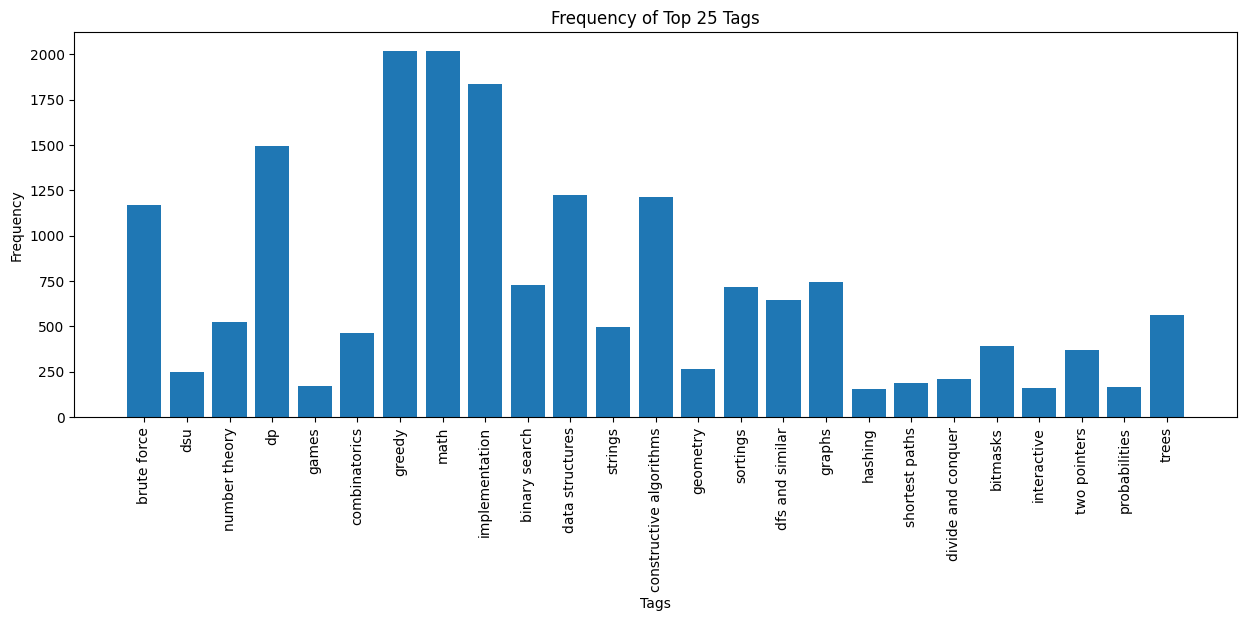

Text(0.5, 1.0, 'Frequency of Number of Tags')

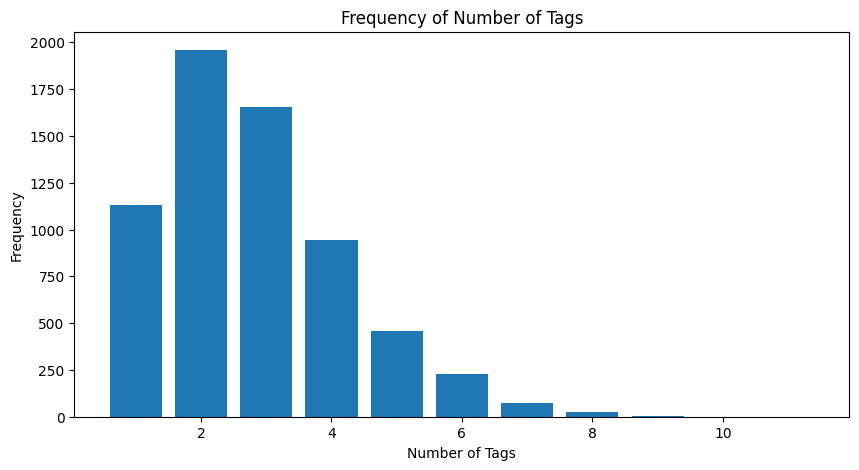

In [7]:

import matplotlib.pyplot as plt
from collections import Counter

# Assuming 'main_data' and 'most_frequent_tags' are defined as in your previous code


print(len(training_data))

# Bar graph for tag frequency
tag_frequencies = Counter([tag for tags in training_data['tags'].dropna() for tag in tags.split(',') if tag in most_frequent_tags])

plt.figure(figsize=(15, 5))
plt.bar(tag_frequencies.keys(), tag_frequencies.values())
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title(f'Frequency of Top {n} Tags')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()


#bar graph for how many problems have k different tags in the top n
tag_counts = {}
for tags in training_data['tags'].dropna():
  if isinstance(tags, str):
    tag_count = len(tags.split(','))
    if tag_count in tag_counts:
      tag_counts[tag_count] += 1
    else:
      tag_counts[tag_count] = 1

plt.figure(figsize=(10, 5))
plt.bar(tag_counts.keys(), tag_counts.values())
plt.xlabel('Number of Tags')
plt.ylabel('Frequency')
plt.title(f'Frequency of Number of Tags')

In [8]:
from transformers import BertTokenizer
def problem_tags_to_vector(tags_string, most_frequent_tags, n):
  """
  Converts a string of problem tags to a PyTorch vector of length n.

  Args:
    tags_string: A string of problem tags separated by commas.
    most_frequent_tags: A set of the n most frequent problem tags.
    n: The length of the vector.

  Returns:
    A PyTorch vector of floats, where a[i] is 1 if the ith most frequent
    problem tag is present in the tags_string, and 0 otherwise.
  """
  if not isinstance(tags_string, str):
    return torch.zeros(n)
  tags = set(tags_string.split(','))
  vector = [1.0 if tag in tags else 0.0 for tag in most_frequent_tags]
  return torch.tensor(vector, dtype=torch.float32)

MAXLEN = 512
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def tokenize_text(text):
  return tokenizer(text, padding='max_length', truncation=True, max_length=MAXLEN)

/common/home/nt406/Desktop/cf-classification/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from transformers import BertModel
from torch.utils.data import Dataset
import torch.nn.init as init
import torch.nn as nn

class TagModel(nn.Module):
    def __init__(self):
        super(TagModel, self).__init__()
        self.bert = BertModel.from_pretrained('prajjwal1/bert-small')
        self.dropout = nn.Dropout(0.4)  # Experiment with dropout rate (e.g., 0.1-0.5)
        self.tag_classifier = nn.Sequential(
            nn.Linear(512, n),  # Your original linear layer
            nn.LayerNorm(n)   # Layer Normalization layer
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)  # Apply dropout
        tag_pred = self.tag_classifier(pooled_output)
        return tag_pred

def init_weights(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_mask, tags, device):
        self.input_ids = input_ids.to(device)
        self.attention_mask = attention_mask.to(device)
        self.tags = tags.to(device)

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attention_mask[idx], self.tags[idx]

In [10]:
from torch.utils.data import DataLoader, TensorDataset

texts = training_data['statement'].tolist()
encodings = tokenizer(texts, truncation=True, padding=True, max_length=MAXLEN)

tags = training_data['tags'].tolist()
tags = [problem_tags_to_vector(tag, most_frequent_tags, n) for tag in tags]

input_ids = torch.tensor(encodings['input_ids'])
attention_mask = torch.tensor(encodings['attention_mask'])

tags = torch.stack(tags)

#validation stuff
val_texts = validation_data['statement'].tolist()
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=MAXLEN)

val_tags = validation_data['tags'].tolist()
val_tags = [problem_tags_to_vector(tag, most_frequent_tags, n) for tag in val_tags]

val_input_ids = torch.tensor(val_encodings['input_ids'])
val_attention_mask = torch.tensor(val_encodings['attention_mask'])

val_tags = torch.stack(val_tags)

bsz = 32
val_dataset = CustomDataset(val_input_ids, val_attention_mask, val_tags, device)
val_loader = DataLoader(val_dataset, batch_size=bsz, shuffle=True)
dataset = CustomDataset(input_ids, attention_mask, tags, device)
loader = DataLoader(dataset, batch_size=bsz, shuffle=True)

In [11]:
# prompt: write a function that runs the model on the validation data set, and determines its accuracy on each specific tag. Returns a vector length n with the % accuracy for each tag. The model uses a threshold of 0.5 for classification. remember to apply sigmoid to map the output layer to [0,1]

def evaluate_tag_accuracy(model, val_loader, device, n):
  """
  Evaluates the model's accuracy on the validation dataset for each tag.

  Args:
    model: The trained model.
    val_loader: The DataLoader for the validation dataset.
    device: The device to run the model on (e.g., 'cuda' or 'cpu').
    n: The number of tags.

  Returns:
    A list of floats, representing the accuracy for each tag.
  """

  model.eval()  # Set the model to evaluation mode
  tag_correct_counts = [0] * n
  tag_total_counts = [0] * n
  avg_loss = 0
  with torch.no_grad():
    for batch in val_loader:
      input_ids, attention_mask, true_tags = batch
      input_ids = input_ids.to(device)
      attention_mask = attention_mask.to(device)
      true_tags = true_tags.to(device)

      tag_pred = model(input_ids, attention_mask)
      loss = nn.BCEWithLogitsLoss()(tag_pred, true_tags)
      avg_loss += loss.item()
      tag_pred = torch.sigmoid(tag_pred)  # Apply sigmoid to get probabilities in [0,1]

      predicted_tags = (tag_pred > 0.5).float()

      for i in range(n):
        tag_correct_counts[i] += (predicted_tags[:, i] == true_tags[:, i]).sum().item()
        tag_total_counts[i] += true_tags.shape[0]
  avg_loss /= len(val_loader)

  tag_accuracies = []
  for i in range(n):
    if tag_total_counts[i] > 0:
      tag_accuracies.append(tag_correct_counts[i] / tag_total_counts[i] * 100)
    else:
      tag_accuracies.append(0.0)

  return (avg_loss,tag_accuracies)

In [12]:
import matplotlib.pyplot as plt
from IPython import display
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

total_losses = []
val_losses = []
val_acc = []

model = TagModel()
model.apply(init_weights)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = StepLR(optimizer, step_size = 3, gamma = 0.5) # Initialize StepLR
model.train()

EPOCHS = 35
for epoch in range(EPOCHS):
    loop = tqdm(loader, leave=True) # wrap the dataloader with tqdm
    for batch_idx, batch in enumerate(loop):
        input_ids, attention_mask, tag_labels = batch

        optimizer.zero_grad()
        tag_pred = model(input_ids=input_ids, attention_mask=attention_mask)

        loss = nn.BCEWithLogitsLoss()(tag_pred, tag_labels)

        total_losses.append(loss.item())

        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch [{epoch + 1}/{EPOCHS}]")
        loop.set_postfix(tag_loss=loss.item())

    scheduler.step() # Update learning rate at each step
    print(f"Epoch {epoch + 1} completed.")
    model.eval()
    avg_loss, tag_accuracies = evaluate_tag_accuracy(model, val_loader, device, n)
    val_losses.append(avg_loss)
    val_acc.append(tag_accuracies)
    print(f"Validation Loss: {avg_loss}")
    print(f"Tag Accuracies: {tag_accuracies}")
    model.train()


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [1/35]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch [1/35]:   0%|          | 0/203 [00:00<?, ?it/s, tag_loss=0.824]

Epoch [1/35]:   0%|          | 1/203 [00:00<03:02,  1.11it/s, tag_loss=0.824]

Epoch [1/35]:   0%|          | 1/203 [00:00<03:02,  1.11it/s, tag_loss=0.824]

Epoch [1/35]:   0%|          | 1/203 [00:01<03:02,  1.11it/s, tag_loss=0.77] 

Epoch [1/35]:   1%|          | 2/203 [00:01<01:39,  2.01it/s, tag_loss=0.77]

Epoch [1/35]:   1%|          | 2/203 [00:01<01:39,  2.01it/s, tag_loss=0.77]

Epoch [1/35]:   1%|          | 2/203 [00:01<01:39,  2.01it/s, tag_loss=0.752]

Epoch [1/35]:   1%|▏         | 3/203 [00:01<01:13,  2.72it/s, tag_loss=0.752]

Epoch [1/35]:   1%|▏         | 3/203 [00:01<01:13,  2.72it/s, tag_loss=0.752]

Epoch [1/35]:   1%|▏         | 3/203 [00:01<01:13,  2.72it/s, tag_loss=0.759]

Epoch [1/35]:   2%|▏         | 4/203 [00:01<01:00,  3.27it/s, tag_loss=0.759]

Epoch [1/35]:   2%|▏         | 4/203 [00:01<01:00,  3.27it/s, tag_loss=0.759]

Epoch [1/35]:   2%|▏         | 4/203 [00:01<01:00,  3.27it/s, tag_loss=0.742]

Epoch [1/35]:   2%|▏         | 5/203 [00:01<00:53,  3.67it/s, tag_loss=0.742]

Epoch [1/35]:   2%|▏         | 5/203 [00:01<00:53,  3.67it/s, tag_loss=0.742]

Epoch [1/35]:   2%|▏         | 5/203 [00:01<00:53,  3.67it/s, tag_loss=0.703]

Epoch [1/35]:   3%|▎         | 6/203 [00:01<00:49,  3.96it/s, tag_loss=0.703]

Epoch [1/35]:   3%|▎         | 6/203 [00:02<00:49,  3.96it/s, tag_loss=0.703]

Epoch [1/35]:   3%|▎         | 6/203 [00:02<00:49,  3.96it/s, tag_loss=0.716]

Epoch [1/35]:   3%|▎         | 7/203 [00:02<00:46,  4.17it/s, tag_loss=0.716]

Epoch [1/35]:   3%|▎         | 7/203 [00:02<00:46,  4.17it/s, tag_loss=0.716]

Epoch [1/35]:   3%|▎         | 7/203 [00:02<00:46,  4.17it/s, tag_loss=0.722]

Epoch [1/35]:   4%|▍         | 8/203 [00:02<00:45,  4.32it/s, tag_loss=0.722]

Epoch [1/35]:   4%|▍         | 8/203 [00:02<00:45,  4.32it/s, tag_loss=0.722]

Epoch [1/35]:   4%|▍         | 8/203 [00:02<00:45,  4.32it/s, tag_loss=0.72] 

Epoch [1/35]:   4%|▍         | 9/203 [00:02<00:43,  4.43it/s, tag_loss=0.72]

Epoch [1/35]:   4%|▍         | 9/203 [00:02<00:43,  4.43it/s, tag_loss=0.72]

Epoch [1/35]:   4%|▍         | 9/203 [00:02<00:43,  4.43it/s, tag_loss=0.749]

Epoch [1/35]:   5%|▍         | 10/203 [00:02<00:42,  4.50it/s, tag_loss=0.749]

Epoch [1/35]:   5%|▍         | 10/203 [00:02<00:42,  4.50it/s, tag_loss=0.749]

Epoch [1/35]:   5%|▍         | 10/203 [00:03<00:42,  4.50it/s, tag_loss=0.727]

Epoch [1/35]:   5%|▌         | 11/203 [00:03<00:42,  4.55it/s, tag_loss=0.727]

Epoch [1/35]:   5%|▌         | 11/203 [00:03<00:42,  4.55it/s, tag_loss=0.727]

Epoch [1/35]:   5%|▌         | 11/203 [00:03<00:42,  4.55it/s, tag_loss=0.745]

Epoch [1/35]:   6%|▌         | 12/203 [00:03<00:41,  4.59it/s, tag_loss=0.745]

Epoch [1/35]:   6%|▌         | 12/203 [00:03<00:41,  4.59it/s, tag_loss=0.745]

Epoch [1/35]:   6%|▌         | 12/203 [00:03<00:41,  4.59it/s, tag_loss=0.701]

Epoch [1/35]:   6%|▋         | 13/203 [00:03<00:41,  4.62it/s, tag_loss=0.701]

Epoch [1/35]:   6%|▋         | 13/203 [00:03<00:41,  4.62it/s, tag_loss=0.701]

Epoch [1/35]:   6%|▋         | 13/203 [00:03<00:41,  4.62it/s, tag_loss=0.708]

Epoch [1/35]:   7%|▋         | 14/203 [00:03<00:40,  4.63it/s, tag_loss=0.708]

Epoch [1/35]:   7%|▋         | 14/203 [00:03<00:40,  4.63it/s, tag_loss=0.708]

Epoch [1/35]:   7%|▋         | 14/203 [00:03<00:40,  4.63it/s, tag_loss=0.718]

Epoch [1/35]:   7%|▋         | 15/203 [00:03<00:40,  4.64it/s, tag_loss=0.718]

Epoch [1/35]:   7%|▋         | 15/203 [00:03<00:40,  4.64it/s, tag_loss=0.718]

Epoch [1/35]:   7%|▋         | 15/203 [00:04<00:40,  4.64it/s, tag_loss=0.712]

Epoch [1/35]:   8%|▊         | 16/203 [00:04<00:40,  4.65it/s, tag_loss=0.712]

Epoch [1/35]:   8%|▊         | 16/203 [00:04<00:40,  4.65it/s, tag_loss=0.712]

Epoch [1/35]:   8%|▊         | 16/203 [00:04<00:40,  4.65it/s, tag_loss=0.704]

Epoch [1/35]:   8%|▊         | 17/203 [00:04<00:39,  4.66it/s, tag_loss=0.704]

Epoch [1/35]:   8%|▊         | 17/203 [00:04<00:39,  4.66it/s, tag_loss=0.704]

Epoch [1/35]:   8%|▊         | 17/203 [00:04<00:39,  4.66it/s, tag_loss=0.713]

Epoch [1/35]:   9%|▉         | 18/203 [00:04<00:39,  4.66it/s, tag_loss=0.713]

Epoch [1/35]:   9%|▉         | 18/203 [00:04<00:39,  4.66it/s, tag_loss=0.713]

Epoch [1/35]:   9%|▉         | 18/203 [00:04<00:39,  4.66it/s, tag_loss=0.709]

Epoch [1/35]:   9%|▉         | 19/203 [00:04<00:39,  4.66it/s, tag_loss=0.709]

Epoch [1/35]:   9%|▉         | 19/203 [00:04<00:39,  4.66it/s, tag_loss=0.709]

Epoch [1/35]:   9%|▉         | 19/203 [00:04<00:39,  4.66it/s, tag_loss=0.735]

Epoch [1/35]:  10%|▉         | 20/203 [00:04<00:39,  4.66it/s, tag_loss=0.735]

Epoch [1/35]:  10%|▉         | 20/203 [00:05<00:39,  4.66it/s, tag_loss=0.735]

Epoch [1/35]:  10%|▉         | 20/203 [00:05<00:39,  4.66it/s, tag_loss=0.731]

Epoch [1/35]:  10%|█         | 21/203 [00:05<00:38,  4.67it/s, tag_loss=0.731]

Epoch [1/35]:  10%|█         | 21/203 [00:05<00:38,  4.67it/s, tag_loss=0.731]

Epoch [1/35]:  10%|█         | 21/203 [00:05<00:38,  4.67it/s, tag_loss=0.725]

Epoch [1/35]:  11%|█         | 22/203 [00:05<00:38,  4.67it/s, tag_loss=0.725]

Epoch [1/35]:  11%|█         | 22/203 [00:05<00:38,  4.67it/s, tag_loss=0.725]

Epoch [1/35]:  11%|█         | 22/203 [00:05<00:38,  4.67it/s, tag_loss=0.73] 

Epoch [1/35]:  11%|█▏        | 23/203 [00:05<00:38,  4.66it/s, tag_loss=0.73]

Epoch [1/35]:  11%|█▏        | 23/203 [00:05<00:38,  4.66it/s, tag_loss=0.73]

Epoch [1/35]:  11%|█▏        | 23/203 [00:05<00:38,  4.66it/s, tag_loss=0.741]

Epoch [1/35]:  12%|█▏        | 24/203 [00:05<00:38,  4.66it/s, tag_loss=0.741]

Epoch [1/35]:  12%|█▏        | 24/203 [00:05<00:38,  4.66it/s, tag_loss=0.741]

Epoch [1/35]:  12%|█▏        | 24/203 [00:06<00:38,  4.66it/s, tag_loss=0.714]

Epoch [1/35]:  12%|█▏        | 25/203 [00:06<00:38,  4.66it/s, tag_loss=0.714]

Epoch [1/35]:  12%|█▏        | 25/203 [00:06<00:38,  4.66it/s, tag_loss=0.714]

Epoch [1/35]:  12%|█▏        | 25/203 [00:06<00:38,  4.66it/s, tag_loss=0.726]

Epoch [1/35]:  13%|█▎        | 26/203 [00:06<00:37,  4.66it/s, tag_loss=0.726]

Epoch [1/35]:  13%|█▎        | 26/203 [00:06<00:37,  4.66it/s, tag_loss=0.726]

Epoch [1/35]:  13%|█▎        | 26/203 [00:06<00:37,  4.66it/s, tag_loss=0.692]

Epoch [1/35]:  13%|█▎        | 27/203 [00:06<00:37,  4.66it/s, tag_loss=0.692]

Epoch [1/35]:  13%|█▎        | 27/203 [00:06<00:37,  4.66it/s, tag_loss=0.692]

Epoch [1/35]:  13%|█▎        | 27/203 [00:06<00:37,  4.66it/s, tag_loss=0.73] 

Epoch [1/35]:  14%|█▍        | 28/203 [00:06<00:37,  4.67it/s, tag_loss=0.73]

Epoch [1/35]:  14%|█▍        | 28/203 [00:06<00:37,  4.67it/s, tag_loss=0.73]

Epoch [1/35]:  14%|█▍        | 28/203 [00:06<00:37,  4.67it/s, tag_loss=0.698]

Epoch [1/35]:  14%|█▍        | 29/203 [00:06<00:37,  4.66it/s, tag_loss=0.698]

Epoch [1/35]:  14%|█▍        | 29/203 [00:06<00:37,  4.66it/s, tag_loss=0.698]

Epoch [1/35]:  14%|█▍        | 29/203 [00:07<00:37,  4.66it/s, tag_loss=0.726]

Epoch [1/35]:  15%|█▍        | 30/203 [00:07<00:37,  4.66it/s, tag_loss=0.726]

Epoch [1/35]:  15%|█▍        | 30/203 [00:07<00:37,  4.66it/s, tag_loss=0.726]

Epoch [1/35]:  15%|█▍        | 30/203 [00:07<00:37,  4.66it/s, tag_loss=0.712]

Epoch [1/35]:  15%|█▌        | 31/203 [00:07<00:36,  4.65it/s, tag_loss=0.712]

Epoch [1/35]:  15%|█▌        | 31/203 [00:07<00:36,  4.65it/s, tag_loss=0.712]

Epoch [1/35]:  15%|█▌        | 31/203 [00:07<00:36,  4.65it/s, tag_loss=0.739]

Epoch [1/35]:  16%|█▌        | 32/203 [00:07<00:36,  4.65it/s, tag_loss=0.739]

Epoch [1/35]:  16%|█▌        | 32/203 [00:07<00:36,  4.65it/s, tag_loss=0.739]

Epoch [1/35]:  16%|█▌        | 32/203 [00:07<00:36,  4.65it/s, tag_loss=0.712]

Epoch [1/35]:  16%|█▋        | 33/203 [00:07<00:36,  4.65it/s, tag_loss=0.712]

Epoch [1/35]:  16%|█▋        | 33/203 [00:07<00:36,  4.65it/s, tag_loss=0.712]

Epoch [1/35]:  16%|█▋        | 33/203 [00:07<00:36,  4.65it/s, tag_loss=0.713]

Epoch [1/35]:  17%|█▋        | 34/203 [00:07<00:36,  4.65it/s, tag_loss=0.713]

Epoch [1/35]:  17%|█▋        | 34/203 [00:08<00:36,  4.65it/s, tag_loss=0.713]

Epoch [1/35]:  17%|█▋        | 34/203 [00:08<00:36,  4.65it/s, tag_loss=0.704]

Epoch [1/35]:  17%|█▋        | 35/203 [00:08<00:36,  4.66it/s, tag_loss=0.704]

Epoch [1/35]:  17%|█▋        | 35/203 [00:08<00:36,  4.66it/s, tag_loss=0.704]

Epoch [1/35]:  17%|█▋        | 35/203 [00:08<00:36,  4.66it/s, tag_loss=0.72] 

Epoch [1/35]:  18%|█▊        | 36/203 [00:08<00:35,  4.65it/s, tag_loss=0.72]

Epoch [1/35]:  18%|█▊        | 36/203 [00:08<00:35,  4.65it/s, tag_loss=0.72]

Epoch [1/35]:  18%|█▊        | 36/203 [00:08<00:35,  4.65it/s, tag_loss=0.714]

Epoch [1/35]:  18%|█▊        | 37/203 [00:08<00:35,  4.65it/s, tag_loss=0.714]

Epoch [1/35]:  18%|█▊        | 37/203 [00:08<00:35,  4.65it/s, tag_loss=0.714]

Epoch [1/35]:  18%|█▊        | 37/203 [00:08<00:35,  4.65it/s, tag_loss=0.728]

Epoch [1/35]:  19%|█▊        | 38/203 [00:08<00:35,  4.64it/s, tag_loss=0.728]

Epoch [1/35]:  19%|█▊        | 38/203 [00:08<00:35,  4.64it/s, tag_loss=0.728]

Epoch [1/35]:  19%|█▊        | 38/203 [00:09<00:35,  4.64it/s, tag_loss=0.712]

Epoch [1/35]:  19%|█▉        | 39/203 [00:09<00:35,  4.64it/s, tag_loss=0.712]

Epoch [1/35]:  19%|█▉        | 39/203 [00:09<00:35,  4.64it/s, tag_loss=0.712]

Epoch [1/35]:  19%|█▉        | 39/203 [00:09<00:35,  4.64it/s, tag_loss=0.707]

Epoch [1/35]:  20%|█▉        | 40/203 [00:09<00:35,  4.64it/s, tag_loss=0.707]

Epoch [1/35]:  20%|█▉        | 40/203 [00:09<00:35,  4.64it/s, tag_loss=0.707]

Epoch [1/35]:  20%|█▉        | 40/203 [00:09<00:35,  4.64it/s, tag_loss=0.722]

Epoch [1/35]:  20%|██        | 41/203 [00:09<00:34,  4.64it/s, tag_loss=0.722]

Epoch [1/35]:  20%|██        | 41/203 [00:09<00:34,  4.64it/s, tag_loss=0.722]

Epoch [1/35]:  20%|██        | 41/203 [00:09<00:34,  4.64it/s, tag_loss=0.743]

Epoch [1/35]:  21%|██        | 42/203 [00:09<00:34,  4.64it/s, tag_loss=0.743]

Epoch [1/35]:  21%|██        | 42/203 [00:09<00:34,  4.64it/s, tag_loss=0.743]

Epoch [1/35]:  21%|██        | 42/203 [00:09<00:34,  4.64it/s, tag_loss=0.704]

Epoch [1/35]:  21%|██        | 43/203 [00:09<00:34,  4.64it/s, tag_loss=0.704]

Epoch [1/35]:  21%|██        | 43/203 [00:09<00:34,  4.64it/s, tag_loss=0.704]

Epoch [1/35]:  21%|██        | 43/203 [00:10<00:34,  4.64it/s, tag_loss=0.711]

Epoch [1/35]:  22%|██▏       | 44/203 [00:10<00:34,  4.65it/s, tag_loss=0.711]

Epoch [1/35]:  22%|██▏       | 44/203 [00:10<00:34,  4.65it/s, tag_loss=0.711]

Epoch [1/35]:  22%|██▏       | 44/203 [00:10<00:34,  4.65it/s, tag_loss=0.721]

Epoch [1/35]:  22%|██▏       | 45/203 [00:10<00:33,  4.65it/s, tag_loss=0.721]

Epoch [1/35]:  22%|██▏       | 45/203 [00:10<00:33,  4.65it/s, tag_loss=0.721]

Epoch [1/35]:  22%|██▏       | 45/203 [00:10<00:33,  4.65it/s, tag_loss=0.739]

Epoch [1/35]:  23%|██▎       | 46/203 [00:10<00:33,  4.65it/s, tag_loss=0.739]

Epoch [1/35]:  23%|██▎       | 46/203 [00:10<00:33,  4.65it/s, tag_loss=0.739]

Epoch [1/35]:  23%|██▎       | 46/203 [00:10<00:33,  4.65it/s, tag_loss=0.704]

Epoch [1/35]:  23%|██▎       | 47/203 [00:10<00:33,  4.65it/s, tag_loss=0.704]

Epoch [1/35]:  23%|██▎       | 47/203 [00:10<00:33,  4.65it/s, tag_loss=0.704]

Epoch [1/35]:  23%|██▎       | 47/203 [00:10<00:33,  4.65it/s, tag_loss=0.714]

Epoch [1/35]:  24%|██▎       | 48/203 [00:10<00:33,  4.65it/s, tag_loss=0.714]

Epoch [1/35]:  24%|██▎       | 48/203 [00:11<00:33,  4.65it/s, tag_loss=0.714]

Epoch [1/35]:  24%|██▎       | 48/203 [00:11<00:33,  4.65it/s, tag_loss=0.712]

Epoch [1/35]:  24%|██▍       | 49/203 [00:11<00:33,  4.65it/s, tag_loss=0.712]

Epoch [1/35]:  24%|██▍       | 49/203 [00:11<00:33,  4.65it/s, tag_loss=0.712]

Epoch [1/35]:  24%|██▍       | 49/203 [00:11<00:33,  4.65it/s, tag_loss=0.725]

Epoch [1/35]:  25%|██▍       | 50/203 [00:11<00:32,  4.65it/s, tag_loss=0.725]

Epoch [1/35]:  25%|██▍       | 50/203 [00:11<00:32,  4.65it/s, tag_loss=0.725]

Epoch [1/35]:  25%|██▍       | 50/203 [00:11<00:32,  4.65it/s, tag_loss=0.719]

Epoch [1/35]:  25%|██▌       | 51/203 [00:11<00:32,  4.65it/s, tag_loss=0.719]

Epoch [1/35]:  25%|██▌       | 51/203 [00:11<00:32,  4.65it/s, tag_loss=0.719]

Epoch [1/35]:  25%|██▌       | 51/203 [00:11<00:32,  4.65it/s, tag_loss=0.678]

Epoch [1/35]:  26%|██▌       | 52/203 [00:11<00:32,  4.65it/s, tag_loss=0.678]

Epoch [1/35]:  26%|██▌       | 52/203 [00:11<00:32,  4.65it/s, tag_loss=0.678]

Epoch [1/35]:  26%|██▌       | 52/203 [00:12<00:32,  4.65it/s, tag_loss=0.713]

Epoch [1/35]:  26%|██▌       | 53/203 [00:12<00:32,  4.66it/s, tag_loss=0.713]

Epoch [1/35]:  26%|██▌       | 53/203 [00:12<00:32,  4.66it/s, tag_loss=0.713]

Epoch [1/35]:  26%|██▌       | 53/203 [00:12<00:32,  4.66it/s, tag_loss=0.695]

Epoch [1/35]:  27%|██▋       | 54/203 [00:12<00:31,  4.66it/s, tag_loss=0.695]

Epoch [1/35]:  27%|██▋       | 54/203 [00:12<00:31,  4.66it/s, tag_loss=0.695]

Epoch [1/35]:  27%|██▋       | 54/203 [00:12<00:31,  4.66it/s, tag_loss=0.678]

Epoch [1/35]:  27%|██▋       | 55/203 [00:12<00:31,  4.66it/s, tag_loss=0.678]

Epoch [1/35]:  27%|██▋       | 55/203 [00:12<00:31,  4.66it/s, tag_loss=0.678]

Epoch [1/35]:  27%|██▋       | 55/203 [00:12<00:31,  4.66it/s, tag_loss=0.697]

Epoch [1/35]:  28%|██▊       | 56/203 [00:12<00:31,  4.66it/s, tag_loss=0.697]

Epoch [1/35]:  28%|██▊       | 56/203 [00:12<00:31,  4.66it/s, tag_loss=0.697]

Epoch [1/35]:  28%|██▊       | 56/203 [00:12<00:31,  4.66it/s, tag_loss=0.716]

Epoch [1/35]:  28%|██▊       | 57/203 [00:12<00:31,  4.66it/s, tag_loss=0.716]

Epoch [1/35]:  28%|██▊       | 57/203 [00:12<00:31,  4.66it/s, tag_loss=0.716]

Epoch [1/35]:  28%|██▊       | 57/203 [00:13<00:31,  4.66it/s, tag_loss=0.711]

Epoch [1/35]:  29%|██▊       | 58/203 [00:13<00:31,  4.66it/s, tag_loss=0.711]

Epoch [1/35]:  29%|██▊       | 58/203 [00:13<00:31,  4.66it/s, tag_loss=0.711]

Epoch [1/35]:  29%|██▊       | 58/203 [00:13<00:31,  4.66it/s, tag_loss=0.726]

Epoch [1/35]:  29%|██▉       | 59/203 [00:13<00:30,  4.65it/s, tag_loss=0.726]

Epoch [1/35]:  29%|██▉       | 59/203 [00:13<00:30,  4.65it/s, tag_loss=0.726]

Epoch [1/35]:  29%|██▉       | 59/203 [00:13<00:30,  4.65it/s, tag_loss=0.7]  

Epoch [1/35]:  30%|██▉       | 60/203 [00:13<00:30,  4.65it/s, tag_loss=0.7]

Epoch [1/35]:  30%|██▉       | 60/203 [00:13<00:30,  4.65it/s, tag_loss=0.7]

Epoch [1/35]:  30%|██▉       | 60/203 [00:13<00:30,  4.65it/s, tag_loss=0.72]

Epoch [1/35]:  30%|███       | 61/203 [00:13<00:30,  4.65it/s, tag_loss=0.72]

Epoch [1/35]:  30%|███       | 61/203 [00:13<00:30,  4.65it/s, tag_loss=0.72]

Epoch [1/35]:  30%|███       | 61/203 [00:13<00:30,  4.65it/s, tag_loss=0.713]

Epoch [1/35]:  31%|███       | 62/203 [00:13<00:30,  4.66it/s, tag_loss=0.713]

Epoch [1/35]:  31%|███       | 62/203 [00:14<00:30,  4.66it/s, tag_loss=0.713]

Epoch [1/35]:  31%|███       | 62/203 [00:14<00:30,  4.66it/s, tag_loss=0.693]

Epoch [1/35]:  31%|███       | 63/203 [00:14<00:30,  4.65it/s, tag_loss=0.693]

Epoch [1/35]:  31%|███       | 63/203 [00:14<00:30,  4.65it/s, tag_loss=0.693]

Epoch [1/35]:  31%|███       | 63/203 [00:14<00:30,  4.65it/s, tag_loss=0.715]

Epoch [1/35]:  32%|███▏      | 64/203 [00:14<00:29,  4.64it/s, tag_loss=0.715]

Epoch [1/35]:  32%|███▏      | 64/203 [00:14<00:29,  4.64it/s, tag_loss=0.715]

Epoch [1/35]:  32%|███▏      | 64/203 [00:14<00:29,  4.64it/s, tag_loss=0.699]

Epoch [1/35]:  32%|███▏      | 65/203 [00:14<00:29,  4.65it/s, tag_loss=0.699]

Epoch [1/35]:  32%|███▏      | 65/203 [00:14<00:29,  4.65it/s, tag_loss=0.699]

Epoch [1/35]:  32%|███▏      | 65/203 [00:14<00:29,  4.65it/s, tag_loss=0.704]

Epoch [1/35]:  33%|███▎      | 66/203 [00:14<00:29,  4.64it/s, tag_loss=0.704]

Epoch [1/35]:  33%|███▎      | 66/203 [00:14<00:29,  4.64it/s, tag_loss=0.704]

Epoch [1/35]:  33%|███▎      | 66/203 [00:15<00:29,  4.64it/s, tag_loss=0.728]

Epoch [1/35]:  33%|███▎      | 67/203 [00:15<00:29,  4.64it/s, tag_loss=0.728]

Epoch [1/35]:  33%|███▎      | 67/203 [00:15<00:29,  4.64it/s, tag_loss=0.728]

Epoch [1/35]:  33%|███▎      | 67/203 [00:15<00:29,  4.64it/s, tag_loss=0.705]

Epoch [1/35]:  33%|███▎      | 68/203 [00:15<00:29,  4.65it/s, tag_loss=0.705]

Epoch [1/35]:  33%|███▎      | 68/203 [00:15<00:29,  4.65it/s, tag_loss=0.705]

Epoch [1/35]:  33%|███▎      | 68/203 [00:15<00:29,  4.65it/s, tag_loss=0.733]

Epoch [1/35]:  34%|███▍      | 69/203 [00:15<00:28,  4.64it/s, tag_loss=0.733]

Epoch [1/35]:  34%|███▍      | 69/203 [00:15<00:28,  4.64it/s, tag_loss=0.733]

Epoch [1/35]:  34%|███▍      | 69/203 [00:15<00:28,  4.64it/s, tag_loss=0.707]

Epoch [1/35]:  34%|███▍      | 70/203 [00:15<00:28,  4.64it/s, tag_loss=0.707]

Epoch [1/35]:  34%|███▍      | 70/203 [00:15<00:28,  4.64it/s, tag_loss=0.707]

Epoch [1/35]:  34%|███▍      | 70/203 [00:15<00:28,  4.64it/s, tag_loss=0.714]

Epoch [1/35]:  35%|███▍      | 71/203 [00:15<00:28,  4.64it/s, tag_loss=0.714]

Epoch [1/35]:  35%|███▍      | 71/203 [00:16<00:28,  4.64it/s, tag_loss=0.714]

Epoch [1/35]:  35%|███▍      | 71/203 [00:16<00:28,  4.64it/s, tag_loss=0.7]  

Epoch [1/35]:  35%|███▌      | 72/203 [00:16<00:28,  4.64it/s, tag_loss=0.7]

Epoch [1/35]:  35%|███▌      | 72/203 [00:16<00:28,  4.64it/s, tag_loss=0.7]

Epoch [1/35]:  35%|███▌      | 72/203 [00:16<00:28,  4.64it/s, tag_loss=0.703]

Epoch [1/35]:  36%|███▌      | 73/203 [00:16<00:28,  4.64it/s, tag_loss=0.703]

Epoch [1/35]:  36%|███▌      | 73/203 [00:16<00:28,  4.64it/s, tag_loss=0.703]

Epoch [1/35]:  36%|███▌      | 73/203 [00:16<00:28,  4.64it/s, tag_loss=0.689]

Epoch [1/35]:  36%|███▋      | 74/203 [00:16<00:27,  4.65it/s, tag_loss=0.689]

Epoch [1/35]:  36%|███▋      | 74/203 [00:16<00:27,  4.65it/s, tag_loss=0.689]

Epoch [1/35]:  36%|███▋      | 74/203 [00:16<00:27,  4.65it/s, tag_loss=0.729]

Epoch [1/35]:  37%|███▋      | 75/203 [00:16<00:27,  4.65it/s, tag_loss=0.729]

Epoch [1/35]:  37%|███▋      | 75/203 [00:16<00:27,  4.65it/s, tag_loss=0.729]

Epoch [1/35]:  37%|███▋      | 75/203 [00:17<00:27,  4.65it/s, tag_loss=0.726]

Epoch [1/35]:  37%|███▋      | 76/203 [00:17<00:27,  4.64it/s, tag_loss=0.726]

Epoch [1/35]:  37%|███▋      | 76/203 [00:17<00:27,  4.64it/s, tag_loss=0.726]

Epoch [1/35]:  37%|███▋      | 76/203 [00:17<00:27,  4.64it/s, tag_loss=0.704]

Epoch [1/35]:  38%|███▊      | 77/203 [00:17<00:27,  4.63it/s, tag_loss=0.704]

Epoch [1/35]:  38%|███▊      | 77/203 [00:17<00:27,  4.63it/s, tag_loss=0.704]

Epoch [1/35]:  38%|███▊      | 77/203 [00:17<00:27,  4.63it/s, tag_loss=0.723]

Epoch [1/35]:  38%|███▊      | 78/203 [00:17<00:27,  4.63it/s, tag_loss=0.723]

Epoch [1/35]:  38%|███▊      | 78/203 [00:17<00:27,  4.63it/s, tag_loss=0.723]

Epoch [1/35]:  38%|███▊      | 78/203 [00:17<00:27,  4.63it/s, tag_loss=0.718]

Epoch [1/35]:  39%|███▉      | 79/203 [00:17<00:26,  4.63it/s, tag_loss=0.718]

Epoch [1/35]:  39%|███▉      | 79/203 [00:17<00:26,  4.63it/s, tag_loss=0.718]

Epoch [1/35]:  39%|███▉      | 79/203 [00:17<00:26,  4.63it/s, tag_loss=0.697]

Epoch [1/35]:  39%|███▉      | 80/203 [00:17<00:26,  4.63it/s, tag_loss=0.697]

Epoch [1/35]:  39%|███▉      | 80/203 [00:17<00:26,  4.63it/s, tag_loss=0.697]

Epoch [1/35]:  39%|███▉      | 80/203 [00:18<00:26,  4.63it/s, tag_loss=0.7]  

Epoch [1/35]:  40%|███▉      | 81/203 [00:18<00:26,  4.64it/s, tag_loss=0.7]

Epoch [1/35]:  40%|███▉      | 81/203 [00:18<00:26,  4.64it/s, tag_loss=0.7]

Epoch [1/35]:  40%|███▉      | 81/203 [00:18<00:26,  4.64it/s, tag_loss=0.7]

Epoch [1/35]:  40%|████      | 82/203 [00:18<00:26,  4.64it/s, tag_loss=0.7]

Epoch [1/35]:  40%|████      | 82/203 [00:18<00:26,  4.64it/s, tag_loss=0.7]

Epoch [1/35]:  40%|████      | 82/203 [00:18<00:26,  4.64it/s, tag_loss=0.717]

Epoch [1/35]:  41%|████      | 83/203 [00:18<00:25,  4.63it/s, tag_loss=0.717]

Epoch [1/35]:  41%|████      | 83/203 [00:18<00:25,  4.63it/s, tag_loss=0.717]

Epoch [1/35]:  41%|████      | 83/203 [00:18<00:25,  4.63it/s, tag_loss=0.699]

Epoch [1/35]:  41%|████▏     | 84/203 [00:18<00:25,  4.63it/s, tag_loss=0.699]

Epoch [1/35]:  41%|████▏     | 84/203 [00:18<00:25,  4.63it/s, tag_loss=0.699]

Epoch [1/35]:  41%|████▏     | 84/203 [00:18<00:25,  4.63it/s, tag_loss=0.718]

Epoch [1/35]:  42%|████▏     | 85/203 [00:18<00:25,  4.63it/s, tag_loss=0.718]

Epoch [1/35]:  42%|████▏     | 85/203 [00:19<00:25,  4.63it/s, tag_loss=0.718]

Epoch [1/35]:  42%|████▏     | 85/203 [00:19<00:25,  4.63it/s, tag_loss=0.72] 

Epoch [1/35]:  42%|████▏     | 86/203 [00:19<00:25,  4.63it/s, tag_loss=0.72]

Epoch [1/35]:  42%|████▏     | 86/203 [00:19<00:25,  4.63it/s, tag_loss=0.72]

Epoch [1/35]:  42%|████▏     | 86/203 [00:19<00:25,  4.63it/s, tag_loss=0.718]

Epoch [1/35]:  43%|████▎     | 87/203 [00:19<00:25,  4.62it/s, tag_loss=0.718]

Epoch [1/35]:  43%|████▎     | 87/203 [00:19<00:25,  4.62it/s, tag_loss=0.718]

Epoch [1/35]:  43%|████▎     | 87/203 [00:19<00:25,  4.62it/s, tag_loss=0.733]

Epoch [1/35]:  43%|████▎     | 88/203 [00:19<00:24,  4.62it/s, tag_loss=0.733]

Epoch [1/35]:  43%|████▎     | 88/203 [00:19<00:24,  4.62it/s, tag_loss=0.733]

Epoch [1/35]:  43%|████▎     | 88/203 [00:19<00:24,  4.62it/s, tag_loss=0.714]

Epoch [1/35]:  44%|████▍     | 89/203 [00:19<00:24,  4.61it/s, tag_loss=0.714]

Epoch [1/35]:  44%|████▍     | 89/203 [00:19<00:24,  4.61it/s, tag_loss=0.714]

Epoch [1/35]:  44%|████▍     | 89/203 [00:20<00:24,  4.61it/s, tag_loss=0.701]

Epoch [1/35]:  44%|████▍     | 90/203 [00:20<00:24,  4.61it/s, tag_loss=0.701]

Epoch [1/35]:  44%|████▍     | 90/203 [00:20<00:24,  4.61it/s, tag_loss=0.701]

Epoch [1/35]:  44%|████▍     | 90/203 [00:20<00:24,  4.61it/s, tag_loss=0.686]

Epoch [1/35]:  45%|████▍     | 91/203 [00:20<00:24,  4.61it/s, tag_loss=0.686]

Epoch [1/35]:  45%|████▍     | 91/203 [00:20<00:24,  4.61it/s, tag_loss=0.686]

Epoch [1/35]:  45%|████▍     | 91/203 [00:20<00:24,  4.61it/s, tag_loss=0.717]

Epoch [1/35]:  45%|████▌     | 92/203 [00:20<00:24,  4.61it/s, tag_loss=0.717]

Epoch [1/35]:  45%|████▌     | 92/203 [00:20<00:24,  4.61it/s, tag_loss=0.717]

Epoch [1/35]:  45%|████▌     | 92/203 [00:20<00:24,  4.61it/s, tag_loss=0.724]

Epoch [1/35]:  46%|████▌     | 93/203 [00:20<00:23,  4.61it/s, tag_loss=0.724]

Epoch [1/35]:  46%|████▌     | 93/203 [00:20<00:23,  4.61it/s, tag_loss=0.724]

Epoch [1/35]:  46%|████▌     | 93/203 [00:20<00:23,  4.61it/s, tag_loss=0.706]

Epoch [1/35]:  46%|████▋     | 94/203 [00:20<00:23,  4.61it/s, tag_loss=0.706]

Epoch [1/35]:  46%|████▋     | 94/203 [00:20<00:23,  4.61it/s, tag_loss=0.706]

Epoch [1/35]:  46%|████▋     | 94/203 [00:21<00:23,  4.61it/s, tag_loss=0.722]

Epoch [1/35]:  47%|████▋     | 95/203 [00:21<00:23,  4.60it/s, tag_loss=0.722]

Epoch [1/35]:  47%|████▋     | 95/203 [00:21<00:23,  4.60it/s, tag_loss=0.722]

Epoch [1/35]:  47%|████▋     | 95/203 [00:21<00:23,  4.60it/s, tag_loss=0.705]

Epoch [1/35]:  47%|████▋     | 96/203 [00:21<00:23,  4.60it/s, tag_loss=0.705]

Epoch [1/35]:  47%|████▋     | 96/203 [00:21<00:23,  4.60it/s, tag_loss=0.705]

Epoch [1/35]:  47%|████▋     | 96/203 [00:21<00:23,  4.60it/s, tag_loss=0.687]

Epoch [1/35]:  48%|████▊     | 97/203 [00:21<00:23,  4.60it/s, tag_loss=0.687]

Epoch [1/35]:  48%|████▊     | 97/203 [00:21<00:23,  4.60it/s, tag_loss=0.687]

Epoch [1/35]:  48%|████▊     | 97/203 [00:21<00:23,  4.60it/s, tag_loss=0.721]

Epoch [1/35]:  48%|████▊     | 98/203 [00:21<00:22,  4.60it/s, tag_loss=0.721]

Epoch [1/35]:  48%|████▊     | 98/203 [00:21<00:22,  4.60it/s, tag_loss=0.721]

Epoch [1/35]:  48%|████▊     | 98/203 [00:21<00:22,  4.60it/s, tag_loss=0.732]

Epoch [1/35]:  49%|████▉     | 99/203 [00:21<00:22,  4.60it/s, tag_loss=0.732]

Epoch [1/35]:  49%|████▉     | 99/203 [00:22<00:22,  4.60it/s, tag_loss=0.732]

Epoch [1/35]:  49%|████▉     | 99/203 [00:22<00:22,  4.60it/s, tag_loss=0.723]

Epoch [1/35]:  49%|████▉     | 100/203 [00:22<00:22,  4.60it/s, tag_loss=0.723]

Epoch [1/35]:  49%|████▉     | 100/203 [00:22<00:22,  4.60it/s, tag_loss=0.723]

Epoch [1/35]:  49%|████▉     | 100/203 [00:22<00:22,  4.60it/s, tag_loss=0.71] 

Epoch [1/35]:  50%|████▉     | 101/203 [00:22<00:22,  4.60it/s, tag_loss=0.71]

Epoch [1/35]:  50%|████▉     | 101/203 [00:22<00:22,  4.60it/s, tag_loss=0.71]

Epoch [1/35]:  50%|████▉     | 101/203 [00:22<00:22,  4.60it/s, tag_loss=0.73]

Epoch [1/35]:  50%|█████     | 102/203 [00:22<00:21,  4.60it/s, tag_loss=0.73]

Epoch [1/35]:  50%|█████     | 102/203 [00:22<00:21,  4.60it/s, tag_loss=0.73]

Epoch [1/35]:  50%|█████     | 102/203 [00:22<00:21,  4.60it/s, tag_loss=0.715]

Epoch [1/35]:  51%|█████     | 103/203 [00:22<00:21,  4.59it/s, tag_loss=0.715]

Epoch [1/35]:  51%|█████     | 103/203 [00:22<00:21,  4.59it/s, tag_loss=0.715]

Epoch [1/35]:  51%|█████     | 103/203 [00:23<00:21,  4.59it/s, tag_loss=0.678]

Epoch [1/35]:  51%|█████     | 104/203 [00:23<00:21,  4.59it/s, tag_loss=0.678]

Epoch [1/35]:  51%|█████     | 104/203 [00:23<00:21,  4.59it/s, tag_loss=0.678]

Epoch [1/35]:  51%|█████     | 104/203 [00:23<00:21,  4.59it/s, tag_loss=0.699]

Epoch [1/35]:  52%|█████▏    | 105/203 [00:23<00:21,  4.59it/s, tag_loss=0.699]

Epoch [1/35]:  52%|█████▏    | 105/203 [00:23<00:21,  4.59it/s, tag_loss=0.699]

Epoch [1/35]:  52%|█████▏    | 105/203 [00:23<00:21,  4.59it/s, tag_loss=0.707]

Epoch [1/35]:  52%|█████▏    | 106/203 [00:23<00:21,  4.59it/s, tag_loss=0.707]

Epoch [1/35]:  52%|█████▏    | 106/203 [00:23<00:21,  4.59it/s, tag_loss=0.707]

Epoch [1/35]:  52%|█████▏    | 106/203 [00:23<00:21,  4.59it/s, tag_loss=0.708]

Epoch [1/35]:  53%|█████▎    | 107/203 [00:23<00:20,  4.59it/s, tag_loss=0.708]

Epoch [1/35]:  53%|█████▎    | 107/203 [00:23<00:20,  4.59it/s, tag_loss=0.708]

Epoch [1/35]:  53%|█████▎    | 107/203 [00:23<00:20,  4.59it/s, tag_loss=0.706]

Epoch [1/35]:  53%|█████▎    | 108/203 [00:23<00:20,  4.60it/s, tag_loss=0.706]

Epoch [1/35]:  53%|█████▎    | 108/203 [00:24<00:20,  4.60it/s, tag_loss=0.706]

Epoch [1/35]:  53%|█████▎    | 108/203 [00:24<00:20,  4.60it/s, tag_loss=0.689]

Epoch [1/35]:  54%|█████▎    | 109/203 [00:24<00:20,  4.60it/s, tag_loss=0.689]

Epoch [1/35]:  54%|█████▎    | 109/203 [00:24<00:20,  4.60it/s, tag_loss=0.689]

Epoch [1/35]:  54%|█████▎    | 109/203 [00:24<00:20,  4.60it/s, tag_loss=0.709]

Epoch [1/35]:  54%|█████▍    | 110/203 [00:24<00:20,  4.60it/s, tag_loss=0.709]

Epoch [1/35]:  54%|█████▍    | 110/203 [00:24<00:20,  4.60it/s, tag_loss=0.709]

Epoch [1/35]:  54%|█████▍    | 110/203 [00:24<00:20,  4.60it/s, tag_loss=0.694]

Epoch [1/35]:  55%|█████▍    | 111/203 [00:24<00:20,  4.60it/s, tag_loss=0.694]

Epoch [1/35]:  55%|█████▍    | 111/203 [00:24<00:20,  4.60it/s, tag_loss=0.694]

Epoch [1/35]:  55%|█████▍    | 111/203 [00:24<00:20,  4.60it/s, tag_loss=0.697]

Epoch [1/35]:  55%|█████▌    | 112/203 [00:24<00:19,  4.60it/s, tag_loss=0.697]

Epoch [1/35]:  55%|█████▌    | 112/203 [00:24<00:19,  4.60it/s, tag_loss=0.697]

Epoch [1/35]:  55%|█████▌    | 112/203 [00:25<00:19,  4.60it/s, tag_loss=0.718]

Epoch [1/35]:  56%|█████▌    | 113/203 [00:25<00:19,  4.60it/s, tag_loss=0.718]

Epoch [1/35]:  56%|█████▌    | 113/203 [00:25<00:19,  4.60it/s, tag_loss=0.718]

Epoch [1/35]:  56%|█████▌    | 113/203 [00:25<00:19,  4.60it/s, tag_loss=0.724]

Epoch [1/35]:  56%|█████▌    | 114/203 [00:25<00:19,  4.61it/s, tag_loss=0.724]

Epoch [1/35]:  56%|█████▌    | 114/203 [00:25<00:19,  4.61it/s, tag_loss=0.724]

Epoch [1/35]:  56%|█████▌    | 114/203 [00:25<00:19,  4.61it/s, tag_loss=0.732]

Epoch [1/35]:  57%|█████▋    | 115/203 [00:25<00:19,  4.61it/s, tag_loss=0.732]

Epoch [1/35]:  57%|█████▋    | 115/203 [00:25<00:19,  4.61it/s, tag_loss=0.732]

Epoch [1/35]:  57%|█████▋    | 115/203 [00:25<00:19,  4.61it/s, tag_loss=0.703]

Epoch [1/35]:  57%|█████▋    | 116/203 [00:25<00:18,  4.62it/s, tag_loss=0.703]

Epoch [1/35]:  57%|█████▋    | 116/203 [00:25<00:18,  4.62it/s, tag_loss=0.703]

Epoch [1/35]:  57%|█████▋    | 116/203 [00:25<00:18,  4.62it/s, tag_loss=0.701]

Epoch [1/35]:  58%|█████▊    | 117/203 [00:25<00:18,  4.62it/s, tag_loss=0.701]

Epoch [1/35]:  58%|█████▊    | 117/203 [00:25<00:18,  4.62it/s, tag_loss=0.701]

Epoch [1/35]:  58%|█████▊    | 117/203 [00:26<00:18,  4.62it/s, tag_loss=0.717]

Epoch [1/35]:  58%|█████▊    | 118/203 [00:26<00:18,  4.62it/s, tag_loss=0.717]

Epoch [1/35]:  58%|█████▊    | 118/203 [00:26<00:18,  4.62it/s, tag_loss=0.717]

Epoch [1/35]:  58%|█████▊    | 118/203 [00:26<00:18,  4.62it/s, tag_loss=0.711]

Epoch [1/35]:  59%|█████▊    | 119/203 [00:26<00:18,  4.62it/s, tag_loss=0.711]

Epoch [1/35]:  59%|█████▊    | 119/203 [00:26<00:18,  4.62it/s, tag_loss=0.711]

Epoch [1/35]:  59%|█████▊    | 119/203 [00:26<00:18,  4.62it/s, tag_loss=0.702]

Epoch [1/35]:  59%|█████▉    | 120/203 [00:26<00:17,  4.62it/s, tag_loss=0.702]

Epoch [1/35]:  59%|█████▉    | 120/203 [00:26<00:17,  4.62it/s, tag_loss=0.702]

Epoch [1/35]:  59%|█████▉    | 120/203 [00:26<00:17,  4.62it/s, tag_loss=0.727]

Epoch [1/35]:  60%|█████▉    | 121/203 [00:26<00:17,  4.62it/s, tag_loss=0.727]

Epoch [1/35]:  60%|█████▉    | 121/203 [00:26<00:17,  4.62it/s, tag_loss=0.727]

Epoch [1/35]:  60%|█████▉    | 121/203 [00:26<00:17,  4.62it/s, tag_loss=0.728]

Epoch [1/35]:  60%|██████    | 122/203 [00:26<00:17,  4.62it/s, tag_loss=0.728]

Epoch [1/35]:  60%|██████    | 122/203 [00:27<00:17,  4.62it/s, tag_loss=0.728]

Epoch [1/35]:  60%|██████    | 122/203 [00:27<00:17,  4.62it/s, tag_loss=0.712]

Epoch [1/35]:  61%|██████    | 123/203 [00:27<00:17,  4.62it/s, tag_loss=0.712]

Epoch [1/35]:  61%|██████    | 123/203 [00:27<00:17,  4.62it/s, tag_loss=0.712]

Epoch [1/35]:  61%|██████    | 123/203 [00:27<00:17,  4.62it/s, tag_loss=0.699]

Epoch [1/35]:  61%|██████    | 124/203 [00:27<00:17,  4.61it/s, tag_loss=0.699]

Epoch [1/35]:  61%|██████    | 124/203 [00:27<00:17,  4.61it/s, tag_loss=0.699]

Epoch [1/35]:  61%|██████    | 124/203 [00:27<00:17,  4.61it/s, tag_loss=0.709]

Epoch [1/35]:  62%|██████▏   | 125/203 [00:27<00:16,  4.61it/s, tag_loss=0.709]

Epoch [1/35]:  62%|██████▏   | 125/203 [00:27<00:16,  4.61it/s, tag_loss=0.709]

Epoch [1/35]:  62%|██████▏   | 125/203 [00:27<00:16,  4.61it/s, tag_loss=0.728]

Epoch [1/35]:  62%|██████▏   | 126/203 [00:27<00:16,  4.61it/s, tag_loss=0.728]

Epoch [1/35]:  62%|██████▏   | 126/203 [00:27<00:16,  4.61it/s, tag_loss=0.728]

Epoch [1/35]:  62%|██████▏   | 126/203 [00:28<00:16,  4.61it/s, tag_loss=0.684]

Epoch [1/35]:  63%|██████▎   | 127/203 [00:28<00:16,  4.61it/s, tag_loss=0.684]

Epoch [1/35]:  63%|██████▎   | 127/203 [00:28<00:16,  4.61it/s, tag_loss=0.684]

Epoch [1/35]:  63%|██████▎   | 127/203 [00:28<00:16,  4.61it/s, tag_loss=0.714]

Epoch [1/35]:  63%|██████▎   | 128/203 [00:28<00:16,  4.60it/s, tag_loss=0.714]

Epoch [1/35]:  63%|██████▎   | 128/203 [00:28<00:16,  4.60it/s, tag_loss=0.714]

Epoch [1/35]:  63%|██████▎   | 128/203 [00:28<00:16,  4.60it/s, tag_loss=0.731]

Epoch [1/35]:  64%|██████▎   | 129/203 [00:28<00:16,  4.60it/s, tag_loss=0.731]

Epoch [1/35]:  64%|██████▎   | 129/203 [00:28<00:16,  4.60it/s, tag_loss=0.731]

Epoch [1/35]:  64%|██████▎   | 129/203 [00:28<00:16,  4.60it/s, tag_loss=0.684]

Epoch [1/35]:  64%|██████▍   | 130/203 [00:28<00:15,  4.59it/s, tag_loss=0.684]

Epoch [1/35]:  64%|██████▍   | 130/203 [00:28<00:15,  4.59it/s, tag_loss=0.684]

Epoch [1/35]:  64%|██████▍   | 130/203 [00:28<00:15,  4.59it/s, tag_loss=0.725]

Epoch [1/35]:  65%|██████▍   | 131/203 [00:28<00:15,  4.59it/s, tag_loss=0.725]

Epoch [1/35]:  65%|██████▍   | 131/203 [00:29<00:15,  4.59it/s, tag_loss=0.725]

Epoch [1/35]:  65%|██████▍   | 131/203 [00:29<00:15,  4.59it/s, tag_loss=0.707]

Epoch [1/35]:  65%|██████▌   | 132/203 [00:29<00:15,  4.59it/s, tag_loss=0.707]

Epoch [1/35]:  65%|██████▌   | 132/203 [00:29<00:15,  4.59it/s, tag_loss=0.707]

Epoch [1/35]:  65%|██████▌   | 132/203 [00:29<00:15,  4.59it/s, tag_loss=0.705]

Epoch [1/35]:  66%|██████▌   | 133/203 [00:29<00:15,  4.58it/s, tag_loss=0.705]

Epoch [1/35]:  66%|██████▌   | 133/203 [00:29<00:15,  4.58it/s, tag_loss=0.705]

Epoch [1/35]:  66%|██████▌   | 133/203 [00:29<00:15,  4.58it/s, tag_loss=0.713]

Epoch [1/35]:  66%|██████▌   | 134/203 [00:29<00:15,  4.58it/s, tag_loss=0.713]

Epoch [1/35]:  66%|██████▌   | 134/203 [00:29<00:15,  4.58it/s, tag_loss=0.713]

Epoch [1/35]:  66%|██████▌   | 134/203 [00:29<00:15,  4.58it/s, tag_loss=0.706]

Epoch [1/35]:  67%|██████▋   | 135/203 [00:29<00:14,  4.58it/s, tag_loss=0.706]

Epoch [1/35]:  67%|██████▋   | 135/203 [00:29<00:14,  4.58it/s, tag_loss=0.706]

Epoch [1/35]:  67%|██████▋   | 135/203 [00:30<00:14,  4.58it/s, tag_loss=0.749]

Epoch [1/35]:  67%|██████▋   | 136/203 [00:30<00:14,  4.58it/s, tag_loss=0.749]

Epoch [1/35]:  67%|██████▋   | 136/203 [00:30<00:14,  4.58it/s, tag_loss=0.749]

Epoch [1/35]:  67%|██████▋   | 136/203 [00:30<00:14,  4.58it/s, tag_loss=0.724]

Epoch [1/35]:  67%|██████▋   | 137/203 [00:30<00:14,  4.58it/s, tag_loss=0.724]

Epoch [1/35]:  67%|██████▋   | 137/203 [00:30<00:14,  4.58it/s, tag_loss=0.724]

Epoch [1/35]:  67%|██████▋   | 137/203 [00:30<00:14,  4.58it/s, tag_loss=0.698]

Epoch [1/35]:  68%|██████▊   | 138/203 [00:30<00:14,  4.58it/s, tag_loss=0.698]

Epoch [1/35]:  68%|██████▊   | 138/203 [00:30<00:14,  4.58it/s, tag_loss=0.698]

Epoch [1/35]:  68%|██████▊   | 138/203 [00:30<00:14,  4.58it/s, tag_loss=0.722]

Epoch [1/35]:  68%|██████▊   | 139/203 [00:30<00:13,  4.58it/s, tag_loss=0.722]

Epoch [1/35]:  68%|██████▊   | 139/203 [00:30<00:13,  4.58it/s, tag_loss=0.722]

Epoch [1/35]:  68%|██████▊   | 139/203 [00:30<00:13,  4.58it/s, tag_loss=0.687]

Epoch [1/35]:  69%|██████▉   | 140/203 [00:30<00:13,  4.58it/s, tag_loss=0.687]

Epoch [1/35]:  69%|██████▉   | 140/203 [00:30<00:13,  4.58it/s, tag_loss=0.687]

Epoch [1/35]:  69%|██████▉   | 140/203 [00:31<00:13,  4.58it/s, tag_loss=0.692]

Epoch [1/35]:  69%|██████▉   | 141/203 [00:31<00:13,  4.59it/s, tag_loss=0.692]

Epoch [1/35]:  69%|██████▉   | 141/203 [00:31<00:13,  4.59it/s, tag_loss=0.692]

Epoch [1/35]:  69%|██████▉   | 141/203 [00:31<00:13,  4.59it/s, tag_loss=0.709]

Epoch [1/35]:  70%|██████▉   | 142/203 [00:31<00:13,  4.59it/s, tag_loss=0.709]

Epoch [1/35]:  70%|██████▉   | 142/203 [00:31<00:13,  4.59it/s, tag_loss=0.709]

Epoch [1/35]:  70%|██████▉   | 142/203 [00:31<00:13,  4.59it/s, tag_loss=0.725]

Epoch [1/35]:  70%|███████   | 143/203 [00:31<00:13,  4.58it/s, tag_loss=0.725]

Epoch [1/35]:  70%|███████   | 143/203 [00:31<00:13,  4.58it/s, tag_loss=0.725]

Epoch [1/35]:  70%|███████   | 143/203 [00:31<00:13,  4.58it/s, tag_loss=0.68] 

Epoch [1/35]:  71%|███████   | 144/203 [00:31<00:12,  4.58it/s, tag_loss=0.68]

Epoch [1/35]:  71%|███████   | 144/203 [00:31<00:12,  4.58it/s, tag_loss=0.68]

Epoch [1/35]:  71%|███████   | 144/203 [00:31<00:12,  4.58it/s, tag_loss=0.689]

Epoch [1/35]:  71%|███████▏  | 145/203 [00:31<00:12,  4.57it/s, tag_loss=0.689]

Epoch [1/35]:  71%|███████▏  | 145/203 [00:32<00:12,  4.57it/s, tag_loss=0.689]

Epoch [1/35]:  71%|███████▏  | 145/203 [00:32<00:12,  4.57it/s, tag_loss=0.718]

Epoch [1/35]:  72%|███████▏  | 146/203 [00:32<00:12,  4.57it/s, tag_loss=0.718]

Epoch [1/35]:  72%|███████▏  | 146/203 [00:32<00:12,  4.57it/s, tag_loss=0.718]

Epoch [1/35]:  72%|███████▏  | 146/203 [00:32<00:12,  4.57it/s, tag_loss=0.69] 

Epoch [1/35]:  72%|███████▏  | 147/203 [00:32<00:12,  4.56it/s, tag_loss=0.69]

Epoch [1/35]:  72%|███████▏  | 147/203 [00:32<00:12,  4.56it/s, tag_loss=0.69]

Epoch [1/35]:  72%|███████▏  | 147/203 [00:32<00:12,  4.56it/s, tag_loss=0.711]

Epoch [1/35]:  73%|███████▎  | 148/203 [00:32<00:12,  4.56it/s, tag_loss=0.711]

Epoch [1/35]:  73%|███████▎  | 148/203 [00:32<00:12,  4.56it/s, tag_loss=0.711]

Epoch [1/35]:  73%|███████▎  | 148/203 [00:32<00:12,  4.56it/s, tag_loss=0.712]

Epoch [1/35]:  73%|███████▎  | 149/203 [00:32<00:11,  4.56it/s, tag_loss=0.712]

Epoch [1/35]:  73%|███████▎  | 149/203 [00:32<00:11,  4.56it/s, tag_loss=0.712]

Epoch [1/35]:  73%|███████▎  | 149/203 [00:33<00:11,  4.56it/s, tag_loss=0.695]

Epoch [1/35]:  74%|███████▍  | 150/203 [00:33<00:11,  4.56it/s, tag_loss=0.695]

Epoch [1/35]:  74%|███████▍  | 150/203 [00:33<00:11,  4.56it/s, tag_loss=0.695]

Epoch [1/35]:  74%|███████▍  | 150/203 [00:33<00:11,  4.56it/s, tag_loss=0.699]

Epoch [1/35]:  74%|███████▍  | 151/203 [00:33<00:11,  4.57it/s, tag_loss=0.699]

Epoch [1/35]:  74%|███████▍  | 151/203 [00:33<00:11,  4.57it/s, tag_loss=0.699]

Epoch [1/35]:  74%|███████▍  | 151/203 [00:33<00:11,  4.57it/s, tag_loss=0.718]

Epoch [1/35]:  75%|███████▍  | 152/203 [00:33<00:11,  4.57it/s, tag_loss=0.718]

Epoch [1/35]:  75%|███████▍  | 152/203 [00:33<00:11,  4.57it/s, tag_loss=0.718]

Epoch [1/35]:  75%|███████▍  | 152/203 [00:33<00:11,  4.57it/s, tag_loss=0.682]

Epoch [1/35]:  75%|███████▌  | 153/203 [00:33<00:10,  4.57it/s, tag_loss=0.682]

Epoch [1/35]:  75%|███████▌  | 153/203 [00:33<00:10,  4.57it/s, tag_loss=0.682]

Epoch [1/35]:  75%|███████▌  | 153/203 [00:33<00:10,  4.57it/s, tag_loss=0.735]

Epoch [1/35]:  76%|███████▌  | 154/203 [00:33<00:10,  4.57it/s, tag_loss=0.735]

Epoch [1/35]:  76%|███████▌  | 154/203 [00:34<00:10,  4.57it/s, tag_loss=0.735]

Epoch [1/35]:  76%|███████▌  | 154/203 [00:34<00:10,  4.57it/s, tag_loss=0.694]

Epoch [1/35]:  76%|███████▋  | 155/203 [00:34<00:10,  4.57it/s, tag_loss=0.694]

Epoch [1/35]:  76%|███████▋  | 155/203 [00:34<00:10,  4.57it/s, tag_loss=0.694]

Epoch [1/35]:  76%|███████▋  | 155/203 [00:34<00:10,  4.57it/s, tag_loss=0.689]

Epoch [1/35]:  77%|███████▋  | 156/203 [00:34<00:10,  4.57it/s, tag_loss=0.689]

Epoch [1/35]:  77%|███████▋  | 156/203 [00:34<00:10,  4.57it/s, tag_loss=0.689]

Epoch [1/35]:  77%|███████▋  | 156/203 [00:34<00:10,  4.57it/s, tag_loss=0.711]

Epoch [1/35]:  77%|███████▋  | 157/203 [00:34<00:10,  4.57it/s, tag_loss=0.711]

Epoch [1/35]:  77%|███████▋  | 157/203 [00:34<00:10,  4.57it/s, tag_loss=0.711]

Epoch [1/35]:  77%|███████▋  | 157/203 [00:34<00:10,  4.57it/s, tag_loss=0.729]

Epoch [1/35]:  78%|███████▊  | 158/203 [00:34<00:09,  4.57it/s, tag_loss=0.729]

Epoch [1/35]:  78%|███████▊  | 158/203 [00:34<00:09,  4.57it/s, tag_loss=0.729]

Epoch [1/35]:  78%|███████▊  | 158/203 [00:35<00:09,  4.57it/s, tag_loss=0.685]

Epoch [1/35]:  78%|███████▊  | 159/203 [00:35<00:09,  4.57it/s, tag_loss=0.685]

Epoch [1/35]:  78%|███████▊  | 159/203 [00:35<00:09,  4.57it/s, tag_loss=0.685]

Epoch [1/35]:  78%|███████▊  | 159/203 [00:35<00:09,  4.57it/s, tag_loss=0.683]

Epoch [1/35]:  79%|███████▉  | 160/203 [00:35<00:09,  4.57it/s, tag_loss=0.683]

Epoch [1/35]:  79%|███████▉  | 160/203 [00:35<00:09,  4.57it/s, tag_loss=0.683]

Epoch [1/35]:  79%|███████▉  | 160/203 [00:35<00:09,  4.57it/s, tag_loss=0.736]

Epoch [1/35]:  79%|███████▉  | 161/203 [00:35<00:09,  4.57it/s, tag_loss=0.736]

Epoch [1/35]:  79%|███████▉  | 161/203 [00:35<00:09,  4.57it/s, tag_loss=0.736]

Epoch [1/35]:  79%|███████▉  | 161/203 [00:35<00:09,  4.57it/s, tag_loss=0.663]

Epoch [1/35]:  80%|███████▉  | 162/203 [00:35<00:08,  4.56it/s, tag_loss=0.663]

Epoch [1/35]:  80%|███████▉  | 162/203 [00:35<00:08,  4.56it/s, tag_loss=0.663]

Epoch [1/35]:  80%|███████▉  | 162/203 [00:35<00:08,  4.56it/s, tag_loss=0.676]

Epoch [1/35]:  80%|████████  | 163/203 [00:35<00:08,  4.56it/s, tag_loss=0.676]

Epoch [1/35]:  80%|████████  | 163/203 [00:36<00:08,  4.56it/s, tag_loss=0.676]

Epoch [1/35]:  80%|████████  | 163/203 [00:36<00:08,  4.56it/s, tag_loss=0.703]

Epoch [1/35]:  81%|████████  | 164/203 [00:36<00:08,  4.56it/s, tag_loss=0.703]

Epoch [1/35]:  81%|████████  | 164/203 [00:36<00:08,  4.56it/s, tag_loss=0.703]

Epoch [1/35]:  81%|████████  | 164/203 [00:36<00:08,  4.56it/s, tag_loss=0.697]

Epoch [1/35]:  81%|████████▏ | 165/203 [00:36<00:08,  4.56it/s, tag_loss=0.697]

Epoch [1/35]:  81%|████████▏ | 165/203 [00:36<00:08,  4.56it/s, tag_loss=0.697]

Epoch [1/35]:  81%|████████▏ | 165/203 [00:36<00:08,  4.56it/s, tag_loss=0.705]

Epoch [1/35]:  82%|████████▏ | 166/203 [00:36<00:08,  4.55it/s, tag_loss=0.705]

Epoch [1/35]:  82%|████████▏ | 166/203 [00:36<00:08,  4.55it/s, tag_loss=0.705]

Epoch [1/35]:  82%|████████▏ | 166/203 [00:36<00:08,  4.55it/s, tag_loss=0.694]

Epoch [1/35]:  82%|████████▏ | 167/203 [00:36<00:07,  4.56it/s, tag_loss=0.694]

Epoch [1/35]:  82%|████████▏ | 167/203 [00:36<00:07,  4.56it/s, tag_loss=0.694]

Epoch [1/35]:  82%|████████▏ | 167/203 [00:37<00:07,  4.56it/s, tag_loss=0.709]

Epoch [1/35]:  83%|████████▎ | 168/203 [00:37<00:07,  4.56it/s, tag_loss=0.709]

Epoch [1/35]:  83%|████████▎ | 168/203 [00:37<00:07,  4.56it/s, tag_loss=0.709]

Epoch [1/35]:  83%|████████▎ | 168/203 [00:37<00:07,  4.56it/s, tag_loss=0.709]

Epoch [1/35]:  83%|████████▎ | 169/203 [00:37<00:07,  4.56it/s, tag_loss=0.709]

Epoch [1/35]:  83%|████████▎ | 169/203 [00:37<00:07,  4.56it/s, tag_loss=0.709]

Epoch [1/35]:  83%|████████▎ | 169/203 [00:37<00:07,  4.56it/s, tag_loss=0.714]

Epoch [1/35]:  84%|████████▎ | 170/203 [00:37<00:07,  4.56it/s, tag_loss=0.714]

Epoch [1/35]:  84%|████████▎ | 170/203 [00:37<00:07,  4.56it/s, tag_loss=0.714]

Epoch [1/35]:  84%|████████▎ | 170/203 [00:37<00:07,  4.56it/s, tag_loss=0.719]

Epoch [1/35]:  84%|████████▍ | 171/203 [00:37<00:07,  4.55it/s, tag_loss=0.719]

Epoch [1/35]:  84%|████████▍ | 171/203 [00:37<00:07,  4.55it/s, tag_loss=0.719]

Epoch [1/35]:  84%|████████▍ | 171/203 [00:37<00:07,  4.55it/s, tag_loss=0.697]

Epoch [1/35]:  85%|████████▍ | 172/203 [00:37<00:06,  4.55it/s, tag_loss=0.697]

Epoch [1/35]:  85%|████████▍ | 172/203 [00:38<00:06,  4.55it/s, tag_loss=0.697]

Epoch [1/35]:  85%|████████▍ | 172/203 [00:38<00:06,  4.55it/s, tag_loss=0.693]

Epoch [1/35]:  85%|████████▌ | 173/203 [00:38<00:06,  4.55it/s, tag_loss=0.693]

Epoch [1/35]:  85%|████████▌ | 173/203 [00:38<00:06,  4.55it/s, tag_loss=0.693]

Epoch [1/35]:  85%|████████▌ | 173/203 [00:38<00:06,  4.55it/s, tag_loss=0.692]

Epoch [1/35]:  86%|████████▌ | 174/203 [00:38<00:06,  4.55it/s, tag_loss=0.692]

Epoch [1/35]:  86%|████████▌ | 174/203 [00:38<00:06,  4.55it/s, tag_loss=0.692]

Epoch [1/35]:  86%|████████▌ | 174/203 [00:38<00:06,  4.55it/s, tag_loss=0.696]

Epoch [1/35]:  86%|████████▌ | 175/203 [00:38<00:06,  4.54it/s, tag_loss=0.696]

Epoch [1/35]:  86%|████████▌ | 175/203 [00:38<00:06,  4.54it/s, tag_loss=0.696]

Epoch [1/35]:  86%|████████▌ | 175/203 [00:38<00:06,  4.54it/s, tag_loss=0.705]

Epoch [1/35]:  87%|████████▋ | 176/203 [00:38<00:05,  4.55it/s, tag_loss=0.705]

Epoch [1/35]:  87%|████████▋ | 176/203 [00:38<00:05,  4.55it/s, tag_loss=0.705]

Epoch [1/35]:  87%|████████▋ | 176/203 [00:39<00:05,  4.55it/s, tag_loss=0.705]

Epoch [1/35]:  87%|████████▋ | 177/203 [00:39<00:05,  4.54it/s, tag_loss=0.705]

Epoch [1/35]:  87%|████████▋ | 177/203 [00:39<00:05,  4.54it/s, tag_loss=0.705]

Epoch [1/35]:  87%|████████▋ | 177/203 [00:39<00:05,  4.54it/s, tag_loss=0.686]

Epoch [1/35]:  88%|████████▊ | 178/203 [00:39<00:05,  4.54it/s, tag_loss=0.686]

Epoch [1/35]:  88%|████████▊ | 178/203 [00:39<00:05,  4.54it/s, tag_loss=0.686]

Epoch [1/35]:  88%|████████▊ | 178/203 [00:39<00:05,  4.54it/s, tag_loss=0.684]

Epoch [1/35]:  88%|████████▊ | 179/203 [00:39<00:05,  4.54it/s, tag_loss=0.684]

Epoch [1/35]:  88%|████████▊ | 179/203 [00:39<00:05,  4.54it/s, tag_loss=0.684]

Epoch [1/35]:  88%|████████▊ | 179/203 [00:39<00:05,  4.54it/s, tag_loss=0.693]

Epoch [1/35]:  89%|████████▊ | 180/203 [00:39<00:05,  4.53it/s, tag_loss=0.693]

Epoch [1/35]:  89%|████████▊ | 180/203 [00:39<00:05,  4.53it/s, tag_loss=0.693]

Epoch [1/35]:  89%|████████▊ | 180/203 [00:39<00:05,  4.53it/s, tag_loss=0.7]  

Epoch [1/35]:  89%|████████▉ | 181/203 [00:39<00:04,  4.53it/s, tag_loss=0.7]

Epoch [1/35]:  89%|████████▉ | 181/203 [00:39<00:04,  4.53it/s, tag_loss=0.7]

Epoch [1/35]:  89%|████████▉ | 181/203 [00:40<00:04,  4.53it/s, tag_loss=0.693]

Epoch [1/35]:  90%|████████▉ | 182/203 [00:40<00:04,  4.53it/s, tag_loss=0.693]

Epoch [1/35]:  90%|████████▉ | 182/203 [00:40<00:04,  4.53it/s, tag_loss=0.693]

Epoch [1/35]:  90%|████████▉ | 182/203 [00:40<00:04,  4.53it/s, tag_loss=0.698]

Epoch [1/35]:  90%|█████████ | 183/203 [00:40<00:04,  4.53it/s, tag_loss=0.698]

Epoch [1/35]:  90%|█████████ | 183/203 [00:40<00:04,  4.53it/s, tag_loss=0.698]

Epoch [1/35]:  90%|█████████ | 183/203 [00:40<00:04,  4.53it/s, tag_loss=0.68] 

Epoch [1/35]:  91%|█████████ | 184/203 [00:40<00:04,  4.53it/s, tag_loss=0.68]

Epoch [1/35]:  91%|█████████ | 184/203 [00:40<00:04,  4.53it/s, tag_loss=0.68]

Epoch [1/35]:  91%|█████████ | 184/203 [00:40<00:04,  4.53it/s, tag_loss=0.677]

Epoch [1/35]:  91%|█████████ | 185/203 [00:40<00:03,  4.53it/s, tag_loss=0.677]

Epoch [1/35]:  91%|█████████ | 185/203 [00:40<00:03,  4.53it/s, tag_loss=0.677]

Epoch [1/35]:  91%|█████████ | 185/203 [00:41<00:03,  4.53it/s, tag_loss=0.712]

Epoch [1/35]:  92%|█████████▏| 186/203 [00:41<00:03,  4.53it/s, tag_loss=0.712]

Epoch [1/35]:  92%|█████████▏| 186/203 [00:41<00:03,  4.53it/s, tag_loss=0.712]

Epoch [1/35]:  92%|█████████▏| 186/203 [00:41<00:03,  4.53it/s, tag_loss=0.712]

Epoch [1/35]:  92%|█████████▏| 187/203 [00:41<00:03,  4.52it/s, tag_loss=0.712]

Epoch [1/35]:  92%|█████████▏| 187/203 [00:41<00:03,  4.52it/s, tag_loss=0.712]

Epoch [1/35]:  92%|█████████▏| 187/203 [00:41<00:03,  4.52it/s, tag_loss=0.692]

Epoch [1/35]:  93%|█████████▎| 188/203 [00:41<00:03,  4.51it/s, tag_loss=0.692]

Epoch [1/35]:  93%|█████████▎| 188/203 [00:41<00:03,  4.51it/s, tag_loss=0.692]

Epoch [1/35]:  93%|█████████▎| 188/203 [00:41<00:03,  4.51it/s, tag_loss=0.681]

Epoch [1/35]:  93%|█████████▎| 189/203 [00:41<00:03,  4.52it/s, tag_loss=0.681]

Epoch [1/35]:  93%|█████████▎| 189/203 [00:41<00:03,  4.52it/s, tag_loss=0.681]

Epoch [1/35]:  93%|█████████▎| 189/203 [00:41<00:03,  4.52it/s, tag_loss=0.696]

Epoch [1/35]:  94%|█████████▎| 190/203 [00:41<00:02,  4.52it/s, tag_loss=0.696]

Epoch [1/35]:  94%|█████████▎| 190/203 [00:41<00:02,  4.52it/s, tag_loss=0.696]

Epoch [1/35]:  94%|█████████▎| 190/203 [00:42<00:02,  4.52it/s, tag_loss=0.686]

Epoch [1/35]:  94%|█████████▍| 191/203 [00:42<00:02,  4.52it/s, tag_loss=0.686]

Epoch [1/35]:  94%|█████████▍| 191/203 [00:42<00:02,  4.52it/s, tag_loss=0.686]

Epoch [1/35]:  94%|█████████▍| 191/203 [00:42<00:02,  4.52it/s, tag_loss=0.676]

Epoch [1/35]:  95%|█████████▍| 192/203 [00:42<00:02,  4.51it/s, tag_loss=0.676]

Epoch [1/35]:  95%|█████████▍| 192/203 [00:42<00:02,  4.51it/s, tag_loss=0.676]

Epoch [1/35]:  95%|█████████▍| 192/203 [00:42<00:02,  4.51it/s, tag_loss=0.683]

Epoch [1/35]:  95%|█████████▌| 193/203 [00:42<00:02,  4.51it/s, tag_loss=0.683]

Epoch [1/35]:  95%|█████████▌| 193/203 [00:42<00:02,  4.51it/s, tag_loss=0.683]

Epoch [1/35]:  95%|█████████▌| 193/203 [00:42<00:02,  4.51it/s, tag_loss=0.684]

Epoch [1/35]:  96%|█████████▌| 194/203 [00:42<00:01,  4.51it/s, tag_loss=0.684]

Epoch [1/35]:  96%|█████████▌| 194/203 [00:42<00:01,  4.51it/s, tag_loss=0.684]

Epoch [1/35]:  96%|█████████▌| 194/203 [00:42<00:01,  4.51it/s, tag_loss=0.712]

Epoch [1/35]:  96%|█████████▌| 195/203 [00:43<00:01,  4.52it/s, tag_loss=0.712]

Epoch [1/35]:  96%|█████████▌| 195/203 [00:43<00:01,  4.52it/s, tag_loss=0.712]

Epoch [1/35]:  96%|█████████▌| 195/203 [00:43<00:01,  4.52it/s, tag_loss=0.662]

Epoch [1/35]:  97%|█████████▋| 196/203 [00:43<00:01,  4.52it/s, tag_loss=0.662]

Epoch [1/35]:  97%|█████████▋| 196/203 [00:43<00:01,  4.52it/s, tag_loss=0.662]

Epoch [1/35]:  97%|█████████▋| 196/203 [00:43<00:01,  4.52it/s, tag_loss=0.695]

Epoch [1/35]:  97%|█████████▋| 197/203 [00:43<00:01,  4.51it/s, tag_loss=0.695]

Epoch [1/35]:  97%|█████████▋| 197/203 [00:43<00:01,  4.51it/s, tag_loss=0.695]

Epoch [1/35]:  97%|█████████▋| 197/203 [00:43<00:01,  4.51it/s, tag_loss=0.69] 

Epoch [1/35]:  98%|█████████▊| 198/203 [00:43<00:01,  4.51it/s, tag_loss=0.69]

Epoch [1/35]:  98%|█████████▊| 198/203 [00:43<00:01,  4.51it/s, tag_loss=0.69]

Epoch [1/35]:  98%|█████████▊| 198/203 [00:43<00:01,  4.51it/s, tag_loss=0.705]

Epoch [1/35]:  98%|█████████▊| 199/203 [00:43<00:00,  4.51it/s, tag_loss=0.705]

Epoch [1/35]:  98%|█████████▊| 199/203 [00:43<00:00,  4.51it/s, tag_loss=0.705]

Epoch [1/35]:  98%|█████████▊| 199/203 [00:44<00:00,  4.51it/s, tag_loss=0.689]

Epoch [1/35]:  99%|█████████▊| 200/203 [00:44<00:00,  4.51it/s, tag_loss=0.689]

Epoch [1/35]:  99%|█████████▊| 200/203 [00:44<00:00,  4.51it/s, tag_loss=0.689]

Epoch [1/35]:  99%|█████████▊| 200/203 [00:44<00:00,  4.51it/s, tag_loss=0.722]

Epoch [1/35]:  99%|█████████▉| 201/203 [00:44<00:00,  4.51it/s, tag_loss=0.722]

Epoch [1/35]:  99%|█████████▉| 201/203 [00:44<00:00,  4.51it/s, tag_loss=0.722]

Epoch [1/35]:  99%|█████████▉| 201/203 [00:44<00:00,  4.51it/s, tag_loss=0.7]  

Epoch [1/35]: 100%|█████████▉| 202/203 [00:44<00:00,  4.51it/s, tag_loss=0.7]

Epoch [1/35]: 100%|█████████▉| 202/203 [00:44<00:00,  4.51it/s, tag_loss=0.7]

Epoch [1/35]: 100%|█████████▉| 202/203 [00:44<00:00,  4.51it/s, tag_loss=0.734]

Epoch [1/35]: 100%|██████████| 203/203 [00:44<00:00,  5.24it/s, tag_loss=0.734]

Epoch [1/35]: 100%|██████████| 203/203 [00:44<00:00,  4.54it/s, tag_loss=0.734]

Epoch 1 completed.


Validation Loss: 0.6809635135260496
Tag Accuracies: [94.28571428571428, 97.71428571428571, 83.57142857142857, 95.85714285714285, 93.71428571428572, 91.57142857142857, 32.714285714285715, 97.64285714285714, 93.28571428571428, 97.14285714285714, 57.92857142857143, 95.71428571428572, 29.642857142857142, 85.28571428571429, 28.142857142857142, 97.35714285714285, 86.42857142857143, 22.857142857142858, 75.07142857142857, 35.642857142857146, 88.57142857142857, 18.928571428571427, 45.285714285714285, 83.78571428571429, 96.92857142857143]


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [2/35]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch [2/35]:   0%|          | 0/203 [00:00<?, ?it/s, tag_loss=0.659]

Epoch [2/35]:   0%|          | 1/203 [00:00<00:44,  4.49it/s, tag_loss=0.659]

Epoch [2/35]:   0%|          | 1/203 [00:00<00:44,  4.49it/s, tag_loss=0.659]

Epoch [2/35]:   0%|          | 1/203 [00:00<00:44,  4.49it/s, tag_loss=0.669]

Epoch [2/35]:   1%|          | 2/203 [00:00<00:44,  4.50it/s, tag_loss=0.669]

Epoch [2/35]:   1%|          | 2/203 [00:00<00:44,  4.50it/s, tag_loss=0.669]

Epoch [2/35]:   1%|          | 2/203 [00:00<00:44,  4.50it/s, tag_loss=0.684]

Epoch [2/35]:   1%|▏         | 3/203 [00:00<00:44,  4.50it/s, tag_loss=0.684]

Epoch [2/35]:   1%|▏         | 3/203 [00:00<00:44,  4.50it/s, tag_loss=0.684]

Epoch [2/35]:   1%|▏         | 3/203 [00:00<00:44,  4.50it/s, tag_loss=0.675]

Epoch [2/35]:   2%|▏         | 4/203 [00:00<00:44,  4.49it/s, tag_loss=0.675]

Epoch [2/35]:   2%|▏         | 4/203 [00:00<00:44,  4.49it/s, tag_loss=0.675]

Epoch [2/35]:   2%|▏         | 4/203 [00:01<00:44,  4.49it/s, tag_loss=0.677]

Epoch [2/35]:   2%|▏         | 5/203 [00:01<00:44,  4.49it/s, tag_loss=0.677]

Epoch [2/35]:   2%|▏         | 5/203 [00:01<00:44,  4.49it/s, tag_loss=0.677]

Epoch [2/35]:   2%|▏         | 5/203 [00:01<00:44,  4.49it/s, tag_loss=0.681]

Epoch [2/35]:   3%|▎         | 6/203 [00:01<00:43,  4.49it/s, tag_loss=0.681]

Epoch [2/35]:   3%|▎         | 6/203 [00:01<00:43,  4.49it/s, tag_loss=0.681]

Epoch [2/35]:   3%|▎         | 6/203 [00:01<00:43,  4.49it/s, tag_loss=0.703]

Epoch [2/35]:   3%|▎         | 7/203 [00:01<00:43,  4.49it/s, tag_loss=0.703]

Epoch [2/35]:   3%|▎         | 7/203 [00:01<00:43,  4.49it/s, tag_loss=0.703]

Epoch [2/35]:   3%|▎         | 7/203 [00:01<00:43,  4.49it/s, tag_loss=0.683]

Epoch [2/35]:   4%|▍         | 8/203 [00:01<00:43,  4.49it/s, tag_loss=0.683]

Epoch [2/35]:   4%|▍         | 8/203 [00:01<00:43,  4.49it/s, tag_loss=0.683]

Epoch [2/35]:   4%|▍         | 8/203 [00:02<00:43,  4.49it/s, tag_loss=0.677]

Epoch [2/35]:   4%|▍         | 9/203 [00:02<00:43,  4.49it/s, tag_loss=0.677]

Epoch [2/35]:   4%|▍         | 9/203 [00:02<00:43,  4.49it/s, tag_loss=0.677]

Epoch [2/35]:   4%|▍         | 9/203 [00:02<00:43,  4.49it/s, tag_loss=0.673]

Epoch [2/35]:   5%|▍         | 10/203 [00:02<00:42,  4.49it/s, tag_loss=0.673]

Epoch [2/35]:   5%|▍         | 10/203 [00:02<00:42,  4.49it/s, tag_loss=0.673]

Epoch [2/35]:   5%|▍         | 10/203 [00:02<00:42,  4.49it/s, tag_loss=0.707]

Epoch [2/35]:   5%|▌         | 11/203 [00:02<00:42,  4.48it/s, tag_loss=0.707]

Epoch [2/35]:   5%|▌         | 11/203 [00:02<00:42,  4.48it/s, tag_loss=0.707]

Epoch [2/35]:   5%|▌         | 11/203 [00:02<00:42,  4.48it/s, tag_loss=0.701]

Epoch [2/35]:   6%|▌         | 12/203 [00:02<00:42,  4.48it/s, tag_loss=0.701]

Epoch [2/35]:   6%|▌         | 12/203 [00:02<00:42,  4.48it/s, tag_loss=0.701]

Epoch [2/35]:   6%|▌         | 12/203 [00:02<00:42,  4.48it/s, tag_loss=0.727]

Epoch [2/35]:   6%|▋         | 13/203 [00:02<00:42,  4.47it/s, tag_loss=0.727]

Epoch [2/35]:   6%|▋         | 13/203 [00:02<00:42,  4.47it/s, tag_loss=0.727]

Epoch [2/35]:   6%|▋         | 13/203 [00:03<00:42,  4.47it/s, tag_loss=0.7]  

Epoch [2/35]:   7%|▋         | 14/203 [00:03<00:42,  4.47it/s, tag_loss=0.7]

Epoch [2/35]:   7%|▋         | 14/203 [00:03<00:42,  4.47it/s, tag_loss=0.7]

Epoch [2/35]:   7%|▋         | 14/203 [00:03<00:42,  4.47it/s, tag_loss=0.696]

Epoch [2/35]:   7%|▋         | 15/203 [00:03<00:41,  4.48it/s, tag_loss=0.696]

Epoch [2/35]:   7%|▋         | 15/203 [00:03<00:41,  4.48it/s, tag_loss=0.696]

Epoch [2/35]:   7%|▋         | 15/203 [00:03<00:41,  4.48it/s, tag_loss=0.671]

Epoch [2/35]:   8%|▊         | 16/203 [00:03<00:41,  4.48it/s, tag_loss=0.671]

Epoch [2/35]:   8%|▊         | 16/203 [00:03<00:41,  4.48it/s, tag_loss=0.671]

Epoch [2/35]:   8%|▊         | 16/203 [00:03<00:41,  4.48it/s, tag_loss=0.677]

Epoch [2/35]:   8%|▊         | 17/203 [00:03<00:41,  4.48it/s, tag_loss=0.677]

Epoch [2/35]:   8%|▊         | 17/203 [00:03<00:41,  4.48it/s, tag_loss=0.677]

Epoch [2/35]:   8%|▊         | 17/203 [00:04<00:41,  4.48it/s, tag_loss=0.697]

Epoch [2/35]:   9%|▉         | 18/203 [00:04<00:41,  4.48it/s, tag_loss=0.697]

Epoch [2/35]:   9%|▉         | 18/203 [00:04<00:41,  4.48it/s, tag_loss=0.697]

Epoch [2/35]:   9%|▉         | 18/203 [00:04<00:41,  4.48it/s, tag_loss=0.681]

Epoch [2/35]:   9%|▉         | 19/203 [00:04<00:41,  4.48it/s, tag_loss=0.681]

Epoch [2/35]:   9%|▉         | 19/203 [00:04<00:41,  4.48it/s, tag_loss=0.681]

Epoch [2/35]:   9%|▉         | 19/203 [00:04<00:41,  4.48it/s, tag_loss=0.684]

Epoch [2/35]:  10%|▉         | 20/203 [00:04<00:40,  4.48it/s, tag_loss=0.684]

Epoch [2/35]:  10%|▉         | 20/203 [00:04<00:40,  4.48it/s, tag_loss=0.684]

Epoch [2/35]:  10%|▉         | 20/203 [00:04<00:40,  4.48it/s, tag_loss=0.678]

Epoch [2/35]:  10%|█         | 21/203 [00:04<00:40,  4.48it/s, tag_loss=0.678]

Epoch [2/35]:  10%|█         | 21/203 [00:04<00:40,  4.48it/s, tag_loss=0.678]

Epoch [2/35]:  10%|█         | 21/203 [00:04<00:40,  4.48it/s, tag_loss=0.668]

Epoch [2/35]:  11%|█         | 22/203 [00:04<00:40,  4.48it/s, tag_loss=0.668]

Epoch [2/35]:  11%|█         | 22/203 [00:04<00:40,  4.48it/s, tag_loss=0.668]

Epoch [2/35]:  11%|█         | 22/203 [00:05<00:40,  4.48it/s, tag_loss=0.69] 

Epoch [2/35]:  11%|█▏        | 23/203 [00:05<00:40,  4.48it/s, tag_loss=0.69]

Epoch [2/35]:  11%|█▏        | 23/203 [00:05<00:40,  4.48it/s, tag_loss=0.69]

Epoch [2/35]:  11%|█▏        | 23/203 [00:05<00:40,  4.48it/s, tag_loss=0.671]

Epoch [2/35]:  12%|█▏        | 24/203 [00:05<00:39,  4.48it/s, tag_loss=0.671]

Epoch [2/35]:  12%|█▏        | 24/203 [00:05<00:39,  4.48it/s, tag_loss=0.671]

Epoch [2/35]:  12%|█▏        | 24/203 [00:05<00:39,  4.48it/s, tag_loss=0.686]

Epoch [2/35]:  12%|█▏        | 25/203 [00:05<00:39,  4.48it/s, tag_loss=0.686]

Epoch [2/35]:  12%|█▏        | 25/203 [00:05<00:39,  4.48it/s, tag_loss=0.686]

Epoch [2/35]:  12%|█▏        | 25/203 [00:05<00:39,  4.48it/s, tag_loss=0.679]

Epoch [2/35]:  13%|█▎        | 26/203 [00:05<00:39,  4.47it/s, tag_loss=0.679]

Epoch [2/35]:  13%|█▎        | 26/203 [00:05<00:39,  4.47it/s, tag_loss=0.679]

Epoch [2/35]:  13%|█▎        | 26/203 [00:06<00:39,  4.47it/s, tag_loss=0.684]

Epoch [2/35]:  13%|█▎        | 27/203 [00:06<00:39,  4.47it/s, tag_loss=0.684]

Epoch [2/35]:  13%|█▎        | 27/203 [00:06<00:39,  4.47it/s, tag_loss=0.684]

Epoch [2/35]:  13%|█▎        | 27/203 [00:06<00:39,  4.47it/s, tag_loss=0.669]

Epoch [2/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.47it/s, tag_loss=0.669]

Epoch [2/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.47it/s, tag_loss=0.669]

Epoch [2/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.47it/s, tag_loss=0.679]

Epoch [2/35]:  14%|█▍        | 29/203 [00:06<00:38,  4.46it/s, tag_loss=0.679]

Epoch [2/35]:  14%|█▍        | 29/203 [00:06<00:38,  4.46it/s, tag_loss=0.679]

Epoch [2/35]:  14%|█▍        | 29/203 [00:06<00:38,  4.46it/s, tag_loss=0.689]

Epoch [2/35]:  15%|█▍        | 30/203 [00:06<00:38,  4.46it/s, tag_loss=0.689]

Epoch [2/35]:  15%|█▍        | 30/203 [00:06<00:38,  4.46it/s, tag_loss=0.689]

Epoch [2/35]:  15%|█▍        | 30/203 [00:06<00:38,  4.46it/s, tag_loss=0.672]

Epoch [2/35]:  15%|█▌        | 31/203 [00:06<00:38,  4.46it/s, tag_loss=0.672]

Epoch [2/35]:  15%|█▌        | 31/203 [00:07<00:38,  4.46it/s, tag_loss=0.672]

Epoch [2/35]:  15%|█▌        | 31/203 [00:07<00:38,  4.46it/s, tag_loss=0.68] 

Epoch [2/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.46it/s, tag_loss=0.68]

Epoch [2/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.46it/s, tag_loss=0.68]

Epoch [2/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.46it/s, tag_loss=0.69]

Epoch [2/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.45it/s, tag_loss=0.69]

Epoch [2/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.45it/s, tag_loss=0.69]

Epoch [2/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.45it/s, tag_loss=0.68]

Epoch [2/35]:  17%|█▋        | 34/203 [00:07<00:37,  4.46it/s, tag_loss=0.68]

Epoch [2/35]:  17%|█▋        | 34/203 [00:07<00:37,  4.46it/s, tag_loss=0.68]

Epoch [2/35]:  17%|█▋        | 34/203 [00:07<00:37,  4.46it/s, tag_loss=0.648]

Epoch [2/35]:  17%|█▋        | 35/203 [00:07<00:37,  4.46it/s, tag_loss=0.648]

Epoch [2/35]:  17%|█▋        | 35/203 [00:07<00:37,  4.46it/s, tag_loss=0.648]

Epoch [2/35]:  17%|█▋        | 35/203 [00:08<00:37,  4.46it/s, tag_loss=0.706]

Epoch [2/35]:  18%|█▊        | 36/203 [00:08<00:37,  4.46it/s, tag_loss=0.706]

Epoch [2/35]:  18%|█▊        | 36/203 [00:08<00:37,  4.46it/s, tag_loss=0.706]

Epoch [2/35]:  18%|█▊        | 36/203 [00:08<00:37,  4.46it/s, tag_loss=0.668]

Epoch [2/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.46it/s, tag_loss=0.668]

Epoch [2/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.46it/s, tag_loss=0.668]

Epoch [2/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.46it/s, tag_loss=0.69] 

Epoch [2/35]:  19%|█▊        | 38/203 [00:08<00:36,  4.46it/s, tag_loss=0.69]

Epoch [2/35]:  19%|█▊        | 38/203 [00:08<00:36,  4.46it/s, tag_loss=0.69]

Epoch [2/35]:  19%|█▊        | 38/203 [00:08<00:36,  4.46it/s, tag_loss=0.722]

Epoch [2/35]:  19%|█▉        | 39/203 [00:08<00:36,  4.47it/s, tag_loss=0.722]

Epoch [2/35]:  19%|█▉        | 39/203 [00:08<00:36,  4.47it/s, tag_loss=0.722]

Epoch [2/35]:  19%|█▉        | 39/203 [00:08<00:36,  4.47it/s, tag_loss=0.706]

Epoch [2/35]:  20%|█▉        | 40/203 [00:08<00:36,  4.46it/s, tag_loss=0.706]

Epoch [2/35]:  20%|█▉        | 40/203 [00:09<00:36,  4.46it/s, tag_loss=0.706]

Epoch [2/35]:  20%|█▉        | 40/203 [00:09<00:36,  4.46it/s, tag_loss=0.663]

Epoch [2/35]:  20%|██        | 41/203 [00:09<00:36,  4.46it/s, tag_loss=0.663]

Epoch [2/35]:  20%|██        | 41/203 [00:09<00:36,  4.46it/s, tag_loss=0.663]

Epoch [2/35]:  20%|██        | 41/203 [00:09<00:36,  4.46it/s, tag_loss=0.7]  

Epoch [2/35]:  21%|██        | 42/203 [00:09<00:36,  4.46it/s, tag_loss=0.7]

Epoch [2/35]:  21%|██        | 42/203 [00:09<00:36,  4.46it/s, tag_loss=0.7]

Epoch [2/35]:  21%|██        | 42/203 [00:09<00:36,  4.46it/s, tag_loss=0.692]

Epoch [2/35]:  21%|██        | 43/203 [00:09<00:35,  4.47it/s, tag_loss=0.692]

Epoch [2/35]:  21%|██        | 43/203 [00:09<00:35,  4.47it/s, tag_loss=0.692]

Epoch [2/35]:  21%|██        | 43/203 [00:09<00:35,  4.47it/s, tag_loss=0.69] 

Epoch [2/35]:  22%|██▏       | 44/203 [00:09<00:35,  4.47it/s, tag_loss=0.69]

Epoch [2/35]:  22%|██▏       | 44/203 [00:09<00:35,  4.47it/s, tag_loss=0.69]

Epoch [2/35]:  22%|██▏       | 44/203 [00:10<00:35,  4.47it/s, tag_loss=0.674]

Epoch [2/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.46it/s, tag_loss=0.674]

Epoch [2/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.46it/s, tag_loss=0.674]

Epoch [2/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.46it/s, tag_loss=0.672]

Epoch [2/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.46it/s, tag_loss=0.672]

Epoch [2/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.46it/s, tag_loss=0.672]

Epoch [2/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.46it/s, tag_loss=0.713]

Epoch [2/35]:  23%|██▎       | 47/203 [00:10<00:34,  4.46it/s, tag_loss=0.713]

Epoch [2/35]:  23%|██▎       | 47/203 [00:10<00:34,  4.46it/s, tag_loss=0.713]

Epoch [2/35]:  23%|██▎       | 47/203 [00:10<00:34,  4.46it/s, tag_loss=0.677]

Epoch [2/35]:  24%|██▎       | 48/203 [00:10<00:34,  4.46it/s, tag_loss=0.677]

Epoch [2/35]:  24%|██▎       | 48/203 [00:10<00:34,  4.46it/s, tag_loss=0.677]

Epoch [2/35]:  24%|██▎       | 48/203 [00:10<00:34,  4.46it/s, tag_loss=0.663]

Epoch [2/35]:  24%|██▍       | 49/203 [00:10<00:34,  4.45it/s, tag_loss=0.663]

Epoch [2/35]:  24%|██▍       | 49/203 [00:11<00:34,  4.45it/s, tag_loss=0.663]

Epoch [2/35]:  24%|██▍       | 49/203 [00:11<00:34,  4.45it/s, tag_loss=0.688]

Epoch [2/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.45it/s, tag_loss=0.688]

Epoch [2/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.45it/s, tag_loss=0.688]

Epoch [2/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.45it/s, tag_loss=0.664]

Epoch [2/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.46it/s, tag_loss=0.664]

Epoch [2/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.46it/s, tag_loss=0.664]

Epoch [2/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.46it/s, tag_loss=0.684]

Epoch [2/35]:  26%|██▌       | 52/203 [00:11<00:33,  4.46it/s, tag_loss=0.684]

Epoch [2/35]:  26%|██▌       | 52/203 [00:11<00:33,  4.46it/s, tag_loss=0.684]

Epoch [2/35]:  26%|██▌       | 52/203 [00:11<00:33,  4.46it/s, tag_loss=0.685]

Epoch [2/35]:  26%|██▌       | 53/203 [00:11<00:33,  4.46it/s, tag_loss=0.685]

Epoch [2/35]:  26%|██▌       | 53/203 [00:11<00:33,  4.46it/s, tag_loss=0.685]

Epoch [2/35]:  26%|██▌       | 53/203 [00:12<00:33,  4.46it/s, tag_loss=0.637]

Epoch [2/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.46it/s, tag_loss=0.637]

Epoch [2/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.46it/s, tag_loss=0.637]

Epoch [2/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.46it/s, tag_loss=0.679]

Epoch [2/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.46it/s, tag_loss=0.679]

Epoch [2/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.46it/s, tag_loss=0.679]

Epoch [2/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.46it/s, tag_loss=0.677]

Epoch [2/35]:  28%|██▊       | 56/203 [00:12<00:32,  4.46it/s, tag_loss=0.677]

Epoch [2/35]:  28%|██▊       | 56/203 [00:12<00:32,  4.46it/s, tag_loss=0.677]

Epoch [2/35]:  28%|██▊       | 56/203 [00:12<00:32,  4.46it/s, tag_loss=0.689]

Epoch [2/35]:  28%|██▊       | 57/203 [00:12<00:32,  4.46it/s, tag_loss=0.689]

Epoch [2/35]:  28%|██▊       | 57/203 [00:12<00:32,  4.46it/s, tag_loss=0.689]

Epoch [2/35]:  28%|██▊       | 57/203 [00:12<00:32,  4.46it/s, tag_loss=0.686]

Epoch [2/35]:  29%|██▊       | 58/203 [00:12<00:32,  4.46it/s, tag_loss=0.686]

Epoch [2/35]:  29%|██▊       | 58/203 [00:13<00:32,  4.46it/s, tag_loss=0.686]

Epoch [2/35]:  29%|██▊       | 58/203 [00:13<00:32,  4.46it/s, tag_loss=0.682]

Epoch [2/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.46it/s, tag_loss=0.682]

Epoch [2/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.46it/s, tag_loss=0.682]

Epoch [2/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.46it/s, tag_loss=0.659]

Epoch [2/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.46it/s, tag_loss=0.659]

Epoch [2/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.46it/s, tag_loss=0.659]

Epoch [2/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.46it/s, tag_loss=0.682]

Epoch [2/35]:  30%|███       | 61/203 [00:13<00:31,  4.45it/s, tag_loss=0.682]

Epoch [2/35]:  30%|███       | 61/203 [00:13<00:31,  4.45it/s, tag_loss=0.682]

Epoch [2/35]:  30%|███       | 61/203 [00:13<00:31,  4.45it/s, tag_loss=0.69] 

Epoch [2/35]:  31%|███       | 62/203 [00:13<00:31,  4.45it/s, tag_loss=0.69]

Epoch [2/35]:  31%|███       | 62/203 [00:13<00:31,  4.45it/s, tag_loss=0.69]

Epoch [2/35]:  31%|███       | 62/203 [00:14<00:31,  4.45it/s, tag_loss=0.68]

Epoch [2/35]:  31%|███       | 63/203 [00:14<00:31,  4.45it/s, tag_loss=0.68]

Epoch [2/35]:  31%|███       | 63/203 [00:14<00:31,  4.45it/s, tag_loss=0.68]

Epoch [2/35]:  31%|███       | 63/203 [00:14<00:31,  4.45it/s, tag_loss=0.638]

Epoch [2/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.45it/s, tag_loss=0.638]

Epoch [2/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.45it/s, tag_loss=0.638]

Epoch [2/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.45it/s, tag_loss=0.656]

Epoch [2/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.45it/s, tag_loss=0.656]

Epoch [2/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.45it/s, tag_loss=0.656]

Epoch [2/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.45it/s, tag_loss=0.684]

Epoch [2/35]:  33%|███▎      | 66/203 [00:14<00:30,  4.45it/s, tag_loss=0.684]

Epoch [2/35]:  33%|███▎      | 66/203 [00:14<00:30,  4.45it/s, tag_loss=0.684]

Epoch [2/35]:  33%|███▎      | 66/203 [00:14<00:30,  4.45it/s, tag_loss=0.678]

Epoch [2/35]:  33%|███▎      | 67/203 [00:14<00:30,  4.45it/s, tag_loss=0.678]

Epoch [2/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.45it/s, tag_loss=0.678]

Epoch [2/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.45it/s, tag_loss=0.677]

Epoch [2/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.45it/s, tag_loss=0.677]

Epoch [2/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.45it/s, tag_loss=0.677]

Epoch [2/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.45it/s, tag_loss=0.699]

Epoch [2/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.45it/s, tag_loss=0.699]

Epoch [2/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.45it/s, tag_loss=0.699]

Epoch [2/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.45it/s, tag_loss=0.66] 

Epoch [2/35]:  34%|███▍      | 70/203 [00:15<00:29,  4.45it/s, tag_loss=0.66]

Epoch [2/35]:  34%|███▍      | 70/203 [00:15<00:29,  4.45it/s, tag_loss=0.66]

Epoch [2/35]:  34%|███▍      | 70/203 [00:15<00:29,  4.45it/s, tag_loss=0.659]

Epoch [2/35]:  35%|███▍      | 71/203 [00:15<00:29,  4.44it/s, tag_loss=0.659]

Epoch [2/35]:  35%|███▍      | 71/203 [00:15<00:29,  4.44it/s, tag_loss=0.659]

Epoch [2/35]:  35%|███▍      | 71/203 [00:16<00:29,  4.44it/s, tag_loss=0.689]

Epoch [2/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.45it/s, tag_loss=0.689]

Epoch [2/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.45it/s, tag_loss=0.689]

Epoch [2/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.45it/s, tag_loss=0.682]

Epoch [2/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.45it/s, tag_loss=0.682]

Epoch [2/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.45it/s, tag_loss=0.682]

Epoch [2/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.45it/s, tag_loss=0.657]

Epoch [2/35]:  36%|███▋      | 74/203 [00:16<00:28,  4.45it/s, tag_loss=0.657]

Epoch [2/35]:  36%|███▋      | 74/203 [00:16<00:28,  4.45it/s, tag_loss=0.657]

Epoch [2/35]:  36%|███▋      | 74/203 [00:16<00:28,  4.45it/s, tag_loss=0.67] 

Epoch [2/35]:  37%|███▋      | 75/203 [00:16<00:28,  4.45it/s, tag_loss=0.67]

Epoch [2/35]:  37%|███▋      | 75/203 [00:16<00:28,  4.45it/s, tag_loss=0.67]

Epoch [2/35]:  37%|███▋      | 75/203 [00:17<00:28,  4.45it/s, tag_loss=0.654]

Epoch [2/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.45it/s, tag_loss=0.654]

Epoch [2/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.45it/s, tag_loss=0.654]

Epoch [2/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.45it/s, tag_loss=0.706]

Epoch [2/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.45it/s, tag_loss=0.706]

Epoch [2/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.45it/s, tag_loss=0.706]

Epoch [2/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.45it/s, tag_loss=0.681]

Epoch [2/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.45it/s, tag_loss=0.681]

Epoch [2/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.45it/s, tag_loss=0.681]

Epoch [2/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.45it/s, tag_loss=0.679]

Epoch [2/35]:  39%|███▉      | 79/203 [00:17<00:27,  4.45it/s, tag_loss=0.679]

Epoch [2/35]:  39%|███▉      | 79/203 [00:17<00:27,  4.45it/s, tag_loss=0.679]

Epoch [2/35]:  39%|███▉      | 79/203 [00:17<00:27,  4.45it/s, tag_loss=0.686]

Epoch [2/35]:  39%|███▉      | 80/203 [00:17<00:27,  4.45it/s, tag_loss=0.686]

Epoch [2/35]:  39%|███▉      | 80/203 [00:18<00:27,  4.45it/s, tag_loss=0.686]

Epoch [2/35]:  39%|███▉      | 80/203 [00:18<00:27,  4.45it/s, tag_loss=0.68] 

Epoch [2/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.45it/s, tag_loss=0.68]

Epoch [2/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.45it/s, tag_loss=0.68]

Epoch [2/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.45it/s, tag_loss=0.678]

Epoch [2/35]:  40%|████      | 82/203 [00:18<00:27,  4.45it/s, tag_loss=0.678]

Epoch [2/35]:  40%|████      | 82/203 [00:18<00:27,  4.45it/s, tag_loss=0.678]

Epoch [2/35]:  40%|████      | 82/203 [00:18<00:27,  4.45it/s, tag_loss=0.654]

Epoch [2/35]:  41%|████      | 83/203 [00:18<00:27,  4.44it/s, tag_loss=0.654]

Epoch [2/35]:  41%|████      | 83/203 [00:18<00:27,  4.44it/s, tag_loss=0.654]

Epoch [2/35]:  41%|████      | 83/203 [00:18<00:27,  4.44it/s, tag_loss=0.637]

Epoch [2/35]:  41%|████▏     | 84/203 [00:18<00:26,  4.45it/s, tag_loss=0.637]

Epoch [2/35]:  41%|████▏     | 84/203 [00:18<00:26,  4.45it/s, tag_loss=0.637]

Epoch [2/35]:  41%|████▏     | 84/203 [00:19<00:26,  4.45it/s, tag_loss=0.675]

Epoch [2/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.45it/s, tag_loss=0.675]

Epoch [2/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.45it/s, tag_loss=0.675]

Epoch [2/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.45it/s, tag_loss=0.697]

Epoch [2/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.45it/s, tag_loss=0.697]

Epoch [2/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.45it/s, tag_loss=0.697]

Epoch [2/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.45it/s, tag_loss=0.691]

Epoch [2/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.44it/s, tag_loss=0.691]

Epoch [2/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.44it/s, tag_loss=0.691]

Epoch [2/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.44it/s, tag_loss=0.664]

Epoch [2/35]:  43%|████▎     | 88/203 [00:19<00:25,  4.44it/s, tag_loss=0.664]

Epoch [2/35]:  43%|████▎     | 88/203 [00:19<00:25,  4.44it/s, tag_loss=0.664]

Epoch [2/35]:  43%|████▎     | 88/203 [00:19<00:25,  4.44it/s, tag_loss=0.667]

Epoch [2/35]:  44%|████▍     | 89/203 [00:19<00:25,  4.44it/s, tag_loss=0.667]

Epoch [2/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.44it/s, tag_loss=0.667]

Epoch [2/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.44it/s, tag_loss=0.682]

Epoch [2/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.44it/s, tag_loss=0.682]

Epoch [2/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.44it/s, tag_loss=0.682]

Epoch [2/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.44it/s, tag_loss=0.649]

Epoch [2/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.43it/s, tag_loss=0.649]

Epoch [2/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.43it/s, tag_loss=0.649]

Epoch [2/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.43it/s, tag_loss=0.677]

Epoch [2/35]:  45%|████▌     | 92/203 [00:20<00:25,  4.43it/s, tag_loss=0.677]

Epoch [2/35]:  45%|████▌     | 92/203 [00:20<00:25,  4.43it/s, tag_loss=0.677]

Epoch [2/35]:  45%|████▌     | 92/203 [00:20<00:25,  4.43it/s, tag_loss=0.659]

Epoch [2/35]:  46%|████▌     | 93/203 [00:20<00:24,  4.43it/s, tag_loss=0.659]

Epoch [2/35]:  46%|████▌     | 93/203 [00:20<00:24,  4.43it/s, tag_loss=0.659]

Epoch [2/35]:  46%|████▌     | 93/203 [00:21<00:24,  4.43it/s, tag_loss=0.668]

Epoch [2/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.43it/s, tag_loss=0.668]

Epoch [2/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.43it/s, tag_loss=0.668]

Epoch [2/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.43it/s, tag_loss=0.705]

Epoch [2/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.44it/s, tag_loss=0.705]

Epoch [2/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.44it/s, tag_loss=0.705]

Epoch [2/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.44it/s, tag_loss=0.649]

Epoch [2/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.43it/s, tag_loss=0.649]

Epoch [2/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.43it/s, tag_loss=0.649]

Epoch [2/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.43it/s, tag_loss=0.652]

Epoch [2/35]:  48%|████▊     | 97/203 [00:21<00:23,  4.43it/s, tag_loss=0.652]

Epoch [2/35]:  48%|████▊     | 97/203 [00:21<00:23,  4.43it/s, tag_loss=0.652]

Epoch [2/35]:  48%|████▊     | 97/203 [00:21<00:23,  4.43it/s, tag_loss=0.662]

Epoch [2/35]:  48%|████▊     | 98/203 [00:21<00:23,  4.42it/s, tag_loss=0.662]

Epoch [2/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.42it/s, tag_loss=0.662]

Epoch [2/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.42it/s, tag_loss=0.636]

Epoch [2/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.43it/s, tag_loss=0.636]

Epoch [2/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.43it/s, tag_loss=0.636]

Epoch [2/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.43it/s, tag_loss=0.676]

Epoch [2/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.43it/s, tag_loss=0.676]

Epoch [2/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.43it/s, tag_loss=0.676]

Epoch [2/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.43it/s, tag_loss=0.657]

Epoch [2/35]:  50%|████▉     | 101/203 [00:22<00:23,  4.43it/s, tag_loss=0.657]

Epoch [2/35]:  50%|████▉     | 101/203 [00:22<00:23,  4.43it/s, tag_loss=0.657]

Epoch [2/35]:  50%|████▉     | 101/203 [00:22<00:23,  4.43it/s, tag_loss=0.683]

Epoch [2/35]:  50%|█████     | 102/203 [00:22<00:22,  4.43it/s, tag_loss=0.683]

Epoch [2/35]:  50%|█████     | 102/203 [00:22<00:22,  4.43it/s, tag_loss=0.683]

Epoch [2/35]:  50%|█████     | 102/203 [00:23<00:22,  4.43it/s, tag_loss=0.687]

Epoch [2/35]:  51%|█████     | 103/203 [00:23<00:22,  4.43it/s, tag_loss=0.687]

Epoch [2/35]:  51%|█████     | 103/203 [00:23<00:22,  4.43it/s, tag_loss=0.687]

Epoch [2/35]:  51%|█████     | 103/203 [00:23<00:22,  4.43it/s, tag_loss=0.646]

Epoch [2/35]:  51%|█████     | 104/203 [00:23<00:22,  4.43it/s, tag_loss=0.646]

Epoch [2/35]:  51%|█████     | 104/203 [00:23<00:22,  4.43it/s, tag_loss=0.646]

Epoch [2/35]:  51%|█████     | 104/203 [00:23<00:22,  4.43it/s, tag_loss=0.657]

Epoch [2/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.43it/s, tag_loss=0.657]

Epoch [2/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.43it/s, tag_loss=0.657]

Epoch [2/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.43it/s, tag_loss=0.689]

Epoch [2/35]:  52%|█████▏    | 106/203 [00:23<00:21,  4.42it/s, tag_loss=0.689]

Epoch [2/35]:  52%|█████▏    | 106/203 [00:23<00:21,  4.42it/s, tag_loss=0.689]

Epoch [2/35]:  52%|█████▏    | 106/203 [00:24<00:21,  4.42it/s, tag_loss=0.693]

Epoch [2/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.42it/s, tag_loss=0.693]

Epoch [2/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.42it/s, tag_loss=0.693]

Epoch [2/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.42it/s, tag_loss=0.67] 

Epoch [2/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.42it/s, tag_loss=0.67]

Epoch [2/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.42it/s, tag_loss=0.67]

Epoch [2/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.42it/s, tag_loss=0.633]

Epoch [2/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.42it/s, tag_loss=0.633]

Epoch [2/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.42it/s, tag_loss=0.633]

Epoch [2/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.42it/s, tag_loss=0.709]

Epoch [2/35]:  54%|█████▍    | 110/203 [00:24<00:21,  4.42it/s, tag_loss=0.709]

Epoch [2/35]:  54%|█████▍    | 110/203 [00:24<00:21,  4.42it/s, tag_loss=0.709]

Epoch [2/35]:  54%|█████▍    | 110/203 [00:24<00:21,  4.42it/s, tag_loss=0.643]

Epoch [2/35]:  55%|█████▍    | 111/203 [00:24<00:20,  4.42it/s, tag_loss=0.643]

Epoch [2/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.42it/s, tag_loss=0.643]

Epoch [2/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.42it/s, tag_loss=0.669]

Epoch [2/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.43it/s, tag_loss=0.669]

Epoch [2/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.43it/s, tag_loss=0.669]

Epoch [2/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.43it/s, tag_loss=0.66] 

Epoch [2/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.43it/s, tag_loss=0.66]

Epoch [2/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.43it/s, tag_loss=0.66]

Epoch [2/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.43it/s, tag_loss=0.682]

Epoch [2/35]:  56%|█████▌    | 114/203 [00:25<00:20,  4.43it/s, tag_loss=0.682]

Epoch [2/35]:  56%|█████▌    | 114/203 [00:25<00:20,  4.43it/s, tag_loss=0.682]

Epoch [2/35]:  56%|█████▌    | 114/203 [00:25<00:20,  4.43it/s, tag_loss=0.66] 

Epoch [2/35]:  57%|█████▋    | 115/203 [00:25<00:19,  4.43it/s, tag_loss=0.66]

Epoch [2/35]:  57%|█████▋    | 115/203 [00:25<00:19,  4.43it/s, tag_loss=0.66]

Epoch [2/35]:  57%|█████▋    | 115/203 [00:26<00:19,  4.43it/s, tag_loss=0.679]

Epoch [2/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.42it/s, tag_loss=0.679]

Epoch [2/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.42it/s, tag_loss=0.679]

Epoch [2/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.42it/s, tag_loss=0.647]

Epoch [2/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.42it/s, tag_loss=0.647]

Epoch [2/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.42it/s, tag_loss=0.647]

Epoch [2/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.42it/s, tag_loss=0.676]

Epoch [2/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.43it/s, tag_loss=0.676]

Epoch [2/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.43it/s, tag_loss=0.676]

Epoch [2/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.43it/s, tag_loss=0.684]

Epoch [2/35]:  59%|█████▊    | 119/203 [00:26<00:18,  4.43it/s, tag_loss=0.684]

Epoch [2/35]:  59%|█████▊    | 119/203 [00:26<00:18,  4.43it/s, tag_loss=0.684]

Epoch [2/35]:  59%|█████▊    | 119/203 [00:26<00:18,  4.43it/s, tag_loss=0.658]

Epoch [2/35]:  59%|█████▉    | 120/203 [00:26<00:18,  4.44it/s, tag_loss=0.658]

Epoch [2/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.44it/s, tag_loss=0.658]

Epoch [2/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.44it/s, tag_loss=0.656]

Epoch [2/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.43it/s, tag_loss=0.656]

Epoch [2/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.43it/s, tag_loss=0.656]

Epoch [2/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.43it/s, tag_loss=0.696]

Epoch [2/35]:  60%|██████    | 122/203 [00:27<00:18,  4.44it/s, tag_loss=0.696]

Epoch [2/35]:  60%|██████    | 122/203 [00:27<00:18,  4.44it/s, tag_loss=0.696]

Epoch [2/35]:  60%|██████    | 122/203 [00:27<00:18,  4.44it/s, tag_loss=0.673]

Epoch [2/35]:  61%|██████    | 123/203 [00:27<00:18,  4.43it/s, tag_loss=0.673]

Epoch [2/35]:  61%|██████    | 123/203 [00:27<00:18,  4.43it/s, tag_loss=0.673]

Epoch [2/35]:  61%|██████    | 123/203 [00:27<00:18,  4.43it/s, tag_loss=0.679]

Epoch [2/35]:  61%|██████    | 124/203 [00:27<00:17,  4.43it/s, tag_loss=0.679]

Epoch [2/35]:  61%|██████    | 124/203 [00:27<00:17,  4.43it/s, tag_loss=0.679]

Epoch [2/35]:  61%|██████    | 124/203 [00:28<00:17,  4.43it/s, tag_loss=0.637]

Epoch [2/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.43it/s, tag_loss=0.637]

Epoch [2/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.43it/s, tag_loss=0.637]

Epoch [2/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.43it/s, tag_loss=0.633]

Epoch [2/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.44it/s, tag_loss=0.633]

Epoch [2/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.44it/s, tag_loss=0.633]

Epoch [2/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.44it/s, tag_loss=0.68] 

Epoch [2/35]:  63%|██████▎   | 127/203 [00:28<00:17,  4.43it/s, tag_loss=0.68]

Epoch [2/35]:  63%|██████▎   | 127/203 [00:28<00:17,  4.43it/s, tag_loss=0.68]

Epoch [2/35]:  63%|██████▎   | 127/203 [00:28<00:17,  4.43it/s, tag_loss=0.658]

Epoch [2/35]:  63%|██████▎   | 128/203 [00:28<00:16,  4.43it/s, tag_loss=0.658]

Epoch [2/35]:  63%|██████▎   | 128/203 [00:28<00:16,  4.43it/s, tag_loss=0.658]

Epoch [2/35]:  63%|██████▎   | 128/203 [00:28<00:16,  4.43it/s, tag_loss=0.683]

Epoch [2/35]:  64%|██████▎   | 129/203 [00:28<00:16,  4.44it/s, tag_loss=0.683]

Epoch [2/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.44it/s, tag_loss=0.683]

Epoch [2/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.44it/s, tag_loss=0.685]

Epoch [2/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.44it/s, tag_loss=0.685]

Epoch [2/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.44it/s, tag_loss=0.685]

Epoch [2/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.44it/s, tag_loss=0.699]

Epoch [2/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.44it/s, tag_loss=0.699]

Epoch [2/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.44it/s, tag_loss=0.699]

Epoch [2/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.44it/s, tag_loss=0.662]

Epoch [2/35]:  65%|██████▌   | 132/203 [00:29<00:16,  4.43it/s, tag_loss=0.662]

Epoch [2/35]:  65%|██████▌   | 132/203 [00:29<00:16,  4.43it/s, tag_loss=0.662]

Epoch [2/35]:  65%|██████▌   | 132/203 [00:29<00:16,  4.43it/s, tag_loss=0.659]

Epoch [2/35]:  66%|██████▌   | 133/203 [00:29<00:15,  4.43it/s, tag_loss=0.659]

Epoch [2/35]:  66%|██████▌   | 133/203 [00:29<00:15,  4.43it/s, tag_loss=0.659]

Epoch [2/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.43it/s, tag_loss=0.652]

Epoch [2/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.43it/s, tag_loss=0.652]

Epoch [2/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.43it/s, tag_loss=0.652]

Epoch [2/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.43it/s, tag_loss=0.675]

Epoch [2/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.42it/s, tag_loss=0.675]

Epoch [2/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.42it/s, tag_loss=0.675]

Epoch [2/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.42it/s, tag_loss=0.642]

Epoch [2/35]:  67%|██████▋   | 136/203 [00:30<00:15,  4.43it/s, tag_loss=0.642]

Epoch [2/35]:  67%|██████▋   | 136/203 [00:30<00:15,  4.43it/s, tag_loss=0.642]

Epoch [2/35]:  67%|██████▋   | 136/203 [00:30<00:15,  4.43it/s, tag_loss=0.664]

Epoch [2/35]:  67%|██████▋   | 137/203 [00:30<00:14,  4.42it/s, tag_loss=0.664]

Epoch [2/35]:  67%|██████▋   | 137/203 [00:30<00:14,  4.42it/s, tag_loss=0.664]

Epoch [2/35]:  67%|██████▋   | 137/203 [00:31<00:14,  4.42it/s, tag_loss=0.669]

Epoch [2/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.42it/s, tag_loss=0.669]

Epoch [2/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.42it/s, tag_loss=0.669]

Epoch [2/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.42it/s, tag_loss=0.643]

Epoch [2/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.42it/s, tag_loss=0.643]

Epoch [2/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.42it/s, tag_loss=0.643]

Epoch [2/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.42it/s, tag_loss=0.664]

Epoch [2/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.42it/s, tag_loss=0.664]

Epoch [2/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.42it/s, tag_loss=0.664]

Epoch [2/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.42it/s, tag_loss=0.676]

Epoch [2/35]:  69%|██████▉   | 141/203 [00:31<00:14,  4.42it/s, tag_loss=0.676]

Epoch [2/35]:  69%|██████▉   | 141/203 [00:31<00:14,  4.42it/s, tag_loss=0.676]

Epoch [2/35]:  69%|██████▉   | 141/203 [00:31<00:14,  4.42it/s, tag_loss=0.666]

Epoch [2/35]:  70%|██████▉   | 142/203 [00:31<00:13,  4.43it/s, tag_loss=0.666]

Epoch [2/35]:  70%|██████▉   | 142/203 [00:31<00:13,  4.43it/s, tag_loss=0.666]

Epoch [2/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.43it/s, tag_loss=0.656]

Epoch [2/35]:  70%|███████   | 143/203 [00:32<00:13,  4.43it/s, tag_loss=0.656]

Epoch [2/35]:  70%|███████   | 143/203 [00:32<00:13,  4.43it/s, tag_loss=0.656]

Epoch [2/35]:  70%|███████   | 143/203 [00:32<00:13,  4.43it/s, tag_loss=0.654]

Epoch [2/35]:  71%|███████   | 144/203 [00:32<00:13,  4.43it/s, tag_loss=0.654]

Epoch [2/35]:  71%|███████   | 144/203 [00:32<00:13,  4.43it/s, tag_loss=0.654]

Epoch [2/35]:  71%|███████   | 144/203 [00:32<00:13,  4.43it/s, tag_loss=0.658]

Epoch [2/35]:  71%|███████▏  | 145/203 [00:32<00:13,  4.43it/s, tag_loss=0.658]

Epoch [2/35]:  71%|███████▏  | 145/203 [00:32<00:13,  4.43it/s, tag_loss=0.658]

Epoch [2/35]:  71%|███████▏  | 145/203 [00:32<00:13,  4.43it/s, tag_loss=0.716]

Epoch [2/35]:  72%|███████▏  | 146/203 [00:32<00:12,  4.43it/s, tag_loss=0.716]

Epoch [2/35]:  72%|███████▏  | 146/203 [00:32<00:12,  4.43it/s, tag_loss=0.716]

Epoch [2/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.43it/s, tag_loss=0.672]

Epoch [2/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.43it/s, tag_loss=0.672]

Epoch [2/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.43it/s, tag_loss=0.672]

Epoch [2/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.43it/s, tag_loss=0.663]

Epoch [2/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.44it/s, tag_loss=0.663]

Epoch [2/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.44it/s, tag_loss=0.663]

Epoch [2/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.44it/s, tag_loss=0.654]

Epoch [2/35]:  73%|███████▎  | 149/203 [00:33<00:12,  4.43it/s, tag_loss=0.654]

Epoch [2/35]:  73%|███████▎  | 149/203 [00:33<00:12,  4.43it/s, tag_loss=0.654]

Epoch [2/35]:  73%|███████▎  | 149/203 [00:33<00:12,  4.43it/s, tag_loss=0.666]

Epoch [2/35]:  74%|███████▍  | 150/203 [00:33<00:11,  4.44it/s, tag_loss=0.666]

Epoch [2/35]:  74%|███████▍  | 150/203 [00:33<00:11,  4.44it/s, tag_loss=0.666]

Epoch [2/35]:  74%|███████▍  | 150/203 [00:33<00:11,  4.44it/s, tag_loss=0.656]

Epoch [2/35]:  74%|███████▍  | 151/203 [00:33<00:11,  4.44it/s, tag_loss=0.656]

Epoch [2/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.44it/s, tag_loss=0.656]

Epoch [2/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.44it/s, tag_loss=0.664]

Epoch [2/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.43it/s, tag_loss=0.664]

Epoch [2/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.43it/s, tag_loss=0.664]

Epoch [2/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.43it/s, tag_loss=0.638]

Epoch [2/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.43it/s, tag_loss=0.638]

Epoch [2/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.43it/s, tag_loss=0.638]

Epoch [2/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.43it/s, tag_loss=0.675]

Epoch [2/35]:  76%|███████▌  | 154/203 [00:34<00:11,  4.42it/s, tag_loss=0.675]

Epoch [2/35]:  76%|███████▌  | 154/203 [00:34<00:11,  4.42it/s, tag_loss=0.675]

Epoch [2/35]:  76%|███████▌  | 154/203 [00:34<00:11,  4.42it/s, tag_loss=0.67] 

Epoch [2/35]:  76%|███████▋  | 155/203 [00:34<00:10,  4.42it/s, tag_loss=0.67]

Epoch [2/35]:  76%|███████▋  | 155/203 [00:34<00:10,  4.42it/s, tag_loss=0.67]

Epoch [2/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.42it/s, tag_loss=0.674]

Epoch [2/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.42it/s, tag_loss=0.674]

Epoch [2/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.42it/s, tag_loss=0.674]

Epoch [2/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.42it/s, tag_loss=0.682]

Epoch [2/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.43it/s, tag_loss=0.682]

Epoch [2/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.43it/s, tag_loss=0.682]

Epoch [2/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.43it/s, tag_loss=0.687]

Epoch [2/35]:  78%|███████▊  | 158/203 [00:35<00:10,  4.42it/s, tag_loss=0.687]

Epoch [2/35]:  78%|███████▊  | 158/203 [00:35<00:10,  4.42it/s, tag_loss=0.687]

Epoch [2/35]:  78%|███████▊  | 158/203 [00:35<00:10,  4.42it/s, tag_loss=0.669]

Epoch [2/35]:  78%|███████▊  | 159/203 [00:35<00:09,  4.43it/s, tag_loss=0.669]

Epoch [2/35]:  78%|███████▊  | 159/203 [00:35<00:09,  4.43it/s, tag_loss=0.669]

Epoch [2/35]:  78%|███████▊  | 159/203 [00:35<00:09,  4.43it/s, tag_loss=0.65] 

Epoch [2/35]:  79%|███████▉  | 160/203 [00:35<00:09,  4.43it/s, tag_loss=0.65]

Epoch [2/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.43it/s, tag_loss=0.65]

Epoch [2/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.43it/s, tag_loss=0.648]

Epoch [2/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.43it/s, tag_loss=0.648]

Epoch [2/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.43it/s, tag_loss=0.648]

Epoch [2/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.43it/s, tag_loss=0.667]

Epoch [2/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.42it/s, tag_loss=0.667]

Epoch [2/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.42it/s, tag_loss=0.667]

Epoch [2/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.42it/s, tag_loss=0.657]

Epoch [2/35]:  80%|████████  | 163/203 [00:36<00:09,  4.42it/s, tag_loss=0.657]

Epoch [2/35]:  80%|████████  | 163/203 [00:36<00:09,  4.42it/s, tag_loss=0.657]

Epoch [2/35]:  80%|████████  | 163/203 [00:36<00:09,  4.42it/s, tag_loss=0.666]

Epoch [2/35]:  81%|████████  | 164/203 [00:36<00:08,  4.42it/s, tag_loss=0.666]

Epoch [2/35]:  81%|████████  | 164/203 [00:36<00:08,  4.42it/s, tag_loss=0.666]

Epoch [2/35]:  81%|████████  | 164/203 [00:37<00:08,  4.42it/s, tag_loss=0.653]

Epoch [2/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.42it/s, tag_loss=0.653]

Epoch [2/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.42it/s, tag_loss=0.653]

Epoch [2/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.42it/s, tag_loss=0.644]

Epoch [2/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.41it/s, tag_loss=0.644]

Epoch [2/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.41it/s, tag_loss=0.644]

Epoch [2/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.41it/s, tag_loss=0.67] 

Epoch [2/35]:  82%|████████▏ | 167/203 [00:37<00:08,  4.42it/s, tag_loss=0.67]

Epoch [2/35]:  82%|████████▏ | 167/203 [00:37<00:08,  4.42it/s, tag_loss=0.67]

Epoch [2/35]:  82%|████████▏ | 167/203 [00:37<00:08,  4.42it/s, tag_loss=0.648]

Epoch [2/35]:  83%|████████▎ | 168/203 [00:37<00:07,  4.42it/s, tag_loss=0.648]

Epoch [2/35]:  83%|████████▎ | 168/203 [00:37<00:07,  4.42it/s, tag_loss=0.648]

Epoch [2/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.42it/s, tag_loss=0.669]

Epoch [2/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.42it/s, tag_loss=0.669]

Epoch [2/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.42it/s, tag_loss=0.669]

Epoch [2/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.42it/s, tag_loss=0.655]

Epoch [2/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.41it/s, tag_loss=0.655]

Epoch [2/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.41it/s, tag_loss=0.655]

Epoch [2/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.41it/s, tag_loss=0.652]

Epoch [2/35]:  84%|████████▍ | 171/203 [00:38<00:07,  4.41it/s, tag_loss=0.652]

Epoch [2/35]:  84%|████████▍ | 171/203 [00:38<00:07,  4.41it/s, tag_loss=0.652]

Epoch [2/35]:  84%|████████▍ | 171/203 [00:38<00:07,  4.41it/s, tag_loss=0.637]

Epoch [2/35]:  85%|████████▍ | 172/203 [00:38<00:07,  4.41it/s, tag_loss=0.637]

Epoch [2/35]:  85%|████████▍ | 172/203 [00:38<00:07,  4.41it/s, tag_loss=0.637]

Epoch [2/35]:  85%|████████▍ | 172/203 [00:38<00:07,  4.41it/s, tag_loss=0.651]

Epoch [2/35]:  85%|████████▌ | 173/203 [00:38<00:06,  4.42it/s, tag_loss=0.651]

Epoch [2/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.42it/s, tag_loss=0.651]

Epoch [2/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.42it/s, tag_loss=0.66] 

Epoch [2/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.41it/s, tag_loss=0.66]

Epoch [2/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.41it/s, tag_loss=0.66]

Epoch [2/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.41it/s, tag_loss=0.65]

Epoch [2/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.41it/s, tag_loss=0.65]

Epoch [2/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.41it/s, tag_loss=0.65]

Epoch [2/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.41it/s, tag_loss=0.672]

Epoch [2/35]:  87%|████████▋ | 176/203 [00:39<00:06,  4.41it/s, tag_loss=0.672]

Epoch [2/35]:  87%|████████▋ | 176/203 [00:39<00:06,  4.41it/s, tag_loss=0.672]

Epoch [2/35]:  87%|████████▋ | 176/203 [00:39<00:06,  4.41it/s, tag_loss=0.646]

Epoch [2/35]:  87%|████████▋ | 177/203 [00:39<00:05,  4.40it/s, tag_loss=0.646]

Epoch [2/35]:  87%|████████▋ | 177/203 [00:39<00:05,  4.40it/s, tag_loss=0.646]

Epoch [2/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.40it/s, tag_loss=0.656]

Epoch [2/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.41it/s, tag_loss=0.656]

Epoch [2/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.41it/s, tag_loss=0.656]

Epoch [2/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.41it/s, tag_loss=0.684]

Epoch [2/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.41it/s, tag_loss=0.684]

Epoch [2/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.41it/s, tag_loss=0.684]

Epoch [2/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.41it/s, tag_loss=0.652]

Epoch [2/35]:  89%|████████▊ | 180/203 [00:40<00:05,  4.41it/s, tag_loss=0.652]

Epoch [2/35]:  89%|████████▊ | 180/203 [00:40<00:05,  4.41it/s, tag_loss=0.652]

Epoch [2/35]:  89%|████████▊ | 180/203 [00:40<00:05,  4.41it/s, tag_loss=0.635]

Epoch [2/35]:  89%|████████▉ | 181/203 [00:40<00:04,  4.41it/s, tag_loss=0.635]

Epoch [2/35]:  89%|████████▉ | 181/203 [00:40<00:04,  4.41it/s, tag_loss=0.635]

Epoch [2/35]:  89%|████████▉ | 181/203 [00:40<00:04,  4.41it/s, tag_loss=0.652]

Epoch [2/35]:  90%|████████▉ | 182/203 [00:40<00:04,  4.40it/s, tag_loss=0.652]

Epoch [2/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.40it/s, tag_loss=0.652]

Epoch [2/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.40it/s, tag_loss=0.661]

Epoch [2/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.40it/s, tag_loss=0.661]

Epoch [2/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.40it/s, tag_loss=0.661]

Epoch [2/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.40it/s, tag_loss=0.668]

Epoch [2/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.39it/s, tag_loss=0.668]

Epoch [2/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.39it/s, tag_loss=0.668]

Epoch [2/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.39it/s, tag_loss=0.648]

Epoch [2/35]:  91%|█████████ | 185/203 [00:41<00:04,  4.40it/s, tag_loss=0.648]

Epoch [2/35]:  91%|█████████ | 185/203 [00:41<00:04,  4.40it/s, tag_loss=0.648]

Epoch [2/35]:  91%|█████████ | 185/203 [00:41<00:04,  4.40it/s, tag_loss=0.678]

Epoch [2/35]:  92%|█████████▏| 186/203 [00:41<00:03,  4.41it/s, tag_loss=0.678]

Epoch [2/35]:  92%|█████████▏| 186/203 [00:41<00:03,  4.41it/s, tag_loss=0.678]

Epoch [2/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.41it/s, tag_loss=0.668]

Epoch [2/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.41it/s, tag_loss=0.668]

Epoch [2/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.41it/s, tag_loss=0.668]

Epoch [2/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.41it/s, tag_loss=0.652]

Epoch [2/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.41it/s, tag_loss=0.652]

Epoch [2/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.41it/s, tag_loss=0.652]

Epoch [2/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.41it/s, tag_loss=0.683]

Epoch [2/35]:  93%|█████████▎| 189/203 [00:42<00:03,  4.41it/s, tag_loss=0.683]

Epoch [2/35]:  93%|█████████▎| 189/203 [00:42<00:03,  4.41it/s, tag_loss=0.683]

Epoch [2/35]:  93%|█████████▎| 189/203 [00:42<00:03,  4.41it/s, tag_loss=0.66] 

Epoch [2/35]:  94%|█████████▎| 190/203 [00:42<00:02,  4.41it/s, tag_loss=0.66]

Epoch [2/35]:  94%|█████████▎| 190/203 [00:42<00:02,  4.41it/s, tag_loss=0.66]

Epoch [2/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.41it/s, tag_loss=0.68]

Epoch [2/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.41it/s, tag_loss=0.68]

Epoch [2/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.41it/s, tag_loss=0.68]

Epoch [2/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.41it/s, tag_loss=0.652]

Epoch [2/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.41it/s, tag_loss=0.652]

Epoch [2/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.41it/s, tag_loss=0.652]

Epoch [2/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.41it/s, tag_loss=0.621]

Epoch [2/35]:  95%|█████████▌| 193/203 [00:43<00:02,  4.41it/s, tag_loss=0.621]

Epoch [2/35]:  95%|█████████▌| 193/203 [00:43<00:02,  4.41it/s, tag_loss=0.621]

Epoch [2/35]:  95%|█████████▌| 193/203 [00:43<00:02,  4.41it/s, tag_loss=0.695]

Epoch [2/35]:  96%|█████████▌| 194/203 [00:43<00:02,  4.41it/s, tag_loss=0.695]

Epoch [2/35]:  96%|█████████▌| 194/203 [00:43<00:02,  4.41it/s, tag_loss=0.695]

Epoch [2/35]:  96%|█████████▌| 194/203 [00:43<00:02,  4.41it/s, tag_loss=0.634]

Epoch [2/35]:  96%|█████████▌| 195/203 [00:43<00:01,  4.41it/s, tag_loss=0.634]

Epoch [2/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.41it/s, tag_loss=0.634]

Epoch [2/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.41it/s, tag_loss=0.675]

Epoch [2/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.40it/s, tag_loss=0.675]

Epoch [2/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.40it/s, tag_loss=0.675]

Epoch [2/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.40it/s, tag_loss=0.634]

Epoch [2/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.40it/s, tag_loss=0.634]

Epoch [2/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.40it/s, tag_loss=0.634]

Epoch [2/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.40it/s, tag_loss=0.667]

Epoch [2/35]:  98%|█████████▊| 198/203 [00:44<00:01,  4.41it/s, tag_loss=0.667]

Epoch [2/35]:  98%|█████████▊| 198/203 [00:44<00:01,  4.41it/s, tag_loss=0.667]

Epoch [2/35]:  98%|█████████▊| 198/203 [00:44<00:01,  4.41it/s, tag_loss=0.694]

Epoch [2/35]:  98%|█████████▊| 199/203 [00:44<00:00,  4.41it/s, tag_loss=0.694]

Epoch [2/35]:  98%|█████████▊| 199/203 [00:44<00:00,  4.41it/s, tag_loss=0.694]

Epoch [2/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.41it/s, tag_loss=0.663]

Epoch [2/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.40it/s, tag_loss=0.663]

Epoch [2/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.40it/s, tag_loss=0.663]

Epoch [2/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.40it/s, tag_loss=0.664]

Epoch [2/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.40it/s, tag_loss=0.664]

Epoch [2/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.40it/s, tag_loss=0.664]

Epoch [2/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.40it/s, tag_loss=0.668]

Epoch [2/35]: 100%|█████████▉| 202/203 [00:45<00:00,  4.41it/s, tag_loss=0.668]

Epoch [2/35]: 100%|█████████▉| 202/203 [00:45<00:00,  4.41it/s, tag_loss=0.668]

Epoch [2/35]: 100%|█████████▉| 202/203 [00:45<00:00,  4.41it/s, tag_loss=0.65] 

Epoch [2/35]: 100%|██████████| 203/203 [00:45<00:00,  5.14it/s, tag_loss=0.65]

Epoch [2/35]: 100%|██████████| 203/203 [00:45<00:00,  4.45it/s, tag_loss=0.65]

Epoch 2 completed.


Validation Loss: 0.6551156030459837
Tag Accuracies: [96.71428571428572, 96.21428571428572, 88.71428571428571, 95.57142857142857, 93.64285714285714, 65.64285714285715, 34.35714285714286, 97.64285714285714, 72.5, 97.14285714285714, 81.14285714285714, 92.64285714285714, 60.642857142857146, 83.42857142857143, 38.285714285714285, 97.21428571428572, 75.28571428571429, 22.78571428571429, 61.0, 47.285714285714285, 94.0, 35.14285714285714, 41.285714285714285, 84.5, 97.85714285714285]


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [3/35]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch [3/35]:   0%|          | 0/203 [00:00<?, ?it/s, tag_loss=0.665]

Epoch [3/35]:   0%|          | 1/203 [00:00<00:45,  4.40it/s, tag_loss=0.665]

Epoch [3/35]:   0%|          | 1/203 [00:00<00:45,  4.40it/s, tag_loss=0.665]

Epoch [3/35]:   0%|          | 1/203 [00:00<00:45,  4.40it/s, tag_loss=0.643]

Epoch [3/35]:   1%|          | 2/203 [00:00<00:45,  4.41it/s, tag_loss=0.643]

Epoch [3/35]:   1%|          | 2/203 [00:00<00:45,  4.41it/s, tag_loss=0.643]

Epoch [3/35]:   1%|          | 2/203 [00:00<00:45,  4.41it/s, tag_loss=0.647]

Epoch [3/35]:   1%|▏         | 3/203 [00:00<00:45,  4.41it/s, tag_loss=0.647]

Epoch [3/35]:   1%|▏         | 3/203 [00:00<00:45,  4.41it/s, tag_loss=0.647]

Epoch [3/35]:   1%|▏         | 3/203 [00:00<00:45,  4.41it/s, tag_loss=0.637]

Epoch [3/35]:   2%|▏         | 4/203 [00:00<00:45,  4.41it/s, tag_loss=0.637]

Epoch [3/35]:   2%|▏         | 4/203 [00:00<00:45,  4.41it/s, tag_loss=0.637]

Epoch [3/35]:   2%|▏         | 4/203 [00:01<00:45,  4.41it/s, tag_loss=0.639]

Epoch [3/35]:   2%|▏         | 5/203 [00:01<00:44,  4.41it/s, tag_loss=0.639]

Epoch [3/35]:   2%|▏         | 5/203 [00:01<00:44,  4.41it/s, tag_loss=0.639]

Epoch [3/35]:   2%|▏         | 5/203 [00:01<00:44,  4.41it/s, tag_loss=0.652]

Epoch [3/35]:   3%|▎         | 6/203 [00:01<00:44,  4.41it/s, tag_loss=0.652]

Epoch [3/35]:   3%|▎         | 6/203 [00:01<00:44,  4.41it/s, tag_loss=0.652]

Epoch [3/35]:   3%|▎         | 6/203 [00:01<00:44,  4.41it/s, tag_loss=0.639]

Epoch [3/35]:   3%|▎         | 7/203 [00:01<00:44,  4.41it/s, tag_loss=0.639]

Epoch [3/35]:   3%|▎         | 7/203 [00:01<00:44,  4.41it/s, tag_loss=0.639]

Epoch [3/35]:   3%|▎         | 7/203 [00:01<00:44,  4.41it/s, tag_loss=0.666]

Epoch [3/35]:   4%|▍         | 8/203 [00:01<00:44,  4.42it/s, tag_loss=0.666]

Epoch [3/35]:   4%|▍         | 8/203 [00:01<00:44,  4.42it/s, tag_loss=0.666]

Epoch [3/35]:   4%|▍         | 8/203 [00:02<00:44,  4.42it/s, tag_loss=0.648]

Epoch [3/35]:   4%|▍         | 9/203 [00:02<00:43,  4.41it/s, tag_loss=0.648]

Epoch [3/35]:   4%|▍         | 9/203 [00:02<00:43,  4.41it/s, tag_loss=0.648]

Epoch [3/35]:   4%|▍         | 9/203 [00:02<00:43,  4.41it/s, tag_loss=0.656]

Epoch [3/35]:   5%|▍         | 10/203 [00:02<00:43,  4.41it/s, tag_loss=0.656]

Epoch [3/35]:   5%|▍         | 10/203 [00:02<00:43,  4.41it/s, tag_loss=0.656]

Epoch [3/35]:   5%|▍         | 10/203 [00:02<00:43,  4.41it/s, tag_loss=0.658]

Epoch [3/35]:   5%|▌         | 11/203 [00:02<00:43,  4.40it/s, tag_loss=0.658]

Epoch [3/35]:   5%|▌         | 11/203 [00:02<00:43,  4.40it/s, tag_loss=0.658]

Epoch [3/35]:   5%|▌         | 11/203 [00:02<00:43,  4.40it/s, tag_loss=0.626]

Epoch [3/35]:   6%|▌         | 12/203 [00:02<00:43,  4.41it/s, tag_loss=0.626]

Epoch [3/35]:   6%|▌         | 12/203 [00:02<00:43,  4.41it/s, tag_loss=0.626]

Epoch [3/35]:   6%|▌         | 12/203 [00:02<00:43,  4.41it/s, tag_loss=0.663]

Epoch [3/35]:   6%|▋         | 13/203 [00:02<00:43,  4.40it/s, tag_loss=0.663]

Epoch [3/35]:   6%|▋         | 13/203 [00:03<00:43,  4.40it/s, tag_loss=0.663]

Epoch [3/35]:   6%|▋         | 13/203 [00:03<00:43,  4.40it/s, tag_loss=0.676]

Epoch [3/35]:   7%|▋         | 14/203 [00:03<00:42,  4.41it/s, tag_loss=0.676]

Epoch [3/35]:   7%|▋         | 14/203 [00:03<00:42,  4.41it/s, tag_loss=0.676]

Epoch [3/35]:   7%|▋         | 14/203 [00:03<00:42,  4.41it/s, tag_loss=0.615]

Epoch [3/35]:   7%|▋         | 15/203 [00:03<00:42,  4.41it/s, tag_loss=0.615]

Epoch [3/35]:   7%|▋         | 15/203 [00:03<00:42,  4.41it/s, tag_loss=0.615]

Epoch [3/35]:   7%|▋         | 15/203 [00:03<00:42,  4.41it/s, tag_loss=0.657]

Epoch [3/35]:   8%|▊         | 16/203 [00:03<00:42,  4.41it/s, tag_loss=0.657]

Epoch [3/35]:   8%|▊         | 16/203 [00:03<00:42,  4.41it/s, tag_loss=0.657]

Epoch [3/35]:   8%|▊         | 16/203 [00:03<00:42,  4.41it/s, tag_loss=0.649]

Epoch [3/35]:   8%|▊         | 17/203 [00:03<00:42,  4.40it/s, tag_loss=0.649]

Epoch [3/35]:   8%|▊         | 17/203 [00:03<00:42,  4.40it/s, tag_loss=0.649]

Epoch [3/35]:   8%|▊         | 17/203 [00:04<00:42,  4.40it/s, tag_loss=0.677]

Epoch [3/35]:   9%|▉         | 18/203 [00:04<00:42,  4.40it/s, tag_loss=0.677]

Epoch [3/35]:   9%|▉         | 18/203 [00:04<00:42,  4.40it/s, tag_loss=0.677]

Epoch [3/35]:   9%|▉         | 18/203 [00:04<00:42,  4.40it/s, tag_loss=0.636]

Epoch [3/35]:   9%|▉         | 19/203 [00:04<00:41,  4.41it/s, tag_loss=0.636]

Epoch [3/35]:   9%|▉         | 19/203 [00:04<00:41,  4.41it/s, tag_loss=0.636]

Epoch [3/35]:   9%|▉         | 19/203 [00:04<00:41,  4.41it/s, tag_loss=0.632]

Epoch [3/35]:  10%|▉         | 20/203 [00:04<00:41,  4.41it/s, tag_loss=0.632]

Epoch [3/35]:  10%|▉         | 20/203 [00:04<00:41,  4.41it/s, tag_loss=0.632]

Epoch [3/35]:  10%|▉         | 20/203 [00:04<00:41,  4.41it/s, tag_loss=0.698]

Epoch [3/35]:  10%|█         | 21/203 [00:04<00:41,  4.41it/s, tag_loss=0.698]

Epoch [3/35]:  10%|█         | 21/203 [00:04<00:41,  4.41it/s, tag_loss=0.698]

Epoch [3/35]:  10%|█         | 21/203 [00:04<00:41,  4.41it/s, tag_loss=0.639]

Epoch [3/35]:  11%|█         | 22/203 [00:04<00:41,  4.40it/s, tag_loss=0.639]

Epoch [3/35]:  11%|█         | 22/203 [00:05<00:41,  4.40it/s, tag_loss=0.639]

Epoch [3/35]:  11%|█         | 22/203 [00:05<00:41,  4.40it/s, tag_loss=0.644]

Epoch [3/35]:  11%|█▏        | 23/203 [00:05<00:40,  4.40it/s, tag_loss=0.644]

Epoch [3/35]:  11%|█▏        | 23/203 [00:05<00:40,  4.40it/s, tag_loss=0.644]

Epoch [3/35]:  11%|█▏        | 23/203 [00:05<00:40,  4.40it/s, tag_loss=0.671]

Epoch [3/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.41it/s, tag_loss=0.671]

Epoch [3/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.41it/s, tag_loss=0.671]

Epoch [3/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.41it/s, tag_loss=0.639]

Epoch [3/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.42it/s, tag_loss=0.639]

Epoch [3/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.42it/s, tag_loss=0.639]

Epoch [3/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.42it/s, tag_loss=0.624]

Epoch [3/35]:  13%|█▎        | 26/203 [00:05<00:40,  4.41it/s, tag_loss=0.624]

Epoch [3/35]:  13%|█▎        | 26/203 [00:05<00:40,  4.41it/s, tag_loss=0.624]

Epoch [3/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.41it/s, tag_loss=0.651]

Epoch [3/35]:  13%|█▎        | 27/203 [00:06<00:39,  4.41it/s, tag_loss=0.651]

Epoch [3/35]:  13%|█▎        | 27/203 [00:06<00:39,  4.41it/s, tag_loss=0.651]

Epoch [3/35]:  13%|█▎        | 27/203 [00:06<00:39,  4.41it/s, tag_loss=0.626]

Epoch [3/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.42it/s, tag_loss=0.626]

Epoch [3/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.42it/s, tag_loss=0.626]

Epoch [3/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.42it/s, tag_loss=0.665]

Epoch [3/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.40it/s, tag_loss=0.665]

Epoch [3/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.40it/s, tag_loss=0.665]

Epoch [3/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.40it/s, tag_loss=0.647]

Epoch [3/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.40it/s, tag_loss=0.647]

Epoch [3/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.40it/s, tag_loss=0.647]

Epoch [3/35]:  15%|█▍        | 30/203 [00:07<00:39,  4.40it/s, tag_loss=0.64] 

Epoch [3/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.40it/s, tag_loss=0.64]

Epoch [3/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.40it/s, tag_loss=0.64]

Epoch [3/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.40it/s, tag_loss=0.615]

Epoch [3/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.40it/s, tag_loss=0.615]

Epoch [3/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.40it/s, tag_loss=0.615]

Epoch [3/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.40it/s, tag_loss=0.667]

Epoch [3/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.40it/s, tag_loss=0.667]

Epoch [3/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.40it/s, tag_loss=0.667]

Epoch [3/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.40it/s, tag_loss=0.639]

Epoch [3/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.40it/s, tag_loss=0.639]

Epoch [3/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.40it/s, tag_loss=0.639]

Epoch [3/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.40it/s, tag_loss=0.666]

Epoch [3/35]:  17%|█▋        | 35/203 [00:07<00:38,  4.39it/s, tag_loss=0.666]

Epoch [3/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.39it/s, tag_loss=0.666]

Epoch [3/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.39it/s, tag_loss=0.635]

Epoch [3/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.38it/s, tag_loss=0.635]

Epoch [3/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.38it/s, tag_loss=0.635]

Epoch [3/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.38it/s, tag_loss=0.637]

Epoch [3/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.38it/s, tag_loss=0.637]

Epoch [3/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.38it/s, tag_loss=0.637]

Epoch [3/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.38it/s, tag_loss=0.642]

Epoch [3/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.39it/s, tag_loss=0.642]

Epoch [3/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.39it/s, tag_loss=0.642]

Epoch [3/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.39it/s, tag_loss=0.626]

Epoch [3/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.40it/s, tag_loss=0.626]

Epoch [3/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.40it/s, tag_loss=0.626]

Epoch [3/35]:  19%|█▉        | 39/203 [00:09<00:37,  4.40it/s, tag_loss=0.626]

Epoch [3/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.40it/s, tag_loss=0.626]

Epoch [3/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.40it/s, tag_loss=0.626]

Epoch [3/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.40it/s, tag_loss=0.64] 

Epoch [3/35]:  20%|██        | 41/203 [00:09<00:36,  4.40it/s, tag_loss=0.64]

Epoch [3/35]:  20%|██        | 41/203 [00:09<00:36,  4.40it/s, tag_loss=0.64]

Epoch [3/35]:  20%|██        | 41/203 [00:09<00:36,  4.40it/s, tag_loss=0.648]

Epoch [3/35]:  21%|██        | 42/203 [00:09<00:36,  4.40it/s, tag_loss=0.648]

Epoch [3/35]:  21%|██        | 42/203 [00:09<00:36,  4.40it/s, tag_loss=0.648]

Epoch [3/35]:  21%|██        | 42/203 [00:09<00:36,  4.40it/s, tag_loss=0.668]

Epoch [3/35]:  21%|██        | 43/203 [00:09<00:36,  4.40it/s, tag_loss=0.668]

Epoch [3/35]:  21%|██        | 43/203 [00:09<00:36,  4.40it/s, tag_loss=0.668]

Epoch [3/35]:  21%|██        | 43/203 [00:09<00:36,  4.40it/s, tag_loss=0.657]

Epoch [3/35]:  22%|██▏       | 44/203 [00:09<00:36,  4.40it/s, tag_loss=0.657]

Epoch [3/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.40it/s, tag_loss=0.657]

Epoch [3/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.40it/s, tag_loss=0.621]

Epoch [3/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.40it/s, tag_loss=0.621]

Epoch [3/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.40it/s, tag_loss=0.621]

Epoch [3/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.40it/s, tag_loss=0.642]

Epoch [3/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.40it/s, tag_loss=0.642]

Epoch [3/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.40it/s, tag_loss=0.642]

Epoch [3/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.40it/s, tag_loss=0.637]

Epoch [3/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.40it/s, tag_loss=0.637]

Epoch [3/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.40it/s, tag_loss=0.637]

Epoch [3/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.40it/s, tag_loss=0.637]

Epoch [3/35]:  24%|██▎       | 48/203 [00:10<00:35,  4.40it/s, tag_loss=0.637]

Epoch [3/35]:  24%|██▎       | 48/203 [00:10<00:35,  4.40it/s, tag_loss=0.637]

Epoch [3/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.40it/s, tag_loss=0.641]

Epoch [3/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.39it/s, tag_loss=0.641]

Epoch [3/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.39it/s, tag_loss=0.641]

Epoch [3/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.39it/s, tag_loss=0.655]

Epoch [3/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.655]

Epoch [3/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.655]

Epoch [3/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.662]

Epoch [3/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.662]

Epoch [3/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.662]

Epoch [3/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.638]

Epoch [3/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.39it/s, tag_loss=0.638]

Epoch [3/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.39it/s, tag_loss=0.638]

Epoch [3/35]:  26%|██▌       | 52/203 [00:12<00:34,  4.39it/s, tag_loss=0.645]

Epoch [3/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.40it/s, tag_loss=0.645]

Epoch [3/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.40it/s, tag_loss=0.645]

Epoch [3/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.40it/s, tag_loss=0.643]

Epoch [3/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.41it/s, tag_loss=0.643]

Epoch [3/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.41it/s, tag_loss=0.643]

Epoch [3/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.41it/s, tag_loss=0.617]

Epoch [3/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.40it/s, tag_loss=0.617]

Epoch [3/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.40it/s, tag_loss=0.617]

Epoch [3/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.40it/s, tag_loss=0.666]

Epoch [3/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.40it/s, tag_loss=0.666]

Epoch [3/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.40it/s, tag_loss=0.666]

Epoch [3/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.40it/s, tag_loss=0.649]

Epoch [3/35]:  28%|██▊       | 57/203 [00:12<00:33,  4.40it/s, tag_loss=0.649]

Epoch [3/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.40it/s, tag_loss=0.649]

Epoch [3/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.40it/s, tag_loss=0.63] 

Epoch [3/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.39it/s, tag_loss=0.63]

Epoch [3/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.39it/s, tag_loss=0.63]

Epoch [3/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.39it/s, tag_loss=0.646]

Epoch [3/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.39it/s, tag_loss=0.646]

Epoch [3/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.39it/s, tag_loss=0.646]

Epoch [3/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.39it/s, tag_loss=0.649]

Epoch [3/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.40it/s, tag_loss=0.649]

Epoch [3/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.40it/s, tag_loss=0.649]

Epoch [3/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.40it/s, tag_loss=0.653]

Epoch [3/35]:  30%|███       | 61/203 [00:13<00:32,  4.40it/s, tag_loss=0.653]

Epoch [3/35]:  30%|███       | 61/203 [00:13<00:32,  4.40it/s, tag_loss=0.653]

Epoch [3/35]:  30%|███       | 61/203 [00:14<00:32,  4.40it/s, tag_loss=0.65] 

Epoch [3/35]:  31%|███       | 62/203 [00:14<00:32,  4.40it/s, tag_loss=0.65]

Epoch [3/35]:  31%|███       | 62/203 [00:14<00:32,  4.40it/s, tag_loss=0.65]

Epoch [3/35]:  31%|███       | 62/203 [00:14<00:32,  4.40it/s, tag_loss=0.659]

Epoch [3/35]:  31%|███       | 63/203 [00:14<00:31,  4.41it/s, tag_loss=0.659]

Epoch [3/35]:  31%|███       | 63/203 [00:14<00:31,  4.41it/s, tag_loss=0.659]

Epoch [3/35]:  31%|███       | 63/203 [00:14<00:31,  4.41it/s, tag_loss=0.671]

Epoch [3/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.40it/s, tag_loss=0.671]

Epoch [3/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.40it/s, tag_loss=0.671]

Epoch [3/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.40it/s, tag_loss=0.634]

Epoch [3/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.40it/s, tag_loss=0.634]

Epoch [3/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.40it/s, tag_loss=0.634]

Epoch [3/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.40it/s, tag_loss=0.658]

Epoch [3/35]:  33%|███▎      | 66/203 [00:14<00:31,  4.40it/s, tag_loss=0.658]

Epoch [3/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.40it/s, tag_loss=0.658]

Epoch [3/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.40it/s, tag_loss=0.652]

Epoch [3/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.40it/s, tag_loss=0.652]

Epoch [3/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.40it/s, tag_loss=0.652]

Epoch [3/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.40it/s, tag_loss=0.661]

Epoch [3/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.41it/s, tag_loss=0.661]

Epoch [3/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.41it/s, tag_loss=0.661]

Epoch [3/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.41it/s, tag_loss=0.664]

Epoch [3/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.41it/s, tag_loss=0.664]

Epoch [3/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.41it/s, tag_loss=0.664]

Epoch [3/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.41it/s, tag_loss=0.627]

Epoch [3/35]:  34%|███▍      | 70/203 [00:15<00:30,  4.41it/s, tag_loss=0.627]

Epoch [3/35]:  34%|███▍      | 70/203 [00:15<00:30,  4.41it/s, tag_loss=0.627]

Epoch [3/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.41it/s, tag_loss=0.62] 

Epoch [3/35]:  35%|███▍      | 71/203 [00:16<00:29,  4.41it/s, tag_loss=0.62]

Epoch [3/35]:  35%|███▍      | 71/203 [00:16<00:29,  4.41it/s, tag_loss=0.62]

Epoch [3/35]:  35%|███▍      | 71/203 [00:16<00:29,  4.41it/s, tag_loss=0.637]

Epoch [3/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.41it/s, tag_loss=0.637]

Epoch [3/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.41it/s, tag_loss=0.637]

Epoch [3/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.41it/s, tag_loss=0.65] 

Epoch [3/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.41it/s, tag_loss=0.65]

Epoch [3/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.41it/s, tag_loss=0.65]

Epoch [3/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.41it/s, tag_loss=0.636]

Epoch [3/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.42it/s, tag_loss=0.636]

Epoch [3/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.42it/s, tag_loss=0.636]

Epoch [3/35]:  36%|███▋      | 74/203 [00:17<00:29,  4.42it/s, tag_loss=0.641]

Epoch [3/35]:  37%|███▋      | 75/203 [00:17<00:28,  4.42it/s, tag_loss=0.641]

Epoch [3/35]:  37%|███▋      | 75/203 [00:17<00:28,  4.42it/s, tag_loss=0.641]

Epoch [3/35]:  37%|███▋      | 75/203 [00:17<00:28,  4.42it/s, tag_loss=0.634]

Epoch [3/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.42it/s, tag_loss=0.634]

Epoch [3/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.42it/s, tag_loss=0.634]

Epoch [3/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.42it/s, tag_loss=0.644]

Epoch [3/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.41it/s, tag_loss=0.644]

Epoch [3/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.41it/s, tag_loss=0.644]

Epoch [3/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.41it/s, tag_loss=0.661]

Epoch [3/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.41it/s, tag_loss=0.661]

Epoch [3/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.41it/s, tag_loss=0.661]

Epoch [3/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.41it/s, tag_loss=0.646]

Epoch [3/35]:  39%|███▉      | 79/203 [00:17<00:28,  4.40it/s, tag_loss=0.646]

Epoch [3/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.40it/s, tag_loss=0.646]

Epoch [3/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.40it/s, tag_loss=0.66] 

Epoch [3/35]:  39%|███▉      | 80/203 [00:18<00:27,  4.41it/s, tag_loss=0.66]

Epoch [3/35]:  39%|███▉      | 80/203 [00:18<00:27,  4.41it/s, tag_loss=0.66]

Epoch [3/35]:  39%|███▉      | 80/203 [00:18<00:27,  4.41it/s, tag_loss=0.655]

Epoch [3/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.41it/s, tag_loss=0.655]

Epoch [3/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.41it/s, tag_loss=0.655]

Epoch [3/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.41it/s, tag_loss=0.635]

Epoch [3/35]:  40%|████      | 82/203 [00:18<00:27,  4.40it/s, tag_loss=0.635]

Epoch [3/35]:  40%|████      | 82/203 [00:18<00:27,  4.40it/s, tag_loss=0.635]

Epoch [3/35]:  40%|████      | 82/203 [00:18<00:27,  4.40it/s, tag_loss=0.652]

Epoch [3/35]:  41%|████      | 83/203 [00:18<00:27,  4.40it/s, tag_loss=0.652]

Epoch [3/35]:  41%|████      | 83/203 [00:18<00:27,  4.40it/s, tag_loss=0.652]

Epoch [3/35]:  41%|████      | 83/203 [00:19<00:27,  4.40it/s, tag_loss=0.651]

Epoch [3/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.40it/s, tag_loss=0.651]

Epoch [3/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.40it/s, tag_loss=0.651]

Epoch [3/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.40it/s, tag_loss=0.64] 

Epoch [3/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.40it/s, tag_loss=0.64]

Epoch [3/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.40it/s, tag_loss=0.64]

Epoch [3/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.40it/s, tag_loss=0.627]

Epoch [3/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.39it/s, tag_loss=0.627]

Epoch [3/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.39it/s, tag_loss=0.627]

Epoch [3/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.39it/s, tag_loss=0.62] 

Epoch [3/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.40it/s, tag_loss=0.62]

Epoch [3/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.40it/s, tag_loss=0.62]

Epoch [3/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.40it/s, tag_loss=0.624]

Epoch [3/35]:  43%|████▎     | 88/203 [00:19<00:26,  4.39it/s, tag_loss=0.624]

Epoch [3/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.39it/s, tag_loss=0.624]

Epoch [3/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.39it/s, tag_loss=0.617]

Epoch [3/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.38it/s, tag_loss=0.617]

Epoch [3/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.38it/s, tag_loss=0.617]

Epoch [3/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.38it/s, tag_loss=0.651]

Epoch [3/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.39it/s, tag_loss=0.651]

Epoch [3/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.39it/s, tag_loss=0.651]

Epoch [3/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.39it/s, tag_loss=0.665]

Epoch [3/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.39it/s, tag_loss=0.665]

Epoch [3/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.39it/s, tag_loss=0.665]

Epoch [3/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.39it/s, tag_loss=0.639]

Epoch [3/35]:  45%|████▌     | 92/203 [00:20<00:25,  4.40it/s, tag_loss=0.639]

Epoch [3/35]:  45%|████▌     | 92/203 [00:20<00:25,  4.40it/s, tag_loss=0.639]

Epoch [3/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.40it/s, tag_loss=0.651]

Epoch [3/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.651]

Epoch [3/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.651]

Epoch [3/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.634]

Epoch [3/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.634]

Epoch [3/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.634]

Epoch [3/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.615]

Epoch [3/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.40it/s, tag_loss=0.615]

Epoch [3/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.40it/s, tag_loss=0.615]

Epoch [3/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.40it/s, tag_loss=0.668]

Epoch [3/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.40it/s, tag_loss=0.668]

Epoch [3/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.40it/s, tag_loss=0.668]

Epoch [3/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.40it/s, tag_loss=0.619]

Epoch [3/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.619]

Epoch [3/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.619]

Epoch [3/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.661]

Epoch [3/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.38it/s, tag_loss=0.661]

Epoch [3/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.38it/s, tag_loss=0.661]

Epoch [3/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.38it/s, tag_loss=0.658]

Epoch [3/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.38it/s, tag_loss=0.658]

Epoch [3/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.38it/s, tag_loss=0.658]

Epoch [3/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.38it/s, tag_loss=0.64] 

Epoch [3/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.38it/s, tag_loss=0.64]

Epoch [3/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.38it/s, tag_loss=0.64]

Epoch [3/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.38it/s, tag_loss=0.648]

Epoch [3/35]:  50%|████▉     | 101/203 [00:22<00:23,  4.39it/s, tag_loss=0.648]

Epoch [3/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.648]

Epoch [3/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.64] 

Epoch [3/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.64]

Epoch [3/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.64]

Epoch [3/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.638]

Epoch [3/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.638]

Epoch [3/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.638]

Epoch [3/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.644]

Epoch [3/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.644]

Epoch [3/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.644]

Epoch [3/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.638]

Epoch [3/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.39it/s, tag_loss=0.638]

Epoch [3/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.39it/s, tag_loss=0.638]

Epoch [3/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.39it/s, tag_loss=0.671]

Epoch [3/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.39it/s, tag_loss=0.671]

Epoch [3/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.39it/s, tag_loss=0.671]

Epoch [3/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.39it/s, tag_loss=0.627]

Epoch [3/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.39it/s, tag_loss=0.627]

Epoch [3/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.39it/s, tag_loss=0.627]

Epoch [3/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.39it/s, tag_loss=0.657]

Epoch [3/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.657]

Epoch [3/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.657]

Epoch [3/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.629]

Epoch [3/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.39it/s, tag_loss=0.629]

Epoch [3/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.39it/s, tag_loss=0.629]

Epoch [3/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.39it/s, tag_loss=0.633]

Epoch [3/35]:  54%|█████▍    | 110/203 [00:24<00:21,  4.39it/s, tag_loss=0.633]

Epoch [3/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.633]

Epoch [3/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.639]

Epoch [3/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.639]

Epoch [3/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.639]

Epoch [3/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.649]

Epoch [3/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.40it/s, tag_loss=0.649]

Epoch [3/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.40it/s, tag_loss=0.649]

Epoch [3/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.40it/s, tag_loss=0.647]

Epoch [3/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.647]

Epoch [3/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.647]

Epoch [3/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.63] 

Epoch [3/35]:  56%|█████▌    | 114/203 [00:25<00:20,  4.40it/s, tag_loss=0.63]

Epoch [3/35]:  56%|█████▌    | 114/203 [00:25<00:20,  4.40it/s, tag_loss=0.63]

Epoch [3/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.40it/s, tag_loss=0.66]

Epoch [3/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.40it/s, tag_loss=0.66]

Epoch [3/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.40it/s, tag_loss=0.66]

Epoch [3/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.40it/s, tag_loss=0.653]

Epoch [3/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.40it/s, tag_loss=0.653]

Epoch [3/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.40it/s, tag_loss=0.653]

Epoch [3/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.40it/s, tag_loss=0.618]

Epoch [3/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.40it/s, tag_loss=0.618]

Epoch [3/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.40it/s, tag_loss=0.618]

Epoch [3/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.40it/s, tag_loss=0.642]

Epoch [3/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.40it/s, tag_loss=0.642]

Epoch [3/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.40it/s, tag_loss=0.642]

Epoch [3/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.40it/s, tag_loss=0.661]

Epoch [3/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.40it/s, tag_loss=0.661]

Epoch [3/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.40it/s, tag_loss=0.661]

Epoch [3/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.40it/s, tag_loss=0.634]

Epoch [3/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.40it/s, tag_loss=0.634]

Epoch [3/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.40it/s, tag_loss=0.634]

Epoch [3/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.40it/s, tag_loss=0.646]

Epoch [3/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.40it/s, tag_loss=0.646]

Epoch [3/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.40it/s, tag_loss=0.646]

Epoch [3/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.40it/s, tag_loss=0.651]

Epoch [3/35]:  60%|██████    | 122/203 [00:27<00:18,  4.40it/s, tag_loss=0.651]

Epoch [3/35]:  60%|██████    | 122/203 [00:27<00:18,  4.40it/s, tag_loss=0.651]

Epoch [3/35]:  60%|██████    | 122/203 [00:27<00:18,  4.40it/s, tag_loss=0.605]

Epoch [3/35]:  61%|██████    | 123/203 [00:27<00:18,  4.40it/s, tag_loss=0.605]

Epoch [3/35]:  61%|██████    | 123/203 [00:28<00:18,  4.40it/s, tag_loss=0.605]

Epoch [3/35]:  61%|██████    | 123/203 [00:28<00:18,  4.40it/s, tag_loss=0.637]

Epoch [3/35]:  61%|██████    | 124/203 [00:28<00:17,  4.40it/s, tag_loss=0.637]

Epoch [3/35]:  61%|██████    | 124/203 [00:28<00:17,  4.40it/s, tag_loss=0.637]

Epoch [3/35]:  61%|██████    | 124/203 [00:28<00:17,  4.40it/s, tag_loss=0.64] 

Epoch [3/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.40it/s, tag_loss=0.64]

Epoch [3/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.40it/s, tag_loss=0.64]

Epoch [3/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.40it/s, tag_loss=0.637]

Epoch [3/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.40it/s, tag_loss=0.637]

Epoch [3/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.40it/s, tag_loss=0.637]

Epoch [3/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.40it/s, tag_loss=0.659]

Epoch [3/35]:  63%|██████▎   | 127/203 [00:28<00:17,  4.40it/s, tag_loss=0.659]

Epoch [3/35]:  63%|██████▎   | 127/203 [00:28<00:17,  4.40it/s, tag_loss=0.659]

Epoch [3/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.40it/s, tag_loss=0.652]

Epoch [3/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.40it/s, tag_loss=0.652]

Epoch [3/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.40it/s, tag_loss=0.652]

Epoch [3/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.40it/s, tag_loss=0.636]

Epoch [3/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.40it/s, tag_loss=0.636]

Epoch [3/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.40it/s, tag_loss=0.636]

Epoch [3/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.40it/s, tag_loss=0.645]

Epoch [3/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.39it/s, tag_loss=0.645]

Epoch [3/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.39it/s, tag_loss=0.645]

Epoch [3/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.39it/s, tag_loss=0.648]

Epoch [3/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.40it/s, tag_loss=0.648]

Epoch [3/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.40it/s, tag_loss=0.648]

Epoch [3/35]:  65%|██████▍   | 131/203 [00:30<00:16,  4.40it/s, tag_loss=0.648]

Epoch [3/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.40it/s, tag_loss=0.648]

Epoch [3/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.40it/s, tag_loss=0.648]

Epoch [3/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.40it/s, tag_loss=0.591]

Epoch [3/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.40it/s, tag_loss=0.591]

Epoch [3/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.40it/s, tag_loss=0.591]

Epoch [3/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.40it/s, tag_loss=0.652]

Epoch [3/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.40it/s, tag_loss=0.652]

Epoch [3/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.40it/s, tag_loss=0.652]

Epoch [3/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.40it/s, tag_loss=0.63] 

Epoch [3/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.41it/s, tag_loss=0.63]

Epoch [3/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.41it/s, tag_loss=0.63]

Epoch [3/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.41it/s, tag_loss=0.616]

Epoch [3/35]:  67%|██████▋   | 136/203 [00:30<00:15,  4.40it/s, tag_loss=0.616]

Epoch [3/35]:  67%|██████▋   | 136/203 [00:30<00:15,  4.40it/s, tag_loss=0.616]

Epoch [3/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.40it/s, tag_loss=0.637]

Epoch [3/35]:  67%|██████▋   | 137/203 [00:31<00:14,  4.41it/s, tag_loss=0.637]

Epoch [3/35]:  67%|██████▋   | 137/203 [00:31<00:14,  4.41it/s, tag_loss=0.637]

Epoch [3/35]:  67%|██████▋   | 137/203 [00:31<00:14,  4.41it/s, tag_loss=0.642]

Epoch [3/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.40it/s, tag_loss=0.642]

Epoch [3/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.40it/s, tag_loss=0.642]

Epoch [3/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.40it/s, tag_loss=0.643]

Epoch [3/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.40it/s, tag_loss=0.643]

Epoch [3/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.40it/s, tag_loss=0.643]

Epoch [3/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.40it/s, tag_loss=0.642]

Epoch [3/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.40it/s, tag_loss=0.642]

Epoch [3/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.40it/s, tag_loss=0.642]

Epoch [3/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.40it/s, tag_loss=0.636]

Epoch [3/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.40it/s, tag_loss=0.636]

Epoch [3/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.40it/s, tag_loss=0.636]

Epoch [3/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.40it/s, tag_loss=0.647]

Epoch [3/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.40it/s, tag_loss=0.647]

Epoch [3/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.40it/s, tag_loss=0.647]

Epoch [3/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.40it/s, tag_loss=0.64] 

Epoch [3/35]:  70%|███████   | 143/203 [00:32<00:13,  4.40it/s, tag_loss=0.64]

Epoch [3/35]:  70%|███████   | 143/203 [00:32<00:13,  4.40it/s, tag_loss=0.64]

Epoch [3/35]:  70%|███████   | 143/203 [00:32<00:13,  4.40it/s, tag_loss=0.636]

Epoch [3/35]:  71%|███████   | 144/203 [00:32<00:13,  4.40it/s, tag_loss=0.636]

Epoch [3/35]:  71%|███████   | 144/203 [00:32<00:13,  4.40it/s, tag_loss=0.636]

Epoch [3/35]:  71%|███████   | 144/203 [00:32<00:13,  4.40it/s, tag_loss=0.65] 

Epoch [3/35]:  71%|███████▏  | 145/203 [00:32<00:13,  4.40it/s, tag_loss=0.65]

Epoch [3/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.40it/s, tag_loss=0.65]

Epoch [3/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.40it/s, tag_loss=0.627]

Epoch [3/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.40it/s, tag_loss=0.627]

Epoch [3/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.40it/s, tag_loss=0.627]

Epoch [3/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.40it/s, tag_loss=0.643]

Epoch [3/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.41it/s, tag_loss=0.643]

Epoch [3/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.41it/s, tag_loss=0.643]

Epoch [3/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.41it/s, tag_loss=0.661]

Epoch [3/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.40it/s, tag_loss=0.661]

Epoch [3/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.40it/s, tag_loss=0.661]

Epoch [3/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.40it/s, tag_loss=0.656]

Epoch [3/35]:  73%|███████▎  | 149/203 [00:33<00:12,  4.40it/s, tag_loss=0.656]

Epoch [3/35]:  73%|███████▎  | 149/203 [00:33<00:12,  4.40it/s, tag_loss=0.656]

Epoch [3/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.40it/s, tag_loss=0.639]

Epoch [3/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.39it/s, tag_loss=0.639]

Epoch [3/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.39it/s, tag_loss=0.639]

Epoch [3/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.39it/s, tag_loss=0.652]

Epoch [3/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.652]

Epoch [3/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.652]

Epoch [3/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.642]

Epoch [3/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.39it/s, tag_loss=0.642]

Epoch [3/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.39it/s, tag_loss=0.642]

Epoch [3/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.39it/s, tag_loss=0.645]

Epoch [3/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.39it/s, tag_loss=0.645]

Epoch [3/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.39it/s, tag_loss=0.645]

Epoch [3/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.39it/s, tag_loss=0.641]

Epoch [3/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.40it/s, tag_loss=0.641]

Epoch [3/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.40it/s, tag_loss=0.641]

Epoch [3/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.40it/s, tag_loss=0.656]

Epoch [3/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.656]

Epoch [3/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.656]

Epoch [3/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.636]

Epoch [3/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.636]

Epoch [3/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.636]

Epoch [3/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.642]

Epoch [3/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.39it/s, tag_loss=0.642]

Epoch [3/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.39it/s, tag_loss=0.642]

Epoch [3/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.39it/s, tag_loss=0.646]

Epoch [3/35]:  78%|███████▊  | 158/203 [00:35<00:10,  4.39it/s, tag_loss=0.646]

Epoch [3/35]:  78%|███████▊  | 158/203 [00:35<00:10,  4.39it/s, tag_loss=0.646]

Epoch [3/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.39it/s, tag_loss=0.645]

Epoch [3/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.40it/s, tag_loss=0.645]

Epoch [3/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.40it/s, tag_loss=0.645]

Epoch [3/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.40it/s, tag_loss=0.632]

Epoch [3/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.40it/s, tag_loss=0.632]

Epoch [3/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.40it/s, tag_loss=0.632]

Epoch [3/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.40it/s, tag_loss=0.637]

Epoch [3/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.41it/s, tag_loss=0.637]

Epoch [3/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.41it/s, tag_loss=0.637]

Epoch [3/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.41it/s, tag_loss=0.618]

Epoch [3/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.41it/s, tag_loss=0.618]

Epoch [3/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.41it/s, tag_loss=0.618]

Epoch [3/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.41it/s, tag_loss=0.63] 

Epoch [3/35]:  80%|████████  | 163/203 [00:37<00:09,  4.42it/s, tag_loss=0.63]

Epoch [3/35]:  80%|████████  | 163/203 [00:37<00:09,  4.42it/s, tag_loss=0.63]

Epoch [3/35]:  80%|████████  | 163/203 [00:37<00:09,  4.42it/s, tag_loss=0.65]

Epoch [3/35]:  81%|████████  | 164/203 [00:37<00:08,  4.42it/s, tag_loss=0.65]

Epoch [3/35]:  81%|████████  | 164/203 [00:37<00:08,  4.42it/s, tag_loss=0.65]

Epoch [3/35]:  81%|████████  | 164/203 [00:37<00:08,  4.42it/s, tag_loss=0.638]

Epoch [3/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.41it/s, tag_loss=0.638]

Epoch [3/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.41it/s, tag_loss=0.638]

Epoch [3/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.41it/s, tag_loss=0.621]

Epoch [3/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.41it/s, tag_loss=0.621]

Epoch [3/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.41it/s, tag_loss=0.621]

Epoch [3/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.41it/s, tag_loss=0.625]

Epoch [3/35]:  82%|████████▏ | 167/203 [00:37<00:08,  4.40it/s, tag_loss=0.625]

Epoch [3/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.40it/s, tag_loss=0.625]

Epoch [3/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.40it/s, tag_loss=0.653]

Epoch [3/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.40it/s, tag_loss=0.653]

Epoch [3/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.40it/s, tag_loss=0.653]

Epoch [3/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.40it/s, tag_loss=0.642]

Epoch [3/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.39it/s, tag_loss=0.642]

Epoch [3/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.39it/s, tag_loss=0.642]

Epoch [3/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.39it/s, tag_loss=0.657]

Epoch [3/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.39it/s, tag_loss=0.657]

Epoch [3/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.39it/s, tag_loss=0.657]

Epoch [3/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.39it/s, tag_loss=0.628]

Epoch [3/35]:  84%|████████▍ | 171/203 [00:38<00:07,  4.40it/s, tag_loss=0.628]

Epoch [3/35]:  84%|████████▍ | 171/203 [00:38<00:07,  4.40it/s, tag_loss=0.628]

Epoch [3/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.40it/s, tag_loss=0.621]

Epoch [3/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.40it/s, tag_loss=0.621]

Epoch [3/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.40it/s, tag_loss=0.621]

Epoch [3/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.40it/s, tag_loss=0.639]

Epoch [3/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.40it/s, tag_loss=0.639]

Epoch [3/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.40it/s, tag_loss=0.639]

Epoch [3/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.40it/s, tag_loss=0.633]

Epoch [3/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.40it/s, tag_loss=0.633]

Epoch [3/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.40it/s, tag_loss=0.633]

Epoch [3/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.40it/s, tag_loss=0.669]

Epoch [3/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.40it/s, tag_loss=0.669]

Epoch [3/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.40it/s, tag_loss=0.669]

Epoch [3/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.40it/s, tag_loss=0.649]

Epoch [3/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.40it/s, tag_loss=0.649]

Epoch [3/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.40it/s, tag_loss=0.649]

Epoch [3/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.40it/s, tag_loss=0.601]

Epoch [3/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.40it/s, tag_loss=0.601]

Epoch [3/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.40it/s, tag_loss=0.601]

Epoch [3/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.40it/s, tag_loss=0.64] 

Epoch [3/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.64]

Epoch [3/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.64]

Epoch [3/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.652]

Epoch [3/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.39it/s, tag_loss=0.652]

Epoch [3/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.39it/s, tag_loss=0.652]

Epoch [3/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.39it/s, tag_loss=0.645]

Epoch [3/35]:  89%|████████▊ | 180/203 [00:40<00:05,  4.40it/s, tag_loss=0.645]

Epoch [3/35]:  89%|████████▊ | 180/203 [00:40<00:05,  4.40it/s, tag_loss=0.645]

Epoch [3/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.40it/s, tag_loss=0.647]

Epoch [3/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.39it/s, tag_loss=0.647]

Epoch [3/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.39it/s, tag_loss=0.647]

Epoch [3/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.39it/s, tag_loss=0.637]

Epoch [3/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.39it/s, tag_loss=0.637]

Epoch [3/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.39it/s, tag_loss=0.637]

Epoch [3/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.39it/s, tag_loss=0.657]

Epoch [3/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.38it/s, tag_loss=0.657]

Epoch [3/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.38it/s, tag_loss=0.657]

Epoch [3/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.38it/s, tag_loss=0.617]

Epoch [3/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.38it/s, tag_loss=0.617]

Epoch [3/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.38it/s, tag_loss=0.617]

Epoch [3/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.38it/s, tag_loss=0.639]

Epoch [3/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.38it/s, tag_loss=0.639]

Epoch [3/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.38it/s, tag_loss=0.639]

Epoch [3/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.38it/s, tag_loss=0.659]

Epoch [3/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.659]

Epoch [3/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.659]

Epoch [3/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.621]

Epoch [3/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.38it/s, tag_loss=0.621]

Epoch [3/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.38it/s, tag_loss=0.621]

Epoch [3/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.38it/s, tag_loss=0.641]

Epoch [3/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.38it/s, tag_loss=0.641]

Epoch [3/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.38it/s, tag_loss=0.641]

Epoch [3/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.38it/s, tag_loss=0.652]

Epoch [3/35]:  93%|█████████▎| 189/203 [00:42<00:03,  4.38it/s, tag_loss=0.652]

Epoch [3/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.38it/s, tag_loss=0.652]

Epoch [3/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.38it/s, tag_loss=0.64] 

Epoch [3/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.64]

Epoch [3/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.64]

Epoch [3/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.635]

Epoch [3/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.39it/s, tag_loss=0.635]

Epoch [3/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.39it/s, tag_loss=0.635]

Epoch [3/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.39it/s, tag_loss=0.674]

Epoch [3/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.39it/s, tag_loss=0.674]

Epoch [3/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.39it/s, tag_loss=0.674]

Epoch [3/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.39it/s, tag_loss=0.653]

Epoch [3/35]:  95%|█████████▌| 193/203 [00:43<00:02,  4.39it/s, tag_loss=0.653]

Epoch [3/35]:  95%|█████████▌| 193/203 [00:43<00:02,  4.39it/s, tag_loss=0.653]

Epoch [3/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.39it/s, tag_loss=0.642]

Epoch [3/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.642]

Epoch [3/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.642]

Epoch [3/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.641]

Epoch [3/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.641]

Epoch [3/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.641]

Epoch [3/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.671]

Epoch [3/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.38it/s, tag_loss=0.671]

Epoch [3/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.38it/s, tag_loss=0.671]

Epoch [3/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.38it/s, tag_loss=0.637]

Epoch [3/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.39it/s, tag_loss=0.637]

Epoch [3/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.39it/s, tag_loss=0.637]

Epoch [3/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.39it/s, tag_loss=0.633]

Epoch [3/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.38it/s, tag_loss=0.633]

Epoch [3/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.38it/s, tag_loss=0.633]

Epoch [3/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.38it/s, tag_loss=0.631]

Epoch [3/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.631]

Epoch [3/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.631]

Epoch [3/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.633]

Epoch [3/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.39it/s, tag_loss=0.633]

Epoch [3/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.39it/s, tag_loss=0.633]

Epoch [3/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.39it/s, tag_loss=0.668]

Epoch [3/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.39it/s, tag_loss=0.668]

Epoch [3/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.39it/s, tag_loss=0.668]

Epoch [3/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.39it/s, tag_loss=0.637]

Epoch [3/35]: 100%|█████████▉| 202/203 [00:45<00:00,  4.40it/s, tag_loss=0.637]

Epoch [3/35]: 100%|█████████▉| 202/203 [00:45<00:00,  4.40it/s, tag_loss=0.637]

Epoch [3/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.40it/s, tag_loss=0.642]

Epoch [3/35]: 100%|██████████| 203/203 [00:46<00:00,  5.12it/s, tag_loss=0.642]

Epoch [3/35]: 100%|██████████| 203/203 [00:46<00:00,  4.41it/s, tag_loss=0.642]

Epoch 3 completed.


Validation Loss: 0.6370926282622598
Tag Accuracies: [96.07142857142857, 95.78571428571429, 90.42857142857143, 94.14285714285714, 92.21428571428572, 86.57142857142858, 30.857142857142854, 97.42857142857143, 82.5, 96.0, 61.57142857142858, 95.07142857142857, 40.214285714285715, 92.57142857142857, 46.64285714285714, 97.14285714285714, 60.857142857142854, 26.21428571428571, 86.28571428571429, 43.57142857142857, 94.57142857142857, 47.07142857142857, 50.42857142857143, 87.71428571428571, 96.85714285714285]


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [4/35]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch [4/35]:   0%|          | 0/203 [00:00<?, ?it/s, tag_loss=0.632]

Epoch [4/35]:   0%|          | 1/203 [00:00<00:46,  4.37it/s, tag_loss=0.632]

Epoch [4/35]:   0%|          | 1/203 [00:00<00:46,  4.37it/s, tag_loss=0.632]

Epoch [4/35]:   0%|          | 1/203 [00:00<00:46,  4.37it/s, tag_loss=0.627]

Epoch [4/35]:   1%|          | 2/203 [00:00<00:45,  4.39it/s, tag_loss=0.627]

Epoch [4/35]:   1%|          | 2/203 [00:00<00:45,  4.39it/s, tag_loss=0.627]

Epoch [4/35]:   1%|          | 2/203 [00:00<00:45,  4.39it/s, tag_loss=0.61] 

Epoch [4/35]:   1%|▏         | 3/203 [00:00<00:45,  4.40it/s, tag_loss=0.61]

Epoch [4/35]:   1%|▏         | 3/203 [00:00<00:45,  4.40it/s, tag_loss=0.61]

Epoch [4/35]:   1%|▏         | 3/203 [00:00<00:45,  4.40it/s, tag_loss=0.637]

Epoch [4/35]:   2%|▏         | 4/203 [00:00<00:45,  4.39it/s, tag_loss=0.637]

Epoch [4/35]:   2%|▏         | 4/203 [00:00<00:45,  4.39it/s, tag_loss=0.637]

Epoch [4/35]:   2%|▏         | 4/203 [00:01<00:45,  4.39it/s, tag_loss=0.648]

Epoch [4/35]:   2%|▏         | 5/203 [00:01<00:45,  4.38it/s, tag_loss=0.648]

Epoch [4/35]:   2%|▏         | 5/203 [00:01<00:45,  4.38it/s, tag_loss=0.648]

Epoch [4/35]:   2%|▏         | 5/203 [00:01<00:45,  4.38it/s, tag_loss=0.642]

Epoch [4/35]:   3%|▎         | 6/203 [00:01<00:44,  4.39it/s, tag_loss=0.642]

Epoch [4/35]:   3%|▎         | 6/203 [00:01<00:44,  4.39it/s, tag_loss=0.642]

Epoch [4/35]:   3%|▎         | 6/203 [00:01<00:44,  4.39it/s, tag_loss=0.649]

Epoch [4/35]:   3%|▎         | 7/203 [00:01<00:44,  4.39it/s, tag_loss=0.649]

Epoch [4/35]:   3%|▎         | 7/203 [00:01<00:44,  4.39it/s, tag_loss=0.649]

Epoch [4/35]:   3%|▎         | 7/203 [00:01<00:44,  4.39it/s, tag_loss=0.653]

Epoch [4/35]:   4%|▍         | 8/203 [00:01<00:44,  4.38it/s, tag_loss=0.653]

Epoch [4/35]:   4%|▍         | 8/203 [00:01<00:44,  4.38it/s, tag_loss=0.653]

Epoch [4/35]:   4%|▍         | 8/203 [00:02<00:44,  4.38it/s, tag_loss=0.622]

Epoch [4/35]:   4%|▍         | 9/203 [00:02<00:44,  4.38it/s, tag_loss=0.622]

Epoch [4/35]:   4%|▍         | 9/203 [00:02<00:44,  4.38it/s, tag_loss=0.622]

Epoch [4/35]:   4%|▍         | 9/203 [00:02<00:44,  4.38it/s, tag_loss=0.605]

Epoch [4/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.605]

Epoch [4/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.605]

Epoch [4/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.603]

Epoch [4/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.603]

Epoch [4/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.603]

Epoch [4/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.653]

Epoch [4/35]:   6%|▌         | 12/203 [00:02<00:43,  4.39it/s, tag_loss=0.653]

Epoch [4/35]:   6%|▌         | 12/203 [00:02<00:43,  4.39it/s, tag_loss=0.653]

Epoch [4/35]:   6%|▌         | 12/203 [00:02<00:43,  4.39it/s, tag_loss=0.623]

Epoch [4/35]:   6%|▋         | 13/203 [00:02<00:43,  4.39it/s, tag_loss=0.623]

Epoch [4/35]:   6%|▋         | 13/203 [00:03<00:43,  4.39it/s, tag_loss=0.623]

Epoch [4/35]:   6%|▋         | 13/203 [00:03<00:43,  4.39it/s, tag_loss=0.604]

Epoch [4/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.604]

Epoch [4/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.604]

Epoch [4/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.621]

Epoch [4/35]:   7%|▋         | 15/203 [00:03<00:42,  4.37it/s, tag_loss=0.621]

Epoch [4/35]:   7%|▋         | 15/203 [00:03<00:42,  4.37it/s, tag_loss=0.621]

Epoch [4/35]:   7%|▋         | 15/203 [00:03<00:42,  4.37it/s, tag_loss=0.647]

Epoch [4/35]:   8%|▊         | 16/203 [00:03<00:42,  4.37it/s, tag_loss=0.647]

Epoch [4/35]:   8%|▊         | 16/203 [00:03<00:42,  4.37it/s, tag_loss=0.647]

Epoch [4/35]:   8%|▊         | 16/203 [00:03<00:42,  4.37it/s, tag_loss=0.609]

Epoch [4/35]:   8%|▊         | 17/203 [00:03<00:42,  4.38it/s, tag_loss=0.609]

Epoch [4/35]:   8%|▊         | 17/203 [00:03<00:42,  4.38it/s, tag_loss=0.609]

Epoch [4/35]:   8%|▊         | 17/203 [00:04<00:42,  4.38it/s, tag_loss=0.613]

Epoch [4/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.613]

Epoch [4/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.613]

Epoch [4/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.627]

Epoch [4/35]:   9%|▉         | 19/203 [00:04<00:42,  4.38it/s, tag_loss=0.627]

Epoch [4/35]:   9%|▉         | 19/203 [00:04<00:42,  4.38it/s, tag_loss=0.627]

Epoch [4/35]:   9%|▉         | 19/203 [00:04<00:42,  4.38it/s, tag_loss=0.616]

Epoch [4/35]:  10%|▉         | 20/203 [00:04<00:41,  4.38it/s, tag_loss=0.616]

Epoch [4/35]:  10%|▉         | 20/203 [00:04<00:41,  4.38it/s, tag_loss=0.616]

Epoch [4/35]:  10%|▉         | 20/203 [00:04<00:41,  4.38it/s, tag_loss=0.617]

Epoch [4/35]:  10%|█         | 21/203 [00:04<00:41,  4.38it/s, tag_loss=0.617]

Epoch [4/35]:  10%|█         | 21/203 [00:04<00:41,  4.38it/s, tag_loss=0.617]

Epoch [4/35]:  10%|█         | 21/203 [00:05<00:41,  4.38it/s, tag_loss=0.614]

Epoch [4/35]:  11%|█         | 22/203 [00:05<00:41,  4.38it/s, tag_loss=0.614]

Epoch [4/35]:  11%|█         | 22/203 [00:05<00:41,  4.38it/s, tag_loss=0.614]

Epoch [4/35]:  11%|█         | 22/203 [00:05<00:41,  4.38it/s, tag_loss=0.629]

Epoch [4/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.39it/s, tag_loss=0.629]

Epoch [4/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.39it/s, tag_loss=0.629]

Epoch [4/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.39it/s, tag_loss=0.623]

Epoch [4/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.39it/s, tag_loss=0.623]

Epoch [4/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.39it/s, tag_loss=0.623]

Epoch [4/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.39it/s, tag_loss=0.604]

Epoch [4/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.604]

Epoch [4/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.604]

Epoch [4/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.635]

Epoch [4/35]:  13%|█▎        | 26/203 [00:05<00:40,  4.39it/s, tag_loss=0.635]

Epoch [4/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.39it/s, tag_loss=0.635]

Epoch [4/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.39it/s, tag_loss=0.616]

Epoch [4/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.38it/s, tag_loss=0.616]

Epoch [4/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.38it/s, tag_loss=0.616]

Epoch [4/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.38it/s, tag_loss=0.612]

Epoch [4/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.38it/s, tag_loss=0.612]

Epoch [4/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.38it/s, tag_loss=0.612]

Epoch [4/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.38it/s, tag_loss=0.637]

Epoch [4/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.40it/s, tag_loss=0.637]

Epoch [4/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.40it/s, tag_loss=0.637]

Epoch [4/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.40it/s, tag_loss=0.638]

Epoch [4/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.39it/s, tag_loss=0.638]

Epoch [4/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.39it/s, tag_loss=0.638]

Epoch [4/35]:  15%|█▍        | 30/203 [00:07<00:39,  4.39it/s, tag_loss=0.603]

Epoch [4/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.39it/s, tag_loss=0.603]

Epoch [4/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.39it/s, tag_loss=0.603]

Epoch [4/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.39it/s, tag_loss=0.647]

Epoch [4/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.39it/s, tag_loss=0.647]

Epoch [4/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.39it/s, tag_loss=0.647]

Epoch [4/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.39it/s, tag_loss=0.604]

Epoch [4/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.39it/s, tag_loss=0.604]

Epoch [4/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.39it/s, tag_loss=0.604]

Epoch [4/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.39it/s, tag_loss=0.623]

Epoch [4/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.38it/s, tag_loss=0.623]

Epoch [4/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.38it/s, tag_loss=0.623]

Epoch [4/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.38it/s, tag_loss=0.628]

Epoch [4/35]:  17%|█▋        | 35/203 [00:07<00:38,  4.39it/s, tag_loss=0.628]

Epoch [4/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.39it/s, tag_loss=0.628]

Epoch [4/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.39it/s, tag_loss=0.608]

Epoch [4/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.38it/s, tag_loss=0.608]

Epoch [4/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.38it/s, tag_loss=0.608]

Epoch [4/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.38it/s, tag_loss=0.646]

Epoch [4/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.39it/s, tag_loss=0.646]

Epoch [4/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.39it/s, tag_loss=0.646]

Epoch [4/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.39it/s, tag_loss=0.646]

Epoch [4/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.38it/s, tag_loss=0.646]

Epoch [4/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.38it/s, tag_loss=0.646]

Epoch [4/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.38it/s, tag_loss=0.599]

Epoch [4/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.38it/s, tag_loss=0.599]

Epoch [4/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.38it/s, tag_loss=0.599]

Epoch [4/35]:  19%|█▉        | 39/203 [00:09<00:37,  4.38it/s, tag_loss=0.628]

Epoch [4/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.38it/s, tag_loss=0.628]

Epoch [4/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.38it/s, tag_loss=0.628]

Epoch [4/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.38it/s, tag_loss=0.612]

Epoch [4/35]:  20%|██        | 41/203 [00:09<00:36,  4.38it/s, tag_loss=0.612]

Epoch [4/35]:  20%|██        | 41/203 [00:09<00:36,  4.38it/s, tag_loss=0.612]

Epoch [4/35]:  20%|██        | 41/203 [00:09<00:36,  4.38it/s, tag_loss=0.613]

Epoch [4/35]:  21%|██        | 42/203 [00:09<00:36,  4.39it/s, tag_loss=0.613]

Epoch [4/35]:  21%|██        | 42/203 [00:09<00:36,  4.39it/s, tag_loss=0.613]

Epoch [4/35]:  21%|██        | 42/203 [00:09<00:36,  4.39it/s, tag_loss=0.64] 

Epoch [4/35]:  21%|██        | 43/203 [00:09<00:36,  4.39it/s, tag_loss=0.64]

Epoch [4/35]:  21%|██        | 43/203 [00:09<00:36,  4.39it/s, tag_loss=0.64]

Epoch [4/35]:  21%|██        | 43/203 [00:10<00:36,  4.39it/s, tag_loss=0.63]

Epoch [4/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.39it/s, tag_loss=0.63]

Epoch [4/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.39it/s, tag_loss=0.63]

Epoch [4/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.39it/s, tag_loss=0.631]

Epoch [4/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.40it/s, tag_loss=0.631]

Epoch [4/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.40it/s, tag_loss=0.631]

Epoch [4/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.40it/s, tag_loss=0.613]

Epoch [4/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.39it/s, tag_loss=0.613]

Epoch [4/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.39it/s, tag_loss=0.613]

Epoch [4/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.39it/s, tag_loss=0.635]

Epoch [4/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.38it/s, tag_loss=0.635]

Epoch [4/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.38it/s, tag_loss=0.635]

Epoch [4/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.38it/s, tag_loss=0.596]

Epoch [4/35]:  24%|██▎       | 48/203 [00:10<00:35,  4.38it/s, tag_loss=0.596]

Epoch [4/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.38it/s, tag_loss=0.596]

Epoch [4/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.38it/s, tag_loss=0.623]

Epoch [4/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.39it/s, tag_loss=0.623]

Epoch [4/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.39it/s, tag_loss=0.623]

Epoch [4/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.39it/s, tag_loss=0.649]

Epoch [4/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.649]

Epoch [4/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.649]

Epoch [4/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.621]

Epoch [4/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.38it/s, tag_loss=0.621]

Epoch [4/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.38it/s, tag_loss=0.621]

Epoch [4/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.38it/s, tag_loss=0.628]

Epoch [4/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.37it/s, tag_loss=0.628]

Epoch [4/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.37it/s, tag_loss=0.628]

Epoch [4/35]:  26%|██▌       | 52/203 [00:12<00:34,  4.37it/s, tag_loss=0.609]

Epoch [4/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.37it/s, tag_loss=0.609]

Epoch [4/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.37it/s, tag_loss=0.609]

Epoch [4/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.37it/s, tag_loss=0.605]

Epoch [4/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.38it/s, tag_loss=0.605]

Epoch [4/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.38it/s, tag_loss=0.605]

Epoch [4/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.38it/s, tag_loss=0.597]

Epoch [4/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.38it/s, tag_loss=0.597]

Epoch [4/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.38it/s, tag_loss=0.597]

Epoch [4/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.38it/s, tag_loss=0.615]

Epoch [4/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.38it/s, tag_loss=0.615]

Epoch [4/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.38it/s, tag_loss=0.615]

Epoch [4/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.38it/s, tag_loss=0.608]

Epoch [4/35]:  28%|██▊       | 57/203 [00:12<00:33,  4.38it/s, tag_loss=0.608]

Epoch [4/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.38it/s, tag_loss=0.608]

Epoch [4/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.38it/s, tag_loss=0.621]

Epoch [4/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.38it/s, tag_loss=0.621]

Epoch [4/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.38it/s, tag_loss=0.621]

Epoch [4/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.38it/s, tag_loss=0.627]

Epoch [4/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.38it/s, tag_loss=0.627]

Epoch [4/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.38it/s, tag_loss=0.627]

Epoch [4/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.38it/s, tag_loss=0.643]

Epoch [4/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.38it/s, tag_loss=0.643]

Epoch [4/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.38it/s, tag_loss=0.643]

Epoch [4/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.38it/s, tag_loss=0.641]

Epoch [4/35]:  30%|███       | 61/203 [00:13<00:32,  4.38it/s, tag_loss=0.641]

Epoch [4/35]:  30%|███       | 61/203 [00:13<00:32,  4.38it/s, tag_loss=0.641]

Epoch [4/35]:  30%|███       | 61/203 [00:14<00:32,  4.38it/s, tag_loss=0.63] 

Epoch [4/35]:  31%|███       | 62/203 [00:14<00:32,  4.38it/s, tag_loss=0.63]

Epoch [4/35]:  31%|███       | 62/203 [00:14<00:32,  4.38it/s, tag_loss=0.63]

Epoch [4/35]:  31%|███       | 62/203 [00:14<00:32,  4.38it/s, tag_loss=0.633]

Epoch [4/35]:  31%|███       | 63/203 [00:14<00:31,  4.38it/s, tag_loss=0.633]

Epoch [4/35]:  31%|███       | 63/203 [00:14<00:31,  4.38it/s, tag_loss=0.633]

Epoch [4/35]:  31%|███       | 63/203 [00:14<00:31,  4.38it/s, tag_loss=0.634]

Epoch [4/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.38it/s, tag_loss=0.634]

Epoch [4/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.38it/s, tag_loss=0.634]

Epoch [4/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.38it/s, tag_loss=0.616]

Epoch [4/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.38it/s, tag_loss=0.616]

Epoch [4/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.38it/s, tag_loss=0.616]

Epoch [4/35]:  32%|███▏      | 65/203 [00:15<00:31,  4.38it/s, tag_loss=0.64] 

Epoch [4/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.38it/s, tag_loss=0.64]

Epoch [4/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.38it/s, tag_loss=0.64]

Epoch [4/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.38it/s, tag_loss=0.633]

Epoch [4/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.38it/s, tag_loss=0.633]

Epoch [4/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.38it/s, tag_loss=0.633]

Epoch [4/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.38it/s, tag_loss=0.652]

Epoch [4/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.38it/s, tag_loss=0.652]

Epoch [4/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.38it/s, tag_loss=0.652]

Epoch [4/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.38it/s, tag_loss=0.618]

Epoch [4/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.38it/s, tag_loss=0.618]

Epoch [4/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.38it/s, tag_loss=0.618]

Epoch [4/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.38it/s, tag_loss=0.605]

Epoch [4/35]:  34%|███▍      | 70/203 [00:15<00:30,  4.38it/s, tag_loss=0.605]

Epoch [4/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.38it/s, tag_loss=0.605]

Epoch [4/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.38it/s, tag_loss=0.628]

Epoch [4/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.37it/s, tag_loss=0.628]

Epoch [4/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.37it/s, tag_loss=0.628]

Epoch [4/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.37it/s, tag_loss=0.645]

Epoch [4/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.37it/s, tag_loss=0.645]

Epoch [4/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.37it/s, tag_loss=0.645]

Epoch [4/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.37it/s, tag_loss=0.639]

Epoch [4/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.38it/s, tag_loss=0.639]

Epoch [4/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.38it/s, tag_loss=0.639]

Epoch [4/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.38it/s, tag_loss=0.63] 

Epoch [4/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.38it/s, tag_loss=0.63]

Epoch [4/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.38it/s, tag_loss=0.63]

Epoch [4/35]:  36%|███▋      | 74/203 [00:17<00:29,  4.38it/s, tag_loss=0.627]

Epoch [4/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.39it/s, tag_loss=0.627]

Epoch [4/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.39it/s, tag_loss=0.627]

Epoch [4/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.39it/s, tag_loss=0.618]

Epoch [4/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.39it/s, tag_loss=0.618]

Epoch [4/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.39it/s, tag_loss=0.618]

Epoch [4/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.39it/s, tag_loss=0.63] 

Epoch [4/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.38it/s, tag_loss=0.63]

Epoch [4/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.38it/s, tag_loss=0.63]

Epoch [4/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.38it/s, tag_loss=0.623]

Epoch [4/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.37it/s, tag_loss=0.623]

Epoch [4/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.37it/s, tag_loss=0.623]

Epoch [4/35]:  38%|███▊      | 78/203 [00:18<00:28,  4.37it/s, tag_loss=0.646]

Epoch [4/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.646]

Epoch [4/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.646]

Epoch [4/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.613]

Epoch [4/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.613]

Epoch [4/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.613]

Epoch [4/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.605]

Epoch [4/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.38it/s, tag_loss=0.605]

Epoch [4/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.38it/s, tag_loss=0.605]

Epoch [4/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.38it/s, tag_loss=0.637]

Epoch [4/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.637]

Epoch [4/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.637]

Epoch [4/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.639]

Epoch [4/35]:  41%|████      | 83/203 [00:18<00:27,  4.38it/s, tag_loss=0.639]

Epoch [4/35]:  41%|████      | 83/203 [00:19<00:27,  4.38it/s, tag_loss=0.639]

Epoch [4/35]:  41%|████      | 83/203 [00:19<00:27,  4.38it/s, tag_loss=0.619]

Epoch [4/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.38it/s, tag_loss=0.619]

Epoch [4/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.38it/s, tag_loss=0.619]

Epoch [4/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.38it/s, tag_loss=0.62] 

Epoch [4/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.38it/s, tag_loss=0.62]

Epoch [4/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.38it/s, tag_loss=0.62]

Epoch [4/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.38it/s, tag_loss=0.619]

Epoch [4/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.39it/s, tag_loss=0.619]

Epoch [4/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.39it/s, tag_loss=0.619]

Epoch [4/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.39it/s, tag_loss=0.64] 

Epoch [4/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.39it/s, tag_loss=0.64]

Epoch [4/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.39it/s, tag_loss=0.64]

Epoch [4/35]:  43%|████▎     | 87/203 [00:20<00:26,  4.39it/s, tag_loss=0.61]

Epoch [4/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.39it/s, tag_loss=0.61]

Epoch [4/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.39it/s, tag_loss=0.61]

Epoch [4/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.39it/s, tag_loss=0.63]

Epoch [4/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.38it/s, tag_loss=0.63]

Epoch [4/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.38it/s, tag_loss=0.63]

Epoch [4/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.38it/s, tag_loss=0.647]

Epoch [4/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.38it/s, tag_loss=0.647]

Epoch [4/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.38it/s, tag_loss=0.647]

Epoch [4/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.38it/s, tag_loss=0.638]

Epoch [4/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.38it/s, tag_loss=0.638]

Epoch [4/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.38it/s, tag_loss=0.638]

Epoch [4/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.38it/s, tag_loss=0.633]

Epoch [4/35]:  45%|████▌     | 92/203 [00:20<00:25,  4.39it/s, tag_loss=0.633]

Epoch [4/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.39it/s, tag_loss=0.633]

Epoch [4/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.39it/s, tag_loss=0.606]

Epoch [4/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.606]

Epoch [4/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.606]

Epoch [4/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.632]

Epoch [4/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.632]

Epoch [4/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.632]

Epoch [4/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.618]

Epoch [4/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.618]

Epoch [4/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.618]

Epoch [4/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.633]

Epoch [4/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.39it/s, tag_loss=0.633]

Epoch [4/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.39it/s, tag_loss=0.633]

Epoch [4/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.39it/s, tag_loss=0.61] 

Epoch [4/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.40it/s, tag_loss=0.61]

Epoch [4/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.40it/s, tag_loss=0.61]

Epoch [4/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.40it/s, tag_loss=0.625]

Epoch [4/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.625]

Epoch [4/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.625]

Epoch [4/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.64] 

Epoch [4/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.64]

Epoch [4/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.64]

Epoch [4/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.629]

Epoch [4/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.39it/s, tag_loss=0.629]

Epoch [4/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.39it/s, tag_loss=0.629]

Epoch [4/35]:  49%|████▉     | 100/203 [00:23<00:23,  4.39it/s, tag_loss=0.614]

Epoch [4/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.614]

Epoch [4/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.614]

Epoch [4/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.619]

Epoch [4/35]:  50%|█████     | 102/203 [00:23<00:23,  4.39it/s, tag_loss=0.619]

Epoch [4/35]:  50%|█████     | 102/203 [00:23<00:23,  4.39it/s, tag_loss=0.619]

Epoch [4/35]:  50%|█████     | 102/203 [00:23<00:23,  4.39it/s, tag_loss=0.621]

Epoch [4/35]:  51%|█████     | 103/203 [00:23<00:22,  4.40it/s, tag_loss=0.621]

Epoch [4/35]:  51%|█████     | 103/203 [00:23<00:22,  4.40it/s, tag_loss=0.621]

Epoch [4/35]:  51%|█████     | 103/203 [00:23<00:22,  4.40it/s, tag_loss=0.592]

Epoch [4/35]:  51%|█████     | 104/203 [00:23<00:22,  4.40it/s, tag_loss=0.592]

Epoch [4/35]:  51%|█████     | 104/203 [00:23<00:22,  4.40it/s, tag_loss=0.592]

Epoch [4/35]:  51%|█████     | 104/203 [00:23<00:22,  4.40it/s, tag_loss=0.62] 

Epoch [4/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.40it/s, tag_loss=0.62]

Epoch [4/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.40it/s, tag_loss=0.62]

Epoch [4/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.40it/s, tag_loss=0.623]

Epoch [4/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.40it/s, tag_loss=0.623]

Epoch [4/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.40it/s, tag_loss=0.623]

Epoch [4/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.40it/s, tag_loss=0.64] 

Epoch [4/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.41it/s, tag_loss=0.64]

Epoch [4/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.41it/s, tag_loss=0.64]

Epoch [4/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.41it/s, tag_loss=0.614]

Epoch [4/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.41it/s, tag_loss=0.614]

Epoch [4/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.41it/s, tag_loss=0.614]

Epoch [4/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.41it/s, tag_loss=0.629]

Epoch [4/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.40it/s, tag_loss=0.629]

Epoch [4/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.40it/s, tag_loss=0.629]

Epoch [4/35]:  54%|█████▎    | 109/203 [00:25<00:21,  4.40it/s, tag_loss=0.627]

Epoch [4/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.40it/s, tag_loss=0.627]

Epoch [4/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.40it/s, tag_loss=0.627]

Epoch [4/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.40it/s, tag_loss=0.627]

Epoch [4/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.40it/s, tag_loss=0.627]

Epoch [4/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.40it/s, tag_loss=0.627]

Epoch [4/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.40it/s, tag_loss=0.642]

Epoch [4/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.40it/s, tag_loss=0.642]

Epoch [4/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.40it/s, tag_loss=0.642]

Epoch [4/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.40it/s, tag_loss=0.64] 

Epoch [4/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.40it/s, tag_loss=0.64]

Epoch [4/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.40it/s, tag_loss=0.64]

Epoch [4/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.40it/s, tag_loss=0.61]

Epoch [4/35]:  56%|█████▌    | 114/203 [00:25<00:20,  4.41it/s, tag_loss=0.61]

Epoch [4/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.41it/s, tag_loss=0.61]

Epoch [4/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.41it/s, tag_loss=0.62]

Epoch [4/35]:  57%|█████▋    | 115/203 [00:26<00:19,  4.40it/s, tag_loss=0.62]

Epoch [4/35]:  57%|█████▋    | 115/203 [00:26<00:19,  4.40it/s, tag_loss=0.62]

Epoch [4/35]:  57%|█████▋    | 115/203 [00:26<00:19,  4.40it/s, tag_loss=0.64]

Epoch [4/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.40it/s, tag_loss=0.64]

Epoch [4/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.40it/s, tag_loss=0.64]

Epoch [4/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.40it/s, tag_loss=0.614]

Epoch [4/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.614]

Epoch [4/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.614]

Epoch [4/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.64] 

Epoch [4/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.39it/s, tag_loss=0.64]

Epoch [4/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.39it/s, tag_loss=0.64]

Epoch [4/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.39it/s, tag_loss=0.622]

Epoch [4/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.622]

Epoch [4/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.622]

Epoch [4/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.627]

Epoch [4/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.627]

Epoch [4/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.627]

Epoch [4/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.642]

Epoch [4/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.642]

Epoch [4/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.642]

Epoch [4/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.611]

Epoch [4/35]:  60%|██████    | 122/203 [00:27<00:18,  4.39it/s, tag_loss=0.611]

Epoch [4/35]:  60%|██████    | 122/203 [00:27<00:18,  4.39it/s, tag_loss=0.611]

Epoch [4/35]:  60%|██████    | 122/203 [00:28<00:18,  4.39it/s, tag_loss=0.644]

Epoch [4/35]:  61%|██████    | 123/203 [00:28<00:18,  4.39it/s, tag_loss=0.644]

Epoch [4/35]:  61%|██████    | 123/203 [00:28<00:18,  4.39it/s, tag_loss=0.644]

Epoch [4/35]:  61%|██████    | 123/203 [00:28<00:18,  4.39it/s, tag_loss=0.606]

Epoch [4/35]:  61%|██████    | 124/203 [00:28<00:18,  4.39it/s, tag_loss=0.606]

Epoch [4/35]:  61%|██████    | 124/203 [00:28<00:18,  4.39it/s, tag_loss=0.606]

Epoch [4/35]:  61%|██████    | 124/203 [00:28<00:18,  4.39it/s, tag_loss=0.615]

Epoch [4/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.39it/s, tag_loss=0.615]

Epoch [4/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.39it/s, tag_loss=0.615]

Epoch [4/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.39it/s, tag_loss=0.589]

Epoch [4/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.589]

Epoch [4/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.589]

Epoch [4/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.602]

Epoch [4/35]:  63%|██████▎   | 127/203 [00:28<00:17,  4.38it/s, tag_loss=0.602]

Epoch [4/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.38it/s, tag_loss=0.602]

Epoch [4/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.38it/s, tag_loss=0.612]

Epoch [4/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.37it/s, tag_loss=0.612]

Epoch [4/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.37it/s, tag_loss=0.612]

Epoch [4/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.37it/s, tag_loss=0.606]

Epoch [4/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.37it/s, tag_loss=0.606]

Epoch [4/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.37it/s, tag_loss=0.606]

Epoch [4/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.37it/s, tag_loss=0.637]

Epoch [4/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.637]

Epoch [4/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.637]

Epoch [4/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.613]

Epoch [4/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.38it/s, tag_loss=0.613]

Epoch [4/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.38it/s, tag_loss=0.613]

Epoch [4/35]:  65%|██████▍   | 131/203 [00:30<00:16,  4.38it/s, tag_loss=0.603]

Epoch [4/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.603]

Epoch [4/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.603]

Epoch [4/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.63] 

Epoch [4/35]:  66%|██████▌   | 133/203 [00:30<00:16,  4.37it/s, tag_loss=0.63]

Epoch [4/35]:  66%|██████▌   | 133/203 [00:30<00:16,  4.37it/s, tag_loss=0.63]

Epoch [4/35]:  66%|██████▌   | 133/203 [00:30<00:16,  4.37it/s, tag_loss=0.622]

Epoch [4/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.37it/s, tag_loss=0.622]

Epoch [4/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.37it/s, tag_loss=0.622]

Epoch [4/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.37it/s, tag_loss=0.615]

Epoch [4/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.37it/s, tag_loss=0.615]

Epoch [4/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.37it/s, tag_loss=0.615]

Epoch [4/35]:  67%|██████▋   | 135/203 [00:31<00:15,  4.37it/s, tag_loss=0.619]

Epoch [4/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.37it/s, tag_loss=0.619]

Epoch [4/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.37it/s, tag_loss=0.619]

Epoch [4/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.37it/s, tag_loss=0.624]

Epoch [4/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.37it/s, tag_loss=0.624]

Epoch [4/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.37it/s, tag_loss=0.624]

Epoch [4/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.37it/s, tag_loss=0.611]

Epoch [4/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.38it/s, tag_loss=0.611]

Epoch [4/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.38it/s, tag_loss=0.611]

Epoch [4/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.38it/s, tag_loss=0.592]

Epoch [4/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.38it/s, tag_loss=0.592]

Epoch [4/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.38it/s, tag_loss=0.592]

Epoch [4/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.38it/s, tag_loss=0.6]  

Epoch [4/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.38it/s, tag_loss=0.6]

Epoch [4/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.38it/s, tag_loss=0.6]

Epoch [4/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.38it/s, tag_loss=0.619]

Epoch [4/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.619]

Epoch [4/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.619]

Epoch [4/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.633]

Epoch [4/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.633]

Epoch [4/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.633]

Epoch [4/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.616]

Epoch [4/35]:  70%|███████   | 143/203 [00:32<00:13,  4.38it/s, tag_loss=0.616]

Epoch [4/35]:  70%|███████   | 143/203 [00:32<00:13,  4.38it/s, tag_loss=0.616]

Epoch [4/35]:  70%|███████   | 143/203 [00:32<00:13,  4.38it/s, tag_loss=0.601]

Epoch [4/35]:  71%|███████   | 144/203 [00:32<00:13,  4.38it/s, tag_loss=0.601]

Epoch [4/35]:  71%|███████   | 144/203 [00:32<00:13,  4.38it/s, tag_loss=0.601]

Epoch [4/35]:  71%|███████   | 144/203 [00:33<00:13,  4.38it/s, tag_loss=0.633]

Epoch [4/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.38it/s, tag_loss=0.633]

Epoch [4/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.38it/s, tag_loss=0.633]

Epoch [4/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.38it/s, tag_loss=0.611]

Epoch [4/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.39it/s, tag_loss=0.611]

Epoch [4/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.39it/s, tag_loss=0.611]

Epoch [4/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.39it/s, tag_loss=0.639]

Epoch [4/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.38it/s, tag_loss=0.639]

Epoch [4/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.38it/s, tag_loss=0.639]

Epoch [4/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.38it/s, tag_loss=0.626]

Epoch [4/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.39it/s, tag_loss=0.626]

Epoch [4/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.39it/s, tag_loss=0.626]

Epoch [4/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.39it/s, tag_loss=0.62] 

Epoch [4/35]:  73%|███████▎  | 149/203 [00:33<00:12,  4.39it/s, tag_loss=0.62]

Epoch [4/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.39it/s, tag_loss=0.62]

Epoch [4/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.39it/s, tag_loss=0.622]

Epoch [4/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.38it/s, tag_loss=0.622]

Epoch [4/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.38it/s, tag_loss=0.622]

Epoch [4/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.38it/s, tag_loss=0.6]  

Epoch [4/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.6]

Epoch [4/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.6]

Epoch [4/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.615]

Epoch [4/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.38it/s, tag_loss=0.615]

Epoch [4/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.38it/s, tag_loss=0.615]

Epoch [4/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.38it/s, tag_loss=0.617]

Epoch [4/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.37it/s, tag_loss=0.617]

Epoch [4/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.37it/s, tag_loss=0.617]

Epoch [4/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.37it/s, tag_loss=0.621]

Epoch [4/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.37it/s, tag_loss=0.621]

Epoch [4/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.37it/s, tag_loss=0.621]

Epoch [4/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.37it/s, tag_loss=0.615]

Epoch [4/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.37it/s, tag_loss=0.615]

Epoch [4/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.37it/s, tag_loss=0.615]

Epoch [4/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.37it/s, tag_loss=0.619]

Epoch [4/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.37it/s, tag_loss=0.619]

Epoch [4/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.37it/s, tag_loss=0.619]

Epoch [4/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.37it/s, tag_loss=0.629]

Epoch [4/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.36it/s, tag_loss=0.629]

Epoch [4/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.36it/s, tag_loss=0.629]

Epoch [4/35]:  77%|███████▋  | 157/203 [00:36<00:10,  4.36it/s, tag_loss=0.617]

Epoch [4/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.33it/s, tag_loss=0.617]

Epoch [4/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.33it/s, tag_loss=0.617]

Epoch [4/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.33it/s, tag_loss=0.597]

Epoch [4/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.32it/s, tag_loss=0.597]

Epoch [4/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.32it/s, tag_loss=0.597]

Epoch [4/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.32it/s, tag_loss=0.621]

Epoch [4/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.32it/s, tag_loss=0.621]

Epoch [4/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.32it/s, tag_loss=0.621]

Epoch [4/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.32it/s, tag_loss=0.597]

Epoch [4/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.33it/s, tag_loss=0.597]

Epoch [4/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.33it/s, tag_loss=0.597]

Epoch [4/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.33it/s, tag_loss=0.611]

Epoch [4/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.32it/s, tag_loss=0.611]

Epoch [4/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.32it/s, tag_loss=0.611]

Epoch [4/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.32it/s, tag_loss=0.606]

Epoch [4/35]:  80%|████████  | 163/203 [00:37<00:09,  4.31it/s, tag_loss=0.606]

Epoch [4/35]:  80%|████████  | 163/203 [00:37<00:09,  4.31it/s, tag_loss=0.606]

Epoch [4/35]:  80%|████████  | 163/203 [00:37<00:09,  4.31it/s, tag_loss=0.626]

Epoch [4/35]:  81%|████████  | 164/203 [00:37<00:09,  4.31it/s, tag_loss=0.626]

Epoch [4/35]:  81%|████████  | 164/203 [00:37<00:09,  4.31it/s, tag_loss=0.626]

Epoch [4/35]:  81%|████████  | 164/203 [00:37<00:09,  4.31it/s, tag_loss=0.619]

Epoch [4/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.32it/s, tag_loss=0.619]

Epoch [4/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.32it/s, tag_loss=0.619]

Epoch [4/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.32it/s, tag_loss=0.607]

Epoch [4/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.32it/s, tag_loss=0.607]

Epoch [4/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.32it/s, tag_loss=0.607]

Epoch [4/35]:  82%|████████▏ | 166/203 [00:38<00:08,  4.32it/s, tag_loss=0.629]

Epoch [4/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.32it/s, tag_loss=0.629]

Epoch [4/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.32it/s, tag_loss=0.629]

Epoch [4/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.32it/s, tag_loss=0.624]

Epoch [4/35]:  83%|████████▎ | 168/203 [00:38<00:08,  4.30it/s, tag_loss=0.624]

Epoch [4/35]:  83%|████████▎ | 168/203 [00:38<00:08,  4.30it/s, tag_loss=0.624]

Epoch [4/35]:  83%|████████▎ | 168/203 [00:38<00:08,  4.30it/s, tag_loss=0.605]

Epoch [4/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.30it/s, tag_loss=0.605]

Epoch [4/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.30it/s, tag_loss=0.605]

Epoch [4/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.30it/s, tag_loss=0.62] 

Epoch [4/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.33it/s, tag_loss=0.62]

Epoch [4/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.33it/s, tag_loss=0.62]

Epoch [4/35]:  84%|████████▎ | 170/203 [00:39<00:07,  4.33it/s, tag_loss=0.608]

Epoch [4/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.32it/s, tag_loss=0.608]

Epoch [4/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.32it/s, tag_loss=0.608]

Epoch [4/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.32it/s, tag_loss=0.612]

Epoch [4/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.33it/s, tag_loss=0.612]

Epoch [4/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.33it/s, tag_loss=0.612]

Epoch [4/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.33it/s, tag_loss=0.607]

Epoch [4/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.35it/s, tag_loss=0.607]

Epoch [4/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.35it/s, tag_loss=0.607]

Epoch [4/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.35it/s, tag_loss=0.629]

Epoch [4/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.36it/s, tag_loss=0.629]

Epoch [4/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.36it/s, tag_loss=0.629]

Epoch [4/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.36it/s, tag_loss=0.619]

Epoch [4/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.36it/s, tag_loss=0.619]

Epoch [4/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.36it/s, tag_loss=0.619]

Epoch [4/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.36it/s, tag_loss=0.623]

Epoch [4/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.37it/s, tag_loss=0.623]

Epoch [4/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.37it/s, tag_loss=0.623]

Epoch [4/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.37it/s, tag_loss=0.634]

Epoch [4/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.634]

Epoch [4/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.634]

Epoch [4/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.624]

Epoch [4/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.38it/s, tag_loss=0.624]

Epoch [4/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.38it/s, tag_loss=0.624]

Epoch [4/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.38it/s, tag_loss=0.592]

Epoch [4/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.39it/s, tag_loss=0.592]

Epoch [4/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.39it/s, tag_loss=0.592]

Epoch [4/35]:  88%|████████▊ | 179/203 [00:41<00:05,  4.39it/s, tag_loss=0.616]

Epoch [4/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.38it/s, tag_loss=0.616]

Epoch [4/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.38it/s, tag_loss=0.616]

Epoch [4/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.38it/s, tag_loss=0.646]

Epoch [4/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.39it/s, tag_loss=0.646]

Epoch [4/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.39it/s, tag_loss=0.646]

Epoch [4/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.39it/s, tag_loss=0.631]

Epoch [4/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.39it/s, tag_loss=0.631]

Epoch [4/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.39it/s, tag_loss=0.631]

Epoch [4/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.39it/s, tag_loss=0.597]

Epoch [4/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.39it/s, tag_loss=0.597]

Epoch [4/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.39it/s, tag_loss=0.597]

Epoch [4/35]:  90%|█████████ | 183/203 [00:42<00:04,  4.39it/s, tag_loss=0.59] 

Epoch [4/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.39it/s, tag_loss=0.59]

Epoch [4/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.39it/s, tag_loss=0.59]

Epoch [4/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.39it/s, tag_loss=0.629]

Epoch [4/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.40it/s, tag_loss=0.629]

Epoch [4/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.40it/s, tag_loss=0.629]

Epoch [4/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.40it/s, tag_loss=0.613]

Epoch [4/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.40it/s, tag_loss=0.613]

Epoch [4/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.40it/s, tag_loss=0.613]

Epoch [4/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.40it/s, tag_loss=0.627]

Epoch [4/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.627]

Epoch [4/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.627]

Epoch [4/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.601]

Epoch [4/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.39it/s, tag_loss=0.601]

Epoch [4/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.39it/s, tag_loss=0.601]

Epoch [4/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.39it/s, tag_loss=0.622]

Epoch [4/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.38it/s, tag_loss=0.622]

Epoch [4/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.38it/s, tag_loss=0.622]

Epoch [4/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.38it/s, tag_loss=0.603]

Epoch [4/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.603]

Epoch [4/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.603]

Epoch [4/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.635]

Epoch [4/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.635]

Epoch [4/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.635]

Epoch [4/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.624]

Epoch [4/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.38it/s, tag_loss=0.624]

Epoch [4/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.38it/s, tag_loss=0.624]

Epoch [4/35]:  95%|█████████▍| 192/203 [00:44<00:02,  4.38it/s, tag_loss=0.589]

Epoch [4/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.589]

Epoch [4/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.589]

Epoch [4/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.605]

Epoch [4/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.605]

Epoch [4/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.605]

Epoch [4/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.649]

Epoch [4/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.39it/s, tag_loss=0.649]

Epoch [4/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.39it/s, tag_loss=0.649]

Epoch [4/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.39it/s, tag_loss=0.593]

Epoch [4/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.38it/s, tag_loss=0.593]

Epoch [4/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.38it/s, tag_loss=0.593]

Epoch [4/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.38it/s, tag_loss=0.607]

Epoch [4/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.39it/s, tag_loss=0.607]

Epoch [4/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.39it/s, tag_loss=0.607]

Epoch [4/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.39it/s, tag_loss=0.624]

Epoch [4/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.38it/s, tag_loss=0.624]

Epoch [4/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.38it/s, tag_loss=0.624]

Epoch [4/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.38it/s, tag_loss=0.617]

Epoch [4/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.617]

Epoch [4/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.617]

Epoch [4/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.628]

Epoch [4/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.38it/s, tag_loss=0.628]

Epoch [4/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.38it/s, tag_loss=0.628]

Epoch [4/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.38it/s, tag_loss=0.635]

Epoch [4/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.38it/s, tag_loss=0.635]

Epoch [4/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.38it/s, tag_loss=0.635]

Epoch [4/35]:  99%|█████████▉| 201/203 [00:46<00:00,  4.38it/s, tag_loss=0.625]

Epoch [4/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.38it/s, tag_loss=0.625]

Epoch [4/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.38it/s, tag_loss=0.625]

Epoch [4/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.38it/s, tag_loss=0.669]

Epoch [4/35]: 100%|██████████| 203/203 [00:46<00:00,  5.11it/s, tag_loss=0.669]

Epoch [4/35]: 100%|██████████| 203/203 [00:46<00:00,  4.39it/s, tag_loss=0.669]

Epoch 4 completed.


Validation Loss: 0.631823870268735
Tag Accuracies: [96.21428571428572, 95.14285714285714, 90.85714285714286, 93.14285714285714, 92.71428571428572, 79.14285714285715, 35.35714285714286, 96.35714285714285, 85.92857142857143, 96.5, 68.0, 94.14285714285714, 52.35714285714286, 91.07142857142857, 51.5, 97.0, 65.0, 49.28571428571429, 83.92857142857143, 44.07142857142857, 94.42857142857143, 49.642857142857146, 58.14285714285714, 85.28571428571429, 96.57142857142857]


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [5/35]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch [5/35]:   0%|          | 0/203 [00:00<?, ?it/s, tag_loss=0.595]

Epoch [5/35]:   0%|          | 1/203 [00:00<00:46,  4.37it/s, tag_loss=0.595]

Epoch [5/35]:   0%|          | 1/203 [00:00<00:46,  4.37it/s, tag_loss=0.595]

Epoch [5/35]:   0%|          | 1/203 [00:00<00:46,  4.37it/s, tag_loss=0.623]

Epoch [5/35]:   1%|          | 2/203 [00:00<00:45,  4.38it/s, tag_loss=0.623]

Epoch [5/35]:   1%|          | 2/203 [00:00<00:45,  4.38it/s, tag_loss=0.623]

Epoch [5/35]:   1%|          | 2/203 [00:00<00:45,  4.38it/s, tag_loss=0.603]

Epoch [5/35]:   1%|▏         | 3/203 [00:00<00:45,  4.39it/s, tag_loss=0.603]

Epoch [5/35]:   1%|▏         | 3/203 [00:00<00:45,  4.39it/s, tag_loss=0.603]

Epoch [5/35]:   1%|▏         | 3/203 [00:00<00:45,  4.39it/s, tag_loss=0.597]

Epoch [5/35]:   2%|▏         | 4/203 [00:00<00:45,  4.40it/s, tag_loss=0.597]

Epoch [5/35]:   2%|▏         | 4/203 [00:00<00:45,  4.40it/s, tag_loss=0.597]

Epoch [5/35]:   2%|▏         | 4/203 [00:01<00:45,  4.40it/s, tag_loss=0.622]

Epoch [5/35]:   2%|▏         | 5/203 [00:01<00:45,  4.38it/s, tag_loss=0.622]

Epoch [5/35]:   2%|▏         | 5/203 [00:01<00:45,  4.38it/s, tag_loss=0.622]

Epoch [5/35]:   2%|▏         | 5/203 [00:01<00:45,  4.38it/s, tag_loss=0.612]

Epoch [5/35]:   3%|▎         | 6/203 [00:01<00:45,  4.37it/s, tag_loss=0.612]

Epoch [5/35]:   3%|▎         | 6/203 [00:01<00:45,  4.37it/s, tag_loss=0.612]

Epoch [5/35]:   3%|▎         | 6/203 [00:01<00:45,  4.37it/s, tag_loss=0.617]

Epoch [5/35]:   3%|▎         | 7/203 [00:01<00:44,  4.38it/s, tag_loss=0.617]

Epoch [5/35]:   3%|▎         | 7/203 [00:01<00:44,  4.38it/s, tag_loss=0.617]

Epoch [5/35]:   3%|▎         | 7/203 [00:01<00:44,  4.38it/s, tag_loss=0.592]

Epoch [5/35]:   4%|▍         | 8/203 [00:01<00:44,  4.38it/s, tag_loss=0.592]

Epoch [5/35]:   4%|▍         | 8/203 [00:01<00:44,  4.38it/s, tag_loss=0.592]

Epoch [5/35]:   4%|▍         | 8/203 [00:02<00:44,  4.38it/s, tag_loss=0.602]

Epoch [5/35]:   4%|▍         | 9/203 [00:02<00:44,  4.38it/s, tag_loss=0.602]

Epoch [5/35]:   4%|▍         | 9/203 [00:02<00:44,  4.38it/s, tag_loss=0.602]

Epoch [5/35]:   4%|▍         | 9/203 [00:02<00:44,  4.38it/s, tag_loss=0.616]

Epoch [5/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.616]

Epoch [5/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.616]

Epoch [5/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.623]

Epoch [5/35]:   5%|▌         | 11/203 [00:02<00:43,  4.38it/s, tag_loss=0.623]

Epoch [5/35]:   5%|▌         | 11/203 [00:02<00:43,  4.38it/s, tag_loss=0.623]

Epoch [5/35]:   5%|▌         | 11/203 [00:02<00:43,  4.38it/s, tag_loss=0.615]

Epoch [5/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.615]

Epoch [5/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.615]

Epoch [5/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.613]

Epoch [5/35]:   6%|▋         | 13/203 [00:02<00:43,  4.38it/s, tag_loss=0.613]

Epoch [5/35]:   6%|▋         | 13/203 [00:03<00:43,  4.38it/s, tag_loss=0.613]

Epoch [5/35]:   6%|▋         | 13/203 [00:03<00:43,  4.38it/s, tag_loss=0.606]

Epoch [5/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.606]

Epoch [5/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.606]

Epoch [5/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.593]

Epoch [5/35]:   7%|▋         | 15/203 [00:03<00:42,  4.38it/s, tag_loss=0.593]

Epoch [5/35]:   7%|▋         | 15/203 [00:03<00:42,  4.38it/s, tag_loss=0.593]

Epoch [5/35]:   7%|▋         | 15/203 [00:03<00:42,  4.38it/s, tag_loss=0.61] 

Epoch [5/35]:   8%|▊         | 16/203 [00:03<00:42,  4.38it/s, tag_loss=0.61]

Epoch [5/35]:   8%|▊         | 16/203 [00:03<00:42,  4.38it/s, tag_loss=0.61]

Epoch [5/35]:   8%|▊         | 16/203 [00:03<00:42,  4.38it/s, tag_loss=0.618]

Epoch [5/35]:   8%|▊         | 17/203 [00:03<00:42,  4.38it/s, tag_loss=0.618]

Epoch [5/35]:   8%|▊         | 17/203 [00:03<00:42,  4.38it/s, tag_loss=0.618]

Epoch [5/35]:   8%|▊         | 17/203 [00:04<00:42,  4.38it/s, tag_loss=0.618]

Epoch [5/35]:   9%|▉         | 18/203 [00:04<00:42,  4.38it/s, tag_loss=0.618]

Epoch [5/35]:   9%|▉         | 18/203 [00:04<00:42,  4.38it/s, tag_loss=0.618]

Epoch [5/35]:   9%|▉         | 18/203 [00:04<00:42,  4.38it/s, tag_loss=0.624]

Epoch [5/35]:   9%|▉         | 19/203 [00:04<00:42,  4.38it/s, tag_loss=0.624]

Epoch [5/35]:   9%|▉         | 19/203 [00:04<00:42,  4.38it/s, tag_loss=0.624]

Epoch [5/35]:   9%|▉         | 19/203 [00:04<00:42,  4.38it/s, tag_loss=0.626]

Epoch [5/35]:  10%|▉         | 20/203 [00:04<00:41,  4.37it/s, tag_loss=0.626]

Epoch [5/35]:  10%|▉         | 20/203 [00:04<00:41,  4.37it/s, tag_loss=0.626]

Epoch [5/35]:  10%|▉         | 20/203 [00:04<00:41,  4.37it/s, tag_loss=0.622]

Epoch [5/35]:  10%|█         | 21/203 [00:04<00:41,  4.37it/s, tag_loss=0.622]

Epoch [5/35]:  10%|█         | 21/203 [00:04<00:41,  4.37it/s, tag_loss=0.622]

Epoch [5/35]:  10%|█         | 21/203 [00:05<00:41,  4.37it/s, tag_loss=0.61] 

Epoch [5/35]:  11%|█         | 22/203 [00:05<00:41,  4.37it/s, tag_loss=0.61]

Epoch [5/35]:  11%|█         | 22/203 [00:05<00:41,  4.37it/s, tag_loss=0.61]

Epoch [5/35]:  11%|█         | 22/203 [00:05<00:41,  4.37it/s, tag_loss=0.617]

Epoch [5/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.38it/s, tag_loss=0.617]

Epoch [5/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.38it/s, tag_loss=0.617]

Epoch [5/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.38it/s, tag_loss=0.623]

Epoch [5/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.38it/s, tag_loss=0.623]

Epoch [5/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.38it/s, tag_loss=0.623]

Epoch [5/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.38it/s, tag_loss=0.587]

Epoch [5/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.38it/s, tag_loss=0.587]

Epoch [5/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.38it/s, tag_loss=0.587]

Epoch [5/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.38it/s, tag_loss=0.613]

Epoch [5/35]:  13%|█▎        | 26/203 [00:05<00:40,  4.37it/s, tag_loss=0.613]

Epoch [5/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.37it/s, tag_loss=0.613]

Epoch [5/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.37it/s, tag_loss=0.65] 

Epoch [5/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.37it/s, tag_loss=0.65]

Epoch [5/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.37it/s, tag_loss=0.65]

Epoch [5/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.37it/s, tag_loss=0.594]

Epoch [5/35]:  14%|█▍        | 28/203 [00:06<00:40,  4.37it/s, tag_loss=0.594]

Epoch [5/35]:  14%|█▍        | 28/203 [00:06<00:40,  4.37it/s, tag_loss=0.594]

Epoch [5/35]:  14%|█▍        | 28/203 [00:06<00:40,  4.37it/s, tag_loss=0.616]

Epoch [5/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.37it/s, tag_loss=0.616]

Epoch [5/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.37it/s, tag_loss=0.616]

Epoch [5/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.37it/s, tag_loss=0.599]

Epoch [5/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.38it/s, tag_loss=0.599]

Epoch [5/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.38it/s, tag_loss=0.599]

Epoch [5/35]:  15%|█▍        | 30/203 [00:07<00:39,  4.38it/s, tag_loss=0.612]

Epoch [5/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.38it/s, tag_loss=0.612]

Epoch [5/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.38it/s, tag_loss=0.612]

Epoch [5/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.38it/s, tag_loss=0.607]

Epoch [5/35]:  16%|█▌        | 32/203 [00:07<00:39,  4.38it/s, tag_loss=0.607]

Epoch [5/35]:  16%|█▌        | 32/203 [00:07<00:39,  4.38it/s, tag_loss=0.607]

Epoch [5/35]:  16%|█▌        | 32/203 [00:07<00:39,  4.38it/s, tag_loss=0.617]

Epoch [5/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.37it/s, tag_loss=0.617]

Epoch [5/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.37it/s, tag_loss=0.617]

Epoch [5/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.37it/s, tag_loss=0.641]

Epoch [5/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.37it/s, tag_loss=0.641]

Epoch [5/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.37it/s, tag_loss=0.641]

Epoch [5/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.37it/s, tag_loss=0.589]

Epoch [5/35]:  17%|█▋        | 35/203 [00:07<00:38,  4.37it/s, tag_loss=0.589]

Epoch [5/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.37it/s, tag_loss=0.589]

Epoch [5/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.37it/s, tag_loss=0.627]

Epoch [5/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.37it/s, tag_loss=0.627]

Epoch [5/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.37it/s, tag_loss=0.627]

Epoch [5/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.37it/s, tag_loss=0.607]

Epoch [5/35]:  18%|█▊        | 37/203 [00:08<00:38,  4.37it/s, tag_loss=0.607]

Epoch [5/35]:  18%|█▊        | 37/203 [00:08<00:38,  4.37it/s, tag_loss=0.607]

Epoch [5/35]:  18%|█▊        | 37/203 [00:08<00:38,  4.37it/s, tag_loss=0.609]

Epoch [5/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.37it/s, tag_loss=0.609]

Epoch [5/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.37it/s, tag_loss=0.609]

Epoch [5/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.37it/s, tag_loss=0.617]

Epoch [5/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.38it/s, tag_loss=0.617]

Epoch [5/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.38it/s, tag_loss=0.617]

Epoch [5/35]:  19%|█▉        | 39/203 [00:09<00:37,  4.38it/s, tag_loss=0.619]

Epoch [5/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.38it/s, tag_loss=0.619]

Epoch [5/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.38it/s, tag_loss=0.619]

Epoch [5/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.38it/s, tag_loss=0.631]

Epoch [5/35]:  20%|██        | 41/203 [00:09<00:37,  4.37it/s, tag_loss=0.631]

Epoch [5/35]:  20%|██        | 41/203 [00:09<00:37,  4.37it/s, tag_loss=0.631]

Epoch [5/35]:  20%|██        | 41/203 [00:09<00:37,  4.37it/s, tag_loss=0.595]

Epoch [5/35]:  21%|██        | 42/203 [00:09<00:36,  4.38it/s, tag_loss=0.595]

Epoch [5/35]:  21%|██        | 42/203 [00:09<00:36,  4.38it/s, tag_loss=0.595]

Epoch [5/35]:  21%|██        | 42/203 [00:09<00:36,  4.38it/s, tag_loss=0.614]

Epoch [5/35]:  21%|██        | 43/203 [00:09<00:36,  4.37it/s, tag_loss=0.614]

Epoch [5/35]:  21%|██        | 43/203 [00:09<00:36,  4.37it/s, tag_loss=0.614]

Epoch [5/35]:  21%|██        | 43/203 [00:10<00:36,  4.37it/s, tag_loss=0.611]

Epoch [5/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.37it/s, tag_loss=0.611]

Epoch [5/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.37it/s, tag_loss=0.611]

Epoch [5/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.37it/s, tag_loss=0.63] 

Epoch [5/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.37it/s, tag_loss=0.63]

Epoch [5/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.37it/s, tag_loss=0.63]

Epoch [5/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.37it/s, tag_loss=0.605]

Epoch [5/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.37it/s, tag_loss=0.605]

Epoch [5/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.37it/s, tag_loss=0.605]

Epoch [5/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.37it/s, tag_loss=0.602]

Epoch [5/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.602]

Epoch [5/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.602]

Epoch [5/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.622]

Epoch [5/35]:  24%|██▎       | 48/203 [00:10<00:35,  4.39it/s, tag_loss=0.622]

Epoch [5/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.39it/s, tag_loss=0.622]

Epoch [5/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.39it/s, tag_loss=0.613]

Epoch [5/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.37it/s, tag_loss=0.613]

Epoch [5/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.37it/s, tag_loss=0.613]

Epoch [5/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.37it/s, tag_loss=0.61] 

Epoch [5/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.37it/s, tag_loss=0.61]

Epoch [5/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.37it/s, tag_loss=0.61]

Epoch [5/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.37it/s, tag_loss=0.617]

Epoch [5/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.38it/s, tag_loss=0.617]

Epoch [5/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.38it/s, tag_loss=0.617]

Epoch [5/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.38it/s, tag_loss=0.599]

Epoch [5/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.37it/s, tag_loss=0.599]

Epoch [5/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.37it/s, tag_loss=0.599]

Epoch [5/35]:  26%|██▌       | 52/203 [00:12<00:34,  4.37it/s, tag_loss=0.602]

Epoch [5/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.37it/s, tag_loss=0.602]

Epoch [5/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.37it/s, tag_loss=0.602]

Epoch [5/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.37it/s, tag_loss=0.627]

Epoch [5/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.38it/s, tag_loss=0.627]

Epoch [5/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.38it/s, tag_loss=0.627]

Epoch [5/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.38it/s, tag_loss=0.625]

Epoch [5/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.37it/s, tag_loss=0.625]

Epoch [5/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.37it/s, tag_loss=0.625]

Epoch [5/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.37it/s, tag_loss=0.608]

Epoch [5/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.38it/s, tag_loss=0.608]

Epoch [5/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.38it/s, tag_loss=0.608]

Epoch [5/35]:  28%|██▊       | 56/203 [00:13<00:33,  4.38it/s, tag_loss=0.585]

Epoch [5/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.37it/s, tag_loss=0.585]

Epoch [5/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.37it/s, tag_loss=0.585]

Epoch [5/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.37it/s, tag_loss=0.644]

Epoch [5/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.38it/s, tag_loss=0.644]

Epoch [5/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.38it/s, tag_loss=0.644]

Epoch [5/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.38it/s, tag_loss=0.603]

Epoch [5/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.37it/s, tag_loss=0.603]

Epoch [5/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.37it/s, tag_loss=0.603]

Epoch [5/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.37it/s, tag_loss=0.633]

Epoch [5/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.36it/s, tag_loss=0.633]

Epoch [5/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.36it/s, tag_loss=0.633]

Epoch [5/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.36it/s, tag_loss=0.6]  

Epoch [5/35]:  30%|███       | 61/203 [00:13<00:32,  4.37it/s, tag_loss=0.6]

Epoch [5/35]:  30%|███       | 61/203 [00:14<00:32,  4.37it/s, tag_loss=0.6]

Epoch [5/35]:  30%|███       | 61/203 [00:14<00:32,  4.37it/s, tag_loss=0.642]

Epoch [5/35]:  31%|███       | 62/203 [00:14<00:32,  4.36it/s, tag_loss=0.642]

Epoch [5/35]:  31%|███       | 62/203 [00:14<00:32,  4.36it/s, tag_loss=0.642]

Epoch [5/35]:  31%|███       | 62/203 [00:14<00:32,  4.36it/s, tag_loss=0.608]

Epoch [5/35]:  31%|███       | 63/203 [00:14<00:32,  4.37it/s, tag_loss=0.608]

Epoch [5/35]:  31%|███       | 63/203 [00:14<00:32,  4.37it/s, tag_loss=0.608]

Epoch [5/35]:  31%|███       | 63/203 [00:14<00:32,  4.37it/s, tag_loss=0.605]

Epoch [5/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.37it/s, tag_loss=0.605]

Epoch [5/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.37it/s, tag_loss=0.605]

Epoch [5/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.37it/s, tag_loss=0.622]

Epoch [5/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.38it/s, tag_loss=0.622]

Epoch [5/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.38it/s, tag_loss=0.622]

Epoch [5/35]:  32%|███▏      | 65/203 [00:15<00:31,  4.38it/s, tag_loss=0.603]

Epoch [5/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.38it/s, tag_loss=0.603]

Epoch [5/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.38it/s, tag_loss=0.603]

Epoch [5/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.38it/s, tag_loss=0.619]

Epoch [5/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.38it/s, tag_loss=0.619]

Epoch [5/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.38it/s, tag_loss=0.619]

Epoch [5/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.38it/s, tag_loss=0.626]

Epoch [5/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.38it/s, tag_loss=0.626]

Epoch [5/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.38it/s, tag_loss=0.626]

Epoch [5/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.38it/s, tag_loss=0.615]

Epoch [5/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.39it/s, tag_loss=0.615]

Epoch [5/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.39it/s, tag_loss=0.615]

Epoch [5/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.39it/s, tag_loss=0.61] 

Epoch [5/35]:  34%|███▍      | 70/203 [00:15<00:30,  4.38it/s, tag_loss=0.61]

Epoch [5/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.38it/s, tag_loss=0.61]

Epoch [5/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.38it/s, tag_loss=0.637]

Epoch [5/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.38it/s, tag_loss=0.637]

Epoch [5/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.38it/s, tag_loss=0.637]

Epoch [5/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.38it/s, tag_loss=0.599]

Epoch [5/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.599]

Epoch [5/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.599]

Epoch [5/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.64] 

Epoch [5/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.38it/s, tag_loss=0.64]

Epoch [5/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.38it/s, tag_loss=0.64]

Epoch [5/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.38it/s, tag_loss=0.601]

Epoch [5/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.38it/s, tag_loss=0.601]

Epoch [5/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.38it/s, tag_loss=0.601]

Epoch [5/35]:  36%|███▋      | 74/203 [00:17<00:29,  4.38it/s, tag_loss=0.62] 

Epoch [5/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.39it/s, tag_loss=0.62]

Epoch [5/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.39it/s, tag_loss=0.62]

Epoch [5/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.39it/s, tag_loss=0.616]

Epoch [5/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.38it/s, tag_loss=0.616]

Epoch [5/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.38it/s, tag_loss=0.616]

Epoch [5/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.38it/s, tag_loss=0.632]

Epoch [5/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.38it/s, tag_loss=0.632]

Epoch [5/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.38it/s, tag_loss=0.632]

Epoch [5/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.38it/s, tag_loss=0.607]

Epoch [5/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.38it/s, tag_loss=0.607]

Epoch [5/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.38it/s, tag_loss=0.607]

Epoch [5/35]:  38%|███▊      | 78/203 [00:18<00:28,  4.38it/s, tag_loss=0.606]

Epoch [5/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.606]

Epoch [5/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.606]

Epoch [5/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.613]

Epoch [5/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.613]

Epoch [5/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.613]

Epoch [5/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.609]

Epoch [5/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.38it/s, tag_loss=0.609]

Epoch [5/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.38it/s, tag_loss=0.609]

Epoch [5/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.38it/s, tag_loss=0.619]

Epoch [5/35]:  40%|████      | 82/203 [00:18<00:27,  4.37it/s, tag_loss=0.619]

Epoch [5/35]:  40%|████      | 82/203 [00:18<00:27,  4.37it/s, tag_loss=0.619]

Epoch [5/35]:  40%|████      | 82/203 [00:18<00:27,  4.37it/s, tag_loss=0.596]

Epoch [5/35]:  41%|████      | 83/203 [00:18<00:27,  4.37it/s, tag_loss=0.596]

Epoch [5/35]:  41%|████      | 83/203 [00:19<00:27,  4.37it/s, tag_loss=0.596]

Epoch [5/35]:  41%|████      | 83/203 [00:19<00:27,  4.37it/s, tag_loss=0.581]

Epoch [5/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.37it/s, tag_loss=0.581]

Epoch [5/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.37it/s, tag_loss=0.581]

Epoch [5/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.37it/s, tag_loss=0.608]

Epoch [5/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.37it/s, tag_loss=0.608]

Epoch [5/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.37it/s, tag_loss=0.608]

Epoch [5/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.37it/s, tag_loss=0.61] 

Epoch [5/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.37it/s, tag_loss=0.61]

Epoch [5/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.37it/s, tag_loss=0.61]

Epoch [5/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.37it/s, tag_loss=0.616]

Epoch [5/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.37it/s, tag_loss=0.616]

Epoch [5/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.37it/s, tag_loss=0.616]

Epoch [5/35]:  43%|████▎     | 87/203 [00:20<00:26,  4.37it/s, tag_loss=0.616]

Epoch [5/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.37it/s, tag_loss=0.616]

Epoch [5/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.37it/s, tag_loss=0.616]

Epoch [5/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.37it/s, tag_loss=0.595]

Epoch [5/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.38it/s, tag_loss=0.595]

Epoch [5/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.38it/s, tag_loss=0.595]

Epoch [5/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.38it/s, tag_loss=0.626]

Epoch [5/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.38it/s, tag_loss=0.626]

Epoch [5/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.38it/s, tag_loss=0.626]

Epoch [5/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.38it/s, tag_loss=0.601]

Epoch [5/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.38it/s, tag_loss=0.601]

Epoch [5/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.38it/s, tag_loss=0.601]

Epoch [5/35]:  45%|████▍     | 91/203 [00:21<00:25,  4.38it/s, tag_loss=0.608]

Epoch [5/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.38it/s, tag_loss=0.608]

Epoch [5/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.38it/s, tag_loss=0.608]

Epoch [5/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.38it/s, tag_loss=0.606]

Epoch [5/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.38it/s, tag_loss=0.606]

Epoch [5/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.38it/s, tag_loss=0.606]

Epoch [5/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.38it/s, tag_loss=0.622]

Epoch [5/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.622]

Epoch [5/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.622]

Epoch [5/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.598]

Epoch [5/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.38it/s, tag_loss=0.598]

Epoch [5/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.38it/s, tag_loss=0.598]

Epoch [5/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.38it/s, tag_loss=0.614]

Epoch [5/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.39it/s, tag_loss=0.614]

Epoch [5/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.39it/s, tag_loss=0.614]

Epoch [5/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.39it/s, tag_loss=0.611]

Epoch [5/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.38it/s, tag_loss=0.611]

Epoch [5/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.38it/s, tag_loss=0.611]

Epoch [5/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.38it/s, tag_loss=0.589]

Epoch [5/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.38it/s, tag_loss=0.589]

Epoch [5/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.38it/s, tag_loss=0.589]

Epoch [5/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.38it/s, tag_loss=0.612]

Epoch [5/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.38it/s, tag_loss=0.612]

Epoch [5/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.38it/s, tag_loss=0.612]

Epoch [5/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.38it/s, tag_loss=0.604]

Epoch [5/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.38it/s, tag_loss=0.604]

Epoch [5/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.38it/s, tag_loss=0.604]

Epoch [5/35]:  49%|████▉     | 100/203 [00:23<00:23,  4.38it/s, tag_loss=0.585]

Epoch [5/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.585]

Epoch [5/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.585]

Epoch [5/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.619]

Epoch [5/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.619]

Epoch [5/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.619]

Epoch [5/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.593]

Epoch [5/35]:  51%|█████     | 103/203 [00:23<00:22,  4.38it/s, tag_loss=0.593]

Epoch [5/35]:  51%|█████     | 103/203 [00:23<00:22,  4.38it/s, tag_loss=0.593]

Epoch [5/35]:  51%|█████     | 103/203 [00:23<00:22,  4.38it/s, tag_loss=0.59] 

Epoch [5/35]:  51%|█████     | 104/203 [00:23<00:22,  4.37it/s, tag_loss=0.59]

Epoch [5/35]:  51%|█████     | 104/203 [00:23<00:22,  4.37it/s, tag_loss=0.59]

Epoch [5/35]:  51%|█████     | 104/203 [00:23<00:22,  4.37it/s, tag_loss=0.623]

Epoch [5/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.37it/s, tag_loss=0.623]

Epoch [5/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.37it/s, tag_loss=0.623]

Epoch [5/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.37it/s, tag_loss=0.618]

Epoch [5/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.38it/s, tag_loss=0.618]

Epoch [5/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.38it/s, tag_loss=0.618]

Epoch [5/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.38it/s, tag_loss=0.59] 

Epoch [5/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.59]

Epoch [5/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.59]

Epoch [5/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.596]

Epoch [5/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.38it/s, tag_loss=0.596]

Epoch [5/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.38it/s, tag_loss=0.596]

Epoch [5/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.38it/s, tag_loss=0.583]

Epoch [5/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.39it/s, tag_loss=0.583]

Epoch [5/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.39it/s, tag_loss=0.583]

Epoch [5/35]:  54%|█████▎    | 109/203 [00:25<00:21,  4.39it/s, tag_loss=0.585]

Epoch [5/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.585]

Epoch [5/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.585]

Epoch [5/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.616]

Epoch [5/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.616]

Epoch [5/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.616]

Epoch [5/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.622]

Epoch [5/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.622]

Epoch [5/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.622]

Epoch [5/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.637]

Epoch [5/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.637]

Epoch [5/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.637]

Epoch [5/35]:  56%|█████▌    | 113/203 [00:26<00:20,  4.39it/s, tag_loss=0.589]

Epoch [5/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.39it/s, tag_loss=0.589]

Epoch [5/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.39it/s, tag_loss=0.589]

Epoch [5/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.39it/s, tag_loss=0.595]

Epoch [5/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.595]

Epoch [5/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.595]

Epoch [5/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.606]

Epoch [5/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.40it/s, tag_loss=0.606]

Epoch [5/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.40it/s, tag_loss=0.606]

Epoch [5/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.40it/s, tag_loss=0.604]

Epoch [5/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.604]

Epoch [5/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.604]

Epoch [5/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.631]

Epoch [5/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.39it/s, tag_loss=0.631]

Epoch [5/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.39it/s, tag_loss=0.631]

Epoch [5/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.39it/s, tag_loss=0.604]

Epoch [5/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.38it/s, tag_loss=0.604]

Epoch [5/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.38it/s, tag_loss=0.604]

Epoch [5/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.38it/s, tag_loss=0.603]

Epoch [5/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.38it/s, tag_loss=0.603]

Epoch [5/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.38it/s, tag_loss=0.603]

Epoch [5/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.38it/s, tag_loss=0.612]

Epoch [5/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.612]

Epoch [5/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.612]

Epoch [5/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.622]

Epoch [5/35]:  60%|██████    | 122/203 [00:27<00:18,  4.39it/s, tag_loss=0.622]

Epoch [5/35]:  60%|██████    | 122/203 [00:27<00:18,  4.39it/s, tag_loss=0.622]

Epoch [5/35]:  60%|██████    | 122/203 [00:28<00:18,  4.39it/s, tag_loss=0.613]

Epoch [5/35]:  61%|██████    | 123/203 [00:28<00:18,  4.38it/s, tag_loss=0.613]

Epoch [5/35]:  61%|██████    | 123/203 [00:28<00:18,  4.38it/s, tag_loss=0.613]

Epoch [5/35]:  61%|██████    | 123/203 [00:28<00:18,  4.38it/s, tag_loss=0.588]

Epoch [5/35]:  61%|██████    | 124/203 [00:28<00:18,  4.38it/s, tag_loss=0.588]

Epoch [5/35]:  61%|██████    | 124/203 [00:28<00:18,  4.38it/s, tag_loss=0.588]

Epoch [5/35]:  61%|██████    | 124/203 [00:28<00:18,  4.38it/s, tag_loss=0.613]

Epoch [5/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.613]

Epoch [5/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.613]

Epoch [5/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.616]

Epoch [5/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.38it/s, tag_loss=0.616]

Epoch [5/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.38it/s, tag_loss=0.616]

Epoch [5/35]:  62%|██████▏   | 126/203 [00:29<00:17,  4.38it/s, tag_loss=0.618]

Epoch [5/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.38it/s, tag_loss=0.618]

Epoch [5/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.38it/s, tag_loss=0.618]

Epoch [5/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.38it/s, tag_loss=0.598]

Epoch [5/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.598]

Epoch [5/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.598]

Epoch [5/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.614]

Epoch [5/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.38it/s, tag_loss=0.614]

Epoch [5/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.38it/s, tag_loss=0.614]

Epoch [5/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.38it/s, tag_loss=0.604]

Epoch [5/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.604]

Epoch [5/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.604]

Epoch [5/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.607]

Epoch [5/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.38it/s, tag_loss=0.607]

Epoch [5/35]:  65%|██████▍   | 131/203 [00:30<00:16,  4.38it/s, tag_loss=0.607]

Epoch [5/35]:  65%|██████▍   | 131/203 [00:30<00:16,  4.38it/s, tag_loss=0.603]

Epoch [5/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.603]

Epoch [5/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.603]

Epoch [5/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.606]

Epoch [5/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.606]

Epoch [5/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.606]

Epoch [5/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.599]

Epoch [5/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.38it/s, tag_loss=0.599]

Epoch [5/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.38it/s, tag_loss=0.599]

Epoch [5/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.38it/s, tag_loss=0.626]

Epoch [5/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.38it/s, tag_loss=0.626]

Epoch [5/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.38it/s, tag_loss=0.626]

Epoch [5/35]:  67%|██████▋   | 135/203 [00:31<00:15,  4.38it/s, tag_loss=0.608]

Epoch [5/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.38it/s, tag_loss=0.608]

Epoch [5/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.38it/s, tag_loss=0.608]

Epoch [5/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.38it/s, tag_loss=0.604]

Epoch [5/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.37it/s, tag_loss=0.604]

Epoch [5/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.37it/s, tag_loss=0.604]

Epoch [5/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.37it/s, tag_loss=0.593]

Epoch [5/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.37it/s, tag_loss=0.593]

Epoch [5/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.37it/s, tag_loss=0.593]

Epoch [5/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.37it/s, tag_loss=0.615]

Epoch [5/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.37it/s, tag_loss=0.615]

Epoch [5/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.37it/s, tag_loss=0.615]

Epoch [5/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.37it/s, tag_loss=0.619]

Epoch [5/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.37it/s, tag_loss=0.619]

Epoch [5/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.37it/s, tag_loss=0.619]

Epoch [5/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.37it/s, tag_loss=0.597]

Epoch [5/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.37it/s, tag_loss=0.597]

Epoch [5/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.37it/s, tag_loss=0.597]

Epoch [5/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.37it/s, tag_loss=0.615]

Epoch [5/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.37it/s, tag_loss=0.615]

Epoch [5/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.37it/s, tag_loss=0.615]

Epoch [5/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.37it/s, tag_loss=0.624]

Epoch [5/35]:  70%|███████   | 143/203 [00:32<00:13,  4.37it/s, tag_loss=0.624]

Epoch [5/35]:  70%|███████   | 143/203 [00:32<00:13,  4.37it/s, tag_loss=0.624]

Epoch [5/35]:  70%|███████   | 143/203 [00:32<00:13,  4.37it/s, tag_loss=0.642]

Epoch [5/35]:  71%|███████   | 144/203 [00:32<00:13,  4.37it/s, tag_loss=0.642]

Epoch [5/35]:  71%|███████   | 144/203 [00:32<00:13,  4.37it/s, tag_loss=0.642]

Epoch [5/35]:  71%|███████   | 144/203 [00:33<00:13,  4.37it/s, tag_loss=0.609]

Epoch [5/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.37it/s, tag_loss=0.609]

Epoch [5/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.37it/s, tag_loss=0.609]

Epoch [5/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.37it/s, tag_loss=0.608]

Epoch [5/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.37it/s, tag_loss=0.608]

Epoch [5/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.37it/s, tag_loss=0.608]

Epoch [5/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.37it/s, tag_loss=0.581]

Epoch [5/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.37it/s, tag_loss=0.581]

Epoch [5/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.37it/s, tag_loss=0.581]

Epoch [5/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.37it/s, tag_loss=0.611]

Epoch [5/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.38it/s, tag_loss=0.611]

Epoch [5/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.38it/s, tag_loss=0.611]

Epoch [5/35]:  73%|███████▎  | 148/203 [00:34<00:12,  4.38it/s, tag_loss=0.602]

Epoch [5/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.38it/s, tag_loss=0.602]

Epoch [5/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.38it/s, tag_loss=0.602]

Epoch [5/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.38it/s, tag_loss=0.602]

Epoch [5/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.38it/s, tag_loss=0.602]

Epoch [5/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.38it/s, tag_loss=0.602]

Epoch [5/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.38it/s, tag_loss=0.624]

Epoch [5/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.624]

Epoch [5/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.624]

Epoch [5/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.605]

Epoch [5/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.38it/s, tag_loss=0.605]

Epoch [5/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.38it/s, tag_loss=0.605]

Epoch [5/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.38it/s, tag_loss=0.604]

Epoch [5/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.38it/s, tag_loss=0.604]

Epoch [5/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.38it/s, tag_loss=0.604]

Epoch [5/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.38it/s, tag_loss=0.618]

Epoch [5/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.38it/s, tag_loss=0.618]

Epoch [5/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.38it/s, tag_loss=0.618]

Epoch [5/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.38it/s, tag_loss=0.583]

Epoch [5/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.583]

Epoch [5/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.583]

Epoch [5/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.597]

Epoch [5/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.38it/s, tag_loss=0.597]

Epoch [5/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.38it/s, tag_loss=0.597]

Epoch [5/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.38it/s, tag_loss=0.626]

Epoch [5/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.38it/s, tag_loss=0.626]

Epoch [5/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.38it/s, tag_loss=0.626]

Epoch [5/35]:  77%|███████▋  | 157/203 [00:36<00:10,  4.38it/s, tag_loss=0.609]

Epoch [5/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.37it/s, tag_loss=0.609]

Epoch [5/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.37it/s, tag_loss=0.609]

Epoch [5/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.37it/s, tag_loss=0.611]

Epoch [5/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.37it/s, tag_loss=0.611]

Epoch [5/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.37it/s, tag_loss=0.611]

Epoch [5/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.37it/s, tag_loss=0.608]

Epoch [5/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.38it/s, tag_loss=0.608]

Epoch [5/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.38it/s, tag_loss=0.608]

Epoch [5/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.38it/s, tag_loss=0.629]

Epoch [5/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.38it/s, tag_loss=0.629]

Epoch [5/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.38it/s, tag_loss=0.629]

Epoch [5/35]:  79%|███████▉  | 161/203 [00:37<00:09,  4.38it/s, tag_loss=0.597]

Epoch [5/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.38it/s, tag_loss=0.597]

Epoch [5/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.38it/s, tag_loss=0.597]

Epoch [5/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.38it/s, tag_loss=0.599]

Epoch [5/35]:  80%|████████  | 163/203 [00:37<00:09,  4.38it/s, tag_loss=0.599]

Epoch [5/35]:  80%|████████  | 163/203 [00:37<00:09,  4.38it/s, tag_loss=0.599]

Epoch [5/35]:  80%|████████  | 163/203 [00:37<00:09,  4.38it/s, tag_loss=0.624]

Epoch [5/35]:  81%|████████  | 164/203 [00:37<00:08,  4.38it/s, tag_loss=0.624]

Epoch [5/35]:  81%|████████  | 164/203 [00:37<00:08,  4.38it/s, tag_loss=0.624]

Epoch [5/35]:  81%|████████  | 164/203 [00:37<00:08,  4.38it/s, tag_loss=0.64] 

Epoch [5/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.37it/s, tag_loss=0.64]

Epoch [5/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.37it/s, tag_loss=0.64]

Epoch [5/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.37it/s, tag_loss=0.602]

Epoch [5/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.38it/s, tag_loss=0.602]

Epoch [5/35]:  82%|████████▏ | 166/203 [00:38<00:08,  4.38it/s, tag_loss=0.602]

Epoch [5/35]:  82%|████████▏ | 166/203 [00:38<00:08,  4.38it/s, tag_loss=0.637]

Epoch [5/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.637]

Epoch [5/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.637]

Epoch [5/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.593]

Epoch [5/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.40it/s, tag_loss=0.593]

Epoch [5/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.40it/s, tag_loss=0.593]

Epoch [5/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.40it/s, tag_loss=0.614]

Epoch [5/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.39it/s, tag_loss=0.614]

Epoch [5/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.39it/s, tag_loss=0.614]

Epoch [5/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.39it/s, tag_loss=0.601]

Epoch [5/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.38it/s, tag_loss=0.601]

Epoch [5/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.38it/s, tag_loss=0.601]

Epoch [5/35]:  84%|████████▎ | 170/203 [00:39<00:07,  4.38it/s, tag_loss=0.607]

Epoch [5/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.38it/s, tag_loss=0.607]

Epoch [5/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.38it/s, tag_loss=0.607]

Epoch [5/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.38it/s, tag_loss=0.625]

Epoch [5/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.39it/s, tag_loss=0.625]

Epoch [5/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.39it/s, tag_loss=0.625]

Epoch [5/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.39it/s, tag_loss=0.605]

Epoch [5/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.40it/s, tag_loss=0.605]

Epoch [5/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.40it/s, tag_loss=0.605]

Epoch [5/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.40it/s, tag_loss=0.599]

Epoch [5/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.40it/s, tag_loss=0.599]

Epoch [5/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.40it/s, tag_loss=0.599]

Epoch [5/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.40it/s, tag_loss=0.595]

Epoch [5/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.39it/s, tag_loss=0.595]

Epoch [5/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.39it/s, tag_loss=0.595]

Epoch [5/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.39it/s, tag_loss=0.634]

Epoch [5/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.38it/s, tag_loss=0.634]

Epoch [5/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.38it/s, tag_loss=0.634]

Epoch [5/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.38it/s, tag_loss=0.596]

Epoch [5/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.596]

Epoch [5/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.596]

Epoch [5/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.603]

Epoch [5/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.603]

Epoch [5/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.603]

Epoch [5/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.603]

Epoch [5/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.39it/s, tag_loss=0.603]

Epoch [5/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.39it/s, tag_loss=0.603]

Epoch [5/35]:  88%|████████▊ | 179/203 [00:41<00:05,  4.39it/s, tag_loss=0.583]

Epoch [5/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.38it/s, tag_loss=0.583]

Epoch [5/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.38it/s, tag_loss=0.583]

Epoch [5/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.38it/s, tag_loss=0.611]

Epoch [5/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.38it/s, tag_loss=0.611]

Epoch [5/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.38it/s, tag_loss=0.611]

Epoch [5/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.38it/s, tag_loss=0.617]

Epoch [5/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.38it/s, tag_loss=0.617]

Epoch [5/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.38it/s, tag_loss=0.617]

Epoch [5/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.38it/s, tag_loss=0.61] 

Epoch [5/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.38it/s, tag_loss=0.61]

Epoch [5/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.38it/s, tag_loss=0.61]

Epoch [5/35]:  90%|█████████ | 183/203 [00:42<00:04,  4.38it/s, tag_loss=0.604]

Epoch [5/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.38it/s, tag_loss=0.604]

Epoch [5/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.38it/s, tag_loss=0.604]

Epoch [5/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.38it/s, tag_loss=0.612]

Epoch [5/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.38it/s, tag_loss=0.612]

Epoch [5/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.38it/s, tag_loss=0.612]

Epoch [5/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.38it/s, tag_loss=0.584]

Epoch [5/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.584]

Epoch [5/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.584]

Epoch [5/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.626]

Epoch [5/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.38it/s, tag_loss=0.626]

Epoch [5/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.38it/s, tag_loss=0.626]

Epoch [5/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.38it/s, tag_loss=0.629]

Epoch [5/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.38it/s, tag_loss=0.629]

Epoch [5/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.38it/s, tag_loss=0.629]

Epoch [5/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.38it/s, tag_loss=0.629]

Epoch [5/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.37it/s, tag_loss=0.629]

Epoch [5/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.37it/s, tag_loss=0.629]

Epoch [5/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.37it/s, tag_loss=0.602]

Epoch [5/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.37it/s, tag_loss=0.602]

Epoch [5/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.37it/s, tag_loss=0.602]

Epoch [5/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.37it/s, tag_loss=0.618]

Epoch [5/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.618]

Epoch [5/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.618]

Epoch [5/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.606]

Epoch [5/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.38it/s, tag_loss=0.606]

Epoch [5/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.38it/s, tag_loss=0.606]

Epoch [5/35]:  95%|█████████▍| 192/203 [00:44<00:02,  4.38it/s, tag_loss=0.616]

Epoch [5/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.616]

Epoch [5/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.616]

Epoch [5/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.601]

Epoch [5/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.601]

Epoch [5/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.601]

Epoch [5/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.61] 

Epoch [5/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.61]

Epoch [5/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.61]

Epoch [5/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.599]

Epoch [5/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.39it/s, tag_loss=0.599]

Epoch [5/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.39it/s, tag_loss=0.599]

Epoch [5/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.39it/s, tag_loss=0.623]

Epoch [5/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.39it/s, tag_loss=0.623]

Epoch [5/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.39it/s, tag_loss=0.623]

Epoch [5/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.39it/s, tag_loss=0.605]

Epoch [5/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.39it/s, tag_loss=0.605]

Epoch [5/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.39it/s, tag_loss=0.605]

Epoch [5/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.39it/s, tag_loss=0.617]

Epoch [5/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.39it/s, tag_loss=0.617]

Epoch [5/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.39it/s, tag_loss=0.617]

Epoch [5/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.39it/s, tag_loss=0.596]

Epoch [5/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.39it/s, tag_loss=0.596]

Epoch [5/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.39it/s, tag_loss=0.596]

Epoch [5/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.39it/s, tag_loss=0.62] 

Epoch [5/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.38it/s, tag_loss=0.62]

Epoch [5/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.38it/s, tag_loss=0.62]

Epoch [5/35]:  99%|█████████▉| 201/203 [00:46<00:00,  4.38it/s, tag_loss=0.604]

Epoch [5/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.38it/s, tag_loss=0.604]

Epoch [5/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.38it/s, tag_loss=0.604]

Epoch [5/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.38it/s, tag_loss=0.643]

Epoch [5/35]: 100%|██████████| 203/203 [00:46<00:00,  5.11it/s, tag_loss=0.643]

Epoch [5/35]: 100%|██████████| 203/203 [00:46<00:00,  4.39it/s, tag_loss=0.643]

Epoch 5 completed.


Validation Loss: 0.6283429657871072
Tag Accuracies: [94.21428571428572, 93.92857142857143, 90.71428571428571, 92.57142857142857, 91.28571428571428, 81.71428571428572, 36.142857142857146, 96.85714285714285, 88.71428571428571, 96.85714285714285, 71.85714285714285, 90.07142857142857, 55.214285714285715, 90.0, 56.49999999999999, 96.92857142857143, 65.0, 45.857142857142854, 76.78571428571429, 48.142857142857146, 93.92857142857143, 56.85714285714286, 58.57142857142858, 83.57142857142857, 96.71428571428572]


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [6/35]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch [6/35]:   0%|          | 0/203 [00:00<?, ?it/s, tag_loss=0.596]

Epoch [6/35]:   0%|          | 1/203 [00:00<00:45,  4.39it/s, tag_loss=0.596]

Epoch [6/35]:   0%|          | 1/203 [00:00<00:45,  4.39it/s, tag_loss=0.596]

Epoch [6/35]:   0%|          | 1/203 [00:00<00:45,  4.39it/s, tag_loss=0.592]

Epoch [6/35]:   1%|          | 2/203 [00:00<00:45,  4.40it/s, tag_loss=0.592]

Epoch [6/35]:   1%|          | 2/203 [00:00<00:45,  4.40it/s, tag_loss=0.592]

Epoch [6/35]:   1%|          | 2/203 [00:00<00:45,  4.40it/s, tag_loss=0.612]

Epoch [6/35]:   1%|▏         | 3/203 [00:00<00:45,  4.39it/s, tag_loss=0.612]

Epoch [6/35]:   1%|▏         | 3/203 [00:00<00:45,  4.39it/s, tag_loss=0.612]

Epoch [6/35]:   1%|▏         | 3/203 [00:00<00:45,  4.39it/s, tag_loss=0.605]

Epoch [6/35]:   2%|▏         | 4/203 [00:00<00:45,  4.38it/s, tag_loss=0.605]

Epoch [6/35]:   2%|▏         | 4/203 [00:00<00:45,  4.38it/s, tag_loss=0.605]

Epoch [6/35]:   2%|▏         | 4/203 [00:01<00:45,  4.38it/s, tag_loss=0.606]

Epoch [6/35]:   2%|▏         | 5/203 [00:01<00:45,  4.38it/s, tag_loss=0.606]

Epoch [6/35]:   2%|▏         | 5/203 [00:01<00:45,  4.38it/s, tag_loss=0.606]

Epoch [6/35]:   2%|▏         | 5/203 [00:01<00:45,  4.38it/s, tag_loss=0.612]

Epoch [6/35]:   3%|▎         | 6/203 [00:01<00:45,  4.38it/s, tag_loss=0.612]

Epoch [6/35]:   3%|▎         | 6/203 [00:01<00:45,  4.38it/s, tag_loss=0.612]

Epoch [6/35]:   3%|▎         | 6/203 [00:01<00:45,  4.38it/s, tag_loss=0.61] 

Epoch [6/35]:   3%|▎         | 7/203 [00:01<00:44,  4.39it/s, tag_loss=0.61]

Epoch [6/35]:   3%|▎         | 7/203 [00:01<00:44,  4.39it/s, tag_loss=0.61]

Epoch [6/35]:   3%|▎         | 7/203 [00:01<00:44,  4.39it/s, tag_loss=0.606]

Epoch [6/35]:   4%|▍         | 8/203 [00:01<00:44,  4.39it/s, tag_loss=0.606]

Epoch [6/35]:   4%|▍         | 8/203 [00:01<00:44,  4.39it/s, tag_loss=0.606]

Epoch [6/35]:   4%|▍         | 8/203 [00:02<00:44,  4.39it/s, tag_loss=0.62] 

Epoch [6/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.62]

Epoch [6/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.62]

Epoch [6/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.579]

Epoch [6/35]:   5%|▍         | 10/203 [00:02<00:44,  4.38it/s, tag_loss=0.579]

Epoch [6/35]:   5%|▍         | 10/203 [00:02<00:44,  4.38it/s, tag_loss=0.579]

Epoch [6/35]:   5%|▍         | 10/203 [00:02<00:44,  4.38it/s, tag_loss=0.589]

Epoch [6/35]:   5%|▌         | 11/203 [00:02<00:43,  4.38it/s, tag_loss=0.589]

Epoch [6/35]:   5%|▌         | 11/203 [00:02<00:43,  4.38it/s, tag_loss=0.589]

Epoch [6/35]:   5%|▌         | 11/203 [00:02<00:43,  4.38it/s, tag_loss=0.592]

Epoch [6/35]:   6%|▌         | 12/203 [00:02<00:43,  4.39it/s, tag_loss=0.592]

Epoch [6/35]:   6%|▌         | 12/203 [00:02<00:43,  4.39it/s, tag_loss=0.592]

Epoch [6/35]:   6%|▌         | 12/203 [00:02<00:43,  4.39it/s, tag_loss=0.583]

Epoch [6/35]:   6%|▋         | 13/203 [00:02<00:43,  4.38it/s, tag_loss=0.583]

Epoch [6/35]:   6%|▋         | 13/203 [00:03<00:43,  4.38it/s, tag_loss=0.583]

Epoch [6/35]:   6%|▋         | 13/203 [00:03<00:43,  4.38it/s, tag_loss=0.592]

Epoch [6/35]:   7%|▋         | 14/203 [00:03<00:43,  4.39it/s, tag_loss=0.592]

Epoch [6/35]:   7%|▋         | 14/203 [00:03<00:43,  4.39it/s, tag_loss=0.592]

Epoch [6/35]:   7%|▋         | 14/203 [00:03<00:43,  4.39it/s, tag_loss=0.584]

Epoch [6/35]:   7%|▋         | 15/203 [00:03<00:42,  4.38it/s, tag_loss=0.584]

Epoch [6/35]:   7%|▋         | 15/203 [00:03<00:42,  4.38it/s, tag_loss=0.584]

Epoch [6/35]:   7%|▋         | 15/203 [00:03<00:42,  4.38it/s, tag_loss=0.6]  

Epoch [6/35]:   8%|▊         | 16/203 [00:03<00:42,  4.38it/s, tag_loss=0.6]

Epoch [6/35]:   8%|▊         | 16/203 [00:03<00:42,  4.38it/s, tag_loss=0.6]

Epoch [6/35]:   8%|▊         | 16/203 [00:03<00:42,  4.38it/s, tag_loss=0.569]

Epoch [6/35]:   8%|▊         | 17/203 [00:03<00:42,  4.38it/s, tag_loss=0.569]

Epoch [6/35]:   8%|▊         | 17/203 [00:03<00:42,  4.38it/s, tag_loss=0.569]

Epoch [6/35]:   8%|▊         | 17/203 [00:04<00:42,  4.38it/s, tag_loss=0.607]

Epoch [6/35]:   9%|▉         | 18/203 [00:04<00:42,  4.38it/s, tag_loss=0.607]

Epoch [6/35]:   9%|▉         | 18/203 [00:04<00:42,  4.38it/s, tag_loss=0.607]

Epoch [6/35]:   9%|▉         | 18/203 [00:04<00:42,  4.38it/s, tag_loss=0.61] 

Epoch [6/35]:   9%|▉         | 19/203 [00:04<00:41,  4.38it/s, tag_loss=0.61]

Epoch [6/35]:   9%|▉         | 19/203 [00:04<00:41,  4.38it/s, tag_loss=0.61]

Epoch [6/35]:   9%|▉         | 19/203 [00:04<00:41,  4.38it/s, tag_loss=0.623]

Epoch [6/35]:  10%|▉         | 20/203 [00:04<00:41,  4.38it/s, tag_loss=0.623]

Epoch [6/35]:  10%|▉         | 20/203 [00:04<00:41,  4.38it/s, tag_loss=0.623]

Epoch [6/35]:  10%|▉         | 20/203 [00:04<00:41,  4.38it/s, tag_loss=0.58] 

Epoch [6/35]:  10%|█         | 21/203 [00:04<00:41,  4.38it/s, tag_loss=0.58]

Epoch [6/35]:  10%|█         | 21/203 [00:04<00:41,  4.38it/s, tag_loss=0.58]

Epoch [6/35]:  10%|█         | 21/203 [00:05<00:41,  4.38it/s, tag_loss=0.611]

Epoch [6/35]:  11%|█         | 22/203 [00:05<00:41,  4.38it/s, tag_loss=0.611]

Epoch [6/35]:  11%|█         | 22/203 [00:05<00:41,  4.38it/s, tag_loss=0.611]

Epoch [6/35]:  11%|█         | 22/203 [00:05<00:41,  4.38it/s, tag_loss=0.603]

Epoch [6/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.37it/s, tag_loss=0.603]

Epoch [6/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.37it/s, tag_loss=0.603]

Epoch [6/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.37it/s, tag_loss=0.588]

Epoch [6/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.37it/s, tag_loss=0.588]

Epoch [6/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.37it/s, tag_loss=0.588]

Epoch [6/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.37it/s, tag_loss=0.588]

Epoch [6/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.37it/s, tag_loss=0.588]

Epoch [6/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.37it/s, tag_loss=0.588]

Epoch [6/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.37it/s, tag_loss=0.615]

Epoch [6/35]:  13%|█▎        | 26/203 [00:05<00:40,  4.37it/s, tag_loss=0.615]

Epoch [6/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.37it/s, tag_loss=0.615]

Epoch [6/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.37it/s, tag_loss=0.619]

Epoch [6/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.37it/s, tag_loss=0.619]

Epoch [6/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.37it/s, tag_loss=0.619]

Epoch [6/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.37it/s, tag_loss=0.599]

Epoch [6/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.38it/s, tag_loss=0.599]

Epoch [6/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.38it/s, tag_loss=0.599]

Epoch [6/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.38it/s, tag_loss=0.59] 

Epoch [6/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.38it/s, tag_loss=0.59]

Epoch [6/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.38it/s, tag_loss=0.59]

Epoch [6/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.38it/s, tag_loss=0.622]

Epoch [6/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.38it/s, tag_loss=0.622]

Epoch [6/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.38it/s, tag_loss=0.622]

Epoch [6/35]:  15%|█▍        | 30/203 [00:07<00:39,  4.38it/s, tag_loss=0.609]

Epoch [6/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.37it/s, tag_loss=0.609]

Epoch [6/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.37it/s, tag_loss=0.609]

Epoch [6/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.37it/s, tag_loss=0.614]

Epoch [6/35]:  16%|█▌        | 32/203 [00:07<00:39,  4.36it/s, tag_loss=0.614]

Epoch [6/35]:  16%|█▌        | 32/203 [00:07<00:39,  4.36it/s, tag_loss=0.614]

Epoch [6/35]:  16%|█▌        | 32/203 [00:07<00:39,  4.36it/s, tag_loss=0.588]

Epoch [6/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.36it/s, tag_loss=0.588]

Epoch [6/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.36it/s, tag_loss=0.588]

Epoch [6/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.36it/s, tag_loss=0.615]

Epoch [6/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.36it/s, tag_loss=0.615]

Epoch [6/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.36it/s, tag_loss=0.615]

Epoch [6/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.36it/s, tag_loss=0.605]

Epoch [6/35]:  17%|█▋        | 35/203 [00:07<00:38,  4.36it/s, tag_loss=0.605]

Epoch [6/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.36it/s, tag_loss=0.605]

Epoch [6/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.36it/s, tag_loss=0.573]

Epoch [6/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.36it/s, tag_loss=0.573]

Epoch [6/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.36it/s, tag_loss=0.573]

Epoch [6/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.36it/s, tag_loss=0.615]

Epoch [6/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.37it/s, tag_loss=0.615]

Epoch [6/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.37it/s, tag_loss=0.615]

Epoch [6/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.37it/s, tag_loss=0.599]

Epoch [6/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.37it/s, tag_loss=0.599]

Epoch [6/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.37it/s, tag_loss=0.599]

Epoch [6/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.37it/s, tag_loss=0.598]

Epoch [6/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.37it/s, tag_loss=0.598]

Epoch [6/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.37it/s, tag_loss=0.598]

Epoch [6/35]:  19%|█▉        | 39/203 [00:09<00:37,  4.37it/s, tag_loss=0.601]

Epoch [6/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.37it/s, tag_loss=0.601]

Epoch [6/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.37it/s, tag_loss=0.601]

Epoch [6/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.37it/s, tag_loss=0.593]

Epoch [6/35]:  20%|██        | 41/203 [00:09<00:37,  4.36it/s, tag_loss=0.593]

Epoch [6/35]:  20%|██        | 41/203 [00:09<00:37,  4.36it/s, tag_loss=0.593]

Epoch [6/35]:  20%|██        | 41/203 [00:09<00:37,  4.36it/s, tag_loss=0.596]

Epoch [6/35]:  21%|██        | 42/203 [00:09<00:36,  4.36it/s, tag_loss=0.596]

Epoch [6/35]:  21%|██        | 42/203 [00:09<00:36,  4.36it/s, tag_loss=0.596]

Epoch [6/35]:  21%|██        | 42/203 [00:09<00:36,  4.36it/s, tag_loss=0.589]

Epoch [6/35]:  21%|██        | 43/203 [00:09<00:36,  4.37it/s, tag_loss=0.589]

Epoch [6/35]:  21%|██        | 43/203 [00:09<00:36,  4.37it/s, tag_loss=0.589]

Epoch [6/35]:  21%|██        | 43/203 [00:10<00:36,  4.37it/s, tag_loss=0.606]

Epoch [6/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.37it/s, tag_loss=0.606]

Epoch [6/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.37it/s, tag_loss=0.606]

Epoch [6/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.37it/s, tag_loss=0.586]

Epoch [6/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.37it/s, tag_loss=0.586]

Epoch [6/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.37it/s, tag_loss=0.586]

Epoch [6/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.37it/s, tag_loss=0.619]

Epoch [6/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.38it/s, tag_loss=0.619]

Epoch [6/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.38it/s, tag_loss=0.619]

Epoch [6/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.38it/s, tag_loss=0.632]

Epoch [6/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.38it/s, tag_loss=0.632]

Epoch [6/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.38it/s, tag_loss=0.632]

Epoch [6/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.38it/s, tag_loss=0.6]  

Epoch [6/35]:  24%|██▎       | 48/203 [00:10<00:35,  4.38it/s, tag_loss=0.6]

Epoch [6/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.38it/s, tag_loss=0.6]

Epoch [6/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.38it/s, tag_loss=0.6]

Epoch [6/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.38it/s, tag_loss=0.6]

Epoch [6/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.38it/s, tag_loss=0.6]

Epoch [6/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.38it/s, tag_loss=0.608]

Epoch [6/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.38it/s, tag_loss=0.608]

Epoch [6/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.38it/s, tag_loss=0.608]

Epoch [6/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.38it/s, tag_loss=0.593]

Epoch [6/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.37it/s, tag_loss=0.593]

Epoch [6/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.37it/s, tag_loss=0.593]

Epoch [6/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.37it/s, tag_loss=0.601]

Epoch [6/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.37it/s, tag_loss=0.601]

Epoch [6/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.37it/s, tag_loss=0.601]

Epoch [6/35]:  26%|██▌       | 52/203 [00:12<00:34,  4.37it/s, tag_loss=0.586]

Epoch [6/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.37it/s, tag_loss=0.586]

Epoch [6/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.37it/s, tag_loss=0.586]

Epoch [6/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.37it/s, tag_loss=0.61] 

Epoch [6/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.38it/s, tag_loss=0.61]

Epoch [6/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.38it/s, tag_loss=0.61]

Epoch [6/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.38it/s, tag_loss=0.632]

Epoch [6/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.38it/s, tag_loss=0.632]

Epoch [6/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.38it/s, tag_loss=0.632]

Epoch [6/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.38it/s, tag_loss=0.584]

Epoch [6/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.37it/s, tag_loss=0.584]

Epoch [6/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.37it/s, tag_loss=0.584]

Epoch [6/35]:  28%|██▊       | 56/203 [00:13<00:33,  4.37it/s, tag_loss=0.604]

Epoch [6/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.38it/s, tag_loss=0.604]

Epoch [6/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.38it/s, tag_loss=0.604]

Epoch [6/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.38it/s, tag_loss=0.623]

Epoch [6/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.38it/s, tag_loss=0.623]

Epoch [6/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.38it/s, tag_loss=0.623]

Epoch [6/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.38it/s, tag_loss=0.615]

Epoch [6/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.37it/s, tag_loss=0.615]

Epoch [6/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.37it/s, tag_loss=0.615]

Epoch [6/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.37it/s, tag_loss=0.602]

Epoch [6/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.38it/s, tag_loss=0.602]

Epoch [6/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.38it/s, tag_loss=0.602]

Epoch [6/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.38it/s, tag_loss=0.615]

Epoch [6/35]:  30%|███       | 61/203 [00:13<00:32,  4.38it/s, tag_loss=0.615]

Epoch [6/35]:  30%|███       | 61/203 [00:14<00:32,  4.38it/s, tag_loss=0.615]

Epoch [6/35]:  30%|███       | 61/203 [00:14<00:32,  4.38it/s, tag_loss=0.588]

Epoch [6/35]:  31%|███       | 62/203 [00:14<00:32,  4.38it/s, tag_loss=0.588]

Epoch [6/35]:  31%|███       | 62/203 [00:14<00:32,  4.38it/s, tag_loss=0.588]

Epoch [6/35]:  31%|███       | 62/203 [00:14<00:32,  4.38it/s, tag_loss=0.583]

Epoch [6/35]:  31%|███       | 63/203 [00:14<00:32,  4.37it/s, tag_loss=0.583]

Epoch [6/35]:  31%|███       | 63/203 [00:14<00:32,  4.37it/s, tag_loss=0.583]

Epoch [6/35]:  31%|███       | 63/203 [00:14<00:32,  4.37it/s, tag_loss=0.589]

Epoch [6/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.37it/s, tag_loss=0.589]

Epoch [6/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.37it/s, tag_loss=0.589]

Epoch [6/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.37it/s, tag_loss=0.602]

Epoch [6/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.37it/s, tag_loss=0.602]

Epoch [6/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.37it/s, tag_loss=0.602]

Epoch [6/35]:  32%|███▏      | 65/203 [00:15<00:31,  4.37it/s, tag_loss=0.599]

Epoch [6/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.38it/s, tag_loss=0.599]

Epoch [6/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.38it/s, tag_loss=0.599]

Epoch [6/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.38it/s, tag_loss=0.604]

Epoch [6/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.38it/s, tag_loss=0.604]

Epoch [6/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.38it/s, tag_loss=0.604]

Epoch [6/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.38it/s, tag_loss=0.603]

Epoch [6/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.39it/s, tag_loss=0.603]

Epoch [6/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.39it/s, tag_loss=0.603]

Epoch [6/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.39it/s, tag_loss=0.592]

Epoch [6/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.39it/s, tag_loss=0.592]

Epoch [6/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.39it/s, tag_loss=0.592]

Epoch [6/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.39it/s, tag_loss=0.615]

Epoch [6/35]:  34%|███▍      | 70/203 [00:15<00:30,  4.37it/s, tag_loss=0.615]

Epoch [6/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.37it/s, tag_loss=0.615]

Epoch [6/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.37it/s, tag_loss=0.578]

Epoch [6/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.38it/s, tag_loss=0.578]

Epoch [6/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.38it/s, tag_loss=0.578]

Epoch [6/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.38it/s, tag_loss=0.591]

Epoch [6/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.38it/s, tag_loss=0.591]

Epoch [6/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.38it/s, tag_loss=0.591]

Epoch [6/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.38it/s, tag_loss=0.615]

Epoch [6/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.38it/s, tag_loss=0.615]

Epoch [6/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.38it/s, tag_loss=0.615]

Epoch [6/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.38it/s, tag_loss=0.613]

Epoch [6/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.38it/s, tag_loss=0.613]

Epoch [6/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.38it/s, tag_loss=0.613]

Epoch [6/35]:  36%|███▋      | 74/203 [00:17<00:29,  4.38it/s, tag_loss=0.611]

Epoch [6/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.38it/s, tag_loss=0.611]

Epoch [6/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.38it/s, tag_loss=0.611]

Epoch [6/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.38it/s, tag_loss=0.6]  

Epoch [6/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.38it/s, tag_loss=0.6]

Epoch [6/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.38it/s, tag_loss=0.6]

Epoch [6/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.38it/s, tag_loss=0.587]

Epoch [6/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.38it/s, tag_loss=0.587]

Epoch [6/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.38it/s, tag_loss=0.587]

Epoch [6/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.38it/s, tag_loss=0.602]

Epoch [6/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.37it/s, tag_loss=0.602]

Epoch [6/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.37it/s, tag_loss=0.602]

Epoch [6/35]:  38%|███▊      | 78/203 [00:18<00:28,  4.37it/s, tag_loss=0.609]

Epoch [6/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.37it/s, tag_loss=0.609]

Epoch [6/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.37it/s, tag_loss=0.609]

Epoch [6/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.37it/s, tag_loss=0.595]

Epoch [6/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.595]

Epoch [6/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.595]

Epoch [6/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.599]

Epoch [6/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.37it/s, tag_loss=0.599]

Epoch [6/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.37it/s, tag_loss=0.599]

Epoch [6/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.37it/s, tag_loss=0.59] 

Epoch [6/35]:  40%|████      | 82/203 [00:18<00:27,  4.38it/s, tag_loss=0.59]

Epoch [6/35]:  40%|████      | 82/203 [00:18<00:27,  4.38it/s, tag_loss=0.59]

Epoch [6/35]:  40%|████      | 82/203 [00:18<00:27,  4.38it/s, tag_loss=0.61]

Epoch [6/35]:  41%|████      | 83/203 [00:18<00:27,  4.38it/s, tag_loss=0.61]

Epoch [6/35]:  41%|████      | 83/203 [00:19<00:27,  4.38it/s, tag_loss=0.61]

Epoch [6/35]:  41%|████      | 83/203 [00:19<00:27,  4.38it/s, tag_loss=0.615]

Epoch [6/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.38it/s, tag_loss=0.615]

Epoch [6/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.38it/s, tag_loss=0.615]

Epoch [6/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.38it/s, tag_loss=0.613]

Epoch [6/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.38it/s, tag_loss=0.613]

Epoch [6/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.38it/s, tag_loss=0.613]

Epoch [6/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.38it/s, tag_loss=0.585]

Epoch [6/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.585]

Epoch [6/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.585]

Epoch [6/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.6]  

Epoch [6/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.38it/s, tag_loss=0.6]

Epoch [6/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.38it/s, tag_loss=0.6]

Epoch [6/35]:  43%|████▎     | 87/203 [00:20<00:26,  4.38it/s, tag_loss=0.622]

Epoch [6/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.37it/s, tag_loss=0.622]

Epoch [6/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.37it/s, tag_loss=0.622]

Epoch [6/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.37it/s, tag_loss=0.588]

Epoch [6/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.38it/s, tag_loss=0.588]

Epoch [6/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.38it/s, tag_loss=0.588]

Epoch [6/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.38it/s, tag_loss=0.59] 

Epoch [6/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.38it/s, tag_loss=0.59]

Epoch [6/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.38it/s, tag_loss=0.59]

Epoch [6/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.38it/s, tag_loss=0.592]

Epoch [6/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.38it/s, tag_loss=0.592]

Epoch [6/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.38it/s, tag_loss=0.592]

Epoch [6/35]:  45%|████▍     | 91/203 [00:21<00:25,  4.38it/s, tag_loss=0.603]

Epoch [6/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.37it/s, tag_loss=0.603]

Epoch [6/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.37it/s, tag_loss=0.603]

Epoch [6/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.37it/s, tag_loss=0.629]

Epoch [6/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.36it/s, tag_loss=0.629]

Epoch [6/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.36it/s, tag_loss=0.629]

Epoch [6/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.36it/s, tag_loss=0.588]

Epoch [6/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.36it/s, tag_loss=0.588]

Epoch [6/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.36it/s, tag_loss=0.588]

Epoch [6/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.36it/s, tag_loss=0.595]

Epoch [6/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.37it/s, tag_loss=0.595]

Epoch [6/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.37it/s, tag_loss=0.595]

Epoch [6/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.37it/s, tag_loss=0.59] 

Epoch [6/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.38it/s, tag_loss=0.59]

Epoch [6/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.38it/s, tag_loss=0.59]

Epoch [6/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.38it/s, tag_loss=0.57]

Epoch [6/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.38it/s, tag_loss=0.57]

Epoch [6/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.38it/s, tag_loss=0.57]

Epoch [6/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.38it/s, tag_loss=0.587]

Epoch [6/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.38it/s, tag_loss=0.587]

Epoch [6/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.38it/s, tag_loss=0.587]

Epoch [6/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.38it/s, tag_loss=0.606]

Epoch [6/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.606]

Epoch [6/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.606]

Epoch [6/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.6]  

Epoch [6/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.38it/s, tag_loss=0.6]

Epoch [6/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.38it/s, tag_loss=0.6]

Epoch [6/35]:  49%|████▉     | 100/203 [00:23<00:23,  4.38it/s, tag_loss=0.613]

Epoch [6/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.613]

Epoch [6/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.613]

Epoch [6/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.609]

Epoch [6/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.609]

Epoch [6/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.609]

Epoch [6/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.611]

Epoch [6/35]:  51%|█████     | 103/203 [00:23<00:22,  4.38it/s, tag_loss=0.611]

Epoch [6/35]:  51%|█████     | 103/203 [00:23<00:22,  4.38it/s, tag_loss=0.611]

Epoch [6/35]:  51%|█████     | 103/203 [00:23<00:22,  4.38it/s, tag_loss=0.615]

Epoch [6/35]:  51%|█████     | 104/203 [00:23<00:22,  4.38it/s, tag_loss=0.615]

Epoch [6/35]:  51%|█████     | 104/203 [00:23<00:22,  4.38it/s, tag_loss=0.615]

Epoch [6/35]:  51%|█████     | 104/203 [00:23<00:22,  4.38it/s, tag_loss=0.599]

Epoch [6/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.38it/s, tag_loss=0.599]

Epoch [6/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.38it/s, tag_loss=0.599]

Epoch [6/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.38it/s, tag_loss=0.581]

Epoch [6/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.38it/s, tag_loss=0.581]

Epoch [6/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.38it/s, tag_loss=0.581]

Epoch [6/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.38it/s, tag_loss=0.605]

Epoch [6/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.39it/s, tag_loss=0.605]

Epoch [6/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.39it/s, tag_loss=0.605]

Epoch [6/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.39it/s, tag_loss=0.599]

Epoch [6/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.599]

Epoch [6/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.599]

Epoch [6/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.581]

Epoch [6/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.38it/s, tag_loss=0.581]

Epoch [6/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.38it/s, tag_loss=0.581]

Epoch [6/35]:  54%|█████▎    | 109/203 [00:25<00:21,  4.38it/s, tag_loss=0.59] 

Epoch [6/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.37it/s, tag_loss=0.59]

Epoch [6/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.37it/s, tag_loss=0.59]

Epoch [6/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.37it/s, tag_loss=0.617]

Epoch [6/35]:  55%|█████▍    | 111/203 [00:25<00:21,  4.37it/s, tag_loss=0.617]

Epoch [6/35]:  55%|█████▍    | 111/203 [00:25<00:21,  4.37it/s, tag_loss=0.617]

Epoch [6/35]:  55%|█████▍    | 111/203 [00:25<00:21,  4.37it/s, tag_loss=0.603]

Epoch [6/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.37it/s, tag_loss=0.603]

Epoch [6/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.37it/s, tag_loss=0.603]

Epoch [6/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.37it/s, tag_loss=0.601]

Epoch [6/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.37it/s, tag_loss=0.601]

Epoch [6/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.37it/s, tag_loss=0.601]

Epoch [6/35]:  56%|█████▌    | 113/203 [00:26<00:20,  4.37it/s, tag_loss=0.589]

Epoch [6/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.38it/s, tag_loss=0.589]

Epoch [6/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.38it/s, tag_loss=0.589]

Epoch [6/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.38it/s, tag_loss=0.608]

Epoch [6/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.38it/s, tag_loss=0.608]

Epoch [6/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.38it/s, tag_loss=0.608]

Epoch [6/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.38it/s, tag_loss=0.631]

Epoch [6/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.38it/s, tag_loss=0.631]

Epoch [6/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.38it/s, tag_loss=0.631]

Epoch [6/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.38it/s, tag_loss=0.603]

Epoch [6/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.38it/s, tag_loss=0.603]

Epoch [6/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.38it/s, tag_loss=0.603]

Epoch [6/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.38it/s, tag_loss=0.595]

Epoch [6/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.38it/s, tag_loss=0.595]

Epoch [6/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.38it/s, tag_loss=0.595]

Epoch [6/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.38it/s, tag_loss=0.597]

Epoch [6/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.597]

Epoch [6/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.597]

Epoch [6/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.582]

Epoch [6/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.38it/s, tag_loss=0.582]

Epoch [6/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.38it/s, tag_loss=0.582]

Epoch [6/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.38it/s, tag_loss=0.601]

Epoch [6/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.601]

Epoch [6/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.601]

Epoch [6/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.6]  

Epoch [6/35]:  60%|██████    | 122/203 [00:27<00:18,  4.39it/s, tag_loss=0.6]

Epoch [6/35]:  60%|██████    | 122/203 [00:27<00:18,  4.39it/s, tag_loss=0.6]

Epoch [6/35]:  60%|██████    | 122/203 [00:28<00:18,  4.39it/s, tag_loss=0.603]

Epoch [6/35]:  61%|██████    | 123/203 [00:28<00:18,  4.39it/s, tag_loss=0.603]

Epoch [6/35]:  61%|██████    | 123/203 [00:28<00:18,  4.39it/s, tag_loss=0.603]

Epoch [6/35]:  61%|██████    | 123/203 [00:28<00:18,  4.39it/s, tag_loss=0.594]

Epoch [6/35]:  61%|██████    | 124/203 [00:28<00:17,  4.39it/s, tag_loss=0.594]

Epoch [6/35]:  61%|██████    | 124/203 [00:28<00:17,  4.39it/s, tag_loss=0.594]

Epoch [6/35]:  61%|██████    | 124/203 [00:28<00:17,  4.39it/s, tag_loss=0.605]

Epoch [6/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.39it/s, tag_loss=0.605]

Epoch [6/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.39it/s, tag_loss=0.605]

Epoch [6/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.39it/s, tag_loss=0.61] 

Epoch [6/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.61]

Epoch [6/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.61]

Epoch [6/35]:  62%|██████▏   | 126/203 [00:29<00:17,  4.39it/s, tag_loss=0.601]

Epoch [6/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.39it/s, tag_loss=0.601]

Epoch [6/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.39it/s, tag_loss=0.601]

Epoch [6/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.39it/s, tag_loss=0.589]

Epoch [6/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.589]

Epoch [6/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.589]

Epoch [6/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.6]  

Epoch [6/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.6]

Epoch [6/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.6]

Epoch [6/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.582]

Epoch [6/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.582]

Epoch [6/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.582]

Epoch [6/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.589]

Epoch [6/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.38it/s, tag_loss=0.589]

Epoch [6/35]:  65%|██████▍   | 131/203 [00:30<00:16,  4.38it/s, tag_loss=0.589]

Epoch [6/35]:  65%|██████▍   | 131/203 [00:30<00:16,  4.38it/s, tag_loss=0.593]

Epoch [6/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.593]

Epoch [6/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.593]

Epoch [6/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.604]

Epoch [6/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.604]

Epoch [6/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.604]

Epoch [6/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.599]

Epoch [6/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.37it/s, tag_loss=0.599]

Epoch [6/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.37it/s, tag_loss=0.599]

Epoch [6/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.37it/s, tag_loss=0.593]

Epoch [6/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.36it/s, tag_loss=0.593]

Epoch [6/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.36it/s, tag_loss=0.593]

Epoch [6/35]:  67%|██████▋   | 135/203 [00:31<00:15,  4.36it/s, tag_loss=0.593]

Epoch [6/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.37it/s, tag_loss=0.593]

Epoch [6/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.37it/s, tag_loss=0.593]

Epoch [6/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.37it/s, tag_loss=0.608]

Epoch [6/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.37it/s, tag_loss=0.608]

Epoch [6/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.37it/s, tag_loss=0.608]

Epoch [6/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.37it/s, tag_loss=0.593]

Epoch [6/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.38it/s, tag_loss=0.593]

Epoch [6/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.38it/s, tag_loss=0.593]

Epoch [6/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.38it/s, tag_loss=0.619]

Epoch [6/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.38it/s, tag_loss=0.619]

Epoch [6/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.38it/s, tag_loss=0.619]

Epoch [6/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.38it/s, tag_loss=0.589]

Epoch [6/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.38it/s, tag_loss=0.589]

Epoch [6/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.38it/s, tag_loss=0.589]

Epoch [6/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.38it/s, tag_loss=0.621]

Epoch [6/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.38it/s, tag_loss=0.621]

Epoch [6/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.38it/s, tag_loss=0.621]

Epoch [6/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.38it/s, tag_loss=0.591]

Epoch [6/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.591]

Epoch [6/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.591]

Epoch [6/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.597]

Epoch [6/35]:  70%|███████   | 143/203 [00:32<00:13,  4.40it/s, tag_loss=0.597]

Epoch [6/35]:  70%|███████   | 143/203 [00:32<00:13,  4.40it/s, tag_loss=0.597]

Epoch [6/35]:  70%|███████   | 143/203 [00:32<00:13,  4.40it/s, tag_loss=0.587]

Epoch [6/35]:  71%|███████   | 144/203 [00:32<00:13,  4.41it/s, tag_loss=0.587]

Epoch [6/35]:  71%|███████   | 144/203 [00:32<00:13,  4.41it/s, tag_loss=0.587]

Epoch [6/35]:  71%|███████   | 144/203 [00:33<00:13,  4.41it/s, tag_loss=0.606]

Epoch [6/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.606]

Epoch [6/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.606]

Epoch [6/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.591]

Epoch [6/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.39it/s, tag_loss=0.591]

Epoch [6/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.39it/s, tag_loss=0.591]

Epoch [6/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.39it/s, tag_loss=0.599]

Epoch [6/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.38it/s, tag_loss=0.599]

Epoch [6/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.38it/s, tag_loss=0.599]

Epoch [6/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.38it/s, tag_loss=0.619]

Epoch [6/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.38it/s, tag_loss=0.619]

Epoch [6/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.38it/s, tag_loss=0.619]

Epoch [6/35]:  73%|███████▎  | 148/203 [00:34<00:12,  4.38it/s, tag_loss=0.592]

Epoch [6/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.38it/s, tag_loss=0.592]

Epoch [6/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.38it/s, tag_loss=0.592]

Epoch [6/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.38it/s, tag_loss=0.576]

Epoch [6/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.38it/s, tag_loss=0.576]

Epoch [6/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.38it/s, tag_loss=0.576]

Epoch [6/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.38it/s, tag_loss=0.594]

Epoch [6/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.594]

Epoch [6/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.594]

Epoch [6/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.577]

Epoch [6/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.38it/s, tag_loss=0.577]

Epoch [6/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.38it/s, tag_loss=0.577]

Epoch [6/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.38it/s, tag_loss=0.603]

Epoch [6/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.38it/s, tag_loss=0.603]

Epoch [6/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.38it/s, tag_loss=0.603]

Epoch [6/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.38it/s, tag_loss=0.59] 

Epoch [6/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.37it/s, tag_loss=0.59]

Epoch [6/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.37it/s, tag_loss=0.59]

Epoch [6/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.37it/s, tag_loss=0.585]

Epoch [6/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.37it/s, tag_loss=0.585]

Epoch [6/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.37it/s, tag_loss=0.585]

Epoch [6/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.37it/s, tag_loss=0.612]

Epoch [6/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.37it/s, tag_loss=0.612]

Epoch [6/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.37it/s, tag_loss=0.612]

Epoch [6/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.37it/s, tag_loss=0.607]

Epoch [6/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.37it/s, tag_loss=0.607]

Epoch [6/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.37it/s, tag_loss=0.607]

Epoch [6/35]:  77%|███████▋  | 157/203 [00:36<00:10,  4.37it/s, tag_loss=0.613]

Epoch [6/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.36it/s, tag_loss=0.613]

Epoch [6/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.36it/s, tag_loss=0.613]

Epoch [6/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.36it/s, tag_loss=0.605]

Epoch [6/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.37it/s, tag_loss=0.605]

Epoch [6/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.37it/s, tag_loss=0.605]

Epoch [6/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.37it/s, tag_loss=0.596]

Epoch [6/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.37it/s, tag_loss=0.596]

Epoch [6/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.37it/s, tag_loss=0.596]

Epoch [6/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.37it/s, tag_loss=0.593]

Epoch [6/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.37it/s, tag_loss=0.593]

Epoch [6/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.37it/s, tag_loss=0.593]

Epoch [6/35]:  79%|███████▉  | 161/203 [00:37<00:09,  4.37it/s, tag_loss=0.605]

Epoch [6/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.37it/s, tag_loss=0.605]

Epoch [6/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.37it/s, tag_loss=0.605]

Epoch [6/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.37it/s, tag_loss=0.591]

Epoch [6/35]:  80%|████████  | 163/203 [00:37<00:09,  4.38it/s, tag_loss=0.591]

Epoch [6/35]:  80%|████████  | 163/203 [00:37<00:09,  4.38it/s, tag_loss=0.591]

Epoch [6/35]:  80%|████████  | 163/203 [00:37<00:09,  4.38it/s, tag_loss=0.597]

Epoch [6/35]:  81%|████████  | 164/203 [00:37<00:08,  4.38it/s, tag_loss=0.597]

Epoch [6/35]:  81%|████████  | 164/203 [00:37<00:08,  4.38it/s, tag_loss=0.597]

Epoch [6/35]:  81%|████████  | 164/203 [00:37<00:08,  4.38it/s, tag_loss=0.604]

Epoch [6/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.37it/s, tag_loss=0.604]

Epoch [6/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.37it/s, tag_loss=0.604]

Epoch [6/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.37it/s, tag_loss=0.576]

Epoch [6/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.38it/s, tag_loss=0.576]

Epoch [6/35]:  82%|████████▏ | 166/203 [00:38<00:08,  4.38it/s, tag_loss=0.576]

Epoch [6/35]:  82%|████████▏ | 166/203 [00:38<00:08,  4.38it/s, tag_loss=0.601]

Epoch [6/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.601]

Epoch [6/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.601]

Epoch [6/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.587]

Epoch [6/35]:  83%|████████▎ | 168/203 [00:38<00:08,  4.37it/s, tag_loss=0.587]

Epoch [6/35]:  83%|████████▎ | 168/203 [00:38<00:08,  4.37it/s, tag_loss=0.587]

Epoch [6/35]:  83%|████████▎ | 168/203 [00:38<00:08,  4.37it/s, tag_loss=0.627]

Epoch [6/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.38it/s, tag_loss=0.627]

Epoch [6/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.38it/s, tag_loss=0.627]

Epoch [6/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.38it/s, tag_loss=0.574]

Epoch [6/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.38it/s, tag_loss=0.574]

Epoch [6/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.38it/s, tag_loss=0.574]

Epoch [6/35]:  84%|████████▎ | 170/203 [00:39<00:07,  4.38it/s, tag_loss=0.603]

Epoch [6/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.38it/s, tag_loss=0.603]

Epoch [6/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.38it/s, tag_loss=0.603]

Epoch [6/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.38it/s, tag_loss=0.629]

Epoch [6/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.37it/s, tag_loss=0.629]

Epoch [6/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.37it/s, tag_loss=0.629]

Epoch [6/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.37it/s, tag_loss=0.561]

Epoch [6/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.38it/s, tag_loss=0.561]

Epoch [6/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.38it/s, tag_loss=0.561]

Epoch [6/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.38it/s, tag_loss=0.587]

Epoch [6/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.38it/s, tag_loss=0.587]

Epoch [6/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.38it/s, tag_loss=0.587]

Epoch [6/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.38it/s, tag_loss=0.584]

Epoch [6/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.38it/s, tag_loss=0.584]

Epoch [6/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.38it/s, tag_loss=0.584]

Epoch [6/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.38it/s, tag_loss=0.594]

Epoch [6/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.39it/s, tag_loss=0.594]

Epoch [6/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.39it/s, tag_loss=0.594]

Epoch [6/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.39it/s, tag_loss=0.59] 

Epoch [6/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.59]

Epoch [6/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.59]

Epoch [6/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.615]

Epoch [6/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.37it/s, tag_loss=0.615]

Epoch [6/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.37it/s, tag_loss=0.615]

Epoch [6/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.37it/s, tag_loss=0.647]

Epoch [6/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.37it/s, tag_loss=0.647]

Epoch [6/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.37it/s, tag_loss=0.647]

Epoch [6/35]:  88%|████████▊ | 179/203 [00:41<00:05,  4.37it/s, tag_loss=0.595]

Epoch [6/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.38it/s, tag_loss=0.595]

Epoch [6/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.38it/s, tag_loss=0.595]

Epoch [6/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.38it/s, tag_loss=0.603]

Epoch [6/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.38it/s, tag_loss=0.603]

Epoch [6/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.38it/s, tag_loss=0.603]

Epoch [6/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.38it/s, tag_loss=0.578]

Epoch [6/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.37it/s, tag_loss=0.578]

Epoch [6/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.37it/s, tag_loss=0.578]

Epoch [6/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.37it/s, tag_loss=0.626]

Epoch [6/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.38it/s, tag_loss=0.626]

Epoch [6/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.38it/s, tag_loss=0.626]

Epoch [6/35]:  90%|█████████ | 183/203 [00:42<00:04,  4.38it/s, tag_loss=0.581]

Epoch [6/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.38it/s, tag_loss=0.581]

Epoch [6/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.38it/s, tag_loss=0.581]

Epoch [6/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.38it/s, tag_loss=0.582]

Epoch [6/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.38it/s, tag_loss=0.582]

Epoch [6/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.38it/s, tag_loss=0.582]

Epoch [6/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.38it/s, tag_loss=0.602]

Epoch [6/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.38it/s, tag_loss=0.602]

Epoch [6/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.38it/s, tag_loss=0.602]

Epoch [6/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.38it/s, tag_loss=0.595]

Epoch [6/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.37it/s, tag_loss=0.595]

Epoch [6/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.37it/s, tag_loss=0.595]

Epoch [6/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.37it/s, tag_loss=0.591]

Epoch [6/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.37it/s, tag_loss=0.591]

Epoch [6/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.37it/s, tag_loss=0.591]

Epoch [6/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.37it/s, tag_loss=0.591]

Epoch [6/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.37it/s, tag_loss=0.591]

Epoch [6/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.37it/s, tag_loss=0.591]

Epoch [6/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.37it/s, tag_loss=0.598]

Epoch [6/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.598]

Epoch [6/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.598]

Epoch [6/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.584]

Epoch [6/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.37it/s, tag_loss=0.584]

Epoch [6/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.37it/s, tag_loss=0.584]

Epoch [6/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.37it/s, tag_loss=0.574]

Epoch [6/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.38it/s, tag_loss=0.574]

Epoch [6/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.38it/s, tag_loss=0.574]

Epoch [6/35]:  95%|█████████▍| 192/203 [00:44<00:02,  4.38it/s, tag_loss=0.59] 

Epoch [6/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.39it/s, tag_loss=0.59]

Epoch [6/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.39it/s, tag_loss=0.59]

Epoch [6/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.39it/s, tag_loss=0.601]

Epoch [6/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.601]

Epoch [6/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.601]

Epoch [6/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.587]

Epoch [6/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.587]

Epoch [6/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.587]

Epoch [6/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.583]

Epoch [6/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.39it/s, tag_loss=0.583]

Epoch [6/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.39it/s, tag_loss=0.583]

Epoch [6/35]:  97%|█████████▋| 196/203 [00:45<00:01,  4.39it/s, tag_loss=0.615]

Epoch [6/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.38it/s, tag_loss=0.615]

Epoch [6/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.38it/s, tag_loss=0.615]

Epoch [6/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.38it/s, tag_loss=0.595]

Epoch [6/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.37it/s, tag_loss=0.595]

Epoch [6/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.37it/s, tag_loss=0.595]

Epoch [6/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.37it/s, tag_loss=0.615]

Epoch [6/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.615]

Epoch [6/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.615]

Epoch [6/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.582]

Epoch [6/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.37it/s, tag_loss=0.582]

Epoch [6/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.37it/s, tag_loss=0.582]

Epoch [6/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.37it/s, tag_loss=0.577]

Epoch [6/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.38it/s, tag_loss=0.577]

Epoch [6/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.38it/s, tag_loss=0.577]

Epoch [6/35]:  99%|█████████▉| 201/203 [00:46<00:00,  4.38it/s, tag_loss=0.61] 

Epoch [6/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.38it/s, tag_loss=0.61]

Epoch [6/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.38it/s, tag_loss=0.61]

Epoch [6/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.38it/s, tag_loss=0.576]

Epoch [6/35]: 100%|██████████| 203/203 [00:46<00:00,  5.11it/s, tag_loss=0.576]

Epoch [6/35]: 100%|██████████| 203/203 [00:46<00:00,  4.39it/s, tag_loss=0.576]

Epoch 6 completed.


Validation Loss: 0.6280713108452883
Tag Accuracies: [94.71428571428572, 94.57142857142857, 88.35714285714286, 93.35714285714286, 90.92857142857143, 82.5, 38.07142857142857, 95.92857142857143, 80.5, 96.42857142857143, 70.85714285714285, 91.92857142857143, 52.07142857142857, 90.5, 46.64285714285714, 96.57142857142857, 72.92857142857143, 39.357142857142854, 72.71428571428571, 61.642857142857146, 92.92857142857143, 63.92857142857142, 59.5, 82.92857142857143, 96.0]


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [7/35]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch [7/35]:   0%|          | 0/203 [00:00<?, ?it/s, tag_loss=0.588]

Epoch [7/35]:   0%|          | 1/203 [00:00<00:45,  4.39it/s, tag_loss=0.588]

Epoch [7/35]:   0%|          | 1/203 [00:00<00:45,  4.39it/s, tag_loss=0.588]

Epoch [7/35]:   0%|          | 1/203 [00:00<00:45,  4.39it/s, tag_loss=0.593]

Epoch [7/35]:   1%|          | 2/203 [00:00<00:45,  4.39it/s, tag_loss=0.593]

Epoch [7/35]:   1%|          | 2/203 [00:00<00:45,  4.39it/s, tag_loss=0.593]

Epoch [7/35]:   1%|          | 2/203 [00:00<00:45,  4.39it/s, tag_loss=0.59] 

Epoch [7/35]:   1%|▏         | 3/203 [00:00<00:45,  4.40it/s, tag_loss=0.59]

Epoch [7/35]:   1%|▏         | 3/203 [00:00<00:45,  4.40it/s, tag_loss=0.59]

Epoch [7/35]:   1%|▏         | 3/203 [00:00<00:45,  4.40it/s, tag_loss=0.567]

Epoch [7/35]:   2%|▏         | 4/203 [00:00<00:45,  4.40it/s, tag_loss=0.567]

Epoch [7/35]:   2%|▏         | 4/203 [00:00<00:45,  4.40it/s, tag_loss=0.567]

Epoch [7/35]:   2%|▏         | 4/203 [00:01<00:45,  4.40it/s, tag_loss=0.585]

Epoch [7/35]:   2%|▏         | 5/203 [00:01<00:45,  4.39it/s, tag_loss=0.585]

Epoch [7/35]:   2%|▏         | 5/203 [00:01<00:45,  4.39it/s, tag_loss=0.585]

Epoch [7/35]:   2%|▏         | 5/203 [00:01<00:45,  4.39it/s, tag_loss=0.594]

Epoch [7/35]:   3%|▎         | 6/203 [00:01<00:44,  4.39it/s, tag_loss=0.594]

Epoch [7/35]:   3%|▎         | 6/203 [00:01<00:44,  4.39it/s, tag_loss=0.594]

Epoch [7/35]:   3%|▎         | 6/203 [00:01<00:44,  4.39it/s, tag_loss=0.568]

Epoch [7/35]:   3%|▎         | 7/203 [00:01<00:44,  4.38it/s, tag_loss=0.568]

Epoch [7/35]:   3%|▎         | 7/203 [00:01<00:44,  4.38it/s, tag_loss=0.568]

Epoch [7/35]:   3%|▎         | 7/203 [00:01<00:44,  4.38it/s, tag_loss=0.604]

Epoch [7/35]:   4%|▍         | 8/203 [00:01<00:44,  4.38it/s, tag_loss=0.604]

Epoch [7/35]:   4%|▍         | 8/203 [00:01<00:44,  4.38it/s, tag_loss=0.604]

Epoch [7/35]:   4%|▍         | 8/203 [00:02<00:44,  4.38it/s, tag_loss=0.598]

Epoch [7/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.598]

Epoch [7/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.598]

Epoch [7/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.589]

Epoch [7/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.589]

Epoch [7/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.589]

Epoch [7/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.576]

Epoch [7/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.576]

Epoch [7/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.576]

Epoch [7/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.582]

Epoch [7/35]:   6%|▌         | 12/203 [00:02<00:43,  4.39it/s, tag_loss=0.582]

Epoch [7/35]:   6%|▌         | 12/203 [00:02<00:43,  4.39it/s, tag_loss=0.582]

Epoch [7/35]:   6%|▌         | 12/203 [00:02<00:43,  4.39it/s, tag_loss=0.595]

Epoch [7/35]:   6%|▋         | 13/203 [00:02<00:43,  4.40it/s, tag_loss=0.595]

Epoch [7/35]:   6%|▋         | 13/203 [00:03<00:43,  4.40it/s, tag_loss=0.595]

Epoch [7/35]:   6%|▋         | 13/203 [00:03<00:43,  4.40it/s, tag_loss=0.581]

Epoch [7/35]:   7%|▋         | 14/203 [00:03<00:42,  4.40it/s, tag_loss=0.581]

Epoch [7/35]:   7%|▋         | 14/203 [00:03<00:42,  4.40it/s, tag_loss=0.581]

Epoch [7/35]:   7%|▋         | 14/203 [00:03<00:42,  4.40it/s, tag_loss=0.601]

Epoch [7/35]:   7%|▋         | 15/203 [00:03<00:42,  4.40it/s, tag_loss=0.601]

Epoch [7/35]:   7%|▋         | 15/203 [00:03<00:42,  4.40it/s, tag_loss=0.601]

Epoch [7/35]:   7%|▋         | 15/203 [00:03<00:42,  4.40it/s, tag_loss=0.601]

Epoch [7/35]:   8%|▊         | 16/203 [00:03<00:42,  4.40it/s, tag_loss=0.601]

Epoch [7/35]:   8%|▊         | 16/203 [00:03<00:42,  4.40it/s, tag_loss=0.601]

Epoch [7/35]:   8%|▊         | 16/203 [00:03<00:42,  4.40it/s, tag_loss=0.61] 

Epoch [7/35]:   8%|▊         | 17/203 [00:03<00:42,  4.40it/s, tag_loss=0.61]

Epoch [7/35]:   8%|▊         | 17/203 [00:03<00:42,  4.40it/s, tag_loss=0.61]

Epoch [7/35]:   8%|▊         | 17/203 [00:04<00:42,  4.40it/s, tag_loss=0.58]

Epoch [7/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.58]

Epoch [7/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.58]

Epoch [7/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.589]

Epoch [7/35]:   9%|▉         | 19/203 [00:04<00:41,  4.40it/s, tag_loss=0.589]

Epoch [7/35]:   9%|▉         | 19/203 [00:04<00:41,  4.40it/s, tag_loss=0.589]

Epoch [7/35]:   9%|▉         | 19/203 [00:04<00:41,  4.40it/s, tag_loss=0.589]

Epoch [7/35]:  10%|▉         | 20/203 [00:04<00:41,  4.39it/s, tag_loss=0.589]

Epoch [7/35]:  10%|▉         | 20/203 [00:04<00:41,  4.39it/s, tag_loss=0.589]

Epoch [7/35]:  10%|▉         | 20/203 [00:04<00:41,  4.39it/s, tag_loss=0.578]

Epoch [7/35]:  10%|█         | 21/203 [00:04<00:41,  4.39it/s, tag_loss=0.578]

Epoch [7/35]:  10%|█         | 21/203 [00:04<00:41,  4.39it/s, tag_loss=0.578]

Epoch [7/35]:  10%|█         | 21/203 [00:05<00:41,  4.39it/s, tag_loss=0.597]

Epoch [7/35]:  11%|█         | 22/203 [00:05<00:41,  4.39it/s, tag_loss=0.597]

Epoch [7/35]:  11%|█         | 22/203 [00:05<00:41,  4.39it/s, tag_loss=0.597]

Epoch [7/35]:  11%|█         | 22/203 [00:05<00:41,  4.39it/s, tag_loss=0.591]

Epoch [7/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.38it/s, tag_loss=0.591]

Epoch [7/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.38it/s, tag_loss=0.591]

Epoch [7/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.38it/s, tag_loss=0.591]

Epoch [7/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.38it/s, tag_loss=0.591]

Epoch [7/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.38it/s, tag_loss=0.591]

Epoch [7/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.38it/s, tag_loss=0.605]

Epoch [7/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.40it/s, tag_loss=0.605]

Epoch [7/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.40it/s, tag_loss=0.605]

Epoch [7/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.40it/s, tag_loss=0.587]

Epoch [7/35]:  13%|█▎        | 26/203 [00:05<00:40,  4.40it/s, tag_loss=0.587]

Epoch [7/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.40it/s, tag_loss=0.587]

Epoch [7/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.40it/s, tag_loss=0.566]

Epoch [7/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.39it/s, tag_loss=0.566]

Epoch [7/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.39it/s, tag_loss=0.566]

Epoch [7/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.39it/s, tag_loss=0.603]

Epoch [7/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.603]

Epoch [7/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.603]

Epoch [7/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.603]

Epoch [7/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.39it/s, tag_loss=0.603]

Epoch [7/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.39it/s, tag_loss=0.603]

Epoch [7/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.39it/s, tag_loss=0.599]

Epoch [7/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.39it/s, tag_loss=0.599]

Epoch [7/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.39it/s, tag_loss=0.599]

Epoch [7/35]:  15%|█▍        | 30/203 [00:07<00:39,  4.39it/s, tag_loss=0.568]

Epoch [7/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.40it/s, tag_loss=0.568]

Epoch [7/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.40it/s, tag_loss=0.568]

Epoch [7/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.40it/s, tag_loss=0.581]

Epoch [7/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.39it/s, tag_loss=0.581]

Epoch [7/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.39it/s, tag_loss=0.581]

Epoch [7/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.39it/s, tag_loss=0.591]

Epoch [7/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.40it/s, tag_loss=0.591]

Epoch [7/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.40it/s, tag_loss=0.591]

Epoch [7/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.40it/s, tag_loss=0.584]

Epoch [7/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.40it/s, tag_loss=0.584]

Epoch [7/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.40it/s, tag_loss=0.584]

Epoch [7/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.40it/s, tag_loss=0.586]

Epoch [7/35]:  17%|█▋        | 35/203 [00:07<00:38,  4.39it/s, tag_loss=0.586]

Epoch [7/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.39it/s, tag_loss=0.586]

Epoch [7/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.39it/s, tag_loss=0.594]

Epoch [7/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.39it/s, tag_loss=0.594]

Epoch [7/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.39it/s, tag_loss=0.594]

Epoch [7/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.39it/s, tag_loss=0.588]

Epoch [7/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.40it/s, tag_loss=0.588]

Epoch [7/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.40it/s, tag_loss=0.588]

Epoch [7/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.40it/s, tag_loss=0.575]

Epoch [7/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.40it/s, tag_loss=0.575]

Epoch [7/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.40it/s, tag_loss=0.575]

Epoch [7/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.40it/s, tag_loss=0.57] 

Epoch [7/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.40it/s, tag_loss=0.57]

Epoch [7/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.40it/s, tag_loss=0.57]

Epoch [7/35]:  19%|█▉        | 39/203 [00:09<00:37,  4.40it/s, tag_loss=0.608]

Epoch [7/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.40it/s, tag_loss=0.608]

Epoch [7/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.40it/s, tag_loss=0.608]

Epoch [7/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.40it/s, tag_loss=0.587]

Epoch [7/35]:  20%|██        | 41/203 [00:09<00:36,  4.40it/s, tag_loss=0.587]

Epoch [7/35]:  20%|██        | 41/203 [00:09<00:36,  4.40it/s, tag_loss=0.587]

Epoch [7/35]:  20%|██        | 41/203 [00:09<00:36,  4.40it/s, tag_loss=0.59] 

Epoch [7/35]:  21%|██        | 42/203 [00:09<00:36,  4.40it/s, tag_loss=0.59]

Epoch [7/35]:  21%|██        | 42/203 [00:09<00:36,  4.40it/s, tag_loss=0.59]

Epoch [7/35]:  21%|██        | 42/203 [00:09<00:36,  4.40it/s, tag_loss=0.573]

Epoch [7/35]:  21%|██        | 43/203 [00:09<00:36,  4.40it/s, tag_loss=0.573]

Epoch [7/35]:  21%|██        | 43/203 [00:09<00:36,  4.40it/s, tag_loss=0.573]

Epoch [7/35]:  21%|██        | 43/203 [00:10<00:36,  4.40it/s, tag_loss=0.591]

Epoch [7/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.41it/s, tag_loss=0.591]

Epoch [7/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.41it/s, tag_loss=0.591]

Epoch [7/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.41it/s, tag_loss=0.602]

Epoch [7/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.40it/s, tag_loss=0.602]

Epoch [7/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.40it/s, tag_loss=0.602]

Epoch [7/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.40it/s, tag_loss=0.578]

Epoch [7/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.40it/s, tag_loss=0.578]

Epoch [7/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.40it/s, tag_loss=0.578]

Epoch [7/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.40it/s, tag_loss=0.593]

Epoch [7/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.593]

Epoch [7/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.593]

Epoch [7/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.55] 

Epoch [7/35]:  24%|██▎       | 48/203 [00:10<00:35,  4.39it/s, tag_loss=0.55]

Epoch [7/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.39it/s, tag_loss=0.55]

Epoch [7/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.39it/s, tag_loss=0.591]

Epoch [7/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.39it/s, tag_loss=0.591]

Epoch [7/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.39it/s, tag_loss=0.591]

Epoch [7/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.39it/s, tag_loss=0.58] 

Epoch [7/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.38it/s, tag_loss=0.58]

Epoch [7/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.38it/s, tag_loss=0.58]

Epoch [7/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.38it/s, tag_loss=0.589]

Epoch [7/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.37it/s, tag_loss=0.589]

Epoch [7/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.37it/s, tag_loss=0.589]

Epoch [7/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.37it/s, tag_loss=0.601]

Epoch [7/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.37it/s, tag_loss=0.601]

Epoch [7/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.37it/s, tag_loss=0.601]

Epoch [7/35]:  26%|██▌       | 52/203 [00:12<00:34,  4.37it/s, tag_loss=0.594]

Epoch [7/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.38it/s, tag_loss=0.594]

Epoch [7/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.38it/s, tag_loss=0.594]

Epoch [7/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.38it/s, tag_loss=0.597]

Epoch [7/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.38it/s, tag_loss=0.597]

Epoch [7/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.38it/s, tag_loss=0.597]

Epoch [7/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.38it/s, tag_loss=0.599]

Epoch [7/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.38it/s, tag_loss=0.599]

Epoch [7/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.38it/s, tag_loss=0.599]

Epoch [7/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.38it/s, tag_loss=0.581]

Epoch [7/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.39it/s, tag_loss=0.581]

Epoch [7/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.39it/s, tag_loss=0.581]

Epoch [7/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.39it/s, tag_loss=0.578]

Epoch [7/35]:  28%|██▊       | 57/203 [00:12<00:33,  4.38it/s, tag_loss=0.578]

Epoch [7/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.38it/s, tag_loss=0.578]

Epoch [7/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.38it/s, tag_loss=0.589]

Epoch [7/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.38it/s, tag_loss=0.589]

Epoch [7/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.38it/s, tag_loss=0.589]

Epoch [7/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.38it/s, tag_loss=0.562]

Epoch [7/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.38it/s, tag_loss=0.562]

Epoch [7/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.38it/s, tag_loss=0.562]

Epoch [7/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.38it/s, tag_loss=0.567]

Epoch [7/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.37it/s, tag_loss=0.567]

Epoch [7/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.37it/s, tag_loss=0.567]

Epoch [7/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.37it/s, tag_loss=0.606]

Epoch [7/35]:  30%|███       | 61/203 [00:13<00:32,  4.36it/s, tag_loss=0.606]

Epoch [7/35]:  30%|███       | 61/203 [00:13<00:32,  4.36it/s, tag_loss=0.606]

Epoch [7/35]:  30%|███       | 61/203 [00:14<00:32,  4.36it/s, tag_loss=0.574]

Epoch [7/35]:  31%|███       | 62/203 [00:14<00:32,  4.36it/s, tag_loss=0.574]

Epoch [7/35]:  31%|███       | 62/203 [00:14<00:32,  4.36it/s, tag_loss=0.574]

Epoch [7/35]:  31%|███       | 62/203 [00:14<00:32,  4.36it/s, tag_loss=0.591]

Epoch [7/35]:  31%|███       | 63/203 [00:14<00:32,  4.37it/s, tag_loss=0.591]

Epoch [7/35]:  31%|███       | 63/203 [00:14<00:32,  4.37it/s, tag_loss=0.591]

Epoch [7/35]:  31%|███       | 63/203 [00:14<00:32,  4.37it/s, tag_loss=0.564]

Epoch [7/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.38it/s, tag_loss=0.564]

Epoch [7/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.38it/s, tag_loss=0.564]

Epoch [7/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.38it/s, tag_loss=0.596]

Epoch [7/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.38it/s, tag_loss=0.596]

Epoch [7/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.38it/s, tag_loss=0.596]

Epoch [7/35]:  32%|███▏      | 65/203 [00:15<00:31,  4.38it/s, tag_loss=0.594]

Epoch [7/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.37it/s, tag_loss=0.594]

Epoch [7/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.37it/s, tag_loss=0.594]

Epoch [7/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.37it/s, tag_loss=0.605]

Epoch [7/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.37it/s, tag_loss=0.605]

Epoch [7/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.37it/s, tag_loss=0.605]

Epoch [7/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.37it/s, tag_loss=0.58] 

Epoch [7/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.37it/s, tag_loss=0.58]

Epoch [7/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.37it/s, tag_loss=0.58]

Epoch [7/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.37it/s, tag_loss=0.572]

Epoch [7/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.37it/s, tag_loss=0.572]

Epoch [7/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.37it/s, tag_loss=0.572]

Epoch [7/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.37it/s, tag_loss=0.588]

Epoch [7/35]:  34%|███▍      | 70/203 [00:15<00:30,  4.37it/s, tag_loss=0.588]

Epoch [7/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.37it/s, tag_loss=0.588]

Epoch [7/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.37it/s, tag_loss=0.569]

Epoch [7/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.38it/s, tag_loss=0.569]

Epoch [7/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.38it/s, tag_loss=0.569]

Epoch [7/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.38it/s, tag_loss=0.577]

Epoch [7/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.38it/s, tag_loss=0.577]

Epoch [7/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.38it/s, tag_loss=0.577]

Epoch [7/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.38it/s, tag_loss=0.587]

Epoch [7/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.38it/s, tag_loss=0.587]

Epoch [7/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.38it/s, tag_loss=0.587]

Epoch [7/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.38it/s, tag_loss=0.591]

Epoch [7/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.39it/s, tag_loss=0.591]

Epoch [7/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.39it/s, tag_loss=0.591]

Epoch [7/35]:  36%|███▋      | 74/203 [00:17<00:29,  4.39it/s, tag_loss=0.569]

Epoch [7/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.38it/s, tag_loss=0.569]

Epoch [7/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.38it/s, tag_loss=0.569]

Epoch [7/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.38it/s, tag_loss=0.609]

Epoch [7/35]:  37%|███▋      | 76/203 [00:17<00:29,  4.37it/s, tag_loss=0.609]

Epoch [7/35]:  37%|███▋      | 76/203 [00:17<00:29,  4.37it/s, tag_loss=0.609]

Epoch [7/35]:  37%|███▋      | 76/203 [00:17<00:29,  4.37it/s, tag_loss=0.597]

Epoch [7/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.37it/s, tag_loss=0.597]

Epoch [7/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.37it/s, tag_loss=0.597]

Epoch [7/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.37it/s, tag_loss=0.572]

Epoch [7/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.38it/s, tag_loss=0.572]

Epoch [7/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.38it/s, tag_loss=0.572]

Epoch [7/35]:  38%|███▊      | 78/203 [00:18<00:28,  4.38it/s, tag_loss=0.583]

Epoch [7/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.583]

Epoch [7/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.583]

Epoch [7/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.593]

Epoch [7/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.37it/s, tag_loss=0.593]

Epoch [7/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.37it/s, tag_loss=0.593]

Epoch [7/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.37it/s, tag_loss=0.587]

Epoch [7/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.36it/s, tag_loss=0.587]

Epoch [7/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.36it/s, tag_loss=0.587]

Epoch [7/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.36it/s, tag_loss=0.584]

Epoch [7/35]:  40%|████      | 82/203 [00:18<00:27,  4.37it/s, tag_loss=0.584]

Epoch [7/35]:  40%|████      | 82/203 [00:18<00:27,  4.37it/s, tag_loss=0.584]

Epoch [7/35]:  40%|████      | 82/203 [00:18<00:27,  4.37it/s, tag_loss=0.574]

Epoch [7/35]:  41%|████      | 83/203 [00:18<00:27,  4.37it/s, tag_loss=0.574]

Epoch [7/35]:  41%|████      | 83/203 [00:19<00:27,  4.37it/s, tag_loss=0.574]

Epoch [7/35]:  41%|████      | 83/203 [00:19<00:27,  4.37it/s, tag_loss=0.565]

Epoch [7/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.37it/s, tag_loss=0.565]

Epoch [7/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.37it/s, tag_loss=0.565]

Epoch [7/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.37it/s, tag_loss=0.612]

Epoch [7/35]:  42%|████▏     | 85/203 [00:19<00:27,  4.37it/s, tag_loss=0.612]

Epoch [7/35]:  42%|████▏     | 85/203 [00:19<00:27,  4.37it/s, tag_loss=0.612]

Epoch [7/35]:  42%|████▏     | 85/203 [00:19<00:27,  4.37it/s, tag_loss=0.617]

Epoch [7/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.617]

Epoch [7/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.617]

Epoch [7/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.576]

Epoch [7/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.39it/s, tag_loss=0.576]

Epoch [7/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.39it/s, tag_loss=0.576]

Epoch [7/35]:  43%|████▎     | 87/203 [00:20<00:26,  4.39it/s, tag_loss=0.568]

Epoch [7/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.38it/s, tag_loss=0.568]

Epoch [7/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.38it/s, tag_loss=0.568]

Epoch [7/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.38it/s, tag_loss=0.574]

Epoch [7/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.38it/s, tag_loss=0.574]

Epoch [7/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.38it/s, tag_loss=0.574]

Epoch [7/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.38it/s, tag_loss=0.582]

Epoch [7/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.38it/s, tag_loss=0.582]

Epoch [7/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.38it/s, tag_loss=0.582]

Epoch [7/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.38it/s, tag_loss=0.595]

Epoch [7/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.38it/s, tag_loss=0.595]

Epoch [7/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.38it/s, tag_loss=0.595]

Epoch [7/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.38it/s, tag_loss=0.604]

Epoch [7/35]:  45%|████▌     | 92/203 [00:20<00:25,  4.38it/s, tag_loss=0.604]

Epoch [7/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.38it/s, tag_loss=0.604]

Epoch [7/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.38it/s, tag_loss=0.581]

Epoch [7/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.581]

Epoch [7/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.581]

Epoch [7/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.588]

Epoch [7/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.588]

Epoch [7/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.588]

Epoch [7/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.594]

Epoch [7/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.38it/s, tag_loss=0.594]

Epoch [7/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.38it/s, tag_loss=0.594]

Epoch [7/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.38it/s, tag_loss=0.587]

Epoch [7/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.38it/s, tag_loss=0.587]

Epoch [7/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.38it/s, tag_loss=0.587]

Epoch [7/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.38it/s, tag_loss=0.604]

Epoch [7/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.38it/s, tag_loss=0.604]

Epoch [7/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.38it/s, tag_loss=0.604]

Epoch [7/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.38it/s, tag_loss=0.583]

Epoch [7/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.583]

Epoch [7/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.583]

Epoch [7/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.581]

Epoch [7/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.38it/s, tag_loss=0.581]

Epoch [7/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.38it/s, tag_loss=0.581]

Epoch [7/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.38it/s, tag_loss=0.599]

Epoch [7/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.38it/s, tag_loss=0.599]

Epoch [7/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.38it/s, tag_loss=0.599]

Epoch [7/35]:  49%|████▉     | 100/203 [00:23<00:23,  4.38it/s, tag_loss=0.607]

Epoch [7/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.38it/s, tag_loss=0.607]

Epoch [7/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.38it/s, tag_loss=0.607]

Epoch [7/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.38it/s, tag_loss=0.603]

Epoch [7/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.603]

Epoch [7/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.603]

Epoch [7/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.593]

Epoch [7/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.593]

Epoch [7/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.593]

Epoch [7/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.585]

Epoch [7/35]:  51%|█████     | 104/203 [00:23<00:22,  4.38it/s, tag_loss=0.585]

Epoch [7/35]:  51%|█████     | 104/203 [00:23<00:22,  4.38it/s, tag_loss=0.585]

Epoch [7/35]:  51%|█████     | 104/203 [00:23<00:22,  4.38it/s, tag_loss=0.581]

Epoch [7/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.38it/s, tag_loss=0.581]

Epoch [7/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.38it/s, tag_loss=0.581]

Epoch [7/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.38it/s, tag_loss=0.568]

Epoch [7/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.38it/s, tag_loss=0.568]

Epoch [7/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.38it/s, tag_loss=0.568]

Epoch [7/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.38it/s, tag_loss=0.603]

Epoch [7/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.603]

Epoch [7/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.603]

Epoch [7/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.576]

Epoch [7/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.38it/s, tag_loss=0.576]

Epoch [7/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.38it/s, tag_loss=0.576]

Epoch [7/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.38it/s, tag_loss=0.593]

Epoch [7/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.38it/s, tag_loss=0.593]

Epoch [7/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.38it/s, tag_loss=0.593]

Epoch [7/35]:  54%|█████▎    | 109/203 [00:25<00:21,  4.38it/s, tag_loss=0.582]

Epoch [7/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.38it/s, tag_loss=0.582]

Epoch [7/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.38it/s, tag_loss=0.582]

Epoch [7/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.38it/s, tag_loss=0.584]

Epoch [7/35]:  55%|█████▍    | 111/203 [00:25<00:21,  4.37it/s, tag_loss=0.584]

Epoch [7/35]:  55%|█████▍    | 111/203 [00:25<00:21,  4.37it/s, tag_loss=0.584]

Epoch [7/35]:  55%|█████▍    | 111/203 [00:25<00:21,  4.37it/s, tag_loss=0.582]

Epoch [7/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.37it/s, tag_loss=0.582]

Epoch [7/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.37it/s, tag_loss=0.582]

Epoch [7/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.37it/s, tag_loss=0.595]

Epoch [7/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.38it/s, tag_loss=0.595]

Epoch [7/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.38it/s, tag_loss=0.595]

Epoch [7/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.38it/s, tag_loss=0.576]

Epoch [7/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.38it/s, tag_loss=0.576]

Epoch [7/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.38it/s, tag_loss=0.576]

Epoch [7/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.38it/s, tag_loss=0.592]

Epoch [7/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.38it/s, tag_loss=0.592]

Epoch [7/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.38it/s, tag_loss=0.592]

Epoch [7/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.38it/s, tag_loss=0.598]

Epoch [7/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.38it/s, tag_loss=0.598]

Epoch [7/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.38it/s, tag_loss=0.598]

Epoch [7/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.38it/s, tag_loss=0.59] 

Epoch [7/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.37it/s, tag_loss=0.59]

Epoch [7/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.37it/s, tag_loss=0.59]

Epoch [7/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.37it/s, tag_loss=0.607]

Epoch [7/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.38it/s, tag_loss=0.607]

Epoch [7/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.38it/s, tag_loss=0.607]

Epoch [7/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.38it/s, tag_loss=0.576]

Epoch [7/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.38it/s, tag_loss=0.576]

Epoch [7/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.38it/s, tag_loss=0.576]

Epoch [7/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.38it/s, tag_loss=0.617]

Epoch [7/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.38it/s, tag_loss=0.617]

Epoch [7/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.38it/s, tag_loss=0.617]

Epoch [7/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.38it/s, tag_loss=0.577]

Epoch [7/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.38it/s, tag_loss=0.577]

Epoch [7/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.38it/s, tag_loss=0.577]

Epoch [7/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.38it/s, tag_loss=0.592]

Epoch [7/35]:  60%|██████    | 122/203 [00:27<00:18,  4.38it/s, tag_loss=0.592]

Epoch [7/35]:  60%|██████    | 122/203 [00:27<00:18,  4.38it/s, tag_loss=0.592]

Epoch [7/35]:  60%|██████    | 122/203 [00:28<00:18,  4.38it/s, tag_loss=0.576]

Epoch [7/35]:  61%|██████    | 123/203 [00:28<00:18,  4.38it/s, tag_loss=0.576]

Epoch [7/35]:  61%|██████    | 123/203 [00:28<00:18,  4.38it/s, tag_loss=0.576]

Epoch [7/35]:  61%|██████    | 123/203 [00:28<00:18,  4.38it/s, tag_loss=0.569]

Epoch [7/35]:  61%|██████    | 124/203 [00:28<00:18,  4.38it/s, tag_loss=0.569]

Epoch [7/35]:  61%|██████    | 124/203 [00:28<00:18,  4.38it/s, tag_loss=0.569]

Epoch [7/35]:  61%|██████    | 124/203 [00:28<00:18,  4.38it/s, tag_loss=0.585]

Epoch [7/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.585]

Epoch [7/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.585]

Epoch [7/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.557]

Epoch [7/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.557]

Epoch [7/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.557]

Epoch [7/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.572]

Epoch [7/35]:  63%|██████▎   | 127/203 [00:28<00:17,  4.39it/s, tag_loss=0.572]

Epoch [7/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.39it/s, tag_loss=0.572]

Epoch [7/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.39it/s, tag_loss=0.585]

Epoch [7/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.585]

Epoch [7/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.585]

Epoch [7/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.57] 

Epoch [7/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.38it/s, tag_loss=0.57]

Epoch [7/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.38it/s, tag_loss=0.57]

Epoch [7/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.38it/s, tag_loss=0.593]

Epoch [7/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.593]

Epoch [7/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.593]

Epoch [7/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.595]

Epoch [7/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.37it/s, tag_loss=0.595]

Epoch [7/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.37it/s, tag_loss=0.595]

Epoch [7/35]:  65%|██████▍   | 131/203 [00:30<00:16,  4.37it/s, tag_loss=0.586]

Epoch [7/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.37it/s, tag_loss=0.586]

Epoch [7/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.37it/s, tag_loss=0.586]

Epoch [7/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.37it/s, tag_loss=0.586]

Epoch [7/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.586]

Epoch [7/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.586]

Epoch [7/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.605]

Epoch [7/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.38it/s, tag_loss=0.605]

Epoch [7/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.38it/s, tag_loss=0.605]

Epoch [7/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.38it/s, tag_loss=0.574]

Epoch [7/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.38it/s, tag_loss=0.574]

Epoch [7/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.38it/s, tag_loss=0.574]

Epoch [7/35]:  67%|██████▋   | 135/203 [00:31<00:15,  4.38it/s, tag_loss=0.597]

Epoch [7/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.37it/s, tag_loss=0.597]

Epoch [7/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.37it/s, tag_loss=0.597]

Epoch [7/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.37it/s, tag_loss=0.588]

Epoch [7/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.37it/s, tag_loss=0.588]

Epoch [7/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.37it/s, tag_loss=0.588]

Epoch [7/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.37it/s, tag_loss=0.566]

Epoch [7/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.38it/s, tag_loss=0.566]

Epoch [7/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.38it/s, tag_loss=0.566]

Epoch [7/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.38it/s, tag_loss=0.588]

Epoch [7/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.39it/s, tag_loss=0.588]

Epoch [7/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.39it/s, tag_loss=0.588]

Epoch [7/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.39it/s, tag_loss=0.593]

Epoch [7/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.39it/s, tag_loss=0.593]

Epoch [7/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.39it/s, tag_loss=0.593]

Epoch [7/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.39it/s, tag_loss=0.579]

Epoch [7/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.579]

Epoch [7/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.579]

Epoch [7/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.565]

Epoch [7/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.38it/s, tag_loss=0.565]

Epoch [7/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.38it/s, tag_loss=0.565]

Epoch [7/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.38it/s, tag_loss=0.58] 

Epoch [7/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.58]

Epoch [7/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.58]

Epoch [7/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.586]

Epoch [7/35]:  71%|███████   | 144/203 [00:32<00:13,  4.40it/s, tag_loss=0.586]

Epoch [7/35]:  71%|███████   | 144/203 [00:32<00:13,  4.40it/s, tag_loss=0.586]

Epoch [7/35]:  71%|███████   | 144/203 [00:33<00:13,  4.40it/s, tag_loss=0.59] 

Epoch [7/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.40it/s, tag_loss=0.59]

Epoch [7/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.40it/s, tag_loss=0.59]

Epoch [7/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.40it/s, tag_loss=0.556]

Epoch [7/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.39it/s, tag_loss=0.556]

Epoch [7/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.39it/s, tag_loss=0.556]

Epoch [7/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.39it/s, tag_loss=0.612]

Epoch [7/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.38it/s, tag_loss=0.612]

Epoch [7/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.38it/s, tag_loss=0.612]

Epoch [7/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.38it/s, tag_loss=0.588]

Epoch [7/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.39it/s, tag_loss=0.588]

Epoch [7/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.39it/s, tag_loss=0.588]

Epoch [7/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.39it/s, tag_loss=0.594]

Epoch [7/35]:  73%|███████▎  | 149/203 [00:33<00:12,  4.39it/s, tag_loss=0.594]

Epoch [7/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.39it/s, tag_loss=0.594]

Epoch [7/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.39it/s, tag_loss=0.597]

Epoch [7/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.38it/s, tag_loss=0.597]

Epoch [7/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.38it/s, tag_loss=0.597]

Epoch [7/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.38it/s, tag_loss=0.587]

Epoch [7/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.587]

Epoch [7/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.587]

Epoch [7/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.59] 

Epoch [7/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.39it/s, tag_loss=0.59]

Epoch [7/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.39it/s, tag_loss=0.59]

Epoch [7/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.39it/s, tag_loss=0.596]

Epoch [7/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.39it/s, tag_loss=0.596]

Epoch [7/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.39it/s, tag_loss=0.596]

Epoch [7/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.39it/s, tag_loss=0.581]

Epoch [7/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.39it/s, tag_loss=0.581]

Epoch [7/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.39it/s, tag_loss=0.581]

Epoch [7/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.39it/s, tag_loss=0.58] 

Epoch [7/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.38it/s, tag_loss=0.58]

Epoch [7/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.38it/s, tag_loss=0.58]

Epoch [7/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.38it/s, tag_loss=0.592]

Epoch [7/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.592]

Epoch [7/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.592]

Epoch [7/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.578]

Epoch [7/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.40it/s, tag_loss=0.578]

Epoch [7/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.40it/s, tag_loss=0.578]

Epoch [7/35]:  77%|███████▋  | 157/203 [00:36<00:10,  4.40it/s, tag_loss=0.556]

Epoch [7/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.40it/s, tag_loss=0.556]

Epoch [7/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.40it/s, tag_loss=0.556]

Epoch [7/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.40it/s, tag_loss=0.594]

Epoch [7/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.40it/s, tag_loss=0.594]

Epoch [7/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.40it/s, tag_loss=0.594]

Epoch [7/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.40it/s, tag_loss=0.593]

Epoch [7/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.38it/s, tag_loss=0.593]

Epoch [7/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.38it/s, tag_loss=0.593]

Epoch [7/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.38it/s, tag_loss=0.577]

Epoch [7/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.38it/s, tag_loss=0.577]

Epoch [7/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.38it/s, tag_loss=0.577]

Epoch [7/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.38it/s, tag_loss=0.616]

Epoch [7/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.38it/s, tag_loss=0.616]

Epoch [7/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.38it/s, tag_loss=0.616]

Epoch [7/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.38it/s, tag_loss=0.594]

Epoch [7/35]:  80%|████████  | 163/203 [00:37<00:09,  4.39it/s, tag_loss=0.594]

Epoch [7/35]:  80%|████████  | 163/203 [00:37<00:09,  4.39it/s, tag_loss=0.594]

Epoch [7/35]:  80%|████████  | 163/203 [00:37<00:09,  4.39it/s, tag_loss=0.586]

Epoch [7/35]:  81%|████████  | 164/203 [00:37<00:08,  4.38it/s, tag_loss=0.586]

Epoch [7/35]:  81%|████████  | 164/203 [00:37<00:08,  4.38it/s, tag_loss=0.586]

Epoch [7/35]:  81%|████████  | 164/203 [00:37<00:08,  4.38it/s, tag_loss=0.593]

Epoch [7/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.37it/s, tag_loss=0.593]

Epoch [7/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.37it/s, tag_loss=0.593]

Epoch [7/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.37it/s, tag_loss=0.575]

Epoch [7/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.38it/s, tag_loss=0.575]

Epoch [7/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.38it/s, tag_loss=0.575]

Epoch [7/35]:  82%|████████▏ | 166/203 [00:38<00:08,  4.38it/s, tag_loss=0.59] 

Epoch [7/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.59]

Epoch [7/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.59]

Epoch [7/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.571]

Epoch [7/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.39it/s, tag_loss=0.571]

Epoch [7/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.39it/s, tag_loss=0.571]

Epoch [7/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.39it/s, tag_loss=0.582]

Epoch [7/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.39it/s, tag_loss=0.582]

Epoch [7/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.39it/s, tag_loss=0.582]

Epoch [7/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.39it/s, tag_loss=0.589]

Epoch [7/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.39it/s, tag_loss=0.589]

Epoch [7/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.39it/s, tag_loss=0.589]

Epoch [7/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.39it/s, tag_loss=0.624]

Epoch [7/35]:  84%|████████▍ | 171/203 [00:38<00:07,  4.39it/s, tag_loss=0.624]

Epoch [7/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.39it/s, tag_loss=0.624]

Epoch [7/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.39it/s, tag_loss=0.58] 

Epoch [7/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.38it/s, tag_loss=0.58]

Epoch [7/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.38it/s, tag_loss=0.58]

Epoch [7/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.38it/s, tag_loss=0.593]

Epoch [7/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.39it/s, tag_loss=0.593]

Epoch [7/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.39it/s, tag_loss=0.593]

Epoch [7/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.39it/s, tag_loss=0.572]

Epoch [7/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.39it/s, tag_loss=0.572]

Epoch [7/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.39it/s, tag_loss=0.572]

Epoch [7/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.39it/s, tag_loss=0.601]

Epoch [7/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.39it/s, tag_loss=0.601]

Epoch [7/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.39it/s, tag_loss=0.601]

Epoch [7/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.39it/s, tag_loss=0.604]

Epoch [7/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.38it/s, tag_loss=0.604]

Epoch [7/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.38it/s, tag_loss=0.604]

Epoch [7/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.38it/s, tag_loss=0.575]

Epoch [7/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.575]

Epoch [7/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.575]

Epoch [7/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.598]

Epoch [7/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.37it/s, tag_loss=0.598]

Epoch [7/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.37it/s, tag_loss=0.598]

Epoch [7/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.37it/s, tag_loss=0.569]

Epoch [7/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.38it/s, tag_loss=0.569]

Epoch [7/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.38it/s, tag_loss=0.569]

Epoch [7/35]:  88%|████████▊ | 179/203 [00:41<00:05,  4.38it/s, tag_loss=0.601]

Epoch [7/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.38it/s, tag_loss=0.601]

Epoch [7/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.38it/s, tag_loss=0.601]

Epoch [7/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.38it/s, tag_loss=0.597]

Epoch [7/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.37it/s, tag_loss=0.597]

Epoch [7/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.37it/s, tag_loss=0.597]

Epoch [7/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.37it/s, tag_loss=0.598]

Epoch [7/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.38it/s, tag_loss=0.598]

Epoch [7/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.38it/s, tag_loss=0.598]

Epoch [7/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.38it/s, tag_loss=0.598]

Epoch [7/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.37it/s, tag_loss=0.598]

Epoch [7/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.37it/s, tag_loss=0.598]

Epoch [7/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.37it/s, tag_loss=0.608]

Epoch [7/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.38it/s, tag_loss=0.608]

Epoch [7/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.38it/s, tag_loss=0.608]

Epoch [7/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.38it/s, tag_loss=0.583]

Epoch [7/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.37it/s, tag_loss=0.583]

Epoch [7/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.37it/s, tag_loss=0.583]

Epoch [7/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.37it/s, tag_loss=0.588]

Epoch [7/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.37it/s, tag_loss=0.588]

Epoch [7/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.37it/s, tag_loss=0.588]

Epoch [7/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.37it/s, tag_loss=0.591]

Epoch [7/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.37it/s, tag_loss=0.591]

Epoch [7/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.37it/s, tag_loss=0.591]

Epoch [7/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.37it/s, tag_loss=0.585]

Epoch [7/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.37it/s, tag_loss=0.585]

Epoch [7/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.37it/s, tag_loss=0.585]

Epoch [7/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.37it/s, tag_loss=0.583]

Epoch [7/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.38it/s, tag_loss=0.583]

Epoch [7/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.38it/s, tag_loss=0.583]

Epoch [7/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.38it/s, tag_loss=0.576]

Epoch [7/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.576]

Epoch [7/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.576]

Epoch [7/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.577]

Epoch [7/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.577]

Epoch [7/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.577]

Epoch [7/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.577]

Epoch [7/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.38it/s, tag_loss=0.577]

Epoch [7/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.38it/s, tag_loss=0.577]

Epoch [7/35]:  95%|█████████▍| 192/203 [00:44<00:02,  4.38it/s, tag_loss=0.577]

Epoch [7/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.37it/s, tag_loss=0.577]

Epoch [7/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.37it/s, tag_loss=0.577]

Epoch [7/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.37it/s, tag_loss=0.552]

Epoch [7/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.37it/s, tag_loss=0.552]

Epoch [7/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.37it/s, tag_loss=0.552]

Epoch [7/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.37it/s, tag_loss=0.589]

Epoch [7/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.36it/s, tag_loss=0.589]

Epoch [7/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.36it/s, tag_loss=0.589]

Epoch [7/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.36it/s, tag_loss=0.61] 

Epoch [7/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.37it/s, tag_loss=0.61]

Epoch [7/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.37it/s, tag_loss=0.61]

Epoch [7/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.37it/s, tag_loss=0.592]

Epoch [7/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.38it/s, tag_loss=0.592]

Epoch [7/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.38it/s, tag_loss=0.592]

Epoch [7/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.38it/s, tag_loss=0.583]

Epoch [7/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.39it/s, tag_loss=0.583]

Epoch [7/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.39it/s, tag_loss=0.583]

Epoch [7/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.39it/s, tag_loss=0.585]

Epoch [7/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.585]

Epoch [7/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.585]

Epoch [7/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.584]

Epoch [7/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.38it/s, tag_loss=0.584]

Epoch [7/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.38it/s, tag_loss=0.584]

Epoch [7/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.38it/s, tag_loss=0.596]

Epoch [7/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.38it/s, tag_loss=0.596]

Epoch [7/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.38it/s, tag_loss=0.596]

Epoch [7/35]:  99%|█████████▉| 201/203 [00:46<00:00,  4.38it/s, tag_loss=0.589]

Epoch [7/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.38it/s, tag_loss=0.589]

Epoch [7/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.38it/s, tag_loss=0.589]

Epoch [7/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.38it/s, tag_loss=0.586]

Epoch [7/35]: 100%|██████████| 203/203 [00:46<00:00,  5.11it/s, tag_loss=0.586]

Epoch [7/35]: 100%|██████████| 203/203 [00:46<00:00,  4.39it/s, tag_loss=0.586]

Epoch 7 completed.


Validation Loss: 0.624564298174598
Tag Accuracies: [94.92857142857143, 94.14285714285714, 88.0, 92.78571428571428, 90.71428571428571, 85.85714285714286, 39.357142857142854, 97.42857142857143, 86.64285714285714, 95.92857142857143, 67.64285714285714, 91.92857142857143, 49.785714285714285, 88.85714285714286, 58.64285714285714, 97.07142857142857, 66.5, 46.92857142857143, 81.35714285714286, 53.35714285714286, 93.78571428571428, 55.92857142857143, 62.92857142857143, 84.21428571428572, 96.57142857142857]


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [8/35]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch [8/35]:   0%|          | 0/203 [00:00<?, ?it/s, tag_loss=0.58]

Epoch [8/35]:   0%|          | 1/203 [00:00<00:46,  4.38it/s, tag_loss=0.58]

Epoch [8/35]:   0%|          | 1/203 [00:00<00:46,  4.38it/s, tag_loss=0.58]

Epoch [8/35]:   0%|          | 1/203 [00:00<00:46,  4.38it/s, tag_loss=0.58]

Epoch [8/35]:   1%|          | 2/203 [00:00<00:45,  4.39it/s, tag_loss=0.58]

Epoch [8/35]:   1%|          | 2/203 [00:00<00:45,  4.39it/s, tag_loss=0.58]

Epoch [8/35]:   1%|          | 2/203 [00:00<00:45,  4.39it/s, tag_loss=0.578]

Epoch [8/35]:   1%|▏         | 3/203 [00:00<00:45,  4.38it/s, tag_loss=0.578]

Epoch [8/35]:   1%|▏         | 3/203 [00:00<00:45,  4.38it/s, tag_loss=0.578]

Epoch [8/35]:   1%|▏         | 3/203 [00:00<00:45,  4.38it/s, tag_loss=0.59] 

Epoch [8/35]:   2%|▏         | 4/203 [00:00<00:45,  4.39it/s, tag_loss=0.59]

Epoch [8/35]:   2%|▏         | 4/203 [00:00<00:45,  4.39it/s, tag_loss=0.59]

Epoch [8/35]:   2%|▏         | 4/203 [00:01<00:45,  4.39it/s, tag_loss=0.606]

Epoch [8/35]:   2%|▏         | 5/203 [00:01<00:45,  4.38it/s, tag_loss=0.606]

Epoch [8/35]:   2%|▏         | 5/203 [00:01<00:45,  4.38it/s, tag_loss=0.606]

Epoch [8/35]:   2%|▏         | 5/203 [00:01<00:45,  4.38it/s, tag_loss=0.58] 

Epoch [8/35]:   3%|▎         | 6/203 [00:01<00:44,  4.39it/s, tag_loss=0.58]

Epoch [8/35]:   3%|▎         | 6/203 [00:01<00:44,  4.39it/s, tag_loss=0.58]

Epoch [8/35]:   3%|▎         | 6/203 [00:01<00:44,  4.39it/s, tag_loss=0.572]

Epoch [8/35]:   3%|▎         | 7/203 [00:01<00:44,  4.39it/s, tag_loss=0.572]

Epoch [8/35]:   3%|▎         | 7/203 [00:01<00:44,  4.39it/s, tag_loss=0.572]

Epoch [8/35]:   3%|▎         | 7/203 [00:01<00:44,  4.39it/s, tag_loss=0.577]

Epoch [8/35]:   4%|▍         | 8/203 [00:01<00:44,  4.39it/s, tag_loss=0.577]

Epoch [8/35]:   4%|▍         | 8/203 [00:01<00:44,  4.39it/s, tag_loss=0.577]

Epoch [8/35]:   4%|▍         | 8/203 [00:02<00:44,  4.39it/s, tag_loss=0.586]

Epoch [8/35]:   4%|▍         | 9/203 [00:02<00:44,  4.38it/s, tag_loss=0.586]

Epoch [8/35]:   4%|▍         | 9/203 [00:02<00:44,  4.38it/s, tag_loss=0.586]

Epoch [8/35]:   4%|▍         | 9/203 [00:02<00:44,  4.38it/s, tag_loss=0.569]

Epoch [8/35]:   5%|▍         | 10/203 [00:02<00:44,  4.39it/s, tag_loss=0.569]

Epoch [8/35]:   5%|▍         | 10/203 [00:02<00:44,  4.39it/s, tag_loss=0.569]

Epoch [8/35]:   5%|▍         | 10/203 [00:02<00:44,  4.39it/s, tag_loss=0.57] 

Epoch [8/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.57]

Epoch [8/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.57]

Epoch [8/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.593]

Epoch [8/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.593]

Epoch [8/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.593]

Epoch [8/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.579]

Epoch [8/35]:   6%|▋         | 13/203 [00:02<00:43,  4.37it/s, tag_loss=0.579]

Epoch [8/35]:   6%|▋         | 13/203 [00:03<00:43,  4.37it/s, tag_loss=0.579]

Epoch [8/35]:   6%|▋         | 13/203 [00:03<00:43,  4.37it/s, tag_loss=0.595]

Epoch [8/35]:   7%|▋         | 14/203 [00:03<00:43,  4.37it/s, tag_loss=0.595]

Epoch [8/35]:   7%|▋         | 14/203 [00:03<00:43,  4.37it/s, tag_loss=0.595]

Epoch [8/35]:   7%|▋         | 14/203 [00:03<00:43,  4.37it/s, tag_loss=0.581]

Epoch [8/35]:   7%|▋         | 15/203 [00:03<00:42,  4.38it/s, tag_loss=0.581]

Epoch [8/35]:   7%|▋         | 15/203 [00:03<00:42,  4.38it/s, tag_loss=0.581]

Epoch [8/35]:   7%|▋         | 15/203 [00:03<00:42,  4.38it/s, tag_loss=0.57] 

Epoch [8/35]:   8%|▊         | 16/203 [00:03<00:42,  4.39it/s, tag_loss=0.57]

Epoch [8/35]:   8%|▊         | 16/203 [00:03<00:42,  4.39it/s, tag_loss=0.57]

Epoch [8/35]:   8%|▊         | 16/203 [00:03<00:42,  4.39it/s, tag_loss=0.583]

Epoch [8/35]:   8%|▊         | 17/203 [00:03<00:42,  4.39it/s, tag_loss=0.583]

Epoch [8/35]:   8%|▊         | 17/203 [00:03<00:42,  4.39it/s, tag_loss=0.583]

Epoch [8/35]:   8%|▊         | 17/203 [00:04<00:42,  4.39it/s, tag_loss=0.561]

Epoch [8/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.561]

Epoch [8/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.561]

Epoch [8/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.555]

Epoch [8/35]:   9%|▉         | 19/203 [00:04<00:42,  4.38it/s, tag_loss=0.555]

Epoch [8/35]:   9%|▉         | 19/203 [00:04<00:42,  4.38it/s, tag_loss=0.555]

Epoch [8/35]:   9%|▉         | 19/203 [00:04<00:42,  4.38it/s, tag_loss=0.583]

Epoch [8/35]:  10%|▉         | 20/203 [00:04<00:41,  4.38it/s, tag_loss=0.583]

Epoch [8/35]:  10%|▉         | 20/203 [00:04<00:41,  4.38it/s, tag_loss=0.583]

Epoch [8/35]:  10%|▉         | 20/203 [00:04<00:41,  4.38it/s, tag_loss=0.577]

Epoch [8/35]:  10%|█         | 21/203 [00:04<00:41,  4.38it/s, tag_loss=0.577]

Epoch [8/35]:  10%|█         | 21/203 [00:04<00:41,  4.38it/s, tag_loss=0.577]

Epoch [8/35]:  10%|█         | 21/203 [00:05<00:41,  4.38it/s, tag_loss=0.572]

Epoch [8/35]:  11%|█         | 22/203 [00:05<00:41,  4.38it/s, tag_loss=0.572]

Epoch [8/35]:  11%|█         | 22/203 [00:05<00:41,  4.38it/s, tag_loss=0.572]

Epoch [8/35]:  11%|█         | 22/203 [00:05<00:41,  4.38it/s, tag_loss=0.578]

Epoch [8/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.39it/s, tag_loss=0.578]

Epoch [8/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.39it/s, tag_loss=0.578]

Epoch [8/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.39it/s, tag_loss=0.587]

Epoch [8/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.39it/s, tag_loss=0.587]

Epoch [8/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.39it/s, tag_loss=0.587]

Epoch [8/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.39it/s, tag_loss=0.569]

Epoch [8/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.569]

Epoch [8/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.569]

Epoch [8/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.611]

Epoch [8/35]:  13%|█▎        | 26/203 [00:05<00:40,  4.39it/s, tag_loss=0.611]

Epoch [8/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.39it/s, tag_loss=0.611]

Epoch [8/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.39it/s, tag_loss=0.604]

Epoch [8/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.38it/s, tag_loss=0.604]

Epoch [8/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.38it/s, tag_loss=0.604]

Epoch [8/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.38it/s, tag_loss=0.575]

Epoch [8/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.575]

Epoch [8/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.575]

Epoch [8/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.576]

Epoch [8/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.39it/s, tag_loss=0.576]

Epoch [8/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.39it/s, tag_loss=0.576]

Epoch [8/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.39it/s, tag_loss=0.558]

Epoch [8/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.39it/s, tag_loss=0.558]

Epoch [8/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.39it/s, tag_loss=0.558]

Epoch [8/35]:  15%|█▍        | 30/203 [00:07<00:39,  4.39it/s, tag_loss=0.555]

Epoch [8/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.40it/s, tag_loss=0.555]

Epoch [8/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.40it/s, tag_loss=0.555]

Epoch [8/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.40it/s, tag_loss=0.59] 

Epoch [8/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.39it/s, tag_loss=0.59]

Epoch [8/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.39it/s, tag_loss=0.59]

Epoch [8/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.39it/s, tag_loss=0.591]

Epoch [8/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.39it/s, tag_loss=0.591]

Epoch [8/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.39it/s, tag_loss=0.591]

Epoch [8/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.39it/s, tag_loss=0.576]

Epoch [8/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.38it/s, tag_loss=0.576]

Epoch [8/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.38it/s, tag_loss=0.576]

Epoch [8/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.38it/s, tag_loss=0.577]

Epoch [8/35]:  17%|█▋        | 35/203 [00:07<00:38,  4.39it/s, tag_loss=0.577]

Epoch [8/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.39it/s, tag_loss=0.577]

Epoch [8/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.39it/s, tag_loss=0.57] 

Epoch [8/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.39it/s, tag_loss=0.57]

Epoch [8/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.39it/s, tag_loss=0.57]

Epoch [8/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.39it/s, tag_loss=0.597]

Epoch [8/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.38it/s, tag_loss=0.597]

Epoch [8/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.38it/s, tag_loss=0.597]

Epoch [8/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.38it/s, tag_loss=0.587]

Epoch [8/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.38it/s, tag_loss=0.587]

Epoch [8/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.38it/s, tag_loss=0.587]

Epoch [8/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.38it/s, tag_loss=0.595]

Epoch [8/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.39it/s, tag_loss=0.595]

Epoch [8/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.39it/s, tag_loss=0.595]

Epoch [8/35]:  19%|█▉        | 39/203 [00:09<00:37,  4.39it/s, tag_loss=0.575]

Epoch [8/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.38it/s, tag_loss=0.575]

Epoch [8/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.38it/s, tag_loss=0.575]

Epoch [8/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.38it/s, tag_loss=0.588]

Epoch [8/35]:  20%|██        | 41/203 [00:09<00:37,  4.38it/s, tag_loss=0.588]

Epoch [8/35]:  20%|██        | 41/203 [00:09<00:37,  4.38it/s, tag_loss=0.588]

Epoch [8/35]:  20%|██        | 41/203 [00:09<00:37,  4.38it/s, tag_loss=0.585]

Epoch [8/35]:  21%|██        | 42/203 [00:09<00:36,  4.37it/s, tag_loss=0.585]

Epoch [8/35]:  21%|██        | 42/203 [00:09<00:36,  4.37it/s, tag_loss=0.585]

Epoch [8/35]:  21%|██        | 42/203 [00:09<00:36,  4.37it/s, tag_loss=0.605]

Epoch [8/35]:  21%|██        | 43/203 [00:09<00:36,  4.38it/s, tag_loss=0.605]

Epoch [8/35]:  21%|██        | 43/203 [00:09<00:36,  4.38it/s, tag_loss=0.605]

Epoch [8/35]:  21%|██        | 43/203 [00:10<00:36,  4.38it/s, tag_loss=0.601]

Epoch [8/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.38it/s, tag_loss=0.601]

Epoch [8/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.38it/s, tag_loss=0.601]

Epoch [8/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.38it/s, tag_loss=0.564]

Epoch [8/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.39it/s, tag_loss=0.564]

Epoch [8/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.39it/s, tag_loss=0.564]

Epoch [8/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.39it/s, tag_loss=0.569]

Epoch [8/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.38it/s, tag_loss=0.569]

Epoch [8/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.38it/s, tag_loss=0.569]

Epoch [8/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.38it/s, tag_loss=0.6]  

Epoch [8/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.38it/s, tag_loss=0.6]

Epoch [8/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.38it/s, tag_loss=0.6]

Epoch [8/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.38it/s, tag_loss=0.59]

Epoch [8/35]:  24%|██▎       | 48/203 [00:10<00:35,  4.39it/s, tag_loss=0.59]

Epoch [8/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.39it/s, tag_loss=0.59]

Epoch [8/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.39it/s, tag_loss=0.58]

Epoch [8/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.39it/s, tag_loss=0.58]

Epoch [8/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.39it/s, tag_loss=0.58]

Epoch [8/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.39it/s, tag_loss=0.578]

Epoch [8/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.40it/s, tag_loss=0.578]

Epoch [8/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.40it/s, tag_loss=0.578]

Epoch [8/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.40it/s, tag_loss=0.597]

Epoch [8/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.597]

Epoch [8/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.597]

Epoch [8/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.576]

Epoch [8/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.39it/s, tag_loss=0.576]

Epoch [8/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.39it/s, tag_loss=0.576]

Epoch [8/35]:  26%|██▌       | 52/203 [00:12<00:34,  4.39it/s, tag_loss=0.588]

Epoch [8/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.40it/s, tag_loss=0.588]

Epoch [8/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.40it/s, tag_loss=0.588]

Epoch [8/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.40it/s, tag_loss=0.579]

Epoch [8/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.40it/s, tag_loss=0.579]

Epoch [8/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.40it/s, tag_loss=0.579]

Epoch [8/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.40it/s, tag_loss=0.577]

Epoch [8/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.40it/s, tag_loss=0.577]

Epoch [8/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.40it/s, tag_loss=0.577]

Epoch [8/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.40it/s, tag_loss=0.586]

Epoch [8/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.40it/s, tag_loss=0.586]

Epoch [8/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.40it/s, tag_loss=0.586]

Epoch [8/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.40it/s, tag_loss=0.6]  

Epoch [8/35]:  28%|██▊       | 57/203 [00:12<00:33,  4.40it/s, tag_loss=0.6]

Epoch [8/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.40it/s, tag_loss=0.6]

Epoch [8/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.40it/s, tag_loss=0.592]

Epoch [8/35]:  29%|██▊       | 58/203 [00:13<00:32,  4.40it/s, tag_loss=0.592]

Epoch [8/35]:  29%|██▊       | 58/203 [00:13<00:32,  4.40it/s, tag_loss=0.592]

Epoch [8/35]:  29%|██▊       | 58/203 [00:13<00:32,  4.40it/s, tag_loss=0.577]

Epoch [8/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.39it/s, tag_loss=0.577]

Epoch [8/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.39it/s, tag_loss=0.577]

Epoch [8/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.39it/s, tag_loss=0.582]

Epoch [8/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.40it/s, tag_loss=0.582]

Epoch [8/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.40it/s, tag_loss=0.582]

Epoch [8/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.40it/s, tag_loss=0.567]

Epoch [8/35]:  30%|███       | 61/203 [00:13<00:32,  4.40it/s, tag_loss=0.567]

Epoch [8/35]:  30%|███       | 61/203 [00:13<00:32,  4.40it/s, tag_loss=0.567]

Epoch [8/35]:  30%|███       | 61/203 [00:14<00:32,  4.40it/s, tag_loss=0.592]

Epoch [8/35]:  31%|███       | 62/203 [00:14<00:32,  4.40it/s, tag_loss=0.592]

Epoch [8/35]:  31%|███       | 62/203 [00:14<00:32,  4.40it/s, tag_loss=0.592]

Epoch [8/35]:  31%|███       | 62/203 [00:14<00:32,  4.40it/s, tag_loss=0.591]

Epoch [8/35]:  31%|███       | 63/203 [00:14<00:31,  4.39it/s, tag_loss=0.591]

Epoch [8/35]:  31%|███       | 63/203 [00:14<00:31,  4.39it/s, tag_loss=0.591]

Epoch [8/35]:  31%|███       | 63/203 [00:14<00:31,  4.39it/s, tag_loss=0.584]

Epoch [8/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.39it/s, tag_loss=0.584]

Epoch [8/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.39it/s, tag_loss=0.584]

Epoch [8/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.39it/s, tag_loss=0.58] 

Epoch [8/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.39it/s, tag_loss=0.58]

Epoch [8/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.39it/s, tag_loss=0.58]

Epoch [8/35]:  32%|███▏      | 65/203 [00:15<00:31,  4.39it/s, tag_loss=0.586]

Epoch [8/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.40it/s, tag_loss=0.586]

Epoch [8/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.40it/s, tag_loss=0.586]

Epoch [8/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.40it/s, tag_loss=0.57] 

Epoch [8/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.41it/s, tag_loss=0.57]

Epoch [8/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.41it/s, tag_loss=0.57]

Epoch [8/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.41it/s, tag_loss=0.577]

Epoch [8/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.42it/s, tag_loss=0.577]

Epoch [8/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.42it/s, tag_loss=0.577]

Epoch [8/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.42it/s, tag_loss=0.582]

Epoch [8/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.40it/s, tag_loss=0.582]

Epoch [8/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.40it/s, tag_loss=0.582]

Epoch [8/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.40it/s, tag_loss=0.579]

Epoch [8/35]:  34%|███▍      | 70/203 [00:15<00:30,  4.39it/s, tag_loss=0.579]

Epoch [8/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.39it/s, tag_loss=0.579]

Epoch [8/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.39it/s, tag_loss=0.603]

Epoch [8/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.39it/s, tag_loss=0.603]

Epoch [8/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.39it/s, tag_loss=0.603]

Epoch [8/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.39it/s, tag_loss=0.578]

Epoch [8/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.578]

Epoch [8/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.578]

Epoch [8/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.573]

Epoch [8/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.39it/s, tag_loss=0.573]

Epoch [8/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.39it/s, tag_loss=0.573]

Epoch [8/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.39it/s, tag_loss=0.574]

Epoch [8/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.38it/s, tag_loss=0.574]

Epoch [8/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.38it/s, tag_loss=0.574]

Epoch [8/35]:  36%|███▋      | 74/203 [00:17<00:29,  4.38it/s, tag_loss=0.6]  

Epoch [8/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.38it/s, tag_loss=0.6]

Epoch [8/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.38it/s, tag_loss=0.6]

Epoch [8/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.38it/s, tag_loss=0.573]

Epoch [8/35]:  37%|███▋      | 76/203 [00:17<00:29,  4.38it/s, tag_loss=0.573]

Epoch [8/35]:  37%|███▋      | 76/203 [00:17<00:29,  4.38it/s, tag_loss=0.573]

Epoch [8/35]:  37%|███▋      | 76/203 [00:17<00:29,  4.38it/s, tag_loss=0.59] 

Epoch [8/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.37it/s, tag_loss=0.59]

Epoch [8/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.37it/s, tag_loss=0.59]

Epoch [8/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.37it/s, tag_loss=0.589]

Epoch [8/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.38it/s, tag_loss=0.589]

Epoch [8/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.38it/s, tag_loss=0.589]

Epoch [8/35]:  38%|███▊      | 78/203 [00:18<00:28,  4.38it/s, tag_loss=0.564]

Epoch [8/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.39it/s, tag_loss=0.564]

Epoch [8/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.39it/s, tag_loss=0.564]

Epoch [8/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.39it/s, tag_loss=0.576]

Epoch [8/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.39it/s, tag_loss=0.576]

Epoch [8/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.39it/s, tag_loss=0.576]

Epoch [8/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.39it/s, tag_loss=0.583]

Epoch [8/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.38it/s, tag_loss=0.583]

Epoch [8/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.38it/s, tag_loss=0.583]

Epoch [8/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.38it/s, tag_loss=0.565]

Epoch [8/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.565]

Epoch [8/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.565]

Epoch [8/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.578]

Epoch [8/35]:  41%|████      | 83/203 [00:18<00:27,  4.40it/s, tag_loss=0.578]

Epoch [8/35]:  41%|████      | 83/203 [00:18<00:27,  4.40it/s, tag_loss=0.578]

Epoch [8/35]:  41%|████      | 83/203 [00:19<00:27,  4.40it/s, tag_loss=0.591]

Epoch [8/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.40it/s, tag_loss=0.591]

Epoch [8/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.40it/s, tag_loss=0.591]

Epoch [8/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.40it/s, tag_loss=0.583]

Epoch [8/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.41it/s, tag_loss=0.583]

Epoch [8/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.41it/s, tag_loss=0.583]

Epoch [8/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.41it/s, tag_loss=0.594]

Epoch [8/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.41it/s, tag_loss=0.594]

Epoch [8/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.41it/s, tag_loss=0.594]

Epoch [8/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.41it/s, tag_loss=0.573]

Epoch [8/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.41it/s, tag_loss=0.573]

Epoch [8/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.41it/s, tag_loss=0.573]

Epoch [8/35]:  43%|████▎     | 87/203 [00:20<00:26,  4.41it/s, tag_loss=0.578]

Epoch [8/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.41it/s, tag_loss=0.578]

Epoch [8/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.41it/s, tag_loss=0.578]

Epoch [8/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.41it/s, tag_loss=0.566]

Epoch [8/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.41it/s, tag_loss=0.566]

Epoch [8/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.41it/s, tag_loss=0.566]

Epoch [8/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.41it/s, tag_loss=0.569]

Epoch [8/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.41it/s, tag_loss=0.569]

Epoch [8/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.41it/s, tag_loss=0.569]

Epoch [8/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.41it/s, tag_loss=0.601]

Epoch [8/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.41it/s, tag_loss=0.601]

Epoch [8/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.41it/s, tag_loss=0.601]

Epoch [8/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.41it/s, tag_loss=0.558]

Epoch [8/35]:  45%|████▌     | 92/203 [00:20<00:25,  4.41it/s, tag_loss=0.558]

Epoch [8/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.41it/s, tag_loss=0.558]

Epoch [8/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.41it/s, tag_loss=0.603]

Epoch [8/35]:  46%|████▌     | 93/203 [00:21<00:24,  4.40it/s, tag_loss=0.603]

Epoch [8/35]:  46%|████▌     | 93/203 [00:21<00:24,  4.40it/s, tag_loss=0.603]

Epoch [8/35]:  46%|████▌     | 93/203 [00:21<00:24,  4.40it/s, tag_loss=0.552]

Epoch [8/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.41it/s, tag_loss=0.552]

Epoch [8/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.41it/s, tag_loss=0.552]

Epoch [8/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.41it/s, tag_loss=0.586]

Epoch [8/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.41it/s, tag_loss=0.586]

Epoch [8/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.41it/s, tag_loss=0.586]

Epoch [8/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.41it/s, tag_loss=0.565]

Epoch [8/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.41it/s, tag_loss=0.565]

Epoch [8/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.41it/s, tag_loss=0.565]

Epoch [8/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.41it/s, tag_loss=0.577]

Epoch [8/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.41it/s, tag_loss=0.577]

Epoch [8/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.41it/s, tag_loss=0.577]

Epoch [8/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.41it/s, tag_loss=0.609]

Epoch [8/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.40it/s, tag_loss=0.609]

Epoch [8/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.40it/s, tag_loss=0.609]

Epoch [8/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.40it/s, tag_loss=0.573]

Epoch [8/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.40it/s, tag_loss=0.573]

Epoch [8/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.40it/s, tag_loss=0.573]

Epoch [8/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.40it/s, tag_loss=0.582]

Epoch [8/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.41it/s, tag_loss=0.582]

Epoch [8/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.41it/s, tag_loss=0.582]

Epoch [8/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.41it/s, tag_loss=0.583]

Epoch [8/35]:  50%|████▉     | 101/203 [00:22<00:23,  4.40it/s, tag_loss=0.583]

Epoch [8/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.40it/s, tag_loss=0.583]

Epoch [8/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.40it/s, tag_loss=0.579]

Epoch [8/35]:  50%|█████     | 102/203 [00:23<00:22,  4.39it/s, tag_loss=0.579]

Epoch [8/35]:  50%|█████     | 102/203 [00:23<00:22,  4.39it/s, tag_loss=0.579]

Epoch [8/35]:  50%|█████     | 102/203 [00:23<00:22,  4.39it/s, tag_loss=0.566]

Epoch [8/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.566]

Epoch [8/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.566]

Epoch [8/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.593]

Epoch [8/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.593]

Epoch [8/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.593]

Epoch [8/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.57] 

Epoch [8/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.40it/s, tag_loss=0.57]

Epoch [8/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.40it/s, tag_loss=0.57]

Epoch [8/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.40it/s, tag_loss=0.581]

Epoch [8/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.41it/s, tag_loss=0.581]

Epoch [8/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.41it/s, tag_loss=0.581]

Epoch [8/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.41it/s, tag_loss=0.594]

Epoch [8/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.40it/s, tag_loss=0.594]

Epoch [8/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.40it/s, tag_loss=0.594]

Epoch [8/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.40it/s, tag_loss=0.575]

Epoch [8/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.575]

Epoch [8/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.575]

Epoch [8/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.556]

Epoch [8/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.39it/s, tag_loss=0.556]

Epoch [8/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.39it/s, tag_loss=0.556]

Epoch [8/35]:  54%|█████▎    | 109/203 [00:25<00:21,  4.39it/s, tag_loss=0.568]

Epoch [8/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.568]

Epoch [8/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.568]

Epoch [8/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.598]

Epoch [8/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.40it/s, tag_loss=0.598]

Epoch [8/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.40it/s, tag_loss=0.598]

Epoch [8/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.40it/s, tag_loss=0.567]

Epoch [8/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.40it/s, tag_loss=0.567]

Epoch [8/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.40it/s, tag_loss=0.567]

Epoch [8/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.40it/s, tag_loss=0.566]

Epoch [8/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.40it/s, tag_loss=0.566]

Epoch [8/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.40it/s, tag_loss=0.566]

Epoch [8/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.40it/s, tag_loss=0.588]

Epoch [8/35]:  56%|█████▌    | 114/203 [00:25<00:20,  4.40it/s, tag_loss=0.588]

Epoch [8/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.40it/s, tag_loss=0.588]

Epoch [8/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.40it/s, tag_loss=0.585]

Epoch [8/35]:  57%|█████▋    | 115/203 [00:26<00:19,  4.40it/s, tag_loss=0.585]

Epoch [8/35]:  57%|█████▋    | 115/203 [00:26<00:19,  4.40it/s, tag_loss=0.585]

Epoch [8/35]:  57%|█████▋    | 115/203 [00:26<00:19,  4.40it/s, tag_loss=0.574]

Epoch [8/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.41it/s, tag_loss=0.574]

Epoch [8/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.41it/s, tag_loss=0.574]

Epoch [8/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.41it/s, tag_loss=0.572]

Epoch [8/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.40it/s, tag_loss=0.572]

Epoch [8/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.40it/s, tag_loss=0.572]

Epoch [8/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.40it/s, tag_loss=0.574]

Epoch [8/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.39it/s, tag_loss=0.574]

Epoch [8/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.39it/s, tag_loss=0.574]

Epoch [8/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.39it/s, tag_loss=0.576]

Epoch [8/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.40it/s, tag_loss=0.576]

Epoch [8/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.40it/s, tag_loss=0.576]

Epoch [8/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.40it/s, tag_loss=0.589]

Epoch [8/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.40it/s, tag_loss=0.589]

Epoch [8/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.40it/s, tag_loss=0.589]

Epoch [8/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.40it/s, tag_loss=0.606]

Epoch [8/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.606]

Epoch [8/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.606]

Epoch [8/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.567]

Epoch [8/35]:  60%|██████    | 122/203 [00:27<00:18,  4.39it/s, tag_loss=0.567]

Epoch [8/35]:  60%|██████    | 122/203 [00:27<00:18,  4.39it/s, tag_loss=0.567]

Epoch [8/35]:  60%|██████    | 122/203 [00:28<00:18,  4.39it/s, tag_loss=0.575]

Epoch [8/35]:  61%|██████    | 123/203 [00:28<00:18,  4.38it/s, tag_loss=0.575]

Epoch [8/35]:  61%|██████    | 123/203 [00:28<00:18,  4.38it/s, tag_loss=0.575]

Epoch [8/35]:  61%|██████    | 123/203 [00:28<00:18,  4.38it/s, tag_loss=0.55] 

Epoch [8/35]:  61%|██████    | 124/203 [00:28<00:17,  4.39it/s, tag_loss=0.55]

Epoch [8/35]:  61%|██████    | 124/203 [00:28<00:17,  4.39it/s, tag_loss=0.55]

Epoch [8/35]:  61%|██████    | 124/203 [00:28<00:17,  4.39it/s, tag_loss=0.578]

Epoch [8/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.578]

Epoch [8/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.578]

Epoch [8/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.593]

Epoch [8/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.38it/s, tag_loss=0.593]

Epoch [8/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.38it/s, tag_loss=0.593]

Epoch [8/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.38it/s, tag_loss=0.564]

Epoch [8/35]:  63%|██████▎   | 127/203 [00:28<00:17,  4.38it/s, tag_loss=0.564]

Epoch [8/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.38it/s, tag_loss=0.564]

Epoch [8/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.38it/s, tag_loss=0.591]

Epoch [8/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.37it/s, tag_loss=0.591]

Epoch [8/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.37it/s, tag_loss=0.591]

Epoch [8/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.37it/s, tag_loss=0.567]

Epoch [8/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.38it/s, tag_loss=0.567]

Epoch [8/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.38it/s, tag_loss=0.567]

Epoch [8/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.38it/s, tag_loss=0.597]

Epoch [8/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.597]

Epoch [8/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.597]

Epoch [8/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.599]

Epoch [8/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.39it/s, tag_loss=0.599]

Epoch [8/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.39it/s, tag_loss=0.599]

Epoch [8/35]:  65%|██████▍   | 131/203 [00:30<00:16,  4.39it/s, tag_loss=0.577]

Epoch [8/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.577]

Epoch [8/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.577]

Epoch [8/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.576]

Epoch [8/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.576]

Epoch [8/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.576]

Epoch [8/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.597]

Epoch [8/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.38it/s, tag_loss=0.597]

Epoch [8/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.38it/s, tag_loss=0.597]

Epoch [8/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.38it/s, tag_loss=0.578]

Epoch [8/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.39it/s, tag_loss=0.578]

Epoch [8/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.39it/s, tag_loss=0.578]

Epoch [8/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.39it/s, tag_loss=0.586]

Epoch [8/35]:  67%|██████▋   | 136/203 [00:30<00:15,  4.40it/s, tag_loss=0.586]

Epoch [8/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.40it/s, tag_loss=0.586]

Epoch [8/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.40it/s, tag_loss=0.587]

Epoch [8/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.40it/s, tag_loss=0.587]

Epoch [8/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.40it/s, tag_loss=0.587]

Epoch [8/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.40it/s, tag_loss=0.586]

Epoch [8/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.40it/s, tag_loss=0.586]

Epoch [8/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.40it/s, tag_loss=0.586]

Epoch [8/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.40it/s, tag_loss=0.546]

Epoch [8/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.40it/s, tag_loss=0.546]

Epoch [8/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.40it/s, tag_loss=0.546]

Epoch [8/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.40it/s, tag_loss=0.576]

Epoch [8/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.41it/s, tag_loss=0.576]

Epoch [8/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.41it/s, tag_loss=0.576]

Epoch [8/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.41it/s, tag_loss=0.567]

Epoch [8/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.40it/s, tag_loss=0.567]

Epoch [8/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.40it/s, tag_loss=0.567]

Epoch [8/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.40it/s, tag_loss=0.572]

Epoch [8/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.40it/s, tag_loss=0.572]

Epoch [8/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.40it/s, tag_loss=0.572]

Epoch [8/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.40it/s, tag_loss=0.552]

Epoch [8/35]:  70%|███████   | 143/203 [00:32<00:13,  4.40it/s, tag_loss=0.552]

Epoch [8/35]:  70%|███████   | 143/203 [00:32<00:13,  4.40it/s, tag_loss=0.552]

Epoch [8/35]:  70%|███████   | 143/203 [00:32<00:13,  4.40it/s, tag_loss=0.543]

Epoch [8/35]:  71%|███████   | 144/203 [00:32<00:13,  4.41it/s, tag_loss=0.543]

Epoch [8/35]:  71%|███████   | 144/203 [00:32<00:13,  4.41it/s, tag_loss=0.543]

Epoch [8/35]:  71%|███████   | 144/203 [00:33<00:13,  4.41it/s, tag_loss=0.591]

Epoch [8/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.591]

Epoch [8/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.591]

Epoch [8/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.574]

Epoch [8/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.40it/s, tag_loss=0.574]

Epoch [8/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.40it/s, tag_loss=0.574]

Epoch [8/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.40it/s, tag_loss=0.579]

Epoch [8/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.40it/s, tag_loss=0.579]

Epoch [8/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.40it/s, tag_loss=0.579]

Epoch [8/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.40it/s, tag_loss=0.597]

Epoch [8/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.40it/s, tag_loss=0.597]

Epoch [8/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.40it/s, tag_loss=0.597]

Epoch [8/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.40it/s, tag_loss=0.567]

Epoch [8/35]:  73%|███████▎  | 149/203 [00:33<00:12,  4.40it/s, tag_loss=0.567]

Epoch [8/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.40it/s, tag_loss=0.567]

Epoch [8/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.40it/s, tag_loss=0.557]

Epoch [8/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.40it/s, tag_loss=0.557]

Epoch [8/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.40it/s, tag_loss=0.557]

Epoch [8/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.40it/s, tag_loss=0.588]

Epoch [8/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.40it/s, tag_loss=0.588]

Epoch [8/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.40it/s, tag_loss=0.588]

Epoch [8/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.40it/s, tag_loss=0.581]

Epoch [8/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.40it/s, tag_loss=0.581]

Epoch [8/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.40it/s, tag_loss=0.581]

Epoch [8/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.40it/s, tag_loss=0.571]

Epoch [8/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.40it/s, tag_loss=0.571]

Epoch [8/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.40it/s, tag_loss=0.571]

Epoch [8/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.40it/s, tag_loss=0.601]

Epoch [8/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.41it/s, tag_loss=0.601]

Epoch [8/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.41it/s, tag_loss=0.601]

Epoch [8/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.41it/s, tag_loss=0.598]

Epoch [8/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.41it/s, tag_loss=0.598]

Epoch [8/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.41it/s, tag_loss=0.598]

Epoch [8/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.41it/s, tag_loss=0.568]

Epoch [8/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.41it/s, tag_loss=0.568]

Epoch [8/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.41it/s, tag_loss=0.568]

Epoch [8/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.41it/s, tag_loss=0.596]

Epoch [8/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.41it/s, tag_loss=0.596]

Epoch [8/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.41it/s, tag_loss=0.596]

Epoch [8/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.41it/s, tag_loss=0.571]

Epoch [8/35]:  78%|███████▊  | 158/203 [00:35<00:10,  4.41it/s, tag_loss=0.571]

Epoch [8/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.41it/s, tag_loss=0.571]

Epoch [8/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.41it/s, tag_loss=0.611]

Epoch [8/35]:  78%|███████▊  | 159/203 [00:36<00:09,  4.40it/s, tag_loss=0.611]

Epoch [8/35]:  78%|███████▊  | 159/203 [00:36<00:09,  4.40it/s, tag_loss=0.611]

Epoch [8/35]:  78%|███████▊  | 159/203 [00:36<00:09,  4.40it/s, tag_loss=0.583]

Epoch [8/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.40it/s, tag_loss=0.583]

Epoch [8/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.40it/s, tag_loss=0.583]

Epoch [8/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.40it/s, tag_loss=0.599]

Epoch [8/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.40it/s, tag_loss=0.599]

Epoch [8/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.40it/s, tag_loss=0.599]

Epoch [8/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.40it/s, tag_loss=0.584]

Epoch [8/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.39it/s, tag_loss=0.584]

Epoch [8/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.39it/s, tag_loss=0.584]

Epoch [8/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.39it/s, tag_loss=0.591]

Epoch [8/35]:  80%|████████  | 163/203 [00:37<00:09,  4.40it/s, tag_loss=0.591]

Epoch [8/35]:  80%|████████  | 163/203 [00:37<00:09,  4.40it/s, tag_loss=0.591]

Epoch [8/35]:  80%|████████  | 163/203 [00:37<00:09,  4.40it/s, tag_loss=0.606]

Epoch [8/35]:  81%|████████  | 164/203 [00:37<00:08,  4.40it/s, tag_loss=0.606]

Epoch [8/35]:  81%|████████  | 164/203 [00:37<00:08,  4.40it/s, tag_loss=0.606]

Epoch [8/35]:  81%|████████  | 164/203 [00:37<00:08,  4.40it/s, tag_loss=0.557]

Epoch [8/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.40it/s, tag_loss=0.557]

Epoch [8/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.40it/s, tag_loss=0.557]

Epoch [8/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.40it/s, tag_loss=0.58] 

Epoch [8/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.40it/s, tag_loss=0.58]

Epoch [8/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.40it/s, tag_loss=0.58]

Epoch [8/35]:  82%|████████▏ | 166/203 [00:38<00:08,  4.40it/s, tag_loss=0.595]

Epoch [8/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.39it/s, tag_loss=0.595]

Epoch [8/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.39it/s, tag_loss=0.595]

Epoch [8/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.39it/s, tag_loss=0.592]

Epoch [8/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.39it/s, tag_loss=0.592]

Epoch [8/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.39it/s, tag_loss=0.592]

Epoch [8/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.39it/s, tag_loss=0.568]

Epoch [8/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.40it/s, tag_loss=0.568]

Epoch [8/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.40it/s, tag_loss=0.568]

Epoch [8/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.40it/s, tag_loss=0.57] 

Epoch [8/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.40it/s, tag_loss=0.57]

Epoch [8/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.40it/s, tag_loss=0.57]

Epoch [8/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.40it/s, tag_loss=0.586]

Epoch [8/35]:  84%|████████▍ | 171/203 [00:38<00:07,  4.40it/s, tag_loss=0.586]

Epoch [8/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.40it/s, tag_loss=0.586]

Epoch [8/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.40it/s, tag_loss=0.595]

Epoch [8/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.40it/s, tag_loss=0.595]

Epoch [8/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.40it/s, tag_loss=0.595]

Epoch [8/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.40it/s, tag_loss=0.562]

Epoch [8/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.41it/s, tag_loss=0.562]

Epoch [8/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.41it/s, tag_loss=0.562]

Epoch [8/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.41it/s, tag_loss=0.591]

Epoch [8/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.40it/s, tag_loss=0.591]

Epoch [8/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.40it/s, tag_loss=0.591]

Epoch [8/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.40it/s, tag_loss=0.583]

Epoch [8/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.40it/s, tag_loss=0.583]

Epoch [8/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.40it/s, tag_loss=0.583]

Epoch [8/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.40it/s, tag_loss=0.582]

Epoch [8/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.40it/s, tag_loss=0.582]

Epoch [8/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.40it/s, tag_loss=0.582]

Epoch [8/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.40it/s, tag_loss=0.584]

Epoch [8/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.40it/s, tag_loss=0.584]

Epoch [8/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.40it/s, tag_loss=0.584]

Epoch [8/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.40it/s, tag_loss=0.577]

Epoch [8/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.577]

Epoch [8/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.577]

Epoch [8/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.58] 

Epoch [8/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.38it/s, tag_loss=0.58]

Epoch [8/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.38it/s, tag_loss=0.58]

Epoch [8/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.38it/s, tag_loss=0.584]

Epoch [8/35]:  89%|████████▊ | 180/203 [00:40<00:05,  4.39it/s, tag_loss=0.584]

Epoch [8/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.39it/s, tag_loss=0.584]

Epoch [8/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.39it/s, tag_loss=0.616]

Epoch [8/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.39it/s, tag_loss=0.616]

Epoch [8/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.39it/s, tag_loss=0.616]

Epoch [8/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.39it/s, tag_loss=0.586]

Epoch [8/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.40it/s, tag_loss=0.586]

Epoch [8/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.40it/s, tag_loss=0.586]

Epoch [8/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.40it/s, tag_loss=0.595]

Epoch [8/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.39it/s, tag_loss=0.595]

Epoch [8/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.39it/s, tag_loss=0.595]

Epoch [8/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.39it/s, tag_loss=0.584]

Epoch [8/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.40it/s, tag_loss=0.584]

Epoch [8/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.40it/s, tag_loss=0.584]

Epoch [8/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.40it/s, tag_loss=0.584]

Epoch [8/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.39it/s, tag_loss=0.584]

Epoch [8/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.39it/s, tag_loss=0.584]

Epoch [8/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.39it/s, tag_loss=0.588]

Epoch [8/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.588]

Epoch [8/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.588]

Epoch [8/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.578]

Epoch [8/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.578]

Epoch [8/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.578]

Epoch [8/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.594]

Epoch [8/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.39it/s, tag_loss=0.594]

Epoch [8/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.39it/s, tag_loss=0.594]

Epoch [8/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.39it/s, tag_loss=0.571]

Epoch [8/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.571]

Epoch [8/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.571]

Epoch [8/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.576]

Epoch [8/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.576]

Epoch [8/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.576]

Epoch [8/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.58] 

Epoch [8/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.58]

Epoch [8/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.58]

Epoch [8/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.587]

Epoch [8/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.38it/s, tag_loss=0.587]

Epoch [8/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.38it/s, tag_loss=0.587]

Epoch [8/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.38it/s, tag_loss=0.596]

Epoch [8/35]:  95%|█████████▌| 193/203 [00:43<00:02,  4.38it/s, tag_loss=0.596]

Epoch [8/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.596]

Epoch [8/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.583]

Epoch [8/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.583]

Epoch [8/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.583]

Epoch [8/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.575]

Epoch [8/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.39it/s, tag_loss=0.575]

Epoch [8/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.39it/s, tag_loss=0.575]

Epoch [8/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.39it/s, tag_loss=0.604]

Epoch [8/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.39it/s, tag_loss=0.604]

Epoch [8/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.39it/s, tag_loss=0.604]

Epoch [8/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.39it/s, tag_loss=0.564]

Epoch [8/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.37it/s, tag_loss=0.564]

Epoch [8/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.37it/s, tag_loss=0.564]

Epoch [8/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.37it/s, tag_loss=0.583]

Epoch [8/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.37it/s, tag_loss=0.583]

Epoch [8/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.37it/s, tag_loss=0.583]

Epoch [8/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.37it/s, tag_loss=0.566]

Epoch [8/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.566]

Epoch [8/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.566]

Epoch [8/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.594]

Epoch [8/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.37it/s, tag_loss=0.594]

Epoch [8/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.37it/s, tag_loss=0.594]

Epoch [8/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.37it/s, tag_loss=0.573]

Epoch [8/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.38it/s, tag_loss=0.573]

Epoch [8/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.38it/s, tag_loss=0.573]

Epoch [8/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.38it/s, tag_loss=0.56] 

Epoch [8/35]: 100%|█████████▉| 202/203 [00:45<00:00,  4.39it/s, tag_loss=0.56]

Epoch [8/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.39it/s, tag_loss=0.56]

Epoch [8/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.39it/s, tag_loss=0.566]

Epoch [8/35]: 100%|██████████| 203/203 [00:46<00:00,  5.12it/s, tag_loss=0.566]

Epoch [8/35]: 100%|██████████| 203/203 [00:46<00:00,  4.40it/s, tag_loss=0.566]

Epoch 8 completed.


Validation Loss: 0.6248534213412892
Tag Accuracies: [93.78571428571428, 94.07142857142857, 90.42857142857143, 92.42857142857143, 91.14285714285715, 86.42857142857143, 42.857142857142854, 95.64285714285714, 86.35714285714286, 95.92857142857143, 69.64285714285714, 91.28571428571428, 52.85714285714286, 89.0, 53.78571428571428, 97.28571428571429, 65.21428571428571, 46.57142857142857, 79.5, 52.92857142857142, 93.35714285714286, 56.14285714285714, 64.64285714285715, 82.28571428571428, 96.5]


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [9/35]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch [9/35]:   0%|          | 0/203 [00:00<?, ?it/s, tag_loss=0.567]

Epoch [9/35]:   0%|          | 1/203 [00:00<00:46,  4.38it/s, tag_loss=0.567]

Epoch [9/35]:   0%|          | 1/203 [00:00<00:46,  4.38it/s, tag_loss=0.567]

Epoch [9/35]:   0%|          | 1/203 [00:00<00:46,  4.38it/s, tag_loss=0.58] 

Epoch [9/35]:   1%|          | 2/203 [00:00<00:45,  4.40it/s, tag_loss=0.58]

Epoch [9/35]:   1%|          | 2/203 [00:00<00:45,  4.40it/s, tag_loss=0.58]

Epoch [9/35]:   1%|          | 2/203 [00:00<00:45,  4.40it/s, tag_loss=0.607]

Epoch [9/35]:   1%|▏         | 3/203 [00:00<00:45,  4.39it/s, tag_loss=0.607]

Epoch [9/35]:   1%|▏         | 3/203 [00:00<00:45,  4.39it/s, tag_loss=0.607]

Epoch [9/35]:   1%|▏         | 3/203 [00:00<00:45,  4.39it/s, tag_loss=0.568]

Epoch [9/35]:   2%|▏         | 4/203 [00:00<00:45,  4.38it/s, tag_loss=0.568]

Epoch [9/35]:   2%|▏         | 4/203 [00:00<00:45,  4.38it/s, tag_loss=0.568]

Epoch [9/35]:   2%|▏         | 4/203 [00:01<00:45,  4.38it/s, tag_loss=0.565]

Epoch [9/35]:   2%|▏         | 5/203 [00:01<00:45,  4.38it/s, tag_loss=0.565]

Epoch [9/35]:   2%|▏         | 5/203 [00:01<00:45,  4.38it/s, tag_loss=0.565]

Epoch [9/35]:   2%|▏         | 5/203 [00:01<00:45,  4.38it/s, tag_loss=0.568]

Epoch [9/35]:   3%|▎         | 6/203 [00:01<00:44,  4.38it/s, tag_loss=0.568]

Epoch [9/35]:   3%|▎         | 6/203 [00:01<00:44,  4.38it/s, tag_loss=0.568]

Epoch [9/35]:   3%|▎         | 6/203 [00:01<00:44,  4.38it/s, tag_loss=0.583]

Epoch [9/35]:   3%|▎         | 7/203 [00:01<00:44,  4.39it/s, tag_loss=0.583]

Epoch [9/35]:   3%|▎         | 7/203 [00:01<00:44,  4.39it/s, tag_loss=0.583]

Epoch [9/35]:   3%|▎         | 7/203 [00:01<00:44,  4.39it/s, tag_loss=0.589]

Epoch [9/35]:   4%|▍         | 8/203 [00:01<00:44,  4.39it/s, tag_loss=0.589]

Epoch [9/35]:   4%|▍         | 8/203 [00:01<00:44,  4.39it/s, tag_loss=0.589]

Epoch [9/35]:   4%|▍         | 8/203 [00:02<00:44,  4.39it/s, tag_loss=0.579]

Epoch [9/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.579]

Epoch [9/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.579]

Epoch [9/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.554]

Epoch [9/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.554]

Epoch [9/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.554]

Epoch [9/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.561]

Epoch [9/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.561]

Epoch [9/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.561]

Epoch [9/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.573]

Epoch [9/35]:   6%|▌         | 12/203 [00:02<00:43,  4.39it/s, tag_loss=0.573]

Epoch [9/35]:   6%|▌         | 12/203 [00:02<00:43,  4.39it/s, tag_loss=0.573]

Epoch [9/35]:   6%|▌         | 12/203 [00:02<00:43,  4.39it/s, tag_loss=0.56] 

Epoch [9/35]:   6%|▋         | 13/203 [00:02<00:43,  4.39it/s, tag_loss=0.56]

Epoch [9/35]:   6%|▋         | 13/203 [00:03<00:43,  4.39it/s, tag_loss=0.56]

Epoch [9/35]:   6%|▋         | 13/203 [00:03<00:43,  4.39it/s, tag_loss=0.591]

Epoch [9/35]:   7%|▋         | 14/203 [00:03<00:43,  4.39it/s, tag_loss=0.591]

Epoch [9/35]:   7%|▋         | 14/203 [00:03<00:43,  4.39it/s, tag_loss=0.591]

Epoch [9/35]:   7%|▋         | 14/203 [00:03<00:43,  4.39it/s, tag_loss=0.58] 

Epoch [9/35]:   7%|▋         | 15/203 [00:03<00:42,  4.39it/s, tag_loss=0.58]

Epoch [9/35]:   7%|▋         | 15/203 [00:03<00:42,  4.39it/s, tag_loss=0.58]

Epoch [9/35]:   7%|▋         | 15/203 [00:03<00:42,  4.39it/s, tag_loss=0.551]

Epoch [9/35]:   8%|▊         | 16/203 [00:03<00:42,  4.38it/s, tag_loss=0.551]

Epoch [9/35]:   8%|▊         | 16/203 [00:03<00:42,  4.38it/s, tag_loss=0.551]

Epoch [9/35]:   8%|▊         | 16/203 [00:03<00:42,  4.38it/s, tag_loss=0.566]

Epoch [9/35]:   8%|▊         | 17/203 [00:03<00:42,  4.39it/s, tag_loss=0.566]

Epoch [9/35]:   8%|▊         | 17/203 [00:03<00:42,  4.39it/s, tag_loss=0.566]

Epoch [9/35]:   8%|▊         | 17/203 [00:04<00:42,  4.39it/s, tag_loss=0.611]

Epoch [9/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.611]

Epoch [9/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.611]

Epoch [9/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.573]

Epoch [9/35]:   9%|▉         | 19/203 [00:04<00:41,  4.39it/s, tag_loss=0.573]

Epoch [9/35]:   9%|▉         | 19/203 [00:04<00:41,  4.39it/s, tag_loss=0.573]

Epoch [9/35]:   9%|▉         | 19/203 [00:04<00:41,  4.39it/s, tag_loss=0.594]

Epoch [9/35]:  10%|▉         | 20/203 [00:04<00:41,  4.39it/s, tag_loss=0.594]

Epoch [9/35]:  10%|▉         | 20/203 [00:04<00:41,  4.39it/s, tag_loss=0.594]

Epoch [9/35]:  10%|▉         | 20/203 [00:04<00:41,  4.39it/s, tag_loss=0.565]

Epoch [9/35]:  10%|█         | 21/203 [00:04<00:41,  4.39it/s, tag_loss=0.565]

Epoch [9/35]:  10%|█         | 21/203 [00:04<00:41,  4.39it/s, tag_loss=0.565]

Epoch [9/35]:  10%|█         | 21/203 [00:05<00:41,  4.39it/s, tag_loss=0.565]

Epoch [9/35]:  11%|█         | 22/203 [00:05<00:41,  4.39it/s, tag_loss=0.565]

Epoch [9/35]:  11%|█         | 22/203 [00:05<00:41,  4.39it/s, tag_loss=0.565]

Epoch [9/35]:  11%|█         | 22/203 [00:05<00:41,  4.39it/s, tag_loss=0.563]

Epoch [9/35]:  11%|█▏        | 23/203 [00:05<00:40,  4.40it/s, tag_loss=0.563]

Epoch [9/35]:  11%|█▏        | 23/203 [00:05<00:40,  4.40it/s, tag_loss=0.563]

Epoch [9/35]:  11%|█▏        | 23/203 [00:05<00:40,  4.40it/s, tag_loss=0.595]

Epoch [9/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.38it/s, tag_loss=0.595]

Epoch [9/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.38it/s, tag_loss=0.595]

Epoch [9/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.38it/s, tag_loss=0.574]

Epoch [9/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.37it/s, tag_loss=0.574]

Epoch [9/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.37it/s, tag_loss=0.574]

Epoch [9/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.37it/s, tag_loss=0.584]

Epoch [9/35]:  13%|█▎        | 26/203 [00:05<00:40,  4.37it/s, tag_loss=0.584]

Epoch [9/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.37it/s, tag_loss=0.584]

Epoch [9/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.37it/s, tag_loss=0.568]

Epoch [9/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.38it/s, tag_loss=0.568]

Epoch [9/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.38it/s, tag_loss=0.568]

Epoch [9/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.38it/s, tag_loss=0.566]

Epoch [9/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.566]

Epoch [9/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.566]

Epoch [9/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.553]

Epoch [9/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.39it/s, tag_loss=0.553]

Epoch [9/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.39it/s, tag_loss=0.553]

Epoch [9/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.39it/s, tag_loss=0.59] 

Epoch [9/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.39it/s, tag_loss=0.59]

Epoch [9/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.39it/s, tag_loss=0.59]

Epoch [9/35]:  15%|█▍        | 30/203 [00:07<00:39,  4.39it/s, tag_loss=0.55]

Epoch [9/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.38it/s, tag_loss=0.55]

Epoch [9/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.38it/s, tag_loss=0.55]

Epoch [9/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.38it/s, tag_loss=0.574]

Epoch [9/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.39it/s, tag_loss=0.574]

Epoch [9/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.39it/s, tag_loss=0.574]

Epoch [9/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.39it/s, tag_loss=0.57] 

Epoch [9/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.39it/s, tag_loss=0.57]

Epoch [9/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.39it/s, tag_loss=0.57]

Epoch [9/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.39it/s, tag_loss=0.573]

Epoch [9/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.39it/s, tag_loss=0.573]

Epoch [9/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.39it/s, tag_loss=0.573]

Epoch [9/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.39it/s, tag_loss=0.582]

Epoch [9/35]:  17%|█▋        | 35/203 [00:07<00:38,  4.39it/s, tag_loss=0.582]

Epoch [9/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.39it/s, tag_loss=0.582]

Epoch [9/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.39it/s, tag_loss=0.566]

Epoch [9/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.38it/s, tag_loss=0.566]

Epoch [9/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.38it/s, tag_loss=0.566]

Epoch [9/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.38it/s, tag_loss=0.565]

Epoch [9/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.37it/s, tag_loss=0.565]

Epoch [9/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.37it/s, tag_loss=0.565]

Epoch [9/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.37it/s, tag_loss=0.571]

Epoch [9/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.38it/s, tag_loss=0.571]

Epoch [9/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.38it/s, tag_loss=0.571]

Epoch [9/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.38it/s, tag_loss=0.567]

Epoch [9/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.39it/s, tag_loss=0.567]

Epoch [9/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.39it/s, tag_loss=0.567]

Epoch [9/35]:  19%|█▉        | 39/203 [00:09<00:37,  4.39it/s, tag_loss=0.584]

Epoch [9/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.38it/s, tag_loss=0.584]

Epoch [9/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.38it/s, tag_loss=0.584]

Epoch [9/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.38it/s, tag_loss=0.595]

Epoch [9/35]:  20%|██        | 41/203 [00:09<00:37,  4.38it/s, tag_loss=0.595]

Epoch [9/35]:  20%|██        | 41/203 [00:09<00:37,  4.38it/s, tag_loss=0.595]

Epoch [9/35]:  20%|██        | 41/203 [00:09<00:37,  4.38it/s, tag_loss=0.581]

Epoch [9/35]:  21%|██        | 42/203 [00:09<00:36,  4.36it/s, tag_loss=0.581]

Epoch [9/35]:  21%|██        | 42/203 [00:09<00:36,  4.36it/s, tag_loss=0.581]

Epoch [9/35]:  21%|██        | 42/203 [00:09<00:36,  4.36it/s, tag_loss=0.538]

Epoch [9/35]:  21%|██        | 43/203 [00:09<00:36,  4.37it/s, tag_loss=0.538]

Epoch [9/35]:  21%|██        | 43/203 [00:09<00:36,  4.37it/s, tag_loss=0.538]

Epoch [9/35]:  21%|██        | 43/203 [00:10<00:36,  4.37it/s, tag_loss=0.566]

Epoch [9/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.37it/s, tag_loss=0.566]

Epoch [9/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.37it/s, tag_loss=0.566]

Epoch [9/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.37it/s, tag_loss=0.551]

Epoch [9/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.37it/s, tag_loss=0.551]

Epoch [9/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.37it/s, tag_loss=0.551]

Epoch [9/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.37it/s, tag_loss=0.612]

Epoch [9/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.37it/s, tag_loss=0.612]

Epoch [9/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.37it/s, tag_loss=0.612]

Epoch [9/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.37it/s, tag_loss=0.577]

Epoch [9/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.37it/s, tag_loss=0.577]

Epoch [9/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.37it/s, tag_loss=0.577]

Epoch [9/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.37it/s, tag_loss=0.591]

Epoch [9/35]:  24%|██▎       | 48/203 [00:10<00:35,  4.38it/s, tag_loss=0.591]

Epoch [9/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.38it/s, tag_loss=0.591]

Epoch [9/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.38it/s, tag_loss=0.578]

Epoch [9/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.37it/s, tag_loss=0.578]

Epoch [9/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.37it/s, tag_loss=0.578]

Epoch [9/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.37it/s, tag_loss=0.595]

Epoch [9/35]:  25%|██▍       | 50/203 [00:11<00:35,  4.37it/s, tag_loss=0.595]

Epoch [9/35]:  25%|██▍       | 50/203 [00:11<00:35,  4.37it/s, tag_loss=0.595]

Epoch [9/35]:  25%|██▍       | 50/203 [00:11<00:35,  4.37it/s, tag_loss=0.578]

Epoch [9/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.38it/s, tag_loss=0.578]

Epoch [9/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.38it/s, tag_loss=0.578]

Epoch [9/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.38it/s, tag_loss=0.562]

Epoch [9/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.38it/s, tag_loss=0.562]

Epoch [9/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.38it/s, tag_loss=0.562]

Epoch [9/35]:  26%|██▌       | 52/203 [00:12<00:34,  4.38it/s, tag_loss=0.564]

Epoch [9/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.37it/s, tag_loss=0.564]

Epoch [9/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.37it/s, tag_loss=0.564]

Epoch [9/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.37it/s, tag_loss=0.578]

Epoch [9/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.37it/s, tag_loss=0.578]

Epoch [9/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.37it/s, tag_loss=0.578]

Epoch [9/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.37it/s, tag_loss=0.563]

Epoch [9/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.37it/s, tag_loss=0.563]

Epoch [9/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.37it/s, tag_loss=0.563]

Epoch [9/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.37it/s, tag_loss=0.576]

Epoch [9/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.38it/s, tag_loss=0.576]

Epoch [9/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.38it/s, tag_loss=0.576]

Epoch [9/35]:  28%|██▊       | 56/203 [00:13<00:33,  4.38it/s, tag_loss=0.562]

Epoch [9/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.37it/s, tag_loss=0.562]

Epoch [9/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.37it/s, tag_loss=0.562]

Epoch [9/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.37it/s, tag_loss=0.574]

Epoch [9/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.38it/s, tag_loss=0.574]

Epoch [9/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.38it/s, tag_loss=0.574]

Epoch [9/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.38it/s, tag_loss=0.558]

Epoch [9/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.38it/s, tag_loss=0.558]

Epoch [9/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.38it/s, tag_loss=0.558]

Epoch [9/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.38it/s, tag_loss=0.602]

Epoch [9/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.37it/s, tag_loss=0.602]

Epoch [9/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.37it/s, tag_loss=0.602]

Epoch [9/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.37it/s, tag_loss=0.57] 

Epoch [9/35]:  30%|███       | 61/203 [00:13<00:32,  4.38it/s, tag_loss=0.57]

Epoch [9/35]:  30%|███       | 61/203 [00:14<00:32,  4.38it/s, tag_loss=0.57]

Epoch [9/35]:  30%|███       | 61/203 [00:14<00:32,  4.38it/s, tag_loss=0.587]

Epoch [9/35]:  31%|███       | 62/203 [00:14<00:32,  4.38it/s, tag_loss=0.587]

Epoch [9/35]:  31%|███       | 62/203 [00:14<00:32,  4.38it/s, tag_loss=0.587]

Epoch [9/35]:  31%|███       | 62/203 [00:14<00:32,  4.38it/s, tag_loss=0.584]

Epoch [9/35]:  31%|███       | 63/203 [00:14<00:31,  4.38it/s, tag_loss=0.584]

Epoch [9/35]:  31%|███       | 63/203 [00:14<00:31,  4.38it/s, tag_loss=0.584]

Epoch [9/35]:  31%|███       | 63/203 [00:14<00:31,  4.38it/s, tag_loss=0.552]

Epoch [9/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.38it/s, tag_loss=0.552]

Epoch [9/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.38it/s, tag_loss=0.552]

Epoch [9/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.38it/s, tag_loss=0.58] 

Epoch [9/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.38it/s, tag_loss=0.58]

Epoch [9/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.38it/s, tag_loss=0.58]

Epoch [9/35]:  32%|███▏      | 65/203 [00:15<00:31,  4.38it/s, tag_loss=0.577]

Epoch [9/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.38it/s, tag_loss=0.577]

Epoch [9/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.38it/s, tag_loss=0.577]

Epoch [9/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.38it/s, tag_loss=0.594]

Epoch [9/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.38it/s, tag_loss=0.594]

Epoch [9/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.38it/s, tag_loss=0.594]

Epoch [9/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.38it/s, tag_loss=0.581]

Epoch [9/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.39it/s, tag_loss=0.581]

Epoch [9/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.39it/s, tag_loss=0.581]

Epoch [9/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.39it/s, tag_loss=0.562]

Epoch [9/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.40it/s, tag_loss=0.562]

Epoch [9/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.40it/s, tag_loss=0.562]

Epoch [9/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.40it/s, tag_loss=0.569]

Epoch [9/35]:  34%|███▍      | 70/203 [00:15<00:30,  4.39it/s, tag_loss=0.569]

Epoch [9/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.39it/s, tag_loss=0.569]

Epoch [9/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.39it/s, tag_loss=0.588]

Epoch [9/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.40it/s, tag_loss=0.588]

Epoch [9/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.40it/s, tag_loss=0.588]

Epoch [9/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.40it/s, tag_loss=0.581]

Epoch [9/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.40it/s, tag_loss=0.581]

Epoch [9/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.40it/s, tag_loss=0.581]

Epoch [9/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.40it/s, tag_loss=0.561]

Epoch [9/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.40it/s, tag_loss=0.561]

Epoch [9/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.40it/s, tag_loss=0.561]

Epoch [9/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.40it/s, tag_loss=0.579]

Epoch [9/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.40it/s, tag_loss=0.579]

Epoch [9/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.40it/s, tag_loss=0.579]

Epoch [9/35]:  36%|███▋      | 74/203 [00:17<00:29,  4.40it/s, tag_loss=0.586]

Epoch [9/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.40it/s, tag_loss=0.586]

Epoch [9/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.40it/s, tag_loss=0.586]

Epoch [9/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.40it/s, tag_loss=0.563]

Epoch [9/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.41it/s, tag_loss=0.563]

Epoch [9/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.41it/s, tag_loss=0.563]

Epoch [9/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.41it/s, tag_loss=0.572]

Epoch [9/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.41it/s, tag_loss=0.572]

Epoch [9/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.41it/s, tag_loss=0.572]

Epoch [9/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.41it/s, tag_loss=0.56] 

Epoch [9/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.41it/s, tag_loss=0.56]

Epoch [9/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.41it/s, tag_loss=0.56]

Epoch [9/35]:  38%|███▊      | 78/203 [00:18<00:28,  4.41it/s, tag_loss=0.558]

Epoch [9/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.41it/s, tag_loss=0.558]

Epoch [9/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.41it/s, tag_loss=0.558]

Epoch [9/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.41it/s, tag_loss=0.583]

Epoch [9/35]:  39%|███▉      | 80/203 [00:18<00:27,  4.40it/s, tag_loss=0.583]

Epoch [9/35]:  39%|███▉      | 80/203 [00:18<00:27,  4.40it/s, tag_loss=0.583]

Epoch [9/35]:  39%|███▉      | 80/203 [00:18<00:27,  4.40it/s, tag_loss=0.576]

Epoch [9/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.40it/s, tag_loss=0.576]

Epoch [9/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.40it/s, tag_loss=0.576]

Epoch [9/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.40it/s, tag_loss=0.582]

Epoch [9/35]:  40%|████      | 82/203 [00:18<00:27,  4.41it/s, tag_loss=0.582]

Epoch [9/35]:  40%|████      | 82/203 [00:18<00:27,  4.41it/s, tag_loss=0.582]

Epoch [9/35]:  40%|████      | 82/203 [00:18<00:27,  4.41it/s, tag_loss=0.566]

Epoch [9/35]:  41%|████      | 83/203 [00:18<00:27,  4.41it/s, tag_loss=0.566]

Epoch [9/35]:  41%|████      | 83/203 [00:19<00:27,  4.41it/s, tag_loss=0.566]

Epoch [9/35]:  41%|████      | 83/203 [00:19<00:27,  4.41it/s, tag_loss=0.583]

Epoch [9/35]:  41%|████▏     | 84/203 [00:19<00:26,  4.41it/s, tag_loss=0.583]

Epoch [9/35]:  41%|████▏     | 84/203 [00:19<00:26,  4.41it/s, tag_loss=0.583]

Epoch [9/35]:  41%|████▏     | 84/203 [00:19<00:26,  4.41it/s, tag_loss=0.572]

Epoch [9/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.42it/s, tag_loss=0.572]

Epoch [9/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.42it/s, tag_loss=0.572]

Epoch [9/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.42it/s, tag_loss=0.612]

Epoch [9/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.40it/s, tag_loss=0.612]

Epoch [9/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.40it/s, tag_loss=0.612]

Epoch [9/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.40it/s, tag_loss=0.583]

Epoch [9/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.40it/s, tag_loss=0.583]

Epoch [9/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.40it/s, tag_loss=0.583]

Epoch [9/35]:  43%|████▎     | 87/203 [00:20<00:26,  4.40it/s, tag_loss=0.559]

Epoch [9/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.41it/s, tag_loss=0.559]

Epoch [9/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.41it/s, tag_loss=0.559]

Epoch [9/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.41it/s, tag_loss=0.594]

Epoch [9/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.41it/s, tag_loss=0.594]

Epoch [9/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.41it/s, tag_loss=0.594]

Epoch [9/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.41it/s, tag_loss=0.57] 

Epoch [9/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.41it/s, tag_loss=0.57]

Epoch [9/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.41it/s, tag_loss=0.57]

Epoch [9/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.41it/s, tag_loss=0.556]

Epoch [9/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.41it/s, tag_loss=0.556]

Epoch [9/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.41it/s, tag_loss=0.556]

Epoch [9/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.41it/s, tag_loss=0.557]

Epoch [9/35]:  45%|████▌     | 92/203 [00:20<00:25,  4.42it/s, tag_loss=0.557]

Epoch [9/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.42it/s, tag_loss=0.557]

Epoch [9/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.42it/s, tag_loss=0.587]

Epoch [9/35]:  46%|████▌     | 93/203 [00:21<00:24,  4.41it/s, tag_loss=0.587]

Epoch [9/35]:  46%|████▌     | 93/203 [00:21<00:24,  4.41it/s, tag_loss=0.587]

Epoch [9/35]:  46%|████▌     | 93/203 [00:21<00:24,  4.41it/s, tag_loss=0.577]

Epoch [9/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.40it/s, tag_loss=0.577]

Epoch [9/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.40it/s, tag_loss=0.577]

Epoch [9/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.40it/s, tag_loss=0.57] 

Epoch [9/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.40it/s, tag_loss=0.57]

Epoch [9/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.40it/s, tag_loss=0.57]

Epoch [9/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.40it/s, tag_loss=0.586]

Epoch [9/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.40it/s, tag_loss=0.586]

Epoch [9/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.40it/s, tag_loss=0.586]

Epoch [9/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.40it/s, tag_loss=0.585]

Epoch [9/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.40it/s, tag_loss=0.585]

Epoch [9/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.40it/s, tag_loss=0.585]

Epoch [9/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.40it/s, tag_loss=0.575]

Epoch [9/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.575]

Epoch [9/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.575]

Epoch [9/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.555]

Epoch [9/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.38it/s, tag_loss=0.555]

Epoch [9/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.38it/s, tag_loss=0.555]

Epoch [9/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.38it/s, tag_loss=0.57] 

Epoch [9/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.39it/s, tag_loss=0.57]

Epoch [9/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.39it/s, tag_loss=0.57]

Epoch [9/35]:  49%|████▉     | 100/203 [00:23<00:23,  4.39it/s, tag_loss=0.579]

Epoch [9/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.579]

Epoch [9/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.579]

Epoch [9/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.61] 

Epoch [9/35]:  50%|█████     | 102/203 [00:23<00:23,  4.39it/s, tag_loss=0.61]

Epoch [9/35]:  50%|█████     | 102/203 [00:23<00:23,  4.39it/s, tag_loss=0.61]

Epoch [9/35]:  50%|█████     | 102/203 [00:23<00:23,  4.39it/s, tag_loss=0.571]

Epoch [9/35]:  51%|█████     | 103/203 [00:23<00:22,  4.40it/s, tag_loss=0.571]

Epoch [9/35]:  51%|█████     | 103/203 [00:23<00:22,  4.40it/s, tag_loss=0.571]

Epoch [9/35]:  51%|█████     | 103/203 [00:23<00:22,  4.40it/s, tag_loss=0.568]

Epoch [9/35]:  51%|█████     | 104/203 [00:23<00:22,  4.40it/s, tag_loss=0.568]

Epoch [9/35]:  51%|█████     | 104/203 [00:23<00:22,  4.40it/s, tag_loss=0.568]

Epoch [9/35]:  51%|█████     | 104/203 [00:23<00:22,  4.40it/s, tag_loss=0.583]

Epoch [9/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.39it/s, tag_loss=0.583]

Epoch [9/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.39it/s, tag_loss=0.583]

Epoch [9/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.39it/s, tag_loss=0.601]

Epoch [9/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.39it/s, tag_loss=0.601]

Epoch [9/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.39it/s, tag_loss=0.601]

Epoch [9/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.39it/s, tag_loss=0.579]

Epoch [9/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.40it/s, tag_loss=0.579]

Epoch [9/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.40it/s, tag_loss=0.579]

Epoch [9/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.40it/s, tag_loss=0.554]

Epoch [9/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.40it/s, tag_loss=0.554]

Epoch [9/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.40it/s, tag_loss=0.554]

Epoch [9/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.40it/s, tag_loss=0.563]

Epoch [9/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.39it/s, tag_loss=0.563]

Epoch [9/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.39it/s, tag_loss=0.563]

Epoch [9/35]:  54%|█████▎    | 109/203 [00:25<00:21,  4.39it/s, tag_loss=0.579]

Epoch [9/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.579]

Epoch [9/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.579]

Epoch [9/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.572]

Epoch [9/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.572]

Epoch [9/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.572]

Epoch [9/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.585]

Epoch [9/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.40it/s, tag_loss=0.585]

Epoch [9/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.40it/s, tag_loss=0.585]

Epoch [9/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.40it/s, tag_loss=0.582]

Epoch [9/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.40it/s, tag_loss=0.582]

Epoch [9/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.40it/s, tag_loss=0.582]

Epoch [9/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.40it/s, tag_loss=0.567]

Epoch [9/35]:  56%|█████▌    | 114/203 [00:25<00:20,  4.39it/s, tag_loss=0.567]

Epoch [9/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.39it/s, tag_loss=0.567]

Epoch [9/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.39it/s, tag_loss=0.585]

Epoch [9/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.38it/s, tag_loss=0.585]

Epoch [9/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.38it/s, tag_loss=0.585]

Epoch [9/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.38it/s, tag_loss=0.571]

Epoch [9/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.571]

Epoch [9/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.571]

Epoch [9/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.57] 

Epoch [9/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.40it/s, tag_loss=0.57]

Epoch [9/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.40it/s, tag_loss=0.57]

Epoch [9/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.40it/s, tag_loss=0.564]

Epoch [9/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.39it/s, tag_loss=0.564]

Epoch [9/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.39it/s, tag_loss=0.564]

Epoch [9/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.39it/s, tag_loss=0.597]

Epoch [9/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.597]

Epoch [9/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.597]

Epoch [9/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.568]

Epoch [9/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.568]

Epoch [9/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.568]

Epoch [9/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.56] 

Epoch [9/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.56]

Epoch [9/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.56]

Epoch [9/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.586]

Epoch [9/35]:  60%|██████    | 122/203 [00:27<00:18,  4.38it/s, tag_loss=0.586]

Epoch [9/35]:  60%|██████    | 122/203 [00:27<00:18,  4.38it/s, tag_loss=0.586]

Epoch [9/35]:  60%|██████    | 122/203 [00:28<00:18,  4.38it/s, tag_loss=0.55] 

Epoch [9/35]:  61%|██████    | 123/203 [00:28<00:18,  4.39it/s, tag_loss=0.55]

Epoch [9/35]:  61%|██████    | 123/203 [00:28<00:18,  4.39it/s, tag_loss=0.55]

Epoch [9/35]:  61%|██████    | 123/203 [00:28<00:18,  4.39it/s, tag_loss=0.56]

Epoch [9/35]:  61%|██████    | 124/203 [00:28<00:18,  4.38it/s, tag_loss=0.56]

Epoch [9/35]:  61%|██████    | 124/203 [00:28<00:18,  4.38it/s, tag_loss=0.56]

Epoch [9/35]:  61%|██████    | 124/203 [00:28<00:18,  4.38it/s, tag_loss=0.586]

Epoch [9/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.586]

Epoch [9/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.586]

Epoch [9/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.559]

Epoch [9/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.559]

Epoch [9/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.559]

Epoch [9/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.583]

Epoch [9/35]:  63%|██████▎   | 127/203 [00:28<00:17,  4.39it/s, tag_loss=0.583]

Epoch [9/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.39it/s, tag_loss=0.583]

Epoch [9/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.39it/s, tag_loss=0.568]

Epoch [9/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.568]

Epoch [9/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.568]

Epoch [9/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.585]

Epoch [9/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.585]

Epoch [9/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.585]

Epoch [9/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.556]

Epoch [9/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.39it/s, tag_loss=0.556]

Epoch [9/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.39it/s, tag_loss=0.556]

Epoch [9/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.39it/s, tag_loss=0.577]

Epoch [9/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.39it/s, tag_loss=0.577]

Epoch [9/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.39it/s, tag_loss=0.577]

Epoch [9/35]:  65%|██████▍   | 131/203 [00:30<00:16,  4.39it/s, tag_loss=0.568]

Epoch [9/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.39it/s, tag_loss=0.568]

Epoch [9/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.39it/s, tag_loss=0.568]

Epoch [9/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.39it/s, tag_loss=0.591]

Epoch [9/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.39it/s, tag_loss=0.591]

Epoch [9/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.39it/s, tag_loss=0.591]

Epoch [9/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.39it/s, tag_loss=0.567]

Epoch [9/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.567]

Epoch [9/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.567]

Epoch [9/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.575]

Epoch [9/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.39it/s, tag_loss=0.575]

Epoch [9/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.39it/s, tag_loss=0.575]

Epoch [9/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.39it/s, tag_loss=0.568]

Epoch [9/35]:  67%|██████▋   | 136/203 [00:30<00:15,  4.39it/s, tag_loss=0.568]

Epoch [9/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.39it/s, tag_loss=0.568]

Epoch [9/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.39it/s, tag_loss=0.568]

Epoch [9/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.38it/s, tag_loss=0.568]

Epoch [9/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.38it/s, tag_loss=0.568]

Epoch [9/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.38it/s, tag_loss=0.562]

Epoch [9/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.38it/s, tag_loss=0.562]

Epoch [9/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.38it/s, tag_loss=0.562]

Epoch [9/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.38it/s, tag_loss=0.563]

Epoch [9/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.38it/s, tag_loss=0.563]

Epoch [9/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.38it/s, tag_loss=0.563]

Epoch [9/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.38it/s, tag_loss=0.587]

Epoch [9/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.38it/s, tag_loss=0.587]

Epoch [9/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.38it/s, tag_loss=0.587]

Epoch [9/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.38it/s, tag_loss=0.574]

Epoch [9/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.38it/s, tag_loss=0.574]

Epoch [9/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.38it/s, tag_loss=0.574]

Epoch [9/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.38it/s, tag_loss=0.546]

Epoch [9/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.546]

Epoch [9/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.546]

Epoch [9/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.576]

Epoch [9/35]:  70%|███████   | 143/203 [00:32<00:13,  4.38it/s, tag_loss=0.576]

Epoch [9/35]:  70%|███████   | 143/203 [00:32<00:13,  4.38it/s, tag_loss=0.576]

Epoch [9/35]:  70%|███████   | 143/203 [00:32<00:13,  4.38it/s, tag_loss=0.582]

Epoch [9/35]:  71%|███████   | 144/203 [00:32<00:13,  4.37it/s, tag_loss=0.582]

Epoch [9/35]:  71%|███████   | 144/203 [00:32<00:13,  4.37it/s, tag_loss=0.582]

Epoch [9/35]:  71%|███████   | 144/203 [00:33<00:13,  4.37it/s, tag_loss=0.57] 

Epoch [9/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.37it/s, tag_loss=0.57]

Epoch [9/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.37it/s, tag_loss=0.57]

Epoch [9/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.37it/s, tag_loss=0.577]

Epoch [9/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.38it/s, tag_loss=0.577]

Epoch [9/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.38it/s, tag_loss=0.577]

Epoch [9/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.38it/s, tag_loss=0.552]

Epoch [9/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.38it/s, tag_loss=0.552]

Epoch [9/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.38it/s, tag_loss=0.552]

Epoch [9/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.38it/s, tag_loss=0.59] 

Epoch [9/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.38it/s, tag_loss=0.59]

Epoch [9/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.38it/s, tag_loss=0.59]

Epoch [9/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.38it/s, tag_loss=0.578]

Epoch [9/35]:  73%|███████▎  | 149/203 [00:33<00:12,  4.38it/s, tag_loss=0.578]

Epoch [9/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.38it/s, tag_loss=0.578]

Epoch [9/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.38it/s, tag_loss=0.57] 

Epoch [9/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.38it/s, tag_loss=0.57]

Epoch [9/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.38it/s, tag_loss=0.57]

Epoch [9/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.38it/s, tag_loss=0.582]

Epoch [9/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.582]

Epoch [9/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.582]

Epoch [9/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.575]

Epoch [9/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.38it/s, tag_loss=0.575]

Epoch [9/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.38it/s, tag_loss=0.575]

Epoch [9/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.38it/s, tag_loss=0.587]

Epoch [9/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.38it/s, tag_loss=0.587]

Epoch [9/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.38it/s, tag_loss=0.587]

Epoch [9/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.38it/s, tag_loss=0.581]

Epoch [9/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.39it/s, tag_loss=0.581]

Epoch [9/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.39it/s, tag_loss=0.581]

Epoch [9/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.39it/s, tag_loss=0.561]

Epoch [9/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.561]

Epoch [9/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.561]

Epoch [9/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.561]

Epoch [9/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.561]

Epoch [9/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.561]

Epoch [9/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.585]

Epoch [9/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.39it/s, tag_loss=0.585]

Epoch [9/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.39it/s, tag_loss=0.585]

Epoch [9/35]:  77%|███████▋  | 157/203 [00:36<00:10,  4.39it/s, tag_loss=0.579]

Epoch [9/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.39it/s, tag_loss=0.579]

Epoch [9/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.39it/s, tag_loss=0.579]

Epoch [9/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.39it/s, tag_loss=0.578]

Epoch [9/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.39it/s, tag_loss=0.578]

Epoch [9/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.39it/s, tag_loss=0.578]

Epoch [9/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.39it/s, tag_loss=0.575]

Epoch [9/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.39it/s, tag_loss=0.575]

Epoch [9/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.39it/s, tag_loss=0.575]

Epoch [9/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.39it/s, tag_loss=0.582]

Epoch [9/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.38it/s, tag_loss=0.582]

Epoch [9/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.38it/s, tag_loss=0.582]

Epoch [9/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.38it/s, tag_loss=0.577]

Epoch [9/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.38it/s, tag_loss=0.577]

Epoch [9/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.38it/s, tag_loss=0.577]

Epoch [9/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.38it/s, tag_loss=0.58] 

Epoch [9/35]:  80%|████████  | 163/203 [00:37<00:09,  4.37it/s, tag_loss=0.58]

Epoch [9/35]:  80%|████████  | 163/203 [00:37<00:09,  4.37it/s, tag_loss=0.58]

Epoch [9/35]:  80%|████████  | 163/203 [00:37<00:09,  4.37it/s, tag_loss=0.581]

Epoch [9/35]:  81%|████████  | 164/203 [00:37<00:08,  4.37it/s, tag_loss=0.581]

Epoch [9/35]:  81%|████████  | 164/203 [00:37<00:08,  4.37it/s, tag_loss=0.581]

Epoch [9/35]:  81%|████████  | 164/203 [00:37<00:08,  4.37it/s, tag_loss=0.559]

Epoch [9/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.38it/s, tag_loss=0.559]

Epoch [9/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.38it/s, tag_loss=0.559]

Epoch [9/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.38it/s, tag_loss=0.558]

Epoch [9/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.39it/s, tag_loss=0.558]

Epoch [9/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.39it/s, tag_loss=0.558]

Epoch [9/35]:  82%|████████▏ | 166/203 [00:38<00:08,  4.39it/s, tag_loss=0.581]

Epoch [9/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.39it/s, tag_loss=0.581]

Epoch [9/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.39it/s, tag_loss=0.581]

Epoch [9/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.39it/s, tag_loss=0.589]

Epoch [9/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.39it/s, tag_loss=0.589]

Epoch [9/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.39it/s, tag_loss=0.589]

Epoch [9/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.39it/s, tag_loss=0.567]

Epoch [9/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.38it/s, tag_loss=0.567]

Epoch [9/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.38it/s, tag_loss=0.567]

Epoch [9/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.38it/s, tag_loss=0.59] 

Epoch [9/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.39it/s, tag_loss=0.59]

Epoch [9/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.39it/s, tag_loss=0.59]

Epoch [9/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.39it/s, tag_loss=0.587]

Epoch [9/35]:  84%|████████▍ | 171/203 [00:38<00:07,  4.39it/s, tag_loss=0.587]

Epoch [9/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.39it/s, tag_loss=0.587]

Epoch [9/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.39it/s, tag_loss=0.57] 

Epoch [9/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.39it/s, tag_loss=0.57]

Epoch [9/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.39it/s, tag_loss=0.57]

Epoch [9/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.39it/s, tag_loss=0.569]

Epoch [9/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.39it/s, tag_loss=0.569]

Epoch [9/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.39it/s, tag_loss=0.569]

Epoch [9/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.39it/s, tag_loss=0.587]

Epoch [9/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.40it/s, tag_loss=0.587]

Epoch [9/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.40it/s, tag_loss=0.587]

Epoch [9/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.40it/s, tag_loss=0.584]

Epoch [9/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.39it/s, tag_loss=0.584]

Epoch [9/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.39it/s, tag_loss=0.584]

Epoch [9/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.39it/s, tag_loss=0.583]

Epoch [9/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.39it/s, tag_loss=0.583]

Epoch [9/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.39it/s, tag_loss=0.583]

Epoch [9/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.39it/s, tag_loss=0.58] 

Epoch [9/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.39it/s, tag_loss=0.58]

Epoch [9/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.39it/s, tag_loss=0.58]

Epoch [9/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.39it/s, tag_loss=0.572]

Epoch [9/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.572]

Epoch [9/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.572]

Epoch [9/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.594]

Epoch [9/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.39it/s, tag_loss=0.594]

Epoch [9/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.39it/s, tag_loss=0.594]

Epoch [9/35]:  88%|████████▊ | 179/203 [00:41<00:05,  4.39it/s, tag_loss=0.582]

Epoch [9/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.39it/s, tag_loss=0.582]

Epoch [9/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.39it/s, tag_loss=0.582]

Epoch [9/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.39it/s, tag_loss=0.587]

Epoch [9/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.39it/s, tag_loss=0.587]

Epoch [9/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.39it/s, tag_loss=0.587]

Epoch [9/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.39it/s, tag_loss=0.575]

Epoch [9/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.38it/s, tag_loss=0.575]

Epoch [9/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.38it/s, tag_loss=0.575]

Epoch [9/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.38it/s, tag_loss=0.601]

Epoch [9/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.38it/s, tag_loss=0.601]

Epoch [9/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.38it/s, tag_loss=0.601]

Epoch [9/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.38it/s, tag_loss=0.562]

Epoch [9/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.39it/s, tag_loss=0.562]

Epoch [9/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.39it/s, tag_loss=0.562]

Epoch [9/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.39it/s, tag_loss=0.595]

Epoch [9/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.39it/s, tag_loss=0.595]

Epoch [9/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.39it/s, tag_loss=0.595]

Epoch [9/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.39it/s, tag_loss=0.585]

Epoch [9/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.585]

Epoch [9/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.585]

Epoch [9/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.549]

Epoch [9/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.549]

Epoch [9/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.549]

Epoch [9/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.614]

Epoch [9/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.39it/s, tag_loss=0.614]

Epoch [9/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.39it/s, tag_loss=0.614]

Epoch [9/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.39it/s, tag_loss=0.567]

Epoch [9/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.567]

Epoch [9/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.567]

Epoch [9/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.577]

Epoch [9/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.577]

Epoch [9/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.577]

Epoch [9/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.576]

Epoch [9/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.39it/s, tag_loss=0.576]

Epoch [9/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.39it/s, tag_loss=0.576]

Epoch [9/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.39it/s, tag_loss=0.593]

Epoch [9/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.38it/s, tag_loss=0.593]

Epoch [9/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.38it/s, tag_loss=0.593]

Epoch [9/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.38it/s, tag_loss=0.597]

Epoch [9/35]:  95%|█████████▌| 193/203 [00:43<00:02,  4.38it/s, tag_loss=0.597]

Epoch [9/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.597]

Epoch [9/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.59] 

Epoch [9/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.59]

Epoch [9/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.59]

Epoch [9/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.587]

Epoch [9/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.587]

Epoch [9/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.587]

Epoch [9/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.58] 

Epoch [9/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.38it/s, tag_loss=0.58]

Epoch [9/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.38it/s, tag_loss=0.58]

Epoch [9/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.38it/s, tag_loss=0.567]

Epoch [9/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.38it/s, tag_loss=0.567]

Epoch [9/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.38it/s, tag_loss=0.567]

Epoch [9/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.38it/s, tag_loss=0.583]

Epoch [9/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.38it/s, tag_loss=0.583]

Epoch [9/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.38it/s, tag_loss=0.583]

Epoch [9/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.38it/s, tag_loss=0.571]

Epoch [9/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.571]

Epoch [9/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.571]

Epoch [9/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.566]

Epoch [9/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.39it/s, tag_loss=0.566]

Epoch [9/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.39it/s, tag_loss=0.566]

Epoch [9/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.39it/s, tag_loss=0.587]

Epoch [9/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.39it/s, tag_loss=0.587]

Epoch [9/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.39it/s, tag_loss=0.587]

Epoch [9/35]:  99%|█████████▉| 201/203 [00:46<00:00,  4.39it/s, tag_loss=0.551]

Epoch [9/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.39it/s, tag_loss=0.551]

Epoch [9/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.39it/s, tag_loss=0.551]

Epoch [9/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.39it/s, tag_loss=0.569]

Epoch [9/35]: 100%|██████████| 203/203 [00:46<00:00,  5.11it/s, tag_loss=0.569]

Epoch [9/35]: 100%|██████████| 203/203 [00:46<00:00,  4.40it/s, tag_loss=0.569]

Epoch 9 completed.


Validation Loss: 0.6235272356054999
Tag Accuracies: [93.0, 93.57142857142857, 90.5, 92.78571428571428, 91.64285714285715, 87.35714285714286, 43.07142857142857, 97.14285714285714, 88.57142857142857, 96.35714285714285, 66.42857142857143, 92.0, 50.28571428571429, 89.92857142857143, 53.214285714285715, 97.57142857142857, 73.0, 54.214285714285715, 76.5, 53.07142857142857, 92.92857142857143, 60.71428571428571, 62.92857142857143, 80.92857142857143, 96.5]


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [10/35]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch [10/35]:   0%|          | 0/203 [00:00<?, ?it/s, tag_loss=0.554]

Epoch [10/35]:   0%|          | 1/203 [00:00<00:46,  4.38it/s, tag_loss=0.554]

Epoch [10/35]:   0%|          | 1/203 [00:00<00:46,  4.38it/s, tag_loss=0.554]

Epoch [10/35]:   0%|          | 1/203 [00:00<00:46,  4.38it/s, tag_loss=0.554]

Epoch [10/35]:   1%|          | 2/203 [00:00<00:46,  4.37it/s, tag_loss=0.554]

Epoch [10/35]:   1%|          | 2/203 [00:00<00:46,  4.37it/s, tag_loss=0.554]

Epoch [10/35]:   1%|          | 2/203 [00:00<00:46,  4.37it/s, tag_loss=0.581]

Epoch [10/35]:   1%|▏         | 3/203 [00:00<00:45,  4.37it/s, tag_loss=0.581]

Epoch [10/35]:   1%|▏         | 3/203 [00:00<00:45,  4.37it/s, tag_loss=0.581]

Epoch [10/35]:   1%|▏         | 3/203 [00:00<00:45,  4.37it/s, tag_loss=0.571]

Epoch [10/35]:   2%|▏         | 4/203 [00:00<00:45,  4.39it/s, tag_loss=0.571]

Epoch [10/35]:   2%|▏         | 4/203 [00:00<00:45,  4.39it/s, tag_loss=0.571]

Epoch [10/35]:   2%|▏         | 4/203 [00:01<00:45,  4.39it/s, tag_loss=0.57] 

Epoch [10/35]:   2%|▏         | 5/203 [00:01<00:45,  4.38it/s, tag_loss=0.57]

Epoch [10/35]:   2%|▏         | 5/203 [00:01<00:45,  4.38it/s, tag_loss=0.57]

Epoch [10/35]:   2%|▏         | 5/203 [00:01<00:45,  4.38it/s, tag_loss=0.586]

Epoch [10/35]:   3%|▎         | 6/203 [00:01<00:44,  4.39it/s, tag_loss=0.586]

Epoch [10/35]:   3%|▎         | 6/203 [00:01<00:44,  4.39it/s, tag_loss=0.586]

Epoch [10/35]:   3%|▎         | 6/203 [00:01<00:44,  4.39it/s, tag_loss=0.551]

Epoch [10/35]:   3%|▎         | 7/203 [00:01<00:44,  4.38it/s, tag_loss=0.551]

Epoch [10/35]:   3%|▎         | 7/203 [00:01<00:44,  4.38it/s, tag_loss=0.551]

Epoch [10/35]:   3%|▎         | 7/203 [00:01<00:44,  4.38it/s, tag_loss=0.583]

Epoch [10/35]:   4%|▍         | 8/203 [00:01<00:44,  4.38it/s, tag_loss=0.583]

Epoch [10/35]:   4%|▍         | 8/203 [00:01<00:44,  4.38it/s, tag_loss=0.583]

Epoch [10/35]:   4%|▍         | 8/203 [00:02<00:44,  4.38it/s, tag_loss=0.569]

Epoch [10/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.569]

Epoch [10/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.569]

Epoch [10/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.567]

Epoch [10/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.567]

Epoch [10/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.567]

Epoch [10/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.579]

Epoch [10/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.579]

Epoch [10/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.579]

Epoch [10/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.552]

Epoch [10/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.552]

Epoch [10/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.552]

Epoch [10/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.561]

Epoch [10/35]:   6%|▋         | 13/203 [00:02<00:43,  4.38it/s, tag_loss=0.561]

Epoch [10/35]:   6%|▋         | 13/203 [00:03<00:43,  4.38it/s, tag_loss=0.561]

Epoch [10/35]:   6%|▋         | 13/203 [00:03<00:43,  4.38it/s, tag_loss=0.582]

Epoch [10/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.582]

Epoch [10/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.582]

Epoch [10/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.569]

Epoch [10/35]:   7%|▋         | 15/203 [00:03<00:42,  4.38it/s, tag_loss=0.569]

Epoch [10/35]:   7%|▋         | 15/203 [00:03<00:42,  4.38it/s, tag_loss=0.569]

Epoch [10/35]:   7%|▋         | 15/203 [00:03<00:42,  4.38it/s, tag_loss=0.576]

Epoch [10/35]:   8%|▊         | 16/203 [00:03<00:42,  4.38it/s, tag_loss=0.576]

Epoch [10/35]:   8%|▊         | 16/203 [00:03<00:42,  4.38it/s, tag_loss=0.576]

Epoch [10/35]:   8%|▊         | 16/203 [00:03<00:42,  4.38it/s, tag_loss=0.566]

Epoch [10/35]:   8%|▊         | 17/203 [00:03<00:42,  4.38it/s, tag_loss=0.566]

Epoch [10/35]:   8%|▊         | 17/203 [00:03<00:42,  4.38it/s, tag_loss=0.566]

Epoch [10/35]:   8%|▊         | 17/203 [00:04<00:42,  4.38it/s, tag_loss=0.585]

Epoch [10/35]:   9%|▉         | 18/203 [00:04<00:42,  4.38it/s, tag_loss=0.585]

Epoch [10/35]:   9%|▉         | 18/203 [00:04<00:42,  4.38it/s, tag_loss=0.585]

Epoch [10/35]:   9%|▉         | 18/203 [00:04<00:42,  4.38it/s, tag_loss=0.597]

Epoch [10/35]:   9%|▉         | 19/203 [00:04<00:42,  4.38it/s, tag_loss=0.597]

Epoch [10/35]:   9%|▉         | 19/203 [00:04<00:42,  4.38it/s, tag_loss=0.597]

Epoch [10/35]:   9%|▉         | 19/203 [00:04<00:42,  4.38it/s, tag_loss=0.563]

Epoch [10/35]:  10%|▉         | 20/203 [00:04<00:41,  4.38it/s, tag_loss=0.563]

Epoch [10/35]:  10%|▉         | 20/203 [00:04<00:41,  4.38it/s, tag_loss=0.563]

Epoch [10/35]:  10%|▉         | 20/203 [00:04<00:41,  4.38it/s, tag_loss=0.579]

Epoch [10/35]:  10%|█         | 21/203 [00:04<00:41,  4.38it/s, tag_loss=0.579]

Epoch [10/35]:  10%|█         | 21/203 [00:04<00:41,  4.38it/s, tag_loss=0.579]

Epoch [10/35]:  10%|█         | 21/203 [00:05<00:41,  4.38it/s, tag_loss=0.569]

Epoch [10/35]:  11%|█         | 22/203 [00:05<00:41,  4.37it/s, tag_loss=0.569]

Epoch [10/35]:  11%|█         | 22/203 [00:05<00:41,  4.37it/s, tag_loss=0.569]

Epoch [10/35]:  11%|█         | 22/203 [00:05<00:41,  4.37it/s, tag_loss=0.572]

Epoch [10/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.37it/s, tag_loss=0.572]

Epoch [10/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.37it/s, tag_loss=0.572]

Epoch [10/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.37it/s, tag_loss=0.581]

Epoch [10/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.37it/s, tag_loss=0.581]

Epoch [10/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.37it/s, tag_loss=0.581]

Epoch [10/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.37it/s, tag_loss=0.564]

Epoch [10/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.564]

Epoch [10/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.564]

Epoch [10/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.573]

Epoch [10/35]:  13%|█▎        | 26/203 [00:05<00:40,  4.40it/s, tag_loss=0.573]

Epoch [10/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.40it/s, tag_loss=0.573]

Epoch [10/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.40it/s, tag_loss=0.563]

Epoch [10/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.39it/s, tag_loss=0.563]

Epoch [10/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.39it/s, tag_loss=0.563]

Epoch [10/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.39it/s, tag_loss=0.568]

Epoch [10/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.38it/s, tag_loss=0.568]

Epoch [10/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.38it/s, tag_loss=0.568]

Epoch [10/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.38it/s, tag_loss=0.588]

Epoch [10/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.39it/s, tag_loss=0.588]

Epoch [10/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.39it/s, tag_loss=0.588]

Epoch [10/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.39it/s, tag_loss=0.602]

Epoch [10/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.39it/s, tag_loss=0.602]

Epoch [10/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.39it/s, tag_loss=0.602]

Epoch [10/35]:  15%|█▍        | 30/203 [00:07<00:39,  4.39it/s, tag_loss=0.584]

Epoch [10/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.40it/s, tag_loss=0.584]

Epoch [10/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.40it/s, tag_loss=0.584]

Epoch [10/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.40it/s, tag_loss=0.575]

Epoch [10/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.40it/s, tag_loss=0.575]

Epoch [10/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.40it/s, tag_loss=0.575]

Epoch [10/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.40it/s, tag_loss=0.556]

Epoch [10/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.39it/s, tag_loss=0.556]

Epoch [10/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.39it/s, tag_loss=0.556]

Epoch [10/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.39it/s, tag_loss=0.561]

Epoch [10/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.39it/s, tag_loss=0.561]

Epoch [10/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.39it/s, tag_loss=0.561]

Epoch [10/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.39it/s, tag_loss=0.549]

Epoch [10/35]:  17%|█▋        | 35/203 [00:07<00:38,  4.39it/s, tag_loss=0.549]

Epoch [10/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.39it/s, tag_loss=0.549]

Epoch [10/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.39it/s, tag_loss=0.56] 

Epoch [10/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.39it/s, tag_loss=0.56]

Epoch [10/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.39it/s, tag_loss=0.56]

Epoch [10/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.39it/s, tag_loss=0.576]

Epoch [10/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.40it/s, tag_loss=0.576]

Epoch [10/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.40it/s, tag_loss=0.576]

Epoch [10/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.40it/s, tag_loss=0.561]

Epoch [10/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.39it/s, tag_loss=0.561]

Epoch [10/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.39it/s, tag_loss=0.561]

Epoch [10/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.39it/s, tag_loss=0.572]

Epoch [10/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.40it/s, tag_loss=0.572]

Epoch [10/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.40it/s, tag_loss=0.572]

Epoch [10/35]:  19%|█▉        | 39/203 [00:09<00:37,  4.40it/s, tag_loss=0.574]

Epoch [10/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.40it/s, tag_loss=0.574]

Epoch [10/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.40it/s, tag_loss=0.574]

Epoch [10/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.40it/s, tag_loss=0.55] 

Epoch [10/35]:  20%|██        | 41/203 [00:09<00:36,  4.40it/s, tag_loss=0.55]

Epoch [10/35]:  20%|██        | 41/203 [00:09<00:36,  4.40it/s, tag_loss=0.55]

Epoch [10/35]:  20%|██        | 41/203 [00:09<00:36,  4.40it/s, tag_loss=0.558]

Epoch [10/35]:  21%|██        | 42/203 [00:09<00:36,  4.39it/s, tag_loss=0.558]

Epoch [10/35]:  21%|██        | 42/203 [00:09<00:36,  4.39it/s, tag_loss=0.558]

Epoch [10/35]:  21%|██        | 42/203 [00:09<00:36,  4.39it/s, tag_loss=0.565]

Epoch [10/35]:  21%|██        | 43/203 [00:09<00:36,  4.40it/s, tag_loss=0.565]

Epoch [10/35]:  21%|██        | 43/203 [00:09<00:36,  4.40it/s, tag_loss=0.565]

Epoch [10/35]:  21%|██        | 43/203 [00:10<00:36,  4.40it/s, tag_loss=0.583]

Epoch [10/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.40it/s, tag_loss=0.583]

Epoch [10/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.40it/s, tag_loss=0.583]

Epoch [10/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.40it/s, tag_loss=0.573]

Epoch [10/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.40it/s, tag_loss=0.573]

Epoch [10/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.40it/s, tag_loss=0.573]

Epoch [10/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.40it/s, tag_loss=0.57] 

Epoch [10/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.39it/s, tag_loss=0.57]

Epoch [10/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.39it/s, tag_loss=0.57]

Epoch [10/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.39it/s, tag_loss=0.556]

Epoch [10/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.40it/s, tag_loss=0.556]

Epoch [10/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.40it/s, tag_loss=0.556]

Epoch [10/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.40it/s, tag_loss=0.576]

Epoch [10/35]:  24%|██▎       | 48/203 [00:10<00:35,  4.40it/s, tag_loss=0.576]

Epoch [10/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.40it/s, tag_loss=0.576]

Epoch [10/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.40it/s, tag_loss=0.56] 

Epoch [10/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.40it/s, tag_loss=0.56]

Epoch [10/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.40it/s, tag_loss=0.56]

Epoch [10/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.40it/s, tag_loss=0.572]

Epoch [10/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.572]

Epoch [10/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.572]

Epoch [10/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.571]

Epoch [10/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.40it/s, tag_loss=0.571]

Epoch [10/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.40it/s, tag_loss=0.571]

Epoch [10/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.40it/s, tag_loss=0.583]

Epoch [10/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.40it/s, tag_loss=0.583]

Epoch [10/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.40it/s, tag_loss=0.583]

Epoch [10/35]:  26%|██▌       | 52/203 [00:12<00:34,  4.40it/s, tag_loss=0.575]

Epoch [10/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.40it/s, tag_loss=0.575]

Epoch [10/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.40it/s, tag_loss=0.575]

Epoch [10/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.40it/s, tag_loss=0.573]

Epoch [10/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.40it/s, tag_loss=0.573]

Epoch [10/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.40it/s, tag_loss=0.573]

Epoch [10/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.40it/s, tag_loss=0.564]

Epoch [10/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.40it/s, tag_loss=0.564]

Epoch [10/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.40it/s, tag_loss=0.564]

Epoch [10/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.40it/s, tag_loss=0.571]

Epoch [10/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.40it/s, tag_loss=0.571]

Epoch [10/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.40it/s, tag_loss=0.571]

Epoch [10/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.40it/s, tag_loss=0.556]

Epoch [10/35]:  28%|██▊       | 57/203 [00:12<00:33,  4.40it/s, tag_loss=0.556]

Epoch [10/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.40it/s, tag_loss=0.556]

Epoch [10/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.40it/s, tag_loss=0.559]

Epoch [10/35]:  29%|██▊       | 58/203 [00:13<00:32,  4.40it/s, tag_loss=0.559]

Epoch [10/35]:  29%|██▊       | 58/203 [00:13<00:32,  4.40it/s, tag_loss=0.559]

Epoch [10/35]:  29%|██▊       | 58/203 [00:13<00:32,  4.40it/s, tag_loss=0.593]

Epoch [10/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.39it/s, tag_loss=0.593]

Epoch [10/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.39it/s, tag_loss=0.593]

Epoch [10/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.39it/s, tag_loss=0.554]

Epoch [10/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.39it/s, tag_loss=0.554]

Epoch [10/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.39it/s, tag_loss=0.554]

Epoch [10/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.39it/s, tag_loss=0.586]

Epoch [10/35]:  30%|███       | 61/203 [00:13<00:32,  4.39it/s, tag_loss=0.586]

Epoch [10/35]:  30%|███       | 61/203 [00:13<00:32,  4.39it/s, tag_loss=0.586]

Epoch [10/35]:  30%|███       | 61/203 [00:14<00:32,  4.39it/s, tag_loss=0.586]

Epoch [10/35]:  31%|███       | 62/203 [00:14<00:32,  4.39it/s, tag_loss=0.586]

Epoch [10/35]:  31%|███       | 62/203 [00:14<00:32,  4.39it/s, tag_loss=0.586]

Epoch [10/35]:  31%|███       | 62/203 [00:14<00:32,  4.39it/s, tag_loss=0.558]

Epoch [10/35]:  31%|███       | 63/203 [00:14<00:31,  4.39it/s, tag_loss=0.558]

Epoch [10/35]:  31%|███       | 63/203 [00:14<00:31,  4.39it/s, tag_loss=0.558]

Epoch [10/35]:  31%|███       | 63/203 [00:14<00:31,  4.39it/s, tag_loss=0.56] 

Epoch [10/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.39it/s, tag_loss=0.56]

Epoch [10/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.39it/s, tag_loss=0.56]

Epoch [10/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.39it/s, tag_loss=0.57]

Epoch [10/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.40it/s, tag_loss=0.57]

Epoch [10/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.40it/s, tag_loss=0.57]

Epoch [10/35]:  32%|███▏      | 65/203 [00:15<00:31,  4.40it/s, tag_loss=0.571]

Epoch [10/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.39it/s, tag_loss=0.571]

Epoch [10/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.39it/s, tag_loss=0.571]

Epoch [10/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.39it/s, tag_loss=0.575]

Epoch [10/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.38it/s, tag_loss=0.575]

Epoch [10/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.38it/s, tag_loss=0.575]

Epoch [10/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.38it/s, tag_loss=0.548]

Epoch [10/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.38it/s, tag_loss=0.548]

Epoch [10/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.38it/s, tag_loss=0.548]

Epoch [10/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.38it/s, tag_loss=0.558]

Epoch [10/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.39it/s, tag_loss=0.558]

Epoch [10/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.39it/s, tag_loss=0.558]

Epoch [10/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.39it/s, tag_loss=0.559]

Epoch [10/35]:  34%|███▍      | 70/203 [00:15<00:30,  4.39it/s, tag_loss=0.559]

Epoch [10/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.39it/s, tag_loss=0.559]

Epoch [10/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.39it/s, tag_loss=0.563]

Epoch [10/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.39it/s, tag_loss=0.563]

Epoch [10/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.39it/s, tag_loss=0.563]

Epoch [10/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.39it/s, tag_loss=0.562]

Epoch [10/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.562]

Epoch [10/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.562]

Epoch [10/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.569]

Epoch [10/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.39it/s, tag_loss=0.569]

Epoch [10/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.39it/s, tag_loss=0.569]

Epoch [10/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.39it/s, tag_loss=0.569]

Epoch [10/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.39it/s, tag_loss=0.569]

Epoch [10/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.39it/s, tag_loss=0.569]

Epoch [10/35]:  36%|███▋      | 74/203 [00:17<00:29,  4.39it/s, tag_loss=0.577]

Epoch [10/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.40it/s, tag_loss=0.577]

Epoch [10/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.40it/s, tag_loss=0.577]

Epoch [10/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.40it/s, tag_loss=0.568]

Epoch [10/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.39it/s, tag_loss=0.568]

Epoch [10/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.39it/s, tag_loss=0.568]

Epoch [10/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.39it/s, tag_loss=0.572]

Epoch [10/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.572]

Epoch [10/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.572]

Epoch [10/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.567]

Epoch [10/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.39it/s, tag_loss=0.567]

Epoch [10/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.39it/s, tag_loss=0.567]

Epoch [10/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.39it/s, tag_loss=0.562]

Epoch [10/35]:  39%|███▉      | 79/203 [00:17<00:28,  4.39it/s, tag_loss=0.562]

Epoch [10/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.39it/s, tag_loss=0.562]

Epoch [10/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.39it/s, tag_loss=0.576]

Epoch [10/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.39it/s, tag_loss=0.576]

Epoch [10/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.39it/s, tag_loss=0.576]

Epoch [10/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.39it/s, tag_loss=0.567]

Epoch [10/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.39it/s, tag_loss=0.567]

Epoch [10/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.39it/s, tag_loss=0.567]

Epoch [10/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.39it/s, tag_loss=0.569]

Epoch [10/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.569]

Epoch [10/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.569]

Epoch [10/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.579]

Epoch [10/35]:  41%|████      | 83/203 [00:18<00:27,  4.39it/s, tag_loss=0.579]

Epoch [10/35]:  41%|████      | 83/203 [00:18<00:27,  4.39it/s, tag_loss=0.579]

Epoch [10/35]:  41%|████      | 83/203 [00:19<00:27,  4.39it/s, tag_loss=0.555]

Epoch [10/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.39it/s, tag_loss=0.555]

Epoch [10/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.39it/s, tag_loss=0.555]

Epoch [10/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.39it/s, tag_loss=0.584]

Epoch [10/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.38it/s, tag_loss=0.584]

Epoch [10/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.38it/s, tag_loss=0.584]

Epoch [10/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.38it/s, tag_loss=0.556]

Epoch [10/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.556]

Epoch [10/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.556]

Epoch [10/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.566]

Epoch [10/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.38it/s, tag_loss=0.566]

Epoch [10/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.38it/s, tag_loss=0.566]

Epoch [10/35]:  43%|████▎     | 87/203 [00:20<00:26,  4.38it/s, tag_loss=0.564]

Epoch [10/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.39it/s, tag_loss=0.564]

Epoch [10/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.39it/s, tag_loss=0.564]

Epoch [10/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.39it/s, tag_loss=0.552]

Epoch [10/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.39it/s, tag_loss=0.552]

Epoch [10/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.39it/s, tag_loss=0.552]

Epoch [10/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.39it/s, tag_loss=0.581]

Epoch [10/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.39it/s, tag_loss=0.581]

Epoch [10/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.39it/s, tag_loss=0.581]

Epoch [10/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.39it/s, tag_loss=0.584]

Epoch [10/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.38it/s, tag_loss=0.584]

Epoch [10/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.38it/s, tag_loss=0.584]

Epoch [10/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.38it/s, tag_loss=0.567]

Epoch [10/35]:  45%|████▌     | 92/203 [00:20<00:25,  4.38it/s, tag_loss=0.567]

Epoch [10/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.38it/s, tag_loss=0.567]

Epoch [10/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.38it/s, tag_loss=0.575]

Epoch [10/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.575]

Epoch [10/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.575]

Epoch [10/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.588]

Epoch [10/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.588]

Epoch [10/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.588]

Epoch [10/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.568]

Epoch [10/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.568]

Epoch [10/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.568]

Epoch [10/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.55] 

Epoch [10/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.39it/s, tag_loss=0.55]

Epoch [10/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.39it/s, tag_loss=0.55]

Epoch [10/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.39it/s, tag_loss=0.562]

Epoch [10/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.562]

Epoch [10/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.562]

Epoch [10/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.576]

Epoch [10/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.576]

Epoch [10/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.576]

Epoch [10/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.559]

Epoch [10/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.559]

Epoch [10/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.559]

Epoch [10/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.557]

Epoch [10/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.39it/s, tag_loss=0.557]

Epoch [10/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.39it/s, tag_loss=0.557]

Epoch [10/35]:  49%|████▉     | 100/203 [00:23<00:23,  4.39it/s, tag_loss=0.563]

Epoch [10/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.563]

Epoch [10/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.563]

Epoch [10/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.585]

Epoch [10/35]:  50%|█████     | 102/203 [00:23<00:22,  4.40it/s, tag_loss=0.585]

Epoch [10/35]:  50%|█████     | 102/203 [00:23<00:22,  4.40it/s, tag_loss=0.585]

Epoch [10/35]:  50%|█████     | 102/203 [00:23<00:22,  4.40it/s, tag_loss=0.586]

Epoch [10/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.586]

Epoch [10/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.586]

Epoch [10/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.592]

Epoch [10/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.592]

Epoch [10/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.592]

Epoch [10/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.553]

Epoch [10/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.38it/s, tag_loss=0.553]

Epoch [10/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.38it/s, tag_loss=0.553]

Epoch [10/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.38it/s, tag_loss=0.57] 

Epoch [10/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.39it/s, tag_loss=0.57]

Epoch [10/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.39it/s, tag_loss=0.57]

Epoch [10/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.39it/s, tag_loss=0.592]

Epoch [10/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.39it/s, tag_loss=0.592]

Epoch [10/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.39it/s, tag_loss=0.592]

Epoch [10/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.39it/s, tag_loss=0.575]

Epoch [10/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.40it/s, tag_loss=0.575]

Epoch [10/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.40it/s, tag_loss=0.575]

Epoch [10/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.40it/s, tag_loss=0.581]

Epoch [10/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.39it/s, tag_loss=0.581]

Epoch [10/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.39it/s, tag_loss=0.581]

Epoch [10/35]:  54%|█████▎    | 109/203 [00:25<00:21,  4.39it/s, tag_loss=0.587]

Epoch [10/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.40it/s, tag_loss=0.587]

Epoch [10/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.40it/s, tag_loss=0.587]

Epoch [10/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.40it/s, tag_loss=0.578]

Epoch [10/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.40it/s, tag_loss=0.578]

Epoch [10/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.40it/s, tag_loss=0.578]

Epoch [10/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.40it/s, tag_loss=0.606]

Epoch [10/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.40it/s, tag_loss=0.606]

Epoch [10/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.40it/s, tag_loss=0.606]

Epoch [10/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.40it/s, tag_loss=0.582]

Epoch [10/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.582]

Epoch [10/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.582]

Epoch [10/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.565]

Epoch [10/35]:  56%|█████▌    | 114/203 [00:25<00:20,  4.38it/s, tag_loss=0.565]

Epoch [10/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.38it/s, tag_loss=0.565]

Epoch [10/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.38it/s, tag_loss=0.565]

Epoch [10/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.38it/s, tag_loss=0.565]

Epoch [10/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.38it/s, tag_loss=0.565]

Epoch [10/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.38it/s, tag_loss=0.563]

Epoch [10/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.563]

Epoch [10/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.563]

Epoch [10/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.564]

Epoch [10/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.40it/s, tag_loss=0.564]

Epoch [10/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.40it/s, tag_loss=0.564]

Epoch [10/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.40it/s, tag_loss=0.573]

Epoch [10/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.39it/s, tag_loss=0.573]

Epoch [10/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.39it/s, tag_loss=0.573]

Epoch [10/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.39it/s, tag_loss=0.558]

Epoch [10/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.558]

Epoch [10/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.558]

Epoch [10/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.559]

Epoch [10/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.559]

Epoch [10/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.559]

Epoch [10/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.561]

Epoch [10/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.561]

Epoch [10/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.561]

Epoch [10/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.574]

Epoch [10/35]:  60%|██████    | 122/203 [00:27<00:18,  4.40it/s, tag_loss=0.574]

Epoch [10/35]:  60%|██████    | 122/203 [00:27<00:18,  4.40it/s, tag_loss=0.574]

Epoch [10/35]:  60%|██████    | 122/203 [00:28<00:18,  4.40it/s, tag_loss=0.554]

Epoch [10/35]:  61%|██████    | 123/203 [00:28<00:18,  4.38it/s, tag_loss=0.554]

Epoch [10/35]:  61%|██████    | 123/203 [00:28<00:18,  4.38it/s, tag_loss=0.554]

Epoch [10/35]:  61%|██████    | 123/203 [00:28<00:18,  4.38it/s, tag_loss=0.564]

Epoch [10/35]:  61%|██████    | 124/203 [00:28<00:18,  4.38it/s, tag_loss=0.564]

Epoch [10/35]:  61%|██████    | 124/203 [00:28<00:18,  4.38it/s, tag_loss=0.564]

Epoch [10/35]:  61%|██████    | 124/203 [00:28<00:18,  4.38it/s, tag_loss=0.557]

Epoch [10/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.557]

Epoch [10/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.557]

Epoch [10/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.59] 

Epoch [10/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.40it/s, tag_loss=0.59]

Epoch [10/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.40it/s, tag_loss=0.59]

Epoch [10/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.40it/s, tag_loss=0.584]

Epoch [10/35]:  63%|██████▎   | 127/203 [00:28<00:17,  4.40it/s, tag_loss=0.584]

Epoch [10/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.40it/s, tag_loss=0.584]

Epoch [10/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.40it/s, tag_loss=0.587]

Epoch [10/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.587]

Epoch [10/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.587]

Epoch [10/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.572]

Epoch [10/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.572]

Epoch [10/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.572]

Epoch [10/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.568]

Epoch [10/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.39it/s, tag_loss=0.568]

Epoch [10/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.39it/s, tag_loss=0.568]

Epoch [10/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.39it/s, tag_loss=0.579]

Epoch [10/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.39it/s, tag_loss=0.579]

Epoch [10/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.39it/s, tag_loss=0.579]

Epoch [10/35]:  65%|██████▍   | 131/203 [00:30<00:16,  4.39it/s, tag_loss=0.588]

Epoch [10/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.39it/s, tag_loss=0.588]

Epoch [10/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.39it/s, tag_loss=0.588]

Epoch [10/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.39it/s, tag_loss=0.567]

Epoch [10/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.39it/s, tag_loss=0.567]

Epoch [10/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.39it/s, tag_loss=0.567]

Epoch [10/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.39it/s, tag_loss=0.572]

Epoch [10/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.572]

Epoch [10/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.572]

Epoch [10/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.556]

Epoch [10/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.40it/s, tag_loss=0.556]

Epoch [10/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.40it/s, tag_loss=0.556]

Epoch [10/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.40it/s, tag_loss=0.572]

Epoch [10/35]:  67%|██████▋   | 136/203 [00:30<00:15,  4.39it/s, tag_loss=0.572]

Epoch [10/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.39it/s, tag_loss=0.572]

Epoch [10/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.39it/s, tag_loss=0.571]

Epoch [10/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.39it/s, tag_loss=0.571]

Epoch [10/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.39it/s, tag_loss=0.571]

Epoch [10/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.39it/s, tag_loss=0.596]

Epoch [10/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.39it/s, tag_loss=0.596]

Epoch [10/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.39it/s, tag_loss=0.596]

Epoch [10/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.39it/s, tag_loss=0.555]

Epoch [10/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.40it/s, tag_loss=0.555]

Epoch [10/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.40it/s, tag_loss=0.555]

Epoch [10/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.40it/s, tag_loss=0.571]

Epoch [10/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.40it/s, tag_loss=0.571]

Epoch [10/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.40it/s, tag_loss=0.571]

Epoch [10/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.40it/s, tag_loss=0.574]

Epoch [10/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.40it/s, tag_loss=0.574]

Epoch [10/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.40it/s, tag_loss=0.574]

Epoch [10/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.40it/s, tag_loss=0.588]

Epoch [10/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.40it/s, tag_loss=0.588]

Epoch [10/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.40it/s, tag_loss=0.588]

Epoch [10/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.40it/s, tag_loss=0.596]

Epoch [10/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.596]

Epoch [10/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.596]

Epoch [10/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.56] 

Epoch [10/35]:  71%|███████   | 144/203 [00:32<00:13,  4.40it/s, tag_loss=0.56]

Epoch [10/35]:  71%|███████   | 144/203 [00:32<00:13,  4.40it/s, tag_loss=0.56]

Epoch [10/35]:  71%|███████   | 144/203 [00:33<00:13,  4.40it/s, tag_loss=0.58]

Epoch [10/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.58]

Epoch [10/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.58]

Epoch [10/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.577]

Epoch [10/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.39it/s, tag_loss=0.577]

Epoch [10/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.39it/s, tag_loss=0.577]

Epoch [10/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.39it/s, tag_loss=0.587]

Epoch [10/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.40it/s, tag_loss=0.587]

Epoch [10/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.40it/s, tag_loss=0.587]

Epoch [10/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.40it/s, tag_loss=0.567]

Epoch [10/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.40it/s, tag_loss=0.567]

Epoch [10/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.40it/s, tag_loss=0.567]

Epoch [10/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.40it/s, tag_loss=0.571]

Epoch [10/35]:  73%|███████▎  | 149/203 [00:33<00:12,  4.39it/s, tag_loss=0.571]

Epoch [10/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.39it/s, tag_loss=0.571]

Epoch [10/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.39it/s, tag_loss=0.582]

Epoch [10/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.38it/s, tag_loss=0.582]

Epoch [10/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.38it/s, tag_loss=0.582]

Epoch [10/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.38it/s, tag_loss=0.57] 

Epoch [10/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.57]

Epoch [10/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.57]

Epoch [10/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.559]

Epoch [10/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.39it/s, tag_loss=0.559]

Epoch [10/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.39it/s, tag_loss=0.559]

Epoch [10/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.39it/s, tag_loss=0.566]

Epoch [10/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.38it/s, tag_loss=0.566]

Epoch [10/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.38it/s, tag_loss=0.566]

Epoch [10/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.38it/s, tag_loss=0.57] 

Epoch [10/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.38it/s, tag_loss=0.57]

Epoch [10/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.38it/s, tag_loss=0.57]

Epoch [10/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.38it/s, tag_loss=0.596]

Epoch [10/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.38it/s, tag_loss=0.596]

Epoch [10/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.38it/s, tag_loss=0.596]

Epoch [10/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.38it/s, tag_loss=0.56] 

Epoch [10/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.38it/s, tag_loss=0.56]

Epoch [10/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.38it/s, tag_loss=0.56]

Epoch [10/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.38it/s, tag_loss=0.553]

Epoch [10/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.38it/s, tag_loss=0.553]

Epoch [10/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.38it/s, tag_loss=0.553]

Epoch [10/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.38it/s, tag_loss=0.569]

Epoch [10/35]:  78%|███████▊  | 158/203 [00:35<00:10,  4.39it/s, tag_loss=0.569]

Epoch [10/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.39it/s, tag_loss=0.569]

Epoch [10/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.39it/s, tag_loss=0.566]

Epoch [10/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.39it/s, tag_loss=0.566]

Epoch [10/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.39it/s, tag_loss=0.566]

Epoch [10/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.39it/s, tag_loss=0.552]

Epoch [10/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.38it/s, tag_loss=0.552]

Epoch [10/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.38it/s, tag_loss=0.552]

Epoch [10/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.38it/s, tag_loss=0.556]

Epoch [10/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.37it/s, tag_loss=0.556]

Epoch [10/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.37it/s, tag_loss=0.556]

Epoch [10/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.37it/s, tag_loss=0.578]

Epoch [10/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.38it/s, tag_loss=0.578]

Epoch [10/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.38it/s, tag_loss=0.578]

Epoch [10/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.38it/s, tag_loss=0.56] 

Epoch [10/35]:  80%|████████  | 163/203 [00:37<00:09,  4.38it/s, tag_loss=0.56]

Epoch [10/35]:  80%|████████  | 163/203 [00:37<00:09,  4.38it/s, tag_loss=0.56]

Epoch [10/35]:  80%|████████  | 163/203 [00:37<00:09,  4.38it/s, tag_loss=0.561]

Epoch [10/35]:  81%|████████  | 164/203 [00:37<00:08,  4.39it/s, tag_loss=0.561]

Epoch [10/35]:  81%|████████  | 164/203 [00:37<00:08,  4.39it/s, tag_loss=0.561]

Epoch [10/35]:  81%|████████  | 164/203 [00:37<00:08,  4.39it/s, tag_loss=0.565]

Epoch [10/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.40it/s, tag_loss=0.565]

Epoch [10/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.40it/s, tag_loss=0.565]

Epoch [10/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.40it/s, tag_loss=0.576]

Epoch [10/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.39it/s, tag_loss=0.576]

Epoch [10/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.39it/s, tag_loss=0.576]

Epoch [10/35]:  82%|████████▏ | 166/203 [00:38<00:08,  4.39it/s, tag_loss=0.56] 

Epoch [10/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.39it/s, tag_loss=0.56]

Epoch [10/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.39it/s, tag_loss=0.56]

Epoch [10/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.39it/s, tag_loss=0.574]

Epoch [10/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.40it/s, tag_loss=0.574]

Epoch [10/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.40it/s, tag_loss=0.574]

Epoch [10/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.40it/s, tag_loss=0.581]

Epoch [10/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.40it/s, tag_loss=0.581]

Epoch [10/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.40it/s, tag_loss=0.581]

Epoch [10/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.40it/s, tag_loss=0.563]

Epoch [10/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.39it/s, tag_loss=0.563]

Epoch [10/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.39it/s, tag_loss=0.563]

Epoch [10/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.39it/s, tag_loss=0.56] 

Epoch [10/35]:  84%|████████▍ | 171/203 [00:38<00:07,  4.39it/s, tag_loss=0.56]

Epoch [10/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.39it/s, tag_loss=0.56]

Epoch [10/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.39it/s, tag_loss=0.556]

Epoch [10/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.39it/s, tag_loss=0.556]

Epoch [10/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.39it/s, tag_loss=0.556]

Epoch [10/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.39it/s, tag_loss=0.554]

Epoch [10/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.39it/s, tag_loss=0.554]

Epoch [10/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.39it/s, tag_loss=0.554]

Epoch [10/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.39it/s, tag_loss=0.569]

Epoch [10/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.39it/s, tag_loss=0.569]

Epoch [10/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.39it/s, tag_loss=0.569]

Epoch [10/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.39it/s, tag_loss=0.56] 

Epoch [10/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.38it/s, tag_loss=0.56]

Epoch [10/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.38it/s, tag_loss=0.56]

Epoch [10/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.38it/s, tag_loss=0.567]

Epoch [10/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.40it/s, tag_loss=0.567]

Epoch [10/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.40it/s, tag_loss=0.567]

Epoch [10/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.40it/s, tag_loss=0.586]

Epoch [10/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.40it/s, tag_loss=0.586]

Epoch [10/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.40it/s, tag_loss=0.586]

Epoch [10/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.40it/s, tag_loss=0.567]

Epoch [10/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.40it/s, tag_loss=0.567]

Epoch [10/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.40it/s, tag_loss=0.567]

Epoch [10/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.40it/s, tag_loss=0.58] 

Epoch [10/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.38it/s, tag_loss=0.58]

Epoch [10/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.38it/s, tag_loss=0.58]

Epoch [10/35]:  88%|████████▊ | 179/203 [00:41<00:05,  4.38it/s, tag_loss=0.559]

Epoch [10/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.38it/s, tag_loss=0.559]

Epoch [10/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.38it/s, tag_loss=0.559]

Epoch [10/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.38it/s, tag_loss=0.57] 

Epoch [10/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.39it/s, tag_loss=0.57]

Epoch [10/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.39it/s, tag_loss=0.57]

Epoch [10/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.39it/s, tag_loss=0.601]

Epoch [10/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.40it/s, tag_loss=0.601]

Epoch [10/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.40it/s, tag_loss=0.601]

Epoch [10/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.40it/s, tag_loss=0.562]

Epoch [10/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.39it/s, tag_loss=0.562]

Epoch [10/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.39it/s, tag_loss=0.562]

Epoch [10/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.39it/s, tag_loss=0.57] 

Epoch [10/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.39it/s, tag_loss=0.57]

Epoch [10/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.39it/s, tag_loss=0.57]

Epoch [10/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.39it/s, tag_loss=0.546]

Epoch [10/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.40it/s, tag_loss=0.546]

Epoch [10/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.40it/s, tag_loss=0.546]

Epoch [10/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.40it/s, tag_loss=0.56] 

Epoch [10/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.40it/s, tag_loss=0.56]

Epoch [10/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.40it/s, tag_loss=0.56]

Epoch [10/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.40it/s, tag_loss=0.546]

Epoch [10/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.40it/s, tag_loss=0.546]

Epoch [10/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.40it/s, tag_loss=0.546]

Epoch [10/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.40it/s, tag_loss=0.591]

Epoch [10/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.41it/s, tag_loss=0.591]

Epoch [10/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.41it/s, tag_loss=0.591]

Epoch [10/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.41it/s, tag_loss=0.567]

Epoch [10/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.41it/s, tag_loss=0.567]

Epoch [10/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.41it/s, tag_loss=0.567]

Epoch [10/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.41it/s, tag_loss=0.56] 

Epoch [10/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.40it/s, tag_loss=0.56]

Epoch [10/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.40it/s, tag_loss=0.56]

Epoch [10/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.40it/s, tag_loss=0.56]

Epoch [10/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.39it/s, tag_loss=0.56]

Epoch [10/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.39it/s, tag_loss=0.56]

Epoch [10/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.39it/s, tag_loss=0.582]

Epoch [10/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.39it/s, tag_loss=0.582]

Epoch [10/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.39it/s, tag_loss=0.582]

Epoch [10/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.39it/s, tag_loss=0.571]

Epoch [10/35]:  95%|█████████▌| 193/203 [00:43<00:02,  4.40it/s, tag_loss=0.571]

Epoch [10/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.40it/s, tag_loss=0.571]

Epoch [10/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.40it/s, tag_loss=0.553]

Epoch [10/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.39it/s, tag_loss=0.553]

Epoch [10/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.39it/s, tag_loss=0.553]

Epoch [10/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.39it/s, tag_loss=0.569]

Epoch [10/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.39it/s, tag_loss=0.569]

Epoch [10/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.39it/s, tag_loss=0.569]

Epoch [10/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.39it/s, tag_loss=0.537]

Epoch [10/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.39it/s, tag_loss=0.537]

Epoch [10/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.39it/s, tag_loss=0.537]

Epoch [10/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.39it/s, tag_loss=0.575]

Epoch [10/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.39it/s, tag_loss=0.575]

Epoch [10/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.39it/s, tag_loss=0.575]

Epoch [10/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.39it/s, tag_loss=0.581]

Epoch [10/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.39it/s, tag_loss=0.581]

Epoch [10/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.39it/s, tag_loss=0.581]

Epoch [10/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.39it/s, tag_loss=0.595]

Epoch [10/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.40it/s, tag_loss=0.595]

Epoch [10/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.40it/s, tag_loss=0.595]

Epoch [10/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.40it/s, tag_loss=0.574]

Epoch [10/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.39it/s, tag_loss=0.574]

Epoch [10/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.39it/s, tag_loss=0.574]

Epoch [10/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.39it/s, tag_loss=0.56] 

Epoch [10/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.39it/s, tag_loss=0.56]

Epoch [10/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.39it/s, tag_loss=0.56]

Epoch [10/35]:  99%|█████████▉| 201/203 [00:46<00:00,  4.39it/s, tag_loss=0.564]

Epoch [10/35]: 100%|█████████▉| 202/203 [00:46<00:00,  3.84it/s, tag_loss=0.564]

Epoch [10/35]: 100%|█████████▉| 202/203 [00:46<00:00,  3.84it/s, tag_loss=0.564]

Epoch [10/35]: 100%|█████████▉| 202/203 [00:46<00:00,  3.84it/s, tag_loss=0.607]

Epoch [10/35]: 100%|██████████| 203/203 [00:46<00:00,  4.58it/s, tag_loss=0.607]

Epoch [10/35]: 100%|██████████| 203/203 [00:46<00:00,  4.39it/s, tag_loss=0.607]

Epoch 10 completed.


Validation Loss: 0.6245018419894305
Tag Accuracies: [92.21428571428572, 93.78571428571428, 90.28571428571428, 91.57142857142857, 90.85714285714286, 86.78571428571429, 42.642857142857146, 97.0, 87.71428571428571, 95.71428571428572, 70.42857142857143, 90.5, 56.35714285714286, 89.85714285714286, 59.5, 97.07142857142857, 67.07142857142857, 48.35714285714286, 72.57142857142857, 55.07142857142857, 91.0, 56.85714285714286, 64.5, 80.0, 96.42857142857143]


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [11/35]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch [11/35]:   0%|          | 0/203 [00:00<?, ?it/s, tag_loss=0.571]

Epoch [11/35]:   0%|          | 1/203 [00:00<00:45,  4.40it/s, tag_loss=0.571]

Epoch [11/35]:   0%|          | 1/203 [00:00<00:45,  4.40it/s, tag_loss=0.571]

Epoch [11/35]:   0%|          | 1/203 [00:00<00:45,  4.40it/s, tag_loss=0.562]

Epoch [11/35]:   1%|          | 2/203 [00:00<00:45,  4.40it/s, tag_loss=0.562]

Epoch [11/35]:   1%|          | 2/203 [00:00<00:45,  4.40it/s, tag_loss=0.562]

Epoch [11/35]:   1%|          | 2/203 [00:00<00:45,  4.40it/s, tag_loss=0.598]

Epoch [11/35]:   1%|▏         | 3/203 [00:00<00:45,  4.39it/s, tag_loss=0.598]

Epoch [11/35]:   1%|▏         | 3/203 [00:00<00:45,  4.39it/s, tag_loss=0.598]

Epoch [11/35]:   1%|▏         | 3/203 [00:00<00:45,  4.39it/s, tag_loss=0.565]

Epoch [11/35]:   2%|▏         | 4/203 [00:00<00:45,  4.39it/s, tag_loss=0.565]

Epoch [11/35]:   2%|▏         | 4/203 [00:00<00:45,  4.39it/s, tag_loss=0.565]

Epoch [11/35]:   2%|▏         | 4/203 [00:01<00:45,  4.39it/s, tag_loss=0.561]

Epoch [11/35]:   2%|▏         | 5/203 [00:01<00:45,  4.40it/s, tag_loss=0.561]

Epoch [11/35]:   2%|▏         | 5/203 [00:01<00:45,  4.40it/s, tag_loss=0.561]

Epoch [11/35]:   2%|▏         | 5/203 [00:01<00:45,  4.40it/s, tag_loss=0.576]

Epoch [11/35]:   3%|▎         | 6/203 [00:01<00:44,  4.40it/s, tag_loss=0.576]

Epoch [11/35]:   3%|▎         | 6/203 [00:01<00:44,  4.40it/s, tag_loss=0.576]

Epoch [11/35]:   3%|▎         | 6/203 [00:01<00:44,  4.40it/s, tag_loss=0.562]

Epoch [11/35]:   3%|▎         | 7/203 [00:01<00:44,  4.40it/s, tag_loss=0.562]

Epoch [11/35]:   3%|▎         | 7/203 [00:01<00:44,  4.40it/s, tag_loss=0.562]

Epoch [11/35]:   3%|▎         | 7/203 [00:01<00:44,  4.40it/s, tag_loss=0.581]

Epoch [11/35]:   4%|▍         | 8/203 [00:01<00:44,  4.39it/s, tag_loss=0.581]

Epoch [11/35]:   4%|▍         | 8/203 [00:01<00:44,  4.39it/s, tag_loss=0.581]

Epoch [11/35]:   4%|▍         | 8/203 [00:02<00:44,  4.39it/s, tag_loss=0.577]

Epoch [11/35]:   4%|▍         | 9/203 [00:02<00:44,  4.40it/s, tag_loss=0.577]

Epoch [11/35]:   4%|▍         | 9/203 [00:02<00:44,  4.40it/s, tag_loss=0.577]

Epoch [11/35]:   4%|▍         | 9/203 [00:02<00:44,  4.40it/s, tag_loss=0.564]

Epoch [11/35]:   5%|▍         | 10/203 [00:02<00:43,  4.40it/s, tag_loss=0.564]

Epoch [11/35]:   5%|▍         | 10/203 [00:02<00:43,  4.40it/s, tag_loss=0.564]

Epoch [11/35]:   5%|▍         | 10/203 [00:02<00:43,  4.40it/s, tag_loss=0.567]

Epoch [11/35]:   5%|▌         | 11/203 [00:02<00:43,  4.40it/s, tag_loss=0.567]

Epoch [11/35]:   5%|▌         | 11/203 [00:02<00:43,  4.40it/s, tag_loss=0.567]

Epoch [11/35]:   5%|▌         | 11/203 [00:02<00:43,  4.40it/s, tag_loss=0.554]

Epoch [11/35]:   6%|▌         | 12/203 [00:02<00:43,  4.40it/s, tag_loss=0.554]

Epoch [11/35]:   6%|▌         | 12/203 [00:02<00:43,  4.40it/s, tag_loss=0.554]

Epoch [11/35]:   6%|▌         | 12/203 [00:02<00:43,  4.40it/s, tag_loss=0.555]

Epoch [11/35]:   6%|▋         | 13/203 [00:02<00:43,  4.40it/s, tag_loss=0.555]

Epoch [11/35]:   6%|▋         | 13/203 [00:03<00:43,  4.40it/s, tag_loss=0.555]

Epoch [11/35]:   6%|▋         | 13/203 [00:03<00:43,  4.40it/s, tag_loss=0.555]

Epoch [11/35]:   7%|▋         | 14/203 [00:03<00:43,  4.39it/s, tag_loss=0.555]

Epoch [11/35]:   7%|▋         | 14/203 [00:03<00:43,  4.39it/s, tag_loss=0.555]

Epoch [11/35]:   7%|▋         | 14/203 [00:03<00:43,  4.39it/s, tag_loss=0.572]

Epoch [11/35]:   7%|▋         | 15/203 [00:03<00:42,  4.39it/s, tag_loss=0.572]

Epoch [11/35]:   7%|▋         | 15/203 [00:03<00:42,  4.39it/s, tag_loss=0.572]

Epoch [11/35]:   7%|▋         | 15/203 [00:03<00:42,  4.39it/s, tag_loss=0.553]

Epoch [11/35]:   8%|▊         | 16/203 [00:03<00:42,  4.40it/s, tag_loss=0.553]

Epoch [11/35]:   8%|▊         | 16/203 [00:03<00:42,  4.40it/s, tag_loss=0.553]

Epoch [11/35]:   8%|▊         | 16/203 [00:03<00:42,  4.40it/s, tag_loss=0.587]

Epoch [11/35]:   8%|▊         | 17/203 [00:03<00:42,  4.39it/s, tag_loss=0.587]

Epoch [11/35]:   8%|▊         | 17/203 [00:03<00:42,  4.39it/s, tag_loss=0.587]

Epoch [11/35]:   8%|▊         | 17/203 [00:04<00:42,  4.39it/s, tag_loss=0.569]

Epoch [11/35]:   9%|▉         | 18/203 [00:04<00:42,  4.40it/s, tag_loss=0.569]

Epoch [11/35]:   9%|▉         | 18/203 [00:04<00:42,  4.40it/s, tag_loss=0.569]

Epoch [11/35]:   9%|▉         | 18/203 [00:04<00:42,  4.40it/s, tag_loss=0.582]

Epoch [11/35]:   9%|▉         | 19/203 [00:04<00:41,  4.40it/s, tag_loss=0.582]

Epoch [11/35]:   9%|▉         | 19/203 [00:04<00:41,  4.40it/s, tag_loss=0.582]

Epoch [11/35]:   9%|▉         | 19/203 [00:04<00:41,  4.40it/s, tag_loss=0.569]

Epoch [11/35]:  10%|▉         | 20/203 [00:04<00:41,  4.40it/s, tag_loss=0.569]

Epoch [11/35]:  10%|▉         | 20/203 [00:04<00:41,  4.40it/s, tag_loss=0.569]

Epoch [11/35]:  10%|▉         | 20/203 [00:04<00:41,  4.40it/s, tag_loss=0.571]

Epoch [11/35]:  10%|█         | 21/203 [00:04<00:41,  4.40it/s, tag_loss=0.571]

Epoch [11/35]:  10%|█         | 21/203 [00:04<00:41,  4.40it/s, tag_loss=0.571]

Epoch [11/35]:  10%|█         | 21/203 [00:05<00:41,  4.40it/s, tag_loss=0.566]

Epoch [11/35]:  11%|█         | 22/203 [00:05<00:41,  4.40it/s, tag_loss=0.566]

Epoch [11/35]:  11%|█         | 22/203 [00:05<00:41,  4.40it/s, tag_loss=0.566]

Epoch [11/35]:  11%|█         | 22/203 [00:05<00:41,  4.40it/s, tag_loss=0.554]

Epoch [11/35]:  11%|█▏        | 23/203 [00:05<00:40,  4.39it/s, tag_loss=0.554]

Epoch [11/35]:  11%|█▏        | 23/203 [00:05<00:40,  4.39it/s, tag_loss=0.554]

Epoch [11/35]:  11%|█▏        | 23/203 [00:05<00:40,  4.39it/s, tag_loss=0.561]

Epoch [11/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.40it/s, tag_loss=0.561]

Epoch [11/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.40it/s, tag_loss=0.561]

Epoch [11/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.40it/s, tag_loss=0.56] 

Epoch [11/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.40it/s, tag_loss=0.56]

Epoch [11/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.40it/s, tag_loss=0.56]

Epoch [11/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.40it/s, tag_loss=0.577]

Epoch [11/35]:  13%|█▎        | 26/203 [00:05<00:40,  4.40it/s, tag_loss=0.577]

Epoch [11/35]:  13%|█▎        | 26/203 [00:05<00:40,  4.40it/s, tag_loss=0.577]

Epoch [11/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.40it/s, tag_loss=0.556]

Epoch [11/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.39it/s, tag_loss=0.556]

Epoch [11/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.39it/s, tag_loss=0.556]

Epoch [11/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.39it/s, tag_loss=0.56] 

Epoch [11/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.56]

Epoch [11/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.56]

Epoch [11/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.596]

Epoch [11/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.40it/s, tag_loss=0.596]

Epoch [11/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.40it/s, tag_loss=0.596]

Epoch [11/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.40it/s, tag_loss=0.562]

Epoch [11/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.40it/s, tag_loss=0.562]

Epoch [11/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.40it/s, tag_loss=0.562]

Epoch [11/35]:  15%|█▍        | 30/203 [00:07<00:39,  4.40it/s, tag_loss=0.572]

Epoch [11/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.39it/s, tag_loss=0.572]

Epoch [11/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.39it/s, tag_loss=0.572]

Epoch [11/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.39it/s, tag_loss=0.56] 

Epoch [11/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.39it/s, tag_loss=0.56]

Epoch [11/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.39it/s, tag_loss=0.56]

Epoch [11/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.39it/s, tag_loss=0.582]

Epoch [11/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.40it/s, tag_loss=0.582]

Epoch [11/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.40it/s, tag_loss=0.582]

Epoch [11/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.40it/s, tag_loss=0.568]

Epoch [11/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.40it/s, tag_loss=0.568]

Epoch [11/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.40it/s, tag_loss=0.568]

Epoch [11/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.40it/s, tag_loss=0.58] 

Epoch [11/35]:  17%|█▋        | 35/203 [00:07<00:38,  4.40it/s, tag_loss=0.58]

Epoch [11/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.40it/s, tag_loss=0.58]

Epoch [11/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.40it/s, tag_loss=0.57]

Epoch [11/35]:  18%|█▊        | 36/203 [00:08<00:37,  4.40it/s, tag_loss=0.57]

Epoch [11/35]:  18%|█▊        | 36/203 [00:08<00:37,  4.40it/s, tag_loss=0.57]

Epoch [11/35]:  18%|█▊        | 36/203 [00:08<00:37,  4.40it/s, tag_loss=0.569]

Epoch [11/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.40it/s, tag_loss=0.569]

Epoch [11/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.40it/s, tag_loss=0.569]

Epoch [11/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.40it/s, tag_loss=0.567]

Epoch [11/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.40it/s, tag_loss=0.567]

Epoch [11/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.40it/s, tag_loss=0.567]

Epoch [11/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.40it/s, tag_loss=0.568]

Epoch [11/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.39it/s, tag_loss=0.568]

Epoch [11/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.39it/s, tag_loss=0.568]

Epoch [11/35]:  19%|█▉        | 39/203 [00:09<00:37,  4.39it/s, tag_loss=0.569]

Epoch [11/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.39it/s, tag_loss=0.569]

Epoch [11/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.39it/s, tag_loss=0.569]

Epoch [11/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.39it/s, tag_loss=0.556]

Epoch [11/35]:  20%|██        | 41/203 [00:09<00:36,  4.40it/s, tag_loss=0.556]

Epoch [11/35]:  20%|██        | 41/203 [00:09<00:36,  4.40it/s, tag_loss=0.556]

Epoch [11/35]:  20%|██        | 41/203 [00:09<00:36,  4.40it/s, tag_loss=0.57] 

Epoch [11/35]:  21%|██        | 42/203 [00:09<00:36,  4.40it/s, tag_loss=0.57]

Epoch [11/35]:  21%|██        | 42/203 [00:09<00:36,  4.40it/s, tag_loss=0.57]

Epoch [11/35]:  21%|██        | 42/203 [00:09<00:36,  4.40it/s, tag_loss=0.596]

Epoch [11/35]:  21%|██        | 43/203 [00:09<00:36,  4.40it/s, tag_loss=0.596]

Epoch [11/35]:  21%|██        | 43/203 [00:09<00:36,  4.40it/s, tag_loss=0.596]

Epoch [11/35]:  21%|██        | 43/203 [00:10<00:36,  4.40it/s, tag_loss=0.588]

Epoch [11/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.40it/s, tag_loss=0.588]

Epoch [11/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.40it/s, tag_loss=0.588]

Epoch [11/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.40it/s, tag_loss=0.585]

Epoch [11/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.39it/s, tag_loss=0.585]

Epoch [11/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.39it/s, tag_loss=0.585]

Epoch [11/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.39it/s, tag_loss=0.577]

Epoch [11/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.39it/s, tag_loss=0.577]

Epoch [11/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.39it/s, tag_loss=0.577]

Epoch [11/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.39it/s, tag_loss=0.595]

Epoch [11/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.595]

Epoch [11/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.595]

Epoch [11/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.567]

Epoch [11/35]:  24%|██▎       | 48/203 [00:10<00:35,  4.39it/s, tag_loss=0.567]

Epoch [11/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.39it/s, tag_loss=0.567]

Epoch [11/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.39it/s, tag_loss=0.593]

Epoch [11/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.38it/s, tag_loss=0.593]

Epoch [11/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.38it/s, tag_loss=0.593]

Epoch [11/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.38it/s, tag_loss=0.557]

Epoch [11/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.557]

Epoch [11/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.557]

Epoch [11/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.567]

Epoch [11/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.40it/s, tag_loss=0.567]

Epoch [11/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.40it/s, tag_loss=0.567]

Epoch [11/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.40it/s, tag_loss=0.555]

Epoch [11/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.40it/s, tag_loss=0.555]

Epoch [11/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.40it/s, tag_loss=0.555]

Epoch [11/35]:  26%|██▌       | 52/203 [00:12<00:34,  4.40it/s, tag_loss=0.58] 

Epoch [11/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.40it/s, tag_loss=0.58]

Epoch [11/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.40it/s, tag_loss=0.58]

Epoch [11/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.40it/s, tag_loss=0.565]

Epoch [11/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.41it/s, tag_loss=0.565]

Epoch [11/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.41it/s, tag_loss=0.565]

Epoch [11/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.41it/s, tag_loss=0.55] 

Epoch [11/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.41it/s, tag_loss=0.55]

Epoch [11/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.41it/s, tag_loss=0.55]

Epoch [11/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.41it/s, tag_loss=0.562]

Epoch [11/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.40it/s, tag_loss=0.562]

Epoch [11/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.40it/s, tag_loss=0.562]

Epoch [11/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.40it/s, tag_loss=0.549]

Epoch [11/35]:  28%|██▊       | 57/203 [00:12<00:33,  4.40it/s, tag_loss=0.549]

Epoch [11/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.40it/s, tag_loss=0.549]

Epoch [11/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.40it/s, tag_loss=0.547]

Epoch [11/35]:  29%|██▊       | 58/203 [00:13<00:32,  4.41it/s, tag_loss=0.547]

Epoch [11/35]:  29%|██▊       | 58/203 [00:13<00:32,  4.41it/s, tag_loss=0.547]

Epoch [11/35]:  29%|██▊       | 58/203 [00:13<00:32,  4.41it/s, tag_loss=0.57] 

Epoch [11/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.40it/s, tag_loss=0.57]

Epoch [11/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.40it/s, tag_loss=0.57]

Epoch [11/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.40it/s, tag_loss=0.564]

Epoch [11/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.40it/s, tag_loss=0.564]

Epoch [11/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.40it/s, tag_loss=0.564]

Epoch [11/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.40it/s, tag_loss=0.563]

Epoch [11/35]:  30%|███       | 61/203 [00:13<00:32,  4.41it/s, tag_loss=0.563]

Epoch [11/35]:  30%|███       | 61/203 [00:13<00:32,  4.41it/s, tag_loss=0.563]

Epoch [11/35]:  30%|███       | 61/203 [00:14<00:32,  4.41it/s, tag_loss=0.577]

Epoch [11/35]:  31%|███       | 62/203 [00:14<00:32,  4.41it/s, tag_loss=0.577]

Epoch [11/35]:  31%|███       | 62/203 [00:14<00:32,  4.41it/s, tag_loss=0.577]

Epoch [11/35]:  31%|███       | 62/203 [00:14<00:32,  4.41it/s, tag_loss=0.582]

Epoch [11/35]:  31%|███       | 63/203 [00:14<00:31,  4.40it/s, tag_loss=0.582]

Epoch [11/35]:  31%|███       | 63/203 [00:14<00:31,  4.40it/s, tag_loss=0.582]

Epoch [11/35]:  31%|███       | 63/203 [00:14<00:31,  4.40it/s, tag_loss=0.568]

Epoch [11/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.41it/s, tag_loss=0.568]

Epoch [11/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.41it/s, tag_loss=0.568]

Epoch [11/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.41it/s, tag_loss=0.568]

Epoch [11/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.41it/s, tag_loss=0.568]

Epoch [11/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.41it/s, tag_loss=0.568]

Epoch [11/35]:  32%|███▏      | 65/203 [00:15<00:31,  4.41it/s, tag_loss=0.581]

Epoch [11/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.40it/s, tag_loss=0.581]

Epoch [11/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.40it/s, tag_loss=0.581]

Epoch [11/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.40it/s, tag_loss=0.571]

Epoch [11/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.40it/s, tag_loss=0.571]

Epoch [11/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.40it/s, tag_loss=0.571]

Epoch [11/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.40it/s, tag_loss=0.568]

Epoch [11/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.40it/s, tag_loss=0.568]

Epoch [11/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.40it/s, tag_loss=0.568]

Epoch [11/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.40it/s, tag_loss=0.552]

Epoch [11/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.41it/s, tag_loss=0.552]

Epoch [11/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.41it/s, tag_loss=0.552]

Epoch [11/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.41it/s, tag_loss=0.568]

Epoch [11/35]:  34%|███▍      | 70/203 [00:15<00:30,  4.40it/s, tag_loss=0.568]

Epoch [11/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.40it/s, tag_loss=0.568]

Epoch [11/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.40it/s, tag_loss=0.569]

Epoch [11/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.40it/s, tag_loss=0.569]

Epoch [11/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.40it/s, tag_loss=0.569]

Epoch [11/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.40it/s, tag_loss=0.551]

Epoch [11/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.551]

Epoch [11/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.551]

Epoch [11/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.575]

Epoch [11/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.39it/s, tag_loss=0.575]

Epoch [11/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.39it/s, tag_loss=0.575]

Epoch [11/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.39it/s, tag_loss=0.583]

Epoch [11/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.39it/s, tag_loss=0.583]

Epoch [11/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.39it/s, tag_loss=0.583]

Epoch [11/35]:  36%|███▋      | 74/203 [00:17<00:29,  4.39it/s, tag_loss=0.545]

Epoch [11/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.39it/s, tag_loss=0.545]

Epoch [11/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.39it/s, tag_loss=0.545]

Epoch [11/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.39it/s, tag_loss=0.56] 

Epoch [11/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.39it/s, tag_loss=0.56]

Epoch [11/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.39it/s, tag_loss=0.56]

Epoch [11/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.39it/s, tag_loss=0.554]

Epoch [11/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.554]

Epoch [11/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.554]

Epoch [11/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.56] 

Epoch [11/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.39it/s, tag_loss=0.56]

Epoch [11/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.39it/s, tag_loss=0.56]

Epoch [11/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.39it/s, tag_loss=0.583]

Epoch [11/35]:  39%|███▉      | 79/203 [00:17<00:28,  4.39it/s, tag_loss=0.583]

Epoch [11/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.39it/s, tag_loss=0.583]

Epoch [11/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.39it/s, tag_loss=0.561]

Epoch [11/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.39it/s, tag_loss=0.561]

Epoch [11/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.39it/s, tag_loss=0.561]

Epoch [11/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.39it/s, tag_loss=0.58] 

Epoch [11/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.39it/s, tag_loss=0.58]

Epoch [11/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.39it/s, tag_loss=0.58]

Epoch [11/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.39it/s, tag_loss=0.573]

Epoch [11/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.573]

Epoch [11/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.573]

Epoch [11/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.571]

Epoch [11/35]:  41%|████      | 83/203 [00:18<00:27,  4.38it/s, tag_loss=0.571]

Epoch [11/35]:  41%|████      | 83/203 [00:18<00:27,  4.38it/s, tag_loss=0.571]

Epoch [11/35]:  41%|████      | 83/203 [00:19<00:27,  4.38it/s, tag_loss=0.565]

Epoch [11/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.38it/s, tag_loss=0.565]

Epoch [11/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.38it/s, tag_loss=0.565]

Epoch [11/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.38it/s, tag_loss=0.579]

Epoch [11/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.38it/s, tag_loss=0.579]

Epoch [11/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.38it/s, tag_loss=0.579]

Epoch [11/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.38it/s, tag_loss=0.568]

Epoch [11/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.568]

Epoch [11/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.568]

Epoch [11/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.571]

Epoch [11/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.39it/s, tag_loss=0.571]

Epoch [11/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.39it/s, tag_loss=0.571]

Epoch [11/35]:  43%|████▎     | 87/203 [00:20<00:26,  4.39it/s, tag_loss=0.588]

Epoch [11/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.38it/s, tag_loss=0.588]

Epoch [11/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.38it/s, tag_loss=0.588]

Epoch [11/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.38it/s, tag_loss=0.568]

Epoch [11/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.39it/s, tag_loss=0.568]

Epoch [11/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.39it/s, tag_loss=0.568]

Epoch [11/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.39it/s, tag_loss=0.548]

Epoch [11/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.39it/s, tag_loss=0.548]

Epoch [11/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.39it/s, tag_loss=0.548]

Epoch [11/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.39it/s, tag_loss=0.55] 

Epoch [11/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.39it/s, tag_loss=0.55]

Epoch [11/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.39it/s, tag_loss=0.55]

Epoch [11/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.39it/s, tag_loss=0.574]

Epoch [11/35]:  45%|████▌     | 92/203 [00:20<00:25,  4.40it/s, tag_loss=0.574]

Epoch [11/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.40it/s, tag_loss=0.574]

Epoch [11/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.40it/s, tag_loss=0.563]

Epoch [11/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.563]

Epoch [11/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.563]

Epoch [11/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.556]

Epoch [11/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.38it/s, tag_loss=0.556]

Epoch [11/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.38it/s, tag_loss=0.556]

Epoch [11/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.38it/s, tag_loss=0.562]

Epoch [11/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.38it/s, tag_loss=0.562]

Epoch [11/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.38it/s, tag_loss=0.562]

Epoch [11/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.38it/s, tag_loss=0.581]

Epoch [11/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.38it/s, tag_loss=0.581]

Epoch [11/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.38it/s, tag_loss=0.581]

Epoch [11/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.38it/s, tag_loss=0.548]

Epoch [11/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.38it/s, tag_loss=0.548]

Epoch [11/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.38it/s, tag_loss=0.548]

Epoch [11/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.38it/s, tag_loss=0.572]

Epoch [11/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.572]

Epoch [11/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.572]

Epoch [11/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.566]

Epoch [11/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.566]

Epoch [11/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.566]

Epoch [11/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.578]

Epoch [11/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.39it/s, tag_loss=0.578]

Epoch [11/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.39it/s, tag_loss=0.578]

Epoch [11/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.39it/s, tag_loss=0.56] 

Epoch [11/35]:  50%|████▉     | 101/203 [00:22<00:23,  4.39it/s, tag_loss=0.56]

Epoch [11/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.56]

Epoch [11/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.58]

Epoch [11/35]:  50%|█████     | 102/203 [00:23<00:22,  4.40it/s, tag_loss=0.58]

Epoch [11/35]:  50%|█████     | 102/203 [00:23<00:22,  4.40it/s, tag_loss=0.58]

Epoch [11/35]:  50%|█████     | 102/203 [00:23<00:22,  4.40it/s, tag_loss=0.57]

Epoch [11/35]:  51%|█████     | 103/203 [00:23<00:22,  4.40it/s, tag_loss=0.57]

Epoch [11/35]:  51%|█████     | 103/203 [00:23<00:22,  4.40it/s, tag_loss=0.57]

Epoch [11/35]:  51%|█████     | 103/203 [00:23<00:22,  4.40it/s, tag_loss=0.556]

Epoch [11/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.556]

Epoch [11/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.556]

Epoch [11/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.557]

Epoch [11/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.39it/s, tag_loss=0.557]

Epoch [11/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.39it/s, tag_loss=0.557]

Epoch [11/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.39it/s, tag_loss=0.564]

Epoch [11/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.40it/s, tag_loss=0.564]

Epoch [11/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.40it/s, tag_loss=0.564]

Epoch [11/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.40it/s, tag_loss=0.568]

Epoch [11/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.40it/s, tag_loss=0.568]

Epoch [11/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.40it/s, tag_loss=0.568]

Epoch [11/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.40it/s, tag_loss=0.572]

Epoch [11/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.572]

Epoch [11/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.572]

Epoch [11/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.553]

Epoch [11/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.39it/s, tag_loss=0.553]

Epoch [11/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.39it/s, tag_loss=0.553]

Epoch [11/35]:  54%|█████▎    | 109/203 [00:25<00:21,  4.39it/s, tag_loss=0.58] 

Epoch [11/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.58]

Epoch [11/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.58]

Epoch [11/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.565]

Epoch [11/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.40it/s, tag_loss=0.565]

Epoch [11/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.40it/s, tag_loss=0.565]

Epoch [11/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.40it/s, tag_loss=0.579]

Epoch [11/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.40it/s, tag_loss=0.579]

Epoch [11/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.40it/s, tag_loss=0.579]

Epoch [11/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.40it/s, tag_loss=0.566]

Epoch [11/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.40it/s, tag_loss=0.566]

Epoch [11/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.40it/s, tag_loss=0.566]

Epoch [11/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.40it/s, tag_loss=0.573]

Epoch [11/35]:  56%|█████▌    | 114/203 [00:25<00:20,  4.40it/s, tag_loss=0.573]

Epoch [11/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.40it/s, tag_loss=0.573]

Epoch [11/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.40it/s, tag_loss=0.551]

Epoch [11/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.40it/s, tag_loss=0.551]

Epoch [11/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.40it/s, tag_loss=0.551]

Epoch [11/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.40it/s, tag_loss=0.567]

Epoch [11/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.40it/s, tag_loss=0.567]

Epoch [11/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.40it/s, tag_loss=0.567]

Epoch [11/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.40it/s, tag_loss=0.578]

Epoch [11/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.40it/s, tag_loss=0.578]

Epoch [11/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.40it/s, tag_loss=0.578]

Epoch [11/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.40it/s, tag_loss=0.584]

Epoch [11/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.40it/s, tag_loss=0.584]

Epoch [11/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.40it/s, tag_loss=0.584]

Epoch [11/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.40it/s, tag_loss=0.581]

Epoch [11/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.581]

Epoch [11/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.581]

Epoch [11/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.58] 

Epoch [11/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.58]

Epoch [11/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.58]

Epoch [11/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.585]

Epoch [11/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.585]

Epoch [11/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.585]

Epoch [11/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.576]

Epoch [11/35]:  60%|██████    | 122/203 [00:27<00:18,  4.41it/s, tag_loss=0.576]

Epoch [11/35]:  60%|██████    | 122/203 [00:27<00:18,  4.41it/s, tag_loss=0.576]

Epoch [11/35]:  60%|██████    | 122/203 [00:27<00:18,  4.41it/s, tag_loss=0.551]

Epoch [11/35]:  61%|██████    | 123/203 [00:27<00:18,  4.41it/s, tag_loss=0.551]

Epoch [11/35]:  61%|██████    | 123/203 [00:28<00:18,  4.41it/s, tag_loss=0.551]

Epoch [11/35]:  61%|██████    | 123/203 [00:28<00:18,  4.41it/s, tag_loss=0.581]

Epoch [11/35]:  61%|██████    | 124/203 [00:28<00:17,  4.40it/s, tag_loss=0.581]

Epoch [11/35]:  61%|██████    | 124/203 [00:28<00:17,  4.40it/s, tag_loss=0.581]

Epoch [11/35]:  61%|██████    | 124/203 [00:28<00:17,  4.40it/s, tag_loss=0.571]

Epoch [11/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.40it/s, tag_loss=0.571]

Epoch [11/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.40it/s, tag_loss=0.571]

Epoch [11/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.40it/s, tag_loss=0.561]

Epoch [11/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.40it/s, tag_loss=0.561]

Epoch [11/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.40it/s, tag_loss=0.561]

Epoch [11/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.40it/s, tag_loss=0.572]

Epoch [11/35]:  63%|██████▎   | 127/203 [00:28<00:17,  4.40it/s, tag_loss=0.572]

Epoch [11/35]:  63%|██████▎   | 127/203 [00:28<00:17,  4.40it/s, tag_loss=0.572]

Epoch [11/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.40it/s, tag_loss=0.574]

Epoch [11/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.40it/s, tag_loss=0.574]

Epoch [11/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.40it/s, tag_loss=0.574]

Epoch [11/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.40it/s, tag_loss=0.558]

Epoch [11/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.40it/s, tag_loss=0.558]

Epoch [11/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.40it/s, tag_loss=0.558]

Epoch [11/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.40it/s, tag_loss=0.565]

Epoch [11/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.40it/s, tag_loss=0.565]

Epoch [11/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.40it/s, tag_loss=0.565]

Epoch [11/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.40it/s, tag_loss=0.57] 

Epoch [11/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.40it/s, tag_loss=0.57]

Epoch [11/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.40it/s, tag_loss=0.57]

Epoch [11/35]:  65%|██████▍   | 131/203 [00:30<00:16,  4.40it/s, tag_loss=0.561]

Epoch [11/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.39it/s, tag_loss=0.561]

Epoch [11/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.39it/s, tag_loss=0.561]

Epoch [11/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.39it/s, tag_loss=0.566]

Epoch [11/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.39it/s, tag_loss=0.566]

Epoch [11/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.39it/s, tag_loss=0.566]

Epoch [11/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.39it/s, tag_loss=0.583]

Epoch [11/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.40it/s, tag_loss=0.583]

Epoch [11/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.40it/s, tag_loss=0.583]

Epoch [11/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.40it/s, tag_loss=0.572]

Epoch [11/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.40it/s, tag_loss=0.572]

Epoch [11/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.40it/s, tag_loss=0.572]

Epoch [11/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.40it/s, tag_loss=0.551]

Epoch [11/35]:  67%|██████▋   | 136/203 [00:30<00:15,  4.40it/s, tag_loss=0.551]

Epoch [11/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.40it/s, tag_loss=0.551]

Epoch [11/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.40it/s, tag_loss=0.556]

Epoch [11/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.40it/s, tag_loss=0.556]

Epoch [11/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.40it/s, tag_loss=0.556]

Epoch [11/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.40it/s, tag_loss=0.54] 

Epoch [11/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.40it/s, tag_loss=0.54]

Epoch [11/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.40it/s, tag_loss=0.54]

Epoch [11/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.40it/s, tag_loss=0.575]

Epoch [11/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.40it/s, tag_loss=0.575]

Epoch [11/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.40it/s, tag_loss=0.575]

Epoch [11/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.40it/s, tag_loss=0.575]

Epoch [11/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.39it/s, tag_loss=0.575]

Epoch [11/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.39it/s, tag_loss=0.575]

Epoch [11/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.39it/s, tag_loss=0.566]

Epoch [11/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.566]

Epoch [11/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.566]

Epoch [11/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.562]

Epoch [11/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.562]

Epoch [11/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.562]

Epoch [11/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.555]

Epoch [11/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.555]

Epoch [11/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.555]

Epoch [11/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.574]

Epoch [11/35]:  71%|███████   | 144/203 [00:32<00:13,  4.39it/s, tag_loss=0.574]

Epoch [11/35]:  71%|███████   | 144/203 [00:32<00:13,  4.39it/s, tag_loss=0.574]

Epoch [11/35]:  71%|███████   | 144/203 [00:32<00:13,  4.39it/s, tag_loss=0.566]

Epoch [11/35]:  71%|███████▏  | 145/203 [00:32<00:13,  4.39it/s, tag_loss=0.566]

Epoch [11/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.566]

Epoch [11/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.555]

Epoch [11/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.38it/s, tag_loss=0.555]

Epoch [11/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.38it/s, tag_loss=0.555]

Epoch [11/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.38it/s, tag_loss=0.571]

Epoch [11/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.39it/s, tag_loss=0.571]

Epoch [11/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.39it/s, tag_loss=0.571]

Epoch [11/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.39it/s, tag_loss=0.549]

Epoch [11/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.39it/s, tag_loss=0.549]

Epoch [11/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.39it/s, tag_loss=0.549]

Epoch [11/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.39it/s, tag_loss=0.564]

Epoch [11/35]:  73%|███████▎  | 149/203 [00:33<00:12,  4.39it/s, tag_loss=0.564]

Epoch [11/35]:  73%|███████▎  | 149/203 [00:33<00:12,  4.39it/s, tag_loss=0.564]

Epoch [11/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.39it/s, tag_loss=0.572]

Epoch [11/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.39it/s, tag_loss=0.572]

Epoch [11/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.39it/s, tag_loss=0.572]

Epoch [11/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.39it/s, tag_loss=0.562]

Epoch [11/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.562]

Epoch [11/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.562]

Epoch [11/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.571]

Epoch [11/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.38it/s, tag_loss=0.571]

Epoch [11/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.38it/s, tag_loss=0.571]

Epoch [11/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.38it/s, tag_loss=0.573]

Epoch [11/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.39it/s, tag_loss=0.573]

Epoch [11/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.39it/s, tag_loss=0.573]

Epoch [11/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.39it/s, tag_loss=0.547]

Epoch [11/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.40it/s, tag_loss=0.547]

Epoch [11/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.40it/s, tag_loss=0.547]

Epoch [11/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.40it/s, tag_loss=0.555]

Epoch [11/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.555]

Epoch [11/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.555]

Epoch [11/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.545]

Epoch [11/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.38it/s, tag_loss=0.545]

Epoch [11/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.38it/s, tag_loss=0.545]

Epoch [11/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.38it/s, tag_loss=0.549]

Epoch [11/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.38it/s, tag_loss=0.549]

Epoch [11/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.38it/s, tag_loss=0.549]

Epoch [11/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.38it/s, tag_loss=0.563]

Epoch [11/35]:  78%|███████▊  | 158/203 [00:35<00:10,  4.39it/s, tag_loss=0.563]

Epoch [11/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.39it/s, tag_loss=0.563]

Epoch [11/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.39it/s, tag_loss=0.55] 

Epoch [11/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.39it/s, tag_loss=0.55]

Epoch [11/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.39it/s, tag_loss=0.55]

Epoch [11/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.39it/s, tag_loss=0.536]

Epoch [11/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.40it/s, tag_loss=0.536]

Epoch [11/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.40it/s, tag_loss=0.536]

Epoch [11/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.40it/s, tag_loss=0.58] 

Epoch [11/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.40it/s, tag_loss=0.58]

Epoch [11/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.40it/s, tag_loss=0.58]

Epoch [11/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.40it/s, tag_loss=0.552]

Epoch [11/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.41it/s, tag_loss=0.552]

Epoch [11/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.41it/s, tag_loss=0.552]

Epoch [11/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.41it/s, tag_loss=0.556]

Epoch [11/35]:  80%|████████  | 163/203 [00:37<00:09,  4.42it/s, tag_loss=0.556]

Epoch [11/35]:  80%|████████  | 163/203 [00:37<00:09,  4.42it/s, tag_loss=0.556]

Epoch [11/35]:  80%|████████  | 163/203 [00:37<00:09,  4.42it/s, tag_loss=0.553]

Epoch [11/35]:  81%|████████  | 164/203 [00:37<00:08,  4.41it/s, tag_loss=0.553]

Epoch [11/35]:  81%|████████  | 164/203 [00:37<00:08,  4.41it/s, tag_loss=0.553]

Epoch [11/35]:  81%|████████  | 164/203 [00:37<00:08,  4.41it/s, tag_loss=0.581]

Epoch [11/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.41it/s, tag_loss=0.581]

Epoch [11/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.41it/s, tag_loss=0.581]

Epoch [11/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.41it/s, tag_loss=0.563]

Epoch [11/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.41it/s, tag_loss=0.563]

Epoch [11/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.41it/s, tag_loss=0.563]

Epoch [11/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.41it/s, tag_loss=0.584]

Epoch [11/35]:  82%|████████▏ | 167/203 [00:37<00:08,  4.42it/s, tag_loss=0.584]

Epoch [11/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.42it/s, tag_loss=0.584]

Epoch [11/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.42it/s, tag_loss=0.548]

Epoch [11/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.40it/s, tag_loss=0.548]

Epoch [11/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.40it/s, tag_loss=0.548]

Epoch [11/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.40it/s, tag_loss=0.584]

Epoch [11/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.40it/s, tag_loss=0.584]

Epoch [11/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.40it/s, tag_loss=0.584]

Epoch [11/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.40it/s, tag_loss=0.575]

Epoch [11/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.40it/s, tag_loss=0.575]

Epoch [11/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.40it/s, tag_loss=0.575]

Epoch [11/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.40it/s, tag_loss=0.557]

Epoch [11/35]:  84%|████████▍ | 171/203 [00:38<00:07,  4.40it/s, tag_loss=0.557]

Epoch [11/35]:  84%|████████▍ | 171/203 [00:38<00:07,  4.40it/s, tag_loss=0.557]

Epoch [11/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.40it/s, tag_loss=0.576]

Epoch [11/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.40it/s, tag_loss=0.576]

Epoch [11/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.40it/s, tag_loss=0.576]

Epoch [11/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.40it/s, tag_loss=0.592]

Epoch [11/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.40it/s, tag_loss=0.592]

Epoch [11/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.40it/s, tag_loss=0.592]

Epoch [11/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.40it/s, tag_loss=0.538]

Epoch [11/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.40it/s, tag_loss=0.538]

Epoch [11/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.40it/s, tag_loss=0.538]

Epoch [11/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.40it/s, tag_loss=0.564]

Epoch [11/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.41it/s, tag_loss=0.564]

Epoch [11/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.41it/s, tag_loss=0.564]

Epoch [11/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.41it/s, tag_loss=0.569]

Epoch [11/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.41it/s, tag_loss=0.569]

Epoch [11/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.41it/s, tag_loss=0.569]

Epoch [11/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.41it/s, tag_loss=0.586]

Epoch [11/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.40it/s, tag_loss=0.586]

Epoch [11/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.40it/s, tag_loss=0.586]

Epoch [11/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.40it/s, tag_loss=0.56] 

Epoch [11/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.56]

Epoch [11/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.56]

Epoch [11/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.562]

Epoch [11/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.40it/s, tag_loss=0.562]

Epoch [11/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.40it/s, tag_loss=0.562]

Epoch [11/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.40it/s, tag_loss=0.539]

Epoch [11/35]:  89%|████████▊ | 180/203 [00:40<00:05,  4.40it/s, tag_loss=0.539]

Epoch [11/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.40it/s, tag_loss=0.539]

Epoch [11/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.40it/s, tag_loss=0.568]

Epoch [11/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.40it/s, tag_loss=0.568]

Epoch [11/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.40it/s, tag_loss=0.568]

Epoch [11/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.40it/s, tag_loss=0.554]

Epoch [11/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.39it/s, tag_loss=0.554]

Epoch [11/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.39it/s, tag_loss=0.554]

Epoch [11/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.39it/s, tag_loss=0.561]

Epoch [11/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.39it/s, tag_loss=0.561]

Epoch [11/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.39it/s, tag_loss=0.561]

Epoch [11/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.39it/s, tag_loss=0.575]

Epoch [11/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.39it/s, tag_loss=0.575]

Epoch [11/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.39it/s, tag_loss=0.575]

Epoch [11/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.39it/s, tag_loss=0.578]

Epoch [11/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.39it/s, tag_loss=0.578]

Epoch [11/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.39it/s, tag_loss=0.578]

Epoch [11/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.39it/s, tag_loss=0.561]

Epoch [11/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.38it/s, tag_loss=0.561]

Epoch [11/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.38it/s, tag_loss=0.561]

Epoch [11/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.38it/s, tag_loss=0.563]

Epoch [11/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.38it/s, tag_loss=0.563]

Epoch [11/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.38it/s, tag_loss=0.563]

Epoch [11/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.38it/s, tag_loss=0.552]

Epoch [11/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.38it/s, tag_loss=0.552]

Epoch [11/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.38it/s, tag_loss=0.552]

Epoch [11/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.38it/s, tag_loss=0.551]

Epoch [11/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.38it/s, tag_loss=0.551]

Epoch [11/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.38it/s, tag_loss=0.551]

Epoch [11/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.38it/s, tag_loss=0.567]

Epoch [11/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.567]

Epoch [11/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.567]

Epoch [11/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.581]

Epoch [11/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.581]

Epoch [11/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.581]

Epoch [11/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.554]

Epoch [11/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.38it/s, tag_loss=0.554]

Epoch [11/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.38it/s, tag_loss=0.554]

Epoch [11/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.38it/s, tag_loss=0.559]

Epoch [11/35]:  95%|█████████▌| 193/203 [00:43<00:02,  4.38it/s, tag_loss=0.559]

Epoch [11/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.559]

Epoch [11/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.569]

Epoch [11/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.569]

Epoch [11/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.569]

Epoch [11/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.568]

Epoch [11/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.568]

Epoch [11/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.568]

Epoch [11/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.564]

Epoch [11/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.39it/s, tag_loss=0.564]

Epoch [11/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.39it/s, tag_loss=0.564]

Epoch [11/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.39it/s, tag_loss=0.577]

Epoch [11/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.39it/s, tag_loss=0.577]

Epoch [11/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.39it/s, tag_loss=0.577]

Epoch [11/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.39it/s, tag_loss=0.569]

Epoch [11/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.38it/s, tag_loss=0.569]

Epoch [11/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.38it/s, tag_loss=0.569]

Epoch [11/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.38it/s, tag_loss=0.583]

Epoch [11/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.583]

Epoch [11/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.583]

Epoch [11/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.562]

Epoch [11/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.38it/s, tag_loss=0.562]

Epoch [11/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.38it/s, tag_loss=0.562]

Epoch [11/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.38it/s, tag_loss=0.575]

Epoch [11/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.38it/s, tag_loss=0.575]

Epoch [11/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.38it/s, tag_loss=0.575]

Epoch [11/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.38it/s, tag_loss=0.577]

Epoch [11/35]: 100%|█████████▉| 202/203 [00:45<00:00,  4.38it/s, tag_loss=0.577]

Epoch [11/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.38it/s, tag_loss=0.577]

Epoch [11/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.38it/s, tag_loss=0.553]

Epoch [11/35]: 100%|██████████| 203/203 [00:46<00:00,  5.11it/s, tag_loss=0.553]

Epoch [11/35]: 100%|██████████| 203/203 [00:46<00:00,  4.40it/s, tag_loss=0.553]

Epoch 11 completed.


Validation Loss: 0.6242254105481234
Tag Accuracies: [93.28571428571428, 93.21428571428572, 90.28571428571428, 90.85714285714286, 89.78571428571429, 85.78571428571429, 43.07142857142857, 97.14285714285714, 87.64285714285714, 96.14285714285714, 70.28571428571428, 90.85714285714286, 58.857142857142854, 88.64285714285714, 55.42857142857143, 97.0, 69.14285714285714, 49.714285714285715, 76.07142857142857, 55.285714285714285, 92.85714285714286, 56.785714285714285, 63.357142857142854, 79.28571428571428, 96.21428571428572]


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [12/35]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch [12/35]:   0%|          | 0/203 [00:00<?, ?it/s, tag_loss=0.567]

Epoch [12/35]:   0%|          | 1/203 [00:00<00:46,  4.38it/s, tag_loss=0.567]

Epoch [12/35]:   0%|          | 1/203 [00:00<00:46,  4.38it/s, tag_loss=0.567]

Epoch [12/35]:   0%|          | 1/203 [00:00<00:46,  4.38it/s, tag_loss=0.568]

Epoch [12/35]:   1%|          | 2/203 [00:00<00:45,  4.39it/s, tag_loss=0.568]

Epoch [12/35]:   1%|          | 2/203 [00:00<00:45,  4.39it/s, tag_loss=0.568]

Epoch [12/35]:   1%|          | 2/203 [00:00<00:45,  4.39it/s, tag_loss=0.579]

Epoch [12/35]:   1%|▏         | 3/203 [00:00<00:45,  4.40it/s, tag_loss=0.579]

Epoch [12/35]:   1%|▏         | 3/203 [00:00<00:45,  4.40it/s, tag_loss=0.579]

Epoch [12/35]:   1%|▏         | 3/203 [00:00<00:45,  4.40it/s, tag_loss=0.557]

Epoch [12/35]:   2%|▏         | 4/203 [00:00<00:45,  4.40it/s, tag_loss=0.557]

Epoch [12/35]:   2%|▏         | 4/203 [00:00<00:45,  4.40it/s, tag_loss=0.557]

Epoch [12/35]:   2%|▏         | 4/203 [00:01<00:45,  4.40it/s, tag_loss=0.564]

Epoch [12/35]:   2%|▏         | 5/203 [00:01<00:45,  4.39it/s, tag_loss=0.564]

Epoch [12/35]:   2%|▏         | 5/203 [00:01<00:45,  4.39it/s, tag_loss=0.564]

Epoch [12/35]:   2%|▏         | 5/203 [00:01<00:45,  4.39it/s, tag_loss=0.56] 

Epoch [12/35]:   3%|▎         | 6/203 [00:01<00:44,  4.38it/s, tag_loss=0.56]

Epoch [12/35]:   3%|▎         | 6/203 [00:01<00:44,  4.38it/s, tag_loss=0.56]

Epoch [12/35]:   3%|▎         | 6/203 [00:01<00:44,  4.38it/s, tag_loss=0.581]

Epoch [12/35]:   3%|▎         | 7/203 [00:01<00:44,  4.38it/s, tag_loss=0.581]

Epoch [12/35]:   3%|▎         | 7/203 [00:01<00:44,  4.38it/s, tag_loss=0.581]

Epoch [12/35]:   3%|▎         | 7/203 [00:01<00:44,  4.38it/s, tag_loss=0.592]

Epoch [12/35]:   4%|▍         | 8/203 [00:01<00:44,  4.39it/s, tag_loss=0.592]

Epoch [12/35]:   4%|▍         | 8/203 [00:01<00:44,  4.39it/s, tag_loss=0.592]

Epoch [12/35]:   4%|▍         | 8/203 [00:02<00:44,  4.39it/s, tag_loss=0.572]

Epoch [12/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.572]

Epoch [12/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.572]

Epoch [12/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.566]

Epoch [12/35]:   5%|▍         | 10/203 [00:02<00:44,  4.39it/s, tag_loss=0.566]

Epoch [12/35]:   5%|▍         | 10/203 [00:02<00:44,  4.39it/s, tag_loss=0.566]

Epoch [12/35]:   5%|▍         | 10/203 [00:02<00:44,  4.39it/s, tag_loss=0.544]

Epoch [12/35]:   5%|▌         | 11/203 [00:02<00:43,  4.38it/s, tag_loss=0.544]

Epoch [12/35]:   5%|▌         | 11/203 [00:02<00:43,  4.38it/s, tag_loss=0.544]

Epoch [12/35]:   5%|▌         | 11/203 [00:02<00:43,  4.38it/s, tag_loss=0.577]

Epoch [12/35]:   6%|▌         | 12/203 [00:02<00:43,  4.40it/s, tag_loss=0.577]

Epoch [12/35]:   6%|▌         | 12/203 [00:02<00:43,  4.40it/s, tag_loss=0.577]

Epoch [12/35]:   6%|▌         | 12/203 [00:02<00:43,  4.40it/s, tag_loss=0.544]

Epoch [12/35]:   6%|▋         | 13/203 [00:02<00:43,  4.40it/s, tag_loss=0.544]

Epoch [12/35]:   6%|▋         | 13/203 [00:03<00:43,  4.40it/s, tag_loss=0.544]

Epoch [12/35]:   6%|▋         | 13/203 [00:03<00:43,  4.40it/s, tag_loss=0.562]

Epoch [12/35]:   7%|▋         | 14/203 [00:03<00:42,  4.40it/s, tag_loss=0.562]

Epoch [12/35]:   7%|▋         | 14/203 [00:03<00:42,  4.40it/s, tag_loss=0.562]

Epoch [12/35]:   7%|▋         | 14/203 [00:03<00:42,  4.40it/s, tag_loss=0.565]

Epoch [12/35]:   7%|▋         | 15/203 [00:03<00:42,  4.39it/s, tag_loss=0.565]

Epoch [12/35]:   7%|▋         | 15/203 [00:03<00:42,  4.39it/s, tag_loss=0.565]

Epoch [12/35]:   7%|▋         | 15/203 [00:03<00:42,  4.39it/s, tag_loss=0.56] 

Epoch [12/35]:   8%|▊         | 16/203 [00:03<00:42,  4.40it/s, tag_loss=0.56]

Epoch [12/35]:   8%|▊         | 16/203 [00:03<00:42,  4.40it/s, tag_loss=0.56]

Epoch [12/35]:   8%|▊         | 16/203 [00:03<00:42,  4.40it/s, tag_loss=0.583]

Epoch [12/35]:   8%|▊         | 17/203 [00:03<00:42,  4.41it/s, tag_loss=0.583]

Epoch [12/35]:   8%|▊         | 17/203 [00:03<00:42,  4.41it/s, tag_loss=0.583]

Epoch [12/35]:   8%|▊         | 17/203 [00:04<00:42,  4.41it/s, tag_loss=0.559]

Epoch [12/35]:   9%|▉         | 18/203 [00:04<00:42,  4.40it/s, tag_loss=0.559]

Epoch [12/35]:   9%|▉         | 18/203 [00:04<00:42,  4.40it/s, tag_loss=0.559]

Epoch [12/35]:   9%|▉         | 18/203 [00:04<00:42,  4.40it/s, tag_loss=0.588]

Epoch [12/35]:   9%|▉         | 19/203 [00:04<00:41,  4.41it/s, tag_loss=0.588]

Epoch [12/35]:   9%|▉         | 19/203 [00:04<00:41,  4.41it/s, tag_loss=0.588]

Epoch [12/35]:   9%|▉         | 19/203 [00:04<00:41,  4.41it/s, tag_loss=0.564]

Epoch [12/35]:  10%|▉         | 20/203 [00:04<00:41,  4.41it/s, tag_loss=0.564]

Epoch [12/35]:  10%|▉         | 20/203 [00:04<00:41,  4.41it/s, tag_loss=0.564]

Epoch [12/35]:  10%|▉         | 20/203 [00:04<00:41,  4.41it/s, tag_loss=0.574]

Epoch [12/35]:  10%|█         | 21/203 [00:04<00:41,  4.40it/s, tag_loss=0.574]

Epoch [12/35]:  10%|█         | 21/203 [00:04<00:41,  4.40it/s, tag_loss=0.574]

Epoch [12/35]:  10%|█         | 21/203 [00:05<00:41,  4.40it/s, tag_loss=0.554]

Epoch [12/35]:  11%|█         | 22/203 [00:05<00:41,  4.41it/s, tag_loss=0.554]

Epoch [12/35]:  11%|█         | 22/203 [00:05<00:41,  4.41it/s, tag_loss=0.554]

Epoch [12/35]:  11%|█         | 22/203 [00:05<00:41,  4.41it/s, tag_loss=0.549]

Epoch [12/35]:  11%|█▏        | 23/203 [00:05<00:40,  4.40it/s, tag_loss=0.549]

Epoch [12/35]:  11%|█▏        | 23/203 [00:05<00:40,  4.40it/s, tag_loss=0.549]

Epoch [12/35]:  11%|█▏        | 23/203 [00:05<00:40,  4.40it/s, tag_loss=0.566]

Epoch [12/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.40it/s, tag_loss=0.566]

Epoch [12/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.40it/s, tag_loss=0.566]

Epoch [12/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.40it/s, tag_loss=0.555]

Epoch [12/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.40it/s, tag_loss=0.555]

Epoch [12/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.40it/s, tag_loss=0.555]

Epoch [12/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.40it/s, tag_loss=0.58] 

Epoch [12/35]:  13%|█▎        | 26/203 [00:05<00:40,  4.40it/s, tag_loss=0.58]

Epoch [12/35]:  13%|█▎        | 26/203 [00:05<00:40,  4.40it/s, tag_loss=0.58]

Epoch [12/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.40it/s, tag_loss=0.589]

Epoch [12/35]:  13%|█▎        | 27/203 [00:06<00:39,  4.40it/s, tag_loss=0.589]

Epoch [12/35]:  13%|█▎        | 27/203 [00:06<00:39,  4.40it/s, tag_loss=0.589]

Epoch [12/35]:  13%|█▎        | 27/203 [00:06<00:39,  4.40it/s, tag_loss=0.553]

Epoch [12/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.40it/s, tag_loss=0.553]

Epoch [12/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.40it/s, tag_loss=0.553]

Epoch [12/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.40it/s, tag_loss=0.567]

Epoch [12/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.40it/s, tag_loss=0.567]

Epoch [12/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.40it/s, tag_loss=0.567]

Epoch [12/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.40it/s, tag_loss=0.576]

Epoch [12/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.41it/s, tag_loss=0.576]

Epoch [12/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.41it/s, tag_loss=0.576]

Epoch [12/35]:  15%|█▍        | 30/203 [00:07<00:39,  4.41it/s, tag_loss=0.571]

Epoch [12/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.41it/s, tag_loss=0.571]

Epoch [12/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.41it/s, tag_loss=0.571]

Epoch [12/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.41it/s, tag_loss=0.581]

Epoch [12/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.41it/s, tag_loss=0.581]

Epoch [12/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.41it/s, tag_loss=0.581]

Epoch [12/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.41it/s, tag_loss=0.551]

Epoch [12/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.41it/s, tag_loss=0.551]

Epoch [12/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.41it/s, tag_loss=0.551]

Epoch [12/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.41it/s, tag_loss=0.556]

Epoch [12/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.41it/s, tag_loss=0.556]

Epoch [12/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.41it/s, tag_loss=0.556]

Epoch [12/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.41it/s, tag_loss=0.563]

Epoch [12/35]:  17%|█▋        | 35/203 [00:07<00:38,  4.42it/s, tag_loss=0.563]

Epoch [12/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.42it/s, tag_loss=0.563]

Epoch [12/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.42it/s, tag_loss=0.548]

Epoch [12/35]:  18%|█▊        | 36/203 [00:08<00:37,  4.42it/s, tag_loss=0.548]

Epoch [12/35]:  18%|█▊        | 36/203 [00:08<00:37,  4.42it/s, tag_loss=0.548]

Epoch [12/35]:  18%|█▊        | 36/203 [00:08<00:37,  4.42it/s, tag_loss=0.565]

Epoch [12/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.41it/s, tag_loss=0.565]

Epoch [12/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.41it/s, tag_loss=0.565]

Epoch [12/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.41it/s, tag_loss=0.567]

Epoch [12/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.41it/s, tag_loss=0.567]

Epoch [12/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.41it/s, tag_loss=0.567]

Epoch [12/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.41it/s, tag_loss=0.566]

Epoch [12/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.41it/s, tag_loss=0.566]

Epoch [12/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.41it/s, tag_loss=0.566]

Epoch [12/35]:  19%|█▉        | 39/203 [00:09<00:37,  4.41it/s, tag_loss=0.536]

Epoch [12/35]:  20%|█▉        | 40/203 [00:09<00:36,  4.41it/s, tag_loss=0.536]

Epoch [12/35]:  20%|█▉        | 40/203 [00:09<00:36,  4.41it/s, tag_loss=0.536]

Epoch [12/35]:  20%|█▉        | 40/203 [00:09<00:36,  4.41it/s, tag_loss=0.555]

Epoch [12/35]:  20%|██        | 41/203 [00:09<00:36,  4.40it/s, tag_loss=0.555]

Epoch [12/35]:  20%|██        | 41/203 [00:09<00:36,  4.40it/s, tag_loss=0.555]

Epoch [12/35]:  20%|██        | 41/203 [00:09<00:36,  4.40it/s, tag_loss=0.57] 

Epoch [12/35]:  21%|██        | 42/203 [00:09<00:36,  4.40it/s, tag_loss=0.57]

Epoch [12/35]:  21%|██        | 42/203 [00:09<00:36,  4.40it/s, tag_loss=0.57]

Epoch [12/35]:  21%|██        | 42/203 [00:09<00:36,  4.40it/s, tag_loss=0.574]

Epoch [12/35]:  21%|██        | 43/203 [00:09<00:36,  4.40it/s, tag_loss=0.574]

Epoch [12/35]:  21%|██        | 43/203 [00:09<00:36,  4.40it/s, tag_loss=0.574]

Epoch [12/35]:  21%|██        | 43/203 [00:09<00:36,  4.40it/s, tag_loss=0.558]

Epoch [12/35]:  22%|██▏       | 44/203 [00:09<00:36,  4.40it/s, tag_loss=0.558]

Epoch [12/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.40it/s, tag_loss=0.558]

Epoch [12/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.40it/s, tag_loss=0.558]

Epoch [12/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.41it/s, tag_loss=0.558]

Epoch [12/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.41it/s, tag_loss=0.558]

Epoch [12/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.41it/s, tag_loss=0.578]

Epoch [12/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.41it/s, tag_loss=0.578]

Epoch [12/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.41it/s, tag_loss=0.578]

Epoch [12/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.41it/s, tag_loss=0.548]

Epoch [12/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.40it/s, tag_loss=0.548]

Epoch [12/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.40it/s, tag_loss=0.548]

Epoch [12/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.40it/s, tag_loss=0.569]

Epoch [12/35]:  24%|██▎       | 48/203 [00:10<00:35,  4.40it/s, tag_loss=0.569]

Epoch [12/35]:  24%|██▎       | 48/203 [00:10<00:35,  4.40it/s, tag_loss=0.569]

Epoch [12/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.40it/s, tag_loss=0.559]

Epoch [12/35]:  24%|██▍       | 49/203 [00:11<00:34,  4.40it/s, tag_loss=0.559]

Epoch [12/35]:  24%|██▍       | 49/203 [00:11<00:34,  4.40it/s, tag_loss=0.559]

Epoch [12/35]:  24%|██▍       | 49/203 [00:11<00:34,  4.40it/s, tag_loss=0.584]

Epoch [12/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.40it/s, tag_loss=0.584]

Epoch [12/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.40it/s, tag_loss=0.584]

Epoch [12/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.40it/s, tag_loss=0.555]

Epoch [12/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.40it/s, tag_loss=0.555]

Epoch [12/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.40it/s, tag_loss=0.555]

Epoch [12/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.40it/s, tag_loss=0.58] 

Epoch [12/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.41it/s, tag_loss=0.58]

Epoch [12/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.41it/s, tag_loss=0.58]

Epoch [12/35]:  26%|██▌       | 52/203 [00:12<00:34,  4.41it/s, tag_loss=0.595]

Epoch [12/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.41it/s, tag_loss=0.595]

Epoch [12/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.41it/s, tag_loss=0.595]

Epoch [12/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.41it/s, tag_loss=0.55] 

Epoch [12/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.40it/s, tag_loss=0.55]

Epoch [12/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.40it/s, tag_loss=0.55]

Epoch [12/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.40it/s, tag_loss=0.569]

Epoch [12/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.40it/s, tag_loss=0.569]

Epoch [12/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.40it/s, tag_loss=0.569]

Epoch [12/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.40it/s, tag_loss=0.566]

Epoch [12/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.40it/s, tag_loss=0.566]

Epoch [12/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.40it/s, tag_loss=0.566]

Epoch [12/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.40it/s, tag_loss=0.556]

Epoch [12/35]:  28%|██▊       | 57/203 [00:12<00:33,  4.41it/s, tag_loss=0.556]

Epoch [12/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.41it/s, tag_loss=0.556]

Epoch [12/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.41it/s, tag_loss=0.556]

Epoch [12/35]:  29%|██▊       | 58/203 [00:13<00:32,  4.40it/s, tag_loss=0.556]

Epoch [12/35]:  29%|██▊       | 58/203 [00:13<00:32,  4.40it/s, tag_loss=0.556]

Epoch [12/35]:  29%|██▊       | 58/203 [00:13<00:32,  4.40it/s, tag_loss=0.579]

Epoch [12/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.41it/s, tag_loss=0.579]

Epoch [12/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.41it/s, tag_loss=0.579]

Epoch [12/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.41it/s, tag_loss=0.55] 

Epoch [12/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.41it/s, tag_loss=0.55]

Epoch [12/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.41it/s, tag_loss=0.55]

Epoch [12/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.41it/s, tag_loss=0.564]

Epoch [12/35]:  30%|███       | 61/203 [00:13<00:32,  4.40it/s, tag_loss=0.564]

Epoch [12/35]:  30%|███       | 61/203 [00:13<00:32,  4.40it/s, tag_loss=0.564]

Epoch [12/35]:  30%|███       | 61/203 [00:14<00:32,  4.40it/s, tag_loss=0.563]

Epoch [12/35]:  31%|███       | 62/203 [00:14<00:32,  4.39it/s, tag_loss=0.563]

Epoch [12/35]:  31%|███       | 62/203 [00:14<00:32,  4.39it/s, tag_loss=0.563]

Epoch [12/35]:  31%|███       | 62/203 [00:14<00:32,  4.39it/s, tag_loss=0.557]

Epoch [12/35]:  31%|███       | 63/203 [00:14<00:31,  4.40it/s, tag_loss=0.557]

Epoch [12/35]:  31%|███       | 63/203 [00:14<00:31,  4.40it/s, tag_loss=0.557]

Epoch [12/35]:  31%|███       | 63/203 [00:14<00:31,  4.40it/s, tag_loss=0.565]

Epoch [12/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.40it/s, tag_loss=0.565]

Epoch [12/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.40it/s, tag_loss=0.565]

Epoch [12/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.40it/s, tag_loss=0.591]

Epoch [12/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.40it/s, tag_loss=0.591]

Epoch [12/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.40it/s, tag_loss=0.591]

Epoch [12/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.40it/s, tag_loss=0.584]

Epoch [12/35]:  33%|███▎      | 66/203 [00:14<00:31,  4.39it/s, tag_loss=0.584]

Epoch [12/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.39it/s, tag_loss=0.584]

Epoch [12/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.39it/s, tag_loss=0.56] 

Epoch [12/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.39it/s, tag_loss=0.56]

Epoch [12/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.39it/s, tag_loss=0.56]

Epoch [12/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.39it/s, tag_loss=0.586]

Epoch [12/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.39it/s, tag_loss=0.586]

Epoch [12/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.39it/s, tag_loss=0.586]

Epoch [12/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.39it/s, tag_loss=0.569]

Epoch [12/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.40it/s, tag_loss=0.569]

Epoch [12/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.40it/s, tag_loss=0.569]

Epoch [12/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.40it/s, tag_loss=0.575]

Epoch [12/35]:  34%|███▍      | 70/203 [00:15<00:30,  4.39it/s, tag_loss=0.575]

Epoch [12/35]:  34%|███▍      | 70/203 [00:15<00:30,  4.39it/s, tag_loss=0.575]

Epoch [12/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.39it/s, tag_loss=0.557]

Epoch [12/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.40it/s, tag_loss=0.557]

Epoch [12/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.40it/s, tag_loss=0.557]

Epoch [12/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.40it/s, tag_loss=0.539]

Epoch [12/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.41it/s, tag_loss=0.539]

Epoch [12/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.41it/s, tag_loss=0.539]

Epoch [12/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.41it/s, tag_loss=0.543]

Epoch [12/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.41it/s, tag_loss=0.543]

Epoch [12/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.41it/s, tag_loss=0.543]

Epoch [12/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.41it/s, tag_loss=0.572]

Epoch [12/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.40it/s, tag_loss=0.572]

Epoch [12/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.40it/s, tag_loss=0.572]

Epoch [12/35]:  36%|███▋      | 74/203 [00:17<00:29,  4.40it/s, tag_loss=0.537]

Epoch [12/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.39it/s, tag_loss=0.537]

Epoch [12/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.39it/s, tag_loss=0.537]

Epoch [12/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.39it/s, tag_loss=0.596]

Epoch [12/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.39it/s, tag_loss=0.596]

Epoch [12/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.39it/s, tag_loss=0.596]

Epoch [12/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.39it/s, tag_loss=0.553]

Epoch [12/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.40it/s, tag_loss=0.553]

Epoch [12/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.40it/s, tag_loss=0.553]

Epoch [12/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.40it/s, tag_loss=0.55] 

Epoch [12/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.40it/s, tag_loss=0.55]

Epoch [12/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.40it/s, tag_loss=0.55]

Epoch [12/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.40it/s, tag_loss=0.558]

Epoch [12/35]:  39%|███▉      | 79/203 [00:17<00:28,  4.40it/s, tag_loss=0.558]

Epoch [12/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.40it/s, tag_loss=0.558]

Epoch [12/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.40it/s, tag_loss=0.562]

Epoch [12/35]:  39%|███▉      | 80/203 [00:18<00:27,  4.40it/s, tag_loss=0.562]

Epoch [12/35]:  39%|███▉      | 80/203 [00:18<00:27,  4.40it/s, tag_loss=0.562]

Epoch [12/35]:  39%|███▉      | 80/203 [00:18<00:27,  4.40it/s, tag_loss=0.551]

Epoch [12/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.40it/s, tag_loss=0.551]

Epoch [12/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.40it/s, tag_loss=0.551]

Epoch [12/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.40it/s, tag_loss=0.577]

Epoch [12/35]:  40%|████      | 82/203 [00:18<00:27,  4.40it/s, tag_loss=0.577]

Epoch [12/35]:  40%|████      | 82/203 [00:18<00:27,  4.40it/s, tag_loss=0.577]

Epoch [12/35]:  40%|████      | 82/203 [00:18<00:27,  4.40it/s, tag_loss=0.571]

Epoch [12/35]:  41%|████      | 83/203 [00:18<00:27,  4.39it/s, tag_loss=0.571]

Epoch [12/35]:  41%|████      | 83/203 [00:18<00:27,  4.39it/s, tag_loss=0.571]

Epoch [12/35]:  41%|████      | 83/203 [00:19<00:27,  4.39it/s, tag_loss=0.582]

Epoch [12/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.38it/s, tag_loss=0.582]

Epoch [12/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.38it/s, tag_loss=0.582]

Epoch [12/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.38it/s, tag_loss=0.566]

Epoch [12/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.38it/s, tag_loss=0.566]

Epoch [12/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.38it/s, tag_loss=0.566]

Epoch [12/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.38it/s, tag_loss=0.544]

Epoch [12/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.39it/s, tag_loss=0.544]

Epoch [12/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.39it/s, tag_loss=0.544]

Epoch [12/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.39it/s, tag_loss=0.548]

Epoch [12/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.38it/s, tag_loss=0.548]

Epoch [12/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.38it/s, tag_loss=0.548]

Epoch [12/35]:  43%|████▎     | 87/203 [00:20<00:26,  4.38it/s, tag_loss=0.557]

Epoch [12/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.37it/s, tag_loss=0.557]

Epoch [12/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.37it/s, tag_loss=0.557]

Epoch [12/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.37it/s, tag_loss=0.571]

Epoch [12/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.37it/s, tag_loss=0.571]

Epoch [12/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.37it/s, tag_loss=0.571]

Epoch [12/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.37it/s, tag_loss=0.569]

Epoch [12/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.36it/s, tag_loss=0.569]

Epoch [12/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.36it/s, tag_loss=0.569]

Epoch [12/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.36it/s, tag_loss=0.572]

Epoch [12/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.36it/s, tag_loss=0.572]

Epoch [12/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.36it/s, tag_loss=0.572]

Epoch [12/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.36it/s, tag_loss=0.571]

Epoch [12/35]:  45%|████▌     | 92/203 [00:20<00:25,  4.37it/s, tag_loss=0.571]

Epoch [12/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.37it/s, tag_loss=0.571]

Epoch [12/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.37it/s, tag_loss=0.562]

Epoch [12/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.37it/s, tag_loss=0.562]

Epoch [12/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.37it/s, tag_loss=0.562]

Epoch [12/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.37it/s, tag_loss=0.543]

Epoch [12/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.37it/s, tag_loss=0.543]

Epoch [12/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.37it/s, tag_loss=0.543]

Epoch [12/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.37it/s, tag_loss=0.57] 

Epoch [12/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.38it/s, tag_loss=0.57]

Epoch [12/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.38it/s, tag_loss=0.57]

Epoch [12/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.38it/s, tag_loss=0.577]

Epoch [12/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.37it/s, tag_loss=0.577]

Epoch [12/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.37it/s, tag_loss=0.577]

Epoch [12/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.37it/s, tag_loss=0.564]

Epoch [12/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.38it/s, tag_loss=0.564]

Epoch [12/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.38it/s, tag_loss=0.564]

Epoch [12/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.38it/s, tag_loss=0.553]

Epoch [12/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.553]

Epoch [12/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.553]

Epoch [12/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.572]

Epoch [12/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.572]

Epoch [12/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.572]

Epoch [12/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.559]

Epoch [12/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.39it/s, tag_loss=0.559]

Epoch [12/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.39it/s, tag_loss=0.559]

Epoch [12/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.39it/s, tag_loss=0.56] 

Epoch [12/35]:  50%|████▉     | 101/203 [00:22<00:23,  4.38it/s, tag_loss=0.56]

Epoch [12/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.38it/s, tag_loss=0.56]

Epoch [12/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.38it/s, tag_loss=0.553]

Epoch [12/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.553]

Epoch [12/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.553]

Epoch [12/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.573]

Epoch [12/35]:  51%|█████     | 103/203 [00:23<00:22,  4.38it/s, tag_loss=0.573]

Epoch [12/35]:  51%|█████     | 103/203 [00:23<00:22,  4.38it/s, tag_loss=0.573]

Epoch [12/35]:  51%|█████     | 103/203 [00:23<00:22,  4.38it/s, tag_loss=0.536]

Epoch [12/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.536]

Epoch [12/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.536]

Epoch [12/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.563]

Epoch [12/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.39it/s, tag_loss=0.563]

Epoch [12/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.39it/s, tag_loss=0.563]

Epoch [12/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.39it/s, tag_loss=0.585]

Epoch [12/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.38it/s, tag_loss=0.585]

Epoch [12/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.38it/s, tag_loss=0.585]

Epoch [12/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.38it/s, tag_loss=0.557]

Epoch [12/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.557]

Epoch [12/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.557]

Epoch [12/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.581]

Epoch [12/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.581]

Epoch [12/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.581]

Epoch [12/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.557]

Epoch [12/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.40it/s, tag_loss=0.557]

Epoch [12/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.40it/s, tag_loss=0.557]

Epoch [12/35]:  54%|█████▎    | 109/203 [00:25<00:21,  4.40it/s, tag_loss=0.578]

Epoch [12/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.40it/s, tag_loss=0.578]

Epoch [12/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.40it/s, tag_loss=0.578]

Epoch [12/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.40it/s, tag_loss=0.554]

Epoch [12/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.554]

Epoch [12/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.554]

Epoch [12/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.594]

Epoch [12/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.594]

Epoch [12/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.594]

Epoch [12/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.577]

Epoch [12/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.577]

Epoch [12/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.577]

Epoch [12/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.562]

Epoch [12/35]:  56%|█████▌    | 114/203 [00:25<00:20,  4.40it/s, tag_loss=0.562]

Epoch [12/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.40it/s, tag_loss=0.562]

Epoch [12/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.40it/s, tag_loss=0.561]

Epoch [12/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.561]

Epoch [12/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.561]

Epoch [12/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.573]

Epoch [12/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.573]

Epoch [12/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.573]

Epoch [12/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.548]

Epoch [12/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.548]

Epoch [12/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.548]

Epoch [12/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.561]

Epoch [12/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.39it/s, tag_loss=0.561]

Epoch [12/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.39it/s, tag_loss=0.561]

Epoch [12/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.39it/s, tag_loss=0.552]

Epoch [12/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.552]

Epoch [12/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.552]

Epoch [12/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.548]

Epoch [12/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.38it/s, tag_loss=0.548]

Epoch [12/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.38it/s, tag_loss=0.548]

Epoch [12/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.38it/s, tag_loss=0.61] 

Epoch [12/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.38it/s, tag_loss=0.61]

Epoch [12/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.38it/s, tag_loss=0.61]

Epoch [12/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.38it/s, tag_loss=0.558]

Epoch [12/35]:  60%|██████    | 122/203 [00:27<00:18,  4.39it/s, tag_loss=0.558]

Epoch [12/35]:  60%|██████    | 122/203 [00:27<00:18,  4.39it/s, tag_loss=0.558]

Epoch [12/35]:  60%|██████    | 122/203 [00:27<00:18,  4.39it/s, tag_loss=0.551]

Epoch [12/35]:  61%|██████    | 123/203 [00:27<00:18,  4.38it/s, tag_loss=0.551]

Epoch [12/35]:  61%|██████    | 123/203 [00:28<00:18,  4.38it/s, tag_loss=0.551]

Epoch [12/35]:  61%|██████    | 123/203 [00:28<00:18,  4.38it/s, tag_loss=0.579]

Epoch [12/35]:  61%|██████    | 124/203 [00:28<00:18,  4.38it/s, tag_loss=0.579]

Epoch [12/35]:  61%|██████    | 124/203 [00:28<00:18,  4.38it/s, tag_loss=0.579]

Epoch [12/35]:  61%|██████    | 124/203 [00:28<00:18,  4.38it/s, tag_loss=0.548]

Epoch [12/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.548]

Epoch [12/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.548]

Epoch [12/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.575]

Epoch [12/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.575]

Epoch [12/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.575]

Epoch [12/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.577]

Epoch [12/35]:  63%|██████▎   | 127/203 [00:28<00:17,  4.39it/s, tag_loss=0.577]

Epoch [12/35]:  63%|██████▎   | 127/203 [00:28<00:17,  4.39it/s, tag_loss=0.577]

Epoch [12/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.39it/s, tag_loss=0.564]

Epoch [12/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.564]

Epoch [12/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.564]

Epoch [12/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.563]

Epoch [12/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.563]

Epoch [12/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.563]

Epoch [12/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.57] 

Epoch [12/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.39it/s, tag_loss=0.57]

Epoch [12/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.39it/s, tag_loss=0.57]

Epoch [12/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.39it/s, tag_loss=0.586]

Epoch [12/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.39it/s, tag_loss=0.586]

Epoch [12/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.39it/s, tag_loss=0.586]

Epoch [12/35]:  65%|██████▍   | 131/203 [00:30<00:16,  4.39it/s, tag_loss=0.566]

Epoch [12/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.39it/s, tag_loss=0.566]

Epoch [12/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.39it/s, tag_loss=0.566]

Epoch [12/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.39it/s, tag_loss=0.568]

Epoch [12/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.40it/s, tag_loss=0.568]

Epoch [12/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.40it/s, tag_loss=0.568]

Epoch [12/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.40it/s, tag_loss=0.57] 

Epoch [12/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.57]

Epoch [12/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.57]

Epoch [12/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.568]

Epoch [12/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.39it/s, tag_loss=0.568]

Epoch [12/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.39it/s, tag_loss=0.568]

Epoch [12/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.39it/s, tag_loss=0.57] 

Epoch [12/35]:  67%|██████▋   | 136/203 [00:30<00:15,  4.37it/s, tag_loss=0.57]

Epoch [12/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.37it/s, tag_loss=0.57]

Epoch [12/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.37it/s, tag_loss=0.565]

Epoch [12/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.38it/s, tag_loss=0.565]

Epoch [12/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.38it/s, tag_loss=0.565]

Epoch [12/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.38it/s, tag_loss=0.57] 

Epoch [12/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.39it/s, tag_loss=0.57]

Epoch [12/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.39it/s, tag_loss=0.57]

Epoch [12/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.39it/s, tag_loss=0.546]

Epoch [12/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.39it/s, tag_loss=0.546]

Epoch [12/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.39it/s, tag_loss=0.546]

Epoch [12/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.39it/s, tag_loss=0.564]

Epoch [12/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.39it/s, tag_loss=0.564]

Epoch [12/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.39it/s, tag_loss=0.564]

Epoch [12/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.39it/s, tag_loss=0.575]

Epoch [12/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.575]

Epoch [12/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.575]

Epoch [12/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.574]

Epoch [12/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.574]

Epoch [12/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.574]

Epoch [12/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.55] 

Epoch [12/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.55]

Epoch [12/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.55]

Epoch [12/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.56]

Epoch [12/35]:  71%|███████   | 144/203 [00:32<00:13,  4.39it/s, tag_loss=0.56]

Epoch [12/35]:  71%|███████   | 144/203 [00:32<00:13,  4.39it/s, tag_loss=0.56]

Epoch [12/35]:  71%|███████   | 144/203 [00:32<00:13,  4.39it/s, tag_loss=0.538]

Epoch [12/35]:  71%|███████▏  | 145/203 [00:32<00:13,  4.39it/s, tag_loss=0.538]

Epoch [12/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.538]

Epoch [12/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.572]

Epoch [12/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.38it/s, tag_loss=0.572]

Epoch [12/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.38it/s, tag_loss=0.572]

Epoch [12/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.38it/s, tag_loss=0.574]

Epoch [12/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.38it/s, tag_loss=0.574]

Epoch [12/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.38it/s, tag_loss=0.574]

Epoch [12/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.38it/s, tag_loss=0.56] 

Epoch [12/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.38it/s, tag_loss=0.56]

Epoch [12/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.38it/s, tag_loss=0.56]

Epoch [12/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.38it/s, tag_loss=0.574]

Epoch [12/35]:  73%|███████▎  | 149/203 [00:33<00:12,  4.39it/s, tag_loss=0.574]

Epoch [12/35]:  73%|███████▎  | 149/203 [00:33<00:12,  4.39it/s, tag_loss=0.574]

Epoch [12/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.39it/s, tag_loss=0.566]

Epoch [12/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.39it/s, tag_loss=0.566]

Epoch [12/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.39it/s, tag_loss=0.566]

Epoch [12/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.39it/s, tag_loss=0.559]

Epoch [12/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.559]

Epoch [12/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.559]

Epoch [12/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.589]

Epoch [12/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.39it/s, tag_loss=0.589]

Epoch [12/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.39it/s, tag_loss=0.589]

Epoch [12/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.39it/s, tag_loss=0.574]

Epoch [12/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.39it/s, tag_loss=0.574]

Epoch [12/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.39it/s, tag_loss=0.574]

Epoch [12/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.39it/s, tag_loss=0.575]

Epoch [12/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.40it/s, tag_loss=0.575]

Epoch [12/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.40it/s, tag_loss=0.575]

Epoch [12/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.40it/s, tag_loss=0.565]

Epoch [12/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.565]

Epoch [12/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.565]

Epoch [12/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.549]

Epoch [12/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.38it/s, tag_loss=0.549]

Epoch [12/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.38it/s, tag_loss=0.549]

Epoch [12/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.38it/s, tag_loss=0.553]

Epoch [12/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.37it/s, tag_loss=0.553]

Epoch [12/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.37it/s, tag_loss=0.553]

Epoch [12/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.37it/s, tag_loss=0.549]

Epoch [12/35]:  78%|███████▊  | 158/203 [00:35<00:10,  4.38it/s, tag_loss=0.549]

Epoch [12/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.38it/s, tag_loss=0.549]

Epoch [12/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.38it/s, tag_loss=0.584]

Epoch [12/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.39it/s, tag_loss=0.584]

Epoch [12/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.39it/s, tag_loss=0.584]

Epoch [12/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.39it/s, tag_loss=0.557]

Epoch [12/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.39it/s, tag_loss=0.557]

Epoch [12/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.39it/s, tag_loss=0.557]

Epoch [12/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.39it/s, tag_loss=0.582]

Epoch [12/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.38it/s, tag_loss=0.582]

Epoch [12/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.38it/s, tag_loss=0.582]

Epoch [12/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.38it/s, tag_loss=0.568]

Epoch [12/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.37it/s, tag_loss=0.568]

Epoch [12/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.37it/s, tag_loss=0.568]

Epoch [12/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.37it/s, tag_loss=0.54] 

Epoch [12/35]:  80%|████████  | 163/203 [00:37<00:09,  4.37it/s, tag_loss=0.54]

Epoch [12/35]:  80%|████████  | 163/203 [00:37<00:09,  4.37it/s, tag_loss=0.54]

Epoch [12/35]:  80%|████████  | 163/203 [00:37<00:09,  4.37it/s, tag_loss=0.554]

Epoch [12/35]:  81%|████████  | 164/203 [00:37<00:08,  4.38it/s, tag_loss=0.554]

Epoch [12/35]:  81%|████████  | 164/203 [00:37<00:08,  4.38it/s, tag_loss=0.554]

Epoch [12/35]:  81%|████████  | 164/203 [00:37<00:08,  4.38it/s, tag_loss=0.542]

Epoch [12/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.38it/s, tag_loss=0.542]

Epoch [12/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.38it/s, tag_loss=0.542]

Epoch [12/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.38it/s, tag_loss=0.55] 

Epoch [12/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.38it/s, tag_loss=0.55]

Epoch [12/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.38it/s, tag_loss=0.55]

Epoch [12/35]:  82%|████████▏ | 166/203 [00:38<00:08,  4.38it/s, tag_loss=0.554]

Epoch [12/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.554]

Epoch [12/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.554]

Epoch [12/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.563]

Epoch [12/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.39it/s, tag_loss=0.563]

Epoch [12/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.39it/s, tag_loss=0.563]

Epoch [12/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.39it/s, tag_loss=0.548]

Epoch [12/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.39it/s, tag_loss=0.548]

Epoch [12/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.39it/s, tag_loss=0.548]

Epoch [12/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.39it/s, tag_loss=0.555]

Epoch [12/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.39it/s, tag_loss=0.555]

Epoch [12/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.39it/s, tag_loss=0.555]

Epoch [12/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.39it/s, tag_loss=0.57] 

Epoch [12/35]:  84%|████████▍ | 171/203 [00:38<00:07,  4.39it/s, tag_loss=0.57]

Epoch [12/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.39it/s, tag_loss=0.57]

Epoch [12/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.39it/s, tag_loss=0.562]

Epoch [12/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.39it/s, tag_loss=0.562]

Epoch [12/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.39it/s, tag_loss=0.562]

Epoch [12/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.39it/s, tag_loss=0.558]

Epoch [12/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.39it/s, tag_loss=0.558]

Epoch [12/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.39it/s, tag_loss=0.558]

Epoch [12/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.39it/s, tag_loss=0.595]

Epoch [12/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.39it/s, tag_loss=0.595]

Epoch [12/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.39it/s, tag_loss=0.595]

Epoch [12/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.39it/s, tag_loss=0.538]

Epoch [12/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.39it/s, tag_loss=0.538]

Epoch [12/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.39it/s, tag_loss=0.538]

Epoch [12/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.39it/s, tag_loss=0.568]

Epoch [12/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.39it/s, tag_loss=0.568]

Epoch [12/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.39it/s, tag_loss=0.568]

Epoch [12/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.39it/s, tag_loss=0.572]

Epoch [12/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.39it/s, tag_loss=0.572]

Epoch [12/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.39it/s, tag_loss=0.572]

Epoch [12/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.39it/s, tag_loss=0.558]

Epoch [12/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.38it/s, tag_loss=0.558]

Epoch [12/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.38it/s, tag_loss=0.558]

Epoch [12/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.38it/s, tag_loss=0.561]

Epoch [12/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.39it/s, tag_loss=0.561]

Epoch [12/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.39it/s, tag_loss=0.561]

Epoch [12/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.39it/s, tag_loss=0.549]

Epoch [12/35]:  89%|████████▊ | 180/203 [00:40<00:05,  4.39it/s, tag_loss=0.549]

Epoch [12/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.39it/s, tag_loss=0.549]

Epoch [12/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.39it/s, tag_loss=0.563]

Epoch [12/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.38it/s, tag_loss=0.563]

Epoch [12/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.38it/s, tag_loss=0.563]

Epoch [12/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.38it/s, tag_loss=0.574]

Epoch [12/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.38it/s, tag_loss=0.574]

Epoch [12/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.38it/s, tag_loss=0.574]

Epoch [12/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.38it/s, tag_loss=0.576]

Epoch [12/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.38it/s, tag_loss=0.576]

Epoch [12/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.38it/s, tag_loss=0.576]

Epoch [12/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.38it/s, tag_loss=0.577]

Epoch [12/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.39it/s, tag_loss=0.577]

Epoch [12/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.39it/s, tag_loss=0.577]

Epoch [12/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.39it/s, tag_loss=0.568]

Epoch [12/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.39it/s, tag_loss=0.568]

Epoch [12/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.39it/s, tag_loss=0.568]

Epoch [12/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.39it/s, tag_loss=0.565]

Epoch [12/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.565]

Epoch [12/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.565]

Epoch [12/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.565]

Epoch [12/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.565]

Epoch [12/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.565]

Epoch [12/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.563]

Epoch [12/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.39it/s, tag_loss=0.563]

Epoch [12/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.39it/s, tag_loss=0.563]

Epoch [12/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.39it/s, tag_loss=0.561]

Epoch [12/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.40it/s, tag_loss=0.561]

Epoch [12/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.40it/s, tag_loss=0.561]

Epoch [12/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.40it/s, tag_loss=0.554]

Epoch [12/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.554]

Epoch [12/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.554]

Epoch [12/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.549]

Epoch [12/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.39it/s, tag_loss=0.549]

Epoch [12/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.39it/s, tag_loss=0.549]

Epoch [12/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.39it/s, tag_loss=0.574]

Epoch [12/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.39it/s, tag_loss=0.574]

Epoch [12/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.39it/s, tag_loss=0.574]

Epoch [12/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.39it/s, tag_loss=0.569]

Epoch [12/35]:  95%|█████████▌| 193/203 [00:43<00:02,  4.39it/s, tag_loss=0.569]

Epoch [12/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.39it/s, tag_loss=0.569]

Epoch [12/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.39it/s, tag_loss=0.574]

Epoch [12/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.40it/s, tag_loss=0.574]

Epoch [12/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.40it/s, tag_loss=0.574]

Epoch [12/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.40it/s, tag_loss=0.589]

Epoch [12/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.39it/s, tag_loss=0.589]

Epoch [12/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.39it/s, tag_loss=0.589]

Epoch [12/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.39it/s, tag_loss=0.562]

Epoch [12/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.38it/s, tag_loss=0.562]

Epoch [12/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.38it/s, tag_loss=0.562]

Epoch [12/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.38it/s, tag_loss=0.549]

Epoch [12/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.38it/s, tag_loss=0.549]

Epoch [12/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.38it/s, tag_loss=0.549]

Epoch [12/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.38it/s, tag_loss=0.569]

Epoch [12/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.38it/s, tag_loss=0.569]

Epoch [12/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.38it/s, tag_loss=0.569]

Epoch [12/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.38it/s, tag_loss=0.549]

Epoch [12/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.40it/s, tag_loss=0.549]

Epoch [12/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.40it/s, tag_loss=0.549]

Epoch [12/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.40it/s, tag_loss=0.569]

Epoch [12/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.40it/s, tag_loss=0.569]

Epoch [12/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.40it/s, tag_loss=0.569]

Epoch [12/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.40it/s, tag_loss=0.57] 

Epoch [12/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.41it/s, tag_loss=0.57]

Epoch [12/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.41it/s, tag_loss=0.57]

Epoch [12/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.41it/s, tag_loss=0.56]

Epoch [12/35]: 100%|█████████▉| 202/203 [00:45<00:00,  4.41it/s, tag_loss=0.56]

Epoch [12/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.41it/s, tag_loss=0.56]

Epoch [12/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.41it/s, tag_loss=0.574]

Epoch [12/35]: 100%|██████████| 203/203 [00:46<00:00,  5.14it/s, tag_loss=0.574]

Epoch [12/35]: 100%|██████████| 203/203 [00:46<00:00,  4.40it/s, tag_loss=0.574]

Epoch 12 completed.


Validation Loss: 0.6247999979691072
Tag Accuracies: [93.07142857142857, 93.85714285714286, 89.21428571428571, 89.92857142857143, 89.71428571428571, 86.42857142857143, 41.285714285714285, 96.71428571428572, 87.57142857142857, 95.5, 67.14285714285714, 91.14285714285715, 55.785714285714285, 89.57142857142857, 57.785714285714285, 97.28571428571429, 66.14285714285715, 51.92857142857142, 78.42857142857143, 56.35714285714286, 91.0, 57.92857142857143, 66.78571428571428, 81.35714285714286, 96.42857142857143]


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [13/35]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch [13/35]:   0%|          | 0/203 [00:00<?, ?it/s, tag_loss=0.566]

Epoch [13/35]:   0%|          | 1/203 [00:00<00:46,  4.37it/s, tag_loss=0.566]

Epoch [13/35]:   0%|          | 1/203 [00:00<00:46,  4.37it/s, tag_loss=0.566]

Epoch [13/35]:   0%|          | 1/203 [00:00<00:46,  4.37it/s, tag_loss=0.573]

Epoch [13/35]:   1%|          | 2/203 [00:00<00:45,  4.40it/s, tag_loss=0.573]

Epoch [13/35]:   1%|          | 2/203 [00:00<00:45,  4.40it/s, tag_loss=0.573]

Epoch [13/35]:   1%|          | 2/203 [00:00<00:45,  4.40it/s, tag_loss=0.557]

Epoch [13/35]:   1%|▏         | 3/203 [00:00<00:45,  4.39it/s, tag_loss=0.557]

Epoch [13/35]:   1%|▏         | 3/203 [00:00<00:45,  4.39it/s, tag_loss=0.557]

Epoch [13/35]:   1%|▏         | 3/203 [00:00<00:45,  4.39it/s, tag_loss=0.553]

Epoch [13/35]:   2%|▏         | 4/203 [00:00<00:45,  4.40it/s, tag_loss=0.553]

Epoch [13/35]:   2%|▏         | 4/203 [00:00<00:45,  4.40it/s, tag_loss=0.553]

Epoch [13/35]:   2%|▏         | 4/203 [00:01<00:45,  4.40it/s, tag_loss=0.555]

Epoch [13/35]:   2%|▏         | 5/203 [00:01<00:44,  4.40it/s, tag_loss=0.555]

Epoch [13/35]:   2%|▏         | 5/203 [00:01<00:44,  4.40it/s, tag_loss=0.555]

Epoch [13/35]:   2%|▏         | 5/203 [00:01<00:44,  4.40it/s, tag_loss=0.546]

Epoch [13/35]:   3%|▎         | 6/203 [00:01<00:44,  4.40it/s, tag_loss=0.546]

Epoch [13/35]:   3%|▎         | 6/203 [00:01<00:44,  4.40it/s, tag_loss=0.546]

Epoch [13/35]:   3%|▎         | 6/203 [00:01<00:44,  4.40it/s, tag_loss=0.575]

Epoch [13/35]:   3%|▎         | 7/203 [00:01<00:44,  4.39it/s, tag_loss=0.575]

Epoch [13/35]:   3%|▎         | 7/203 [00:01<00:44,  4.39it/s, tag_loss=0.575]

Epoch [13/35]:   3%|▎         | 7/203 [00:01<00:44,  4.39it/s, tag_loss=0.563]

Epoch [13/35]:   4%|▍         | 8/203 [00:01<00:44,  4.40it/s, tag_loss=0.563]

Epoch [13/35]:   4%|▍         | 8/203 [00:01<00:44,  4.40it/s, tag_loss=0.563]

Epoch [13/35]:   4%|▍         | 8/203 [00:02<00:44,  4.40it/s, tag_loss=0.543]

Epoch [13/35]:   4%|▍         | 9/203 [00:02<00:44,  4.41it/s, tag_loss=0.543]

Epoch [13/35]:   4%|▍         | 9/203 [00:02<00:44,  4.41it/s, tag_loss=0.543]

Epoch [13/35]:   4%|▍         | 9/203 [00:02<00:44,  4.41it/s, tag_loss=0.57] 

Epoch [13/35]:   5%|▍         | 10/203 [00:02<00:43,  4.41it/s, tag_loss=0.57]

Epoch [13/35]:   5%|▍         | 10/203 [00:02<00:43,  4.41it/s, tag_loss=0.57]

Epoch [13/35]:   5%|▍         | 10/203 [00:02<00:43,  4.41it/s, tag_loss=0.556]

Epoch [13/35]:   5%|▌         | 11/203 [00:02<00:43,  4.41it/s, tag_loss=0.556]

Epoch [13/35]:   5%|▌         | 11/203 [00:02<00:43,  4.41it/s, tag_loss=0.556]

Epoch [13/35]:   5%|▌         | 11/203 [00:02<00:43,  4.41it/s, tag_loss=0.555]

Epoch [13/35]:   6%|▌         | 12/203 [00:02<00:43,  4.42it/s, tag_loss=0.555]

Epoch [13/35]:   6%|▌         | 12/203 [00:02<00:43,  4.42it/s, tag_loss=0.555]

Epoch [13/35]:   6%|▌         | 12/203 [00:02<00:43,  4.42it/s, tag_loss=0.551]

Epoch [13/35]:   6%|▋         | 13/203 [00:02<00:43,  4.42it/s, tag_loss=0.551]

Epoch [13/35]:   6%|▋         | 13/203 [00:03<00:43,  4.42it/s, tag_loss=0.551]

Epoch [13/35]:   6%|▋         | 13/203 [00:03<00:43,  4.42it/s, tag_loss=0.568]

Epoch [13/35]:   7%|▋         | 14/203 [00:03<00:42,  4.42it/s, tag_loss=0.568]

Epoch [13/35]:   7%|▋         | 14/203 [00:03<00:42,  4.42it/s, tag_loss=0.568]

Epoch [13/35]:   7%|▋         | 14/203 [00:03<00:42,  4.42it/s, tag_loss=0.566]

Epoch [13/35]:   7%|▋         | 15/203 [00:03<00:42,  4.41it/s, tag_loss=0.566]

Epoch [13/35]:   7%|▋         | 15/203 [00:03<00:42,  4.41it/s, tag_loss=0.566]

Epoch [13/35]:   7%|▋         | 15/203 [00:03<00:42,  4.41it/s, tag_loss=0.573]

Epoch [13/35]:   8%|▊         | 16/203 [00:03<00:42,  4.40it/s, tag_loss=0.573]

Epoch [13/35]:   8%|▊         | 16/203 [00:03<00:42,  4.40it/s, tag_loss=0.573]

Epoch [13/35]:   8%|▊         | 16/203 [00:03<00:42,  4.40it/s, tag_loss=0.537]

Epoch [13/35]:   8%|▊         | 17/203 [00:03<00:42,  4.40it/s, tag_loss=0.537]

Epoch [13/35]:   8%|▊         | 17/203 [00:03<00:42,  4.40it/s, tag_loss=0.537]

Epoch [13/35]:   8%|▊         | 17/203 [00:04<00:42,  4.40it/s, tag_loss=0.572]

Epoch [13/35]:   9%|▉         | 18/203 [00:04<00:42,  4.40it/s, tag_loss=0.572]

Epoch [13/35]:   9%|▉         | 18/203 [00:04<00:42,  4.40it/s, tag_loss=0.572]

Epoch [13/35]:   9%|▉         | 18/203 [00:04<00:42,  4.40it/s, tag_loss=0.559]

Epoch [13/35]:   9%|▉         | 19/203 [00:04<00:41,  4.40it/s, tag_loss=0.559]

Epoch [13/35]:   9%|▉         | 19/203 [00:04<00:41,  4.40it/s, tag_loss=0.559]

Epoch [13/35]:   9%|▉         | 19/203 [00:04<00:41,  4.40it/s, tag_loss=0.586]

Epoch [13/35]:  10%|▉         | 20/203 [00:04<00:41,  4.39it/s, tag_loss=0.586]

Epoch [13/35]:  10%|▉         | 20/203 [00:04<00:41,  4.39it/s, tag_loss=0.586]

Epoch [13/35]:  10%|▉         | 20/203 [00:04<00:41,  4.39it/s, tag_loss=0.563]

Epoch [13/35]:  10%|█         | 21/203 [00:04<00:41,  4.40it/s, tag_loss=0.563]

Epoch [13/35]:  10%|█         | 21/203 [00:04<00:41,  4.40it/s, tag_loss=0.563]

Epoch [13/35]:  10%|█         | 21/203 [00:04<00:41,  4.40it/s, tag_loss=0.572]

Epoch [13/35]:  11%|█         | 22/203 [00:04<00:41,  4.40it/s, tag_loss=0.572]

Epoch [13/35]:  11%|█         | 22/203 [00:05<00:41,  4.40it/s, tag_loss=0.572]

Epoch [13/35]:  11%|█         | 22/203 [00:05<00:41,  4.40it/s, tag_loss=0.554]

Epoch [13/35]:  11%|█▏        | 23/203 [00:05<00:40,  4.40it/s, tag_loss=0.554]

Epoch [13/35]:  11%|█▏        | 23/203 [00:05<00:40,  4.40it/s, tag_loss=0.554]

Epoch [13/35]:  11%|█▏        | 23/203 [00:05<00:40,  4.40it/s, tag_loss=0.571]

Epoch [13/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.39it/s, tag_loss=0.571]

Epoch [13/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.39it/s, tag_loss=0.571]

Epoch [13/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.39it/s, tag_loss=0.552]

Epoch [13/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.552]

Epoch [13/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.552]

Epoch [13/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.582]

Epoch [13/35]:  13%|█▎        | 26/203 [00:05<00:40,  4.40it/s, tag_loss=0.582]

Epoch [13/35]:  13%|█▎        | 26/203 [00:05<00:40,  4.40it/s, tag_loss=0.582]

Epoch [13/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.40it/s, tag_loss=0.581]

Epoch [13/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.40it/s, tag_loss=0.581]

Epoch [13/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.40it/s, tag_loss=0.581]

Epoch [13/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.40it/s, tag_loss=0.561]

Epoch [13/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.40it/s, tag_loss=0.561]

Epoch [13/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.40it/s, tag_loss=0.561]

Epoch [13/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.40it/s, tag_loss=0.576]

Epoch [13/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.41it/s, tag_loss=0.576]

Epoch [13/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.41it/s, tag_loss=0.576]

Epoch [13/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.41it/s, tag_loss=0.578]

Epoch [13/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.41it/s, tag_loss=0.578]

Epoch [13/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.41it/s, tag_loss=0.578]

Epoch [13/35]:  15%|█▍        | 30/203 [00:07<00:39,  4.41it/s, tag_loss=0.586]

Epoch [13/35]:  15%|█▌        | 31/203 [00:07<00:38,  4.41it/s, tag_loss=0.586]

Epoch [13/35]:  15%|█▌        | 31/203 [00:07<00:38,  4.41it/s, tag_loss=0.586]

Epoch [13/35]:  15%|█▌        | 31/203 [00:07<00:38,  4.41it/s, tag_loss=0.553]

Epoch [13/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.42it/s, tag_loss=0.553]

Epoch [13/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.42it/s, tag_loss=0.553]

Epoch [13/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.42it/s, tag_loss=0.562]

Epoch [13/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.41it/s, tag_loss=0.562]

Epoch [13/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.41it/s, tag_loss=0.562]

Epoch [13/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.41it/s, tag_loss=0.583]

Epoch [13/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.40it/s, tag_loss=0.583]

Epoch [13/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.40it/s, tag_loss=0.583]

Epoch [13/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.40it/s, tag_loss=0.575]

Epoch [13/35]:  17%|█▋        | 35/203 [00:07<00:38,  4.40it/s, tag_loss=0.575]

Epoch [13/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.40it/s, tag_loss=0.575]

Epoch [13/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.40it/s, tag_loss=0.552]

Epoch [13/35]:  18%|█▊        | 36/203 [00:08<00:37,  4.40it/s, tag_loss=0.552]

Epoch [13/35]:  18%|█▊        | 36/203 [00:08<00:37,  4.40it/s, tag_loss=0.552]

Epoch [13/35]:  18%|█▊        | 36/203 [00:08<00:37,  4.40it/s, tag_loss=0.55] 

Epoch [13/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.40it/s, tag_loss=0.55]

Epoch [13/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.40it/s, tag_loss=0.55]

Epoch [13/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.40it/s, tag_loss=0.55]

Epoch [13/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.41it/s, tag_loss=0.55]

Epoch [13/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.41it/s, tag_loss=0.55]

Epoch [13/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.41it/s, tag_loss=0.552]

Epoch [13/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.40it/s, tag_loss=0.552]

Epoch [13/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.40it/s, tag_loss=0.552]

Epoch [13/35]:  19%|█▉        | 39/203 [00:09<00:37,  4.40it/s, tag_loss=0.567]

Epoch [13/35]:  20%|█▉        | 40/203 [00:09<00:36,  4.41it/s, tag_loss=0.567]

Epoch [13/35]:  20%|█▉        | 40/203 [00:09<00:36,  4.41it/s, tag_loss=0.567]

Epoch [13/35]:  20%|█▉        | 40/203 [00:09<00:36,  4.41it/s, tag_loss=0.543]

Epoch [13/35]:  20%|██        | 41/203 [00:09<00:36,  4.40it/s, tag_loss=0.543]

Epoch [13/35]:  20%|██        | 41/203 [00:09<00:36,  4.40it/s, tag_loss=0.543]

Epoch [13/35]:  20%|██        | 41/203 [00:09<00:36,  4.40it/s, tag_loss=0.57] 

Epoch [13/35]:  21%|██        | 42/203 [00:09<00:36,  4.40it/s, tag_loss=0.57]

Epoch [13/35]:  21%|██        | 42/203 [00:09<00:36,  4.40it/s, tag_loss=0.57]

Epoch [13/35]:  21%|██        | 42/203 [00:09<00:36,  4.40it/s, tag_loss=0.544]

Epoch [13/35]:  21%|██        | 43/203 [00:09<00:36,  4.41it/s, tag_loss=0.544]

Epoch [13/35]:  21%|██        | 43/203 [00:09<00:36,  4.41it/s, tag_loss=0.544]

Epoch [13/35]:  21%|██        | 43/203 [00:09<00:36,  4.41it/s, tag_loss=0.566]

Epoch [13/35]:  22%|██▏       | 44/203 [00:09<00:36,  4.40it/s, tag_loss=0.566]

Epoch [13/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.40it/s, tag_loss=0.566]

Epoch [13/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.40it/s, tag_loss=0.565]

Epoch [13/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.39it/s, tag_loss=0.565]

Epoch [13/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.39it/s, tag_loss=0.565]

Epoch [13/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.39it/s, tag_loss=0.568]

Epoch [13/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.38it/s, tag_loss=0.568]

Epoch [13/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.38it/s, tag_loss=0.568]

Epoch [13/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.38it/s, tag_loss=0.569]

Epoch [13/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.569]

Epoch [13/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.569]

Epoch [13/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.562]

Epoch [13/35]:  24%|██▎       | 48/203 [00:10<00:35,  4.40it/s, tag_loss=0.562]

Epoch [13/35]:  24%|██▎       | 48/203 [00:10<00:35,  4.40it/s, tag_loss=0.562]

Epoch [13/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.40it/s, tag_loss=0.568]

Epoch [13/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.40it/s, tag_loss=0.568]

Epoch [13/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.40it/s, tag_loss=0.568]

Epoch [13/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.40it/s, tag_loss=0.558]

Epoch [13/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.558]

Epoch [13/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.558]

Epoch [13/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.552]

Epoch [13/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.552]

Epoch [13/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.552]

Epoch [13/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.551]

Epoch [13/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.40it/s, tag_loss=0.551]

Epoch [13/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.40it/s, tag_loss=0.551]

Epoch [13/35]:  26%|██▌       | 52/203 [00:12<00:34,  4.40it/s, tag_loss=0.574]

Epoch [13/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.40it/s, tag_loss=0.574]

Epoch [13/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.40it/s, tag_loss=0.574]

Epoch [13/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.40it/s, tag_loss=0.56] 

Epoch [13/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.40it/s, tag_loss=0.56]

Epoch [13/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.40it/s, tag_loss=0.56]

Epoch [13/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.40it/s, tag_loss=0.549]

Epoch [13/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.40it/s, tag_loss=0.549]

Epoch [13/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.40it/s, tag_loss=0.549]

Epoch [13/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.40it/s, tag_loss=0.572]

Epoch [13/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.41it/s, tag_loss=0.572]

Epoch [13/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.41it/s, tag_loss=0.572]

Epoch [13/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.41it/s, tag_loss=0.579]

Epoch [13/35]:  28%|██▊       | 57/203 [00:12<00:33,  4.40it/s, tag_loss=0.579]

Epoch [13/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.40it/s, tag_loss=0.579]

Epoch [13/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.40it/s, tag_loss=0.546]

Epoch [13/35]:  29%|██▊       | 58/203 [00:13<00:32,  4.40it/s, tag_loss=0.546]

Epoch [13/35]:  29%|██▊       | 58/203 [00:13<00:32,  4.40it/s, tag_loss=0.546]

Epoch [13/35]:  29%|██▊       | 58/203 [00:13<00:32,  4.40it/s, tag_loss=0.566]

Epoch [13/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.40it/s, tag_loss=0.566]

Epoch [13/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.40it/s, tag_loss=0.566]

Epoch [13/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.40it/s, tag_loss=0.552]

Epoch [13/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.40it/s, tag_loss=0.552]

Epoch [13/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.40it/s, tag_loss=0.552]

Epoch [13/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.40it/s, tag_loss=0.563]

Epoch [13/35]:  30%|███       | 61/203 [00:13<00:32,  4.40it/s, tag_loss=0.563]

Epoch [13/35]:  30%|███       | 61/203 [00:13<00:32,  4.40it/s, tag_loss=0.563]

Epoch [13/35]:  30%|███       | 61/203 [00:14<00:32,  4.40it/s, tag_loss=0.548]

Epoch [13/35]:  31%|███       | 62/203 [00:14<00:31,  4.41it/s, tag_loss=0.548]

Epoch [13/35]:  31%|███       | 62/203 [00:14<00:31,  4.41it/s, tag_loss=0.548]

Epoch [13/35]:  31%|███       | 62/203 [00:14<00:31,  4.41it/s, tag_loss=0.568]

Epoch [13/35]:  31%|███       | 63/203 [00:14<00:31,  4.41it/s, tag_loss=0.568]

Epoch [13/35]:  31%|███       | 63/203 [00:14<00:31,  4.41it/s, tag_loss=0.568]

Epoch [13/35]:  31%|███       | 63/203 [00:14<00:31,  4.41it/s, tag_loss=0.563]

Epoch [13/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.40it/s, tag_loss=0.563]

Epoch [13/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.40it/s, tag_loss=0.563]

Epoch [13/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.40it/s, tag_loss=0.553]

Epoch [13/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.40it/s, tag_loss=0.553]

Epoch [13/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.40it/s, tag_loss=0.553]

Epoch [13/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.40it/s, tag_loss=0.559]

Epoch [13/35]:  33%|███▎      | 66/203 [00:14<00:31,  4.40it/s, tag_loss=0.559]

Epoch [13/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.40it/s, tag_loss=0.559]

Epoch [13/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.40it/s, tag_loss=0.562]

Epoch [13/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.40it/s, tag_loss=0.562]

Epoch [13/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.40it/s, tag_loss=0.562]

Epoch [13/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.40it/s, tag_loss=0.542]

Epoch [13/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.41it/s, tag_loss=0.542]

Epoch [13/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.41it/s, tag_loss=0.542]

Epoch [13/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.41it/s, tag_loss=0.558]

Epoch [13/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.41it/s, tag_loss=0.558]

Epoch [13/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.41it/s, tag_loss=0.558]

Epoch [13/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.41it/s, tag_loss=0.543]

Epoch [13/35]:  34%|███▍      | 70/203 [00:15<00:30,  4.40it/s, tag_loss=0.543]

Epoch [13/35]:  34%|███▍      | 70/203 [00:15<00:30,  4.40it/s, tag_loss=0.543]

Epoch [13/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.40it/s, tag_loss=0.574]

Epoch [13/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.39it/s, tag_loss=0.574]

Epoch [13/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.39it/s, tag_loss=0.574]

Epoch [13/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.39it/s, tag_loss=0.583]

Epoch [13/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.583]

Epoch [13/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.583]

Epoch [13/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.554]

Epoch [13/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.40it/s, tag_loss=0.554]

Epoch [13/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.40it/s, tag_loss=0.554]

Epoch [13/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.40it/s, tag_loss=0.574]

Epoch [13/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.39it/s, tag_loss=0.574]

Epoch [13/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.39it/s, tag_loss=0.574]

Epoch [13/35]:  36%|███▋      | 74/203 [00:17<00:29,  4.39it/s, tag_loss=0.562]

Epoch [13/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.40it/s, tag_loss=0.562]

Epoch [13/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.40it/s, tag_loss=0.562]

Epoch [13/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.40it/s, tag_loss=0.558]

Epoch [13/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.39it/s, tag_loss=0.558]

Epoch [13/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.39it/s, tag_loss=0.558]

Epoch [13/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.39it/s, tag_loss=0.565]

Epoch [13/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.565]

Epoch [13/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.565]

Epoch [13/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.556]

Epoch [13/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.40it/s, tag_loss=0.556]

Epoch [13/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.40it/s, tag_loss=0.556]

Epoch [13/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.40it/s, tag_loss=0.563]

Epoch [13/35]:  39%|███▉      | 79/203 [00:17<00:28,  4.39it/s, tag_loss=0.563]

Epoch [13/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.39it/s, tag_loss=0.563]

Epoch [13/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.39it/s, tag_loss=0.554]

Epoch [13/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.37it/s, tag_loss=0.554]

Epoch [13/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.37it/s, tag_loss=0.554]

Epoch [13/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.37it/s, tag_loss=0.578]

Epoch [13/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.37it/s, tag_loss=0.578]

Epoch [13/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.37it/s, tag_loss=0.578]

Epoch [13/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.37it/s, tag_loss=0.572]

Epoch [13/35]:  40%|████      | 82/203 [00:18<00:27,  4.38it/s, tag_loss=0.572]

Epoch [13/35]:  40%|████      | 82/203 [00:18<00:27,  4.38it/s, tag_loss=0.572]

Epoch [13/35]:  40%|████      | 82/203 [00:18<00:27,  4.38it/s, tag_loss=0.537]

Epoch [13/35]:  41%|████      | 83/203 [00:18<00:27,  4.38it/s, tag_loss=0.537]

Epoch [13/35]:  41%|████      | 83/203 [00:18<00:27,  4.38it/s, tag_loss=0.537]

Epoch [13/35]:  41%|████      | 83/203 [00:19<00:27,  4.38it/s, tag_loss=0.562]

Epoch [13/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.39it/s, tag_loss=0.562]

Epoch [13/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.39it/s, tag_loss=0.562]

Epoch [13/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.39it/s, tag_loss=0.539]

Epoch [13/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.39it/s, tag_loss=0.539]

Epoch [13/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.39it/s, tag_loss=0.539]

Epoch [13/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.39it/s, tag_loss=0.56] 

Epoch [13/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.39it/s, tag_loss=0.56]

Epoch [13/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.39it/s, tag_loss=0.56]

Epoch [13/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.39it/s, tag_loss=0.591]

Epoch [13/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.38it/s, tag_loss=0.591]

Epoch [13/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.38it/s, tag_loss=0.591]

Epoch [13/35]:  43%|████▎     | 87/203 [00:20<00:26,  4.38it/s, tag_loss=0.573]

Epoch [13/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.38it/s, tag_loss=0.573]

Epoch [13/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.38it/s, tag_loss=0.573]

Epoch [13/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.38it/s, tag_loss=0.552]

Epoch [13/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.38it/s, tag_loss=0.552]

Epoch [13/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.38it/s, tag_loss=0.552]

Epoch [13/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.38it/s, tag_loss=0.567]

Epoch [13/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.38it/s, tag_loss=0.567]

Epoch [13/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.38it/s, tag_loss=0.567]

Epoch [13/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.38it/s, tag_loss=0.568]

Epoch [13/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.39it/s, tag_loss=0.568]

Epoch [13/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.39it/s, tag_loss=0.568]

Epoch [13/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.39it/s, tag_loss=0.558]

Epoch [13/35]:  45%|████▌     | 92/203 [00:20<00:25,  4.39it/s, tag_loss=0.558]

Epoch [13/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.39it/s, tag_loss=0.558]

Epoch [13/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.39it/s, tag_loss=0.552]

Epoch [13/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.40it/s, tag_loss=0.552]

Epoch [13/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.40it/s, tag_loss=0.552]

Epoch [13/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.40it/s, tag_loss=0.564]

Epoch [13/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.564]

Epoch [13/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.564]

Epoch [13/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.565]

Epoch [13/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.565]

Epoch [13/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.565]

Epoch [13/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.563]

Epoch [13/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.39it/s, tag_loss=0.563]

Epoch [13/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.39it/s, tag_loss=0.563]

Epoch [13/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.39it/s, tag_loss=0.563]

Epoch [13/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.563]

Epoch [13/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.563]

Epoch [13/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.561]

Epoch [13/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.561]

Epoch [13/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.561]

Epoch [13/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.564]

Epoch [13/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.40it/s, tag_loss=0.564]

Epoch [13/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.40it/s, tag_loss=0.564]

Epoch [13/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.40it/s, tag_loss=0.566]

Epoch [13/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.40it/s, tag_loss=0.566]

Epoch [13/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.40it/s, tag_loss=0.566]

Epoch [13/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.40it/s, tag_loss=0.589]

Epoch [13/35]:  50%|████▉     | 101/203 [00:22<00:23,  4.41it/s, tag_loss=0.589]

Epoch [13/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.41it/s, tag_loss=0.589]

Epoch [13/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.41it/s, tag_loss=0.558]

Epoch [13/35]:  50%|█████     | 102/203 [00:23<00:22,  4.41it/s, tag_loss=0.558]

Epoch [13/35]:  50%|█████     | 102/203 [00:23<00:22,  4.41it/s, tag_loss=0.558]

Epoch [13/35]:  50%|█████     | 102/203 [00:23<00:22,  4.41it/s, tag_loss=0.574]

Epoch [13/35]:  51%|█████     | 103/203 [00:23<00:22,  4.41it/s, tag_loss=0.574]

Epoch [13/35]:  51%|█████     | 103/203 [00:23<00:22,  4.41it/s, tag_loss=0.574]

Epoch [13/35]:  51%|█████     | 103/203 [00:23<00:22,  4.41it/s, tag_loss=0.563]

Epoch [13/35]:  51%|█████     | 104/203 [00:23<00:22,  4.41it/s, tag_loss=0.563]

Epoch [13/35]:  51%|█████     | 104/203 [00:23<00:22,  4.41it/s, tag_loss=0.563]

Epoch [13/35]:  51%|█████     | 104/203 [00:23<00:22,  4.41it/s, tag_loss=0.563]

Epoch [13/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.41it/s, tag_loss=0.563]

Epoch [13/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.41it/s, tag_loss=0.563]

Epoch [13/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.41it/s, tag_loss=0.557]

Epoch [13/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.40it/s, tag_loss=0.557]

Epoch [13/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.40it/s, tag_loss=0.557]

Epoch [13/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.40it/s, tag_loss=0.561]

Epoch [13/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.40it/s, tag_loss=0.561]

Epoch [13/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.40it/s, tag_loss=0.561]

Epoch [13/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.40it/s, tag_loss=0.537]

Epoch [13/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.40it/s, tag_loss=0.537]

Epoch [13/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.40it/s, tag_loss=0.537]

Epoch [13/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.40it/s, tag_loss=0.526]

Epoch [13/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.40it/s, tag_loss=0.526]

Epoch [13/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.40it/s, tag_loss=0.526]

Epoch [13/35]:  54%|█████▎    | 109/203 [00:25<00:21,  4.40it/s, tag_loss=0.567]

Epoch [13/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.567]

Epoch [13/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.567]

Epoch [13/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.564]

Epoch [13/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.564]

Epoch [13/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.564]

Epoch [13/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.571]

Epoch [13/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.38it/s, tag_loss=0.571]

Epoch [13/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.38it/s, tag_loss=0.571]

Epoch [13/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.38it/s, tag_loss=0.564]

Epoch [13/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.38it/s, tag_loss=0.564]

Epoch [13/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.38it/s, tag_loss=0.564]

Epoch [13/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.38it/s, tag_loss=0.573]

Epoch [13/35]:  56%|█████▌    | 114/203 [00:25<00:20,  4.38it/s, tag_loss=0.573]

Epoch [13/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.38it/s, tag_loss=0.573]

Epoch [13/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.38it/s, tag_loss=0.581]

Epoch [13/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.38it/s, tag_loss=0.581]

Epoch [13/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.38it/s, tag_loss=0.581]

Epoch [13/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.38it/s, tag_loss=0.555]

Epoch [13/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.38it/s, tag_loss=0.555]

Epoch [13/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.38it/s, tag_loss=0.555]

Epoch [13/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.38it/s, tag_loss=0.564]

Epoch [13/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.564]

Epoch [13/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.564]

Epoch [13/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.536]

Epoch [13/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.38it/s, tag_loss=0.536]

Epoch [13/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.38it/s, tag_loss=0.536]

Epoch [13/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.38it/s, tag_loss=0.558]

Epoch [13/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.38it/s, tag_loss=0.558]

Epoch [13/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.38it/s, tag_loss=0.558]

Epoch [13/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.38it/s, tag_loss=0.55] 

Epoch [13/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.38it/s, tag_loss=0.55]

Epoch [13/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.38it/s, tag_loss=0.55]

Epoch [13/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.38it/s, tag_loss=0.547]

Epoch [13/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.38it/s, tag_loss=0.547]

Epoch [13/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.38it/s, tag_loss=0.547]

Epoch [13/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.38it/s, tag_loss=0.556]

Epoch [13/35]:  60%|██████    | 122/203 [00:27<00:18,  4.39it/s, tag_loss=0.556]

Epoch [13/35]:  60%|██████    | 122/203 [00:27<00:18,  4.39it/s, tag_loss=0.556]

Epoch [13/35]:  60%|██████    | 122/203 [00:27<00:18,  4.39it/s, tag_loss=0.564]

Epoch [13/35]:  61%|██████    | 123/203 [00:27<00:18,  4.39it/s, tag_loss=0.564]

Epoch [13/35]:  61%|██████    | 123/203 [00:28<00:18,  4.39it/s, tag_loss=0.564]

Epoch [13/35]:  61%|██████    | 123/203 [00:28<00:18,  4.39it/s, tag_loss=0.546]

Epoch [13/35]:  61%|██████    | 124/203 [00:28<00:18,  4.39it/s, tag_loss=0.546]

Epoch [13/35]:  61%|██████    | 124/203 [00:28<00:18,  4.39it/s, tag_loss=0.546]

Epoch [13/35]:  61%|██████    | 124/203 [00:28<00:18,  4.39it/s, tag_loss=0.575]

Epoch [13/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.39it/s, tag_loss=0.575]

Epoch [13/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.39it/s, tag_loss=0.575]

Epoch [13/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.39it/s, tag_loss=0.559]

Epoch [13/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.559]

Epoch [13/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.559]

Epoch [13/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.569]

Epoch [13/35]:  63%|██████▎   | 127/203 [00:28<00:17,  4.39it/s, tag_loss=0.569]

Epoch [13/35]:  63%|██████▎   | 127/203 [00:28<00:17,  4.39it/s, tag_loss=0.569]

Epoch [13/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.39it/s, tag_loss=0.562]

Epoch [13/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.562]

Epoch [13/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.562]

Epoch [13/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.559]

Epoch [13/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.559]

Epoch [13/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.559]

Epoch [13/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.564]

Epoch [13/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.39it/s, tag_loss=0.564]

Epoch [13/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.39it/s, tag_loss=0.564]

Epoch [13/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.39it/s, tag_loss=0.567]

Epoch [13/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.39it/s, tag_loss=0.567]

Epoch [13/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.39it/s, tag_loss=0.567]

Epoch [13/35]:  65%|██████▍   | 131/203 [00:30<00:16,  4.39it/s, tag_loss=0.569]

Epoch [13/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.40it/s, tag_loss=0.569]

Epoch [13/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.40it/s, tag_loss=0.569]

Epoch [13/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.40it/s, tag_loss=0.559]

Epoch [13/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.40it/s, tag_loss=0.559]

Epoch [13/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.40it/s, tag_loss=0.559]

Epoch [13/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.40it/s, tag_loss=0.564]

Epoch [13/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.40it/s, tag_loss=0.564]

Epoch [13/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.40it/s, tag_loss=0.564]

Epoch [13/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.40it/s, tag_loss=0.545]

Epoch [13/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.40it/s, tag_loss=0.545]

Epoch [13/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.40it/s, tag_loss=0.545]

Epoch [13/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.40it/s, tag_loss=0.565]

Epoch [13/35]:  67%|██████▋   | 136/203 [00:30<00:15,  4.40it/s, tag_loss=0.565]

Epoch [13/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.40it/s, tag_loss=0.565]

Epoch [13/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.40it/s, tag_loss=0.565]

Epoch [13/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.40it/s, tag_loss=0.565]

Epoch [13/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.40it/s, tag_loss=0.565]

Epoch [13/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.40it/s, tag_loss=0.563]

Epoch [13/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.39it/s, tag_loss=0.563]

Epoch [13/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.39it/s, tag_loss=0.563]

Epoch [13/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.39it/s, tag_loss=0.564]

Epoch [13/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.39it/s, tag_loss=0.564]

Epoch [13/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.39it/s, tag_loss=0.564]

Epoch [13/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.39it/s, tag_loss=0.579]

Epoch [13/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.40it/s, tag_loss=0.579]

Epoch [13/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.40it/s, tag_loss=0.579]

Epoch [13/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.40it/s, tag_loss=0.558]

Epoch [13/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.41it/s, tag_loss=0.558]

Epoch [13/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.41it/s, tag_loss=0.558]

Epoch [13/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.41it/s, tag_loss=0.556]

Epoch [13/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.40it/s, tag_loss=0.556]

Epoch [13/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.40it/s, tag_loss=0.556]

Epoch [13/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.40it/s, tag_loss=0.546]

Epoch [13/35]:  70%|███████   | 143/203 [00:32<00:13,  4.40it/s, tag_loss=0.546]

Epoch [13/35]:  70%|███████   | 143/203 [00:32<00:13,  4.40it/s, tag_loss=0.546]

Epoch [13/35]:  70%|███████   | 143/203 [00:32<00:13,  4.40it/s, tag_loss=0.557]

Epoch [13/35]:  71%|███████   | 144/203 [00:32<00:13,  4.40it/s, tag_loss=0.557]

Epoch [13/35]:  71%|███████   | 144/203 [00:32<00:13,  4.40it/s, tag_loss=0.557]

Epoch [13/35]:  71%|███████   | 144/203 [00:32<00:13,  4.40it/s, tag_loss=0.544]

Epoch [13/35]:  71%|███████▏  | 145/203 [00:32<00:13,  4.40it/s, tag_loss=0.544]

Epoch [13/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.40it/s, tag_loss=0.544]

Epoch [13/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.40it/s, tag_loss=0.556]

Epoch [13/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.41it/s, tag_loss=0.556]

Epoch [13/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.41it/s, tag_loss=0.556]

Epoch [13/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.41it/s, tag_loss=0.558]

Epoch [13/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.41it/s, tag_loss=0.558]

Epoch [13/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.41it/s, tag_loss=0.558]

Epoch [13/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.41it/s, tag_loss=0.556]

Epoch [13/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.41it/s, tag_loss=0.556]

Epoch [13/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.41it/s, tag_loss=0.556]

Epoch [13/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.41it/s, tag_loss=0.56] 

Epoch [13/35]:  73%|███████▎  | 149/203 [00:33<00:12,  4.40it/s, tag_loss=0.56]

Epoch [13/35]:  73%|███████▎  | 149/203 [00:33<00:12,  4.40it/s, tag_loss=0.56]

Epoch [13/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.40it/s, tag_loss=0.579]

Epoch [13/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.40it/s, tag_loss=0.579]

Epoch [13/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.40it/s, tag_loss=0.579]

Epoch [13/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.40it/s, tag_loss=0.589]

Epoch [13/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.589]

Epoch [13/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.589]

Epoch [13/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.565]

Epoch [13/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.39it/s, tag_loss=0.565]

Epoch [13/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.39it/s, tag_loss=0.565]

Epoch [13/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.39it/s, tag_loss=0.56] 

Epoch [13/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.39it/s, tag_loss=0.56]

Epoch [13/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.39it/s, tag_loss=0.56]

Epoch [13/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.39it/s, tag_loss=0.585]

Epoch [13/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.39it/s, tag_loss=0.585]

Epoch [13/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.39it/s, tag_loss=0.585]

Epoch [13/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.39it/s, tag_loss=0.565]

Epoch [13/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.565]

Epoch [13/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.565]

Epoch [13/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.577]

Epoch [13/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.577]

Epoch [13/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.577]

Epoch [13/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.552]

Epoch [13/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.39it/s, tag_loss=0.552]

Epoch [13/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.39it/s, tag_loss=0.552]

Epoch [13/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.39it/s, tag_loss=0.585]

Epoch [13/35]:  78%|███████▊  | 158/203 [00:35<00:10,  4.38it/s, tag_loss=0.585]

Epoch [13/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.38it/s, tag_loss=0.585]

Epoch [13/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.38it/s, tag_loss=0.565]

Epoch [13/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.38it/s, tag_loss=0.565]

Epoch [13/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.38it/s, tag_loss=0.565]

Epoch [13/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.38it/s, tag_loss=0.574]

Epoch [13/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.39it/s, tag_loss=0.574]

Epoch [13/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.39it/s, tag_loss=0.574]

Epoch [13/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.39it/s, tag_loss=0.575]

Epoch [13/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.39it/s, tag_loss=0.575]

Epoch [13/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.39it/s, tag_loss=0.575]

Epoch [13/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.39it/s, tag_loss=0.562]

Epoch [13/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.38it/s, tag_loss=0.562]

Epoch [13/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.38it/s, tag_loss=0.562]

Epoch [13/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.38it/s, tag_loss=0.555]

Epoch [13/35]:  80%|████████  | 163/203 [00:37<00:09,  4.38it/s, tag_loss=0.555]

Epoch [13/35]:  80%|████████  | 163/203 [00:37<00:09,  4.38it/s, tag_loss=0.555]

Epoch [13/35]:  80%|████████  | 163/203 [00:37<00:09,  4.38it/s, tag_loss=0.576]

Epoch [13/35]:  81%|████████  | 164/203 [00:37<00:08,  4.38it/s, tag_loss=0.576]

Epoch [13/35]:  81%|████████  | 164/203 [00:37<00:08,  4.38it/s, tag_loss=0.576]

Epoch [13/35]:  81%|████████  | 164/203 [00:37<00:08,  4.38it/s, tag_loss=0.548]

Epoch [13/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.39it/s, tag_loss=0.548]

Epoch [13/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.39it/s, tag_loss=0.548]

Epoch [13/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.39it/s, tag_loss=0.573]

Epoch [13/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.39it/s, tag_loss=0.573]

Epoch [13/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.39it/s, tag_loss=0.573]

Epoch [13/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.39it/s, tag_loss=0.56] 

Epoch [13/35]:  82%|████████▏ | 167/203 [00:37<00:08,  4.39it/s, tag_loss=0.56]

Epoch [13/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.39it/s, tag_loss=0.56]

Epoch [13/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.39it/s, tag_loss=0.556]

Epoch [13/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.39it/s, tag_loss=0.556]

Epoch [13/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.39it/s, tag_loss=0.556]

Epoch [13/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.39it/s, tag_loss=0.563]

Epoch [13/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.39it/s, tag_loss=0.563]

Epoch [13/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.39it/s, tag_loss=0.563]

Epoch [13/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.39it/s, tag_loss=0.554]

Epoch [13/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.39it/s, tag_loss=0.554]

Epoch [13/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.39it/s, tag_loss=0.554]

Epoch [13/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.39it/s, tag_loss=0.549]

Epoch [13/35]:  84%|████████▍ | 171/203 [00:38<00:07,  4.40it/s, tag_loss=0.549]

Epoch [13/35]:  84%|████████▍ | 171/203 [00:38<00:07,  4.40it/s, tag_loss=0.549]

Epoch [13/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.40it/s, tag_loss=0.573]

Epoch [13/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.39it/s, tag_loss=0.573]

Epoch [13/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.39it/s, tag_loss=0.573]

Epoch [13/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.39it/s, tag_loss=0.576]

Epoch [13/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.39it/s, tag_loss=0.576]

Epoch [13/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.39it/s, tag_loss=0.576]

Epoch [13/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.39it/s, tag_loss=0.552]

Epoch [13/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.39it/s, tag_loss=0.552]

Epoch [13/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.39it/s, tag_loss=0.552]

Epoch [13/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.39it/s, tag_loss=0.577]

Epoch [13/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.39it/s, tag_loss=0.577]

Epoch [13/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.39it/s, tag_loss=0.577]

Epoch [13/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.39it/s, tag_loss=0.551]

Epoch [13/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.39it/s, tag_loss=0.551]

Epoch [13/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.39it/s, tag_loss=0.551]

Epoch [13/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.39it/s, tag_loss=0.572]

Epoch [13/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.39it/s, tag_loss=0.572]

Epoch [13/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.39it/s, tag_loss=0.572]

Epoch [13/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.39it/s, tag_loss=0.56] 

Epoch [13/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.38it/s, tag_loss=0.56]

Epoch [13/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.38it/s, tag_loss=0.56]

Epoch [13/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.38it/s, tag_loss=0.561]

Epoch [13/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.39it/s, tag_loss=0.561]

Epoch [13/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.39it/s, tag_loss=0.561]

Epoch [13/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.39it/s, tag_loss=0.553]

Epoch [13/35]:  89%|████████▊ | 180/203 [00:40<00:05,  4.39it/s, tag_loss=0.553]

Epoch [13/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.39it/s, tag_loss=0.553]

Epoch [13/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.39it/s, tag_loss=0.57] 

Epoch [13/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.37it/s, tag_loss=0.57]

Epoch [13/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.37it/s, tag_loss=0.57]

Epoch [13/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.37it/s, tag_loss=0.581]

Epoch [13/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.38it/s, tag_loss=0.581]

Epoch [13/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.38it/s, tag_loss=0.581]

Epoch [13/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.38it/s, tag_loss=0.578]

Epoch [13/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.38it/s, tag_loss=0.578]

Epoch [13/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.38it/s, tag_loss=0.578]

Epoch [13/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.38it/s, tag_loss=0.544]

Epoch [13/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.37it/s, tag_loss=0.544]

Epoch [13/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.37it/s, tag_loss=0.544]

Epoch [13/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.37it/s, tag_loss=0.565]

Epoch [13/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.37it/s, tag_loss=0.565]

Epoch [13/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.37it/s, tag_loss=0.565]

Epoch [13/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.37it/s, tag_loss=0.55] 

Epoch [13/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.38it/s, tag_loss=0.55]

Epoch [13/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.38it/s, tag_loss=0.55]

Epoch [13/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.38it/s, tag_loss=0.562]

Epoch [13/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.38it/s, tag_loss=0.562]

Epoch [13/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.38it/s, tag_loss=0.562]

Epoch [13/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.38it/s, tag_loss=0.558]

Epoch [13/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.38it/s, tag_loss=0.558]

Epoch [13/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.38it/s, tag_loss=0.558]

Epoch [13/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.38it/s, tag_loss=0.58] 

Epoch [13/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.58]

Epoch [13/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.58]

Epoch [13/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.538]

Epoch [13/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.538]

Epoch [13/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.538]

Epoch [13/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.565]

Epoch [13/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.565]

Epoch [13/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.565]

Epoch [13/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.574]

Epoch [13/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.39it/s, tag_loss=0.574]

Epoch [13/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.39it/s, tag_loss=0.574]

Epoch [13/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.39it/s, tag_loss=0.545]

Epoch [13/35]:  95%|█████████▌| 193/203 [00:43<00:02,  4.39it/s, tag_loss=0.545]

Epoch [13/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.39it/s, tag_loss=0.545]

Epoch [13/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.39it/s, tag_loss=0.571]

Epoch [13/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.39it/s, tag_loss=0.571]

Epoch [13/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.39it/s, tag_loss=0.571]

Epoch [13/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.39it/s, tag_loss=0.549]

Epoch [13/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.549]

Epoch [13/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.549]

Epoch [13/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.557]

Epoch [13/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.39it/s, tag_loss=0.557]

Epoch [13/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.39it/s, tag_loss=0.557]

Epoch [13/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.39it/s, tag_loss=0.548]

Epoch [13/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.38it/s, tag_loss=0.548]

Epoch [13/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.38it/s, tag_loss=0.548]

Epoch [13/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.38it/s, tag_loss=0.53] 

Epoch [13/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.38it/s, tag_loss=0.53]

Epoch [13/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.38it/s, tag_loss=0.53]

Epoch [13/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.38it/s, tag_loss=0.538]

Epoch [13/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.538]

Epoch [13/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.538]

Epoch [13/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.58] 

Epoch [13/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.38it/s, tag_loss=0.58]

Epoch [13/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.38it/s, tag_loss=0.58]

Epoch [13/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.38it/s, tag_loss=0.576]

Epoch [13/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.38it/s, tag_loss=0.576]

Epoch [13/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.38it/s, tag_loss=0.576]

Epoch [13/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.38it/s, tag_loss=0.56] 

Epoch [13/35]: 100%|█████████▉| 202/203 [00:45<00:00,  4.37it/s, tag_loss=0.56]

Epoch [13/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.37it/s, tag_loss=0.56]

Epoch [13/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.37it/s, tag_loss=0.558]

Epoch [13/35]: 100%|██████████| 203/203 [00:46<00:00,  5.09it/s, tag_loss=0.558]

Epoch [13/35]: 100%|██████████| 203/203 [00:46<00:00,  4.40it/s, tag_loss=0.558]

Epoch 13 completed.


Validation Loss: 0.6236566413532604
Tag Accuracies: [93.14285714285714, 93.71428571428572, 89.71428571428571, 91.42857142857143, 89.64285714285715, 86.28571428571429, 42.5, 97.57142857142857, 87.28571428571429, 96.21428571428572, 69.92857142857143, 91.42857142857143, 55.00000000000001, 90.0, 59.64285714285714, 97.28571428571429, 68.07142857142857, 47.5, 78.28571428571428, 55.285714285714285, 91.07142857142857, 57.49999999999999, 64.0, 81.85714285714286, 96.42857142857143]


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [14/35]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch [14/35]:   0%|          | 0/203 [00:00<?, ?it/s, tag_loss=0.581]

Epoch [14/35]:   0%|          | 1/203 [00:00<00:46,  4.38it/s, tag_loss=0.581]

Epoch [14/35]:   0%|          | 1/203 [00:00<00:46,  4.38it/s, tag_loss=0.581]

Epoch [14/35]:   0%|          | 1/203 [00:00<00:46,  4.38it/s, tag_loss=0.546]

Epoch [14/35]:   1%|          | 2/203 [00:00<00:45,  4.39it/s, tag_loss=0.546]

Epoch [14/35]:   1%|          | 2/203 [00:00<00:45,  4.39it/s, tag_loss=0.546]

Epoch [14/35]:   1%|          | 2/203 [00:00<00:45,  4.39it/s, tag_loss=0.547]

Epoch [14/35]:   1%|▏         | 3/203 [00:00<00:45,  4.39it/s, tag_loss=0.547]

Epoch [14/35]:   1%|▏         | 3/203 [00:00<00:45,  4.39it/s, tag_loss=0.547]

Epoch [14/35]:   1%|▏         | 3/203 [00:00<00:45,  4.39it/s, tag_loss=0.553]

Epoch [14/35]:   2%|▏         | 4/203 [00:00<00:45,  4.38it/s, tag_loss=0.553]

Epoch [14/35]:   2%|▏         | 4/203 [00:00<00:45,  4.38it/s, tag_loss=0.553]

Epoch [14/35]:   2%|▏         | 4/203 [00:01<00:45,  4.38it/s, tag_loss=0.554]

Epoch [14/35]:   2%|▏         | 5/203 [00:01<00:45,  4.38it/s, tag_loss=0.554]

Epoch [14/35]:   2%|▏         | 5/203 [00:01<00:45,  4.38it/s, tag_loss=0.554]

Epoch [14/35]:   2%|▏         | 5/203 [00:01<00:45,  4.38it/s, tag_loss=0.551]

Epoch [14/35]:   3%|▎         | 6/203 [00:01<00:45,  4.38it/s, tag_loss=0.551]

Epoch [14/35]:   3%|▎         | 6/203 [00:01<00:45,  4.38it/s, tag_loss=0.551]

Epoch [14/35]:   3%|▎         | 6/203 [00:01<00:45,  4.38it/s, tag_loss=0.564]

Epoch [14/35]:   3%|▎         | 7/203 [00:01<00:44,  4.38it/s, tag_loss=0.564]

Epoch [14/35]:   3%|▎         | 7/203 [00:01<00:44,  4.38it/s, tag_loss=0.564]

Epoch [14/35]:   3%|▎         | 7/203 [00:01<00:44,  4.38it/s, tag_loss=0.56] 

Epoch [14/35]:   4%|▍         | 8/203 [00:01<00:44,  4.39it/s, tag_loss=0.56]

Epoch [14/35]:   4%|▍         | 8/203 [00:01<00:44,  4.39it/s, tag_loss=0.56]

Epoch [14/35]:   4%|▍         | 8/203 [00:02<00:44,  4.39it/s, tag_loss=0.546]

Epoch [14/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.546]

Epoch [14/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.546]

Epoch [14/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.571]

Epoch [14/35]:   5%|▍         | 10/203 [00:02<00:44,  4.38it/s, tag_loss=0.571]

Epoch [14/35]:   5%|▍         | 10/203 [00:02<00:44,  4.38it/s, tag_loss=0.571]

Epoch [14/35]:   5%|▍         | 10/203 [00:02<00:44,  4.38it/s, tag_loss=0.572]

Epoch [14/35]:   5%|▌         | 11/203 [00:02<00:43,  4.38it/s, tag_loss=0.572]

Epoch [14/35]:   5%|▌         | 11/203 [00:02<00:43,  4.38it/s, tag_loss=0.572]

Epoch [14/35]:   5%|▌         | 11/203 [00:02<00:43,  4.38it/s, tag_loss=0.543]

Epoch [14/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.543]

Epoch [14/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.543]

Epoch [14/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.585]

Epoch [14/35]:   6%|▋         | 13/203 [00:02<00:43,  4.39it/s, tag_loss=0.585]

Epoch [14/35]:   6%|▋         | 13/203 [00:03<00:43,  4.39it/s, tag_loss=0.585]

Epoch [14/35]:   6%|▋         | 13/203 [00:03<00:43,  4.39it/s, tag_loss=0.551]

Epoch [14/35]:   7%|▋         | 14/203 [00:03<00:43,  4.39it/s, tag_loss=0.551]

Epoch [14/35]:   7%|▋         | 14/203 [00:03<00:43,  4.39it/s, tag_loss=0.551]

Epoch [14/35]:   7%|▋         | 14/203 [00:03<00:43,  4.39it/s, tag_loss=0.561]

Epoch [14/35]:   7%|▋         | 15/203 [00:03<00:42,  4.40it/s, tag_loss=0.561]

Epoch [14/35]:   7%|▋         | 15/203 [00:03<00:42,  4.40it/s, tag_loss=0.561]

Epoch [14/35]:   7%|▋         | 15/203 [00:03<00:42,  4.40it/s, tag_loss=0.537]

Epoch [14/35]:   8%|▊         | 16/203 [00:03<00:42,  4.40it/s, tag_loss=0.537]

Epoch [14/35]:   8%|▊         | 16/203 [00:03<00:42,  4.40it/s, tag_loss=0.537]

Epoch [14/35]:   8%|▊         | 16/203 [00:03<00:42,  4.40it/s, tag_loss=0.554]

Epoch [14/35]:   8%|▊         | 17/203 [00:03<00:42,  4.40it/s, tag_loss=0.554]

Epoch [14/35]:   8%|▊         | 17/203 [00:03<00:42,  4.40it/s, tag_loss=0.554]

Epoch [14/35]:   8%|▊         | 17/203 [00:04<00:42,  4.40it/s, tag_loss=0.556]

Epoch [14/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.556]

Epoch [14/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.556]

Epoch [14/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.564]

Epoch [14/35]:   9%|▉         | 19/203 [00:04<00:41,  4.39it/s, tag_loss=0.564]

Epoch [14/35]:   9%|▉         | 19/203 [00:04<00:41,  4.39it/s, tag_loss=0.564]

Epoch [14/35]:   9%|▉         | 19/203 [00:04<00:41,  4.39it/s, tag_loss=0.568]

Epoch [14/35]:  10%|▉         | 20/203 [00:04<00:41,  4.39it/s, tag_loss=0.568]

Epoch [14/35]:  10%|▉         | 20/203 [00:04<00:41,  4.39it/s, tag_loss=0.568]

Epoch [14/35]:  10%|▉         | 20/203 [00:04<00:41,  4.39it/s, tag_loss=0.548]

Epoch [14/35]:  10%|█         | 21/203 [00:04<00:41,  4.40it/s, tag_loss=0.548]

Epoch [14/35]:  10%|█         | 21/203 [00:04<00:41,  4.40it/s, tag_loss=0.548]

Epoch [14/35]:  10%|█         | 21/203 [00:05<00:41,  4.40it/s, tag_loss=0.562]

Epoch [14/35]:  11%|█         | 22/203 [00:05<00:41,  4.39it/s, tag_loss=0.562]

Epoch [14/35]:  11%|█         | 22/203 [00:05<00:41,  4.39it/s, tag_loss=0.562]

Epoch [14/35]:  11%|█         | 22/203 [00:05<00:41,  4.39it/s, tag_loss=0.584]

Epoch [14/35]:  11%|█▏        | 23/203 [00:05<00:40,  4.39it/s, tag_loss=0.584]

Epoch [14/35]:  11%|█▏        | 23/203 [00:05<00:40,  4.39it/s, tag_loss=0.584]

Epoch [14/35]:  11%|█▏        | 23/203 [00:05<00:40,  4.39it/s, tag_loss=0.546]

Epoch [14/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.39it/s, tag_loss=0.546]

Epoch [14/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.39it/s, tag_loss=0.546]

Epoch [14/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.39it/s, tag_loss=0.553]

Epoch [14/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.553]

Epoch [14/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.553]

Epoch [14/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.574]

Epoch [14/35]:  13%|█▎        | 26/203 [00:05<00:40,  4.39it/s, tag_loss=0.574]

Epoch [14/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.39it/s, tag_loss=0.574]

Epoch [14/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.39it/s, tag_loss=0.564]

Epoch [14/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.38it/s, tag_loss=0.564]

Epoch [14/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.38it/s, tag_loss=0.564]

Epoch [14/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.38it/s, tag_loss=0.541]

Epoch [14/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.541]

Epoch [14/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.541]

Epoch [14/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.578]

Epoch [14/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.38it/s, tag_loss=0.578]

Epoch [14/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.38it/s, tag_loss=0.578]

Epoch [14/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.38it/s, tag_loss=0.567]

Epoch [14/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.38it/s, tag_loss=0.567]

Epoch [14/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.38it/s, tag_loss=0.567]

Epoch [14/35]:  15%|█▍        | 30/203 [00:07<00:39,  4.38it/s, tag_loss=0.567]

Epoch [14/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.39it/s, tag_loss=0.567]

Epoch [14/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.39it/s, tag_loss=0.567]

Epoch [14/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.39it/s, tag_loss=0.527]

Epoch [14/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.40it/s, tag_loss=0.527]

Epoch [14/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.40it/s, tag_loss=0.527]

Epoch [14/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.40it/s, tag_loss=0.591]

Epoch [14/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.39it/s, tag_loss=0.591]

Epoch [14/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.39it/s, tag_loss=0.591]

Epoch [14/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.39it/s, tag_loss=0.543]

Epoch [14/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.39it/s, tag_loss=0.543]

Epoch [14/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.39it/s, tag_loss=0.543]

Epoch [14/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.39it/s, tag_loss=0.556]

Epoch [14/35]:  17%|█▋        | 35/203 [00:07<00:38,  4.39it/s, tag_loss=0.556]

Epoch [14/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.39it/s, tag_loss=0.556]

Epoch [14/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.39it/s, tag_loss=0.561]

Epoch [14/35]:  18%|█▊        | 36/203 [00:08<00:37,  4.40it/s, tag_loss=0.561]

Epoch [14/35]:  18%|█▊        | 36/203 [00:08<00:37,  4.40it/s, tag_loss=0.561]

Epoch [14/35]:  18%|█▊        | 36/203 [00:08<00:37,  4.40it/s, tag_loss=0.555]

Epoch [14/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.40it/s, tag_loss=0.555]

Epoch [14/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.40it/s, tag_loss=0.555]

Epoch [14/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.40it/s, tag_loss=0.554]

Epoch [14/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.39it/s, tag_loss=0.554]

Epoch [14/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.39it/s, tag_loss=0.554]

Epoch [14/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.39it/s, tag_loss=0.548]

Epoch [14/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.39it/s, tag_loss=0.548]

Epoch [14/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.39it/s, tag_loss=0.548]

Epoch [14/35]:  19%|█▉        | 39/203 [00:09<00:37,  4.39it/s, tag_loss=0.542]

Epoch [14/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.40it/s, tag_loss=0.542]

Epoch [14/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.40it/s, tag_loss=0.542]

Epoch [14/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.40it/s, tag_loss=0.562]

Epoch [14/35]:  20%|██        | 41/203 [00:09<00:36,  4.40it/s, tag_loss=0.562]

Epoch [14/35]:  20%|██        | 41/203 [00:09<00:36,  4.40it/s, tag_loss=0.562]

Epoch [14/35]:  20%|██        | 41/203 [00:09<00:36,  4.40it/s, tag_loss=0.564]

Epoch [14/35]:  21%|██        | 42/203 [00:09<00:36,  4.40it/s, tag_loss=0.564]

Epoch [14/35]:  21%|██        | 42/203 [00:09<00:36,  4.40it/s, tag_loss=0.564]

Epoch [14/35]:  21%|██        | 42/203 [00:09<00:36,  4.40it/s, tag_loss=0.551]

Epoch [14/35]:  21%|██        | 43/203 [00:09<00:36,  4.38it/s, tag_loss=0.551]

Epoch [14/35]:  21%|██        | 43/203 [00:09<00:36,  4.38it/s, tag_loss=0.551]

Epoch [14/35]:  21%|██        | 43/203 [00:10<00:36,  4.38it/s, tag_loss=0.56] 

Epoch [14/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.39it/s, tag_loss=0.56]

Epoch [14/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.39it/s, tag_loss=0.56]

Epoch [14/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.39it/s, tag_loss=0.565]

Epoch [14/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.39it/s, tag_loss=0.565]

Epoch [14/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.39it/s, tag_loss=0.565]

Epoch [14/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.39it/s, tag_loss=0.558]

Epoch [14/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.39it/s, tag_loss=0.558]

Epoch [14/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.39it/s, tag_loss=0.558]

Epoch [14/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.39it/s, tag_loss=0.55] 

Epoch [14/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.38it/s, tag_loss=0.55]

Epoch [14/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.38it/s, tag_loss=0.55]

Epoch [14/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.38it/s, tag_loss=0.55]

Epoch [14/35]:  24%|██▎       | 48/203 [00:10<00:35,  4.38it/s, tag_loss=0.55]

Epoch [14/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.38it/s, tag_loss=0.55]

Epoch [14/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.38it/s, tag_loss=0.563]

Epoch [14/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.39it/s, tag_loss=0.563]

Epoch [14/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.39it/s, tag_loss=0.563]

Epoch [14/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.39it/s, tag_loss=0.553]

Epoch [14/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.553]

Epoch [14/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.553]

Epoch [14/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.557]

Epoch [14/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.557]

Epoch [14/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.557]

Epoch [14/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.565]

Epoch [14/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.39it/s, tag_loss=0.565]

Epoch [14/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.39it/s, tag_loss=0.565]

Epoch [14/35]:  26%|██▌       | 52/203 [00:12<00:34,  4.39it/s, tag_loss=0.577]

Epoch [14/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.39it/s, tag_loss=0.577]

Epoch [14/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.39it/s, tag_loss=0.577]

Epoch [14/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.39it/s, tag_loss=0.55] 

Epoch [14/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.39it/s, tag_loss=0.55]

Epoch [14/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.39it/s, tag_loss=0.55]

Epoch [14/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.39it/s, tag_loss=0.553]

Epoch [14/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.38it/s, tag_loss=0.553]

Epoch [14/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.38it/s, tag_loss=0.553]

Epoch [14/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.38it/s, tag_loss=0.56] 

Epoch [14/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.39it/s, tag_loss=0.56]

Epoch [14/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.39it/s, tag_loss=0.56]

Epoch [14/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.39it/s, tag_loss=0.552]

Epoch [14/35]:  28%|██▊       | 57/203 [00:12<00:33,  4.39it/s, tag_loss=0.552]

Epoch [14/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.39it/s, tag_loss=0.552]

Epoch [14/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.39it/s, tag_loss=0.565]

Epoch [14/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.39it/s, tag_loss=0.565]

Epoch [14/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.39it/s, tag_loss=0.565]

Epoch [14/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.39it/s, tag_loss=0.541]

Epoch [14/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.39it/s, tag_loss=0.541]

Epoch [14/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.39it/s, tag_loss=0.541]

Epoch [14/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.39it/s, tag_loss=0.556]

Epoch [14/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.38it/s, tag_loss=0.556]

Epoch [14/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.38it/s, tag_loss=0.556]

Epoch [14/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.38it/s, tag_loss=0.558]

Epoch [14/35]:  30%|███       | 61/203 [00:13<00:32,  4.38it/s, tag_loss=0.558]

Epoch [14/35]:  30%|███       | 61/203 [00:13<00:32,  4.38it/s, tag_loss=0.558]

Epoch [14/35]:  30%|███       | 61/203 [00:14<00:32,  4.38it/s, tag_loss=0.569]

Epoch [14/35]:  31%|███       | 62/203 [00:14<00:32,  4.38it/s, tag_loss=0.569]

Epoch [14/35]:  31%|███       | 62/203 [00:14<00:32,  4.38it/s, tag_loss=0.569]

Epoch [14/35]:  31%|███       | 62/203 [00:14<00:32,  4.38it/s, tag_loss=0.561]

Epoch [14/35]:  31%|███       | 63/203 [00:14<00:31,  4.38it/s, tag_loss=0.561]

Epoch [14/35]:  31%|███       | 63/203 [00:14<00:31,  4.38it/s, tag_loss=0.561]

Epoch [14/35]:  31%|███       | 63/203 [00:14<00:31,  4.38it/s, tag_loss=0.568]

Epoch [14/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.39it/s, tag_loss=0.568]

Epoch [14/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.39it/s, tag_loss=0.568]

Epoch [14/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.39it/s, tag_loss=0.563]

Epoch [14/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.39it/s, tag_loss=0.563]

Epoch [14/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.39it/s, tag_loss=0.563]

Epoch [14/35]:  32%|███▏      | 65/203 [00:15<00:31,  4.39it/s, tag_loss=0.561]

Epoch [14/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.38it/s, tag_loss=0.561]

Epoch [14/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.38it/s, tag_loss=0.561]

Epoch [14/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.38it/s, tag_loss=0.547]

Epoch [14/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.39it/s, tag_loss=0.547]

Epoch [14/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.39it/s, tag_loss=0.547]

Epoch [14/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.39it/s, tag_loss=0.549]

Epoch [14/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.39it/s, tag_loss=0.549]

Epoch [14/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.39it/s, tag_loss=0.549]

Epoch [14/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.39it/s, tag_loss=0.547]

Epoch [14/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.40it/s, tag_loss=0.547]

Epoch [14/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.40it/s, tag_loss=0.547]

Epoch [14/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.40it/s, tag_loss=0.561]

Epoch [14/35]:  34%|███▍      | 70/203 [00:15<00:30,  4.40it/s, tag_loss=0.561]

Epoch [14/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.40it/s, tag_loss=0.561]

Epoch [14/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.40it/s, tag_loss=0.564]

Epoch [14/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.39it/s, tag_loss=0.564]

Epoch [14/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.39it/s, tag_loss=0.564]

Epoch [14/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.39it/s, tag_loss=0.559]

Epoch [14/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.559]

Epoch [14/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.559]

Epoch [14/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.556]

Epoch [14/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.39it/s, tag_loss=0.556]

Epoch [14/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.39it/s, tag_loss=0.556]

Epoch [14/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.39it/s, tag_loss=0.556]

Epoch [14/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.40it/s, tag_loss=0.556]

Epoch [14/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.40it/s, tag_loss=0.556]

Epoch [14/35]:  36%|███▋      | 74/203 [00:17<00:29,  4.40it/s, tag_loss=0.541]

Epoch [14/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.39it/s, tag_loss=0.541]

Epoch [14/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.39it/s, tag_loss=0.541]

Epoch [14/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.39it/s, tag_loss=0.577]

Epoch [14/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.38it/s, tag_loss=0.577]

Epoch [14/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.38it/s, tag_loss=0.577]

Epoch [14/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.38it/s, tag_loss=0.549]

Epoch [14/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.38it/s, tag_loss=0.549]

Epoch [14/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.38it/s, tag_loss=0.549]

Epoch [14/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.38it/s, tag_loss=0.565]

Epoch [14/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.38it/s, tag_loss=0.565]

Epoch [14/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.38it/s, tag_loss=0.565]

Epoch [14/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.38it/s, tag_loss=0.552]

Epoch [14/35]:  39%|███▉      | 79/203 [00:17<00:28,  4.39it/s, tag_loss=0.552]

Epoch [14/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.39it/s, tag_loss=0.552]

Epoch [14/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.39it/s, tag_loss=0.552]

Epoch [14/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.552]

Epoch [14/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.552]

Epoch [14/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.561]

Epoch [14/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.39it/s, tag_loss=0.561]

Epoch [14/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.39it/s, tag_loss=0.561]

Epoch [14/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.39it/s, tag_loss=0.55] 

Epoch [14/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.55]

Epoch [14/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.55]

Epoch [14/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.531]

Epoch [14/35]:  41%|████      | 83/203 [00:18<00:27,  4.38it/s, tag_loss=0.531]

Epoch [14/35]:  41%|████      | 83/203 [00:18<00:27,  4.38it/s, tag_loss=0.531]

Epoch [14/35]:  41%|████      | 83/203 [00:19<00:27,  4.38it/s, tag_loss=0.572]

Epoch [14/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.39it/s, tag_loss=0.572]

Epoch [14/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.39it/s, tag_loss=0.572]

Epoch [14/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.39it/s, tag_loss=0.57] 

Epoch [14/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.38it/s, tag_loss=0.57]

Epoch [14/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.38it/s, tag_loss=0.57]

Epoch [14/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.38it/s, tag_loss=0.56]

Epoch [14/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.56]

Epoch [14/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.56]

Epoch [14/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.534]

Epoch [14/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.39it/s, tag_loss=0.534]

Epoch [14/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.39it/s, tag_loss=0.534]

Epoch [14/35]:  43%|████▎     | 87/203 [00:20<00:26,  4.39it/s, tag_loss=0.563]

Epoch [14/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.39it/s, tag_loss=0.563]

Epoch [14/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.39it/s, tag_loss=0.563]

Epoch [14/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.39it/s, tag_loss=0.538]

Epoch [14/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.39it/s, tag_loss=0.538]

Epoch [14/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.39it/s, tag_loss=0.538]

Epoch [14/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.39it/s, tag_loss=0.57] 

Epoch [14/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.39it/s, tag_loss=0.57]

Epoch [14/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.39it/s, tag_loss=0.57]

Epoch [14/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.39it/s, tag_loss=0.571]

Epoch [14/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.39it/s, tag_loss=0.571]

Epoch [14/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.39it/s, tag_loss=0.571]

Epoch [14/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.39it/s, tag_loss=0.56] 

Epoch [14/35]:  45%|████▌     | 92/203 [00:20<00:25,  4.39it/s, tag_loss=0.56]

Epoch [14/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.39it/s, tag_loss=0.56]

Epoch [14/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.39it/s, tag_loss=0.553]

Epoch [14/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.553]

Epoch [14/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.553]

Epoch [14/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.585]

Epoch [14/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.585]

Epoch [14/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.585]

Epoch [14/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.559]

Epoch [14/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.559]

Epoch [14/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.559]

Epoch [14/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.553]

Epoch [14/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.38it/s, tag_loss=0.553]

Epoch [14/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.38it/s, tag_loss=0.553]

Epoch [14/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.38it/s, tag_loss=0.564]

Epoch [14/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.38it/s, tag_loss=0.564]

Epoch [14/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.38it/s, tag_loss=0.564]

Epoch [14/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.38it/s, tag_loss=0.572]

Epoch [14/35]:  48%|████▊     | 98/203 [00:22<00:24,  4.37it/s, tag_loss=0.572]

Epoch [14/35]:  48%|████▊     | 98/203 [00:22<00:24,  4.37it/s, tag_loss=0.572]

Epoch [14/35]:  48%|████▊     | 98/203 [00:22<00:24,  4.37it/s, tag_loss=0.543]

Epoch [14/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.37it/s, tag_loss=0.543]

Epoch [14/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.37it/s, tag_loss=0.543]

Epoch [14/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.37it/s, tag_loss=0.584]

Epoch [14/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.38it/s, tag_loss=0.584]

Epoch [14/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.38it/s, tag_loss=0.584]

Epoch [14/35]:  49%|████▉     | 100/203 [00:23<00:23,  4.38it/s, tag_loss=0.548]

Epoch [14/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.38it/s, tag_loss=0.548]

Epoch [14/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.38it/s, tag_loss=0.548]

Epoch [14/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.38it/s, tag_loss=0.565]

Epoch [14/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.565]

Epoch [14/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.565]

Epoch [14/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.565]

Epoch [14/35]:  51%|█████     | 103/203 [00:23<00:22,  4.38it/s, tag_loss=0.565]

Epoch [14/35]:  51%|█████     | 103/203 [00:23<00:22,  4.38it/s, tag_loss=0.565]

Epoch [14/35]:  51%|█████     | 103/203 [00:23<00:22,  4.38it/s, tag_loss=0.556]

Epoch [14/35]:  51%|█████     | 104/203 [00:23<00:22,  4.38it/s, tag_loss=0.556]

Epoch [14/35]:  51%|█████     | 104/203 [00:23<00:22,  4.38it/s, tag_loss=0.556]

Epoch [14/35]:  51%|█████     | 104/203 [00:23<00:22,  4.38it/s, tag_loss=0.574]

Epoch [14/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.37it/s, tag_loss=0.574]

Epoch [14/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.37it/s, tag_loss=0.574]

Epoch [14/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.37it/s, tag_loss=0.562]

Epoch [14/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.37it/s, tag_loss=0.562]

Epoch [14/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.37it/s, tag_loss=0.562]

Epoch [14/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.37it/s, tag_loss=0.578]

Epoch [14/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.578]

Epoch [14/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.578]

Epoch [14/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.541]

Epoch [14/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.541]

Epoch [14/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.541]

Epoch [14/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.556]

Epoch [14/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.38it/s, tag_loss=0.556]

Epoch [14/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.38it/s, tag_loss=0.556]

Epoch [14/35]:  54%|█████▎    | 109/203 [00:25<00:21,  4.38it/s, tag_loss=0.562]

Epoch [14/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.38it/s, tag_loss=0.562]

Epoch [14/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.38it/s, tag_loss=0.562]

Epoch [14/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.38it/s, tag_loss=0.576]

Epoch [14/35]:  55%|█████▍    | 111/203 [00:25<00:21,  4.38it/s, tag_loss=0.576]

Epoch [14/35]:  55%|█████▍    | 111/203 [00:25<00:21,  4.38it/s, tag_loss=0.576]

Epoch [14/35]:  55%|█████▍    | 111/203 [00:25<00:21,  4.38it/s, tag_loss=0.555]

Epoch [14/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.555]

Epoch [14/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.555]

Epoch [14/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.56] 

Epoch [14/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.56]

Epoch [14/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.56]

Epoch [14/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.569]

Epoch [14/35]:  56%|█████▌    | 114/203 [00:25<00:20,  4.39it/s, tag_loss=0.569]

Epoch [14/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.39it/s, tag_loss=0.569]

Epoch [14/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.39it/s, tag_loss=0.556]

Epoch [14/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.556]

Epoch [14/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.556]

Epoch [14/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.561]

Epoch [14/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.561]

Epoch [14/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.561]

Epoch [14/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.567]

Epoch [14/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.567]

Epoch [14/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.567]

Epoch [14/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.555]

Epoch [14/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.39it/s, tag_loss=0.555]

Epoch [14/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.39it/s, tag_loss=0.555]

Epoch [14/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.39it/s, tag_loss=0.57] 

Epoch [14/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.38it/s, tag_loss=0.57]

Epoch [14/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.38it/s, tag_loss=0.57]

Epoch [14/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.38it/s, tag_loss=0.562]

Epoch [14/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.38it/s, tag_loss=0.562]

Epoch [14/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.38it/s, tag_loss=0.562]

Epoch [14/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.38it/s, tag_loss=0.572]

Epoch [14/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.38it/s, tag_loss=0.572]

Epoch [14/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.38it/s, tag_loss=0.572]

Epoch [14/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.38it/s, tag_loss=0.583]

Epoch [14/35]:  60%|██████    | 122/203 [00:27<00:18,  4.38it/s, tag_loss=0.583]

Epoch [14/35]:  60%|██████    | 122/203 [00:27<00:18,  4.38it/s, tag_loss=0.583]

Epoch [14/35]:  60%|██████    | 122/203 [00:28<00:18,  4.38it/s, tag_loss=0.549]

Epoch [14/35]:  61%|██████    | 123/203 [00:28<00:18,  4.39it/s, tag_loss=0.549]

Epoch [14/35]:  61%|██████    | 123/203 [00:28<00:18,  4.39it/s, tag_loss=0.549]

Epoch [14/35]:  61%|██████    | 123/203 [00:28<00:18,  4.39it/s, tag_loss=0.563]

Epoch [14/35]:  61%|██████    | 124/203 [00:28<00:18,  4.39it/s, tag_loss=0.563]

Epoch [14/35]:  61%|██████    | 124/203 [00:28<00:18,  4.39it/s, tag_loss=0.563]

Epoch [14/35]:  61%|██████    | 124/203 [00:28<00:18,  4.39it/s, tag_loss=0.568]

Epoch [14/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.568]

Epoch [14/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.568]

Epoch [14/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.579]

Epoch [14/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.38it/s, tag_loss=0.579]

Epoch [14/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.38it/s, tag_loss=0.579]

Epoch [14/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.38it/s, tag_loss=0.562]

Epoch [14/35]:  63%|██████▎   | 127/203 [00:28<00:17,  4.39it/s, tag_loss=0.562]

Epoch [14/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.39it/s, tag_loss=0.562]

Epoch [14/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.39it/s, tag_loss=0.548]

Epoch [14/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.548]

Epoch [14/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.548]

Epoch [14/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.559]

Epoch [14/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.559]

Epoch [14/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.559]

Epoch [14/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.562]

Epoch [14/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.562]

Epoch [14/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.562]

Epoch [14/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.548]

Epoch [14/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.39it/s, tag_loss=0.548]

Epoch [14/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.39it/s, tag_loss=0.548]

Epoch [14/35]:  65%|██████▍   | 131/203 [00:30<00:16,  4.39it/s, tag_loss=0.569]

Epoch [14/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.569]

Epoch [14/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.569]

Epoch [14/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.582]

Epoch [14/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.39it/s, tag_loss=0.582]

Epoch [14/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.39it/s, tag_loss=0.582]

Epoch [14/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.39it/s, tag_loss=0.552]

Epoch [14/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.552]

Epoch [14/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.552]

Epoch [14/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.586]

Epoch [14/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.39it/s, tag_loss=0.586]

Epoch [14/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.39it/s, tag_loss=0.586]

Epoch [14/35]:  67%|██████▋   | 135/203 [00:31<00:15,  4.39it/s, tag_loss=0.561]

Epoch [14/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.38it/s, tag_loss=0.561]

Epoch [14/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.38it/s, tag_loss=0.561]

Epoch [14/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.38it/s, tag_loss=0.552]

Epoch [14/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.38it/s, tag_loss=0.552]

Epoch [14/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.38it/s, tag_loss=0.552]

Epoch [14/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.38it/s, tag_loss=0.572]

Epoch [14/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.39it/s, tag_loss=0.572]

Epoch [14/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.39it/s, tag_loss=0.572]

Epoch [14/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.39it/s, tag_loss=0.575]

Epoch [14/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.39it/s, tag_loss=0.575]

Epoch [14/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.39it/s, tag_loss=0.575]

Epoch [14/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.39it/s, tag_loss=0.575]

Epoch [14/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.39it/s, tag_loss=0.575]

Epoch [14/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.39it/s, tag_loss=0.575]

Epoch [14/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.39it/s, tag_loss=0.572]

Epoch [14/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.38it/s, tag_loss=0.572]

Epoch [14/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.38it/s, tag_loss=0.572]

Epoch [14/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.38it/s, tag_loss=0.567]

Epoch [14/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.37it/s, tag_loss=0.567]

Epoch [14/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.37it/s, tag_loss=0.567]

Epoch [14/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.37it/s, tag_loss=0.55] 

Epoch [14/35]:  70%|███████   | 143/203 [00:32<00:13,  4.38it/s, tag_loss=0.55]

Epoch [14/35]:  70%|███████   | 143/203 [00:32<00:13,  4.38it/s, tag_loss=0.55]

Epoch [14/35]:  70%|███████   | 143/203 [00:32<00:13,  4.38it/s, tag_loss=0.543]

Epoch [14/35]:  71%|███████   | 144/203 [00:32<00:13,  4.38it/s, tag_loss=0.543]

Epoch [14/35]:  71%|███████   | 144/203 [00:32<00:13,  4.38it/s, tag_loss=0.543]

Epoch [14/35]:  71%|███████   | 144/203 [00:33<00:13,  4.38it/s, tag_loss=0.564]

Epoch [14/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.564]

Epoch [14/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.564]

Epoch [14/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.558]

Epoch [14/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.39it/s, tag_loss=0.558]

Epoch [14/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.39it/s, tag_loss=0.558]

Epoch [14/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.39it/s, tag_loss=0.568]

Epoch [14/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.38it/s, tag_loss=0.568]

Epoch [14/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.38it/s, tag_loss=0.568]

Epoch [14/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.38it/s, tag_loss=0.558]

Epoch [14/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.38it/s, tag_loss=0.558]

Epoch [14/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.38it/s, tag_loss=0.558]

Epoch [14/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.38it/s, tag_loss=0.563]

Epoch [14/35]:  73%|███████▎  | 149/203 [00:33<00:12,  4.38it/s, tag_loss=0.563]

Epoch [14/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.38it/s, tag_loss=0.563]

Epoch [14/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.38it/s, tag_loss=0.564]

Epoch [14/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.39it/s, tag_loss=0.564]

Epoch [14/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.39it/s, tag_loss=0.564]

Epoch [14/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.39it/s, tag_loss=0.554]

Epoch [14/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.554]

Epoch [14/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.554]

Epoch [14/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.563]

Epoch [14/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.38it/s, tag_loss=0.563]

Epoch [14/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.38it/s, tag_loss=0.563]

Epoch [14/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.38it/s, tag_loss=0.574]

Epoch [14/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.38it/s, tag_loss=0.574]

Epoch [14/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.38it/s, tag_loss=0.574]

Epoch [14/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.38it/s, tag_loss=0.558]

Epoch [14/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.38it/s, tag_loss=0.558]

Epoch [14/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.38it/s, tag_loss=0.558]

Epoch [14/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.38it/s, tag_loss=0.57] 

Epoch [14/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.38it/s, tag_loss=0.57]

Epoch [14/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.38it/s, tag_loss=0.57]

Epoch [14/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.38it/s, tag_loss=0.553]

Epoch [14/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.553]

Epoch [14/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.553]

Epoch [14/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.559]

Epoch [14/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.40it/s, tag_loss=0.559]

Epoch [14/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.40it/s, tag_loss=0.559]

Epoch [14/35]:  77%|███████▋  | 157/203 [00:36<00:10,  4.40it/s, tag_loss=0.538]

Epoch [14/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.39it/s, tag_loss=0.538]

Epoch [14/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.39it/s, tag_loss=0.538]

Epoch [14/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.39it/s, tag_loss=0.565]

Epoch [14/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.39it/s, tag_loss=0.565]

Epoch [14/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.39it/s, tag_loss=0.565]

Epoch [14/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.39it/s, tag_loss=0.549]

Epoch [14/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.40it/s, tag_loss=0.549]

Epoch [14/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.40it/s, tag_loss=0.549]

Epoch [14/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.40it/s, tag_loss=0.57] 

Epoch [14/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.40it/s, tag_loss=0.57]

Epoch [14/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.40it/s, tag_loss=0.57]

Epoch [14/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.40it/s, tag_loss=0.556]

Epoch [14/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.40it/s, tag_loss=0.556]

Epoch [14/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.40it/s, tag_loss=0.556]

Epoch [14/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.40it/s, tag_loss=0.569]

Epoch [14/35]:  80%|████████  | 163/203 [00:37<00:09,  4.40it/s, tag_loss=0.569]

Epoch [14/35]:  80%|████████  | 163/203 [00:37<00:09,  4.40it/s, tag_loss=0.569]

Epoch [14/35]:  80%|████████  | 163/203 [00:37<00:09,  4.40it/s, tag_loss=0.582]

Epoch [14/35]:  81%|████████  | 164/203 [00:37<00:08,  4.40it/s, tag_loss=0.582]

Epoch [14/35]:  81%|████████  | 164/203 [00:37<00:08,  4.40it/s, tag_loss=0.582]

Epoch [14/35]:  81%|████████  | 164/203 [00:37<00:08,  4.40it/s, tag_loss=0.557]

Epoch [14/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.40it/s, tag_loss=0.557]

Epoch [14/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.40it/s, tag_loss=0.557]

Epoch [14/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.40it/s, tag_loss=0.585]

Epoch [14/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.40it/s, tag_loss=0.585]

Epoch [14/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.40it/s, tag_loss=0.585]

Epoch [14/35]:  82%|████████▏ | 166/203 [00:38<00:08,  4.40it/s, tag_loss=0.579]

Epoch [14/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.39it/s, tag_loss=0.579]

Epoch [14/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.39it/s, tag_loss=0.579]

Epoch [14/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.39it/s, tag_loss=0.566]

Epoch [14/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.39it/s, tag_loss=0.566]

Epoch [14/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.39it/s, tag_loss=0.566]

Epoch [14/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.39it/s, tag_loss=0.572]

Epoch [14/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.39it/s, tag_loss=0.572]

Epoch [14/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.39it/s, tag_loss=0.572]

Epoch [14/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.39it/s, tag_loss=0.559]

Epoch [14/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.39it/s, tag_loss=0.559]

Epoch [14/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.39it/s, tag_loss=0.559]

Epoch [14/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.39it/s, tag_loss=0.559]

Epoch [14/35]:  84%|████████▍ | 171/203 [00:38<00:07,  4.38it/s, tag_loss=0.559]

Epoch [14/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.38it/s, tag_loss=0.559]

Epoch [14/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.38it/s, tag_loss=0.57] 

Epoch [14/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.37it/s, tag_loss=0.57]

Epoch [14/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.37it/s, tag_loss=0.57]

Epoch [14/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.37it/s, tag_loss=0.561]

Epoch [14/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.38it/s, tag_loss=0.561]

Epoch [14/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.38it/s, tag_loss=0.561]

Epoch [14/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.38it/s, tag_loss=0.567]

Epoch [14/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.38it/s, tag_loss=0.567]

Epoch [14/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.38it/s, tag_loss=0.567]

Epoch [14/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.38it/s, tag_loss=0.554]

Epoch [14/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.37it/s, tag_loss=0.554]

Epoch [14/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.37it/s, tag_loss=0.554]

Epoch [14/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.37it/s, tag_loss=0.581]

Epoch [14/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.37it/s, tag_loss=0.581]

Epoch [14/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.37it/s, tag_loss=0.581]

Epoch [14/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.37it/s, tag_loss=0.57] 

Epoch [14/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.36it/s, tag_loss=0.57]

Epoch [14/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.36it/s, tag_loss=0.57]

Epoch [14/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.36it/s, tag_loss=0.544]

Epoch [14/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.36it/s, tag_loss=0.544]

Epoch [14/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.36it/s, tag_loss=0.544]

Epoch [14/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.36it/s, tag_loss=0.563]

Epoch [14/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.38it/s, tag_loss=0.563]

Epoch [14/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.38it/s, tag_loss=0.563]

Epoch [14/35]:  88%|████████▊ | 179/203 [00:41<00:05,  4.38it/s, tag_loss=0.577]

Epoch [14/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.38it/s, tag_loss=0.577]

Epoch [14/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.38it/s, tag_loss=0.577]

Epoch [14/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.38it/s, tag_loss=0.546]

Epoch [14/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.38it/s, tag_loss=0.546]

Epoch [14/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.38it/s, tag_loss=0.546]

Epoch [14/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.38it/s, tag_loss=0.548]

Epoch [14/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.39it/s, tag_loss=0.548]

Epoch [14/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.39it/s, tag_loss=0.548]

Epoch [14/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.39it/s, tag_loss=0.557]

Epoch [14/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.39it/s, tag_loss=0.557]

Epoch [14/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.39it/s, tag_loss=0.557]

Epoch [14/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.39it/s, tag_loss=0.558]

Epoch [14/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.39it/s, tag_loss=0.558]

Epoch [14/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.39it/s, tag_loss=0.558]

Epoch [14/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.39it/s, tag_loss=0.559]

Epoch [14/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.39it/s, tag_loss=0.559]

Epoch [14/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.39it/s, tag_loss=0.559]

Epoch [14/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.39it/s, tag_loss=0.56] 

Epoch [14/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.56]

Epoch [14/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.56]

Epoch [14/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.565]

Epoch [14/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.565]

Epoch [14/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.565]

Epoch [14/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.561]

Epoch [14/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.39it/s, tag_loss=0.561]

Epoch [14/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.39it/s, tag_loss=0.561]

Epoch [14/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.39it/s, tag_loss=0.558]

Epoch [14/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.558]

Epoch [14/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.558]

Epoch [14/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.572]

Epoch [14/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.572]

Epoch [14/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.572]

Epoch [14/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.552]

Epoch [14/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.39it/s, tag_loss=0.552]

Epoch [14/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.39it/s, tag_loss=0.552]

Epoch [14/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.39it/s, tag_loss=0.575]

Epoch [14/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.39it/s, tag_loss=0.575]

Epoch [14/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.39it/s, tag_loss=0.575]

Epoch [14/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.39it/s, tag_loss=0.555]

Epoch [14/35]:  95%|█████████▌| 193/203 [00:43<00:02,  4.38it/s, tag_loss=0.555]

Epoch [14/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.555]

Epoch [14/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.544]

Epoch [14/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.544]

Epoch [14/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.544]

Epoch [14/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.559]

Epoch [14/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.559]

Epoch [14/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.559]

Epoch [14/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.565]

Epoch [14/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.39it/s, tag_loss=0.565]

Epoch [14/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.39it/s, tag_loss=0.565]

Epoch [14/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.39it/s, tag_loss=0.572]

Epoch [14/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.38it/s, tag_loss=0.572]

Epoch [14/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.38it/s, tag_loss=0.572]

Epoch [14/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.38it/s, tag_loss=0.566]

Epoch [14/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.39it/s, tag_loss=0.566]

Epoch [14/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.39it/s, tag_loss=0.566]

Epoch [14/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.39it/s, tag_loss=0.562]

Epoch [14/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.562]

Epoch [14/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.562]

Epoch [14/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.542]

Epoch [14/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.39it/s, tag_loss=0.542]

Epoch [14/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.39it/s, tag_loss=0.542]

Epoch [14/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.39it/s, tag_loss=0.575]

Epoch [14/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.39it/s, tag_loss=0.575]

Epoch [14/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.39it/s, tag_loss=0.575]

Epoch [14/35]:  99%|█████████▉| 201/203 [00:46<00:00,  4.39it/s, tag_loss=0.587]

Epoch [14/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.40it/s, tag_loss=0.587]

Epoch [14/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.40it/s, tag_loss=0.587]

Epoch [14/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.40it/s, tag_loss=0.61] 

Epoch [14/35]: 100%|██████████| 203/203 [00:46<00:00,  5.12it/s, tag_loss=0.61]

Epoch [14/35]: 100%|██████████| 203/203 [00:46<00:00,  4.40it/s, tag_loss=0.61]

Epoch 14 completed.


Validation Loss: 0.6243419647216797
Tag Accuracies: [92.5, 93.64285714285714, 89.64285714285715, 90.92857142857143, 89.14285714285714, 86.0, 43.142857142857146, 97.42857142857143, 87.5, 95.85714285714285, 70.92857142857143, 90.57142857142857, 57.49999999999999, 90.28571428571428, 61.57142857142858, 97.0, 66.14285714285715, 49.214285714285715, 76.35714285714286, 55.35714285714286, 91.78571428571428, 55.714285714285715, 63.857142857142854, 81.57142857142857, 96.5]


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [15/35]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch [15/35]:   0%|          | 0/203 [00:00<?, ?it/s, tag_loss=0.576]

Epoch [15/35]:   0%|          | 1/203 [00:00<00:45,  4.41it/s, tag_loss=0.576]

Epoch [15/35]:   0%|          | 1/203 [00:00<00:45,  4.41it/s, tag_loss=0.576]

Epoch [15/35]:   0%|          | 1/203 [00:00<00:45,  4.41it/s, tag_loss=0.568]

Epoch [15/35]:   1%|          | 2/203 [00:00<00:45,  4.39it/s, tag_loss=0.568]

Epoch [15/35]:   1%|          | 2/203 [00:00<00:45,  4.39it/s, tag_loss=0.568]

Epoch [15/35]:   1%|          | 2/203 [00:00<00:45,  4.39it/s, tag_loss=0.547]

Epoch [15/35]:   1%|▏         | 3/203 [00:00<00:45,  4.40it/s, tag_loss=0.547]

Epoch [15/35]:   1%|▏         | 3/203 [00:00<00:45,  4.40it/s, tag_loss=0.547]

Epoch [15/35]:   1%|▏         | 3/203 [00:00<00:45,  4.40it/s, tag_loss=0.564]

Epoch [15/35]:   2%|▏         | 4/203 [00:00<00:45,  4.40it/s, tag_loss=0.564]

Epoch [15/35]:   2%|▏         | 4/203 [00:00<00:45,  4.40it/s, tag_loss=0.564]

Epoch [15/35]:   2%|▏         | 4/203 [00:01<00:45,  4.40it/s, tag_loss=0.546]

Epoch [15/35]:   2%|▏         | 5/203 [00:01<00:44,  4.41it/s, tag_loss=0.546]

Epoch [15/35]:   2%|▏         | 5/203 [00:01<00:44,  4.41it/s, tag_loss=0.546]

Epoch [15/35]:   2%|▏         | 5/203 [00:01<00:44,  4.41it/s, tag_loss=0.576]

Epoch [15/35]:   3%|▎         | 6/203 [00:01<00:44,  4.41it/s, tag_loss=0.576]

Epoch [15/35]:   3%|▎         | 6/203 [00:01<00:44,  4.41it/s, tag_loss=0.576]

Epoch [15/35]:   3%|▎         | 6/203 [00:01<00:44,  4.41it/s, tag_loss=0.56] 

Epoch [15/35]:   3%|▎         | 7/203 [00:01<00:44,  4.41it/s, tag_loss=0.56]

Epoch [15/35]:   3%|▎         | 7/203 [00:01<00:44,  4.41it/s, tag_loss=0.56]

Epoch [15/35]:   3%|▎         | 7/203 [00:01<00:44,  4.41it/s, tag_loss=0.581]

Epoch [15/35]:   4%|▍         | 8/203 [00:01<00:44,  4.41it/s, tag_loss=0.581]

Epoch [15/35]:   4%|▍         | 8/203 [00:01<00:44,  4.41it/s, tag_loss=0.581]

Epoch [15/35]:   4%|▍         | 8/203 [00:02<00:44,  4.41it/s, tag_loss=0.558]

Epoch [15/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.558]

Epoch [15/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.558]

Epoch [15/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.576]

Epoch [15/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.576]

Epoch [15/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.576]

Epoch [15/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.536]

Epoch [15/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.536]

Epoch [15/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.536]

Epoch [15/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.581]

Epoch [15/35]:   6%|▌         | 12/203 [00:02<00:43,  4.39it/s, tag_loss=0.581]

Epoch [15/35]:   6%|▌         | 12/203 [00:02<00:43,  4.39it/s, tag_loss=0.581]

Epoch [15/35]:   6%|▌         | 12/203 [00:02<00:43,  4.39it/s, tag_loss=0.547]

Epoch [15/35]:   6%|▋         | 13/203 [00:02<00:43,  4.40it/s, tag_loss=0.547]

Epoch [15/35]:   6%|▋         | 13/203 [00:03<00:43,  4.40it/s, tag_loss=0.547]

Epoch [15/35]:   6%|▋         | 13/203 [00:03<00:43,  4.40it/s, tag_loss=0.544]

Epoch [15/35]:   7%|▋         | 14/203 [00:03<00:43,  4.39it/s, tag_loss=0.544]

Epoch [15/35]:   7%|▋         | 14/203 [00:03<00:43,  4.39it/s, tag_loss=0.544]

Epoch [15/35]:   7%|▋         | 14/203 [00:03<00:43,  4.39it/s, tag_loss=0.544]

Epoch [15/35]:   7%|▋         | 15/203 [00:03<00:42,  4.40it/s, tag_loss=0.544]

Epoch [15/35]:   7%|▋         | 15/203 [00:03<00:42,  4.40it/s, tag_loss=0.544]

Epoch [15/35]:   7%|▋         | 15/203 [00:03<00:42,  4.40it/s, tag_loss=0.558]

Epoch [15/35]:   8%|▊         | 16/203 [00:03<00:42,  4.39it/s, tag_loss=0.558]

Epoch [15/35]:   8%|▊         | 16/203 [00:03<00:42,  4.39it/s, tag_loss=0.558]

Epoch [15/35]:   8%|▊         | 16/203 [00:03<00:42,  4.39it/s, tag_loss=0.566]

Epoch [15/35]:   8%|▊         | 17/203 [00:03<00:42,  4.39it/s, tag_loss=0.566]

Epoch [15/35]:   8%|▊         | 17/203 [00:03<00:42,  4.39it/s, tag_loss=0.566]

Epoch [15/35]:   8%|▊         | 17/203 [00:04<00:42,  4.39it/s, tag_loss=0.577]

Epoch [15/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.577]

Epoch [15/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.577]

Epoch [15/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.544]

Epoch [15/35]:   9%|▉         | 19/203 [00:04<00:41,  4.39it/s, tag_loss=0.544]

Epoch [15/35]:   9%|▉         | 19/203 [00:04<00:41,  4.39it/s, tag_loss=0.544]

Epoch [15/35]:   9%|▉         | 19/203 [00:04<00:41,  4.39it/s, tag_loss=0.56] 

Epoch [15/35]:  10%|▉         | 20/203 [00:04<00:41,  4.39it/s, tag_loss=0.56]

Epoch [15/35]:  10%|▉         | 20/203 [00:04<00:41,  4.39it/s, tag_loss=0.56]

Epoch [15/35]:  10%|▉         | 20/203 [00:04<00:41,  4.39it/s, tag_loss=0.574]

Epoch [15/35]:  10%|█         | 21/203 [00:04<00:41,  4.39it/s, tag_loss=0.574]

Epoch [15/35]:  10%|█         | 21/203 [00:04<00:41,  4.39it/s, tag_loss=0.574]

Epoch [15/35]:  10%|█         | 21/203 [00:05<00:41,  4.39it/s, tag_loss=0.554]

Epoch [15/35]:  11%|█         | 22/203 [00:05<00:41,  4.39it/s, tag_loss=0.554]

Epoch [15/35]:  11%|█         | 22/203 [00:05<00:41,  4.39it/s, tag_loss=0.554]

Epoch [15/35]:  11%|█         | 22/203 [00:05<00:41,  4.39it/s, tag_loss=0.557]

Epoch [15/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.39it/s, tag_loss=0.557]

Epoch [15/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.39it/s, tag_loss=0.557]

Epoch [15/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.39it/s, tag_loss=0.571]

Epoch [15/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.39it/s, tag_loss=0.571]

Epoch [15/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.39it/s, tag_loss=0.571]

Epoch [15/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.39it/s, tag_loss=0.546]

Epoch [15/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.546]

Epoch [15/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.546]

Epoch [15/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.544]

Epoch [15/35]:  13%|█▎        | 26/203 [00:05<00:40,  4.40it/s, tag_loss=0.544]

Epoch [15/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.40it/s, tag_loss=0.544]

Epoch [15/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.40it/s, tag_loss=0.574]

Epoch [15/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.39it/s, tag_loss=0.574]

Epoch [15/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.39it/s, tag_loss=0.574]

Epoch [15/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.39it/s, tag_loss=0.57] 

Epoch [15/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.57]

Epoch [15/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.57]

Epoch [15/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.564]

Epoch [15/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.39it/s, tag_loss=0.564]

Epoch [15/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.39it/s, tag_loss=0.564]

Epoch [15/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.39it/s, tag_loss=0.555]

Epoch [15/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.39it/s, tag_loss=0.555]

Epoch [15/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.39it/s, tag_loss=0.555]

Epoch [15/35]:  15%|█▍        | 30/203 [00:07<00:39,  4.39it/s, tag_loss=0.564]

Epoch [15/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.39it/s, tag_loss=0.564]

Epoch [15/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.39it/s, tag_loss=0.564]

Epoch [15/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.39it/s, tag_loss=0.546]

Epoch [15/35]:  16%|█▌        | 32/203 [00:07<00:39,  4.38it/s, tag_loss=0.546]

Epoch [15/35]:  16%|█▌        | 32/203 [00:07<00:39,  4.38it/s, tag_loss=0.546]

Epoch [15/35]:  16%|█▌        | 32/203 [00:07<00:39,  4.38it/s, tag_loss=0.556]

Epoch [15/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.38it/s, tag_loss=0.556]

Epoch [15/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.38it/s, tag_loss=0.556]

Epoch [15/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.38it/s, tag_loss=0.545]

Epoch [15/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.38it/s, tag_loss=0.545]

Epoch [15/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.38it/s, tag_loss=0.545]

Epoch [15/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.38it/s, tag_loss=0.556]

Epoch [15/35]:  17%|█▋        | 35/203 [00:07<00:38,  4.38it/s, tag_loss=0.556]

Epoch [15/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.38it/s, tag_loss=0.556]

Epoch [15/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.38it/s, tag_loss=0.533]

Epoch [15/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.39it/s, tag_loss=0.533]

Epoch [15/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.39it/s, tag_loss=0.533]

Epoch [15/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.39it/s, tag_loss=0.54] 

Epoch [15/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.38it/s, tag_loss=0.54]

Epoch [15/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.38it/s, tag_loss=0.54]

Epoch [15/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.38it/s, tag_loss=0.569]

Epoch [15/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.38it/s, tag_loss=0.569]

Epoch [15/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.38it/s, tag_loss=0.569]

Epoch [15/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.38it/s, tag_loss=0.547]

Epoch [15/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.37it/s, tag_loss=0.547]

Epoch [15/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.37it/s, tag_loss=0.547]

Epoch [15/35]:  19%|█▉        | 39/203 [00:09<00:37,  4.37it/s, tag_loss=0.554]

Epoch [15/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.37it/s, tag_loss=0.554]

Epoch [15/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.37it/s, tag_loss=0.554]

Epoch [15/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.37it/s, tag_loss=0.537]

Epoch [15/35]:  20%|██        | 41/203 [00:09<00:37,  4.37it/s, tag_loss=0.537]

Epoch [15/35]:  20%|██        | 41/203 [00:09<00:37,  4.37it/s, tag_loss=0.537]

Epoch [15/35]:  20%|██        | 41/203 [00:09<00:37,  4.37it/s, tag_loss=0.564]

Epoch [15/35]:  21%|██        | 42/203 [00:09<00:36,  4.38it/s, tag_loss=0.564]

Epoch [15/35]:  21%|██        | 42/203 [00:09<00:36,  4.38it/s, tag_loss=0.564]

Epoch [15/35]:  21%|██        | 42/203 [00:09<00:36,  4.38it/s, tag_loss=0.558]

Epoch [15/35]:  21%|██        | 43/203 [00:09<00:36,  4.39it/s, tag_loss=0.558]

Epoch [15/35]:  21%|██        | 43/203 [00:09<00:36,  4.39it/s, tag_loss=0.558]

Epoch [15/35]:  21%|██        | 43/203 [00:10<00:36,  4.39it/s, tag_loss=0.567]

Epoch [15/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.39it/s, tag_loss=0.567]

Epoch [15/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.39it/s, tag_loss=0.567]

Epoch [15/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.39it/s, tag_loss=0.556]

Epoch [15/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.39it/s, tag_loss=0.556]

Epoch [15/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.39it/s, tag_loss=0.556]

Epoch [15/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.39it/s, tag_loss=0.546]

Epoch [15/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.39it/s, tag_loss=0.546]

Epoch [15/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.39it/s, tag_loss=0.546]

Epoch [15/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.39it/s, tag_loss=0.559]

Epoch [15/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.559]

Epoch [15/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.559]

Epoch [15/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.576]

Epoch [15/35]:  24%|██▎       | 48/203 [00:10<00:35,  4.39it/s, tag_loss=0.576]

Epoch [15/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.39it/s, tag_loss=0.576]

Epoch [15/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.39it/s, tag_loss=0.572]

Epoch [15/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.39it/s, tag_loss=0.572]

Epoch [15/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.39it/s, tag_loss=0.572]

Epoch [15/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.39it/s, tag_loss=0.568]

Epoch [15/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.568]

Epoch [15/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.568]

Epoch [15/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.531]

Epoch [15/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.531]

Epoch [15/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.531]

Epoch [15/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.554]

Epoch [15/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.39it/s, tag_loss=0.554]

Epoch [15/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.39it/s, tag_loss=0.554]

Epoch [15/35]:  26%|██▌       | 52/203 [00:12<00:34,  4.39it/s, tag_loss=0.557]

Epoch [15/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.38it/s, tag_loss=0.557]

Epoch [15/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.38it/s, tag_loss=0.557]

Epoch [15/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.38it/s, tag_loss=0.558]

Epoch [15/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.38it/s, tag_loss=0.558]

Epoch [15/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.38it/s, tag_loss=0.558]

Epoch [15/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.38it/s, tag_loss=0.554]

Epoch [15/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.38it/s, tag_loss=0.554]

Epoch [15/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.38it/s, tag_loss=0.554]

Epoch [15/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.38it/s, tag_loss=0.567]

Epoch [15/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.38it/s, tag_loss=0.567]

Epoch [15/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.38it/s, tag_loss=0.567]

Epoch [15/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.38it/s, tag_loss=0.559]

Epoch [15/35]:  28%|██▊       | 57/203 [00:12<00:33,  4.39it/s, tag_loss=0.559]

Epoch [15/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.39it/s, tag_loss=0.559]

Epoch [15/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.39it/s, tag_loss=0.582]

Epoch [15/35]:  29%|██▊       | 58/203 [00:13<00:32,  4.40it/s, tag_loss=0.582]

Epoch [15/35]:  29%|██▊       | 58/203 [00:13<00:32,  4.40it/s, tag_loss=0.582]

Epoch [15/35]:  29%|██▊       | 58/203 [00:13<00:32,  4.40it/s, tag_loss=0.556]

Epoch [15/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.39it/s, tag_loss=0.556]

Epoch [15/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.39it/s, tag_loss=0.556]

Epoch [15/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.39it/s, tag_loss=0.558]

Epoch [15/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.39it/s, tag_loss=0.558]

Epoch [15/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.39it/s, tag_loss=0.558]

Epoch [15/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.39it/s, tag_loss=0.548]

Epoch [15/35]:  30%|███       | 61/203 [00:13<00:32,  4.39it/s, tag_loss=0.548]

Epoch [15/35]:  30%|███       | 61/203 [00:13<00:32,  4.39it/s, tag_loss=0.548]

Epoch [15/35]:  30%|███       | 61/203 [00:14<00:32,  4.39it/s, tag_loss=0.545]

Epoch [15/35]:  31%|███       | 62/203 [00:14<00:32,  4.39it/s, tag_loss=0.545]

Epoch [15/35]:  31%|███       | 62/203 [00:14<00:32,  4.39it/s, tag_loss=0.545]

Epoch [15/35]:  31%|███       | 62/203 [00:14<00:32,  4.39it/s, tag_loss=0.555]

Epoch [15/35]:  31%|███       | 63/203 [00:14<00:31,  4.38it/s, tag_loss=0.555]

Epoch [15/35]:  31%|███       | 63/203 [00:14<00:31,  4.38it/s, tag_loss=0.555]

Epoch [15/35]:  31%|███       | 63/203 [00:14<00:31,  4.38it/s, tag_loss=0.567]

Epoch [15/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.38it/s, tag_loss=0.567]

Epoch [15/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.38it/s, tag_loss=0.567]

Epoch [15/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.38it/s, tag_loss=0.55] 

Epoch [15/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.37it/s, tag_loss=0.55]

Epoch [15/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.37it/s, tag_loss=0.55]

Epoch [15/35]:  32%|███▏      | 65/203 [00:15<00:31,  4.37it/s, tag_loss=0.545]

Epoch [15/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.37it/s, tag_loss=0.545]

Epoch [15/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.37it/s, tag_loss=0.545]

Epoch [15/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.37it/s, tag_loss=0.556]

Epoch [15/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.37it/s, tag_loss=0.556]

Epoch [15/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.37it/s, tag_loss=0.556]

Epoch [15/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.37it/s, tag_loss=0.562]

Epoch [15/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.38it/s, tag_loss=0.562]

Epoch [15/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.38it/s, tag_loss=0.562]

Epoch [15/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.38it/s, tag_loss=0.562]

Epoch [15/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.38it/s, tag_loss=0.562]

Epoch [15/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.38it/s, tag_loss=0.562]

Epoch [15/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.38it/s, tag_loss=0.544]

Epoch [15/35]:  34%|███▍      | 70/203 [00:15<00:30,  4.38it/s, tag_loss=0.544]

Epoch [15/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.38it/s, tag_loss=0.544]

Epoch [15/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.38it/s, tag_loss=0.544]

Epoch [15/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.38it/s, tag_loss=0.544]

Epoch [15/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.38it/s, tag_loss=0.544]

Epoch [15/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.38it/s, tag_loss=0.552]

Epoch [15/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.38it/s, tag_loss=0.552]

Epoch [15/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.38it/s, tag_loss=0.552]

Epoch [15/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.38it/s, tag_loss=0.555]

Epoch [15/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.38it/s, tag_loss=0.555]

Epoch [15/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.38it/s, tag_loss=0.555]

Epoch [15/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.38it/s, tag_loss=0.559]

Epoch [15/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.39it/s, tag_loss=0.559]

Epoch [15/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.39it/s, tag_loss=0.559]

Epoch [15/35]:  36%|███▋      | 74/203 [00:17<00:29,  4.39it/s, tag_loss=0.549]

Epoch [15/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.39it/s, tag_loss=0.549]

Epoch [15/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.39it/s, tag_loss=0.549]

Epoch [15/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.39it/s, tag_loss=0.543]

Epoch [15/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.39it/s, tag_loss=0.543]

Epoch [15/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.39it/s, tag_loss=0.543]

Epoch [15/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.39it/s, tag_loss=0.561]

Epoch [15/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.561]

Epoch [15/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.561]

Epoch [15/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.548]

Epoch [15/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.39it/s, tag_loss=0.548]

Epoch [15/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.39it/s, tag_loss=0.548]

Epoch [15/35]:  38%|███▊      | 78/203 [00:18<00:28,  4.39it/s, tag_loss=0.576]

Epoch [15/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.39it/s, tag_loss=0.576]

Epoch [15/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.39it/s, tag_loss=0.576]

Epoch [15/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.39it/s, tag_loss=0.563]

Epoch [15/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.39it/s, tag_loss=0.563]

Epoch [15/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.39it/s, tag_loss=0.563]

Epoch [15/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.39it/s, tag_loss=0.561]

Epoch [15/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.39it/s, tag_loss=0.561]

Epoch [15/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.39it/s, tag_loss=0.561]

Epoch [15/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.39it/s, tag_loss=0.554]

Epoch [15/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.554]

Epoch [15/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.554]

Epoch [15/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.576]

Epoch [15/35]:  41%|████      | 83/203 [00:18<00:27,  4.39it/s, tag_loss=0.576]

Epoch [15/35]:  41%|████      | 83/203 [00:19<00:27,  4.39it/s, tag_loss=0.576]

Epoch [15/35]:  41%|████      | 83/203 [00:19<00:27,  4.39it/s, tag_loss=0.563]

Epoch [15/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.39it/s, tag_loss=0.563]

Epoch [15/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.39it/s, tag_loss=0.563]

Epoch [15/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.39it/s, tag_loss=0.551]

Epoch [15/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.40it/s, tag_loss=0.551]

Epoch [15/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.40it/s, tag_loss=0.551]

Epoch [15/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.40it/s, tag_loss=0.582]

Epoch [15/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.39it/s, tag_loss=0.582]

Epoch [15/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.39it/s, tag_loss=0.582]

Epoch [15/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.39it/s, tag_loss=0.557]

Epoch [15/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.39it/s, tag_loss=0.557]

Epoch [15/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.39it/s, tag_loss=0.557]

Epoch [15/35]:  43%|████▎     | 87/203 [00:20<00:26,  4.39it/s, tag_loss=0.569]

Epoch [15/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.39it/s, tag_loss=0.569]

Epoch [15/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.39it/s, tag_loss=0.569]

Epoch [15/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.39it/s, tag_loss=0.554]

Epoch [15/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.40it/s, tag_loss=0.554]

Epoch [15/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.40it/s, tag_loss=0.554]

Epoch [15/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.40it/s, tag_loss=0.546]

Epoch [15/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.40it/s, tag_loss=0.546]

Epoch [15/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.40it/s, tag_loss=0.546]

Epoch [15/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.40it/s, tag_loss=0.584]

Epoch [15/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.40it/s, tag_loss=0.584]

Epoch [15/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.40it/s, tag_loss=0.584]

Epoch [15/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.40it/s, tag_loss=0.538]

Epoch [15/35]:  45%|████▌     | 92/203 [00:20<00:25,  4.40it/s, tag_loss=0.538]

Epoch [15/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.40it/s, tag_loss=0.538]

Epoch [15/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.40it/s, tag_loss=0.559]

Epoch [15/35]:  46%|████▌     | 93/203 [00:21<00:24,  4.40it/s, tag_loss=0.559]

Epoch [15/35]:  46%|████▌     | 93/203 [00:21<00:24,  4.40it/s, tag_loss=0.559]

Epoch [15/35]:  46%|████▌     | 93/203 [00:21<00:24,  4.40it/s, tag_loss=0.564]

Epoch [15/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.564]

Epoch [15/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.564]

Epoch [15/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.563]

Epoch [15/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.38it/s, tag_loss=0.563]

Epoch [15/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.38it/s, tag_loss=0.563]

Epoch [15/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.38it/s, tag_loss=0.563]

Epoch [15/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.39it/s, tag_loss=0.563]

Epoch [15/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.39it/s, tag_loss=0.563]

Epoch [15/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.39it/s, tag_loss=0.568]

Epoch [15/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.568]

Epoch [15/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.568]

Epoch [15/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.568]

Epoch [15/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.568]

Epoch [15/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.568]

Epoch [15/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.579]

Epoch [15/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.579]

Epoch [15/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.579]

Epoch [15/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.562]

Epoch [15/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.40it/s, tag_loss=0.562]

Epoch [15/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.40it/s, tag_loss=0.562]

Epoch [15/35]:  49%|████▉     | 100/203 [00:23<00:23,  4.40it/s, tag_loss=0.56] 

Epoch [15/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.40it/s, tag_loss=0.56]

Epoch [15/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.40it/s, tag_loss=0.56]

Epoch [15/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.40it/s, tag_loss=0.551]

Epoch [15/35]:  50%|█████     | 102/203 [00:23<00:22,  4.39it/s, tag_loss=0.551]

Epoch [15/35]:  50%|█████     | 102/203 [00:23<00:22,  4.39it/s, tag_loss=0.551]

Epoch [15/35]:  50%|█████     | 102/203 [00:23<00:22,  4.39it/s, tag_loss=0.536]

Epoch [15/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.536]

Epoch [15/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.536]

Epoch [15/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.57] 

Epoch [15/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.57]

Epoch [15/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.57]

Epoch [15/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.568]

Epoch [15/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.40it/s, tag_loss=0.568]

Epoch [15/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.40it/s, tag_loss=0.568]

Epoch [15/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.40it/s, tag_loss=0.543]

Epoch [15/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.39it/s, tag_loss=0.543]

Epoch [15/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.39it/s, tag_loss=0.543]

Epoch [15/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.39it/s, tag_loss=0.559]

Epoch [15/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.40it/s, tag_loss=0.559]

Epoch [15/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.40it/s, tag_loss=0.559]

Epoch [15/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.40it/s, tag_loss=0.552]

Epoch [15/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.40it/s, tag_loss=0.552]

Epoch [15/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.40it/s, tag_loss=0.552]

Epoch [15/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.40it/s, tag_loss=0.567]

Epoch [15/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.40it/s, tag_loss=0.567]

Epoch [15/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.40it/s, tag_loss=0.567]

Epoch [15/35]:  54%|█████▎    | 109/203 [00:25<00:21,  4.40it/s, tag_loss=0.555]

Epoch [15/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.40it/s, tag_loss=0.555]

Epoch [15/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.40it/s, tag_loss=0.555]

Epoch [15/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.40it/s, tag_loss=0.556]

Epoch [15/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.40it/s, tag_loss=0.556]

Epoch [15/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.40it/s, tag_loss=0.556]

Epoch [15/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.40it/s, tag_loss=0.565]

Epoch [15/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.40it/s, tag_loss=0.565]

Epoch [15/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.40it/s, tag_loss=0.565]

Epoch [15/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.40it/s, tag_loss=0.561]

Epoch [15/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.40it/s, tag_loss=0.561]

Epoch [15/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.40it/s, tag_loss=0.561]

Epoch [15/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.40it/s, tag_loss=0.582]

Epoch [15/35]:  56%|█████▌    | 114/203 [00:25<00:20,  4.40it/s, tag_loss=0.582]

Epoch [15/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.40it/s, tag_loss=0.582]

Epoch [15/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.40it/s, tag_loss=0.569]

Epoch [15/35]:  57%|█████▋    | 115/203 [00:26<00:19,  4.41it/s, tag_loss=0.569]

Epoch [15/35]:  57%|█████▋    | 115/203 [00:26<00:19,  4.41it/s, tag_loss=0.569]

Epoch [15/35]:  57%|█████▋    | 115/203 [00:26<00:19,  4.41it/s, tag_loss=0.55] 

Epoch [15/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.41it/s, tag_loss=0.55]

Epoch [15/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.41it/s, tag_loss=0.55]

Epoch [15/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.41it/s, tag_loss=0.561]

Epoch [15/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.41it/s, tag_loss=0.561]

Epoch [15/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.41it/s, tag_loss=0.561]

Epoch [15/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.41it/s, tag_loss=0.569]

Epoch [15/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.41it/s, tag_loss=0.569]

Epoch [15/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.41it/s, tag_loss=0.569]

Epoch [15/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.41it/s, tag_loss=0.56] 

Epoch [15/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.41it/s, tag_loss=0.56]

Epoch [15/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.41it/s, tag_loss=0.56]

Epoch [15/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.41it/s, tag_loss=0.559]

Epoch [15/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.40it/s, tag_loss=0.559]

Epoch [15/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.40it/s, tag_loss=0.559]

Epoch [15/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.40it/s, tag_loss=0.56] 

Epoch [15/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.40it/s, tag_loss=0.56]

Epoch [15/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.40it/s, tag_loss=0.56]

Epoch [15/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.40it/s, tag_loss=0.541]

Epoch [15/35]:  60%|██████    | 122/203 [00:27<00:18,  4.40it/s, tag_loss=0.541]

Epoch [15/35]:  60%|██████    | 122/203 [00:27<00:18,  4.40it/s, tag_loss=0.541]

Epoch [15/35]:  60%|██████    | 122/203 [00:28<00:18,  4.40it/s, tag_loss=0.57] 

Epoch [15/35]:  61%|██████    | 123/203 [00:28<00:18,  4.40it/s, tag_loss=0.57]

Epoch [15/35]:  61%|██████    | 123/203 [00:28<00:18,  4.40it/s, tag_loss=0.57]

Epoch [15/35]:  61%|██████    | 123/203 [00:28<00:18,  4.40it/s, tag_loss=0.554]

Epoch [15/35]:  61%|██████    | 124/203 [00:28<00:18,  4.39it/s, tag_loss=0.554]

Epoch [15/35]:  61%|██████    | 124/203 [00:28<00:18,  4.39it/s, tag_loss=0.554]

Epoch [15/35]:  61%|██████    | 124/203 [00:28<00:18,  4.39it/s, tag_loss=0.54] 

Epoch [15/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.54]

Epoch [15/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.54]

Epoch [15/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.563]

Epoch [15/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.563]

Epoch [15/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.563]

Epoch [15/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.554]

Epoch [15/35]:  63%|██████▎   | 127/203 [00:28<00:17,  4.38it/s, tag_loss=0.554]

Epoch [15/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.38it/s, tag_loss=0.554]

Epoch [15/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.38it/s, tag_loss=0.556]

Epoch [15/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.556]

Epoch [15/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.556]

Epoch [15/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.576]

Epoch [15/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.576]

Epoch [15/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.576]

Epoch [15/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.542]

Epoch [15/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.39it/s, tag_loss=0.542]

Epoch [15/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.39it/s, tag_loss=0.542]

Epoch [15/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.39it/s, tag_loss=0.559]

Epoch [15/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.38it/s, tag_loss=0.559]

Epoch [15/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.38it/s, tag_loss=0.559]

Epoch [15/35]:  65%|██████▍   | 131/203 [00:30<00:16,  4.38it/s, tag_loss=0.556]

Epoch [15/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.37it/s, tag_loss=0.556]

Epoch [15/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.37it/s, tag_loss=0.556]

Epoch [15/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.37it/s, tag_loss=0.566]

Epoch [15/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.566]

Epoch [15/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.566]

Epoch [15/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.549]

Epoch [15/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.549]

Epoch [15/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.549]

Epoch [15/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.556]

Epoch [15/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.39it/s, tag_loss=0.556]

Epoch [15/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.39it/s, tag_loss=0.556]

Epoch [15/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.39it/s, tag_loss=0.578]

Epoch [15/35]:  67%|██████▋   | 136/203 [00:30<00:15,  4.39it/s, tag_loss=0.578]

Epoch [15/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.39it/s, tag_loss=0.578]

Epoch [15/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.39it/s, tag_loss=0.565]

Epoch [15/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.38it/s, tag_loss=0.565]

Epoch [15/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.38it/s, tag_loss=0.565]

Epoch [15/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.38it/s, tag_loss=0.553]

Epoch [15/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.37it/s, tag_loss=0.553]

Epoch [15/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.37it/s, tag_loss=0.553]

Epoch [15/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.37it/s, tag_loss=0.56] 

Epoch [15/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.38it/s, tag_loss=0.56]

Epoch [15/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.38it/s, tag_loss=0.56]

Epoch [15/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.38it/s, tag_loss=0.549]

Epoch [15/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.39it/s, tag_loss=0.549]

Epoch [15/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.39it/s, tag_loss=0.549]

Epoch [15/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.39it/s, tag_loss=0.555]

Epoch [15/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.555]

Epoch [15/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.555]

Epoch [15/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.56] 

Epoch [15/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.56]

Epoch [15/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.56]

Epoch [15/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.55]

Epoch [15/35]:  70%|███████   | 143/203 [00:32<00:13,  4.38it/s, tag_loss=0.55]

Epoch [15/35]:  70%|███████   | 143/203 [00:32<00:13,  4.38it/s, tag_loss=0.55]

Epoch [15/35]:  70%|███████   | 143/203 [00:32<00:13,  4.38it/s, tag_loss=0.531]

Epoch [15/35]:  71%|███████   | 144/203 [00:32<00:13,  4.38it/s, tag_loss=0.531]

Epoch [15/35]:  71%|███████   | 144/203 [00:32<00:13,  4.38it/s, tag_loss=0.531]

Epoch [15/35]:  71%|███████   | 144/203 [00:33<00:13,  4.38it/s, tag_loss=0.567]

Epoch [15/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.567]

Epoch [15/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.567]

Epoch [15/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.56] 

Epoch [15/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.40it/s, tag_loss=0.56]

Epoch [15/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.40it/s, tag_loss=0.56]

Epoch [15/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.40it/s, tag_loss=0.561]

Epoch [15/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.39it/s, tag_loss=0.561]

Epoch [15/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.39it/s, tag_loss=0.561]

Epoch [15/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.39it/s, tag_loss=0.583]

Epoch [15/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.38it/s, tag_loss=0.583]

Epoch [15/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.38it/s, tag_loss=0.583]

Epoch [15/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.38it/s, tag_loss=0.573]

Epoch [15/35]:  73%|███████▎  | 149/203 [00:33<00:12,  4.39it/s, tag_loss=0.573]

Epoch [15/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.39it/s, tag_loss=0.573]

Epoch [15/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.39it/s, tag_loss=0.587]

Epoch [15/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.39it/s, tag_loss=0.587]

Epoch [15/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.39it/s, tag_loss=0.587]

Epoch [15/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.39it/s, tag_loss=0.555]

Epoch [15/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.555]

Epoch [15/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.555]

Epoch [15/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.571]

Epoch [15/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.40it/s, tag_loss=0.571]

Epoch [15/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.40it/s, tag_loss=0.571]

Epoch [15/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.40it/s, tag_loss=0.579]

Epoch [15/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.40it/s, tag_loss=0.579]

Epoch [15/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.40it/s, tag_loss=0.579]

Epoch [15/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.40it/s, tag_loss=0.554]

Epoch [15/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.40it/s, tag_loss=0.554]

Epoch [15/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.40it/s, tag_loss=0.554]

Epoch [15/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.40it/s, tag_loss=0.561]

Epoch [15/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.40it/s, tag_loss=0.561]

Epoch [15/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.40it/s, tag_loss=0.561]

Epoch [15/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.40it/s, tag_loss=0.563]

Epoch [15/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.563]

Epoch [15/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.563]

Epoch [15/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.557]

Epoch [15/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.38it/s, tag_loss=0.557]

Epoch [15/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.38it/s, tag_loss=0.557]

Epoch [15/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.38it/s, tag_loss=0.549]

Epoch [15/35]:  78%|███████▊  | 158/203 [00:35<00:10,  4.39it/s, tag_loss=0.549]

Epoch [15/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.39it/s, tag_loss=0.549]

Epoch [15/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.39it/s, tag_loss=0.602]

Epoch [15/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.40it/s, tag_loss=0.602]

Epoch [15/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.40it/s, tag_loss=0.602]

Epoch [15/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.40it/s, tag_loss=0.556]

Epoch [15/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.39it/s, tag_loss=0.556]

Epoch [15/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.39it/s, tag_loss=0.556]

Epoch [15/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.39it/s, tag_loss=0.569]

Epoch [15/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.38it/s, tag_loss=0.569]

Epoch [15/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.38it/s, tag_loss=0.569]

Epoch [15/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.38it/s, tag_loss=0.559]

Epoch [15/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.37it/s, tag_loss=0.559]

Epoch [15/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.37it/s, tag_loss=0.559]

Epoch [15/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.37it/s, tag_loss=0.555]

Epoch [15/35]:  80%|████████  | 163/203 [00:37<00:09,  4.37it/s, tag_loss=0.555]

Epoch [15/35]:  80%|████████  | 163/203 [00:37<00:09,  4.37it/s, tag_loss=0.555]

Epoch [15/35]:  80%|████████  | 163/203 [00:37<00:09,  4.37it/s, tag_loss=0.549]

Epoch [15/35]:  81%|████████  | 164/203 [00:37<00:08,  4.38it/s, tag_loss=0.549]

Epoch [15/35]:  81%|████████  | 164/203 [00:37<00:08,  4.38it/s, tag_loss=0.549]

Epoch [15/35]:  81%|████████  | 164/203 [00:37<00:08,  4.38it/s, tag_loss=0.557]

Epoch [15/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.39it/s, tag_loss=0.557]

Epoch [15/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.39it/s, tag_loss=0.557]

Epoch [15/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.39it/s, tag_loss=0.563]

Epoch [15/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.38it/s, tag_loss=0.563]

Epoch [15/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.38it/s, tag_loss=0.563]

Epoch [15/35]:  82%|████████▏ | 166/203 [00:38<00:08,  4.38it/s, tag_loss=0.558]

Epoch [15/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.39it/s, tag_loss=0.558]

Epoch [15/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.39it/s, tag_loss=0.558]

Epoch [15/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.39it/s, tag_loss=0.55] 

Epoch [15/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.39it/s, tag_loss=0.55]

Epoch [15/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.39it/s, tag_loss=0.55]

Epoch [15/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.39it/s, tag_loss=0.563]

Epoch [15/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.39it/s, tag_loss=0.563]

Epoch [15/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.39it/s, tag_loss=0.563]

Epoch [15/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.39it/s, tag_loss=0.581]

Epoch [15/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.39it/s, tag_loss=0.581]

Epoch [15/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.39it/s, tag_loss=0.581]

Epoch [15/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.39it/s, tag_loss=0.551]

Epoch [15/35]:  84%|████████▍ | 171/203 [00:38<00:07,  4.39it/s, tag_loss=0.551]

Epoch [15/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.39it/s, tag_loss=0.551]

Epoch [15/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.39it/s, tag_loss=0.566]

Epoch [15/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.38it/s, tag_loss=0.566]

Epoch [15/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.38it/s, tag_loss=0.566]

Epoch [15/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.38it/s, tag_loss=0.558]

Epoch [15/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.38it/s, tag_loss=0.558]

Epoch [15/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.38it/s, tag_loss=0.558]

Epoch [15/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.38it/s, tag_loss=0.566]

Epoch [15/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.38it/s, tag_loss=0.566]

Epoch [15/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.38it/s, tag_loss=0.566]

Epoch [15/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.38it/s, tag_loss=0.558]

Epoch [15/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.39it/s, tag_loss=0.558]

Epoch [15/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.39it/s, tag_loss=0.558]

Epoch [15/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.39it/s, tag_loss=0.563]

Epoch [15/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.39it/s, tag_loss=0.563]

Epoch [15/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.39it/s, tag_loss=0.563]

Epoch [15/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.39it/s, tag_loss=0.56] 

Epoch [15/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.39it/s, tag_loss=0.56]

Epoch [15/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.39it/s, tag_loss=0.56]

Epoch [15/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.39it/s, tag_loss=0.558]

Epoch [15/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.558]

Epoch [15/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.558]

Epoch [15/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.57] 

Epoch [15/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.40it/s, tag_loss=0.57]

Epoch [15/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.40it/s, tag_loss=0.57]

Epoch [15/35]:  88%|████████▊ | 179/203 [00:41<00:05,  4.40it/s, tag_loss=0.546]

Epoch [15/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.40it/s, tag_loss=0.546]

Epoch [15/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.40it/s, tag_loss=0.546]

Epoch [15/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.40it/s, tag_loss=0.559]

Epoch [15/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.39it/s, tag_loss=0.559]

Epoch [15/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.39it/s, tag_loss=0.559]

Epoch [15/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.39it/s, tag_loss=0.566]

Epoch [15/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.40it/s, tag_loss=0.566]

Epoch [15/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.40it/s, tag_loss=0.566]

Epoch [15/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.40it/s, tag_loss=0.563]

Epoch [15/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.40it/s, tag_loss=0.563]

Epoch [15/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.40it/s, tag_loss=0.563]

Epoch [15/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.40it/s, tag_loss=0.559]

Epoch [15/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.40it/s, tag_loss=0.559]

Epoch [15/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.40it/s, tag_loss=0.559]

Epoch [15/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.40it/s, tag_loss=0.556]

Epoch [15/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.39it/s, tag_loss=0.556]

Epoch [15/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.39it/s, tag_loss=0.556]

Epoch [15/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.39it/s, tag_loss=0.578]

Epoch [15/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.578]

Epoch [15/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.578]

Epoch [15/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.562]

Epoch [15/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.562]

Epoch [15/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.562]

Epoch [15/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.563]

Epoch [15/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.40it/s, tag_loss=0.563]

Epoch [15/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.40it/s, tag_loss=0.563]

Epoch [15/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.40it/s, tag_loss=0.564]

Epoch [15/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.40it/s, tag_loss=0.564]

Epoch [15/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.40it/s, tag_loss=0.564]

Epoch [15/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.40it/s, tag_loss=0.563]

Epoch [15/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.563]

Epoch [15/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.563]

Epoch [15/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.554]

Epoch [15/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.554]

Epoch [15/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.554]

Epoch [15/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.561]

Epoch [15/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.39it/s, tag_loss=0.561]

Epoch [15/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.39it/s, tag_loss=0.561]

Epoch [15/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.39it/s, tag_loss=0.551]

Epoch [15/35]:  95%|█████████▌| 193/203 [00:43<00:02,  4.39it/s, tag_loss=0.551]

Epoch [15/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.39it/s, tag_loss=0.551]

Epoch [15/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.39it/s, tag_loss=0.549]

Epoch [15/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.39it/s, tag_loss=0.549]

Epoch [15/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.39it/s, tag_loss=0.549]

Epoch [15/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.39it/s, tag_loss=0.55] 

Epoch [15/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.39it/s, tag_loss=0.55]

Epoch [15/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.39it/s, tag_loss=0.55]

Epoch [15/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.39it/s, tag_loss=0.57]

Epoch [15/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.39it/s, tag_loss=0.57]

Epoch [15/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.39it/s, tag_loss=0.57]

Epoch [15/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.39it/s, tag_loss=0.555]

Epoch [15/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.39it/s, tag_loss=0.555]

Epoch [15/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.39it/s, tag_loss=0.555]

Epoch [15/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.39it/s, tag_loss=0.558]

Epoch [15/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.39it/s, tag_loss=0.558]

Epoch [15/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.39it/s, tag_loss=0.558]

Epoch [15/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.39it/s, tag_loss=0.568]

Epoch [15/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.39it/s, tag_loss=0.568]

Epoch [15/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.39it/s, tag_loss=0.568]

Epoch [15/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.39it/s, tag_loss=0.573]

Epoch [15/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.39it/s, tag_loss=0.573]

Epoch [15/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.39it/s, tag_loss=0.573]

Epoch [15/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.39it/s, tag_loss=0.541]

Epoch [15/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.39it/s, tag_loss=0.541]

Epoch [15/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.39it/s, tag_loss=0.541]

Epoch [15/35]:  99%|█████████▉| 201/203 [00:46<00:00,  4.39it/s, tag_loss=0.56] 

Epoch [15/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.40it/s, tag_loss=0.56]

Epoch [15/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.40it/s, tag_loss=0.56]

Epoch [15/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.40it/s, tag_loss=0.553]

Epoch [15/35]: 100%|██████████| 203/203 [00:46<00:00,  5.11it/s, tag_loss=0.553]

Epoch [15/35]: 100%|██████████| 203/203 [00:46<00:00,  4.40it/s, tag_loss=0.553]

Epoch 15 completed.


Validation Loss: 0.6240750646049326
Tag Accuracies: [93.21428571428572, 93.42857142857143, 89.57142857142857, 91.57142857142857, 89.64285714285715, 84.0, 43.357142857142854, 97.57142857142857, 85.57142857142857, 95.78571428571429, 70.35714285714286, 91.07142857142857, 56.14285714285714, 90.71428571428571, 65.07142857142857, 96.92857142857143, 67.14285714285714, 46.714285714285715, 76.71428571428571, 58.285714285714285, 90.5, 60.14285714285714, 61.71428571428571, 82.71428571428572, 96.35714285714285]


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [16/35]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch [16/35]:   0%|          | 0/203 [00:00<?, ?it/s, tag_loss=0.564]

Epoch [16/35]:   0%|          | 1/203 [00:00<00:46,  4.38it/s, tag_loss=0.564]

Epoch [16/35]:   0%|          | 1/203 [00:00<00:46,  4.38it/s, tag_loss=0.564]

Epoch [16/35]:   0%|          | 1/203 [00:00<00:46,  4.38it/s, tag_loss=0.562]

Epoch [16/35]:   1%|          | 2/203 [00:00<00:45,  4.38it/s, tag_loss=0.562]

Epoch [16/35]:   1%|          | 2/203 [00:00<00:45,  4.38it/s, tag_loss=0.562]

Epoch [16/35]:   1%|          | 2/203 [00:00<00:45,  4.38it/s, tag_loss=0.55] 

Epoch [16/35]:   1%|▏         | 3/203 [00:00<00:45,  4.39it/s, tag_loss=0.55]

Epoch [16/35]:   1%|▏         | 3/203 [00:00<00:45,  4.39it/s, tag_loss=0.55]

Epoch [16/35]:   1%|▏         | 3/203 [00:00<00:45,  4.39it/s, tag_loss=0.558]

Epoch [16/35]:   2%|▏         | 4/203 [00:00<00:45,  4.39it/s, tag_loss=0.558]

Epoch [16/35]:   2%|▏         | 4/203 [00:00<00:45,  4.39it/s, tag_loss=0.558]

Epoch [16/35]:   2%|▏         | 4/203 [00:01<00:45,  4.39it/s, tag_loss=0.536]

Epoch [16/35]:   2%|▏         | 5/203 [00:01<00:45,  4.39it/s, tag_loss=0.536]

Epoch [16/35]:   2%|▏         | 5/203 [00:01<00:45,  4.39it/s, tag_loss=0.536]

Epoch [16/35]:   2%|▏         | 5/203 [00:01<00:45,  4.39it/s, tag_loss=0.595]

Epoch [16/35]:   3%|▎         | 6/203 [00:01<00:44,  4.39it/s, tag_loss=0.595]

Epoch [16/35]:   3%|▎         | 6/203 [00:01<00:44,  4.39it/s, tag_loss=0.595]

Epoch [16/35]:   3%|▎         | 6/203 [00:01<00:44,  4.39it/s, tag_loss=0.566]

Epoch [16/35]:   3%|▎         | 7/203 [00:01<00:44,  4.38it/s, tag_loss=0.566]

Epoch [16/35]:   3%|▎         | 7/203 [00:01<00:44,  4.38it/s, tag_loss=0.566]

Epoch [16/35]:   3%|▎         | 7/203 [00:01<00:44,  4.38it/s, tag_loss=0.565]

Epoch [16/35]:   4%|▍         | 8/203 [00:01<00:44,  4.38it/s, tag_loss=0.565]

Epoch [16/35]:   4%|▍         | 8/203 [00:01<00:44,  4.38it/s, tag_loss=0.565]

Epoch [16/35]:   4%|▍         | 8/203 [00:02<00:44,  4.38it/s, tag_loss=0.558]

Epoch [16/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.558]

Epoch [16/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.558]

Epoch [16/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.562]

Epoch [16/35]:   5%|▍         | 10/203 [00:02<00:44,  4.38it/s, tag_loss=0.562]

Epoch [16/35]:   5%|▍         | 10/203 [00:02<00:44,  4.38it/s, tag_loss=0.562]

Epoch [16/35]:   5%|▍         | 10/203 [00:02<00:44,  4.38it/s, tag_loss=0.541]

Epoch [16/35]:   5%|▌         | 11/203 [00:02<00:43,  4.38it/s, tag_loss=0.541]

Epoch [16/35]:   5%|▌         | 11/203 [00:02<00:43,  4.38it/s, tag_loss=0.541]

Epoch [16/35]:   5%|▌         | 11/203 [00:02<00:43,  4.38it/s, tag_loss=0.567]

Epoch [16/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.567]

Epoch [16/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.567]

Epoch [16/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.554]

Epoch [16/35]:   6%|▋         | 13/203 [00:02<00:43,  4.39it/s, tag_loss=0.554]

Epoch [16/35]:   6%|▋         | 13/203 [00:03<00:43,  4.39it/s, tag_loss=0.554]

Epoch [16/35]:   6%|▋         | 13/203 [00:03<00:43,  4.39it/s, tag_loss=0.565]

Epoch [16/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.565]

Epoch [16/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.565]

Epoch [16/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.574]

Epoch [16/35]:   7%|▋         | 15/203 [00:03<00:42,  4.38it/s, tag_loss=0.574]

Epoch [16/35]:   7%|▋         | 15/203 [00:03<00:42,  4.38it/s, tag_loss=0.574]

Epoch [16/35]:   7%|▋         | 15/203 [00:03<00:42,  4.38it/s, tag_loss=0.558]

Epoch [16/35]:   8%|▊         | 16/203 [00:03<00:42,  4.38it/s, tag_loss=0.558]

Epoch [16/35]:   8%|▊         | 16/203 [00:03<00:42,  4.38it/s, tag_loss=0.558]

Epoch [16/35]:   8%|▊         | 16/203 [00:03<00:42,  4.38it/s, tag_loss=0.553]

Epoch [16/35]:   8%|▊         | 17/203 [00:03<00:42,  4.38it/s, tag_loss=0.553]

Epoch [16/35]:   8%|▊         | 17/203 [00:03<00:42,  4.38it/s, tag_loss=0.553]

Epoch [16/35]:   8%|▊         | 17/203 [00:04<00:42,  4.38it/s, tag_loss=0.548]

Epoch [16/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.548]

Epoch [16/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.548]

Epoch [16/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.567]

Epoch [16/35]:   9%|▉         | 19/203 [00:04<00:41,  4.39it/s, tag_loss=0.567]

Epoch [16/35]:   9%|▉         | 19/203 [00:04<00:41,  4.39it/s, tag_loss=0.567]

Epoch [16/35]:   9%|▉         | 19/203 [00:04<00:41,  4.39it/s, tag_loss=0.543]

Epoch [16/35]:  10%|▉         | 20/203 [00:04<00:41,  4.39it/s, tag_loss=0.543]

Epoch [16/35]:  10%|▉         | 20/203 [00:04<00:41,  4.39it/s, tag_loss=0.543]

Epoch [16/35]:  10%|▉         | 20/203 [00:04<00:41,  4.39it/s, tag_loss=0.549]

Epoch [16/35]:  10%|█         | 21/203 [00:04<00:41,  4.38it/s, tag_loss=0.549]

Epoch [16/35]:  10%|█         | 21/203 [00:04<00:41,  4.38it/s, tag_loss=0.549]

Epoch [16/35]:  10%|█         | 21/203 [00:05<00:41,  4.38it/s, tag_loss=0.547]

Epoch [16/35]:  11%|█         | 22/203 [00:05<00:41,  4.38it/s, tag_loss=0.547]

Epoch [16/35]:  11%|█         | 22/203 [00:05<00:41,  4.38it/s, tag_loss=0.547]

Epoch [16/35]:  11%|█         | 22/203 [00:05<00:41,  4.38it/s, tag_loss=0.568]

Epoch [16/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.39it/s, tag_loss=0.568]

Epoch [16/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.39it/s, tag_loss=0.568]

Epoch [16/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.39it/s, tag_loss=0.548]

Epoch [16/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.39it/s, tag_loss=0.548]

Epoch [16/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.39it/s, tag_loss=0.548]

Epoch [16/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.39it/s, tag_loss=0.545]

Epoch [16/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.545]

Epoch [16/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.545]

Epoch [16/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.545]

Epoch [16/35]:  13%|█▎        | 26/203 [00:05<00:40,  4.38it/s, tag_loss=0.545]

Epoch [16/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.38it/s, tag_loss=0.545]

Epoch [16/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.38it/s, tag_loss=0.594]

Epoch [16/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.38it/s, tag_loss=0.594]

Epoch [16/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.38it/s, tag_loss=0.594]

Epoch [16/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.38it/s, tag_loss=0.575]

Epoch [16/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.575]

Epoch [16/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.575]

Epoch [16/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.553]

Epoch [16/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.38it/s, tag_loss=0.553]

Epoch [16/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.38it/s, tag_loss=0.553]

Epoch [16/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.38it/s, tag_loss=0.564]

Epoch [16/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.38it/s, tag_loss=0.564]

Epoch [16/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.38it/s, tag_loss=0.564]

Epoch [16/35]:  15%|█▍        | 30/203 [00:07<00:39,  4.38it/s, tag_loss=0.562]

Epoch [16/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.39it/s, tag_loss=0.562]

Epoch [16/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.39it/s, tag_loss=0.562]

Epoch [16/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.39it/s, tag_loss=0.553]

Epoch [16/35]:  16%|█▌        | 32/203 [00:07<00:39,  4.38it/s, tag_loss=0.553]

Epoch [16/35]:  16%|█▌        | 32/203 [00:07<00:39,  4.38it/s, tag_loss=0.553]

Epoch [16/35]:  16%|█▌        | 32/203 [00:07<00:39,  4.38it/s, tag_loss=0.554]

Epoch [16/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.39it/s, tag_loss=0.554]

Epoch [16/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.39it/s, tag_loss=0.554]

Epoch [16/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.39it/s, tag_loss=0.556]

Epoch [16/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.39it/s, tag_loss=0.556]

Epoch [16/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.39it/s, tag_loss=0.556]

Epoch [16/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.39it/s, tag_loss=0.555]

Epoch [16/35]:  17%|█▋        | 35/203 [00:07<00:38,  4.39it/s, tag_loss=0.555]

Epoch [16/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.39it/s, tag_loss=0.555]

Epoch [16/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.39it/s, tag_loss=0.556]

Epoch [16/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.38it/s, tag_loss=0.556]

Epoch [16/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.38it/s, tag_loss=0.556]

Epoch [16/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.38it/s, tag_loss=0.559]

Epoch [16/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.38it/s, tag_loss=0.559]

Epoch [16/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.38it/s, tag_loss=0.559]

Epoch [16/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.38it/s, tag_loss=0.558]

Epoch [16/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.38it/s, tag_loss=0.558]

Epoch [16/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.38it/s, tag_loss=0.558]

Epoch [16/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.38it/s, tag_loss=0.556]

Epoch [16/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.38it/s, tag_loss=0.556]

Epoch [16/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.38it/s, tag_loss=0.556]

Epoch [16/35]:  19%|█▉        | 39/203 [00:09<00:37,  4.38it/s, tag_loss=0.548]

Epoch [16/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.38it/s, tag_loss=0.548]

Epoch [16/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.38it/s, tag_loss=0.548]

Epoch [16/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.38it/s, tag_loss=0.569]

Epoch [16/35]:  20%|██        | 41/203 [00:09<00:36,  4.38it/s, tag_loss=0.569]

Epoch [16/35]:  20%|██        | 41/203 [00:09<00:36,  4.38it/s, tag_loss=0.569]

Epoch [16/35]:  20%|██        | 41/203 [00:09<00:36,  4.38it/s, tag_loss=0.564]

Epoch [16/35]:  21%|██        | 42/203 [00:09<00:36,  4.39it/s, tag_loss=0.564]

Epoch [16/35]:  21%|██        | 42/203 [00:09<00:36,  4.39it/s, tag_loss=0.564]

Epoch [16/35]:  21%|██        | 42/203 [00:09<00:36,  4.39it/s, tag_loss=0.561]

Epoch [16/35]:  21%|██        | 43/203 [00:09<00:36,  4.38it/s, tag_loss=0.561]

Epoch [16/35]:  21%|██        | 43/203 [00:09<00:36,  4.38it/s, tag_loss=0.561]

Epoch [16/35]:  21%|██        | 43/203 [00:10<00:36,  4.38it/s, tag_loss=0.562]

Epoch [16/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.38it/s, tag_loss=0.562]

Epoch [16/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.38it/s, tag_loss=0.562]

Epoch [16/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.38it/s, tag_loss=0.546]

Epoch [16/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.39it/s, tag_loss=0.546]

Epoch [16/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.39it/s, tag_loss=0.546]

Epoch [16/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.39it/s, tag_loss=0.544]

Epoch [16/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.38it/s, tag_loss=0.544]

Epoch [16/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.38it/s, tag_loss=0.544]

Epoch [16/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.38it/s, tag_loss=0.539]

Epoch [16/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.539]

Epoch [16/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.539]

Epoch [16/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.547]

Epoch [16/35]:  24%|██▎       | 48/203 [00:10<00:35,  4.38it/s, tag_loss=0.547]

Epoch [16/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.38it/s, tag_loss=0.547]

Epoch [16/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.38it/s, tag_loss=0.561]

Epoch [16/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.39it/s, tag_loss=0.561]

Epoch [16/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.39it/s, tag_loss=0.561]

Epoch [16/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.39it/s, tag_loss=0.539]

Epoch [16/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.539]

Epoch [16/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.539]

Epoch [16/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.558]

Epoch [16/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.558]

Epoch [16/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.558]

Epoch [16/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.575]

Epoch [16/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.39it/s, tag_loss=0.575]

Epoch [16/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.39it/s, tag_loss=0.575]

Epoch [16/35]:  26%|██▌       | 52/203 [00:12<00:34,  4.39it/s, tag_loss=0.582]

Epoch [16/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.38it/s, tag_loss=0.582]

Epoch [16/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.38it/s, tag_loss=0.582]

Epoch [16/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.38it/s, tag_loss=0.537]

Epoch [16/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.39it/s, tag_loss=0.537]

Epoch [16/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.39it/s, tag_loss=0.537]

Epoch [16/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.39it/s, tag_loss=0.57] 

Epoch [16/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.40it/s, tag_loss=0.57]

Epoch [16/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.40it/s, tag_loss=0.57]

Epoch [16/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.40it/s, tag_loss=0.56]

Epoch [16/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.40it/s, tag_loss=0.56]

Epoch [16/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.40it/s, tag_loss=0.56]

Epoch [16/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.40it/s, tag_loss=0.548]

Epoch [16/35]:  28%|██▊       | 57/203 [00:12<00:33,  4.39it/s, tag_loss=0.548]

Epoch [16/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.39it/s, tag_loss=0.548]

Epoch [16/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.39it/s, tag_loss=0.563]

Epoch [16/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.39it/s, tag_loss=0.563]

Epoch [16/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.39it/s, tag_loss=0.563]

Epoch [16/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.39it/s, tag_loss=0.552]

Epoch [16/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.39it/s, tag_loss=0.552]

Epoch [16/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.39it/s, tag_loss=0.552]

Epoch [16/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.39it/s, tag_loss=0.577]

Epoch [16/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.40it/s, tag_loss=0.577]

Epoch [16/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.40it/s, tag_loss=0.577]

Epoch [16/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.40it/s, tag_loss=0.578]

Epoch [16/35]:  30%|███       | 61/203 [00:13<00:32,  4.39it/s, tag_loss=0.578]

Epoch [16/35]:  30%|███       | 61/203 [00:13<00:32,  4.39it/s, tag_loss=0.578]

Epoch [16/35]:  30%|███       | 61/203 [00:14<00:32,  4.39it/s, tag_loss=0.566]

Epoch [16/35]:  31%|███       | 62/203 [00:14<00:32,  4.39it/s, tag_loss=0.566]

Epoch [16/35]:  31%|███       | 62/203 [00:14<00:32,  4.39it/s, tag_loss=0.566]

Epoch [16/35]:  31%|███       | 62/203 [00:14<00:32,  4.39it/s, tag_loss=0.55] 

Epoch [16/35]:  31%|███       | 63/203 [00:14<00:31,  4.39it/s, tag_loss=0.55]

Epoch [16/35]:  31%|███       | 63/203 [00:14<00:31,  4.39it/s, tag_loss=0.55]

Epoch [16/35]:  31%|███       | 63/203 [00:14<00:31,  4.39it/s, tag_loss=0.562]

Epoch [16/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.39it/s, tag_loss=0.562]

Epoch [16/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.39it/s, tag_loss=0.562]

Epoch [16/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.39it/s, tag_loss=0.55] 

Epoch [16/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.39it/s, tag_loss=0.55]

Epoch [16/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.39it/s, tag_loss=0.55]

Epoch [16/35]:  32%|███▏      | 65/203 [00:15<00:31,  4.39it/s, tag_loss=0.59]

Epoch [16/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.40it/s, tag_loss=0.59]

Epoch [16/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.40it/s, tag_loss=0.59]

Epoch [16/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.40it/s, tag_loss=0.557]

Epoch [16/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.40it/s, tag_loss=0.557]

Epoch [16/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.40it/s, tag_loss=0.557]

Epoch [16/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.40it/s, tag_loss=0.558]

Epoch [16/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.39it/s, tag_loss=0.558]

Epoch [16/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.39it/s, tag_loss=0.558]

Epoch [16/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.39it/s, tag_loss=0.55] 

Epoch [16/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.39it/s, tag_loss=0.55]

Epoch [16/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.39it/s, tag_loss=0.55]

Epoch [16/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.39it/s, tag_loss=0.583]

Epoch [16/35]:  34%|███▍      | 70/203 [00:15<00:30,  4.38it/s, tag_loss=0.583]

Epoch [16/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.38it/s, tag_loss=0.583]

Epoch [16/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.38it/s, tag_loss=0.544]

Epoch [16/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.37it/s, tag_loss=0.544]

Epoch [16/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.37it/s, tag_loss=0.544]

Epoch [16/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.37it/s, tag_loss=0.551]

Epoch [16/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.37it/s, tag_loss=0.551]

Epoch [16/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.37it/s, tag_loss=0.551]

Epoch [16/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.37it/s, tag_loss=0.543]

Epoch [16/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.38it/s, tag_loss=0.543]

Epoch [16/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.38it/s, tag_loss=0.543]

Epoch [16/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.38it/s, tag_loss=0.557]

Epoch [16/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.39it/s, tag_loss=0.557]

Epoch [16/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.39it/s, tag_loss=0.557]

Epoch [16/35]:  36%|███▋      | 74/203 [00:17<00:29,  4.39it/s, tag_loss=0.562]

Epoch [16/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.38it/s, tag_loss=0.562]

Epoch [16/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.38it/s, tag_loss=0.562]

Epoch [16/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.38it/s, tag_loss=0.559]

Epoch [16/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.38it/s, tag_loss=0.559]

Epoch [16/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.38it/s, tag_loss=0.559]

Epoch [16/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.38it/s, tag_loss=0.567]

Epoch [16/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.38it/s, tag_loss=0.567]

Epoch [16/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.38it/s, tag_loss=0.567]

Epoch [16/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.38it/s, tag_loss=0.544]

Epoch [16/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.37it/s, tag_loss=0.544]

Epoch [16/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.37it/s, tag_loss=0.544]

Epoch [16/35]:  38%|███▊      | 78/203 [00:18<00:28,  4.37it/s, tag_loss=0.554]

Epoch [16/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.554]

Epoch [16/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.554]

Epoch [16/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.565]

Epoch [16/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.565]

Epoch [16/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.565]

Epoch [16/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.57] 

Epoch [16/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.38it/s, tag_loss=0.57]

Epoch [16/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.38it/s, tag_loss=0.57]

Epoch [16/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.38it/s, tag_loss=0.563]

Epoch [16/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.563]

Epoch [16/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.563]

Epoch [16/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.562]

Epoch [16/35]:  41%|████      | 83/203 [00:18<00:27,  4.38it/s, tag_loss=0.562]

Epoch [16/35]:  41%|████      | 83/203 [00:19<00:27,  4.38it/s, tag_loss=0.562]

Epoch [16/35]:  41%|████      | 83/203 [00:19<00:27,  4.38it/s, tag_loss=0.54] 

Epoch [16/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.38it/s, tag_loss=0.54]

Epoch [16/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.38it/s, tag_loss=0.54]

Epoch [16/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.38it/s, tag_loss=0.538]

Epoch [16/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.38it/s, tag_loss=0.538]

Epoch [16/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.38it/s, tag_loss=0.538]

Epoch [16/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.38it/s, tag_loss=0.587]

Epoch [16/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.39it/s, tag_loss=0.587]

Epoch [16/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.39it/s, tag_loss=0.587]

Epoch [16/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.39it/s, tag_loss=0.585]

Epoch [16/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.39it/s, tag_loss=0.585]

Epoch [16/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.39it/s, tag_loss=0.585]

Epoch [16/35]:  43%|████▎     | 87/203 [00:20<00:26,  4.39it/s, tag_loss=0.56] 

Epoch [16/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.39it/s, tag_loss=0.56]

Epoch [16/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.39it/s, tag_loss=0.56]

Epoch [16/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.39it/s, tag_loss=0.557]

Epoch [16/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.38it/s, tag_loss=0.557]

Epoch [16/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.38it/s, tag_loss=0.557]

Epoch [16/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.38it/s, tag_loss=0.57] 

Epoch [16/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.38it/s, tag_loss=0.57]

Epoch [16/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.38it/s, tag_loss=0.57]

Epoch [16/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.38it/s, tag_loss=0.554]

Epoch [16/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.38it/s, tag_loss=0.554]

Epoch [16/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.38it/s, tag_loss=0.554]

Epoch [16/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.38it/s, tag_loss=0.57] 

Epoch [16/35]:  45%|████▌     | 92/203 [00:20<00:25,  4.37it/s, tag_loss=0.57]

Epoch [16/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.37it/s, tag_loss=0.57]

Epoch [16/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.37it/s, tag_loss=0.535]

Epoch [16/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.38it/s, tag_loss=0.535]

Epoch [16/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.38it/s, tag_loss=0.535]

Epoch [16/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.38it/s, tag_loss=0.555]

Epoch [16/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.38it/s, tag_loss=0.555]

Epoch [16/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.38it/s, tag_loss=0.555]

Epoch [16/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.38it/s, tag_loss=0.553]

Epoch [16/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.553]

Epoch [16/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.553]

Epoch [16/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.561]

Epoch [16/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.39it/s, tag_loss=0.561]

Epoch [16/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.39it/s, tag_loss=0.561]

Epoch [16/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.39it/s, tag_loss=0.566]

Epoch [16/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.566]

Epoch [16/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.566]

Epoch [16/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.536]

Epoch [16/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.38it/s, tag_loss=0.536]

Epoch [16/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.38it/s, tag_loss=0.536]

Epoch [16/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.38it/s, tag_loss=0.545]

Epoch [16/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.38it/s, tag_loss=0.545]

Epoch [16/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.38it/s, tag_loss=0.545]

Epoch [16/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.38it/s, tag_loss=0.558]

Epoch [16/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.39it/s, tag_loss=0.558]

Epoch [16/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.39it/s, tag_loss=0.558]

Epoch [16/35]:  49%|████▉     | 100/203 [00:23<00:23,  4.39it/s, tag_loss=0.558]

Epoch [16/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.558]

Epoch [16/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.558]

Epoch [16/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.551]

Epoch [16/35]:  50%|█████     | 102/203 [00:23<00:22,  4.39it/s, tag_loss=0.551]

Epoch [16/35]:  50%|█████     | 102/203 [00:23<00:22,  4.39it/s, tag_loss=0.551]

Epoch [16/35]:  50%|█████     | 102/203 [00:23<00:22,  4.39it/s, tag_loss=0.572]

Epoch [16/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.572]

Epoch [16/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.572]

Epoch [16/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.555]

Epoch [16/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.555]

Epoch [16/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.555]

Epoch [16/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.571]

Epoch [16/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.39it/s, tag_loss=0.571]

Epoch [16/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.39it/s, tag_loss=0.571]

Epoch [16/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.39it/s, tag_loss=0.557]

Epoch [16/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.39it/s, tag_loss=0.557]

Epoch [16/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.39it/s, tag_loss=0.557]

Epoch [16/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.39it/s, tag_loss=0.557]

Epoch [16/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.39it/s, tag_loss=0.557]

Epoch [16/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.39it/s, tag_loss=0.557]

Epoch [16/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.39it/s, tag_loss=0.559]

Epoch [16/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.559]

Epoch [16/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.559]

Epoch [16/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.578]

Epoch [16/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.39it/s, tag_loss=0.578]

Epoch [16/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.39it/s, tag_loss=0.578]

Epoch [16/35]:  54%|█████▎    | 109/203 [00:25<00:21,  4.39it/s, tag_loss=0.587]

Epoch [16/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.587]

Epoch [16/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.587]

Epoch [16/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.547]

Epoch [16/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.547]

Epoch [16/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.547]

Epoch [16/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.576]

Epoch [16/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.40it/s, tag_loss=0.576]

Epoch [16/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.40it/s, tag_loss=0.576]

Epoch [16/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.40it/s, tag_loss=0.58] 

Epoch [16/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.38it/s, tag_loss=0.58]

Epoch [16/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.38it/s, tag_loss=0.58]

Epoch [16/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.38it/s, tag_loss=0.534]

Epoch [16/35]:  56%|█████▌    | 114/203 [00:25<00:20,  4.38it/s, tag_loss=0.534]

Epoch [16/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.38it/s, tag_loss=0.534]

Epoch [16/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.38it/s, tag_loss=0.538]

Epoch [16/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.538]

Epoch [16/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.538]

Epoch [16/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.554]

Epoch [16/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.554]

Epoch [16/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.554]

Epoch [16/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.578]

Epoch [16/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.578]

Epoch [16/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.578]

Epoch [16/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.564]

Epoch [16/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.39it/s, tag_loss=0.564]

Epoch [16/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.39it/s, tag_loss=0.564]

Epoch [16/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.39it/s, tag_loss=0.549]

Epoch [16/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.40it/s, tag_loss=0.549]

Epoch [16/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.40it/s, tag_loss=0.549]

Epoch [16/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.40it/s, tag_loss=0.56] 

Epoch [16/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.56]

Epoch [16/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.56]

Epoch [16/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.552]

Epoch [16/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.40it/s, tag_loss=0.552]

Epoch [16/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.40it/s, tag_loss=0.552]

Epoch [16/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.40it/s, tag_loss=0.55] 

Epoch [16/35]:  60%|██████    | 122/203 [00:27<00:18,  4.39it/s, tag_loss=0.55]

Epoch [16/35]:  60%|██████    | 122/203 [00:27<00:18,  4.39it/s, tag_loss=0.55]

Epoch [16/35]:  60%|██████    | 122/203 [00:28<00:18,  4.39it/s, tag_loss=0.557]

Epoch [16/35]:  61%|██████    | 123/203 [00:28<00:18,  4.40it/s, tag_loss=0.557]

Epoch [16/35]:  61%|██████    | 123/203 [00:28<00:18,  4.40it/s, tag_loss=0.557]

Epoch [16/35]:  61%|██████    | 123/203 [00:28<00:18,  4.40it/s, tag_loss=0.54] 

Epoch [16/35]:  61%|██████    | 124/203 [00:28<00:17,  4.40it/s, tag_loss=0.54]

Epoch [16/35]:  61%|██████    | 124/203 [00:28<00:17,  4.40it/s, tag_loss=0.54]

Epoch [16/35]:  61%|██████    | 124/203 [00:28<00:17,  4.40it/s, tag_loss=0.553]

Epoch [16/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.39it/s, tag_loss=0.553]

Epoch [16/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.39it/s, tag_loss=0.553]

Epoch [16/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.39it/s, tag_loss=0.556]

Epoch [16/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.556]

Epoch [16/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.556]

Epoch [16/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.562]

Epoch [16/35]:  63%|██████▎   | 127/203 [00:28<00:17,  4.38it/s, tag_loss=0.562]

Epoch [16/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.38it/s, tag_loss=0.562]

Epoch [16/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.38it/s, tag_loss=0.544]

Epoch [16/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.544]

Epoch [16/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.544]

Epoch [16/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.544]

Epoch [16/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.544]

Epoch [16/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.544]

Epoch [16/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.558]

Epoch [16/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.39it/s, tag_loss=0.558]

Epoch [16/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.39it/s, tag_loss=0.558]

Epoch [16/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.39it/s, tag_loss=0.553]

Epoch [16/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.38it/s, tag_loss=0.553]

Epoch [16/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.38it/s, tag_loss=0.553]

Epoch [16/35]:  65%|██████▍   | 131/203 [00:30<00:16,  4.38it/s, tag_loss=0.558]

Epoch [16/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.558]

Epoch [16/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.558]

Epoch [16/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.555]

Epoch [16/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.39it/s, tag_loss=0.555]

Epoch [16/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.39it/s, tag_loss=0.555]

Epoch [16/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.39it/s, tag_loss=0.56] 

Epoch [16/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.56]

Epoch [16/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.56]

Epoch [16/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.539]

Epoch [16/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.39it/s, tag_loss=0.539]

Epoch [16/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.39it/s, tag_loss=0.539]

Epoch [16/35]:  67%|██████▋   | 135/203 [00:31<00:15,  4.39it/s, tag_loss=0.55] 

Epoch [16/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.39it/s, tag_loss=0.55]

Epoch [16/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.39it/s, tag_loss=0.55]

Epoch [16/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.39it/s, tag_loss=0.552]

Epoch [16/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.40it/s, tag_loss=0.552]

Epoch [16/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.40it/s, tag_loss=0.552]

Epoch [16/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.40it/s, tag_loss=0.542]

Epoch [16/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.40it/s, tag_loss=0.542]

Epoch [16/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.40it/s, tag_loss=0.542]

Epoch [16/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.40it/s, tag_loss=0.543]

Epoch [16/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.40it/s, tag_loss=0.543]

Epoch [16/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.40it/s, tag_loss=0.543]

Epoch [16/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.40it/s, tag_loss=0.561]

Epoch [16/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.39it/s, tag_loss=0.561]

Epoch [16/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.39it/s, tag_loss=0.561]

Epoch [16/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.39it/s, tag_loss=0.549]

Epoch [16/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.549]

Epoch [16/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.549]

Epoch [16/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.562]

Epoch [16/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.562]

Epoch [16/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.562]

Epoch [16/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.545]

Epoch [16/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.545]

Epoch [16/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.545]

Epoch [16/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.549]

Epoch [16/35]:  71%|███████   | 144/203 [00:32<00:13,  4.39it/s, tag_loss=0.549]

Epoch [16/35]:  71%|███████   | 144/203 [00:32<00:13,  4.39it/s, tag_loss=0.549]

Epoch [16/35]:  71%|███████   | 144/203 [00:33<00:13,  4.39it/s, tag_loss=0.569]

Epoch [16/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.569]

Epoch [16/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.569]

Epoch [16/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.566]

Epoch [16/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.38it/s, tag_loss=0.566]

Epoch [16/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.38it/s, tag_loss=0.566]

Epoch [16/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.38it/s, tag_loss=0.559]

Epoch [16/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.38it/s, tag_loss=0.559]

Epoch [16/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.38it/s, tag_loss=0.559]

Epoch [16/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.38it/s, tag_loss=0.55] 

Epoch [16/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.38it/s, tag_loss=0.55]

Epoch [16/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.38it/s, tag_loss=0.55]

Epoch [16/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.38it/s, tag_loss=0.563]

Epoch [16/35]:  73%|███████▎  | 149/203 [00:33<00:12,  4.38it/s, tag_loss=0.563]

Epoch [16/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.38it/s, tag_loss=0.563]

Epoch [16/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.38it/s, tag_loss=0.545]

Epoch [16/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.38it/s, tag_loss=0.545]

Epoch [16/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.38it/s, tag_loss=0.545]

Epoch [16/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.38it/s, tag_loss=0.572]

Epoch [16/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.572]

Epoch [16/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.572]

Epoch [16/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.576]

Epoch [16/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.39it/s, tag_loss=0.576]

Epoch [16/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.39it/s, tag_loss=0.576]

Epoch [16/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.39it/s, tag_loss=0.546]

Epoch [16/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.39it/s, tag_loss=0.546]

Epoch [16/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.39it/s, tag_loss=0.546]

Epoch [16/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.39it/s, tag_loss=0.555]

Epoch [16/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.39it/s, tag_loss=0.555]

Epoch [16/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.39it/s, tag_loss=0.555]

Epoch [16/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.39it/s, tag_loss=0.562]

Epoch [16/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.562]

Epoch [16/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.562]

Epoch [16/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.562]

Epoch [16/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.38it/s, tag_loss=0.562]

Epoch [16/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.38it/s, tag_loss=0.562]

Epoch [16/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.38it/s, tag_loss=0.57] 

Epoch [16/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.38it/s, tag_loss=0.57]

Epoch [16/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.38it/s, tag_loss=0.57]

Epoch [16/35]:  77%|███████▋  | 157/203 [00:36<00:10,  4.38it/s, tag_loss=0.548]

Epoch [16/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.38it/s, tag_loss=0.548]

Epoch [16/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.38it/s, tag_loss=0.548]

Epoch [16/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.38it/s, tag_loss=0.535]

Epoch [16/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.38it/s, tag_loss=0.535]

Epoch [16/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.38it/s, tag_loss=0.535]

Epoch [16/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.38it/s, tag_loss=0.552]

Epoch [16/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.38it/s, tag_loss=0.552]

Epoch [16/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.38it/s, tag_loss=0.552]

Epoch [16/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.38it/s, tag_loss=0.558]

Epoch [16/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.38it/s, tag_loss=0.558]

Epoch [16/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.38it/s, tag_loss=0.558]

Epoch [16/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.38it/s, tag_loss=0.566]

Epoch [16/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.38it/s, tag_loss=0.566]

Epoch [16/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.38it/s, tag_loss=0.566]

Epoch [16/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.38it/s, tag_loss=0.571]

Epoch [16/35]:  80%|████████  | 163/203 [00:37<00:09,  4.38it/s, tag_loss=0.571]

Epoch [16/35]:  80%|████████  | 163/203 [00:37<00:09,  4.38it/s, tag_loss=0.571]

Epoch [16/35]:  80%|████████  | 163/203 [00:37<00:09,  4.38it/s, tag_loss=0.553]

Epoch [16/35]:  81%|████████  | 164/203 [00:37<00:08,  4.38it/s, tag_loss=0.553]

Epoch [16/35]:  81%|████████  | 164/203 [00:37<00:08,  4.38it/s, tag_loss=0.553]

Epoch [16/35]:  81%|████████  | 164/203 [00:37<00:08,  4.38it/s, tag_loss=0.569]

Epoch [16/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.38it/s, tag_loss=0.569]

Epoch [16/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.38it/s, tag_loss=0.569]

Epoch [16/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.38it/s, tag_loss=0.557]

Epoch [16/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.38it/s, tag_loss=0.557]

Epoch [16/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.38it/s, tag_loss=0.557]

Epoch [16/35]:  82%|████████▏ | 166/203 [00:38<00:08,  4.38it/s, tag_loss=0.539]

Epoch [16/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.539]

Epoch [16/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.539]

Epoch [16/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.553]

Epoch [16/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.38it/s, tag_loss=0.553]

Epoch [16/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.38it/s, tag_loss=0.553]

Epoch [16/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.38it/s, tag_loss=0.572]

Epoch [16/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.38it/s, tag_loss=0.572]

Epoch [16/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.38it/s, tag_loss=0.572]

Epoch [16/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.38it/s, tag_loss=0.568]

Epoch [16/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.38it/s, tag_loss=0.568]

Epoch [16/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.38it/s, tag_loss=0.568]

Epoch [16/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.38it/s, tag_loss=0.575]

Epoch [16/35]:  84%|████████▍ | 171/203 [00:38<00:07,  4.38it/s, tag_loss=0.575]

Epoch [16/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.38it/s, tag_loss=0.575]

Epoch [16/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.38it/s, tag_loss=0.574]

Epoch [16/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.38it/s, tag_loss=0.574]

Epoch [16/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.38it/s, tag_loss=0.574]

Epoch [16/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.38it/s, tag_loss=0.546]

Epoch [16/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.38it/s, tag_loss=0.546]

Epoch [16/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.38it/s, tag_loss=0.546]

Epoch [16/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.38it/s, tag_loss=0.555]

Epoch [16/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.38it/s, tag_loss=0.555]

Epoch [16/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.38it/s, tag_loss=0.555]

Epoch [16/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.38it/s, tag_loss=0.545]

Epoch [16/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.38it/s, tag_loss=0.545]

Epoch [16/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.38it/s, tag_loss=0.545]

Epoch [16/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.38it/s, tag_loss=0.559]

Epoch [16/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.39it/s, tag_loss=0.559]

Epoch [16/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.39it/s, tag_loss=0.559]

Epoch [16/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.39it/s, tag_loss=0.559]

Epoch [16/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.39it/s, tag_loss=0.559]

Epoch [16/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.39it/s, tag_loss=0.559]

Epoch [16/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.39it/s, tag_loss=0.552]

Epoch [16/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.552]

Epoch [16/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.552]

Epoch [16/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.564]

Epoch [16/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.38it/s, tag_loss=0.564]

Epoch [16/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.38it/s, tag_loss=0.564]

Epoch [16/35]:  88%|████████▊ | 179/203 [00:41<00:05,  4.38it/s, tag_loss=0.548]

Epoch [16/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.39it/s, tag_loss=0.548]

Epoch [16/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.39it/s, tag_loss=0.548]

Epoch [16/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.39it/s, tag_loss=0.558]

Epoch [16/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.39it/s, tag_loss=0.558]

Epoch [16/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.39it/s, tag_loss=0.558]

Epoch [16/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.39it/s, tag_loss=0.543]

Epoch [16/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.39it/s, tag_loss=0.543]

Epoch [16/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.39it/s, tag_loss=0.543]

Epoch [16/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.39it/s, tag_loss=0.551]

Epoch [16/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.40it/s, tag_loss=0.551]

Epoch [16/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.40it/s, tag_loss=0.551]

Epoch [16/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.40it/s, tag_loss=0.56] 

Epoch [16/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.39it/s, tag_loss=0.56]

Epoch [16/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.39it/s, tag_loss=0.56]

Epoch [16/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.39it/s, tag_loss=0.535]

Epoch [16/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.39it/s, tag_loss=0.535]

Epoch [16/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.39it/s, tag_loss=0.535]

Epoch [16/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.39it/s, tag_loss=0.558]

Epoch [16/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.40it/s, tag_loss=0.558]

Epoch [16/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.40it/s, tag_loss=0.558]

Epoch [16/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.40it/s, tag_loss=0.544]

Epoch [16/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.40it/s, tag_loss=0.544]

Epoch [16/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.40it/s, tag_loss=0.544]

Epoch [16/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.40it/s, tag_loss=0.544]

Epoch [16/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.40it/s, tag_loss=0.544]

Epoch [16/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.40it/s, tag_loss=0.544]

Epoch [16/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.40it/s, tag_loss=0.577]

Epoch [16/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.40it/s, tag_loss=0.577]

Epoch [16/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.40it/s, tag_loss=0.577]

Epoch [16/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.40it/s, tag_loss=0.573]

Epoch [16/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.573]

Epoch [16/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.573]

Epoch [16/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.561]

Epoch [16/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.40it/s, tag_loss=0.561]

Epoch [16/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.40it/s, tag_loss=0.561]

Epoch [16/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.40it/s, tag_loss=0.548]

Epoch [16/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.40it/s, tag_loss=0.548]

Epoch [16/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.40it/s, tag_loss=0.548]

Epoch [16/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.40it/s, tag_loss=0.579]

Epoch [16/35]:  95%|█████████▌| 193/203 [00:43<00:02,  4.40it/s, tag_loss=0.579]

Epoch [16/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.40it/s, tag_loss=0.579]

Epoch [16/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.40it/s, tag_loss=0.564]

Epoch [16/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.41it/s, tag_loss=0.564]

Epoch [16/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.41it/s, tag_loss=0.564]

Epoch [16/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.41it/s, tag_loss=0.577]

Epoch [16/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.40it/s, tag_loss=0.577]

Epoch [16/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.40it/s, tag_loss=0.577]

Epoch [16/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.40it/s, tag_loss=0.57] 

Epoch [16/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.40it/s, tag_loss=0.57]

Epoch [16/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.40it/s, tag_loss=0.57]

Epoch [16/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.40it/s, tag_loss=0.563]

Epoch [16/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.40it/s, tag_loss=0.563]

Epoch [16/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.40it/s, tag_loss=0.563]

Epoch [16/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.40it/s, tag_loss=0.579]

Epoch [16/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.40it/s, tag_loss=0.579]

Epoch [16/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.40it/s, tag_loss=0.579]

Epoch [16/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.40it/s, tag_loss=0.554]

Epoch [16/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.40it/s, tag_loss=0.554]

Epoch [16/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.40it/s, tag_loss=0.554]

Epoch [16/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.40it/s, tag_loss=0.564]

Epoch [16/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.41it/s, tag_loss=0.564]

Epoch [16/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.41it/s, tag_loss=0.564]

Epoch [16/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.41it/s, tag_loss=0.574]

Epoch [16/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.40it/s, tag_loss=0.574]

Epoch [16/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.40it/s, tag_loss=0.574]

Epoch [16/35]:  99%|█████████▉| 201/203 [00:46<00:00,  4.40it/s, tag_loss=0.567]

Epoch [16/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.40it/s, tag_loss=0.567]

Epoch [16/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.40it/s, tag_loss=0.567]

Epoch [16/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.40it/s, tag_loss=0.549]

Epoch [16/35]: 100%|██████████| 203/203 [00:46<00:00,  5.13it/s, tag_loss=0.549]

Epoch [16/35]: 100%|██████████| 203/203 [00:46<00:00,  4.40it/s, tag_loss=0.549]

Epoch 16 completed.


Validation Loss: 0.6242635385556654
Tag Accuracies: [93.07142857142857, 93.57142857142857, 89.71428571428571, 91.35714285714286, 89.57142857142857, 84.71428571428572, 43.642857142857146, 97.14285714285714, 86.35714285714286, 95.85714285714285, 70.35714285714286, 90.5, 57.214285714285715, 90.21428571428571, 58.71428571428572, 97.07142857142857, 67.35714285714286, 51.714285714285715, 75.71428571428571, 57.35714285714286, 91.28571428571428, 58.5, 63.28571428571429, 81.0, 96.35714285714285]


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [17/35]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch [17/35]:   0%|          | 0/203 [00:00<?, ?it/s, tag_loss=0.558]

Epoch [17/35]:   0%|          | 1/203 [00:00<00:46,  4.39it/s, tag_loss=0.558]

Epoch [17/35]:   0%|          | 1/203 [00:00<00:46,  4.39it/s, tag_loss=0.558]

Epoch [17/35]:   0%|          | 1/203 [00:00<00:46,  4.39it/s, tag_loss=0.546]

Epoch [17/35]:   1%|          | 2/203 [00:00<00:45,  4.37it/s, tag_loss=0.546]

Epoch [17/35]:   1%|          | 2/203 [00:00<00:45,  4.37it/s, tag_loss=0.546]

Epoch [17/35]:   1%|          | 2/203 [00:00<00:45,  4.37it/s, tag_loss=0.549]

Epoch [17/35]:   1%|▏         | 3/203 [00:00<00:45,  4.37it/s, tag_loss=0.549]

Epoch [17/35]:   1%|▏         | 3/203 [00:00<00:45,  4.37it/s, tag_loss=0.549]

Epoch [17/35]:   1%|▏         | 3/203 [00:00<00:45,  4.37it/s, tag_loss=0.566]

Epoch [17/35]:   2%|▏         | 4/203 [00:00<00:45,  4.38it/s, tag_loss=0.566]

Epoch [17/35]:   2%|▏         | 4/203 [00:01<00:45,  4.38it/s, tag_loss=0.566]

Epoch [17/35]:   2%|▏         | 4/203 [00:01<00:45,  4.38it/s, tag_loss=0.563]

Epoch [17/35]:   2%|▏         | 5/203 [00:01<00:45,  4.38it/s, tag_loss=0.563]

Epoch [17/35]:   2%|▏         | 5/203 [00:01<00:45,  4.38it/s, tag_loss=0.563]

Epoch [17/35]:   2%|▏         | 5/203 [00:01<00:45,  4.38it/s, tag_loss=0.545]

Epoch [17/35]:   3%|▎         | 6/203 [00:01<00:44,  4.39it/s, tag_loss=0.545]

Epoch [17/35]:   3%|▎         | 6/203 [00:01<00:44,  4.39it/s, tag_loss=0.545]

Epoch [17/35]:   3%|▎         | 6/203 [00:01<00:44,  4.39it/s, tag_loss=0.548]

Epoch [17/35]:   3%|▎         | 7/203 [00:01<00:44,  4.39it/s, tag_loss=0.548]

Epoch [17/35]:   3%|▎         | 7/203 [00:01<00:44,  4.39it/s, tag_loss=0.548]

Epoch [17/35]:   3%|▎         | 7/203 [00:01<00:44,  4.39it/s, tag_loss=0.569]

Epoch [17/35]:   4%|▍         | 8/203 [00:01<00:44,  4.39it/s, tag_loss=0.569]

Epoch [17/35]:   4%|▍         | 8/203 [00:01<00:44,  4.39it/s, tag_loss=0.569]

Epoch [17/35]:   4%|▍         | 8/203 [00:02<00:44,  4.39it/s, tag_loss=0.575]

Epoch [17/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.575]

Epoch [17/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.575]

Epoch [17/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.561]

Epoch [17/35]:   5%|▍         | 10/203 [00:02<00:43,  4.40it/s, tag_loss=0.561]

Epoch [17/35]:   5%|▍         | 10/203 [00:02<00:43,  4.40it/s, tag_loss=0.561]

Epoch [17/35]:   5%|▍         | 10/203 [00:02<00:43,  4.40it/s, tag_loss=0.561]

Epoch [17/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.561]

Epoch [17/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.561]

Epoch [17/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.549]

Epoch [17/35]:   6%|▌         | 12/203 [00:02<00:43,  4.39it/s, tag_loss=0.549]

Epoch [17/35]:   6%|▌         | 12/203 [00:02<00:43,  4.39it/s, tag_loss=0.549]

Epoch [17/35]:   6%|▌         | 12/203 [00:02<00:43,  4.39it/s, tag_loss=0.56] 

Epoch [17/35]:   6%|▋         | 13/203 [00:02<00:43,  4.39it/s, tag_loss=0.56]

Epoch [17/35]:   6%|▋         | 13/203 [00:03<00:43,  4.39it/s, tag_loss=0.56]

Epoch [17/35]:   6%|▋         | 13/203 [00:03<00:43,  4.39it/s, tag_loss=0.555]

Epoch [17/35]:   7%|▋         | 14/203 [00:03<00:43,  4.40it/s, tag_loss=0.555]

Epoch [17/35]:   7%|▋         | 14/203 [00:03<00:43,  4.40it/s, tag_loss=0.555]

Epoch [17/35]:   7%|▋         | 14/203 [00:03<00:43,  4.40it/s, tag_loss=0.571]

Epoch [17/35]:   7%|▋         | 15/203 [00:03<00:42,  4.39it/s, tag_loss=0.571]

Epoch [17/35]:   7%|▋         | 15/203 [00:03<00:42,  4.39it/s, tag_loss=0.571]

Epoch [17/35]:   7%|▋         | 15/203 [00:03<00:42,  4.39it/s, tag_loss=0.542]

Epoch [17/35]:   8%|▊         | 16/203 [00:03<00:42,  4.39it/s, tag_loss=0.542]

Epoch [17/35]:   8%|▊         | 16/203 [00:03<00:42,  4.39it/s, tag_loss=0.542]

Epoch [17/35]:   8%|▊         | 16/203 [00:03<00:42,  4.39it/s, tag_loss=0.572]

Epoch [17/35]:   8%|▊         | 17/203 [00:03<00:42,  4.38it/s, tag_loss=0.572]

Epoch [17/35]:   8%|▊         | 17/203 [00:03<00:42,  4.38it/s, tag_loss=0.572]

Epoch [17/35]:   8%|▊         | 17/203 [00:04<00:42,  4.38it/s, tag_loss=0.535]

Epoch [17/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.535]

Epoch [17/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.535]

Epoch [17/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.552]

Epoch [17/35]:   9%|▉         | 19/203 [00:04<00:41,  4.39it/s, tag_loss=0.552]

Epoch [17/35]:   9%|▉         | 19/203 [00:04<00:41,  4.39it/s, tag_loss=0.552]

Epoch [17/35]:   9%|▉         | 19/203 [00:04<00:41,  4.39it/s, tag_loss=0.564]

Epoch [17/35]:  10%|▉         | 20/203 [00:04<00:41,  4.38it/s, tag_loss=0.564]

Epoch [17/35]:  10%|▉         | 20/203 [00:04<00:41,  4.38it/s, tag_loss=0.564]

Epoch [17/35]:  10%|▉         | 20/203 [00:04<00:41,  4.38it/s, tag_loss=0.554]

Epoch [17/35]:  10%|█         | 21/203 [00:04<00:41,  4.38it/s, tag_loss=0.554]

Epoch [17/35]:  10%|█         | 21/203 [00:04<00:41,  4.38it/s, tag_loss=0.554]

Epoch [17/35]:  10%|█         | 21/203 [00:05<00:41,  4.38it/s, tag_loss=0.561]

Epoch [17/35]:  11%|█         | 22/203 [00:05<00:41,  4.38it/s, tag_loss=0.561]

Epoch [17/35]:  11%|█         | 22/203 [00:05<00:41,  4.38it/s, tag_loss=0.561]

Epoch [17/35]:  11%|█         | 22/203 [00:05<00:41,  4.38it/s, tag_loss=0.551]

Epoch [17/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.38it/s, tag_loss=0.551]

Epoch [17/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.38it/s, tag_loss=0.551]

Epoch [17/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.38it/s, tag_loss=0.554]

Epoch [17/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.39it/s, tag_loss=0.554]

Epoch [17/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.39it/s, tag_loss=0.554]

Epoch [17/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.39it/s, tag_loss=0.566]

Epoch [17/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.566]

Epoch [17/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.566]

Epoch [17/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.578]

Epoch [17/35]:  13%|█▎        | 26/203 [00:05<00:40,  4.39it/s, tag_loss=0.578]

Epoch [17/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.39it/s, tag_loss=0.578]

Epoch [17/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.39it/s, tag_loss=0.545]

Epoch [17/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.39it/s, tag_loss=0.545]

Epoch [17/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.39it/s, tag_loss=0.545]

Epoch [17/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.39it/s, tag_loss=0.552]

Epoch [17/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.552]

Epoch [17/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.552]

Epoch [17/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.569]

Epoch [17/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.40it/s, tag_loss=0.569]

Epoch [17/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.40it/s, tag_loss=0.569]

Epoch [17/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.40it/s, tag_loss=0.56] 

Epoch [17/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.39it/s, tag_loss=0.56]

Epoch [17/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.39it/s, tag_loss=0.56]

Epoch [17/35]:  15%|█▍        | 30/203 [00:07<00:39,  4.39it/s, tag_loss=0.553]

Epoch [17/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.39it/s, tag_loss=0.553]

Epoch [17/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.39it/s, tag_loss=0.553]

Epoch [17/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.39it/s, tag_loss=0.566]

Epoch [17/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.38it/s, tag_loss=0.566]

Epoch [17/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.38it/s, tag_loss=0.566]

Epoch [17/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.38it/s, tag_loss=0.556]

Epoch [17/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.39it/s, tag_loss=0.556]

Epoch [17/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.39it/s, tag_loss=0.556]

Epoch [17/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.39it/s, tag_loss=0.572]

Epoch [17/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.39it/s, tag_loss=0.572]

Epoch [17/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.39it/s, tag_loss=0.572]

Epoch [17/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.39it/s, tag_loss=0.538]

Epoch [17/35]:  17%|█▋        | 35/203 [00:07<00:38,  4.39it/s, tag_loss=0.538]

Epoch [17/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.39it/s, tag_loss=0.538]

Epoch [17/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.39it/s, tag_loss=0.562]

Epoch [17/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.38it/s, tag_loss=0.562]

Epoch [17/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.38it/s, tag_loss=0.562]

Epoch [17/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.38it/s, tag_loss=0.547]

Epoch [17/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.39it/s, tag_loss=0.547]

Epoch [17/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.39it/s, tag_loss=0.547]

Epoch [17/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.39it/s, tag_loss=0.553]

Epoch [17/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.39it/s, tag_loss=0.553]

Epoch [17/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.39it/s, tag_loss=0.553]

Epoch [17/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.39it/s, tag_loss=0.548]

Epoch [17/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.40it/s, tag_loss=0.548]

Epoch [17/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.40it/s, tag_loss=0.548]

Epoch [17/35]:  19%|█▉        | 39/203 [00:09<00:37,  4.40it/s, tag_loss=0.54] 

Epoch [17/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.39it/s, tag_loss=0.54]

Epoch [17/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.39it/s, tag_loss=0.54]

Epoch [17/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.39it/s, tag_loss=0.552]

Epoch [17/35]:  20%|██        | 41/203 [00:09<00:36,  4.39it/s, tag_loss=0.552]

Epoch [17/35]:  20%|██        | 41/203 [00:09<00:36,  4.39it/s, tag_loss=0.552]

Epoch [17/35]:  20%|██        | 41/203 [00:09<00:36,  4.39it/s, tag_loss=0.545]

Epoch [17/35]:  21%|██        | 42/203 [00:09<00:36,  4.40it/s, tag_loss=0.545]

Epoch [17/35]:  21%|██        | 42/203 [00:09<00:36,  4.40it/s, tag_loss=0.545]

Epoch [17/35]:  21%|██        | 42/203 [00:09<00:36,  4.40it/s, tag_loss=0.581]

Epoch [17/35]:  21%|██        | 43/203 [00:09<00:36,  4.39it/s, tag_loss=0.581]

Epoch [17/35]:  21%|██        | 43/203 [00:09<00:36,  4.39it/s, tag_loss=0.581]

Epoch [17/35]:  21%|██        | 43/203 [00:10<00:36,  4.39it/s, tag_loss=0.546]

Epoch [17/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.39it/s, tag_loss=0.546]

Epoch [17/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.39it/s, tag_loss=0.546]

Epoch [17/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.39it/s, tag_loss=0.56] 

Epoch [17/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.39it/s, tag_loss=0.56]

Epoch [17/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.39it/s, tag_loss=0.56]

Epoch [17/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.39it/s, tag_loss=0.55]

Epoch [17/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.38it/s, tag_loss=0.55]

Epoch [17/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.38it/s, tag_loss=0.55]

Epoch [17/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.38it/s, tag_loss=0.545]

Epoch [17/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.545]

Epoch [17/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.545]

Epoch [17/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.555]

Epoch [17/35]:  24%|██▎       | 48/203 [00:10<00:35,  4.39it/s, tag_loss=0.555]

Epoch [17/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.39it/s, tag_loss=0.555]

Epoch [17/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.39it/s, tag_loss=0.589]

Epoch [17/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.38it/s, tag_loss=0.589]

Epoch [17/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.38it/s, tag_loss=0.589]

Epoch [17/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.38it/s, tag_loss=0.526]

Epoch [17/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.526]

Epoch [17/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.526]

Epoch [17/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.563]

Epoch [17/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.38it/s, tag_loss=0.563]

Epoch [17/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.38it/s, tag_loss=0.563]

Epoch [17/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.38it/s, tag_loss=0.552]

Epoch [17/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.39it/s, tag_loss=0.552]

Epoch [17/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.39it/s, tag_loss=0.552]

Epoch [17/35]:  26%|██▌       | 52/203 [00:12<00:34,  4.39it/s, tag_loss=0.561]

Epoch [17/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.39it/s, tag_loss=0.561]

Epoch [17/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.39it/s, tag_loss=0.561]

Epoch [17/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.39it/s, tag_loss=0.572]

Epoch [17/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.39it/s, tag_loss=0.572]

Epoch [17/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.39it/s, tag_loss=0.572]

Epoch [17/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.39it/s, tag_loss=0.563]

Epoch [17/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.39it/s, tag_loss=0.563]

Epoch [17/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.39it/s, tag_loss=0.563]

Epoch [17/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.39it/s, tag_loss=0.564]

Epoch [17/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.38it/s, tag_loss=0.564]

Epoch [17/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.38it/s, tag_loss=0.564]

Epoch [17/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.38it/s, tag_loss=0.55] 

Epoch [17/35]:  28%|██▊       | 57/203 [00:12<00:33,  4.39it/s, tag_loss=0.55]

Epoch [17/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.39it/s, tag_loss=0.55]

Epoch [17/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.39it/s, tag_loss=0.557]

Epoch [17/35]:  29%|██▊       | 58/203 [00:13<00:32,  4.40it/s, tag_loss=0.557]

Epoch [17/35]:  29%|██▊       | 58/203 [00:13<00:32,  4.40it/s, tag_loss=0.557]

Epoch [17/35]:  29%|██▊       | 58/203 [00:13<00:32,  4.40it/s, tag_loss=0.571]

Epoch [17/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.40it/s, tag_loss=0.571]

Epoch [17/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.40it/s, tag_loss=0.571]

Epoch [17/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.40it/s, tag_loss=0.567]

Epoch [17/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.41it/s, tag_loss=0.567]

Epoch [17/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.41it/s, tag_loss=0.567]

Epoch [17/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.41it/s, tag_loss=0.567]

Epoch [17/35]:  30%|███       | 61/203 [00:13<00:32,  4.40it/s, tag_loss=0.567]

Epoch [17/35]:  30%|███       | 61/203 [00:13<00:32,  4.40it/s, tag_loss=0.567]

Epoch [17/35]:  30%|███       | 61/203 [00:14<00:32,  4.40it/s, tag_loss=0.553]

Epoch [17/35]:  31%|███       | 62/203 [00:14<00:32,  4.41it/s, tag_loss=0.553]

Epoch [17/35]:  31%|███       | 62/203 [00:14<00:32,  4.41it/s, tag_loss=0.553]

Epoch [17/35]:  31%|███       | 62/203 [00:14<00:32,  4.41it/s, tag_loss=0.543]

Epoch [17/35]:  31%|███       | 63/203 [00:14<00:31,  4.40it/s, tag_loss=0.543]

Epoch [17/35]:  31%|███       | 63/203 [00:14<00:31,  4.40it/s, tag_loss=0.543]

Epoch [17/35]:  31%|███       | 63/203 [00:14<00:31,  4.40it/s, tag_loss=0.569]

Epoch [17/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.40it/s, tag_loss=0.569]

Epoch [17/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.40it/s, tag_loss=0.569]

Epoch [17/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.40it/s, tag_loss=0.555]

Epoch [17/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.40it/s, tag_loss=0.555]

Epoch [17/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.40it/s, tag_loss=0.555]

Epoch [17/35]:  32%|███▏      | 65/203 [00:15<00:31,  4.40it/s, tag_loss=0.559]

Epoch [17/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.40it/s, tag_loss=0.559]

Epoch [17/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.40it/s, tag_loss=0.559]

Epoch [17/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.40it/s, tag_loss=0.551]

Epoch [17/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.40it/s, tag_loss=0.551]

Epoch [17/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.40it/s, tag_loss=0.551]

Epoch [17/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.40it/s, tag_loss=0.559]

Epoch [17/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.41it/s, tag_loss=0.559]

Epoch [17/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.41it/s, tag_loss=0.559]

Epoch [17/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.41it/s, tag_loss=0.563]

Epoch [17/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.41it/s, tag_loss=0.563]

Epoch [17/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.41it/s, tag_loss=0.563]

Epoch [17/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.41it/s, tag_loss=0.543]

Epoch [17/35]:  34%|███▍      | 70/203 [00:15<00:30,  4.41it/s, tag_loss=0.543]

Epoch [17/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.41it/s, tag_loss=0.543]

Epoch [17/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.41it/s, tag_loss=0.542]

Epoch [17/35]:  35%|███▍      | 71/203 [00:16<00:29,  4.42it/s, tag_loss=0.542]

Epoch [17/35]:  35%|███▍      | 71/203 [00:16<00:29,  4.42it/s, tag_loss=0.542]

Epoch [17/35]:  35%|███▍      | 71/203 [00:16<00:29,  4.42it/s, tag_loss=0.552]

Epoch [17/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.41it/s, tag_loss=0.552]

Epoch [17/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.41it/s, tag_loss=0.552]

Epoch [17/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.41it/s, tag_loss=0.548]

Epoch [17/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.42it/s, tag_loss=0.548]

Epoch [17/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.42it/s, tag_loss=0.548]

Epoch [17/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.42it/s, tag_loss=0.566]

Epoch [17/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.41it/s, tag_loss=0.566]

Epoch [17/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.41it/s, tag_loss=0.566]

Epoch [17/35]:  36%|███▋      | 74/203 [00:17<00:29,  4.41it/s, tag_loss=0.549]

Epoch [17/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.41it/s, tag_loss=0.549]

Epoch [17/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.41it/s, tag_loss=0.549]

Epoch [17/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.41it/s, tag_loss=0.549]

Epoch [17/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.41it/s, tag_loss=0.549]

Epoch [17/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.41it/s, tag_loss=0.549]

Epoch [17/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.41it/s, tag_loss=0.557]

Epoch [17/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.41it/s, tag_loss=0.557]

Epoch [17/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.41it/s, tag_loss=0.557]

Epoch [17/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.41it/s, tag_loss=0.557]

Epoch [17/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.40it/s, tag_loss=0.557]

Epoch [17/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.40it/s, tag_loss=0.557]

Epoch [17/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.40it/s, tag_loss=0.557]

Epoch [17/35]:  39%|███▉      | 79/203 [00:17<00:28,  4.39it/s, tag_loss=0.557]

Epoch [17/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.39it/s, tag_loss=0.557]

Epoch [17/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.39it/s, tag_loss=0.543]

Epoch [17/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.543]

Epoch [17/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.543]

Epoch [17/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.554]

Epoch [17/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.38it/s, tag_loss=0.554]

Epoch [17/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.38it/s, tag_loss=0.554]

Epoch [17/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.38it/s, tag_loss=0.553]

Epoch [17/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.553]

Epoch [17/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.553]

Epoch [17/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.579]

Epoch [17/35]:  41%|████      | 83/203 [00:18<00:27,  4.39it/s, tag_loss=0.579]

Epoch [17/35]:  41%|████      | 83/203 [00:18<00:27,  4.39it/s, tag_loss=0.579]

Epoch [17/35]:  41%|████      | 83/203 [00:19<00:27,  4.39it/s, tag_loss=0.54] 

Epoch [17/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.39it/s, tag_loss=0.54]

Epoch [17/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.39it/s, tag_loss=0.54]

Epoch [17/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.39it/s, tag_loss=0.573]

Epoch [17/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.38it/s, tag_loss=0.573]

Epoch [17/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.38it/s, tag_loss=0.573]

Epoch [17/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.38it/s, tag_loss=0.574]

Epoch [17/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.574]

Epoch [17/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.574]

Epoch [17/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.559]

Epoch [17/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.38it/s, tag_loss=0.559]

Epoch [17/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.38it/s, tag_loss=0.559]

Epoch [17/35]:  43%|████▎     | 87/203 [00:20<00:26,  4.38it/s, tag_loss=0.566]

Epoch [17/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.38it/s, tag_loss=0.566]

Epoch [17/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.38it/s, tag_loss=0.566]

Epoch [17/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.38it/s, tag_loss=0.553]

Epoch [17/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.38it/s, tag_loss=0.553]

Epoch [17/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.38it/s, tag_loss=0.553]

Epoch [17/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.38it/s, tag_loss=0.556]

Epoch [17/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.38it/s, tag_loss=0.556]

Epoch [17/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.38it/s, tag_loss=0.556]

Epoch [17/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.38it/s, tag_loss=0.58] 

Epoch [17/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.39it/s, tag_loss=0.58]

Epoch [17/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.39it/s, tag_loss=0.58]

Epoch [17/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.39it/s, tag_loss=0.559]

Epoch [17/35]:  45%|████▌     | 92/203 [00:20<00:25,  4.39it/s, tag_loss=0.559]

Epoch [17/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.39it/s, tag_loss=0.559]

Epoch [17/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.39it/s, tag_loss=0.573]

Epoch [17/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.573]

Epoch [17/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.573]

Epoch [17/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.571]

Epoch [17/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.40it/s, tag_loss=0.571]

Epoch [17/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.40it/s, tag_loss=0.571]

Epoch [17/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.40it/s, tag_loss=0.547]

Epoch [17/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.547]

Epoch [17/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.547]

Epoch [17/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.557]

Epoch [17/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.39it/s, tag_loss=0.557]

Epoch [17/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.39it/s, tag_loss=0.557]

Epoch [17/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.39it/s, tag_loss=0.557]

Epoch [17/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.557]

Epoch [17/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.557]

Epoch [17/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.574]

Epoch [17/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.40it/s, tag_loss=0.574]

Epoch [17/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.40it/s, tag_loss=0.574]

Epoch [17/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.40it/s, tag_loss=0.547]

Epoch [17/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.547]

Epoch [17/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.547]

Epoch [17/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.56] 

Epoch [17/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.38it/s, tag_loss=0.56]

Epoch [17/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.38it/s, tag_loss=0.56]

Epoch [17/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.38it/s, tag_loss=0.552]

Epoch [17/35]:  50%|████▉     | 101/203 [00:22<00:23,  4.38it/s, tag_loss=0.552]

Epoch [17/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.38it/s, tag_loss=0.552]

Epoch [17/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.38it/s, tag_loss=0.568]

Epoch [17/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.568]

Epoch [17/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.568]

Epoch [17/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.541]

Epoch [17/35]:  51%|█████     | 103/203 [00:23<00:22,  4.38it/s, tag_loss=0.541]

Epoch [17/35]:  51%|█████     | 103/203 [00:23<00:22,  4.38it/s, tag_loss=0.541]

Epoch [17/35]:  51%|█████     | 103/203 [00:23<00:22,  4.38it/s, tag_loss=0.55] 

Epoch [17/35]:  51%|█████     | 104/203 [00:23<00:22,  4.38it/s, tag_loss=0.55]

Epoch [17/35]:  51%|█████     | 104/203 [00:23<00:22,  4.38it/s, tag_loss=0.55]

Epoch [17/35]:  51%|█████     | 104/203 [00:23<00:22,  4.38it/s, tag_loss=0.574]

Epoch [17/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.38it/s, tag_loss=0.574]

Epoch [17/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.38it/s, tag_loss=0.574]

Epoch [17/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.38it/s, tag_loss=0.548]

Epoch [17/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.38it/s, tag_loss=0.548]

Epoch [17/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.38it/s, tag_loss=0.548]

Epoch [17/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.38it/s, tag_loss=0.558]

Epoch [17/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.558]

Epoch [17/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.558]

Epoch [17/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.571]

Epoch [17/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.571]

Epoch [17/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.571]

Epoch [17/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.562]

Epoch [17/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.39it/s, tag_loss=0.562]

Epoch [17/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.39it/s, tag_loss=0.562]

Epoch [17/35]:  54%|█████▎    | 109/203 [00:25<00:21,  4.39it/s, tag_loss=0.531]

Epoch [17/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.531]

Epoch [17/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.531]

Epoch [17/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.568]

Epoch [17/35]:  55%|█████▍    | 111/203 [00:25<00:21,  4.37it/s, tag_loss=0.568]

Epoch [17/35]:  55%|█████▍    | 111/203 [00:25<00:21,  4.37it/s, tag_loss=0.568]

Epoch [17/35]:  55%|█████▍    | 111/203 [00:25<00:21,  4.37it/s, tag_loss=0.546]

Epoch [17/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.37it/s, tag_loss=0.546]

Epoch [17/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.37it/s, tag_loss=0.546]

Epoch [17/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.37it/s, tag_loss=0.582]

Epoch [17/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.38it/s, tag_loss=0.582]

Epoch [17/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.38it/s, tag_loss=0.582]

Epoch [17/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.38it/s, tag_loss=0.545]

Epoch [17/35]:  56%|█████▌    | 114/203 [00:25<00:20,  4.39it/s, tag_loss=0.545]

Epoch [17/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.39it/s, tag_loss=0.545]

Epoch [17/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.39it/s, tag_loss=0.571]

Epoch [17/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.571]

Epoch [17/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.571]

Epoch [17/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.553]

Epoch [17/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.553]

Epoch [17/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.553]

Epoch [17/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.544]

Epoch [17/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.544]

Epoch [17/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.544]

Epoch [17/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.55] 

Epoch [17/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.40it/s, tag_loss=0.55]

Epoch [17/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.40it/s, tag_loss=0.55]

Epoch [17/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.40it/s, tag_loss=0.544]

Epoch [17/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.40it/s, tag_loss=0.544]

Epoch [17/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.40it/s, tag_loss=0.544]

Epoch [17/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.40it/s, tag_loss=0.582]

Epoch [17/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.582]

Epoch [17/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.582]

Epoch [17/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.557]

Epoch [17/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.557]

Epoch [17/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.557]

Epoch [17/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.539]

Epoch [17/35]:  60%|██████    | 122/203 [00:27<00:18,  4.39it/s, tag_loss=0.539]

Epoch [17/35]:  60%|██████    | 122/203 [00:27<00:18,  4.39it/s, tag_loss=0.539]

Epoch [17/35]:  60%|██████    | 122/203 [00:28<00:18,  4.39it/s, tag_loss=0.561]

Epoch [17/35]:  61%|██████    | 123/203 [00:28<00:18,  4.40it/s, tag_loss=0.561]

Epoch [17/35]:  61%|██████    | 123/203 [00:28<00:18,  4.40it/s, tag_loss=0.561]

Epoch [17/35]:  61%|██████    | 123/203 [00:28<00:18,  4.40it/s, tag_loss=0.556]

Epoch [17/35]:  61%|██████    | 124/203 [00:28<00:17,  4.40it/s, tag_loss=0.556]

Epoch [17/35]:  61%|██████    | 124/203 [00:28<00:17,  4.40it/s, tag_loss=0.556]

Epoch [17/35]:  61%|██████    | 124/203 [00:28<00:17,  4.40it/s, tag_loss=0.538]

Epoch [17/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.40it/s, tag_loss=0.538]

Epoch [17/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.40it/s, tag_loss=0.538]

Epoch [17/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.40it/s, tag_loss=0.553]

Epoch [17/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.40it/s, tag_loss=0.553]

Epoch [17/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.40it/s, tag_loss=0.553]

Epoch [17/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.40it/s, tag_loss=0.559]

Epoch [17/35]:  63%|██████▎   | 127/203 [00:28<00:17,  4.40it/s, tag_loss=0.559]

Epoch [17/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.40it/s, tag_loss=0.559]

Epoch [17/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.40it/s, tag_loss=0.568]

Epoch [17/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.40it/s, tag_loss=0.568]

Epoch [17/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.40it/s, tag_loss=0.568]

Epoch [17/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.40it/s, tag_loss=0.556]

Epoch [17/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.556]

Epoch [17/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.556]

Epoch [17/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.563]

Epoch [17/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.39it/s, tag_loss=0.563]

Epoch [17/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.39it/s, tag_loss=0.563]

Epoch [17/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.39it/s, tag_loss=0.588]

Epoch [17/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.39it/s, tag_loss=0.588]

Epoch [17/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.39it/s, tag_loss=0.588]

Epoch [17/35]:  65%|██████▍   | 131/203 [00:30<00:16,  4.39it/s, tag_loss=0.551]

Epoch [17/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.39it/s, tag_loss=0.551]

Epoch [17/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.39it/s, tag_loss=0.551]

Epoch [17/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.39it/s, tag_loss=0.541]

Epoch [17/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.39it/s, tag_loss=0.541]

Epoch [17/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.39it/s, tag_loss=0.541]

Epoch [17/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.39it/s, tag_loss=0.556]

Epoch [17/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.556]

Epoch [17/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.556]

Epoch [17/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.554]

Epoch [17/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.39it/s, tag_loss=0.554]

Epoch [17/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.39it/s, tag_loss=0.554]

Epoch [17/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.39it/s, tag_loss=0.56] 

Epoch [17/35]:  67%|██████▋   | 136/203 [00:30<00:15,  4.39it/s, tag_loss=0.56]

Epoch [17/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.39it/s, tag_loss=0.56]

Epoch [17/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.39it/s, tag_loss=0.556]

Epoch [17/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.39it/s, tag_loss=0.556]

Epoch [17/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.39it/s, tag_loss=0.556]

Epoch [17/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.39it/s, tag_loss=0.572]

Epoch [17/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.39it/s, tag_loss=0.572]

Epoch [17/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.39it/s, tag_loss=0.572]

Epoch [17/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.39it/s, tag_loss=0.563]

Epoch [17/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.39it/s, tag_loss=0.563]

Epoch [17/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.39it/s, tag_loss=0.563]

Epoch [17/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.39it/s, tag_loss=0.557]

Epoch [17/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.40it/s, tag_loss=0.557]

Epoch [17/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.40it/s, tag_loss=0.557]

Epoch [17/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.40it/s, tag_loss=0.565]

Epoch [17/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.565]

Epoch [17/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.565]

Epoch [17/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.536]

Epoch [17/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.536]

Epoch [17/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.536]

Epoch [17/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.553]

Epoch [17/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.553]

Epoch [17/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.553]

Epoch [17/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.571]

Epoch [17/35]:  71%|███████   | 144/203 [00:32<00:13,  4.39it/s, tag_loss=0.571]

Epoch [17/35]:  71%|███████   | 144/203 [00:32<00:13,  4.39it/s, tag_loss=0.571]

Epoch [17/35]:  71%|███████   | 144/203 [00:33<00:13,  4.39it/s, tag_loss=0.569]

Epoch [17/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.569]

Epoch [17/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.569]

Epoch [17/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.549]

Epoch [17/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.39it/s, tag_loss=0.549]

Epoch [17/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.39it/s, tag_loss=0.549]

Epoch [17/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.39it/s, tag_loss=0.57] 

Epoch [17/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.40it/s, tag_loss=0.57]

Epoch [17/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.40it/s, tag_loss=0.57]

Epoch [17/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.40it/s, tag_loss=0.579]

Epoch [17/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.40it/s, tag_loss=0.579]

Epoch [17/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.40it/s, tag_loss=0.579]

Epoch [17/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.40it/s, tag_loss=0.563]

Epoch [17/35]:  73%|███████▎  | 149/203 [00:33<00:12,  4.40it/s, tag_loss=0.563]

Epoch [17/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.40it/s, tag_loss=0.563]

Epoch [17/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.40it/s, tag_loss=0.554]

Epoch [17/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.39it/s, tag_loss=0.554]

Epoch [17/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.39it/s, tag_loss=0.554]

Epoch [17/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.39it/s, tag_loss=0.564]

Epoch [17/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.564]

Epoch [17/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.564]

Epoch [17/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.534]

Epoch [17/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.40it/s, tag_loss=0.534]

Epoch [17/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.40it/s, tag_loss=0.534]

Epoch [17/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.40it/s, tag_loss=0.552]

Epoch [17/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.39it/s, tag_loss=0.552]

Epoch [17/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.39it/s, tag_loss=0.552]

Epoch [17/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.39it/s, tag_loss=0.572]

Epoch [17/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.39it/s, tag_loss=0.572]

Epoch [17/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.39it/s, tag_loss=0.572]

Epoch [17/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.39it/s, tag_loss=0.565]

Epoch [17/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.565]

Epoch [17/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.565]

Epoch [17/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.569]

Epoch [17/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.569]

Epoch [17/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.569]

Epoch [17/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.551]

Epoch [17/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.39it/s, tag_loss=0.551]

Epoch [17/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.39it/s, tag_loss=0.551]

Epoch [17/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.39it/s, tag_loss=0.555]

Epoch [17/35]:  78%|███████▊  | 158/203 [00:35<00:10,  4.40it/s, tag_loss=0.555]

Epoch [17/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.40it/s, tag_loss=0.555]

Epoch [17/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.40it/s, tag_loss=0.543]

Epoch [17/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.38it/s, tag_loss=0.543]

Epoch [17/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.38it/s, tag_loss=0.543]

Epoch [17/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.38it/s, tag_loss=0.562]

Epoch [17/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.39it/s, tag_loss=0.562]

Epoch [17/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.39it/s, tag_loss=0.562]

Epoch [17/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.39it/s, tag_loss=0.531]

Epoch [17/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.39it/s, tag_loss=0.531]

Epoch [17/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.39it/s, tag_loss=0.531]

Epoch [17/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.39it/s, tag_loss=0.568]

Epoch [17/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.39it/s, tag_loss=0.568]

Epoch [17/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.39it/s, tag_loss=0.568]

Epoch [17/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.39it/s, tag_loss=0.555]

Epoch [17/35]:  80%|████████  | 163/203 [00:37<00:09,  4.39it/s, tag_loss=0.555]

Epoch [17/35]:  80%|████████  | 163/203 [00:37<00:09,  4.39it/s, tag_loss=0.555]

Epoch [17/35]:  80%|████████  | 163/203 [00:37<00:09,  4.39it/s, tag_loss=0.557]

Epoch [17/35]:  81%|████████  | 164/203 [00:37<00:08,  4.39it/s, tag_loss=0.557]

Epoch [17/35]:  81%|████████  | 164/203 [00:37<00:08,  4.39it/s, tag_loss=0.557]

Epoch [17/35]:  81%|████████  | 164/203 [00:37<00:08,  4.39it/s, tag_loss=0.562]

Epoch [17/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.39it/s, tag_loss=0.562]

Epoch [17/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.39it/s, tag_loss=0.562]

Epoch [17/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.39it/s, tag_loss=0.552]

Epoch [17/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.38it/s, tag_loss=0.552]

Epoch [17/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.38it/s, tag_loss=0.552]

Epoch [17/35]:  82%|████████▏ | 166/203 [00:38<00:08,  4.38it/s, tag_loss=0.553]

Epoch [17/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.553]

Epoch [17/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.553]

Epoch [17/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.552]

Epoch [17/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.40it/s, tag_loss=0.552]

Epoch [17/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.40it/s, tag_loss=0.552]

Epoch [17/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.40it/s, tag_loss=0.545]

Epoch [17/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.39it/s, tag_loss=0.545]

Epoch [17/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.39it/s, tag_loss=0.545]

Epoch [17/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.39it/s, tag_loss=0.563]

Epoch [17/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.39it/s, tag_loss=0.563]

Epoch [17/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.39it/s, tag_loss=0.563]

Epoch [17/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.39it/s, tag_loss=0.555]

Epoch [17/35]:  84%|████████▍ | 171/203 [00:38<00:07,  4.39it/s, tag_loss=0.555]

Epoch [17/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.39it/s, tag_loss=0.555]

Epoch [17/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.39it/s, tag_loss=0.565]

Epoch [17/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.40it/s, tag_loss=0.565]

Epoch [17/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.40it/s, tag_loss=0.565]

Epoch [17/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.40it/s, tag_loss=0.575]

Epoch [17/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.40it/s, tag_loss=0.575]

Epoch [17/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.40it/s, tag_loss=0.575]

Epoch [17/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.40it/s, tag_loss=0.539]

Epoch [17/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.38it/s, tag_loss=0.539]

Epoch [17/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.38it/s, tag_loss=0.539]

Epoch [17/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.38it/s, tag_loss=0.559]

Epoch [17/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.38it/s, tag_loss=0.559]

Epoch [17/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.38it/s, tag_loss=0.559]

Epoch [17/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.38it/s, tag_loss=0.565]

Epoch [17/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.38it/s, tag_loss=0.565]

Epoch [17/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.38it/s, tag_loss=0.565]

Epoch [17/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.38it/s, tag_loss=0.569]

Epoch [17/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.569]

Epoch [17/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.569]

Epoch [17/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.556]

Epoch [17/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.556]

Epoch [17/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.556]

Epoch [17/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.57] 

Epoch [17/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.38it/s, tag_loss=0.57]

Epoch [17/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.38it/s, tag_loss=0.57]

Epoch [17/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.38it/s, tag_loss=0.568]

Epoch [17/35]:  89%|████████▊ | 180/203 [00:40<00:05,  4.39it/s, tag_loss=0.568]

Epoch [17/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.39it/s, tag_loss=0.568]

Epoch [17/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.39it/s, tag_loss=0.552]

Epoch [17/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.39it/s, tag_loss=0.552]

Epoch [17/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.39it/s, tag_loss=0.552]

Epoch [17/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.39it/s, tag_loss=0.566]

Epoch [17/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.38it/s, tag_loss=0.566]

Epoch [17/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.38it/s, tag_loss=0.566]

Epoch [17/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.38it/s, tag_loss=0.556]

Epoch [17/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.39it/s, tag_loss=0.556]

Epoch [17/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.39it/s, tag_loss=0.556]

Epoch [17/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.39it/s, tag_loss=0.578]

Epoch [17/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.39it/s, tag_loss=0.578]

Epoch [17/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.39it/s, tag_loss=0.578]

Epoch [17/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.39it/s, tag_loss=0.54] 

Epoch [17/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.38it/s, tag_loss=0.54]

Epoch [17/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.38it/s, tag_loss=0.54]

Epoch [17/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.38it/s, tag_loss=0.578]

Epoch [17/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.38it/s, tag_loss=0.578]

Epoch [17/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.38it/s, tag_loss=0.578]

Epoch [17/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.38it/s, tag_loss=0.574]

Epoch [17/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.38it/s, tag_loss=0.574]

Epoch [17/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.38it/s, tag_loss=0.574]

Epoch [17/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.38it/s, tag_loss=0.557]

Epoch [17/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.39it/s, tag_loss=0.557]

Epoch [17/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.39it/s, tag_loss=0.557]

Epoch [17/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.39it/s, tag_loss=0.533]

Epoch [17/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.40it/s, tag_loss=0.533]

Epoch [17/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.40it/s, tag_loss=0.533]

Epoch [17/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.40it/s, tag_loss=0.559]

Epoch [17/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.559]

Epoch [17/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.559]

Epoch [17/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.556]

Epoch [17/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.39it/s, tag_loss=0.556]

Epoch [17/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.39it/s, tag_loss=0.556]

Epoch [17/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.39it/s, tag_loss=0.56] 

Epoch [17/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.39it/s, tag_loss=0.56]

Epoch [17/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.39it/s, tag_loss=0.56]

Epoch [17/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.39it/s, tag_loss=0.562]

Epoch [17/35]:  95%|█████████▌| 193/203 [00:43<00:02,  4.41it/s, tag_loss=0.562]

Epoch [17/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.41it/s, tag_loss=0.562]

Epoch [17/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.41it/s, tag_loss=0.554]

Epoch [17/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.40it/s, tag_loss=0.554]

Epoch [17/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.40it/s, tag_loss=0.554]

Epoch [17/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.40it/s, tag_loss=0.566]

Epoch [17/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.39it/s, tag_loss=0.566]

Epoch [17/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.39it/s, tag_loss=0.566]

Epoch [17/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.39it/s, tag_loss=0.567]

Epoch [17/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.40it/s, tag_loss=0.567]

Epoch [17/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.40it/s, tag_loss=0.567]

Epoch [17/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.40it/s, tag_loss=0.555]

Epoch [17/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.40it/s, tag_loss=0.555]

Epoch [17/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.40it/s, tag_loss=0.555]

Epoch [17/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.40it/s, tag_loss=0.555]

Epoch [17/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.40it/s, tag_loss=0.555]

Epoch [17/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.40it/s, tag_loss=0.555]

Epoch [17/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.40it/s, tag_loss=0.563]

Epoch [17/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.40it/s, tag_loss=0.563]

Epoch [17/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.40it/s, tag_loss=0.563]

Epoch [17/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.40it/s, tag_loss=0.552]

Epoch [17/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.41it/s, tag_loss=0.552]

Epoch [17/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.41it/s, tag_loss=0.552]

Epoch [17/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.41it/s, tag_loss=0.543]

Epoch [17/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.40it/s, tag_loss=0.543]

Epoch [17/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.40it/s, tag_loss=0.543]

Epoch [17/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.40it/s, tag_loss=0.531]

Epoch [17/35]: 100%|█████████▉| 202/203 [00:45<00:00,  4.40it/s, tag_loss=0.531]

Epoch [17/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.40it/s, tag_loss=0.531]

Epoch [17/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.40it/s, tag_loss=0.56] 

Epoch [17/35]: 100%|██████████| 203/203 [00:46<00:00,  5.13it/s, tag_loss=0.56]

Epoch [17/35]: 100%|██████████| 203/203 [00:46<00:00,  4.40it/s, tag_loss=0.56]

Epoch 17 completed.


Validation Loss: 0.6242219534787264
Tag Accuracies: [92.92857142857143, 93.57142857142857, 89.35714285714286, 90.71428571428571, 89.28571428571429, 84.57142857142857, 44.0, 97.35714285714285, 86.71428571428571, 95.78571428571429, 70.42857142857143, 90.57142857142857, 57.85714285714286, 89.42857142857143, 58.42857142857143, 97.0, 68.0, 51.42857142857142, 75.85714285714286, 57.99999999999999, 90.57142857142857, 57.85714285714286, 63.21428571428571, 81.07142857142857, 96.5]


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [18/35]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch [18/35]:   0%|          | 0/203 [00:00<?, ?it/s, tag_loss=0.563]

Epoch [18/35]:   0%|          | 1/203 [00:00<00:46,  4.38it/s, tag_loss=0.563]

Epoch [18/35]:   0%|          | 1/203 [00:00<00:46,  4.38it/s, tag_loss=0.563]

Epoch [18/35]:   0%|          | 1/203 [00:00<00:46,  4.38it/s, tag_loss=0.567]

Epoch [18/35]:   1%|          | 2/203 [00:00<00:45,  4.39it/s, tag_loss=0.567]

Epoch [18/35]:   1%|          | 2/203 [00:00<00:45,  4.39it/s, tag_loss=0.567]

Epoch [18/35]:   1%|          | 2/203 [00:00<00:45,  4.39it/s, tag_loss=0.585]

Epoch [18/35]:   1%|▏         | 3/203 [00:00<00:45,  4.40it/s, tag_loss=0.585]

Epoch [18/35]:   1%|▏         | 3/203 [00:00<00:45,  4.40it/s, tag_loss=0.585]

Epoch [18/35]:   1%|▏         | 3/203 [00:00<00:45,  4.40it/s, tag_loss=0.545]

Epoch [18/35]:   2%|▏         | 4/203 [00:00<00:45,  4.39it/s, tag_loss=0.545]

Epoch [18/35]:   2%|▏         | 4/203 [00:00<00:45,  4.39it/s, tag_loss=0.545]

Epoch [18/35]:   2%|▏         | 4/203 [00:01<00:45,  4.39it/s, tag_loss=0.569]

Epoch [18/35]:   2%|▏         | 5/203 [00:01<00:45,  4.39it/s, tag_loss=0.569]

Epoch [18/35]:   2%|▏         | 5/203 [00:01<00:45,  4.39it/s, tag_loss=0.569]

Epoch [18/35]:   2%|▏         | 5/203 [00:01<00:45,  4.39it/s, tag_loss=0.569]

Epoch [18/35]:   3%|▎         | 6/203 [00:01<00:44,  4.39it/s, tag_loss=0.569]

Epoch [18/35]:   3%|▎         | 6/203 [00:01<00:44,  4.39it/s, tag_loss=0.569]

Epoch [18/35]:   3%|▎         | 6/203 [00:01<00:44,  4.39it/s, tag_loss=0.546]

Epoch [18/35]:   3%|▎         | 7/203 [00:01<00:44,  4.39it/s, tag_loss=0.546]

Epoch [18/35]:   3%|▎         | 7/203 [00:01<00:44,  4.39it/s, tag_loss=0.546]

Epoch [18/35]:   3%|▎         | 7/203 [00:01<00:44,  4.39it/s, tag_loss=0.554]

Epoch [18/35]:   4%|▍         | 8/203 [00:01<00:44,  4.39it/s, tag_loss=0.554]

Epoch [18/35]:   4%|▍         | 8/203 [00:01<00:44,  4.39it/s, tag_loss=0.554]

Epoch [18/35]:   4%|▍         | 8/203 [00:02<00:44,  4.39it/s, tag_loss=0.547]

Epoch [18/35]:   4%|▍         | 9/203 [00:02<00:44,  4.40it/s, tag_loss=0.547]

Epoch [18/35]:   4%|▍         | 9/203 [00:02<00:44,  4.40it/s, tag_loss=0.547]

Epoch [18/35]:   4%|▍         | 9/203 [00:02<00:44,  4.40it/s, tag_loss=0.564]

Epoch [18/35]:   5%|▍         | 10/203 [00:02<00:43,  4.40it/s, tag_loss=0.564]

Epoch [18/35]:   5%|▍         | 10/203 [00:02<00:43,  4.40it/s, tag_loss=0.564]

Epoch [18/35]:   5%|▍         | 10/203 [00:02<00:43,  4.40it/s, tag_loss=0.535]

Epoch [18/35]:   5%|▌         | 11/203 [00:02<00:43,  4.40it/s, tag_loss=0.535]

Epoch [18/35]:   5%|▌         | 11/203 [00:02<00:43,  4.40it/s, tag_loss=0.535]

Epoch [18/35]:   5%|▌         | 11/203 [00:02<00:43,  4.40it/s, tag_loss=0.54] 

Epoch [18/35]:   6%|▌         | 12/203 [00:02<00:43,  4.41it/s, tag_loss=0.54]

Epoch [18/35]:   6%|▌         | 12/203 [00:02<00:43,  4.41it/s, tag_loss=0.54]

Epoch [18/35]:   6%|▌         | 12/203 [00:02<00:43,  4.41it/s, tag_loss=0.577]

Epoch [18/35]:   6%|▋         | 13/203 [00:02<00:43,  4.41it/s, tag_loss=0.577]

Epoch [18/35]:   6%|▋         | 13/203 [00:03<00:43,  4.41it/s, tag_loss=0.577]

Epoch [18/35]:   6%|▋         | 13/203 [00:03<00:43,  4.41it/s, tag_loss=0.594]

Epoch [18/35]:   7%|▋         | 14/203 [00:03<00:42,  4.40it/s, tag_loss=0.594]

Epoch [18/35]:   7%|▋         | 14/203 [00:03<00:42,  4.40it/s, tag_loss=0.594]

Epoch [18/35]:   7%|▋         | 14/203 [00:03<00:42,  4.40it/s, tag_loss=0.572]

Epoch [18/35]:   7%|▋         | 15/203 [00:03<00:42,  4.39it/s, tag_loss=0.572]

Epoch [18/35]:   7%|▋         | 15/203 [00:03<00:42,  4.39it/s, tag_loss=0.572]

Epoch [18/35]:   7%|▋         | 15/203 [00:03<00:42,  4.39it/s, tag_loss=0.559]

Epoch [18/35]:   8%|▊         | 16/203 [00:03<00:42,  4.40it/s, tag_loss=0.559]

Epoch [18/35]:   8%|▊         | 16/203 [00:03<00:42,  4.40it/s, tag_loss=0.559]

Epoch [18/35]:   8%|▊         | 16/203 [00:03<00:42,  4.40it/s, tag_loss=0.561]

Epoch [18/35]:   8%|▊         | 17/203 [00:03<00:42,  4.40it/s, tag_loss=0.561]

Epoch [18/35]:   8%|▊         | 17/203 [00:03<00:42,  4.40it/s, tag_loss=0.561]

Epoch [18/35]:   8%|▊         | 17/203 [00:04<00:42,  4.40it/s, tag_loss=0.556]

Epoch [18/35]:   9%|▉         | 18/203 [00:04<00:42,  4.40it/s, tag_loss=0.556]

Epoch [18/35]:   9%|▉         | 18/203 [00:04<00:42,  4.40it/s, tag_loss=0.556]

Epoch [18/35]:   9%|▉         | 18/203 [00:04<00:42,  4.40it/s, tag_loss=0.565]

Epoch [18/35]:   9%|▉         | 19/203 [00:04<00:41,  4.40it/s, tag_loss=0.565]

Epoch [18/35]:   9%|▉         | 19/203 [00:04<00:41,  4.40it/s, tag_loss=0.565]

Epoch [18/35]:   9%|▉         | 19/203 [00:04<00:41,  4.40it/s, tag_loss=0.562]

Epoch [18/35]:  10%|▉         | 20/203 [00:04<00:41,  4.40it/s, tag_loss=0.562]

Epoch [18/35]:  10%|▉         | 20/203 [00:04<00:41,  4.40it/s, tag_loss=0.562]

Epoch [18/35]:  10%|▉         | 20/203 [00:04<00:41,  4.40it/s, tag_loss=0.572]

Epoch [18/35]:  10%|█         | 21/203 [00:04<00:41,  4.40it/s, tag_loss=0.572]

Epoch [18/35]:  10%|█         | 21/203 [00:04<00:41,  4.40it/s, tag_loss=0.572]

Epoch [18/35]:  10%|█         | 21/203 [00:05<00:41,  4.40it/s, tag_loss=0.54] 

Epoch [18/35]:  11%|█         | 22/203 [00:05<00:41,  4.40it/s, tag_loss=0.54]

Epoch [18/35]:  11%|█         | 22/203 [00:05<00:41,  4.40it/s, tag_loss=0.54]

Epoch [18/35]:  11%|█         | 22/203 [00:05<00:41,  4.40it/s, tag_loss=0.554]

Epoch [18/35]:  11%|█▏        | 23/203 [00:05<00:40,  4.40it/s, tag_loss=0.554]

Epoch [18/35]:  11%|█▏        | 23/203 [00:05<00:40,  4.40it/s, tag_loss=0.554]

Epoch [18/35]:  11%|█▏        | 23/203 [00:05<00:40,  4.40it/s, tag_loss=0.545]

Epoch [18/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.41it/s, tag_loss=0.545]

Epoch [18/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.41it/s, tag_loss=0.545]

Epoch [18/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.41it/s, tag_loss=0.563]

Epoch [18/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.40it/s, tag_loss=0.563]

Epoch [18/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.40it/s, tag_loss=0.563]

Epoch [18/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.40it/s, tag_loss=0.578]

Epoch [18/35]:  13%|█▎        | 26/203 [00:05<00:40,  4.39it/s, tag_loss=0.578]

Epoch [18/35]:  13%|█▎        | 26/203 [00:05<00:40,  4.39it/s, tag_loss=0.578]

Epoch [18/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.39it/s, tag_loss=0.562]

Epoch [18/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.40it/s, tag_loss=0.562]

Epoch [18/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.40it/s, tag_loss=0.562]

Epoch [18/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.40it/s, tag_loss=0.542]

Epoch [18/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.542]

Epoch [18/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.542]

Epoch [18/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.542]

Epoch [18/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.40it/s, tag_loss=0.542]

Epoch [18/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.40it/s, tag_loss=0.542]

Epoch [18/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.40it/s, tag_loss=0.539]

Epoch [18/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.39it/s, tag_loss=0.539]

Epoch [18/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.39it/s, tag_loss=0.539]

Epoch [18/35]:  15%|█▍        | 30/203 [00:07<00:39,  4.39it/s, tag_loss=0.574]

Epoch [18/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.39it/s, tag_loss=0.574]

Epoch [18/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.39it/s, tag_loss=0.574]

Epoch [18/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.39it/s, tag_loss=0.555]

Epoch [18/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.40it/s, tag_loss=0.555]

Epoch [18/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.40it/s, tag_loss=0.555]

Epoch [18/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.40it/s, tag_loss=0.558]

Epoch [18/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.40it/s, tag_loss=0.558]

Epoch [18/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.40it/s, tag_loss=0.558]

Epoch [18/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.40it/s, tag_loss=0.554]

Epoch [18/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.40it/s, tag_loss=0.554]

Epoch [18/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.40it/s, tag_loss=0.554]

Epoch [18/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.40it/s, tag_loss=0.565]

Epoch [18/35]:  17%|█▋        | 35/203 [00:07<00:38,  4.40it/s, tag_loss=0.565]

Epoch [18/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.40it/s, tag_loss=0.565]

Epoch [18/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.40it/s, tag_loss=0.541]

Epoch [18/35]:  18%|█▊        | 36/203 [00:08<00:37,  4.41it/s, tag_loss=0.541]

Epoch [18/35]:  18%|█▊        | 36/203 [00:08<00:37,  4.41it/s, tag_loss=0.541]

Epoch [18/35]:  18%|█▊        | 36/203 [00:08<00:37,  4.41it/s, tag_loss=0.548]

Epoch [18/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.40it/s, tag_loss=0.548]

Epoch [18/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.40it/s, tag_loss=0.548]

Epoch [18/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.40it/s, tag_loss=0.565]

Epoch [18/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.41it/s, tag_loss=0.565]

Epoch [18/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.41it/s, tag_loss=0.565]

Epoch [18/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.41it/s, tag_loss=0.573]

Epoch [18/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.41it/s, tag_loss=0.573]

Epoch [18/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.41it/s, tag_loss=0.573]

Epoch [18/35]:  19%|█▉        | 39/203 [00:09<00:37,  4.41it/s, tag_loss=0.559]

Epoch [18/35]:  20%|█▉        | 40/203 [00:09<00:36,  4.41it/s, tag_loss=0.559]

Epoch [18/35]:  20%|█▉        | 40/203 [00:09<00:36,  4.41it/s, tag_loss=0.559]

Epoch [18/35]:  20%|█▉        | 40/203 [00:09<00:36,  4.41it/s, tag_loss=0.542]

Epoch [18/35]:  20%|██        | 41/203 [00:09<00:36,  4.41it/s, tag_loss=0.542]

Epoch [18/35]:  20%|██        | 41/203 [00:09<00:36,  4.41it/s, tag_loss=0.542]

Epoch [18/35]:  20%|██        | 41/203 [00:09<00:36,  4.41it/s, tag_loss=0.55] 

Epoch [18/35]:  21%|██        | 42/203 [00:09<00:36,  4.41it/s, tag_loss=0.55]

Epoch [18/35]:  21%|██        | 42/203 [00:09<00:36,  4.41it/s, tag_loss=0.55]

Epoch [18/35]:  21%|██        | 42/203 [00:09<00:36,  4.41it/s, tag_loss=0.552]

Epoch [18/35]:  21%|██        | 43/203 [00:09<00:36,  4.41it/s, tag_loss=0.552]

Epoch [18/35]:  21%|██        | 43/203 [00:09<00:36,  4.41it/s, tag_loss=0.552]

Epoch [18/35]:  21%|██        | 43/203 [00:10<00:36,  4.41it/s, tag_loss=0.557]

Epoch [18/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.40it/s, tag_loss=0.557]

Epoch [18/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.40it/s, tag_loss=0.557]

Epoch [18/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.40it/s, tag_loss=0.564]

Epoch [18/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.39it/s, tag_loss=0.564]

Epoch [18/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.39it/s, tag_loss=0.564]

Epoch [18/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.39it/s, tag_loss=0.569]

Epoch [18/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.40it/s, tag_loss=0.569]

Epoch [18/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.40it/s, tag_loss=0.569]

Epoch [18/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.40it/s, tag_loss=0.56] 

Epoch [18/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.56]

Epoch [18/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.56]

Epoch [18/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.543]

Epoch [18/35]:  24%|██▎       | 48/203 [00:10<00:35,  4.39it/s, tag_loss=0.543]

Epoch [18/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.39it/s, tag_loss=0.543]

Epoch [18/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.39it/s, tag_loss=0.574]

Epoch [18/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.39it/s, tag_loss=0.574]

Epoch [18/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.39it/s, tag_loss=0.574]

Epoch [18/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.39it/s, tag_loss=0.55] 

Epoch [18/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.55]

Epoch [18/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.55]

Epoch [18/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.556]

Epoch [18/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.556]

Epoch [18/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.556]

Epoch [18/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.558]

Epoch [18/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.40it/s, tag_loss=0.558]

Epoch [18/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.40it/s, tag_loss=0.558]

Epoch [18/35]:  26%|██▌       | 52/203 [00:12<00:34,  4.40it/s, tag_loss=0.562]

Epoch [18/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.39it/s, tag_loss=0.562]

Epoch [18/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.39it/s, tag_loss=0.562]

Epoch [18/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.39it/s, tag_loss=0.556]

Epoch [18/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.40it/s, tag_loss=0.556]

Epoch [18/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.40it/s, tag_loss=0.556]

Epoch [18/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.40it/s, tag_loss=0.572]

Epoch [18/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.40it/s, tag_loss=0.572]

Epoch [18/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.40it/s, tag_loss=0.572]

Epoch [18/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.40it/s, tag_loss=0.559]

Epoch [18/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.40it/s, tag_loss=0.559]

Epoch [18/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.40it/s, tag_loss=0.559]

Epoch [18/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.40it/s, tag_loss=0.591]

Epoch [18/35]:  28%|██▊       | 57/203 [00:12<00:33,  4.39it/s, tag_loss=0.591]

Epoch [18/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.39it/s, tag_loss=0.591]

Epoch [18/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.39it/s, tag_loss=0.559]

Epoch [18/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.39it/s, tag_loss=0.559]

Epoch [18/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.39it/s, tag_loss=0.559]

Epoch [18/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.39it/s, tag_loss=0.542]

Epoch [18/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.40it/s, tag_loss=0.542]

Epoch [18/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.40it/s, tag_loss=0.542]

Epoch [18/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.40it/s, tag_loss=0.551]

Epoch [18/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.40it/s, tag_loss=0.551]

Epoch [18/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.40it/s, tag_loss=0.551]

Epoch [18/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.40it/s, tag_loss=0.579]

Epoch [18/35]:  30%|███       | 61/203 [00:13<00:32,  4.40it/s, tag_loss=0.579]

Epoch [18/35]:  30%|███       | 61/203 [00:13<00:32,  4.40it/s, tag_loss=0.579]

Epoch [18/35]:  30%|███       | 61/203 [00:14<00:32,  4.40it/s, tag_loss=0.543]

Epoch [18/35]:  31%|███       | 62/203 [00:14<00:32,  4.40it/s, tag_loss=0.543]

Epoch [18/35]:  31%|███       | 62/203 [00:14<00:32,  4.40it/s, tag_loss=0.543]

Epoch [18/35]:  31%|███       | 62/203 [00:14<00:32,  4.40it/s, tag_loss=0.579]

Epoch [18/35]:  31%|███       | 63/203 [00:14<00:31,  4.40it/s, tag_loss=0.579]

Epoch [18/35]:  31%|███       | 63/203 [00:14<00:31,  4.40it/s, tag_loss=0.579]

Epoch [18/35]:  31%|███       | 63/203 [00:14<00:31,  4.40it/s, tag_loss=0.582]

Epoch [18/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.40it/s, tag_loss=0.582]

Epoch [18/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.40it/s, tag_loss=0.582]

Epoch [18/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.40it/s, tag_loss=0.553]

Epoch [18/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.40it/s, tag_loss=0.553]

Epoch [18/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.40it/s, tag_loss=0.553]

Epoch [18/35]:  32%|███▏      | 65/203 [00:15<00:31,  4.40it/s, tag_loss=0.557]

Epoch [18/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.40it/s, tag_loss=0.557]

Epoch [18/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.40it/s, tag_loss=0.557]

Epoch [18/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.40it/s, tag_loss=0.552]

Epoch [18/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.39it/s, tag_loss=0.552]

Epoch [18/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.39it/s, tag_loss=0.552]

Epoch [18/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.39it/s, tag_loss=0.547]

Epoch [18/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.39it/s, tag_loss=0.547]

Epoch [18/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.39it/s, tag_loss=0.547]

Epoch [18/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.39it/s, tag_loss=0.552]

Epoch [18/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.39it/s, tag_loss=0.552]

Epoch [18/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.39it/s, tag_loss=0.552]

Epoch [18/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.39it/s, tag_loss=0.53] 

Epoch [18/35]:  34%|███▍      | 70/203 [00:15<00:30,  4.39it/s, tag_loss=0.53]

Epoch [18/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.39it/s, tag_loss=0.53]

Epoch [18/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.39it/s, tag_loss=0.541]

Epoch [18/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.39it/s, tag_loss=0.541]

Epoch [18/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.39it/s, tag_loss=0.541]

Epoch [18/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.39it/s, tag_loss=0.541]

Epoch [18/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.541]

Epoch [18/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.541]

Epoch [18/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.558]

Epoch [18/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.39it/s, tag_loss=0.558]

Epoch [18/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.39it/s, tag_loss=0.558]

Epoch [18/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.39it/s, tag_loss=0.563]

Epoch [18/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.39it/s, tag_loss=0.563]

Epoch [18/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.39it/s, tag_loss=0.563]

Epoch [18/35]:  36%|███▋      | 74/203 [00:17<00:29,  4.39it/s, tag_loss=0.557]

Epoch [18/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.40it/s, tag_loss=0.557]

Epoch [18/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.40it/s, tag_loss=0.557]

Epoch [18/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.40it/s, tag_loss=0.545]

Epoch [18/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.40it/s, tag_loss=0.545]

Epoch [18/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.40it/s, tag_loss=0.545]

Epoch [18/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.40it/s, tag_loss=0.566]

Epoch [18/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.566]

Epoch [18/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.566]

Epoch [18/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.549]

Epoch [18/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.38it/s, tag_loss=0.549]

Epoch [18/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.38it/s, tag_loss=0.549]

Epoch [18/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.38it/s, tag_loss=0.582]

Epoch [18/35]:  39%|███▉      | 79/203 [00:17<00:28,  4.38it/s, tag_loss=0.582]

Epoch [18/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.582]

Epoch [18/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.568]

Epoch [18/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.39it/s, tag_loss=0.568]

Epoch [18/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.39it/s, tag_loss=0.568]

Epoch [18/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.39it/s, tag_loss=0.567]

Epoch [18/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.39it/s, tag_loss=0.567]

Epoch [18/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.39it/s, tag_loss=0.567]

Epoch [18/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.39it/s, tag_loss=0.537]

Epoch [18/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.537]

Epoch [18/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.537]

Epoch [18/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.544]

Epoch [18/35]:  41%|████      | 83/203 [00:18<00:27,  4.39it/s, tag_loss=0.544]

Epoch [18/35]:  41%|████      | 83/203 [00:18<00:27,  4.39it/s, tag_loss=0.544]

Epoch [18/35]:  41%|████      | 83/203 [00:19<00:27,  4.39it/s, tag_loss=0.565]

Epoch [18/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.38it/s, tag_loss=0.565]

Epoch [18/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.38it/s, tag_loss=0.565]

Epoch [18/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.38it/s, tag_loss=0.545]

Epoch [18/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.39it/s, tag_loss=0.545]

Epoch [18/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.39it/s, tag_loss=0.545]

Epoch [18/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.39it/s, tag_loss=0.547]

Epoch [18/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.39it/s, tag_loss=0.547]

Epoch [18/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.39it/s, tag_loss=0.547]

Epoch [18/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.39it/s, tag_loss=0.563]

Epoch [18/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.39it/s, tag_loss=0.563]

Epoch [18/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.39it/s, tag_loss=0.563]

Epoch [18/35]:  43%|████▎     | 87/203 [00:20<00:26,  4.39it/s, tag_loss=0.572]

Epoch [18/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.38it/s, tag_loss=0.572]

Epoch [18/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.38it/s, tag_loss=0.572]

Epoch [18/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.38it/s, tag_loss=0.534]

Epoch [18/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.38it/s, tag_loss=0.534]

Epoch [18/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.38it/s, tag_loss=0.534]

Epoch [18/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.38it/s, tag_loss=0.565]

Epoch [18/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.38it/s, tag_loss=0.565]

Epoch [18/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.38it/s, tag_loss=0.565]

Epoch [18/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.38it/s, tag_loss=0.548]

Epoch [18/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.39it/s, tag_loss=0.548]

Epoch [18/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.39it/s, tag_loss=0.548]

Epoch [18/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.39it/s, tag_loss=0.58] 

Epoch [18/35]:  45%|████▌     | 92/203 [00:20<00:25,  4.39it/s, tag_loss=0.58]

Epoch [18/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.39it/s, tag_loss=0.58]

Epoch [18/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.39it/s, tag_loss=0.573]

Epoch [18/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.573]

Epoch [18/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.573]

Epoch [18/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.571]

Epoch [18/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.571]

Epoch [18/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.571]

Epoch [18/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.547]

Epoch [18/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.40it/s, tag_loss=0.547]

Epoch [18/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.40it/s, tag_loss=0.547]

Epoch [18/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.40it/s, tag_loss=0.566]

Epoch [18/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.39it/s, tag_loss=0.566]

Epoch [18/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.39it/s, tag_loss=0.566]

Epoch [18/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.39it/s, tag_loss=0.538]

Epoch [18/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.38it/s, tag_loss=0.538]

Epoch [18/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.38it/s, tag_loss=0.538]

Epoch [18/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.38it/s, tag_loss=0.547]

Epoch [18/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.38it/s, tag_loss=0.547]

Epoch [18/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.38it/s, tag_loss=0.547]

Epoch [18/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.38it/s, tag_loss=0.536]

Epoch [18/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.536]

Epoch [18/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.536]

Epoch [18/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.553]

Epoch [18/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.39it/s, tag_loss=0.553]

Epoch [18/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.39it/s, tag_loss=0.553]

Epoch [18/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.39it/s, tag_loss=0.574]

Epoch [18/35]:  50%|████▉     | 101/203 [00:22<00:23,  4.39it/s, tag_loss=0.574]

Epoch [18/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.574]

Epoch [18/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.555]

Epoch [18/35]:  50%|█████     | 102/203 [00:23<00:23,  4.39it/s, tag_loss=0.555]

Epoch [18/35]:  50%|█████     | 102/203 [00:23<00:23,  4.39it/s, tag_loss=0.555]

Epoch [18/35]:  50%|█████     | 102/203 [00:23<00:23,  4.39it/s, tag_loss=0.564]

Epoch [18/35]:  51%|█████     | 103/203 [00:23<00:22,  4.38it/s, tag_loss=0.564]

Epoch [18/35]:  51%|█████     | 103/203 [00:23<00:22,  4.38it/s, tag_loss=0.564]

Epoch [18/35]:  51%|█████     | 103/203 [00:23<00:22,  4.38it/s, tag_loss=0.542]

Epoch [18/35]:  51%|█████     | 104/203 [00:23<00:22,  4.38it/s, tag_loss=0.542]

Epoch [18/35]:  51%|█████     | 104/203 [00:23<00:22,  4.38it/s, tag_loss=0.542]

Epoch [18/35]:  51%|█████     | 104/203 [00:23<00:22,  4.38it/s, tag_loss=0.549]

Epoch [18/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.39it/s, tag_loss=0.549]

Epoch [18/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.39it/s, tag_loss=0.549]

Epoch [18/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.39it/s, tag_loss=0.576]

Epoch [18/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.39it/s, tag_loss=0.576]

Epoch [18/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.39it/s, tag_loss=0.576]

Epoch [18/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.39it/s, tag_loss=0.55] 

Epoch [18/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.40it/s, tag_loss=0.55]

Epoch [18/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.40it/s, tag_loss=0.55]

Epoch [18/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.40it/s, tag_loss=0.551]

Epoch [18/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.551]

Epoch [18/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.551]

Epoch [18/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.55] 

Epoch [18/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.40it/s, tag_loss=0.55]

Epoch [18/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.40it/s, tag_loss=0.55]

Epoch [18/35]:  54%|█████▎    | 109/203 [00:25<00:21,  4.40it/s, tag_loss=0.545]

Epoch [18/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.40it/s, tag_loss=0.545]

Epoch [18/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.40it/s, tag_loss=0.545]

Epoch [18/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.40it/s, tag_loss=0.581]

Epoch [18/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.581]

Epoch [18/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.581]

Epoch [18/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.554]

Epoch [18/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.554]

Epoch [18/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.554]

Epoch [18/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.552]

Epoch [18/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.552]

Epoch [18/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.552]

Epoch [18/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.539]

Epoch [18/35]:  56%|█████▌    | 114/203 [00:25<00:20,  4.39it/s, tag_loss=0.539]

Epoch [18/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.39it/s, tag_loss=0.539]

Epoch [18/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.39it/s, tag_loss=0.553]

Epoch [18/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.553]

Epoch [18/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.553]

Epoch [18/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.553]

Epoch [18/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.40it/s, tag_loss=0.553]

Epoch [18/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.40it/s, tag_loss=0.553]

Epoch [18/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.40it/s, tag_loss=0.531]

Epoch [18/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.531]

Epoch [18/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.531]

Epoch [18/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.582]

Epoch [18/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.40it/s, tag_loss=0.582]

Epoch [18/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.40it/s, tag_loss=0.582]

Epoch [18/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.40it/s, tag_loss=0.57] 

Epoch [18/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.57]

Epoch [18/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.57]

Epoch [18/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.565]

Epoch [18/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.565]

Epoch [18/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.565]

Epoch [18/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.549]

Epoch [18/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.549]

Epoch [18/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.549]

Epoch [18/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.564]

Epoch [18/35]:  60%|██████    | 122/203 [00:27<00:18,  4.40it/s, tag_loss=0.564]

Epoch [18/35]:  60%|██████    | 122/203 [00:27<00:18,  4.40it/s, tag_loss=0.564]

Epoch [18/35]:  60%|██████    | 122/203 [00:27<00:18,  4.40it/s, tag_loss=0.576]

Epoch [18/35]:  61%|██████    | 123/203 [00:27<00:18,  4.39it/s, tag_loss=0.576]

Epoch [18/35]:  61%|██████    | 123/203 [00:28<00:18,  4.39it/s, tag_loss=0.576]

Epoch [18/35]:  61%|██████    | 123/203 [00:28<00:18,  4.39it/s, tag_loss=0.559]

Epoch [18/35]:  61%|██████    | 124/203 [00:28<00:17,  4.39it/s, tag_loss=0.559]

Epoch [18/35]:  61%|██████    | 124/203 [00:28<00:17,  4.39it/s, tag_loss=0.559]

Epoch [18/35]:  61%|██████    | 124/203 [00:28<00:17,  4.39it/s, tag_loss=0.556]

Epoch [18/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.39it/s, tag_loss=0.556]

Epoch [18/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.39it/s, tag_loss=0.556]

Epoch [18/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.39it/s, tag_loss=0.549]

Epoch [18/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.40it/s, tag_loss=0.549]

Epoch [18/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.40it/s, tag_loss=0.549]

Epoch [18/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.40it/s, tag_loss=0.551]

Epoch [18/35]:  63%|██████▎   | 127/203 [00:28<00:17,  4.40it/s, tag_loss=0.551]

Epoch [18/35]:  63%|██████▎   | 127/203 [00:28<00:17,  4.40it/s, tag_loss=0.551]

Epoch [18/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.40it/s, tag_loss=0.548]

Epoch [18/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.548]

Epoch [18/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.548]

Epoch [18/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.535]

Epoch [18/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.535]

Epoch [18/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.535]

Epoch [18/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.551]

Epoch [18/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.39it/s, tag_loss=0.551]

Epoch [18/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.39it/s, tag_loss=0.551]

Epoch [18/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.39it/s, tag_loss=0.566]

Epoch [18/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.40it/s, tag_loss=0.566]

Epoch [18/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.40it/s, tag_loss=0.566]

Epoch [18/35]:  65%|██████▍   | 131/203 [00:30<00:16,  4.40it/s, tag_loss=0.552]

Epoch [18/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.39it/s, tag_loss=0.552]

Epoch [18/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.39it/s, tag_loss=0.552]

Epoch [18/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.39it/s, tag_loss=0.556]

Epoch [18/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.556]

Epoch [18/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.556]

Epoch [18/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.567]

Epoch [18/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.38it/s, tag_loss=0.567]

Epoch [18/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.38it/s, tag_loss=0.567]

Epoch [18/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.38it/s, tag_loss=0.556]

Epoch [18/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.37it/s, tag_loss=0.556]

Epoch [18/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.37it/s, tag_loss=0.556]

Epoch [18/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.37it/s, tag_loss=0.56] 

Epoch [18/35]:  67%|██████▋   | 136/203 [00:30<00:15,  4.37it/s, tag_loss=0.56]

Epoch [18/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.37it/s, tag_loss=0.56]

Epoch [18/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.37it/s, tag_loss=0.525]

Epoch [18/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.37it/s, tag_loss=0.525]

Epoch [18/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.37it/s, tag_loss=0.525]

Epoch [18/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.37it/s, tag_loss=0.541]

Epoch [18/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.36it/s, tag_loss=0.541]

Epoch [18/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.36it/s, tag_loss=0.541]

Epoch [18/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.36it/s, tag_loss=0.581]

Epoch [18/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.36it/s, tag_loss=0.581]

Epoch [18/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.36it/s, tag_loss=0.581]

Epoch [18/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.36it/s, tag_loss=0.565]

Epoch [18/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.37it/s, tag_loss=0.565]

Epoch [18/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.37it/s, tag_loss=0.565]

Epoch [18/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.37it/s, tag_loss=0.537]

Epoch [18/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.38it/s, tag_loss=0.537]

Epoch [18/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.38it/s, tag_loss=0.537]

Epoch [18/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.38it/s, tag_loss=0.552]

Epoch [18/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.38it/s, tag_loss=0.552]

Epoch [18/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.38it/s, tag_loss=0.552]

Epoch [18/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.38it/s, tag_loss=0.544]

Epoch [18/35]:  70%|███████   | 143/203 [00:32<00:13,  4.38it/s, tag_loss=0.544]

Epoch [18/35]:  70%|███████   | 143/203 [00:32<00:13,  4.38it/s, tag_loss=0.544]

Epoch [18/35]:  70%|███████   | 143/203 [00:32<00:13,  4.38it/s, tag_loss=0.564]

Epoch [18/35]:  71%|███████   | 144/203 [00:32<00:13,  4.38it/s, tag_loss=0.564]

Epoch [18/35]:  71%|███████   | 144/203 [00:32<00:13,  4.38it/s, tag_loss=0.564]

Epoch [18/35]:  71%|███████   | 144/203 [00:33<00:13,  4.38it/s, tag_loss=0.551]

Epoch [18/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.37it/s, tag_loss=0.551]

Epoch [18/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.37it/s, tag_loss=0.551]

Epoch [18/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.37it/s, tag_loss=0.553]

Epoch [18/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.38it/s, tag_loss=0.553]

Epoch [18/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.38it/s, tag_loss=0.553]

Epoch [18/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.38it/s, tag_loss=0.535]

Epoch [18/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.39it/s, tag_loss=0.535]

Epoch [18/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.39it/s, tag_loss=0.535]

Epoch [18/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.39it/s, tag_loss=0.551]

Epoch [18/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.39it/s, tag_loss=0.551]

Epoch [18/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.39it/s, tag_loss=0.551]

Epoch [18/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.39it/s, tag_loss=0.573]

Epoch [18/35]:  73%|███████▎  | 149/203 [00:33<00:12,  4.38it/s, tag_loss=0.573]

Epoch [18/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.38it/s, tag_loss=0.573]

Epoch [18/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.38it/s, tag_loss=0.554]

Epoch [18/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.38it/s, tag_loss=0.554]

Epoch [18/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.38it/s, tag_loss=0.554]

Epoch [18/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.38it/s, tag_loss=0.557]

Epoch [18/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.557]

Epoch [18/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.557]

Epoch [18/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.56] 

Epoch [18/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.39it/s, tag_loss=0.56]

Epoch [18/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.39it/s, tag_loss=0.56]

Epoch [18/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.39it/s, tag_loss=0.55]

Epoch [18/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.40it/s, tag_loss=0.55]

Epoch [18/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.40it/s, tag_loss=0.55]

Epoch [18/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.40it/s, tag_loss=0.547]

Epoch [18/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.39it/s, tag_loss=0.547]

Epoch [18/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.39it/s, tag_loss=0.547]

Epoch [18/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.39it/s, tag_loss=0.552]

Epoch [18/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.552]

Epoch [18/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.552]

Epoch [18/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.557]

Epoch [18/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.557]

Epoch [18/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.557]

Epoch [18/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.595]

Epoch [18/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.39it/s, tag_loss=0.595]

Epoch [18/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.39it/s, tag_loss=0.595]

Epoch [18/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.39it/s, tag_loss=0.553]

Epoch [18/35]:  78%|███████▊  | 158/203 [00:35<00:10,  4.38it/s, tag_loss=0.553]

Epoch [18/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.38it/s, tag_loss=0.553]

Epoch [18/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.38it/s, tag_loss=0.569]

Epoch [18/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.37it/s, tag_loss=0.569]

Epoch [18/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.37it/s, tag_loss=0.569]

Epoch [18/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.37it/s, tag_loss=0.584]

Epoch [18/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.38it/s, tag_loss=0.584]

Epoch [18/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.38it/s, tag_loss=0.584]

Epoch [18/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.38it/s, tag_loss=0.579]

Epoch [18/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.38it/s, tag_loss=0.579]

Epoch [18/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.38it/s, tag_loss=0.579]

Epoch [18/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.38it/s, tag_loss=0.531]

Epoch [18/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.38it/s, tag_loss=0.531]

Epoch [18/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.38it/s, tag_loss=0.531]

Epoch [18/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.38it/s, tag_loss=0.566]

Epoch [18/35]:  80%|████████  | 163/203 [00:37<00:09,  4.39it/s, tag_loss=0.566]

Epoch [18/35]:  80%|████████  | 163/203 [00:37<00:09,  4.39it/s, tag_loss=0.566]

Epoch [18/35]:  80%|████████  | 163/203 [00:37<00:09,  4.39it/s, tag_loss=0.543]

Epoch [18/35]:  81%|████████  | 164/203 [00:37<00:08,  4.39it/s, tag_loss=0.543]

Epoch [18/35]:  81%|████████  | 164/203 [00:37<00:08,  4.39it/s, tag_loss=0.543]

Epoch [18/35]:  81%|████████  | 164/203 [00:37<00:08,  4.39it/s, tag_loss=0.55] 

Epoch [18/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.37it/s, tag_loss=0.55]

Epoch [18/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.37it/s, tag_loss=0.55]

Epoch [18/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.37it/s, tag_loss=0.544]

Epoch [18/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.38it/s, tag_loss=0.544]

Epoch [18/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.38it/s, tag_loss=0.544]

Epoch [18/35]:  82%|████████▏ | 166/203 [00:38<00:08,  4.38it/s, tag_loss=0.544]

Epoch [18/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.544]

Epoch [18/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.544]

Epoch [18/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.56] 

Epoch [18/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.39it/s, tag_loss=0.56]

Epoch [18/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.39it/s, tag_loss=0.56]

Epoch [18/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.39it/s, tag_loss=0.557]

Epoch [18/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.39it/s, tag_loss=0.557]

Epoch [18/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.39it/s, tag_loss=0.557]

Epoch [18/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.39it/s, tag_loss=0.553]

Epoch [18/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.39it/s, tag_loss=0.553]

Epoch [18/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.39it/s, tag_loss=0.553]

Epoch [18/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.39it/s, tag_loss=0.562]

Epoch [18/35]:  84%|████████▍ | 171/203 [00:38<00:07,  4.39it/s, tag_loss=0.562]

Epoch [18/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.39it/s, tag_loss=0.562]

Epoch [18/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.39it/s, tag_loss=0.569]

Epoch [18/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.39it/s, tag_loss=0.569]

Epoch [18/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.39it/s, tag_loss=0.569]

Epoch [18/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.39it/s, tag_loss=0.572]

Epoch [18/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.40it/s, tag_loss=0.572]

Epoch [18/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.40it/s, tag_loss=0.572]

Epoch [18/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.40it/s, tag_loss=0.562]

Epoch [18/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.40it/s, tag_loss=0.562]

Epoch [18/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.40it/s, tag_loss=0.562]

Epoch [18/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.40it/s, tag_loss=0.552]

Epoch [18/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.39it/s, tag_loss=0.552]

Epoch [18/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.39it/s, tag_loss=0.552]

Epoch [18/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.39it/s, tag_loss=0.547]

Epoch [18/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.39it/s, tag_loss=0.547]

Epoch [18/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.39it/s, tag_loss=0.547]

Epoch [18/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.39it/s, tag_loss=0.559]

Epoch [18/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.40it/s, tag_loss=0.559]

Epoch [18/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.40it/s, tag_loss=0.559]

Epoch [18/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.40it/s, tag_loss=0.572]

Epoch [18/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.40it/s, tag_loss=0.572]

Epoch [18/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.40it/s, tag_loss=0.572]

Epoch [18/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.40it/s, tag_loss=0.557]

Epoch [18/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.38it/s, tag_loss=0.557]

Epoch [18/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.38it/s, tag_loss=0.557]

Epoch [18/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.38it/s, tag_loss=0.566]

Epoch [18/35]:  89%|████████▊ | 180/203 [00:40<00:05,  4.38it/s, tag_loss=0.566]

Epoch [18/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.38it/s, tag_loss=0.566]

Epoch [18/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.38it/s, tag_loss=0.566]

Epoch [18/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.38it/s, tag_loss=0.566]

Epoch [18/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.38it/s, tag_loss=0.566]

Epoch [18/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.38it/s, tag_loss=0.56] 

Epoch [18/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.38it/s, tag_loss=0.56]

Epoch [18/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.38it/s, tag_loss=0.56]

Epoch [18/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.38it/s, tag_loss=0.545]

Epoch [18/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.39it/s, tag_loss=0.545]

Epoch [18/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.39it/s, tag_loss=0.545]

Epoch [18/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.39it/s, tag_loss=0.557]

Epoch [18/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.39it/s, tag_loss=0.557]

Epoch [18/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.39it/s, tag_loss=0.557]

Epoch [18/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.39it/s, tag_loss=0.57] 

Epoch [18/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.39it/s, tag_loss=0.57]

Epoch [18/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.39it/s, tag_loss=0.57]

Epoch [18/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.39it/s, tag_loss=0.564]

Epoch [18/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.564]

Epoch [18/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.564]

Epoch [18/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.557]

Epoch [18/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.557]

Epoch [18/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.557]

Epoch [18/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.549]

Epoch [18/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.39it/s, tag_loss=0.549]

Epoch [18/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.39it/s, tag_loss=0.549]

Epoch [18/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.39it/s, tag_loss=0.547]

Epoch [18/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.38it/s, tag_loss=0.547]

Epoch [18/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.38it/s, tag_loss=0.547]

Epoch [18/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.38it/s, tag_loss=0.558]

Epoch [18/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.558]

Epoch [18/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.558]

Epoch [18/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.557]

Epoch [18/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.557]

Epoch [18/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.557]

Epoch [18/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.554]

Epoch [18/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.38it/s, tag_loss=0.554]

Epoch [18/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.38it/s, tag_loss=0.554]

Epoch [18/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.38it/s, tag_loss=0.566]

Epoch [18/35]:  95%|█████████▌| 193/203 [00:43<00:02,  4.38it/s, tag_loss=0.566]

Epoch [18/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.566]

Epoch [18/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.562]

Epoch [18/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.562]

Epoch [18/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.562]

Epoch [18/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.575]

Epoch [18/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.575]

Epoch [18/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.575]

Epoch [18/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.551]

Epoch [18/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.39it/s, tag_loss=0.551]

Epoch [18/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.39it/s, tag_loss=0.551]

Epoch [18/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.39it/s, tag_loss=0.551]

Epoch [18/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.39it/s, tag_loss=0.551]

Epoch [18/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.39it/s, tag_loss=0.551]

Epoch [18/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.39it/s, tag_loss=0.561]

Epoch [18/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.39it/s, tag_loss=0.561]

Epoch [18/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.39it/s, tag_loss=0.561]

Epoch [18/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.39it/s, tag_loss=0.558]

Epoch [18/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.39it/s, tag_loss=0.558]

Epoch [18/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.39it/s, tag_loss=0.558]

Epoch [18/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.39it/s, tag_loss=0.55] 

Epoch [18/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.39it/s, tag_loss=0.55]

Epoch [18/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.39it/s, tag_loss=0.55]

Epoch [18/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.39it/s, tag_loss=0.539]

Epoch [18/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.39it/s, tag_loss=0.539]

Epoch [18/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.39it/s, tag_loss=0.539]

Epoch [18/35]:  99%|█████████▉| 201/203 [00:46<00:00,  4.39it/s, tag_loss=0.568]

Epoch [18/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.39it/s, tag_loss=0.568]

Epoch [18/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.39it/s, tag_loss=0.568]

Epoch [18/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.39it/s, tag_loss=0.558]

Epoch [18/35]: 100%|██████████| 203/203 [00:46<00:00,  5.11it/s, tag_loss=0.558]

Epoch [18/35]: 100%|██████████| 203/203 [00:46<00:00,  4.40it/s, tag_loss=0.558]

Epoch 18 completed.


Validation Loss: 0.6237366172400388
Tag Accuracies: [93.0, 93.78571428571428, 89.28571428571429, 90.5, 89.92857142857143, 84.92857142857143, 43.07142857142857, 97.57142857142857, 86.92857142857143, 95.85714285714285, 69.71428571428572, 91.0, 57.07142857142857, 90.14285714285715, 57.49999999999999, 97.14285714285714, 69.28571428571428, 50.857142857142854, 76.78571428571429, 56.42857142857143, 90.35714285714286, 60.42857142857143, 63.5, 81.07142857142857, 96.42857142857143]


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [19/35]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch [19/35]:   0%|          | 0/203 [00:00<?, ?it/s, tag_loss=0.553]

Epoch [19/35]:   0%|          | 1/203 [00:00<00:46,  4.38it/s, tag_loss=0.553]

Epoch [19/35]:   0%|          | 1/203 [00:00<00:46,  4.38it/s, tag_loss=0.553]

Epoch [19/35]:   0%|          | 1/203 [00:00<00:46,  4.38it/s, tag_loss=0.571]

Epoch [19/35]:   1%|          | 2/203 [00:00<00:45,  4.39it/s, tag_loss=0.571]

Epoch [19/35]:   1%|          | 2/203 [00:00<00:45,  4.39it/s, tag_loss=0.571]

Epoch [19/35]:   1%|          | 2/203 [00:00<00:45,  4.39it/s, tag_loss=0.565]

Epoch [19/35]:   1%|▏         | 3/203 [00:00<00:45,  4.40it/s, tag_loss=0.565]

Epoch [19/35]:   1%|▏         | 3/203 [00:00<00:45,  4.40it/s, tag_loss=0.565]

Epoch [19/35]:   1%|▏         | 3/203 [00:00<00:45,  4.40it/s, tag_loss=0.564]

Epoch [19/35]:   2%|▏         | 4/203 [00:00<00:45,  4.40it/s, tag_loss=0.564]

Epoch [19/35]:   2%|▏         | 4/203 [00:00<00:45,  4.40it/s, tag_loss=0.564]

Epoch [19/35]:   2%|▏         | 4/203 [00:01<00:45,  4.40it/s, tag_loss=0.555]

Epoch [19/35]:   2%|▏         | 5/203 [00:01<00:45,  4.39it/s, tag_loss=0.555]

Epoch [19/35]:   2%|▏         | 5/203 [00:01<00:45,  4.39it/s, tag_loss=0.555]

Epoch [19/35]:   2%|▏         | 5/203 [00:01<00:45,  4.39it/s, tag_loss=0.551]

Epoch [19/35]:   3%|▎         | 6/203 [00:01<00:44,  4.39it/s, tag_loss=0.551]

Epoch [19/35]:   3%|▎         | 6/203 [00:01<00:44,  4.39it/s, tag_loss=0.551]

Epoch [19/35]:   3%|▎         | 6/203 [00:01<00:44,  4.39it/s, tag_loss=0.557]

Epoch [19/35]:   3%|▎         | 7/203 [00:01<00:44,  4.39it/s, tag_loss=0.557]

Epoch [19/35]:   3%|▎         | 7/203 [00:01<00:44,  4.39it/s, tag_loss=0.557]

Epoch [19/35]:   3%|▎         | 7/203 [00:01<00:44,  4.39it/s, tag_loss=0.56] 

Epoch [19/35]:   4%|▍         | 8/203 [00:01<00:44,  4.40it/s, tag_loss=0.56]

Epoch [19/35]:   4%|▍         | 8/203 [00:01<00:44,  4.40it/s, tag_loss=0.56]

Epoch [19/35]:   4%|▍         | 8/203 [00:02<00:44,  4.40it/s, tag_loss=0.555]

Epoch [19/35]:   4%|▍         | 9/203 [00:02<00:44,  4.40it/s, tag_loss=0.555]

Epoch [19/35]:   4%|▍         | 9/203 [00:02<00:44,  4.40it/s, tag_loss=0.555]

Epoch [19/35]:   4%|▍         | 9/203 [00:02<00:44,  4.40it/s, tag_loss=0.567]

Epoch [19/35]:   5%|▍         | 10/203 [00:02<00:43,  4.40it/s, tag_loss=0.567]

Epoch [19/35]:   5%|▍         | 10/203 [00:02<00:43,  4.40it/s, tag_loss=0.567]

Epoch [19/35]:   5%|▍         | 10/203 [00:02<00:43,  4.40it/s, tag_loss=0.56] 

Epoch [19/35]:   5%|▌         | 11/203 [00:02<00:43,  4.40it/s, tag_loss=0.56]

Epoch [19/35]:   5%|▌         | 11/203 [00:02<00:43,  4.40it/s, tag_loss=0.56]

Epoch [19/35]:   5%|▌         | 11/203 [00:02<00:43,  4.40it/s, tag_loss=0.539]

Epoch [19/35]:   6%|▌         | 12/203 [00:02<00:43,  4.40it/s, tag_loss=0.539]

Epoch [19/35]:   6%|▌         | 12/203 [00:02<00:43,  4.40it/s, tag_loss=0.539]

Epoch [19/35]:   6%|▌         | 12/203 [00:02<00:43,  4.40it/s, tag_loss=0.548]

Epoch [19/35]:   6%|▋         | 13/203 [00:02<00:43,  4.40it/s, tag_loss=0.548]

Epoch [19/35]:   6%|▋         | 13/203 [00:03<00:43,  4.40it/s, tag_loss=0.548]

Epoch [19/35]:   6%|▋         | 13/203 [00:03<00:43,  4.40it/s, tag_loss=0.577]

Epoch [19/35]:   7%|▋         | 14/203 [00:03<00:42,  4.40it/s, tag_loss=0.577]

Epoch [19/35]:   7%|▋         | 14/203 [00:03<00:42,  4.40it/s, tag_loss=0.577]

Epoch [19/35]:   7%|▋         | 14/203 [00:03<00:42,  4.40it/s, tag_loss=0.553]

Epoch [19/35]:   7%|▋         | 15/203 [00:03<00:42,  4.40it/s, tag_loss=0.553]

Epoch [19/35]:   7%|▋         | 15/203 [00:03<00:42,  4.40it/s, tag_loss=0.553]

Epoch [19/35]:   7%|▋         | 15/203 [00:03<00:42,  4.40it/s, tag_loss=0.575]

Epoch [19/35]:   8%|▊         | 16/203 [00:03<00:42,  4.40it/s, tag_loss=0.575]

Epoch [19/35]:   8%|▊         | 16/203 [00:03<00:42,  4.40it/s, tag_loss=0.575]

Epoch [19/35]:   8%|▊         | 16/203 [00:03<00:42,  4.40it/s, tag_loss=0.551]

Epoch [19/35]:   8%|▊         | 17/203 [00:03<00:42,  4.39it/s, tag_loss=0.551]

Epoch [19/35]:   8%|▊         | 17/203 [00:03<00:42,  4.39it/s, tag_loss=0.551]

Epoch [19/35]:   8%|▊         | 17/203 [00:04<00:42,  4.39it/s, tag_loss=0.552]

Epoch [19/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.552]

Epoch [19/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.552]

Epoch [19/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.55] 

Epoch [19/35]:   9%|▉         | 19/203 [00:04<00:41,  4.40it/s, tag_loss=0.55]

Epoch [19/35]:   9%|▉         | 19/203 [00:04<00:41,  4.40it/s, tag_loss=0.55]

Epoch [19/35]:   9%|▉         | 19/203 [00:04<00:41,  4.40it/s, tag_loss=0.563]

Epoch [19/35]:  10%|▉         | 20/203 [00:04<00:41,  4.40it/s, tag_loss=0.563]

Epoch [19/35]:  10%|▉         | 20/203 [00:04<00:41,  4.40it/s, tag_loss=0.563]

Epoch [19/35]:  10%|▉         | 20/203 [00:04<00:41,  4.40it/s, tag_loss=0.549]

Epoch [19/35]:  10%|█         | 21/203 [00:04<00:41,  4.40it/s, tag_loss=0.549]

Epoch [19/35]:  10%|█         | 21/203 [00:04<00:41,  4.40it/s, tag_loss=0.549]

Epoch [19/35]:  10%|█         | 21/203 [00:05<00:41,  4.40it/s, tag_loss=0.556]

Epoch [19/35]:  11%|█         | 22/203 [00:05<00:41,  4.40it/s, tag_loss=0.556]

Epoch [19/35]:  11%|█         | 22/203 [00:05<00:41,  4.40it/s, tag_loss=0.556]

Epoch [19/35]:  11%|█         | 22/203 [00:05<00:41,  4.40it/s, tag_loss=0.544]

Epoch [19/35]:  11%|█▏        | 23/203 [00:05<00:40,  4.40it/s, tag_loss=0.544]

Epoch [19/35]:  11%|█▏        | 23/203 [00:05<00:40,  4.40it/s, tag_loss=0.544]

Epoch [19/35]:  11%|█▏        | 23/203 [00:05<00:40,  4.40it/s, tag_loss=0.551]

Epoch [19/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.40it/s, tag_loss=0.551]

Epoch [19/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.40it/s, tag_loss=0.551]

Epoch [19/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.40it/s, tag_loss=0.548]

Epoch [19/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.548]

Epoch [19/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.548]

Epoch [19/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.543]

Epoch [19/35]:  13%|█▎        | 26/203 [00:05<00:40,  4.38it/s, tag_loss=0.543]

Epoch [19/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.38it/s, tag_loss=0.543]

Epoch [19/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.38it/s, tag_loss=0.558]

Epoch [19/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.37it/s, tag_loss=0.558]

Epoch [19/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.37it/s, tag_loss=0.558]

Epoch [19/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.37it/s, tag_loss=0.557]

Epoch [19/35]:  14%|█▍        | 28/203 [00:06<00:40,  4.37it/s, tag_loss=0.557]

Epoch [19/35]:  14%|█▍        | 28/203 [00:06<00:40,  4.37it/s, tag_loss=0.557]

Epoch [19/35]:  14%|█▍        | 28/203 [00:06<00:40,  4.37it/s, tag_loss=0.568]

Epoch [19/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.38it/s, tag_loss=0.568]

Epoch [19/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.38it/s, tag_loss=0.568]

Epoch [19/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.38it/s, tag_loss=0.559]

Epoch [19/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.39it/s, tag_loss=0.559]

Epoch [19/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.39it/s, tag_loss=0.559]

Epoch [19/35]:  15%|█▍        | 30/203 [00:07<00:39,  4.39it/s, tag_loss=0.545]

Epoch [19/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.38it/s, tag_loss=0.545]

Epoch [19/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.38it/s, tag_loss=0.545]

Epoch [19/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.38it/s, tag_loss=0.555]

Epoch [19/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.39it/s, tag_loss=0.555]

Epoch [19/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.39it/s, tag_loss=0.555]

Epoch [19/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.39it/s, tag_loss=0.548]

Epoch [19/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.38it/s, tag_loss=0.548]

Epoch [19/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.38it/s, tag_loss=0.548]

Epoch [19/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.38it/s, tag_loss=0.57] 

Epoch [19/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.38it/s, tag_loss=0.57]

Epoch [19/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.38it/s, tag_loss=0.57]

Epoch [19/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.38it/s, tag_loss=0.559]

Epoch [19/35]:  17%|█▋        | 35/203 [00:07<00:38,  4.38it/s, tag_loss=0.559]

Epoch [19/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.38it/s, tag_loss=0.559]

Epoch [19/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.38it/s, tag_loss=0.549]

Epoch [19/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.39it/s, tag_loss=0.549]

Epoch [19/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.39it/s, tag_loss=0.549]

Epoch [19/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.39it/s, tag_loss=0.556]

Epoch [19/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.39it/s, tag_loss=0.556]

Epoch [19/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.39it/s, tag_loss=0.556]

Epoch [19/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.39it/s, tag_loss=0.57] 

Epoch [19/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.38it/s, tag_loss=0.57]

Epoch [19/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.38it/s, tag_loss=0.57]

Epoch [19/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.38it/s, tag_loss=0.538]

Epoch [19/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.38it/s, tag_loss=0.538]

Epoch [19/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.38it/s, tag_loss=0.538]

Epoch [19/35]:  19%|█▉        | 39/203 [00:09<00:37,  4.38it/s, tag_loss=0.56] 

Epoch [19/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.39it/s, tag_loss=0.56]

Epoch [19/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.39it/s, tag_loss=0.56]

Epoch [19/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.39it/s, tag_loss=0.565]

Epoch [19/35]:  20%|██        | 41/203 [00:09<00:36,  4.39it/s, tag_loss=0.565]

Epoch [19/35]:  20%|██        | 41/203 [00:09<00:36,  4.39it/s, tag_loss=0.565]

Epoch [19/35]:  20%|██        | 41/203 [00:09<00:36,  4.39it/s, tag_loss=0.561]

Epoch [19/35]:  21%|██        | 42/203 [00:09<00:36,  4.39it/s, tag_loss=0.561]

Epoch [19/35]:  21%|██        | 42/203 [00:09<00:36,  4.39it/s, tag_loss=0.561]

Epoch [19/35]:  21%|██        | 42/203 [00:09<00:36,  4.39it/s, tag_loss=0.561]

Epoch [19/35]:  21%|██        | 43/203 [00:09<00:36,  4.39it/s, tag_loss=0.561]

Epoch [19/35]:  21%|██        | 43/203 [00:09<00:36,  4.39it/s, tag_loss=0.561]

Epoch [19/35]:  21%|██        | 43/203 [00:10<00:36,  4.39it/s, tag_loss=0.554]

Epoch [19/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.39it/s, tag_loss=0.554]

Epoch [19/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.39it/s, tag_loss=0.554]

Epoch [19/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.39it/s, tag_loss=0.534]

Epoch [19/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.39it/s, tag_loss=0.534]

Epoch [19/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.39it/s, tag_loss=0.534]

Epoch [19/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.39it/s, tag_loss=0.544]

Epoch [19/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.39it/s, tag_loss=0.544]

Epoch [19/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.39it/s, tag_loss=0.544]

Epoch [19/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.39it/s, tag_loss=0.552]

Epoch [19/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.552]

Epoch [19/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.552]

Epoch [19/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.556]

Epoch [19/35]:  24%|██▎       | 48/203 [00:10<00:35,  4.39it/s, tag_loss=0.556]

Epoch [19/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.39it/s, tag_loss=0.556]

Epoch [19/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.39it/s, tag_loss=0.571]

Epoch [19/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.40it/s, tag_loss=0.571]

Epoch [19/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.40it/s, tag_loss=0.571]

Epoch [19/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.40it/s, tag_loss=0.533]

Epoch [19/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.40it/s, tag_loss=0.533]

Epoch [19/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.40it/s, tag_loss=0.533]

Epoch [19/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.40it/s, tag_loss=0.555]

Epoch [19/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.40it/s, tag_loss=0.555]

Epoch [19/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.40it/s, tag_loss=0.555]

Epoch [19/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.40it/s, tag_loss=0.574]

Epoch [19/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.40it/s, tag_loss=0.574]

Epoch [19/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.40it/s, tag_loss=0.574]

Epoch [19/35]:  26%|██▌       | 52/203 [00:12<00:34,  4.40it/s, tag_loss=0.562]

Epoch [19/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.40it/s, tag_loss=0.562]

Epoch [19/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.40it/s, tag_loss=0.562]

Epoch [19/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.40it/s, tag_loss=0.562]

Epoch [19/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.40it/s, tag_loss=0.562]

Epoch [19/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.40it/s, tag_loss=0.562]

Epoch [19/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.40it/s, tag_loss=0.552]

Epoch [19/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.39it/s, tag_loss=0.552]

Epoch [19/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.39it/s, tag_loss=0.552]

Epoch [19/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.39it/s, tag_loss=0.55] 

Epoch [19/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.39it/s, tag_loss=0.55]

Epoch [19/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.39it/s, tag_loss=0.55]

Epoch [19/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.39it/s, tag_loss=0.545]

Epoch [19/35]:  28%|██▊       | 57/203 [00:12<00:33,  4.40it/s, tag_loss=0.545]

Epoch [19/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.40it/s, tag_loss=0.545]

Epoch [19/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.40it/s, tag_loss=0.557]

Epoch [19/35]:  29%|██▊       | 58/203 [00:13<00:32,  4.40it/s, tag_loss=0.557]

Epoch [19/35]:  29%|██▊       | 58/203 [00:13<00:32,  4.40it/s, tag_loss=0.557]

Epoch [19/35]:  29%|██▊       | 58/203 [00:13<00:32,  4.40it/s, tag_loss=0.56] 

Epoch [19/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.40it/s, tag_loss=0.56]

Epoch [19/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.40it/s, tag_loss=0.56]

Epoch [19/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.40it/s, tag_loss=0.535]

Epoch [19/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.40it/s, tag_loss=0.535]

Epoch [19/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.40it/s, tag_loss=0.535]

Epoch [19/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.40it/s, tag_loss=0.581]

Epoch [19/35]:  30%|███       | 61/203 [00:13<00:32,  4.40it/s, tag_loss=0.581]

Epoch [19/35]:  30%|███       | 61/203 [00:13<00:32,  4.40it/s, tag_loss=0.581]

Epoch [19/35]:  30%|███       | 61/203 [00:14<00:32,  4.40it/s, tag_loss=0.558]

Epoch [19/35]:  31%|███       | 62/203 [00:14<00:32,  4.40it/s, tag_loss=0.558]

Epoch [19/35]:  31%|███       | 62/203 [00:14<00:32,  4.40it/s, tag_loss=0.558]

Epoch [19/35]:  31%|███       | 62/203 [00:14<00:32,  4.40it/s, tag_loss=0.558]

Epoch [19/35]:  31%|███       | 63/203 [00:14<00:31,  4.40it/s, tag_loss=0.558]

Epoch [19/35]:  31%|███       | 63/203 [00:14<00:31,  4.40it/s, tag_loss=0.558]

Epoch [19/35]:  31%|███       | 63/203 [00:14<00:31,  4.40it/s, tag_loss=0.547]

Epoch [19/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.40it/s, tag_loss=0.547]

Epoch [19/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.40it/s, tag_loss=0.547]

Epoch [19/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.40it/s, tag_loss=0.565]

Epoch [19/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.41it/s, tag_loss=0.565]

Epoch [19/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.41it/s, tag_loss=0.565]

Epoch [19/35]:  32%|███▏      | 65/203 [00:15<00:31,  4.41it/s, tag_loss=0.545]

Epoch [19/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.40it/s, tag_loss=0.545]

Epoch [19/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.40it/s, tag_loss=0.545]

Epoch [19/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.40it/s, tag_loss=0.571]

Epoch [19/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.41it/s, tag_loss=0.571]

Epoch [19/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.41it/s, tag_loss=0.571]

Epoch [19/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.41it/s, tag_loss=0.558]

Epoch [19/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.41it/s, tag_loss=0.558]

Epoch [19/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.41it/s, tag_loss=0.558]

Epoch [19/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.41it/s, tag_loss=0.557]

Epoch [19/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.39it/s, tag_loss=0.557]

Epoch [19/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.39it/s, tag_loss=0.557]

Epoch [19/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.39it/s, tag_loss=0.562]

Epoch [19/35]:  34%|███▍      | 70/203 [00:15<00:30,  4.39it/s, tag_loss=0.562]

Epoch [19/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.39it/s, tag_loss=0.562]

Epoch [19/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.39it/s, tag_loss=0.579]

Epoch [19/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.40it/s, tag_loss=0.579]

Epoch [19/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.40it/s, tag_loss=0.579]

Epoch [19/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.40it/s, tag_loss=0.561]

Epoch [19/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.561]

Epoch [19/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.561]

Epoch [19/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.56] 

Epoch [19/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.38it/s, tag_loss=0.56]

Epoch [19/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.38it/s, tag_loss=0.56]

Epoch [19/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.38it/s, tag_loss=0.562]

Epoch [19/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.38it/s, tag_loss=0.562]

Epoch [19/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.38it/s, tag_loss=0.562]

Epoch [19/35]:  36%|███▋      | 74/203 [00:17<00:29,  4.38it/s, tag_loss=0.546]

Epoch [19/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.38it/s, tag_loss=0.546]

Epoch [19/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.38it/s, tag_loss=0.546]

Epoch [19/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.38it/s, tag_loss=0.558]

Epoch [19/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.38it/s, tag_loss=0.558]

Epoch [19/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.38it/s, tag_loss=0.558]

Epoch [19/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.38it/s, tag_loss=0.565]

Epoch [19/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.565]

Epoch [19/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.565]

Epoch [19/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.553]

Epoch [19/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.39it/s, tag_loss=0.553]

Epoch [19/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.39it/s, tag_loss=0.553]

Epoch [19/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.39it/s, tag_loss=0.551]

Epoch [19/35]:  39%|███▉      | 79/203 [00:17<00:28,  4.39it/s, tag_loss=0.551]

Epoch [19/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.39it/s, tag_loss=0.551]

Epoch [19/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.39it/s, tag_loss=0.565]

Epoch [19/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.39it/s, tag_loss=0.565]

Epoch [19/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.39it/s, tag_loss=0.565]

Epoch [19/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.39it/s, tag_loss=0.547]

Epoch [19/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.39it/s, tag_loss=0.547]

Epoch [19/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.39it/s, tag_loss=0.547]

Epoch [19/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.39it/s, tag_loss=0.549]

Epoch [19/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.549]

Epoch [19/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.549]

Epoch [19/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.554]

Epoch [19/35]:  41%|████      | 83/203 [00:18<00:27,  4.40it/s, tag_loss=0.554]

Epoch [19/35]:  41%|████      | 83/203 [00:18<00:27,  4.40it/s, tag_loss=0.554]

Epoch [19/35]:  41%|████      | 83/203 [00:19<00:27,  4.40it/s, tag_loss=0.558]

Epoch [19/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.39it/s, tag_loss=0.558]

Epoch [19/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.39it/s, tag_loss=0.558]

Epoch [19/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.39it/s, tag_loss=0.559]

Epoch [19/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.39it/s, tag_loss=0.559]

Epoch [19/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.39it/s, tag_loss=0.559]

Epoch [19/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.39it/s, tag_loss=0.541]

Epoch [19/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.39it/s, tag_loss=0.541]

Epoch [19/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.39it/s, tag_loss=0.541]

Epoch [19/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.39it/s, tag_loss=0.583]

Epoch [19/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.39it/s, tag_loss=0.583]

Epoch [19/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.39it/s, tag_loss=0.583]

Epoch [19/35]:  43%|████▎     | 87/203 [00:20<00:26,  4.39it/s, tag_loss=0.541]

Epoch [19/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.40it/s, tag_loss=0.541]

Epoch [19/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.40it/s, tag_loss=0.541]

Epoch [19/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.40it/s, tag_loss=0.551]

Epoch [19/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.40it/s, tag_loss=0.551]

Epoch [19/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.40it/s, tag_loss=0.551]

Epoch [19/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.40it/s, tag_loss=0.564]

Epoch [19/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.40it/s, tag_loss=0.564]

Epoch [19/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.40it/s, tag_loss=0.564]

Epoch [19/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.40it/s, tag_loss=0.559]

Epoch [19/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.40it/s, tag_loss=0.559]

Epoch [19/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.40it/s, tag_loss=0.559]

Epoch [19/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.40it/s, tag_loss=0.568]

Epoch [19/35]:  45%|████▌     | 92/203 [00:20<00:25,  4.40it/s, tag_loss=0.568]

Epoch [19/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.40it/s, tag_loss=0.568]

Epoch [19/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.40it/s, tag_loss=0.539]

Epoch [19/35]:  46%|████▌     | 93/203 [00:21<00:24,  4.40it/s, tag_loss=0.539]

Epoch [19/35]:  46%|████▌     | 93/203 [00:21<00:24,  4.40it/s, tag_loss=0.539]

Epoch [19/35]:  46%|████▌     | 93/203 [00:21<00:24,  4.40it/s, tag_loss=0.551]

Epoch [19/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.41it/s, tag_loss=0.551]

Epoch [19/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.41it/s, tag_loss=0.551]

Epoch [19/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.41it/s, tag_loss=0.574]

Epoch [19/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.41it/s, tag_loss=0.574]

Epoch [19/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.41it/s, tag_loss=0.574]

Epoch [19/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.41it/s, tag_loss=0.542]

Epoch [19/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.41it/s, tag_loss=0.542]

Epoch [19/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.41it/s, tag_loss=0.542]

Epoch [19/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.41it/s, tag_loss=0.552]

Epoch [19/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.42it/s, tag_loss=0.552]

Epoch [19/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.42it/s, tag_loss=0.552]

Epoch [19/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.42it/s, tag_loss=0.565]

Epoch [19/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.42it/s, tag_loss=0.565]

Epoch [19/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.42it/s, tag_loss=0.565]

Epoch [19/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.42it/s, tag_loss=0.554]

Epoch [19/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.42it/s, tag_loss=0.554]

Epoch [19/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.42it/s, tag_loss=0.554]

Epoch [19/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.42it/s, tag_loss=0.545]

Epoch [19/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.42it/s, tag_loss=0.545]

Epoch [19/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.42it/s, tag_loss=0.545]

Epoch [19/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.42it/s, tag_loss=0.56] 

Epoch [19/35]:  50%|████▉     | 101/203 [00:22<00:23,  4.40it/s, tag_loss=0.56]

Epoch [19/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.40it/s, tag_loss=0.56]

Epoch [19/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.40it/s, tag_loss=0.556]

Epoch [19/35]:  50%|█████     | 102/203 [00:23<00:22,  4.40it/s, tag_loss=0.556]

Epoch [19/35]:  50%|█████     | 102/203 [00:23<00:22,  4.40it/s, tag_loss=0.556]

Epoch [19/35]:  50%|█████     | 102/203 [00:23<00:22,  4.40it/s, tag_loss=0.574]

Epoch [19/35]:  51%|█████     | 103/203 [00:23<00:22,  4.40it/s, tag_loss=0.574]

Epoch [19/35]:  51%|█████     | 103/203 [00:23<00:22,  4.40it/s, tag_loss=0.574]

Epoch [19/35]:  51%|█████     | 103/203 [00:23<00:22,  4.40it/s, tag_loss=0.546]

Epoch [19/35]:  51%|█████     | 104/203 [00:23<00:22,  4.40it/s, tag_loss=0.546]

Epoch [19/35]:  51%|█████     | 104/203 [00:23<00:22,  4.40it/s, tag_loss=0.546]

Epoch [19/35]:  51%|█████     | 104/203 [00:23<00:22,  4.40it/s, tag_loss=0.556]

Epoch [19/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.40it/s, tag_loss=0.556]

Epoch [19/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.40it/s, tag_loss=0.556]

Epoch [19/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.40it/s, tag_loss=0.55] 

Epoch [19/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.39it/s, tag_loss=0.55]

Epoch [19/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.39it/s, tag_loss=0.55]

Epoch [19/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.39it/s, tag_loss=0.558]

Epoch [19/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.39it/s, tag_loss=0.558]

Epoch [19/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.39it/s, tag_loss=0.558]

Epoch [19/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.39it/s, tag_loss=0.558]

Epoch [19/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.558]

Epoch [19/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.558]

Epoch [19/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.565]

Epoch [19/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.39it/s, tag_loss=0.565]

Epoch [19/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.39it/s, tag_loss=0.565]

Epoch [19/35]:  54%|█████▎    | 109/203 [00:25<00:21,  4.39it/s, tag_loss=0.563]

Epoch [19/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.563]

Epoch [19/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.563]

Epoch [19/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.562]

Epoch [19/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.562]

Epoch [19/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.562]

Epoch [19/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.561]

Epoch [19/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.561]

Epoch [19/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.561]

Epoch [19/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.56] 

Epoch [19/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.56]

Epoch [19/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.56]

Epoch [19/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.569]

Epoch [19/35]:  56%|█████▌    | 114/203 [00:25<00:20,  4.39it/s, tag_loss=0.569]

Epoch [19/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.39it/s, tag_loss=0.569]

Epoch [19/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.39it/s, tag_loss=0.54] 

Epoch [19/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.38it/s, tag_loss=0.54]

Epoch [19/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.38it/s, tag_loss=0.54]

Epoch [19/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.38it/s, tag_loss=0.564]

Epoch [19/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.38it/s, tag_loss=0.564]

Epoch [19/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.38it/s, tag_loss=0.564]

Epoch [19/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.38it/s, tag_loss=0.563]

Epoch [19/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.563]

Epoch [19/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.563]

Epoch [19/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.557]

Epoch [19/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.39it/s, tag_loss=0.557]

Epoch [19/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.39it/s, tag_loss=0.557]

Epoch [19/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.39it/s, tag_loss=0.557]

Epoch [19/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.557]

Epoch [19/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.557]

Epoch [19/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.567]

Epoch [19/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.567]

Epoch [19/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.567]

Epoch [19/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.568]

Epoch [19/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.40it/s, tag_loss=0.568]

Epoch [19/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.40it/s, tag_loss=0.568]

Epoch [19/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.40it/s, tag_loss=0.548]

Epoch [19/35]:  60%|██████    | 122/203 [00:27<00:18,  4.40it/s, tag_loss=0.548]

Epoch [19/35]:  60%|██████    | 122/203 [00:27<00:18,  4.40it/s, tag_loss=0.548]

Epoch [19/35]:  60%|██████    | 122/203 [00:27<00:18,  4.40it/s, tag_loss=0.552]

Epoch [19/35]:  61%|██████    | 123/203 [00:27<00:18,  4.39it/s, tag_loss=0.552]

Epoch [19/35]:  61%|██████    | 123/203 [00:28<00:18,  4.39it/s, tag_loss=0.552]

Epoch [19/35]:  61%|██████    | 123/203 [00:28<00:18,  4.39it/s, tag_loss=0.552]

Epoch [19/35]:  61%|██████    | 124/203 [00:28<00:18,  4.38it/s, tag_loss=0.552]

Epoch [19/35]:  61%|██████    | 124/203 [00:28<00:18,  4.38it/s, tag_loss=0.552]

Epoch [19/35]:  61%|██████    | 124/203 [00:28<00:18,  4.38it/s, tag_loss=0.56] 

Epoch [19/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.37it/s, tag_loss=0.56]

Epoch [19/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.37it/s, tag_loss=0.56]

Epoch [19/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.37it/s, tag_loss=0.554]

Epoch [19/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.37it/s, tag_loss=0.554]

Epoch [19/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.37it/s, tag_loss=0.554]

Epoch [19/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.37it/s, tag_loss=0.559]

Epoch [19/35]:  63%|██████▎   | 127/203 [00:28<00:17,  4.38it/s, tag_loss=0.559]

Epoch [19/35]:  63%|██████▎   | 127/203 [00:28<00:17,  4.38it/s, tag_loss=0.559]

Epoch [19/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.38it/s, tag_loss=0.556]

Epoch [19/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.556]

Epoch [19/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.556]

Epoch [19/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.571]

Epoch [19/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.571]

Epoch [19/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.571]

Epoch [19/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.54] 

Epoch [19/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.54]

Epoch [19/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.54]

Epoch [19/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.551]

Epoch [19/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.38it/s, tag_loss=0.551]

Epoch [19/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.38it/s, tag_loss=0.551]

Epoch [19/35]:  65%|██████▍   | 131/203 [00:30<00:16,  4.38it/s, tag_loss=0.544]

Epoch [19/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.544]

Epoch [19/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.544]

Epoch [19/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.543]

Epoch [19/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.543]

Epoch [19/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.543]

Epoch [19/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.562]

Epoch [19/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.562]

Epoch [19/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.562]

Epoch [19/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.555]

Epoch [19/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.39it/s, tag_loss=0.555]

Epoch [19/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.39it/s, tag_loss=0.555]

Epoch [19/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.39it/s, tag_loss=0.556]

Epoch [19/35]:  67%|██████▋   | 136/203 [00:30<00:15,  4.39it/s, tag_loss=0.556]

Epoch [19/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.39it/s, tag_loss=0.556]

Epoch [19/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.39it/s, tag_loss=0.548]

Epoch [19/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.39it/s, tag_loss=0.548]

Epoch [19/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.39it/s, tag_loss=0.548]

Epoch [19/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.39it/s, tag_loss=0.56] 

Epoch [19/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.39it/s, tag_loss=0.56]

Epoch [19/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.39it/s, tag_loss=0.56]

Epoch [19/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.39it/s, tag_loss=0.547]

Epoch [19/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.39it/s, tag_loss=0.547]

Epoch [19/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.39it/s, tag_loss=0.547]

Epoch [19/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.39it/s, tag_loss=0.544]

Epoch [19/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.39it/s, tag_loss=0.544]

Epoch [19/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.39it/s, tag_loss=0.544]

Epoch [19/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.39it/s, tag_loss=0.543]

Epoch [19/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.543]

Epoch [19/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.543]

Epoch [19/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.548]

Epoch [19/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.40it/s, tag_loss=0.548]

Epoch [19/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.40it/s, tag_loss=0.548]

Epoch [19/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.40it/s, tag_loss=0.553]

Epoch [19/35]:  70%|███████   | 143/203 [00:32<00:13,  4.41it/s, tag_loss=0.553]

Epoch [19/35]:  70%|███████   | 143/203 [00:32<00:13,  4.41it/s, tag_loss=0.553]

Epoch [19/35]:  70%|███████   | 143/203 [00:32<00:13,  4.41it/s, tag_loss=0.548]

Epoch [19/35]:  71%|███████   | 144/203 [00:32<00:13,  4.41it/s, tag_loss=0.548]

Epoch [19/35]:  71%|███████   | 144/203 [00:32<00:13,  4.41it/s, tag_loss=0.548]

Epoch [19/35]:  71%|███████   | 144/203 [00:33<00:13,  4.41it/s, tag_loss=0.547]

Epoch [19/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.40it/s, tag_loss=0.547]

Epoch [19/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.40it/s, tag_loss=0.547]

Epoch [19/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.40it/s, tag_loss=0.569]

Epoch [19/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.40it/s, tag_loss=0.569]

Epoch [19/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.40it/s, tag_loss=0.569]

Epoch [19/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.40it/s, tag_loss=0.562]

Epoch [19/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.40it/s, tag_loss=0.562]

Epoch [19/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.40it/s, tag_loss=0.562]

Epoch [19/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.40it/s, tag_loss=0.553]

Epoch [19/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.41it/s, tag_loss=0.553]

Epoch [19/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.41it/s, tag_loss=0.553]

Epoch [19/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.41it/s, tag_loss=0.559]

Epoch [19/35]:  73%|███████▎  | 149/203 [00:33<00:12,  4.41it/s, tag_loss=0.559]

Epoch [19/35]:  73%|███████▎  | 149/203 [00:33<00:12,  4.41it/s, tag_loss=0.559]

Epoch [19/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.41it/s, tag_loss=0.559]

Epoch [19/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.40it/s, tag_loss=0.559]

Epoch [19/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.40it/s, tag_loss=0.559]

Epoch [19/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.40it/s, tag_loss=0.553]

Epoch [19/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.40it/s, tag_loss=0.553]

Epoch [19/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.40it/s, tag_loss=0.553]

Epoch [19/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.40it/s, tag_loss=0.533]

Epoch [19/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.41it/s, tag_loss=0.533]

Epoch [19/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.41it/s, tag_loss=0.533]

Epoch [19/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.41it/s, tag_loss=0.551]

Epoch [19/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.40it/s, tag_loss=0.551]

Epoch [19/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.40it/s, tag_loss=0.551]

Epoch [19/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.40it/s, tag_loss=0.564]

Epoch [19/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.40it/s, tag_loss=0.564]

Epoch [19/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.40it/s, tag_loss=0.564]

Epoch [19/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.40it/s, tag_loss=0.547]

Epoch [19/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.40it/s, tag_loss=0.547]

Epoch [19/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.40it/s, tag_loss=0.547]

Epoch [19/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.40it/s, tag_loss=0.564]

Epoch [19/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.564]

Epoch [19/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.564]

Epoch [19/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.567]

Epoch [19/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.39it/s, tag_loss=0.567]

Epoch [19/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.39it/s, tag_loss=0.567]

Epoch [19/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.39it/s, tag_loss=0.571]

Epoch [19/35]:  78%|███████▊  | 158/203 [00:35<00:10,  4.39it/s, tag_loss=0.571]

Epoch [19/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.39it/s, tag_loss=0.571]

Epoch [19/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.39it/s, tag_loss=0.567]

Epoch [19/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.39it/s, tag_loss=0.567]

Epoch [19/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.39it/s, tag_loss=0.567]

Epoch [19/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.39it/s, tag_loss=0.565]

Epoch [19/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.39it/s, tag_loss=0.565]

Epoch [19/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.39it/s, tag_loss=0.565]

Epoch [19/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.39it/s, tag_loss=0.553]

Epoch [19/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.39it/s, tag_loss=0.553]

Epoch [19/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.39it/s, tag_loss=0.553]

Epoch [19/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.39it/s, tag_loss=0.563]

Epoch [19/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.38it/s, tag_loss=0.563]

Epoch [19/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.38it/s, tag_loss=0.563]

Epoch [19/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.38it/s, tag_loss=0.556]

Epoch [19/35]:  80%|████████  | 163/203 [00:37<00:09,  4.38it/s, tag_loss=0.556]

Epoch [19/35]:  80%|████████  | 163/203 [00:37<00:09,  4.38it/s, tag_loss=0.556]

Epoch [19/35]:  80%|████████  | 163/203 [00:37<00:09,  4.38it/s, tag_loss=0.559]

Epoch [19/35]:  81%|████████  | 164/203 [00:37<00:08,  4.38it/s, tag_loss=0.559]

Epoch [19/35]:  81%|████████  | 164/203 [00:37<00:08,  4.38it/s, tag_loss=0.559]

Epoch [19/35]:  81%|████████  | 164/203 [00:37<00:08,  4.38it/s, tag_loss=0.565]

Epoch [19/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.38it/s, tag_loss=0.565]

Epoch [19/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.38it/s, tag_loss=0.565]

Epoch [19/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.38it/s, tag_loss=0.556]

Epoch [19/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.37it/s, tag_loss=0.556]

Epoch [19/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.37it/s, tag_loss=0.556]

Epoch [19/35]:  82%|████████▏ | 166/203 [00:38<00:08,  4.37it/s, tag_loss=0.555]

Epoch [19/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.555]

Epoch [19/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.555]

Epoch [19/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.572]

Epoch [19/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.38it/s, tag_loss=0.572]

Epoch [19/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.38it/s, tag_loss=0.572]

Epoch [19/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.38it/s, tag_loss=0.592]

Epoch [19/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.37it/s, tag_loss=0.592]

Epoch [19/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.37it/s, tag_loss=0.592]

Epoch [19/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.37it/s, tag_loss=0.559]

Epoch [19/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.37it/s, tag_loss=0.559]

Epoch [19/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.37it/s, tag_loss=0.559]

Epoch [19/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.37it/s, tag_loss=0.544]

Epoch [19/35]:  84%|████████▍ | 171/203 [00:38<00:07,  4.37it/s, tag_loss=0.544]

Epoch [19/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.37it/s, tag_loss=0.544]

Epoch [19/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.37it/s, tag_loss=0.567]

Epoch [19/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.37it/s, tag_loss=0.567]

Epoch [19/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.37it/s, tag_loss=0.567]

Epoch [19/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.37it/s, tag_loss=0.59] 

Epoch [19/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.36it/s, tag_loss=0.59]

Epoch [19/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.36it/s, tag_loss=0.59]

Epoch [19/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.36it/s, tag_loss=0.566]

Epoch [19/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.37it/s, tag_loss=0.566]

Epoch [19/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.37it/s, tag_loss=0.566]

Epoch [19/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.37it/s, tag_loss=0.558]

Epoch [19/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.37it/s, tag_loss=0.558]

Epoch [19/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.37it/s, tag_loss=0.558]

Epoch [19/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.37it/s, tag_loss=0.549]

Epoch [19/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.38it/s, tag_loss=0.549]

Epoch [19/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.38it/s, tag_loss=0.549]

Epoch [19/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.38it/s, tag_loss=0.533]

Epoch [19/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.533]

Epoch [19/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.533]

Epoch [19/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.565]

Epoch [19/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.38it/s, tag_loss=0.565]

Epoch [19/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.38it/s, tag_loss=0.565]

Epoch [19/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.38it/s, tag_loss=0.554]

Epoch [19/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.38it/s, tag_loss=0.554]

Epoch [19/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.38it/s, tag_loss=0.554]

Epoch [19/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.38it/s, tag_loss=0.571]

Epoch [19/35]:  89%|████████▊ | 180/203 [00:40<00:05,  4.36it/s, tag_loss=0.571]

Epoch [19/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.36it/s, tag_loss=0.571]

Epoch [19/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.36it/s, tag_loss=0.564]

Epoch [19/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.37it/s, tag_loss=0.564]

Epoch [19/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.37it/s, tag_loss=0.564]

Epoch [19/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.37it/s, tag_loss=0.562]

Epoch [19/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.36it/s, tag_loss=0.562]

Epoch [19/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.36it/s, tag_loss=0.562]

Epoch [19/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.36it/s, tag_loss=0.558]

Epoch [19/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.36it/s, tag_loss=0.558]

Epoch [19/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.36it/s, tag_loss=0.558]

Epoch [19/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.36it/s, tag_loss=0.545]

Epoch [19/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.36it/s, tag_loss=0.545]

Epoch [19/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.36it/s, tag_loss=0.545]

Epoch [19/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.36it/s, tag_loss=0.553]

Epoch [19/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.37it/s, tag_loss=0.553]

Epoch [19/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.37it/s, tag_loss=0.553]

Epoch [19/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.37it/s, tag_loss=0.55] 

Epoch [19/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.37it/s, tag_loss=0.55]

Epoch [19/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.37it/s, tag_loss=0.55]

Epoch [19/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.37it/s, tag_loss=0.567]

Epoch [19/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.37it/s, tag_loss=0.567]

Epoch [19/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.37it/s, tag_loss=0.567]

Epoch [19/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.37it/s, tag_loss=0.559]

Epoch [19/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.37it/s, tag_loss=0.559]

Epoch [19/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.37it/s, tag_loss=0.559]

Epoch [19/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.37it/s, tag_loss=0.552]

Epoch [19/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.38it/s, tag_loss=0.552]

Epoch [19/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.38it/s, tag_loss=0.552]

Epoch [19/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.38it/s, tag_loss=0.551]

Epoch [19/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.37it/s, tag_loss=0.551]

Epoch [19/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.37it/s, tag_loss=0.551]

Epoch [19/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.37it/s, tag_loss=0.543]

Epoch [19/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.37it/s, tag_loss=0.543]

Epoch [19/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.37it/s, tag_loss=0.543]

Epoch [19/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.37it/s, tag_loss=0.553]

Epoch [19/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.37it/s, tag_loss=0.553]

Epoch [19/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.37it/s, tag_loss=0.553]

Epoch [19/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.37it/s, tag_loss=0.55] 

Epoch [19/35]:  95%|█████████▌| 193/203 [00:43<00:02,  4.36it/s, tag_loss=0.55]

Epoch [19/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.36it/s, tag_loss=0.55]

Epoch [19/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.36it/s, tag_loss=0.551]

Epoch [19/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.36it/s, tag_loss=0.551]

Epoch [19/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.36it/s, tag_loss=0.551]

Epoch [19/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.36it/s, tag_loss=0.543]

Epoch [19/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.36it/s, tag_loss=0.543]

Epoch [19/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.36it/s, tag_loss=0.543]

Epoch [19/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.36it/s, tag_loss=0.562]

Epoch [19/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.36it/s, tag_loss=0.562]

Epoch [19/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.36it/s, tag_loss=0.562]

Epoch [19/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.36it/s, tag_loss=0.57] 

Epoch [19/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.37it/s, tag_loss=0.57]

Epoch [19/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.37it/s, tag_loss=0.57]

Epoch [19/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.37it/s, tag_loss=0.556]

Epoch [19/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.37it/s, tag_loss=0.556]

Epoch [19/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.37it/s, tag_loss=0.556]

Epoch [19/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.37it/s, tag_loss=0.553]

Epoch [19/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.36it/s, tag_loss=0.553]

Epoch [19/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.36it/s, tag_loss=0.553]

Epoch [19/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.36it/s, tag_loss=0.548]

Epoch [19/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.36it/s, tag_loss=0.548]

Epoch [19/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.36it/s, tag_loss=0.548]

Epoch [19/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.36it/s, tag_loss=0.551]

Epoch [19/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.36it/s, tag_loss=0.551]

Epoch [19/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.36it/s, tag_loss=0.551]

Epoch [19/35]:  99%|█████████▉| 201/203 [00:46<00:00,  4.36it/s, tag_loss=0.554]

Epoch [19/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.37it/s, tag_loss=0.554]

Epoch [19/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.37it/s, tag_loss=0.554]

Epoch [19/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.37it/s, tag_loss=0.563]

Epoch [19/35]: 100%|██████████| 203/203 [00:46<00:00,  5.08it/s, tag_loss=0.563]

Epoch [19/35]: 100%|██████████| 203/203 [00:46<00:00,  4.40it/s, tag_loss=0.563]

Epoch 19 completed.


Validation Loss: 0.6238539002158425
Tag Accuracies: [93.0, 93.78571428571428, 89.35714285714286, 91.21428571428571, 89.64285714285715, 85.21428571428571, 43.5, 97.42857142857143, 86.42857142857143, 95.85714285714285, 69.78571428571428, 90.85714285714286, 57.42857142857143, 89.85714285714286, 58.57142857142858, 97.14285714285714, 68.35714285714286, 49.357142857142854, 76.92857142857143, 57.214285714285715, 90.92857142857143, 58.71428571428572, 63.28571428571429, 81.28571428571428, 96.35714285714285]


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [20/35]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch [20/35]:   0%|          | 0/203 [00:00<?, ?it/s, tag_loss=0.543]

Epoch [20/35]:   0%|          | 1/203 [00:00<00:46,  4.37it/s, tag_loss=0.543]

Epoch [20/35]:   0%|          | 1/203 [00:00<00:46,  4.37it/s, tag_loss=0.543]

Epoch [20/35]:   0%|          | 1/203 [00:00<00:46,  4.37it/s, tag_loss=0.558]

Epoch [20/35]:   1%|          | 2/203 [00:00<00:45,  4.38it/s, tag_loss=0.558]

Epoch [20/35]:   1%|          | 2/203 [00:00<00:45,  4.38it/s, tag_loss=0.558]

Epoch [20/35]:   1%|          | 2/203 [00:00<00:45,  4.38it/s, tag_loss=0.548]

Epoch [20/35]:   1%|▏         | 3/203 [00:00<00:45,  4.36it/s, tag_loss=0.548]

Epoch [20/35]:   1%|▏         | 3/203 [00:00<00:45,  4.36it/s, tag_loss=0.548]

Epoch [20/35]:   1%|▏         | 3/203 [00:00<00:45,  4.36it/s, tag_loss=0.56] 

Epoch [20/35]:   2%|▏         | 4/203 [00:00<00:45,  4.37it/s, tag_loss=0.56]

Epoch [20/35]:   2%|▏         | 4/203 [00:01<00:45,  4.37it/s, tag_loss=0.56]

Epoch [20/35]:   2%|▏         | 4/203 [00:01<00:45,  4.37it/s, tag_loss=0.553]

Epoch [20/35]:   2%|▏         | 5/203 [00:01<00:45,  4.37it/s, tag_loss=0.553]

Epoch [20/35]:   2%|▏         | 5/203 [00:01<00:45,  4.37it/s, tag_loss=0.553]

Epoch [20/35]:   2%|▏         | 5/203 [00:01<00:45,  4.37it/s, tag_loss=0.557]

Epoch [20/35]:   3%|▎         | 6/203 [00:01<00:45,  4.37it/s, tag_loss=0.557]

Epoch [20/35]:   3%|▎         | 6/203 [00:01<00:45,  4.37it/s, tag_loss=0.557]

Epoch [20/35]:   3%|▎         | 6/203 [00:01<00:45,  4.37it/s, tag_loss=0.565]

Epoch [20/35]:   3%|▎         | 7/203 [00:01<00:44,  4.37it/s, tag_loss=0.565]

Epoch [20/35]:   3%|▎         | 7/203 [00:01<00:44,  4.37it/s, tag_loss=0.565]

Epoch [20/35]:   3%|▎         | 7/203 [00:01<00:44,  4.37it/s, tag_loss=0.558]

Epoch [20/35]:   4%|▍         | 8/203 [00:01<00:44,  4.37it/s, tag_loss=0.558]

Epoch [20/35]:   4%|▍         | 8/203 [00:01<00:44,  4.37it/s, tag_loss=0.558]

Epoch [20/35]:   4%|▍         | 8/203 [00:02<00:44,  4.37it/s, tag_loss=0.562]

Epoch [20/35]:   4%|▍         | 9/203 [00:02<00:44,  4.38it/s, tag_loss=0.562]

Epoch [20/35]:   4%|▍         | 9/203 [00:02<00:44,  4.38it/s, tag_loss=0.562]

Epoch [20/35]:   4%|▍         | 9/203 [00:02<00:44,  4.38it/s, tag_loss=0.563]

Epoch [20/35]:   5%|▍         | 10/203 [00:02<00:44,  4.38it/s, tag_loss=0.563]

Epoch [20/35]:   5%|▍         | 10/203 [00:02<00:44,  4.38it/s, tag_loss=0.563]

Epoch [20/35]:   5%|▍         | 10/203 [00:02<00:44,  4.38it/s, tag_loss=0.542]

Epoch [20/35]:   5%|▌         | 11/203 [00:02<00:43,  4.38it/s, tag_loss=0.542]

Epoch [20/35]:   5%|▌         | 11/203 [00:02<00:43,  4.38it/s, tag_loss=0.542]

Epoch [20/35]:   5%|▌         | 11/203 [00:02<00:43,  4.38it/s, tag_loss=0.56] 

Epoch [20/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.56]

Epoch [20/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.56]

Epoch [20/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.55]

Epoch [20/35]:   6%|▋         | 13/203 [00:02<00:43,  4.37it/s, tag_loss=0.55]

Epoch [20/35]:   6%|▋         | 13/203 [00:03<00:43,  4.37it/s, tag_loss=0.55]

Epoch [20/35]:   6%|▋         | 13/203 [00:03<00:43,  4.37it/s, tag_loss=0.558]

Epoch [20/35]:   7%|▋         | 14/203 [00:03<00:43,  4.37it/s, tag_loss=0.558]

Epoch [20/35]:   7%|▋         | 14/203 [00:03<00:43,  4.37it/s, tag_loss=0.558]

Epoch [20/35]:   7%|▋         | 14/203 [00:03<00:43,  4.37it/s, tag_loss=0.565]

Epoch [20/35]:   7%|▋         | 15/203 [00:03<00:43,  4.37it/s, tag_loss=0.565]

Epoch [20/35]:   7%|▋         | 15/203 [00:03<00:43,  4.37it/s, tag_loss=0.565]

Epoch [20/35]:   7%|▋         | 15/203 [00:03<00:43,  4.37it/s, tag_loss=0.529]

Epoch [20/35]:   8%|▊         | 16/203 [00:03<00:42,  4.37it/s, tag_loss=0.529]

Epoch [20/35]:   8%|▊         | 16/203 [00:03<00:42,  4.37it/s, tag_loss=0.529]

Epoch [20/35]:   8%|▊         | 16/203 [00:03<00:42,  4.37it/s, tag_loss=0.578]

Epoch [20/35]:   8%|▊         | 17/203 [00:03<00:42,  4.38it/s, tag_loss=0.578]

Epoch [20/35]:   8%|▊         | 17/203 [00:03<00:42,  4.38it/s, tag_loss=0.578]

Epoch [20/35]:   8%|▊         | 17/203 [00:04<00:42,  4.38it/s, tag_loss=0.568]

Epoch [20/35]:   9%|▉         | 18/203 [00:04<00:42,  4.37it/s, tag_loss=0.568]

Epoch [20/35]:   9%|▉         | 18/203 [00:04<00:42,  4.37it/s, tag_loss=0.568]

Epoch [20/35]:   9%|▉         | 18/203 [00:04<00:42,  4.37it/s, tag_loss=0.565]

Epoch [20/35]:   9%|▉         | 19/203 [00:04<00:42,  4.37it/s, tag_loss=0.565]

Epoch [20/35]:   9%|▉         | 19/203 [00:04<00:42,  4.37it/s, tag_loss=0.565]

Epoch [20/35]:   9%|▉         | 19/203 [00:04<00:42,  4.37it/s, tag_loss=0.558]

Epoch [20/35]:  10%|▉         | 20/203 [00:04<00:41,  4.37it/s, tag_loss=0.558]

Epoch [20/35]:  10%|▉         | 20/203 [00:04<00:41,  4.37it/s, tag_loss=0.558]

Epoch [20/35]:  10%|▉         | 20/203 [00:04<00:41,  4.37it/s, tag_loss=0.548]

Epoch [20/35]:  10%|█         | 21/203 [00:04<00:41,  4.37it/s, tag_loss=0.548]

Epoch [20/35]:  10%|█         | 21/203 [00:04<00:41,  4.37it/s, tag_loss=0.548]

Epoch [20/35]:  10%|█         | 21/203 [00:05<00:41,  4.37it/s, tag_loss=0.547]

Epoch [20/35]:  11%|█         | 22/203 [00:05<00:41,  4.37it/s, tag_loss=0.547]

Epoch [20/35]:  11%|█         | 22/203 [00:05<00:41,  4.37it/s, tag_loss=0.547]

Epoch [20/35]:  11%|█         | 22/203 [00:05<00:41,  4.37it/s, tag_loss=0.57] 

Epoch [20/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.37it/s, tag_loss=0.57]

Epoch [20/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.37it/s, tag_loss=0.57]

Epoch [20/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.37it/s, tag_loss=0.547]

Epoch [20/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.38it/s, tag_loss=0.547]

Epoch [20/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.38it/s, tag_loss=0.547]

Epoch [20/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.38it/s, tag_loss=0.565]

Epoch [20/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.38it/s, tag_loss=0.565]

Epoch [20/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.38it/s, tag_loss=0.565]

Epoch [20/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.38it/s, tag_loss=0.564]

Epoch [20/35]:  13%|█▎        | 26/203 [00:05<00:40,  4.38it/s, tag_loss=0.564]

Epoch [20/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.38it/s, tag_loss=0.564]

Epoch [20/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.38it/s, tag_loss=0.545]

Epoch [20/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.38it/s, tag_loss=0.545]

Epoch [20/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.38it/s, tag_loss=0.545]

Epoch [20/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.38it/s, tag_loss=0.545]

Epoch [20/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.545]

Epoch [20/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.545]

Epoch [20/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.556]

Epoch [20/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.39it/s, tag_loss=0.556]

Epoch [20/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.39it/s, tag_loss=0.556]

Epoch [20/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.39it/s, tag_loss=0.558]

Epoch [20/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.38it/s, tag_loss=0.558]

Epoch [20/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.38it/s, tag_loss=0.558]

Epoch [20/35]:  15%|█▍        | 30/203 [00:07<00:39,  4.38it/s, tag_loss=0.543]

Epoch [20/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.39it/s, tag_loss=0.543]

Epoch [20/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.39it/s, tag_loss=0.543]

Epoch [20/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.39it/s, tag_loss=0.556]

Epoch [20/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.40it/s, tag_loss=0.556]

Epoch [20/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.40it/s, tag_loss=0.556]

Epoch [20/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.40it/s, tag_loss=0.579]

Epoch [20/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.39it/s, tag_loss=0.579]

Epoch [20/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.39it/s, tag_loss=0.579]

Epoch [20/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.39it/s, tag_loss=0.56] 

Epoch [20/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.39it/s, tag_loss=0.56]

Epoch [20/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.39it/s, tag_loss=0.56]

Epoch [20/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.39it/s, tag_loss=0.557]

Epoch [20/35]:  17%|█▋        | 35/203 [00:07<00:38,  4.39it/s, tag_loss=0.557]

Epoch [20/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.39it/s, tag_loss=0.557]

Epoch [20/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.39it/s, tag_loss=0.554]

Epoch [20/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.39it/s, tag_loss=0.554]

Epoch [20/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.39it/s, tag_loss=0.554]

Epoch [20/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.39it/s, tag_loss=0.546]

Epoch [20/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.40it/s, tag_loss=0.546]

Epoch [20/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.40it/s, tag_loss=0.546]

Epoch [20/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.40it/s, tag_loss=0.574]

Epoch [20/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.40it/s, tag_loss=0.574]

Epoch [20/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.40it/s, tag_loss=0.574]

Epoch [20/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.40it/s, tag_loss=0.562]

Epoch [20/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.40it/s, tag_loss=0.562]

Epoch [20/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.40it/s, tag_loss=0.562]

Epoch [20/35]:  19%|█▉        | 39/203 [00:09<00:37,  4.40it/s, tag_loss=0.578]

Epoch [20/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.39it/s, tag_loss=0.578]

Epoch [20/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.39it/s, tag_loss=0.578]

Epoch [20/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.39it/s, tag_loss=0.564]

Epoch [20/35]:  20%|██        | 41/203 [00:09<00:36,  4.39it/s, tag_loss=0.564]

Epoch [20/35]:  20%|██        | 41/203 [00:09<00:36,  4.39it/s, tag_loss=0.564]

Epoch [20/35]:  20%|██        | 41/203 [00:09<00:36,  4.39it/s, tag_loss=0.551]

Epoch [20/35]:  21%|██        | 42/203 [00:09<00:36,  4.38it/s, tag_loss=0.551]

Epoch [20/35]:  21%|██        | 42/203 [00:09<00:36,  4.38it/s, tag_loss=0.551]

Epoch [20/35]:  21%|██        | 42/203 [00:09<00:36,  4.38it/s, tag_loss=0.549]

Epoch [20/35]:  21%|██        | 43/203 [00:09<00:36,  4.39it/s, tag_loss=0.549]

Epoch [20/35]:  21%|██        | 43/203 [00:09<00:36,  4.39it/s, tag_loss=0.549]

Epoch [20/35]:  21%|██        | 43/203 [00:10<00:36,  4.39it/s, tag_loss=0.563]

Epoch [20/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.39it/s, tag_loss=0.563]

Epoch [20/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.39it/s, tag_loss=0.563]

Epoch [20/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.39it/s, tag_loss=0.567]

Epoch [20/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.39it/s, tag_loss=0.567]

Epoch [20/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.39it/s, tag_loss=0.567]

Epoch [20/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.39it/s, tag_loss=0.585]

Epoch [20/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.38it/s, tag_loss=0.585]

Epoch [20/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.38it/s, tag_loss=0.585]

Epoch [20/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.38it/s, tag_loss=0.568]

Epoch [20/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.38it/s, tag_loss=0.568]

Epoch [20/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.38it/s, tag_loss=0.568]

Epoch [20/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.38it/s, tag_loss=0.545]

Epoch [20/35]:  24%|██▎       | 48/203 [00:10<00:35,  4.37it/s, tag_loss=0.545]

Epoch [20/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.37it/s, tag_loss=0.545]

Epoch [20/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.37it/s, tag_loss=0.558]

Epoch [20/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.35it/s, tag_loss=0.558]

Epoch [20/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.35it/s, tag_loss=0.558]

Epoch [20/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.35it/s, tag_loss=0.553]

Epoch [20/35]:  25%|██▍       | 50/203 [00:11<00:35,  4.37it/s, tag_loss=0.553]

Epoch [20/35]:  25%|██▍       | 50/203 [00:11<00:35,  4.37it/s, tag_loss=0.553]

Epoch [20/35]:  25%|██▍       | 50/203 [00:11<00:35,  4.37it/s, tag_loss=0.564]

Epoch [20/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.37it/s, tag_loss=0.564]

Epoch [20/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.37it/s, tag_loss=0.564]

Epoch [20/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.37it/s, tag_loss=0.562]

Epoch [20/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.37it/s, tag_loss=0.562]

Epoch [20/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.37it/s, tag_loss=0.562]

Epoch [20/35]:  26%|██▌       | 52/203 [00:12<00:34,  4.37it/s, tag_loss=0.533]

Epoch [20/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.37it/s, tag_loss=0.533]

Epoch [20/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.37it/s, tag_loss=0.533]

Epoch [20/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.37it/s, tag_loss=0.543]

Epoch [20/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.36it/s, tag_loss=0.543]

Epoch [20/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.36it/s, tag_loss=0.543]

Epoch [20/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.36it/s, tag_loss=0.572]

Epoch [20/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.37it/s, tag_loss=0.572]

Epoch [20/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.37it/s, tag_loss=0.572]

Epoch [20/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.37it/s, tag_loss=0.536]

Epoch [20/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.37it/s, tag_loss=0.536]

Epoch [20/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.37it/s, tag_loss=0.536]

Epoch [20/35]:  28%|██▊       | 56/203 [00:13<00:33,  4.37it/s, tag_loss=0.538]

Epoch [20/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.38it/s, tag_loss=0.538]

Epoch [20/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.38it/s, tag_loss=0.538]

Epoch [20/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.38it/s, tag_loss=0.552]

Epoch [20/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.37it/s, tag_loss=0.552]

Epoch [20/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.37it/s, tag_loss=0.552]

Epoch [20/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.37it/s, tag_loss=0.571]

Epoch [20/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.38it/s, tag_loss=0.571]

Epoch [20/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.38it/s, tag_loss=0.571]

Epoch [20/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.38it/s, tag_loss=0.54] 

Epoch [20/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.38it/s, tag_loss=0.54]

Epoch [20/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.38it/s, tag_loss=0.54]

Epoch [20/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.38it/s, tag_loss=0.559]

Epoch [20/35]:  30%|███       | 61/203 [00:13<00:32,  4.38it/s, tag_loss=0.559]

Epoch [20/35]:  30%|███       | 61/203 [00:14<00:32,  4.38it/s, tag_loss=0.559]

Epoch [20/35]:  30%|███       | 61/203 [00:14<00:32,  4.38it/s, tag_loss=0.558]

Epoch [20/35]:  31%|███       | 62/203 [00:14<00:32,  4.38it/s, tag_loss=0.558]

Epoch [20/35]:  31%|███       | 62/203 [00:14<00:32,  4.38it/s, tag_loss=0.558]

Epoch [20/35]:  31%|███       | 62/203 [00:14<00:32,  4.38it/s, tag_loss=0.565]

Epoch [20/35]:  31%|███       | 63/203 [00:14<00:31,  4.38it/s, tag_loss=0.565]

Epoch [20/35]:  31%|███       | 63/203 [00:14<00:31,  4.38it/s, tag_loss=0.565]

Epoch [20/35]:  31%|███       | 63/203 [00:14<00:31,  4.38it/s, tag_loss=0.548]

Epoch [20/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.37it/s, tag_loss=0.548]

Epoch [20/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.37it/s, tag_loss=0.548]

Epoch [20/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.37it/s, tag_loss=0.549]

Epoch [20/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.38it/s, tag_loss=0.549]

Epoch [20/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.38it/s, tag_loss=0.549]

Epoch [20/35]:  32%|███▏      | 65/203 [00:15<00:31,  4.38it/s, tag_loss=0.562]

Epoch [20/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.38it/s, tag_loss=0.562]

Epoch [20/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.38it/s, tag_loss=0.562]

Epoch [20/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.38it/s, tag_loss=0.56] 

Epoch [20/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.39it/s, tag_loss=0.56]

Epoch [20/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.39it/s, tag_loss=0.56]

Epoch [20/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.39it/s, tag_loss=0.569]

Epoch [20/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.38it/s, tag_loss=0.569]

Epoch [20/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.38it/s, tag_loss=0.569]

Epoch [20/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.38it/s, tag_loss=0.548]

Epoch [20/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.38it/s, tag_loss=0.548]

Epoch [20/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.38it/s, tag_loss=0.548]

Epoch [20/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.38it/s, tag_loss=0.55] 

Epoch [20/35]:  34%|███▍      | 70/203 [00:15<00:30,  4.38it/s, tag_loss=0.55]

Epoch [20/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.38it/s, tag_loss=0.55]

Epoch [20/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.38it/s, tag_loss=0.544]

Epoch [20/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.37it/s, tag_loss=0.544]

Epoch [20/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.37it/s, tag_loss=0.544]

Epoch [20/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.37it/s, tag_loss=0.557]

Epoch [20/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.37it/s, tag_loss=0.557]

Epoch [20/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.37it/s, tag_loss=0.557]

Epoch [20/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.37it/s, tag_loss=0.57] 

Epoch [20/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.37it/s, tag_loss=0.57]

Epoch [20/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.37it/s, tag_loss=0.57]

Epoch [20/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.37it/s, tag_loss=0.556]

Epoch [20/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.38it/s, tag_loss=0.556]

Epoch [20/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.38it/s, tag_loss=0.556]

Epoch [20/35]:  36%|███▋      | 74/203 [00:17<00:29,  4.38it/s, tag_loss=0.559]

Epoch [20/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.38it/s, tag_loss=0.559]

Epoch [20/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.38it/s, tag_loss=0.559]

Epoch [20/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.38it/s, tag_loss=0.565]

Epoch [20/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.38it/s, tag_loss=0.565]

Epoch [20/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.38it/s, tag_loss=0.565]

Epoch [20/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.38it/s, tag_loss=0.552]

Epoch [20/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.38it/s, tag_loss=0.552]

Epoch [20/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.38it/s, tag_loss=0.552]

Epoch [20/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.38it/s, tag_loss=0.557]

Epoch [20/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.38it/s, tag_loss=0.557]

Epoch [20/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.38it/s, tag_loss=0.557]

Epoch [20/35]:  38%|███▊      | 78/203 [00:18<00:28,  4.38it/s, tag_loss=0.566]

Epoch [20/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.566]

Epoch [20/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.566]

Epoch [20/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.548]

Epoch [20/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.548]

Epoch [20/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.548]

Epoch [20/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.542]

Epoch [20/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.38it/s, tag_loss=0.542]

Epoch [20/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.38it/s, tag_loss=0.542]

Epoch [20/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.38it/s, tag_loss=0.556]

Epoch [20/35]:  40%|████      | 82/203 [00:18<00:27,  4.38it/s, tag_loss=0.556]

Epoch [20/35]:  40%|████      | 82/203 [00:18<00:27,  4.38it/s, tag_loss=0.556]

Epoch [20/35]:  40%|████      | 82/203 [00:18<00:27,  4.38it/s, tag_loss=0.55] 

Epoch [20/35]:  41%|████      | 83/203 [00:18<00:27,  4.37it/s, tag_loss=0.55]

Epoch [20/35]:  41%|████      | 83/203 [00:19<00:27,  4.37it/s, tag_loss=0.55]

Epoch [20/35]:  41%|████      | 83/203 [00:19<00:27,  4.37it/s, tag_loss=0.571]

Epoch [20/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.38it/s, tag_loss=0.571]

Epoch [20/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.38it/s, tag_loss=0.571]

Epoch [20/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.38it/s, tag_loss=0.54] 

Epoch [20/35]:  42%|████▏     | 85/203 [00:19<00:27,  4.37it/s, tag_loss=0.54]

Epoch [20/35]:  42%|████▏     | 85/203 [00:19<00:27,  4.37it/s, tag_loss=0.54]

Epoch [20/35]:  42%|████▏     | 85/203 [00:19<00:27,  4.37it/s, tag_loss=0.542]

Epoch [20/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.542]

Epoch [20/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.542]

Epoch [20/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.556]

Epoch [20/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.37it/s, tag_loss=0.556]

Epoch [20/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.37it/s, tag_loss=0.556]

Epoch [20/35]:  43%|████▎     | 87/203 [00:20<00:26,  4.37it/s, tag_loss=0.556]

Epoch [20/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.36it/s, tag_loss=0.556]

Epoch [20/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.36it/s, tag_loss=0.556]

Epoch [20/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.36it/s, tag_loss=0.54] 

Epoch [20/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.37it/s, tag_loss=0.54]

Epoch [20/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.37it/s, tag_loss=0.54]

Epoch [20/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.37it/s, tag_loss=0.528]

Epoch [20/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.37it/s, tag_loss=0.528]

Epoch [20/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.37it/s, tag_loss=0.528]

Epoch [20/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.37it/s, tag_loss=0.575]

Epoch [20/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.38it/s, tag_loss=0.575]

Epoch [20/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.38it/s, tag_loss=0.575]

Epoch [20/35]:  45%|████▍     | 91/203 [00:21<00:25,  4.38it/s, tag_loss=0.566]

Epoch [20/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.38it/s, tag_loss=0.566]

Epoch [20/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.38it/s, tag_loss=0.566]

Epoch [20/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.38it/s, tag_loss=0.556]

Epoch [20/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.556]

Epoch [20/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.556]

Epoch [20/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.579]

Epoch [20/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.579]

Epoch [20/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.579]

Epoch [20/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.55] 

Epoch [20/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.38it/s, tag_loss=0.55]

Epoch [20/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.38it/s, tag_loss=0.55]

Epoch [20/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.38it/s, tag_loss=0.568]

Epoch [20/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.37it/s, tag_loss=0.568]

Epoch [20/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.37it/s, tag_loss=0.568]

Epoch [20/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.37it/s, tag_loss=0.54] 

Epoch [20/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.37it/s, tag_loss=0.54]

Epoch [20/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.37it/s, tag_loss=0.54]

Epoch [20/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.37it/s, tag_loss=0.547]

Epoch [20/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.38it/s, tag_loss=0.547]

Epoch [20/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.38it/s, tag_loss=0.547]

Epoch [20/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.38it/s, tag_loss=0.558]

Epoch [20/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.37it/s, tag_loss=0.558]

Epoch [20/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.37it/s, tag_loss=0.558]

Epoch [20/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.37it/s, tag_loss=0.578]

Epoch [20/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.37it/s, tag_loss=0.578]

Epoch [20/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.37it/s, tag_loss=0.578]

Epoch [20/35]:  49%|████▉     | 100/203 [00:23<00:23,  4.37it/s, tag_loss=0.539]

Epoch [20/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.37it/s, tag_loss=0.539]

Epoch [20/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.37it/s, tag_loss=0.539]

Epoch [20/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.37it/s, tag_loss=0.569]

Epoch [20/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.569]

Epoch [20/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.569]

Epoch [20/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.567]

Epoch [20/35]:  51%|█████     | 103/203 [00:23<00:22,  4.37it/s, tag_loss=0.567]

Epoch [20/35]:  51%|█████     | 103/203 [00:23<00:22,  4.37it/s, tag_loss=0.567]

Epoch [20/35]:  51%|█████     | 103/203 [00:23<00:22,  4.37it/s, tag_loss=0.552]

Epoch [20/35]:  51%|█████     | 104/203 [00:23<00:22,  4.37it/s, tag_loss=0.552]

Epoch [20/35]:  51%|█████     | 104/203 [00:23<00:22,  4.37it/s, tag_loss=0.552]

Epoch [20/35]:  51%|█████     | 104/203 [00:23<00:22,  4.37it/s, tag_loss=0.556]

Epoch [20/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.37it/s, tag_loss=0.556]

Epoch [20/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.37it/s, tag_loss=0.556]

Epoch [20/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.37it/s, tag_loss=0.545]

Epoch [20/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.37it/s, tag_loss=0.545]

Epoch [20/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.37it/s, tag_loss=0.545]

Epoch [20/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.37it/s, tag_loss=0.565]

Epoch [20/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.37it/s, tag_loss=0.565]

Epoch [20/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.37it/s, tag_loss=0.565]

Epoch [20/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.37it/s, tag_loss=0.547]

Epoch [20/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.36it/s, tag_loss=0.547]

Epoch [20/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.36it/s, tag_loss=0.547]

Epoch [20/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.36it/s, tag_loss=0.57] 

Epoch [20/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.36it/s, tag_loss=0.57]

Epoch [20/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.36it/s, tag_loss=0.57]

Epoch [20/35]:  54%|█████▎    | 109/203 [00:25<00:21,  4.36it/s, tag_loss=0.55]

Epoch [20/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.36it/s, tag_loss=0.55]

Epoch [20/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.36it/s, tag_loss=0.55]

Epoch [20/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.36it/s, tag_loss=0.567]

Epoch [20/35]:  55%|█████▍    | 111/203 [00:25<00:21,  4.38it/s, tag_loss=0.567]

Epoch [20/35]:  55%|█████▍    | 111/203 [00:25<00:21,  4.38it/s, tag_loss=0.567]

Epoch [20/35]:  55%|█████▍    | 111/203 [00:25<00:21,  4.38it/s, tag_loss=0.545]

Epoch [20/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.38it/s, tag_loss=0.545]

Epoch [20/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.38it/s, tag_loss=0.545]

Epoch [20/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.38it/s, tag_loss=0.575]

Epoch [20/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.38it/s, tag_loss=0.575]

Epoch [20/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.38it/s, tag_loss=0.575]

Epoch [20/35]:  56%|█████▌    | 113/203 [00:26<00:20,  4.38it/s, tag_loss=0.563]

Epoch [20/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.37it/s, tag_loss=0.563]

Epoch [20/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.37it/s, tag_loss=0.563]

Epoch [20/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.37it/s, tag_loss=0.569]

Epoch [20/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.37it/s, tag_loss=0.569]

Epoch [20/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.37it/s, tag_loss=0.569]

Epoch [20/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.37it/s, tag_loss=0.559]

Epoch [20/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.38it/s, tag_loss=0.559]

Epoch [20/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.38it/s, tag_loss=0.559]

Epoch [20/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.38it/s, tag_loss=0.565]

Epoch [20/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.38it/s, tag_loss=0.565]

Epoch [20/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.38it/s, tag_loss=0.565]

Epoch [20/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.38it/s, tag_loss=0.553]

Epoch [20/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.39it/s, tag_loss=0.553]

Epoch [20/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.39it/s, tag_loss=0.553]

Epoch [20/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.39it/s, tag_loss=0.54] 

Epoch [20/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.38it/s, tag_loss=0.54]

Epoch [20/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.38it/s, tag_loss=0.54]

Epoch [20/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.38it/s, tag_loss=0.556]

Epoch [20/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.38it/s, tag_loss=0.556]

Epoch [20/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.38it/s, tag_loss=0.556]

Epoch [20/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.38it/s, tag_loss=0.576]

Epoch [20/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.38it/s, tag_loss=0.576]

Epoch [20/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.38it/s, tag_loss=0.576]

Epoch [20/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.38it/s, tag_loss=0.556]

Epoch [20/35]:  60%|██████    | 122/203 [00:27<00:18,  4.36it/s, tag_loss=0.556]

Epoch [20/35]:  60%|██████    | 122/203 [00:27<00:18,  4.36it/s, tag_loss=0.556]

Epoch [20/35]:  60%|██████    | 122/203 [00:28<00:18,  4.36it/s, tag_loss=0.57] 

Epoch [20/35]:  61%|██████    | 123/203 [00:28<00:18,  4.36it/s, tag_loss=0.57]

Epoch [20/35]:  61%|██████    | 123/203 [00:28<00:18,  4.36it/s, tag_loss=0.57]

Epoch [20/35]:  61%|██████    | 123/203 [00:28<00:18,  4.36it/s, tag_loss=0.554]

Epoch [20/35]:  61%|██████    | 124/203 [00:28<00:18,  4.36it/s, tag_loss=0.554]

Epoch [20/35]:  61%|██████    | 124/203 [00:28<00:18,  4.36it/s, tag_loss=0.554]

Epoch [20/35]:  61%|██████    | 124/203 [00:28<00:18,  4.36it/s, tag_loss=0.558]

Epoch [20/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.37it/s, tag_loss=0.558]

Epoch [20/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.37it/s, tag_loss=0.558]

Epoch [20/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.37it/s, tag_loss=0.56] 

Epoch [20/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.37it/s, tag_loss=0.56]

Epoch [20/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.37it/s, tag_loss=0.56]

Epoch [20/35]:  62%|██████▏   | 126/203 [00:29<00:17,  4.37it/s, tag_loss=0.537]

Epoch [20/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.37it/s, tag_loss=0.537]

Epoch [20/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.37it/s, tag_loss=0.537]

Epoch [20/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.37it/s, tag_loss=0.586]

Epoch [20/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.38it/s, tag_loss=0.586]

Epoch [20/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.38it/s, tag_loss=0.586]

Epoch [20/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.38it/s, tag_loss=0.537]

Epoch [20/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.38it/s, tag_loss=0.537]

Epoch [20/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.38it/s, tag_loss=0.537]

Epoch [20/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.38it/s, tag_loss=0.564]

Epoch [20/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.37it/s, tag_loss=0.564]

Epoch [20/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.37it/s, tag_loss=0.564]

Epoch [20/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.37it/s, tag_loss=0.535]

Epoch [20/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.37it/s, tag_loss=0.535]

Epoch [20/35]:  65%|██████▍   | 131/203 [00:30<00:16,  4.37it/s, tag_loss=0.535]

Epoch [20/35]:  65%|██████▍   | 131/203 [00:30<00:16,  4.37it/s, tag_loss=0.57] 

Epoch [20/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.37it/s, tag_loss=0.57]

Epoch [20/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.37it/s, tag_loss=0.57]

Epoch [20/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.37it/s, tag_loss=0.561]

Epoch [20/35]:  66%|██████▌   | 133/203 [00:30<00:16,  4.37it/s, tag_loss=0.561]

Epoch [20/35]:  66%|██████▌   | 133/203 [00:30<00:16,  4.37it/s, tag_loss=0.561]

Epoch [20/35]:  66%|██████▌   | 133/203 [00:30<00:16,  4.37it/s, tag_loss=0.549]

Epoch [20/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.37it/s, tag_loss=0.549]

Epoch [20/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.37it/s, tag_loss=0.549]

Epoch [20/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.37it/s, tag_loss=0.542]

Epoch [20/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.37it/s, tag_loss=0.542]

Epoch [20/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.37it/s, tag_loss=0.542]

Epoch [20/35]:  67%|██████▋   | 135/203 [00:31<00:15,  4.37it/s, tag_loss=0.557]

Epoch [20/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.37it/s, tag_loss=0.557]

Epoch [20/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.37it/s, tag_loss=0.557]

Epoch [20/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.37it/s, tag_loss=0.555]

Epoch [20/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.37it/s, tag_loss=0.555]

Epoch [20/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.37it/s, tag_loss=0.555]

Epoch [20/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.37it/s, tag_loss=0.558]

Epoch [20/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.38it/s, tag_loss=0.558]

Epoch [20/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.38it/s, tag_loss=0.558]

Epoch [20/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.38it/s, tag_loss=0.553]

Epoch [20/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.38it/s, tag_loss=0.553]

Epoch [20/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.38it/s, tag_loss=0.553]

Epoch [20/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.38it/s, tag_loss=0.553]

Epoch [20/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.38it/s, tag_loss=0.553]

Epoch [20/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.38it/s, tag_loss=0.553]

Epoch [20/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.38it/s, tag_loss=0.524]

Epoch [20/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.524]

Epoch [20/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.524]

Epoch [20/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.558]

Epoch [20/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.38it/s, tag_loss=0.558]

Epoch [20/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.38it/s, tag_loss=0.558]

Epoch [20/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.38it/s, tag_loss=0.538]

Epoch [20/35]:  70%|███████   | 143/203 [00:32<00:13,  4.38it/s, tag_loss=0.538]

Epoch [20/35]:  70%|███████   | 143/203 [00:32<00:13,  4.38it/s, tag_loss=0.538]

Epoch [20/35]:  70%|███████   | 143/203 [00:32<00:13,  4.38it/s, tag_loss=0.555]

Epoch [20/35]:  71%|███████   | 144/203 [00:32<00:13,  4.38it/s, tag_loss=0.555]

Epoch [20/35]:  71%|███████   | 144/203 [00:32<00:13,  4.38it/s, tag_loss=0.555]

Epoch [20/35]:  71%|███████   | 144/203 [00:33<00:13,  4.38it/s, tag_loss=0.573]

Epoch [20/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.37it/s, tag_loss=0.573]

Epoch [20/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.37it/s, tag_loss=0.573]

Epoch [20/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.37it/s, tag_loss=0.544]

Epoch [20/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.36it/s, tag_loss=0.544]

Epoch [20/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.36it/s, tag_loss=0.544]

Epoch [20/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.36it/s, tag_loss=0.569]

Epoch [20/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.37it/s, tag_loss=0.569]

Epoch [20/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.37it/s, tag_loss=0.569]

Epoch [20/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.37it/s, tag_loss=0.554]

Epoch [20/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.38it/s, tag_loss=0.554]

Epoch [20/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.38it/s, tag_loss=0.554]

Epoch [20/35]:  73%|███████▎  | 148/203 [00:34<00:12,  4.38it/s, tag_loss=0.544]

Epoch [20/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.38it/s, tag_loss=0.544]

Epoch [20/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.38it/s, tag_loss=0.544]

Epoch [20/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.38it/s, tag_loss=0.544]

Epoch [20/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.38it/s, tag_loss=0.544]

Epoch [20/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.38it/s, tag_loss=0.544]

Epoch [20/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.38it/s, tag_loss=0.544]

Epoch [20/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.544]

Epoch [20/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.544]

Epoch [20/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.544]

Epoch [20/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.37it/s, tag_loss=0.544]

Epoch [20/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.37it/s, tag_loss=0.544]

Epoch [20/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.37it/s, tag_loss=0.56] 

Epoch [20/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.38it/s, tag_loss=0.56]

Epoch [20/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.38it/s, tag_loss=0.56]

Epoch [20/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.38it/s, tag_loss=0.564]

Epoch [20/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.38it/s, tag_loss=0.564]

Epoch [20/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.38it/s, tag_loss=0.564]

Epoch [20/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.38it/s, tag_loss=0.553]

Epoch [20/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.553]

Epoch [20/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.553]

Epoch [20/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.567]

Epoch [20/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.567]

Epoch [20/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.567]

Epoch [20/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.547]

Epoch [20/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.38it/s, tag_loss=0.547]

Epoch [20/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.38it/s, tag_loss=0.547]

Epoch [20/35]:  77%|███████▋  | 157/203 [00:36<00:10,  4.38it/s, tag_loss=0.559]

Epoch [20/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.37it/s, tag_loss=0.559]

Epoch [20/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.37it/s, tag_loss=0.559]

Epoch [20/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.37it/s, tag_loss=0.554]

Epoch [20/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.37it/s, tag_loss=0.554]

Epoch [20/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.37it/s, tag_loss=0.554]

Epoch [20/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.37it/s, tag_loss=0.543]

Epoch [20/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.37it/s, tag_loss=0.543]

Epoch [20/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.37it/s, tag_loss=0.543]

Epoch [20/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.37it/s, tag_loss=0.577]

Epoch [20/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.38it/s, tag_loss=0.577]

Epoch [20/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.38it/s, tag_loss=0.577]

Epoch [20/35]:  79%|███████▉  | 161/203 [00:37<00:09,  4.38it/s, tag_loss=0.557]

Epoch [20/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.38it/s, tag_loss=0.557]

Epoch [20/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.38it/s, tag_loss=0.557]

Epoch [20/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.38it/s, tag_loss=0.568]

Epoch [20/35]:  80%|████████  | 163/203 [00:37<00:09,  4.37it/s, tag_loss=0.568]

Epoch [20/35]:  80%|████████  | 163/203 [00:37<00:09,  4.37it/s, tag_loss=0.568]

Epoch [20/35]:  80%|████████  | 163/203 [00:37<00:09,  4.37it/s, tag_loss=0.54] 

Epoch [20/35]:  81%|████████  | 164/203 [00:37<00:08,  4.37it/s, tag_loss=0.54]

Epoch [20/35]:  81%|████████  | 164/203 [00:37<00:08,  4.37it/s, tag_loss=0.54]

Epoch [20/35]:  81%|████████  | 164/203 [00:37<00:08,  4.37it/s, tag_loss=0.593]

Epoch [20/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.37it/s, tag_loss=0.593]

Epoch [20/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.37it/s, tag_loss=0.593]

Epoch [20/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.37it/s, tag_loss=0.546]

Epoch [20/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.38it/s, tag_loss=0.546]

Epoch [20/35]:  82%|████████▏ | 166/203 [00:38<00:08,  4.38it/s, tag_loss=0.546]

Epoch [20/35]:  82%|████████▏ | 166/203 [00:38<00:08,  4.38it/s, tag_loss=0.562]

Epoch [20/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.37it/s, tag_loss=0.562]

Epoch [20/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.37it/s, tag_loss=0.562]

Epoch [20/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.37it/s, tag_loss=0.532]

Epoch [20/35]:  83%|████████▎ | 168/203 [00:38<00:08,  4.37it/s, tag_loss=0.532]

Epoch [20/35]:  83%|████████▎ | 168/203 [00:38<00:08,  4.37it/s, tag_loss=0.532]

Epoch [20/35]:  83%|████████▎ | 168/203 [00:38<00:08,  4.37it/s, tag_loss=0.545]

Epoch [20/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.37it/s, tag_loss=0.545]

Epoch [20/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.37it/s, tag_loss=0.545]

Epoch [20/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.37it/s, tag_loss=0.556]

Epoch [20/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.38it/s, tag_loss=0.556]

Epoch [20/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.38it/s, tag_loss=0.556]

Epoch [20/35]:  84%|████████▎ | 170/203 [00:39<00:07,  4.38it/s, tag_loss=0.551]

Epoch [20/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.38it/s, tag_loss=0.551]

Epoch [20/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.38it/s, tag_loss=0.551]

Epoch [20/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.38it/s, tag_loss=0.561]

Epoch [20/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.39it/s, tag_loss=0.561]

Epoch [20/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.39it/s, tag_loss=0.561]

Epoch [20/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.39it/s, tag_loss=0.56] 

Epoch [20/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.38it/s, tag_loss=0.56]

Epoch [20/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.38it/s, tag_loss=0.56]

Epoch [20/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.38it/s, tag_loss=0.559]

Epoch [20/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.38it/s, tag_loss=0.559]

Epoch [20/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.38it/s, tag_loss=0.559]

Epoch [20/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.38it/s, tag_loss=0.551]

Epoch [20/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.39it/s, tag_loss=0.551]

Epoch [20/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.39it/s, tag_loss=0.551]

Epoch [20/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.39it/s, tag_loss=0.563]

Epoch [20/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.39it/s, tag_loss=0.563]

Epoch [20/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.39it/s, tag_loss=0.563]

Epoch [20/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.39it/s, tag_loss=0.547]

Epoch [20/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.39it/s, tag_loss=0.547]

Epoch [20/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.39it/s, tag_loss=0.547]

Epoch [20/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.39it/s, tag_loss=0.589]

Epoch [20/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.589]

Epoch [20/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.589]

Epoch [20/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.553]

Epoch [20/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.38it/s, tag_loss=0.553]

Epoch [20/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.38it/s, tag_loss=0.553]

Epoch [20/35]:  88%|████████▊ | 179/203 [00:41<00:05,  4.38it/s, tag_loss=0.551]

Epoch [20/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.38it/s, tag_loss=0.551]

Epoch [20/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.38it/s, tag_loss=0.551]

Epoch [20/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.38it/s, tag_loss=0.564]

Epoch [20/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.40it/s, tag_loss=0.564]

Epoch [20/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.40it/s, tag_loss=0.564]

Epoch [20/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.40it/s, tag_loss=0.572]

Epoch [20/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.39it/s, tag_loss=0.572]

Epoch [20/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.39it/s, tag_loss=0.572]

Epoch [20/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.39it/s, tag_loss=0.55] 

Epoch [20/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.39it/s, tag_loss=0.55]

Epoch [20/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.39it/s, tag_loss=0.55]

Epoch [20/35]:  90%|█████████ | 183/203 [00:42<00:04,  4.39it/s, tag_loss=0.552]

Epoch [20/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.39it/s, tag_loss=0.552]

Epoch [20/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.39it/s, tag_loss=0.552]

Epoch [20/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.39it/s, tag_loss=0.527]

Epoch [20/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.38it/s, tag_loss=0.527]

Epoch [20/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.38it/s, tag_loss=0.527]

Epoch [20/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.38it/s, tag_loss=0.565]

Epoch [20/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.38it/s, tag_loss=0.565]

Epoch [20/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.38it/s, tag_loss=0.565]

Epoch [20/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.38it/s, tag_loss=0.561]

Epoch [20/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.38it/s, tag_loss=0.561]

Epoch [20/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.38it/s, tag_loss=0.561]

Epoch [20/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.38it/s, tag_loss=0.553]

Epoch [20/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.38it/s, tag_loss=0.553]

Epoch [20/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.38it/s, tag_loss=0.553]

Epoch [20/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.38it/s, tag_loss=0.567]

Epoch [20/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.37it/s, tag_loss=0.567]

Epoch [20/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.37it/s, tag_loss=0.567]

Epoch [20/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.37it/s, tag_loss=0.546]

Epoch [20/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.36it/s, tag_loss=0.546]

Epoch [20/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.36it/s, tag_loss=0.546]

Epoch [20/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.36it/s, tag_loss=0.557]

Epoch [20/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.36it/s, tag_loss=0.557]

Epoch [20/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.36it/s, tag_loss=0.557]

Epoch [20/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.36it/s, tag_loss=0.568]

Epoch [20/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.37it/s, tag_loss=0.568]

Epoch [20/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.37it/s, tag_loss=0.568]

Epoch [20/35]:  95%|█████████▍| 192/203 [00:44<00:02,  4.37it/s, tag_loss=0.567]

Epoch [20/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.567]

Epoch [20/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.567]

Epoch [20/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.572]

Epoch [20/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.39it/s, tag_loss=0.572]

Epoch [20/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.39it/s, tag_loss=0.572]

Epoch [20/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.39it/s, tag_loss=0.564]

Epoch [20/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.39it/s, tag_loss=0.564]

Epoch [20/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.39it/s, tag_loss=0.564]

Epoch [20/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.39it/s, tag_loss=0.544]

Epoch [20/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.38it/s, tag_loss=0.544]

Epoch [20/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.38it/s, tag_loss=0.544]

Epoch [20/35]:  97%|█████████▋| 196/203 [00:45<00:01,  4.38it/s, tag_loss=0.544]

Epoch [20/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.37it/s, tag_loss=0.544]

Epoch [20/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.37it/s, tag_loss=0.544]

Epoch [20/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.37it/s, tag_loss=0.546]

Epoch [20/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.38it/s, tag_loss=0.546]

Epoch [20/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.38it/s, tag_loss=0.546]

Epoch [20/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.38it/s, tag_loss=0.551]

Epoch [20/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.551]

Epoch [20/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.551]

Epoch [20/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.55] 

Epoch [20/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.38it/s, tag_loss=0.55]

Epoch [20/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.38it/s, tag_loss=0.55]

Epoch [20/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.38it/s, tag_loss=0.552]

Epoch [20/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.39it/s, tag_loss=0.552]

Epoch [20/35]:  99%|█████████▉| 201/203 [00:46<00:00,  4.39it/s, tag_loss=0.552]

Epoch [20/35]:  99%|█████████▉| 201/203 [00:46<00:00,  4.39it/s, tag_loss=0.561]

Epoch [20/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.39it/s, tag_loss=0.561]

Epoch [20/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.39it/s, tag_loss=0.561]

Epoch [20/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.39it/s, tag_loss=0.543]

Epoch [20/35]: 100%|██████████| 203/203 [00:46<00:00,  5.11it/s, tag_loss=0.543]

Epoch [20/35]: 100%|██████████| 203/203 [00:46<00:00,  4.39it/s, tag_loss=0.543]

Epoch 20 completed.


Validation Loss: 0.6240103312514045
Tag Accuracies: [93.0, 93.5, 89.28571428571429, 90.71428571428571, 89.64285714285715, 85.0, 43.92857142857143, 97.42857142857143, 86.35714285714286, 95.92857142857143, 69.57142857142857, 90.64285714285715, 57.57142857142858, 89.92857142857143, 60.0, 97.07142857142857, 68.14285714285714, 50.357142857142854, 75.92857142857142, 57.57142857142858, 91.14285714285715, 59.14285714285714, 63.07142857142857, 81.07142857142857, 96.42857142857143]


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [21/35]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch [21/35]:   0%|          | 0/203 [00:00<?, ?it/s, tag_loss=0.559]

Epoch [21/35]:   0%|          | 1/203 [00:00<00:46,  4.38it/s, tag_loss=0.559]

Epoch [21/35]:   0%|          | 1/203 [00:00<00:46,  4.38it/s, tag_loss=0.559]

Epoch [21/35]:   0%|          | 1/203 [00:00<00:46,  4.38it/s, tag_loss=0.55] 

Epoch [21/35]:   1%|          | 2/203 [00:00<00:45,  4.39it/s, tag_loss=0.55]

Epoch [21/35]:   1%|          | 2/203 [00:00<00:45,  4.39it/s, tag_loss=0.55]

Epoch [21/35]:   1%|          | 2/203 [00:00<00:45,  4.39it/s, tag_loss=0.551]

Epoch [21/35]:   1%|▏         | 3/203 [00:00<00:45,  4.39it/s, tag_loss=0.551]

Epoch [21/35]:   1%|▏         | 3/203 [00:00<00:45,  4.39it/s, tag_loss=0.551]

Epoch [21/35]:   1%|▏         | 3/203 [00:00<00:45,  4.39it/s, tag_loss=0.553]

Epoch [21/35]:   2%|▏         | 4/203 [00:00<00:45,  4.39it/s, tag_loss=0.553]

Epoch [21/35]:   2%|▏         | 4/203 [00:01<00:45,  4.39it/s, tag_loss=0.553]

Epoch [21/35]:   2%|▏         | 4/203 [00:01<00:45,  4.39it/s, tag_loss=0.556]

Epoch [21/35]:   2%|▏         | 5/203 [00:01<00:45,  4.38it/s, tag_loss=0.556]

Epoch [21/35]:   2%|▏         | 5/203 [00:01<00:45,  4.38it/s, tag_loss=0.556]

Epoch [21/35]:   2%|▏         | 5/203 [00:01<00:45,  4.38it/s, tag_loss=0.56] 

Epoch [21/35]:   3%|▎         | 6/203 [00:01<00:45,  4.37it/s, tag_loss=0.56]

Epoch [21/35]:   3%|▎         | 6/203 [00:01<00:45,  4.37it/s, tag_loss=0.56]

Epoch [21/35]:   3%|▎         | 6/203 [00:01<00:45,  4.37it/s, tag_loss=0.558]

Epoch [21/35]:   3%|▎         | 7/203 [00:01<00:45,  4.35it/s, tag_loss=0.558]

Epoch [21/35]:   3%|▎         | 7/203 [00:01<00:45,  4.35it/s, tag_loss=0.558]

Epoch [21/35]:   3%|▎         | 7/203 [00:01<00:45,  4.35it/s, tag_loss=0.564]

Epoch [21/35]:   4%|▍         | 8/203 [00:01<00:44,  4.35it/s, tag_loss=0.564]

Epoch [21/35]:   4%|▍         | 8/203 [00:01<00:44,  4.35it/s, tag_loss=0.564]

Epoch [21/35]:   4%|▍         | 8/203 [00:02<00:44,  4.35it/s, tag_loss=0.579]

Epoch [21/35]:   4%|▍         | 9/203 [00:02<00:44,  4.36it/s, tag_loss=0.579]

Epoch [21/35]:   4%|▍         | 9/203 [00:02<00:44,  4.36it/s, tag_loss=0.579]

Epoch [21/35]:   4%|▍         | 9/203 [00:02<00:44,  4.36it/s, tag_loss=0.552]

Epoch [21/35]:   5%|▍         | 10/203 [00:02<00:44,  4.36it/s, tag_loss=0.552]

Epoch [21/35]:   5%|▍         | 10/203 [00:02<00:44,  4.36it/s, tag_loss=0.552]

Epoch [21/35]:   5%|▍         | 10/203 [00:02<00:44,  4.36it/s, tag_loss=0.542]

Epoch [21/35]:   5%|▌         | 11/203 [00:02<00:43,  4.37it/s, tag_loss=0.542]

Epoch [21/35]:   5%|▌         | 11/203 [00:02<00:43,  4.37it/s, tag_loss=0.542]

Epoch [21/35]:   5%|▌         | 11/203 [00:02<00:43,  4.37it/s, tag_loss=0.552]

Epoch [21/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.552]

Epoch [21/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.552]

Epoch [21/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.546]

Epoch [21/35]:   6%|▋         | 13/203 [00:02<00:43,  4.38it/s, tag_loss=0.546]

Epoch [21/35]:   6%|▋         | 13/203 [00:03<00:43,  4.38it/s, tag_loss=0.546]

Epoch [21/35]:   6%|▋         | 13/203 [00:03<00:43,  4.38it/s, tag_loss=0.568]

Epoch [21/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.568]

Epoch [21/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.568]

Epoch [21/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.569]

Epoch [21/35]:   7%|▋         | 15/203 [00:03<00:42,  4.38it/s, tag_loss=0.569]

Epoch [21/35]:   7%|▋         | 15/203 [00:03<00:42,  4.38it/s, tag_loss=0.569]

Epoch [21/35]:   7%|▋         | 15/203 [00:03<00:42,  4.38it/s, tag_loss=0.563]

Epoch [21/35]:   8%|▊         | 16/203 [00:03<00:42,  4.39it/s, tag_loss=0.563]

Epoch [21/35]:   8%|▊         | 16/203 [00:03<00:42,  4.39it/s, tag_loss=0.563]

Epoch [21/35]:   8%|▊         | 16/203 [00:03<00:42,  4.39it/s, tag_loss=0.559]

Epoch [21/35]:   8%|▊         | 17/203 [00:03<00:42,  4.39it/s, tag_loss=0.559]

Epoch [21/35]:   8%|▊         | 17/203 [00:03<00:42,  4.39it/s, tag_loss=0.559]

Epoch [21/35]:   8%|▊         | 17/203 [00:04<00:42,  4.39it/s, tag_loss=0.565]

Epoch [21/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.565]

Epoch [21/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.565]

Epoch [21/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.532]

Epoch [21/35]:   9%|▉         | 19/203 [00:04<00:41,  4.39it/s, tag_loss=0.532]

Epoch [21/35]:   9%|▉         | 19/203 [00:04<00:41,  4.39it/s, tag_loss=0.532]

Epoch [21/35]:   9%|▉         | 19/203 [00:04<00:41,  4.39it/s, tag_loss=0.552]

Epoch [21/35]:  10%|▉         | 20/203 [00:04<00:41,  4.38it/s, tag_loss=0.552]

Epoch [21/35]:  10%|▉         | 20/203 [00:04<00:41,  4.38it/s, tag_loss=0.552]

Epoch [21/35]:  10%|▉         | 20/203 [00:04<00:41,  4.38it/s, tag_loss=0.563]

Epoch [21/35]:  10%|█         | 21/203 [00:04<00:41,  4.37it/s, tag_loss=0.563]

Epoch [21/35]:  10%|█         | 21/203 [00:04<00:41,  4.37it/s, tag_loss=0.563]

Epoch [21/35]:  10%|█         | 21/203 [00:05<00:41,  4.37it/s, tag_loss=0.557]

Epoch [21/35]:  11%|█         | 22/203 [00:05<00:41,  4.37it/s, tag_loss=0.557]

Epoch [21/35]:  11%|█         | 22/203 [00:05<00:41,  4.37it/s, tag_loss=0.557]

Epoch [21/35]:  11%|█         | 22/203 [00:05<00:41,  4.37it/s, tag_loss=0.559]

Epoch [21/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.35it/s, tag_loss=0.559]

Epoch [21/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.35it/s, tag_loss=0.559]

Epoch [21/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.35it/s, tag_loss=0.582]

Epoch [21/35]:  12%|█▏        | 24/203 [00:05<00:41,  4.36it/s, tag_loss=0.582]

Epoch [21/35]:  12%|█▏        | 24/203 [00:05<00:41,  4.36it/s, tag_loss=0.582]

Epoch [21/35]:  12%|█▏        | 24/203 [00:05<00:41,  4.36it/s, tag_loss=0.562]

Epoch [21/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.36it/s, tag_loss=0.562]

Epoch [21/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.36it/s, tag_loss=0.562]

Epoch [21/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.36it/s, tag_loss=0.567]

Epoch [21/35]:  13%|█▎        | 26/203 [00:05<00:40,  4.37it/s, tag_loss=0.567]

Epoch [21/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.37it/s, tag_loss=0.567]

Epoch [21/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.37it/s, tag_loss=0.549]

Epoch [21/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.38it/s, tag_loss=0.549]

Epoch [21/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.38it/s, tag_loss=0.549]

Epoch [21/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.38it/s, tag_loss=0.557]

Epoch [21/35]:  14%|█▍        | 28/203 [00:06<00:40,  4.37it/s, tag_loss=0.557]

Epoch [21/35]:  14%|█▍        | 28/203 [00:06<00:40,  4.37it/s, tag_loss=0.557]

Epoch [21/35]:  14%|█▍        | 28/203 [00:06<00:40,  4.37it/s, tag_loss=0.558]

Epoch [21/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.37it/s, tag_loss=0.558]

Epoch [21/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.37it/s, tag_loss=0.558]

Epoch [21/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.37it/s, tag_loss=0.536]

Epoch [21/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.37it/s, tag_loss=0.536]

Epoch [21/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.37it/s, tag_loss=0.536]

Epoch [21/35]:  15%|█▍        | 30/203 [00:07<00:39,  4.37it/s, tag_loss=0.565]

Epoch [21/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.37it/s, tag_loss=0.565]

Epoch [21/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.37it/s, tag_loss=0.565]

Epoch [21/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.37it/s, tag_loss=0.548]

Epoch [21/35]:  16%|█▌        | 32/203 [00:07<00:39,  4.37it/s, tag_loss=0.548]

Epoch [21/35]:  16%|█▌        | 32/203 [00:07<00:39,  4.37it/s, tag_loss=0.548]

Epoch [21/35]:  16%|█▌        | 32/203 [00:07<00:39,  4.37it/s, tag_loss=0.538]

Epoch [21/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.36it/s, tag_loss=0.538]

Epoch [21/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.36it/s, tag_loss=0.538]

Epoch [21/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.36it/s, tag_loss=0.566]

Epoch [21/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.36it/s, tag_loss=0.566]

Epoch [21/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.36it/s, tag_loss=0.566]

Epoch [21/35]:  17%|█▋        | 34/203 [00:08<00:38,  4.36it/s, tag_loss=0.557]

Epoch [21/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.36it/s, tag_loss=0.557]

Epoch [21/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.36it/s, tag_loss=0.557]

Epoch [21/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.36it/s, tag_loss=0.558]

Epoch [21/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.36it/s, tag_loss=0.558]

Epoch [21/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.36it/s, tag_loss=0.558]

Epoch [21/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.36it/s, tag_loss=0.555]

Epoch [21/35]:  18%|█▊        | 37/203 [00:08<00:38,  4.36it/s, tag_loss=0.555]

Epoch [21/35]:  18%|█▊        | 37/203 [00:08<00:38,  4.36it/s, tag_loss=0.555]

Epoch [21/35]:  18%|█▊        | 37/203 [00:08<00:38,  4.36it/s, tag_loss=0.538]

Epoch [21/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.37it/s, tag_loss=0.538]

Epoch [21/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.37it/s, tag_loss=0.538]

Epoch [21/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.37it/s, tag_loss=0.563]

Epoch [21/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.38it/s, tag_loss=0.563]

Epoch [21/35]:  19%|█▉        | 39/203 [00:09<00:37,  4.38it/s, tag_loss=0.563]

Epoch [21/35]:  19%|█▉        | 39/203 [00:09<00:37,  4.38it/s, tag_loss=0.564]

Epoch [21/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.38it/s, tag_loss=0.564]

Epoch [21/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.38it/s, tag_loss=0.564]

Epoch [21/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.38it/s, tag_loss=0.557]

Epoch [21/35]:  20%|██        | 41/203 [00:09<00:37,  4.38it/s, tag_loss=0.557]

Epoch [21/35]:  20%|██        | 41/203 [00:09<00:37,  4.38it/s, tag_loss=0.557]

Epoch [21/35]:  20%|██        | 41/203 [00:09<00:37,  4.38it/s, tag_loss=0.553]

Epoch [21/35]:  21%|██        | 42/203 [00:09<00:36,  4.36it/s, tag_loss=0.553]

Epoch [21/35]:  21%|██        | 42/203 [00:09<00:36,  4.36it/s, tag_loss=0.553]

Epoch [21/35]:  21%|██        | 42/203 [00:09<00:36,  4.36it/s, tag_loss=0.553]

Epoch [21/35]:  21%|██        | 43/203 [00:09<00:36,  4.36it/s, tag_loss=0.553]

Epoch [21/35]:  21%|██        | 43/203 [00:09<00:36,  4.36it/s, tag_loss=0.553]

Epoch [21/35]:  21%|██        | 43/203 [00:10<00:36,  4.36it/s, tag_loss=0.585]

Epoch [21/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.36it/s, tag_loss=0.585]

Epoch [21/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.36it/s, tag_loss=0.585]

Epoch [21/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.36it/s, tag_loss=0.564]

Epoch [21/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.36it/s, tag_loss=0.564]

Epoch [21/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.36it/s, tag_loss=0.564]

Epoch [21/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.36it/s, tag_loss=0.569]

Epoch [21/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.37it/s, tag_loss=0.569]

Epoch [21/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.37it/s, tag_loss=0.569]

Epoch [21/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.37it/s, tag_loss=0.572]

Epoch [21/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.38it/s, tag_loss=0.572]

Epoch [21/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.38it/s, tag_loss=0.572]

Epoch [21/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.38it/s, tag_loss=0.547]

Epoch [21/35]:  24%|██▎       | 48/203 [00:10<00:35,  4.38it/s, tag_loss=0.547]

Epoch [21/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.38it/s, tag_loss=0.547]

Epoch [21/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.38it/s, tag_loss=0.541]

Epoch [21/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.38it/s, tag_loss=0.541]

Epoch [21/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.38it/s, tag_loss=0.541]

Epoch [21/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.38it/s, tag_loss=0.535]

Epoch [21/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.38it/s, tag_loss=0.535]

Epoch [21/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.38it/s, tag_loss=0.535]

Epoch [21/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.38it/s, tag_loss=0.535]

Epoch [21/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.38it/s, tag_loss=0.535]

Epoch [21/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.38it/s, tag_loss=0.535]

Epoch [21/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.38it/s, tag_loss=0.559]

Epoch [21/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.38it/s, tag_loss=0.559]

Epoch [21/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.38it/s, tag_loss=0.559]

Epoch [21/35]:  26%|██▌       | 52/203 [00:12<00:34,  4.38it/s, tag_loss=0.549]

Epoch [21/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.37it/s, tag_loss=0.549]

Epoch [21/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.37it/s, tag_loss=0.549]

Epoch [21/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.37it/s, tag_loss=0.56] 

Epoch [21/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.37it/s, tag_loss=0.56]

Epoch [21/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.37it/s, tag_loss=0.56]

Epoch [21/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.37it/s, tag_loss=0.571]

Epoch [21/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.38it/s, tag_loss=0.571]

Epoch [21/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.38it/s, tag_loss=0.571]

Epoch [21/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.38it/s, tag_loss=0.54] 

Epoch [21/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.37it/s, tag_loss=0.54]

Epoch [21/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.37it/s, tag_loss=0.54]

Epoch [21/35]:  28%|██▊       | 56/203 [00:13<00:33,  4.37it/s, tag_loss=0.546]

Epoch [21/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.38it/s, tag_loss=0.546]

Epoch [21/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.38it/s, tag_loss=0.546]

Epoch [21/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.38it/s, tag_loss=0.557]

Epoch [21/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.38it/s, tag_loss=0.557]

Epoch [21/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.38it/s, tag_loss=0.557]

Epoch [21/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.38it/s, tag_loss=0.546]

Epoch [21/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.39it/s, tag_loss=0.546]

Epoch [21/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.39it/s, tag_loss=0.546]

Epoch [21/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.39it/s, tag_loss=0.551]

Epoch [21/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.39it/s, tag_loss=0.551]

Epoch [21/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.39it/s, tag_loss=0.551]

Epoch [21/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.39it/s, tag_loss=0.565]

Epoch [21/35]:  30%|███       | 61/203 [00:13<00:32,  4.38it/s, tag_loss=0.565]

Epoch [21/35]:  30%|███       | 61/203 [00:14<00:32,  4.38it/s, tag_loss=0.565]

Epoch [21/35]:  30%|███       | 61/203 [00:14<00:32,  4.38it/s, tag_loss=0.544]

Epoch [21/35]:  31%|███       | 62/203 [00:14<00:32,  4.37it/s, tag_loss=0.544]

Epoch [21/35]:  31%|███       | 62/203 [00:14<00:32,  4.37it/s, tag_loss=0.544]

Epoch [21/35]:  31%|███       | 62/203 [00:14<00:32,  4.37it/s, tag_loss=0.535]

Epoch [21/35]:  31%|███       | 63/203 [00:14<00:31,  4.38it/s, tag_loss=0.535]

Epoch [21/35]:  31%|███       | 63/203 [00:14<00:31,  4.38it/s, tag_loss=0.535]

Epoch [21/35]:  31%|███       | 63/203 [00:14<00:31,  4.38it/s, tag_loss=0.539]

Epoch [21/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.38it/s, tag_loss=0.539]

Epoch [21/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.38it/s, tag_loss=0.539]

Epoch [21/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.38it/s, tag_loss=0.557]

Epoch [21/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.37it/s, tag_loss=0.557]

Epoch [21/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.37it/s, tag_loss=0.557]

Epoch [21/35]:  32%|███▏      | 65/203 [00:15<00:31,  4.37it/s, tag_loss=0.554]

Epoch [21/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.38it/s, tag_loss=0.554]

Epoch [21/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.38it/s, tag_loss=0.554]

Epoch [21/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.38it/s, tag_loss=0.567]

Epoch [21/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.37it/s, tag_loss=0.567]

Epoch [21/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.37it/s, tag_loss=0.567]

Epoch [21/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.37it/s, tag_loss=0.559]

Epoch [21/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.37it/s, tag_loss=0.559]

Epoch [21/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.37it/s, tag_loss=0.559]

Epoch [21/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.37it/s, tag_loss=0.545]

Epoch [21/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.37it/s, tag_loss=0.545]

Epoch [21/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.37it/s, tag_loss=0.545]

Epoch [21/35]:  34%|███▍      | 69/203 [00:16<00:30,  4.37it/s, tag_loss=0.546]

Epoch [21/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.37it/s, tag_loss=0.546]

Epoch [21/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.37it/s, tag_loss=0.546]

Epoch [21/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.37it/s, tag_loss=0.549]

Epoch [21/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.38it/s, tag_loss=0.549]

Epoch [21/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.38it/s, tag_loss=0.549]

Epoch [21/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.38it/s, tag_loss=0.549]

Epoch [21/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.37it/s, tag_loss=0.549]

Epoch [21/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.37it/s, tag_loss=0.549]

Epoch [21/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.37it/s, tag_loss=0.554]

Epoch [21/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.37it/s, tag_loss=0.554]

Epoch [21/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.37it/s, tag_loss=0.554]

Epoch [21/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.37it/s, tag_loss=0.543]

Epoch [21/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.38it/s, tag_loss=0.543]

Epoch [21/35]:  36%|███▋      | 74/203 [00:17<00:29,  4.38it/s, tag_loss=0.543]

Epoch [21/35]:  36%|███▋      | 74/203 [00:17<00:29,  4.38it/s, tag_loss=0.557]

Epoch [21/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.38it/s, tag_loss=0.557]

Epoch [21/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.38it/s, tag_loss=0.557]

Epoch [21/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.38it/s, tag_loss=0.564]

Epoch [21/35]:  37%|███▋      | 76/203 [00:17<00:29,  4.38it/s, tag_loss=0.564]

Epoch [21/35]:  37%|███▋      | 76/203 [00:17<00:29,  4.38it/s, tag_loss=0.564]

Epoch [21/35]:  37%|███▋      | 76/203 [00:17<00:29,  4.38it/s, tag_loss=0.571]

Epoch [21/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.571]

Epoch [21/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.571]

Epoch [21/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.565]

Epoch [21/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.39it/s, tag_loss=0.565]

Epoch [21/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.39it/s, tag_loss=0.565]

Epoch [21/35]:  38%|███▊      | 78/203 [00:18<00:28,  4.39it/s, tag_loss=0.578]

Epoch [21/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.39it/s, tag_loss=0.578]

Epoch [21/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.39it/s, tag_loss=0.578]

Epoch [21/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.39it/s, tag_loss=0.553]

Epoch [21/35]:  39%|███▉      | 80/203 [00:18<00:27,  4.40it/s, tag_loss=0.553]

Epoch [21/35]:  39%|███▉      | 80/203 [00:18<00:27,  4.40it/s, tag_loss=0.553]

Epoch [21/35]:  39%|███▉      | 80/203 [00:18<00:27,  4.40it/s, tag_loss=0.567]

Epoch [21/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.39it/s, tag_loss=0.567]

Epoch [21/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.39it/s, tag_loss=0.567]

Epoch [21/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.39it/s, tag_loss=0.548]

Epoch [21/35]:  40%|████      | 82/203 [00:18<00:27,  4.38it/s, tag_loss=0.548]

Epoch [21/35]:  40%|████      | 82/203 [00:18<00:27,  4.38it/s, tag_loss=0.548]

Epoch [21/35]:  40%|████      | 82/203 [00:18<00:27,  4.38it/s, tag_loss=0.562]

Epoch [21/35]:  41%|████      | 83/203 [00:18<00:27,  4.39it/s, tag_loss=0.562]

Epoch [21/35]:  41%|████      | 83/203 [00:19<00:27,  4.39it/s, tag_loss=0.562]

Epoch [21/35]:  41%|████      | 83/203 [00:19<00:27,  4.39it/s, tag_loss=0.573]

Epoch [21/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.38it/s, tag_loss=0.573]

Epoch [21/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.38it/s, tag_loss=0.573]

Epoch [21/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.38it/s, tag_loss=0.553]

Epoch [21/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.37it/s, tag_loss=0.553]

Epoch [21/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.37it/s, tag_loss=0.553]

Epoch [21/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.37it/s, tag_loss=0.558]

Epoch [21/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.558]

Epoch [21/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.558]

Epoch [21/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.56] 

Epoch [21/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.37it/s, tag_loss=0.56]

Epoch [21/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.37it/s, tag_loss=0.56]

Epoch [21/35]:  43%|████▎     | 87/203 [00:20<00:26,  4.37it/s, tag_loss=0.556]

Epoch [21/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.37it/s, tag_loss=0.556]

Epoch [21/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.37it/s, tag_loss=0.556]

Epoch [21/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.37it/s, tag_loss=0.555]

Epoch [21/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.37it/s, tag_loss=0.555]

Epoch [21/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.37it/s, tag_loss=0.555]

Epoch [21/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.37it/s, tag_loss=0.551]

Epoch [21/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.37it/s, tag_loss=0.551]

Epoch [21/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.37it/s, tag_loss=0.551]

Epoch [21/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.37it/s, tag_loss=0.537]

Epoch [21/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.37it/s, tag_loss=0.537]

Epoch [21/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.37it/s, tag_loss=0.537]

Epoch [21/35]:  45%|████▍     | 91/203 [00:21<00:25,  4.37it/s, tag_loss=0.548]

Epoch [21/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.37it/s, tag_loss=0.548]

Epoch [21/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.37it/s, tag_loss=0.548]

Epoch [21/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.37it/s, tag_loss=0.541]

Epoch [21/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.37it/s, tag_loss=0.541]

Epoch [21/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.37it/s, tag_loss=0.541]

Epoch [21/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.37it/s, tag_loss=0.552]

Epoch [21/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.37it/s, tag_loss=0.552]

Epoch [21/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.37it/s, tag_loss=0.552]

Epoch [21/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.37it/s, tag_loss=0.545]

Epoch [21/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.38it/s, tag_loss=0.545]

Epoch [21/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.38it/s, tag_loss=0.545]

Epoch [21/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.38it/s, tag_loss=0.559]

Epoch [21/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.38it/s, tag_loss=0.559]

Epoch [21/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.38it/s, tag_loss=0.559]

Epoch [21/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.38it/s, tag_loss=0.564]

Epoch [21/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.38it/s, tag_loss=0.564]

Epoch [21/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.38it/s, tag_loss=0.564]

Epoch [21/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.38it/s, tag_loss=0.549]

Epoch [21/35]:  48%|████▊     | 98/203 [00:22<00:24,  4.37it/s, tag_loss=0.549]

Epoch [21/35]:  48%|████▊     | 98/203 [00:22<00:24,  4.37it/s, tag_loss=0.549]

Epoch [21/35]:  48%|████▊     | 98/203 [00:22<00:24,  4.37it/s, tag_loss=0.562]

Epoch [21/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.37it/s, tag_loss=0.562]

Epoch [21/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.37it/s, tag_loss=0.562]

Epoch [21/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.37it/s, tag_loss=0.552]

Epoch [21/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.37it/s, tag_loss=0.552]

Epoch [21/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.37it/s, tag_loss=0.552]

Epoch [21/35]:  49%|████▉     | 100/203 [00:23<00:23,  4.37it/s, tag_loss=0.561]

Epoch [21/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.38it/s, tag_loss=0.561]

Epoch [21/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.38it/s, tag_loss=0.561]

Epoch [21/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.38it/s, tag_loss=0.558]

Epoch [21/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.558]

Epoch [21/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.558]

Epoch [21/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.557]

Epoch [21/35]:  51%|█████     | 103/203 [00:23<00:22,  4.38it/s, tag_loss=0.557]

Epoch [21/35]:  51%|█████     | 103/203 [00:23<00:22,  4.38it/s, tag_loss=0.557]

Epoch [21/35]:  51%|█████     | 103/203 [00:23<00:22,  4.38it/s, tag_loss=0.535]

Epoch [21/35]:  51%|█████     | 104/203 [00:23<00:22,  4.38it/s, tag_loss=0.535]

Epoch [21/35]:  51%|█████     | 104/203 [00:23<00:22,  4.38it/s, tag_loss=0.535]

Epoch [21/35]:  51%|█████     | 104/203 [00:24<00:22,  4.38it/s, tag_loss=0.553]

Epoch [21/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.37it/s, tag_loss=0.553]

Epoch [21/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.37it/s, tag_loss=0.553]

Epoch [21/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.37it/s, tag_loss=0.55] 

Epoch [21/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.38it/s, tag_loss=0.55]

Epoch [21/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.38it/s, tag_loss=0.55]

Epoch [21/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.38it/s, tag_loss=0.553]

Epoch [21/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.553]

Epoch [21/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.553]

Epoch [21/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.565]

Epoch [21/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.38it/s, tag_loss=0.565]

Epoch [21/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.38it/s, tag_loss=0.565]

Epoch [21/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.38it/s, tag_loss=0.551]

Epoch [21/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.38it/s, tag_loss=0.551]

Epoch [21/35]:  54%|█████▎    | 109/203 [00:25<00:21,  4.38it/s, tag_loss=0.551]

Epoch [21/35]:  54%|█████▎    | 109/203 [00:25<00:21,  4.38it/s, tag_loss=0.551]

Epoch [21/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.38it/s, tag_loss=0.551]

Epoch [21/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.38it/s, tag_loss=0.551]

Epoch [21/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.38it/s, tag_loss=0.568]

Epoch [21/35]:  55%|█████▍    | 111/203 [00:25<00:21,  4.38it/s, tag_loss=0.568]

Epoch [21/35]:  55%|█████▍    | 111/203 [00:25<00:21,  4.38it/s, tag_loss=0.568]

Epoch [21/35]:  55%|█████▍    | 111/203 [00:25<00:21,  4.38it/s, tag_loss=0.566]

Epoch [21/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.566]

Epoch [21/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.566]

Epoch [21/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.547]

Epoch [21/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.547]

Epoch [21/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.547]

Epoch [21/35]:  56%|█████▌    | 113/203 [00:26<00:20,  4.39it/s, tag_loss=0.574]

Epoch [21/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.39it/s, tag_loss=0.574]

Epoch [21/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.39it/s, tag_loss=0.574]

Epoch [21/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.39it/s, tag_loss=0.574]

Epoch [21/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.574]

Epoch [21/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.574]

Epoch [21/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.545]

Epoch [21/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.545]

Epoch [21/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.545]

Epoch [21/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.535]

Epoch [21/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.535]

Epoch [21/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.535]

Epoch [21/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.584]

Epoch [21/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.39it/s, tag_loss=0.584]

Epoch [21/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.39it/s, tag_loss=0.584]

Epoch [21/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.39it/s, tag_loss=0.549]

Epoch [21/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.549]

Epoch [21/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.549]

Epoch [21/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.566]

Epoch [21/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.38it/s, tag_loss=0.566]

Epoch [21/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.38it/s, tag_loss=0.566]

Epoch [21/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.38it/s, tag_loss=0.55] 

Epoch [21/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.38it/s, tag_loss=0.55]

Epoch [21/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.38it/s, tag_loss=0.55]

Epoch [21/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.38it/s, tag_loss=0.573]

Epoch [21/35]:  60%|██████    | 122/203 [00:27<00:18,  4.39it/s, tag_loss=0.573]

Epoch [21/35]:  60%|██████    | 122/203 [00:27<00:18,  4.39it/s, tag_loss=0.573]

Epoch [21/35]:  60%|██████    | 122/203 [00:28<00:18,  4.39it/s, tag_loss=0.584]

Epoch [21/35]:  61%|██████    | 123/203 [00:28<00:18,  4.39it/s, tag_loss=0.584]

Epoch [21/35]:  61%|██████    | 123/203 [00:28<00:18,  4.39it/s, tag_loss=0.584]

Epoch [21/35]:  61%|██████    | 123/203 [00:28<00:18,  4.39it/s, tag_loss=0.55] 

Epoch [21/35]:  61%|██████    | 124/203 [00:28<00:17,  4.39it/s, tag_loss=0.55]

Epoch [21/35]:  61%|██████    | 124/203 [00:28<00:17,  4.39it/s, tag_loss=0.55]

Epoch [21/35]:  61%|██████    | 124/203 [00:28<00:17,  4.39it/s, tag_loss=0.554]

Epoch [21/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.554]

Epoch [21/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.554]

Epoch [21/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.54] 

Epoch [21/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.38it/s, tag_loss=0.54]

Epoch [21/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.38it/s, tag_loss=0.54]

Epoch [21/35]:  62%|██████▏   | 126/203 [00:29<00:17,  4.38it/s, tag_loss=0.547]

Epoch [21/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.37it/s, tag_loss=0.547]

Epoch [21/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.37it/s, tag_loss=0.547]

Epoch [21/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.37it/s, tag_loss=0.541]

Epoch [21/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.38it/s, tag_loss=0.541]

Epoch [21/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.38it/s, tag_loss=0.541]

Epoch [21/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.38it/s, tag_loss=0.555]

Epoch [21/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.38it/s, tag_loss=0.555]

Epoch [21/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.38it/s, tag_loss=0.555]

Epoch [21/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.38it/s, tag_loss=0.565]

Epoch [21/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.37it/s, tag_loss=0.565]

Epoch [21/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.37it/s, tag_loss=0.565]

Epoch [21/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.37it/s, tag_loss=0.539]

Epoch [21/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.38it/s, tag_loss=0.539]

Epoch [21/35]:  65%|██████▍   | 131/203 [00:30<00:16,  4.38it/s, tag_loss=0.539]

Epoch [21/35]:  65%|██████▍   | 131/203 [00:30<00:16,  4.38it/s, tag_loss=0.567]

Epoch [21/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.567]

Epoch [21/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.567]

Epoch [21/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.561]

Epoch [21/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.561]

Epoch [21/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.561]

Epoch [21/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.548]

Epoch [21/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.38it/s, tag_loss=0.548]

Epoch [21/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.38it/s, tag_loss=0.548]

Epoch [21/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.38it/s, tag_loss=0.555]

Epoch [21/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.38it/s, tag_loss=0.555]

Epoch [21/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.38it/s, tag_loss=0.555]

Epoch [21/35]:  67%|██████▋   | 135/203 [00:31<00:15,  4.38it/s, tag_loss=0.568]

Epoch [21/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.39it/s, tag_loss=0.568]

Epoch [21/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.39it/s, tag_loss=0.568]

Epoch [21/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.39it/s, tag_loss=0.521]

Epoch [21/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.39it/s, tag_loss=0.521]

Epoch [21/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.39it/s, tag_loss=0.521]

Epoch [21/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.39it/s, tag_loss=0.559]

Epoch [21/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.38it/s, tag_loss=0.559]

Epoch [21/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.38it/s, tag_loss=0.559]

Epoch [21/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.38it/s, tag_loss=0.556]

Epoch [21/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.37it/s, tag_loss=0.556]

Epoch [21/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.37it/s, tag_loss=0.556]

Epoch [21/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.37it/s, tag_loss=0.569]

Epoch [21/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.37it/s, tag_loss=0.569]

Epoch [21/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.37it/s, tag_loss=0.569]

Epoch [21/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.37it/s, tag_loss=0.541]

Epoch [21/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.38it/s, tag_loss=0.541]

Epoch [21/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.38it/s, tag_loss=0.541]

Epoch [21/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.38it/s, tag_loss=0.56] 

Epoch [21/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.38it/s, tag_loss=0.56]

Epoch [21/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.38it/s, tag_loss=0.56]

Epoch [21/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.38it/s, tag_loss=0.55]

Epoch [21/35]:  70%|███████   | 143/203 [00:32<00:13,  4.38it/s, tag_loss=0.55]

Epoch [21/35]:  70%|███████   | 143/203 [00:32<00:13,  4.38it/s, tag_loss=0.55]

Epoch [21/35]:  70%|███████   | 143/203 [00:32<00:13,  4.38it/s, tag_loss=0.558]

Epoch [21/35]:  71%|███████   | 144/203 [00:32<00:13,  4.39it/s, tag_loss=0.558]

Epoch [21/35]:  71%|███████   | 144/203 [00:32<00:13,  4.39it/s, tag_loss=0.558]

Epoch [21/35]:  71%|███████   | 144/203 [00:33<00:13,  4.39it/s, tag_loss=0.548]

Epoch [21/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.38it/s, tag_loss=0.548]

Epoch [21/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.38it/s, tag_loss=0.548]

Epoch [21/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.38it/s, tag_loss=0.556]

Epoch [21/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.38it/s, tag_loss=0.556]

Epoch [21/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.38it/s, tag_loss=0.556]

Epoch [21/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.38it/s, tag_loss=0.578]

Epoch [21/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.37it/s, tag_loss=0.578]

Epoch [21/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.37it/s, tag_loss=0.578]

Epoch [21/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.37it/s, tag_loss=0.551]

Epoch [21/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.37it/s, tag_loss=0.551]

Epoch [21/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.37it/s, tag_loss=0.551]

Epoch [21/35]:  73%|███████▎  | 148/203 [00:34<00:12,  4.37it/s, tag_loss=0.558]

Epoch [21/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.37it/s, tag_loss=0.558]

Epoch [21/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.37it/s, tag_loss=0.558]

Epoch [21/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.37it/s, tag_loss=0.538]

Epoch [21/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.37it/s, tag_loss=0.538]

Epoch [21/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.37it/s, tag_loss=0.538]

Epoch [21/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.37it/s, tag_loss=0.554]

Epoch [21/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.37it/s, tag_loss=0.554]

Epoch [21/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.37it/s, tag_loss=0.554]

Epoch [21/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.37it/s, tag_loss=0.551]

Epoch [21/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.37it/s, tag_loss=0.551]

Epoch [21/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.37it/s, tag_loss=0.551]

Epoch [21/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.37it/s, tag_loss=0.564]

Epoch [21/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.38it/s, tag_loss=0.564]

Epoch [21/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.38it/s, tag_loss=0.564]

Epoch [21/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.38it/s, tag_loss=0.535]

Epoch [21/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.38it/s, tag_loss=0.535]

Epoch [21/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.38it/s, tag_loss=0.535]

Epoch [21/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.38it/s, tag_loss=0.591]

Epoch [21/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.38it/s, tag_loss=0.591]

Epoch [21/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.38it/s, tag_loss=0.591]

Epoch [21/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.38it/s, tag_loss=0.571]

Epoch [21/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.38it/s, tag_loss=0.571]

Epoch [21/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.38it/s, tag_loss=0.571]

Epoch [21/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.38it/s, tag_loss=0.561]

Epoch [21/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.38it/s, tag_loss=0.561]

Epoch [21/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.38it/s, tag_loss=0.561]

Epoch [21/35]:  77%|███████▋  | 157/203 [00:36<00:10,  4.38it/s, tag_loss=0.543]

Epoch [21/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.37it/s, tag_loss=0.543]

Epoch [21/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.37it/s, tag_loss=0.543]

Epoch [21/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.37it/s, tag_loss=0.551]

Epoch [21/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.38it/s, tag_loss=0.551]

Epoch [21/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.38it/s, tag_loss=0.551]

Epoch [21/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.38it/s, tag_loss=0.551]

Epoch [21/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.37it/s, tag_loss=0.551]

Epoch [21/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.37it/s, tag_loss=0.551]

Epoch [21/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.37it/s, tag_loss=0.554]

Epoch [21/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.37it/s, tag_loss=0.554]

Epoch [21/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.37it/s, tag_loss=0.554]

Epoch [21/35]:  79%|███████▉  | 161/203 [00:37<00:09,  4.37it/s, tag_loss=0.548]

Epoch [21/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.38it/s, tag_loss=0.548]

Epoch [21/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.38it/s, tag_loss=0.548]

Epoch [21/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.38it/s, tag_loss=0.543]

Epoch [21/35]:  80%|████████  | 163/203 [00:37<00:09,  4.39it/s, tag_loss=0.543]

Epoch [21/35]:  80%|████████  | 163/203 [00:37<00:09,  4.39it/s, tag_loss=0.543]

Epoch [21/35]:  80%|████████  | 163/203 [00:37<00:09,  4.39it/s, tag_loss=0.568]

Epoch [21/35]:  81%|████████  | 164/203 [00:37<00:08,  4.39it/s, tag_loss=0.568]

Epoch [21/35]:  81%|████████  | 164/203 [00:37<00:08,  4.39it/s, tag_loss=0.568]

Epoch [21/35]:  81%|████████  | 164/203 [00:37<00:08,  4.39it/s, tag_loss=0.556]

Epoch [21/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.38it/s, tag_loss=0.556]

Epoch [21/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.38it/s, tag_loss=0.556]

Epoch [21/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.38it/s, tag_loss=0.549]

Epoch [21/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.38it/s, tag_loss=0.549]

Epoch [21/35]:  82%|████████▏ | 166/203 [00:38<00:08,  4.38it/s, tag_loss=0.549]

Epoch [21/35]:  82%|████████▏ | 166/203 [00:38<00:08,  4.38it/s, tag_loss=0.578]

Epoch [21/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.578]

Epoch [21/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.578]

Epoch [21/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.568]

Epoch [21/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.38it/s, tag_loss=0.568]

Epoch [21/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.38it/s, tag_loss=0.568]

Epoch [21/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.38it/s, tag_loss=0.544]

Epoch [21/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.38it/s, tag_loss=0.544]

Epoch [21/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.38it/s, tag_loss=0.544]

Epoch [21/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.38it/s, tag_loss=0.552]

Epoch [21/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.38it/s, tag_loss=0.552]

Epoch [21/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.38it/s, tag_loss=0.552]

Epoch [21/35]:  84%|████████▎ | 170/203 [00:39<00:07,  4.38it/s, tag_loss=0.557]

Epoch [21/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.38it/s, tag_loss=0.557]

Epoch [21/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.38it/s, tag_loss=0.557]

Epoch [21/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.38it/s, tag_loss=0.574]

Epoch [21/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.36it/s, tag_loss=0.574]

Epoch [21/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.36it/s, tag_loss=0.574]

Epoch [21/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.36it/s, tag_loss=0.565]

Epoch [21/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.37it/s, tag_loss=0.565]

Epoch [21/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.37it/s, tag_loss=0.565]

Epoch [21/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.37it/s, tag_loss=0.559]

Epoch [21/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.36it/s, tag_loss=0.559]

Epoch [21/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.36it/s, tag_loss=0.559]

Epoch [21/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.36it/s, tag_loss=0.561]

Epoch [21/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.37it/s, tag_loss=0.561]

Epoch [21/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.37it/s, tag_loss=0.561]

Epoch [21/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.37it/s, tag_loss=0.563]

Epoch [21/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.37it/s, tag_loss=0.563]

Epoch [21/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.37it/s, tag_loss=0.563]

Epoch [21/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.37it/s, tag_loss=0.589]

Epoch [21/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.589]

Epoch [21/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.589]

Epoch [21/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.558]

Epoch [21/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.38it/s, tag_loss=0.558]

Epoch [21/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.38it/s, tag_loss=0.558]

Epoch [21/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.38it/s, tag_loss=0.553]

Epoch [21/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.38it/s, tag_loss=0.553]

Epoch [21/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.38it/s, tag_loss=0.553]

Epoch [21/35]:  88%|████████▊ | 179/203 [00:41<00:05,  4.38it/s, tag_loss=0.555]

Epoch [21/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.38it/s, tag_loss=0.555]

Epoch [21/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.38it/s, tag_loss=0.555]

Epoch [21/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.38it/s, tag_loss=0.573]

Epoch [21/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.37it/s, tag_loss=0.573]

Epoch [21/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.37it/s, tag_loss=0.573]

Epoch [21/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.37it/s, tag_loss=0.545]

Epoch [21/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.37it/s, tag_loss=0.545]

Epoch [21/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.37it/s, tag_loss=0.545]

Epoch [21/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.37it/s, tag_loss=0.552]

Epoch [21/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.38it/s, tag_loss=0.552]

Epoch [21/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.38it/s, tag_loss=0.552]

Epoch [21/35]:  90%|█████████ | 183/203 [00:42<00:04,  4.38it/s, tag_loss=0.557]

Epoch [21/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.38it/s, tag_loss=0.557]

Epoch [21/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.38it/s, tag_loss=0.557]

Epoch [21/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.38it/s, tag_loss=0.558]

Epoch [21/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.37it/s, tag_loss=0.558]

Epoch [21/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.37it/s, tag_loss=0.558]

Epoch [21/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.37it/s, tag_loss=0.539]

Epoch [21/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.38it/s, tag_loss=0.539]

Epoch [21/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.38it/s, tag_loss=0.539]

Epoch [21/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.38it/s, tag_loss=0.563]

Epoch [21/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.38it/s, tag_loss=0.563]

Epoch [21/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.38it/s, tag_loss=0.563]

Epoch [21/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.38it/s, tag_loss=0.581]

Epoch [21/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.39it/s, tag_loss=0.581]

Epoch [21/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.39it/s, tag_loss=0.581]

Epoch [21/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.39it/s, tag_loss=0.543]

Epoch [21/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.543]

Epoch [21/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.543]

Epoch [21/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.557]

Epoch [21/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.557]

Epoch [21/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.557]

Epoch [21/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.567]

Epoch [21/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.39it/s, tag_loss=0.567]

Epoch [21/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.39it/s, tag_loss=0.567]

Epoch [21/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.39it/s, tag_loss=0.566]

Epoch [21/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.39it/s, tag_loss=0.566]

Epoch [21/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.39it/s, tag_loss=0.566]

Epoch [21/35]:  95%|█████████▍| 192/203 [00:44<00:02,  4.39it/s, tag_loss=0.554]

Epoch [21/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.39it/s, tag_loss=0.554]

Epoch [21/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.39it/s, tag_loss=0.554]

Epoch [21/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.39it/s, tag_loss=0.577]

Epoch [21/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.577]

Epoch [21/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.577]

Epoch [21/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.542]

Epoch [21/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.542]

Epoch [21/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.542]

Epoch [21/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.54] 

Epoch [21/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.38it/s, tag_loss=0.54]

Epoch [21/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.38it/s, tag_loss=0.54]

Epoch [21/35]:  97%|█████████▋| 196/203 [00:45<00:01,  4.38it/s, tag_loss=0.539]

Epoch [21/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.38it/s, tag_loss=0.539]

Epoch [21/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.38it/s, tag_loss=0.539]

Epoch [21/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.38it/s, tag_loss=0.561]

Epoch [21/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.38it/s, tag_loss=0.561]

Epoch [21/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.38it/s, tag_loss=0.561]

Epoch [21/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.38it/s, tag_loss=0.567]

Epoch [21/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.39it/s, tag_loss=0.567]

Epoch [21/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.39it/s, tag_loss=0.567]

Epoch [21/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.39it/s, tag_loss=0.54] 

Epoch [21/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.38it/s, tag_loss=0.54]

Epoch [21/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.38it/s, tag_loss=0.54]

Epoch [21/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.38it/s, tag_loss=0.554]

Epoch [21/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.38it/s, tag_loss=0.554]

Epoch [21/35]:  99%|█████████▉| 201/203 [00:46<00:00,  4.38it/s, tag_loss=0.554]

Epoch [21/35]:  99%|█████████▉| 201/203 [00:46<00:00,  4.38it/s, tag_loss=0.574]

Epoch [21/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.38it/s, tag_loss=0.574]

Epoch [21/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.38it/s, tag_loss=0.574]

Epoch [21/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.38it/s, tag_loss=0.551]

Epoch [21/35]: 100%|██████████| 203/203 [00:46<00:00,  5.11it/s, tag_loss=0.551]

Epoch [21/35]: 100%|██████████| 203/203 [00:46<00:00,  4.39it/s, tag_loss=0.551]

Epoch 21 completed.


Validation Loss: 0.6239051073789597
Tag Accuracies: [93.14285714285714, 93.5, 89.64285714285715, 90.71428571428571, 89.14285714285714, 85.0, 43.57142857142857, 97.42857142857143, 85.57142857142857, 95.92857142857143, 70.5, 90.78571428571428, 57.714285714285715, 89.71428571428571, 58.71428571428572, 97.07142857142857, 68.5, 48.785714285714285, 77.5, 58.64285714285714, 90.92857142857143, 59.07142857142858, 62.857142857142854, 81.35714285714286, 96.5]


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [22/35]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch [22/35]:   0%|          | 0/203 [00:00<?, ?it/s, tag_loss=0.554]

Epoch [22/35]:   0%|          | 1/203 [00:00<00:46,  4.39it/s, tag_loss=0.554]

Epoch [22/35]:   0%|          | 1/203 [00:00<00:46,  4.39it/s, tag_loss=0.554]

Epoch [22/35]:   0%|          | 1/203 [00:00<00:46,  4.39it/s, tag_loss=0.566]

Epoch [22/35]:   1%|          | 2/203 [00:00<00:45,  4.40it/s, tag_loss=0.566]

Epoch [22/35]:   1%|          | 2/203 [00:00<00:45,  4.40it/s, tag_loss=0.566]

Epoch [22/35]:   1%|          | 2/203 [00:00<00:45,  4.40it/s, tag_loss=0.563]

Epoch [22/35]:   1%|▏         | 3/203 [00:00<00:45,  4.40it/s, tag_loss=0.563]

Epoch [22/35]:   1%|▏         | 3/203 [00:00<00:45,  4.40it/s, tag_loss=0.563]

Epoch [22/35]:   1%|▏         | 3/203 [00:00<00:45,  4.40it/s, tag_loss=0.546]

Epoch [22/35]:   2%|▏         | 4/203 [00:00<00:45,  4.40it/s, tag_loss=0.546]

Epoch [22/35]:   2%|▏         | 4/203 [00:00<00:45,  4.40it/s, tag_loss=0.546]

Epoch [22/35]:   2%|▏         | 4/203 [00:01<00:45,  4.40it/s, tag_loss=0.562]

Epoch [22/35]:   2%|▏         | 5/203 [00:01<00:45,  4.39it/s, tag_loss=0.562]

Epoch [22/35]:   2%|▏         | 5/203 [00:01<00:45,  4.39it/s, tag_loss=0.562]

Epoch [22/35]:   2%|▏         | 5/203 [00:01<00:45,  4.39it/s, tag_loss=0.557]

Epoch [22/35]:   3%|▎         | 6/203 [00:01<00:44,  4.40it/s, tag_loss=0.557]

Epoch [22/35]:   3%|▎         | 6/203 [00:01<00:44,  4.40it/s, tag_loss=0.557]

Epoch [22/35]:   3%|▎         | 6/203 [00:01<00:44,  4.40it/s, tag_loss=0.546]

Epoch [22/35]:   3%|▎         | 7/203 [00:01<00:44,  4.38it/s, tag_loss=0.546]

Epoch [22/35]:   3%|▎         | 7/203 [00:01<00:44,  4.38it/s, tag_loss=0.546]

Epoch [22/35]:   3%|▎         | 7/203 [00:01<00:44,  4.38it/s, tag_loss=0.551]

Epoch [22/35]:   4%|▍         | 8/203 [00:01<00:44,  4.38it/s, tag_loss=0.551]

Epoch [22/35]:   4%|▍         | 8/203 [00:01<00:44,  4.38it/s, tag_loss=0.551]

Epoch [22/35]:   4%|▍         | 8/203 [00:02<00:44,  4.38it/s, tag_loss=0.557]

Epoch [22/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.557]

Epoch [22/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.557]

Epoch [22/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.563]

Epoch [22/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.563]

Epoch [22/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.563]

Epoch [22/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.565]

Epoch [22/35]:   5%|▌         | 11/203 [00:02<00:43,  4.38it/s, tag_loss=0.565]

Epoch [22/35]:   5%|▌         | 11/203 [00:02<00:43,  4.38it/s, tag_loss=0.565]

Epoch [22/35]:   5%|▌         | 11/203 [00:02<00:43,  4.38it/s, tag_loss=0.581]

Epoch [22/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.581]

Epoch [22/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.581]

Epoch [22/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.586]

Epoch [22/35]:   6%|▋         | 13/203 [00:02<00:43,  4.37it/s, tag_loss=0.586]

Epoch [22/35]:   6%|▋         | 13/203 [00:03<00:43,  4.37it/s, tag_loss=0.586]

Epoch [22/35]:   6%|▋         | 13/203 [00:03<00:43,  4.37it/s, tag_loss=0.571]

Epoch [22/35]:   7%|▋         | 14/203 [00:03<00:43,  4.37it/s, tag_loss=0.571]

Epoch [22/35]:   7%|▋         | 14/203 [00:03<00:43,  4.37it/s, tag_loss=0.571]

Epoch [22/35]:   7%|▋         | 14/203 [00:03<00:43,  4.37it/s, tag_loss=0.553]

Epoch [22/35]:   7%|▋         | 15/203 [00:03<00:43,  4.37it/s, tag_loss=0.553]

Epoch [22/35]:   7%|▋         | 15/203 [00:03<00:43,  4.37it/s, tag_loss=0.553]

Epoch [22/35]:   7%|▋         | 15/203 [00:03<00:43,  4.37it/s, tag_loss=0.552]

Epoch [22/35]:   8%|▊         | 16/203 [00:03<00:42,  4.37it/s, tag_loss=0.552]

Epoch [22/35]:   8%|▊         | 16/203 [00:03<00:42,  4.37it/s, tag_loss=0.552]

Epoch [22/35]:   8%|▊         | 16/203 [00:03<00:42,  4.37it/s, tag_loss=0.561]

Epoch [22/35]:   8%|▊         | 17/203 [00:03<00:42,  4.38it/s, tag_loss=0.561]

Epoch [22/35]:   8%|▊         | 17/203 [00:03<00:42,  4.38it/s, tag_loss=0.561]

Epoch [22/35]:   8%|▊         | 17/203 [00:04<00:42,  4.38it/s, tag_loss=0.557]

Epoch [22/35]:   9%|▉         | 18/203 [00:04<00:42,  4.38it/s, tag_loss=0.557]

Epoch [22/35]:   9%|▉         | 18/203 [00:04<00:42,  4.38it/s, tag_loss=0.557]

Epoch [22/35]:   9%|▉         | 18/203 [00:04<00:42,  4.38it/s, tag_loss=0.544]

Epoch [22/35]:   9%|▉         | 19/203 [00:04<00:42,  4.37it/s, tag_loss=0.544]

Epoch [22/35]:   9%|▉         | 19/203 [00:04<00:42,  4.37it/s, tag_loss=0.544]

Epoch [22/35]:   9%|▉         | 19/203 [00:04<00:42,  4.37it/s, tag_loss=0.552]

Epoch [22/35]:  10%|▉         | 20/203 [00:04<00:41,  4.37it/s, tag_loss=0.552]

Epoch [22/35]:  10%|▉         | 20/203 [00:04<00:41,  4.37it/s, tag_loss=0.552]

Epoch [22/35]:  10%|▉         | 20/203 [00:04<00:41,  4.37it/s, tag_loss=0.536]

Epoch [22/35]:  10%|█         | 21/203 [00:04<00:41,  4.37it/s, tag_loss=0.536]

Epoch [22/35]:  10%|█         | 21/203 [00:04<00:41,  4.37it/s, tag_loss=0.536]

Epoch [22/35]:  10%|█         | 21/203 [00:05<00:41,  4.37it/s, tag_loss=0.571]

Epoch [22/35]:  11%|█         | 22/203 [00:05<00:41,  4.37it/s, tag_loss=0.571]

Epoch [22/35]:  11%|█         | 22/203 [00:05<00:41,  4.37it/s, tag_loss=0.571]

Epoch [22/35]:  11%|█         | 22/203 [00:05<00:41,  4.37it/s, tag_loss=0.552]

Epoch [22/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.36it/s, tag_loss=0.552]

Epoch [22/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.36it/s, tag_loss=0.552]

Epoch [22/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.36it/s, tag_loss=0.539]

Epoch [22/35]:  12%|█▏        | 24/203 [00:05<00:41,  4.36it/s, tag_loss=0.539]

Epoch [22/35]:  12%|█▏        | 24/203 [00:05<00:41,  4.36it/s, tag_loss=0.539]

Epoch [22/35]:  12%|█▏        | 24/203 [00:05<00:41,  4.36it/s, tag_loss=0.55] 

Epoch [22/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.36it/s, tag_loss=0.55]

Epoch [22/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.36it/s, tag_loss=0.55]

Epoch [22/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.36it/s, tag_loss=0.551]

Epoch [22/35]:  13%|█▎        | 26/203 [00:05<00:40,  4.35it/s, tag_loss=0.551]

Epoch [22/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.35it/s, tag_loss=0.551]

Epoch [22/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.35it/s, tag_loss=0.564]

Epoch [22/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.37it/s, tag_loss=0.564]

Epoch [22/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.37it/s, tag_loss=0.564]

Epoch [22/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.37it/s, tag_loss=0.56] 

Epoch [22/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.38it/s, tag_loss=0.56]

Epoch [22/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.38it/s, tag_loss=0.56]

Epoch [22/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.38it/s, tag_loss=0.582]

Epoch [22/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.38it/s, tag_loss=0.582]

Epoch [22/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.38it/s, tag_loss=0.582]

Epoch [22/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.38it/s, tag_loss=0.552]

Epoch [22/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.39it/s, tag_loss=0.552]

Epoch [22/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.39it/s, tag_loss=0.552]

Epoch [22/35]:  15%|█▍        | 30/203 [00:07<00:39,  4.39it/s, tag_loss=0.571]

Epoch [22/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.38it/s, tag_loss=0.571]

Epoch [22/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.38it/s, tag_loss=0.571]

Epoch [22/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.38it/s, tag_loss=0.556]

Epoch [22/35]:  16%|█▌        | 32/203 [00:07<00:39,  4.38it/s, tag_loss=0.556]

Epoch [22/35]:  16%|█▌        | 32/203 [00:07<00:39,  4.38it/s, tag_loss=0.556]

Epoch [22/35]:  16%|█▌        | 32/203 [00:07<00:39,  4.38it/s, tag_loss=0.56] 

Epoch [22/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.39it/s, tag_loss=0.56]

Epoch [22/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.39it/s, tag_loss=0.56]

Epoch [22/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.39it/s, tag_loss=0.559]

Epoch [22/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.39it/s, tag_loss=0.559]

Epoch [22/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.39it/s, tag_loss=0.559]

Epoch [22/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.39it/s, tag_loss=0.548]

Epoch [22/35]:  17%|█▋        | 35/203 [00:07<00:38,  4.39it/s, tag_loss=0.548]

Epoch [22/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.39it/s, tag_loss=0.548]

Epoch [22/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.39it/s, tag_loss=0.561]

Epoch [22/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.39it/s, tag_loss=0.561]

Epoch [22/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.39it/s, tag_loss=0.561]

Epoch [22/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.39it/s, tag_loss=0.564]

Epoch [22/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.38it/s, tag_loss=0.564]

Epoch [22/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.38it/s, tag_loss=0.564]

Epoch [22/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.38it/s, tag_loss=0.549]

Epoch [22/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.38it/s, tag_loss=0.549]

Epoch [22/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.38it/s, tag_loss=0.549]

Epoch [22/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.38it/s, tag_loss=0.55] 

Epoch [22/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.39it/s, tag_loss=0.55]

Epoch [22/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.39it/s, tag_loss=0.55]

Epoch [22/35]:  19%|█▉        | 39/203 [00:09<00:37,  4.39it/s, tag_loss=0.569]

Epoch [22/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.39it/s, tag_loss=0.569]

Epoch [22/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.39it/s, tag_loss=0.569]

Epoch [22/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.39it/s, tag_loss=0.562]

Epoch [22/35]:  20%|██        | 41/203 [00:09<00:36,  4.38it/s, tag_loss=0.562]

Epoch [22/35]:  20%|██        | 41/203 [00:09<00:36,  4.38it/s, tag_loss=0.562]

Epoch [22/35]:  20%|██        | 41/203 [00:09<00:36,  4.38it/s, tag_loss=0.55] 

Epoch [22/35]:  21%|██        | 42/203 [00:09<00:36,  4.39it/s, tag_loss=0.55]

Epoch [22/35]:  21%|██        | 42/203 [00:09<00:36,  4.39it/s, tag_loss=0.55]

Epoch [22/35]:  21%|██        | 42/203 [00:09<00:36,  4.39it/s, tag_loss=0.549]

Epoch [22/35]:  21%|██        | 43/203 [00:09<00:36,  4.38it/s, tag_loss=0.549]

Epoch [22/35]:  21%|██        | 43/203 [00:09<00:36,  4.38it/s, tag_loss=0.549]

Epoch [22/35]:  21%|██        | 43/203 [00:10<00:36,  4.38it/s, tag_loss=0.587]

Epoch [22/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.38it/s, tag_loss=0.587]

Epoch [22/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.38it/s, tag_loss=0.587]

Epoch [22/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.38it/s, tag_loss=0.543]

Epoch [22/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.38it/s, tag_loss=0.543]

Epoch [22/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.38it/s, tag_loss=0.543]

Epoch [22/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.38it/s, tag_loss=0.552]

Epoch [22/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.38it/s, tag_loss=0.552]

Epoch [22/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.38it/s, tag_loss=0.552]

Epoch [22/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.38it/s, tag_loss=0.547]

Epoch [22/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.38it/s, tag_loss=0.547]

Epoch [22/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.38it/s, tag_loss=0.547]

Epoch [22/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.38it/s, tag_loss=0.554]

Epoch [22/35]:  24%|██▎       | 48/203 [00:10<00:35,  4.38it/s, tag_loss=0.554]

Epoch [22/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.38it/s, tag_loss=0.554]

Epoch [22/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.38it/s, tag_loss=0.547]

Epoch [22/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.38it/s, tag_loss=0.547]

Epoch [22/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.38it/s, tag_loss=0.547]

Epoch [22/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.38it/s, tag_loss=0.558]

Epoch [22/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.38it/s, tag_loss=0.558]

Epoch [22/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.38it/s, tag_loss=0.558]

Epoch [22/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.38it/s, tag_loss=0.562]

Epoch [22/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.38it/s, tag_loss=0.562]

Epoch [22/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.38it/s, tag_loss=0.562]

Epoch [22/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.38it/s, tag_loss=0.572]

Epoch [22/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.38it/s, tag_loss=0.572]

Epoch [22/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.38it/s, tag_loss=0.572]

Epoch [22/35]:  26%|██▌       | 52/203 [00:12<00:34,  4.38it/s, tag_loss=0.543]

Epoch [22/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.38it/s, tag_loss=0.543]

Epoch [22/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.38it/s, tag_loss=0.543]

Epoch [22/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.38it/s, tag_loss=0.566]

Epoch [22/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.39it/s, tag_loss=0.566]

Epoch [22/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.39it/s, tag_loss=0.566]

Epoch [22/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.39it/s, tag_loss=0.555]

Epoch [22/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.39it/s, tag_loss=0.555]

Epoch [22/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.39it/s, tag_loss=0.555]

Epoch [22/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.39it/s, tag_loss=0.56] 

Epoch [22/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.39it/s, tag_loss=0.56]

Epoch [22/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.39it/s, tag_loss=0.56]

Epoch [22/35]:  28%|██▊       | 56/203 [00:13<00:33,  4.39it/s, tag_loss=0.565]

Epoch [22/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.38it/s, tag_loss=0.565]

Epoch [22/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.38it/s, tag_loss=0.565]

Epoch [22/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.38it/s, tag_loss=0.553]

Epoch [22/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.38it/s, tag_loss=0.553]

Epoch [22/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.38it/s, tag_loss=0.553]

Epoch [22/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.38it/s, tag_loss=0.544]

Epoch [22/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.37it/s, tag_loss=0.544]

Epoch [22/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.37it/s, tag_loss=0.544]

Epoch [22/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.37it/s, tag_loss=0.544]

Epoch [22/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.37it/s, tag_loss=0.544]

Epoch [22/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.37it/s, tag_loss=0.544]

Epoch [22/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.37it/s, tag_loss=0.564]

Epoch [22/35]:  30%|███       | 61/203 [00:13<00:32,  4.38it/s, tag_loss=0.564]

Epoch [22/35]:  30%|███       | 61/203 [00:14<00:32,  4.38it/s, tag_loss=0.564]

Epoch [22/35]:  30%|███       | 61/203 [00:14<00:32,  4.38it/s, tag_loss=0.56] 

Epoch [22/35]:  31%|███       | 62/203 [00:14<00:32,  4.39it/s, tag_loss=0.56]

Epoch [22/35]:  31%|███       | 62/203 [00:14<00:32,  4.39it/s, tag_loss=0.56]

Epoch [22/35]:  31%|███       | 62/203 [00:14<00:32,  4.39it/s, tag_loss=0.556]

Epoch [22/35]:  31%|███       | 63/203 [00:14<00:31,  4.39it/s, tag_loss=0.556]

Epoch [22/35]:  31%|███       | 63/203 [00:14<00:31,  4.39it/s, tag_loss=0.556]

Epoch [22/35]:  31%|███       | 63/203 [00:14<00:31,  4.39it/s, tag_loss=0.534]

Epoch [22/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.38it/s, tag_loss=0.534]

Epoch [22/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.38it/s, tag_loss=0.534]

Epoch [22/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.38it/s, tag_loss=0.561]

Epoch [22/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.38it/s, tag_loss=0.561]

Epoch [22/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.38it/s, tag_loss=0.561]

Epoch [22/35]:  32%|███▏      | 65/203 [00:15<00:31,  4.38it/s, tag_loss=0.553]

Epoch [22/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.39it/s, tag_loss=0.553]

Epoch [22/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.39it/s, tag_loss=0.553]

Epoch [22/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.39it/s, tag_loss=0.559]

Epoch [22/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.39it/s, tag_loss=0.559]

Epoch [22/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.39it/s, tag_loss=0.559]

Epoch [22/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.39it/s, tag_loss=0.546]

Epoch [22/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.38it/s, tag_loss=0.546]

Epoch [22/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.38it/s, tag_loss=0.546]

Epoch [22/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.38it/s, tag_loss=0.557]

Epoch [22/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.38it/s, tag_loss=0.557]

Epoch [22/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.38it/s, tag_loss=0.557]

Epoch [22/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.38it/s, tag_loss=0.536]

Epoch [22/35]:  34%|███▍      | 70/203 [00:15<00:30,  4.38it/s, tag_loss=0.536]

Epoch [22/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.38it/s, tag_loss=0.536]

Epoch [22/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.38it/s, tag_loss=0.558]

Epoch [22/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.37it/s, tag_loss=0.558]

Epoch [22/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.37it/s, tag_loss=0.558]

Epoch [22/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.37it/s, tag_loss=0.544]

Epoch [22/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.37it/s, tag_loss=0.544]

Epoch [22/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.37it/s, tag_loss=0.544]

Epoch [22/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.37it/s, tag_loss=0.544]

Epoch [22/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.37it/s, tag_loss=0.544]

Epoch [22/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.37it/s, tag_loss=0.544]

Epoch [22/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.37it/s, tag_loss=0.539]

Epoch [22/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.37it/s, tag_loss=0.539]

Epoch [22/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.37it/s, tag_loss=0.539]

Epoch [22/35]:  36%|███▋      | 74/203 [00:17<00:29,  4.37it/s, tag_loss=0.534]

Epoch [22/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.38it/s, tag_loss=0.534]

Epoch [22/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.38it/s, tag_loss=0.534]

Epoch [22/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.38it/s, tag_loss=0.564]

Epoch [22/35]:  37%|███▋      | 76/203 [00:17<00:29,  4.37it/s, tag_loss=0.564]

Epoch [22/35]:  37%|███▋      | 76/203 [00:17<00:29,  4.37it/s, tag_loss=0.564]

Epoch [22/35]:  37%|███▋      | 76/203 [00:17<00:29,  4.37it/s, tag_loss=0.558]

Epoch [22/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.38it/s, tag_loss=0.558]

Epoch [22/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.38it/s, tag_loss=0.558]

Epoch [22/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.38it/s, tag_loss=0.558]

Epoch [22/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.38it/s, tag_loss=0.558]

Epoch [22/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.38it/s, tag_loss=0.558]

Epoch [22/35]:  38%|███▊      | 78/203 [00:18<00:28,  4.38it/s, tag_loss=0.563]

Epoch [22/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.563]

Epoch [22/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.563]

Epoch [22/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.543]

Epoch [22/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.543]

Epoch [22/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.543]

Epoch [22/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.551]

Epoch [22/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.38it/s, tag_loss=0.551]

Epoch [22/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.38it/s, tag_loss=0.551]

Epoch [22/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.38it/s, tag_loss=0.563]

Epoch [22/35]:  40%|████      | 82/203 [00:18<00:27,  4.38it/s, tag_loss=0.563]

Epoch [22/35]:  40%|████      | 82/203 [00:18<00:27,  4.38it/s, tag_loss=0.563]

Epoch [22/35]:  40%|████      | 82/203 [00:18<00:27,  4.38it/s, tag_loss=0.565]

Epoch [22/35]:  41%|████      | 83/203 [00:18<00:27,  4.38it/s, tag_loss=0.565]

Epoch [22/35]:  41%|████      | 83/203 [00:19<00:27,  4.38it/s, tag_loss=0.565]

Epoch [22/35]:  41%|████      | 83/203 [00:19<00:27,  4.38it/s, tag_loss=0.56] 

Epoch [22/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.37it/s, tag_loss=0.56]

Epoch [22/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.37it/s, tag_loss=0.56]

Epoch [22/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.37it/s, tag_loss=0.552]

Epoch [22/35]:  42%|████▏     | 85/203 [00:19<00:27,  4.37it/s, tag_loss=0.552]

Epoch [22/35]:  42%|████▏     | 85/203 [00:19<00:27,  4.37it/s, tag_loss=0.552]

Epoch [22/35]:  42%|████▏     | 85/203 [00:19<00:27,  4.37it/s, tag_loss=0.552]

Epoch [22/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.37it/s, tag_loss=0.552]

Epoch [22/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.37it/s, tag_loss=0.552]

Epoch [22/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.37it/s, tag_loss=0.548]

Epoch [22/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.37it/s, tag_loss=0.548]

Epoch [22/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.37it/s, tag_loss=0.548]

Epoch [22/35]:  43%|████▎     | 87/203 [00:20<00:26,  4.37it/s, tag_loss=0.554]

Epoch [22/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.38it/s, tag_loss=0.554]

Epoch [22/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.38it/s, tag_loss=0.554]

Epoch [22/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.38it/s, tag_loss=0.557]

Epoch [22/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.38it/s, tag_loss=0.557]

Epoch [22/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.38it/s, tag_loss=0.557]

Epoch [22/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.38it/s, tag_loss=0.543]

Epoch [22/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.37it/s, tag_loss=0.543]

Epoch [22/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.37it/s, tag_loss=0.543]

Epoch [22/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.37it/s, tag_loss=0.544]

Epoch [22/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.37it/s, tag_loss=0.544]

Epoch [22/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.37it/s, tag_loss=0.544]

Epoch [22/35]:  45%|████▍     | 91/203 [00:21<00:25,  4.37it/s, tag_loss=0.566]

Epoch [22/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.38it/s, tag_loss=0.566]

Epoch [22/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.38it/s, tag_loss=0.566]

Epoch [22/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.38it/s, tag_loss=0.548]

Epoch [22/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.38it/s, tag_loss=0.548]

Epoch [22/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.38it/s, tag_loss=0.548]

Epoch [22/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.38it/s, tag_loss=0.57] 

Epoch [22/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.57]

Epoch [22/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.57]

Epoch [22/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.543]

Epoch [22/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.543]

Epoch [22/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.543]

Epoch [22/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.554]

Epoch [22/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.40it/s, tag_loss=0.554]

Epoch [22/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.40it/s, tag_loss=0.554]

Epoch [22/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.40it/s, tag_loss=0.558]

Epoch [22/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.558]

Epoch [22/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.558]

Epoch [22/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.561]

Epoch [22/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.561]

Epoch [22/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.561]

Epoch [22/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.552]

Epoch [22/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.552]

Epoch [22/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.552]

Epoch [22/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.557]

Epoch [22/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.38it/s, tag_loss=0.557]

Epoch [22/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.38it/s, tag_loss=0.557]

Epoch [22/35]:  49%|████▉     | 100/203 [00:23<00:23,  4.38it/s, tag_loss=0.568]

Epoch [22/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.38it/s, tag_loss=0.568]

Epoch [22/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.38it/s, tag_loss=0.568]

Epoch [22/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.38it/s, tag_loss=0.539]

Epoch [22/35]:  50%|█████     | 102/203 [00:23<00:23,  4.37it/s, tag_loss=0.539]

Epoch [22/35]:  50%|█████     | 102/203 [00:23<00:23,  4.37it/s, tag_loss=0.539]

Epoch [22/35]:  50%|█████     | 102/203 [00:23<00:23,  4.37it/s, tag_loss=0.578]

Epoch [22/35]:  51%|█████     | 103/203 [00:23<00:22,  4.38it/s, tag_loss=0.578]

Epoch [22/35]:  51%|█████     | 103/203 [00:23<00:22,  4.38it/s, tag_loss=0.578]

Epoch [22/35]:  51%|█████     | 103/203 [00:23<00:22,  4.38it/s, tag_loss=0.566]

Epoch [22/35]:  51%|█████     | 104/203 [00:23<00:22,  4.36it/s, tag_loss=0.566]

Epoch [22/35]:  51%|█████     | 104/203 [00:23<00:22,  4.36it/s, tag_loss=0.566]

Epoch [22/35]:  51%|█████     | 104/203 [00:23<00:22,  4.36it/s, tag_loss=0.577]

Epoch [22/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.37it/s, tag_loss=0.577]

Epoch [22/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.37it/s, tag_loss=0.577]

Epoch [22/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.37it/s, tag_loss=0.544]

Epoch [22/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.37it/s, tag_loss=0.544]

Epoch [22/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.37it/s, tag_loss=0.544]

Epoch [22/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.37it/s, tag_loss=0.569]

Epoch [22/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.37it/s, tag_loss=0.569]

Epoch [22/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.37it/s, tag_loss=0.569]

Epoch [22/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.37it/s, tag_loss=0.552]

Epoch [22/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.38it/s, tag_loss=0.552]

Epoch [22/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.38it/s, tag_loss=0.552]

Epoch [22/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.38it/s, tag_loss=0.558]

Epoch [22/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.39it/s, tag_loss=0.558]

Epoch [22/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.39it/s, tag_loss=0.558]

Epoch [22/35]:  54%|█████▎    | 109/203 [00:25<00:21,  4.39it/s, tag_loss=0.552]

Epoch [22/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.38it/s, tag_loss=0.552]

Epoch [22/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.38it/s, tag_loss=0.552]

Epoch [22/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.38it/s, tag_loss=0.553]

Epoch [22/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.553]

Epoch [22/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.553]

Epoch [22/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.55] 

Epoch [22/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.55]

Epoch [22/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.55]

Epoch [22/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.559]

Epoch [22/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.40it/s, tag_loss=0.559]

Epoch [22/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.40it/s, tag_loss=0.559]

Epoch [22/35]:  56%|█████▌    | 113/203 [00:26<00:20,  4.40it/s, tag_loss=0.541]

Epoch [22/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.39it/s, tag_loss=0.541]

Epoch [22/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.39it/s, tag_loss=0.541]

Epoch [22/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.39it/s, tag_loss=0.545]

Epoch [22/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.38it/s, tag_loss=0.545]

Epoch [22/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.38it/s, tag_loss=0.545]

Epoch [22/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.38it/s, tag_loss=0.563]

Epoch [22/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.563]

Epoch [22/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.563]

Epoch [22/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.562]

Epoch [22/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.40it/s, tag_loss=0.562]

Epoch [22/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.40it/s, tag_loss=0.562]

Epoch [22/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.40it/s, tag_loss=0.558]

Epoch [22/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.40it/s, tag_loss=0.558]

Epoch [22/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.40it/s, tag_loss=0.558]

Epoch [22/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.40it/s, tag_loss=0.537]

Epoch [22/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.40it/s, tag_loss=0.537]

Epoch [22/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.40it/s, tag_loss=0.537]

Epoch [22/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.40it/s, tag_loss=0.546]

Epoch [22/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.40it/s, tag_loss=0.546]

Epoch [22/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.40it/s, tag_loss=0.546]

Epoch [22/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.40it/s, tag_loss=0.55] 

Epoch [22/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.40it/s, tag_loss=0.55]

Epoch [22/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.40it/s, tag_loss=0.55]

Epoch [22/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.40it/s, tag_loss=0.568]

Epoch [22/35]:  60%|██████    | 122/203 [00:27<00:18,  4.40it/s, tag_loss=0.568]

Epoch [22/35]:  60%|██████    | 122/203 [00:27<00:18,  4.40it/s, tag_loss=0.568]

Epoch [22/35]:  60%|██████    | 122/203 [00:28<00:18,  4.40it/s, tag_loss=0.567]

Epoch [22/35]:  61%|██████    | 123/203 [00:28<00:18,  4.40it/s, tag_loss=0.567]

Epoch [22/35]:  61%|██████    | 123/203 [00:28<00:18,  4.40it/s, tag_loss=0.567]

Epoch [22/35]:  61%|██████    | 123/203 [00:28<00:18,  4.40it/s, tag_loss=0.571]

Epoch [22/35]:  61%|██████    | 124/203 [00:28<00:17,  4.40it/s, tag_loss=0.571]

Epoch [22/35]:  61%|██████    | 124/203 [00:28<00:17,  4.40it/s, tag_loss=0.571]

Epoch [22/35]:  61%|██████    | 124/203 [00:28<00:17,  4.40it/s, tag_loss=0.546]

Epoch [22/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.40it/s, tag_loss=0.546]

Epoch [22/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.40it/s, tag_loss=0.546]

Epoch [22/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.40it/s, tag_loss=0.56] 

Epoch [22/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.56]

Epoch [22/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.56]

Epoch [22/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.537]

Epoch [22/35]:  63%|██████▎   | 127/203 [00:28<00:17,  4.39it/s, tag_loss=0.537]

Epoch [22/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.39it/s, tag_loss=0.537]

Epoch [22/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.39it/s, tag_loss=0.529]

Epoch [22/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.529]

Epoch [22/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.529]

Epoch [22/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.556]

Epoch [22/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.556]

Epoch [22/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.556]

Epoch [22/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.572]

Epoch [22/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.40it/s, tag_loss=0.572]

Epoch [22/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.40it/s, tag_loss=0.572]

Epoch [22/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.40it/s, tag_loss=0.562]

Epoch [22/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.39it/s, tag_loss=0.562]

Epoch [22/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.39it/s, tag_loss=0.562]

Epoch [22/35]:  65%|██████▍   | 131/203 [00:30<00:16,  4.39it/s, tag_loss=0.563]

Epoch [22/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.40it/s, tag_loss=0.563]

Epoch [22/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.40it/s, tag_loss=0.563]

Epoch [22/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.40it/s, tag_loss=0.561]

Epoch [22/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.40it/s, tag_loss=0.561]

Epoch [22/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.40it/s, tag_loss=0.561]

Epoch [22/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.40it/s, tag_loss=0.549]

Epoch [22/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.40it/s, tag_loss=0.549]

Epoch [22/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.40it/s, tag_loss=0.549]

Epoch [22/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.40it/s, tag_loss=0.548]

Epoch [22/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.40it/s, tag_loss=0.548]

Epoch [22/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.40it/s, tag_loss=0.548]

Epoch [22/35]:  67%|██████▋   | 135/203 [00:31<00:15,  4.40it/s, tag_loss=0.556]

Epoch [22/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.41it/s, tag_loss=0.556]

Epoch [22/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.41it/s, tag_loss=0.556]

Epoch [22/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.41it/s, tag_loss=0.569]

Epoch [22/35]:  67%|██████▋   | 137/203 [00:31<00:14,  4.41it/s, tag_loss=0.569]

Epoch [22/35]:  67%|██████▋   | 137/203 [00:31<00:14,  4.41it/s, tag_loss=0.569]

Epoch [22/35]:  67%|██████▋   | 137/203 [00:31<00:14,  4.41it/s, tag_loss=0.545]

Epoch [22/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.39it/s, tag_loss=0.545]

Epoch [22/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.39it/s, tag_loss=0.545]

Epoch [22/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.39it/s, tag_loss=0.568]

Epoch [22/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.39it/s, tag_loss=0.568]

Epoch [22/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.39it/s, tag_loss=0.568]

Epoch [22/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.39it/s, tag_loss=0.558]

Epoch [22/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.40it/s, tag_loss=0.558]

Epoch [22/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.40it/s, tag_loss=0.558]

Epoch [22/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.40it/s, tag_loss=0.556]

Epoch [22/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.40it/s, tag_loss=0.556]

Epoch [22/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.40it/s, tag_loss=0.556]

Epoch [22/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.40it/s, tag_loss=0.555]

Epoch [22/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.40it/s, tag_loss=0.555]

Epoch [22/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.40it/s, tag_loss=0.555]

Epoch [22/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.40it/s, tag_loss=0.555]

Epoch [22/35]:  70%|███████   | 143/203 [00:32<00:13,  4.40it/s, tag_loss=0.555]

Epoch [22/35]:  70%|███████   | 143/203 [00:32<00:13,  4.40it/s, tag_loss=0.555]

Epoch [22/35]:  70%|███████   | 143/203 [00:32<00:13,  4.40it/s, tag_loss=0.539]

Epoch [22/35]:  71%|███████   | 144/203 [00:32<00:13,  4.41it/s, tag_loss=0.539]

Epoch [22/35]:  71%|███████   | 144/203 [00:32<00:13,  4.41it/s, tag_loss=0.539]

Epoch [22/35]:  71%|███████   | 144/203 [00:33<00:13,  4.41it/s, tag_loss=0.553]

Epoch [22/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.40it/s, tag_loss=0.553]

Epoch [22/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.40it/s, tag_loss=0.553]

Epoch [22/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.40it/s, tag_loss=0.554]

Epoch [22/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.39it/s, tag_loss=0.554]

Epoch [22/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.39it/s, tag_loss=0.554]

Epoch [22/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.39it/s, tag_loss=0.551]

Epoch [22/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.38it/s, tag_loss=0.551]

Epoch [22/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.38it/s, tag_loss=0.551]

Epoch [22/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.38it/s, tag_loss=0.565]

Epoch [22/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.38it/s, tag_loss=0.565]

Epoch [22/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.38it/s, tag_loss=0.565]

Epoch [22/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.38it/s, tag_loss=0.565]

Epoch [22/35]:  73%|███████▎  | 149/203 [00:33<00:12,  4.39it/s, tag_loss=0.565]

Epoch [22/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.39it/s, tag_loss=0.565]

Epoch [22/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.39it/s, tag_loss=0.578]

Epoch [22/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.39it/s, tag_loss=0.578]

Epoch [22/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.39it/s, tag_loss=0.578]

Epoch [22/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.39it/s, tag_loss=0.543]

Epoch [22/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.543]

Epoch [22/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.543]

Epoch [22/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.544]

Epoch [22/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.39it/s, tag_loss=0.544]

Epoch [22/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.39it/s, tag_loss=0.544]

Epoch [22/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.39it/s, tag_loss=0.55] 

Epoch [22/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.38it/s, tag_loss=0.55]

Epoch [22/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.38it/s, tag_loss=0.55]

Epoch [22/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.38it/s, tag_loss=0.568]

Epoch [22/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.39it/s, tag_loss=0.568]

Epoch [22/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.39it/s, tag_loss=0.568]

Epoch [22/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.39it/s, tag_loss=0.523]

Epoch [22/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.40it/s, tag_loss=0.523]

Epoch [22/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.40it/s, tag_loss=0.523]

Epoch [22/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.40it/s, tag_loss=0.527]

Epoch [22/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.527]

Epoch [22/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.527]

Epoch [22/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.561]

Epoch [22/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.38it/s, tag_loss=0.561]

Epoch [22/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.38it/s, tag_loss=0.561]

Epoch [22/35]:  77%|███████▋  | 157/203 [00:36<00:10,  4.38it/s, tag_loss=0.549]

Epoch [22/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.38it/s, tag_loss=0.549]

Epoch [22/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.38it/s, tag_loss=0.549]

Epoch [22/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.38it/s, tag_loss=0.546]

Epoch [22/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.38it/s, tag_loss=0.546]

Epoch [22/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.38it/s, tag_loss=0.546]

Epoch [22/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.38it/s, tag_loss=0.569]

Epoch [22/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.39it/s, tag_loss=0.569]

Epoch [22/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.39it/s, tag_loss=0.569]

Epoch [22/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.39it/s, tag_loss=0.538]

Epoch [22/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.39it/s, tag_loss=0.538]

Epoch [22/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.39it/s, tag_loss=0.538]

Epoch [22/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.39it/s, tag_loss=0.548]

Epoch [22/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.39it/s, tag_loss=0.548]

Epoch [22/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.39it/s, tag_loss=0.548]

Epoch [22/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.39it/s, tag_loss=0.554]

Epoch [22/35]:  80%|████████  | 163/203 [00:37<00:09,  4.39it/s, tag_loss=0.554]

Epoch [22/35]:  80%|████████  | 163/203 [00:37<00:09,  4.39it/s, tag_loss=0.554]

Epoch [22/35]:  80%|████████  | 163/203 [00:37<00:09,  4.39it/s, tag_loss=0.572]

Epoch [22/35]:  81%|████████  | 164/203 [00:37<00:08,  4.39it/s, tag_loss=0.572]

Epoch [22/35]:  81%|████████  | 164/203 [00:37<00:08,  4.39it/s, tag_loss=0.572]

Epoch [22/35]:  81%|████████  | 164/203 [00:37<00:08,  4.39it/s, tag_loss=0.574]

Epoch [22/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.39it/s, tag_loss=0.574]

Epoch [22/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.39it/s, tag_loss=0.574]

Epoch [22/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.39it/s, tag_loss=0.545]

Epoch [22/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.39it/s, tag_loss=0.545]

Epoch [22/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.39it/s, tag_loss=0.545]

Epoch [22/35]:  82%|████████▏ | 166/203 [00:38<00:08,  4.39it/s, tag_loss=0.581]

Epoch [22/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.581]

Epoch [22/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.581]

Epoch [22/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.54] 

Epoch [22/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.38it/s, tag_loss=0.54]

Epoch [22/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.38it/s, tag_loss=0.54]

Epoch [22/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.38it/s, tag_loss=0.56]

Epoch [22/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.38it/s, tag_loss=0.56]

Epoch [22/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.38it/s, tag_loss=0.56]

Epoch [22/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.38it/s, tag_loss=0.553]

Epoch [22/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.38it/s, tag_loss=0.553]

Epoch [22/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.38it/s, tag_loss=0.553]

Epoch [22/35]:  84%|████████▎ | 170/203 [00:39<00:07,  4.38it/s, tag_loss=0.556]

Epoch [22/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.39it/s, tag_loss=0.556]

Epoch [22/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.39it/s, tag_loss=0.556]

Epoch [22/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.39it/s, tag_loss=0.569]

Epoch [22/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.39it/s, tag_loss=0.569]

Epoch [22/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.39it/s, tag_loss=0.569]

Epoch [22/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.39it/s, tag_loss=0.544]

Epoch [22/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.39it/s, tag_loss=0.544]

Epoch [22/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.39it/s, tag_loss=0.544]

Epoch [22/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.39it/s, tag_loss=0.554]

Epoch [22/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.39it/s, tag_loss=0.554]

Epoch [22/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.39it/s, tag_loss=0.554]

Epoch [22/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.39it/s, tag_loss=0.577]

Epoch [22/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.40it/s, tag_loss=0.577]

Epoch [22/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.40it/s, tag_loss=0.577]

Epoch [22/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.40it/s, tag_loss=0.572]

Epoch [22/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.40it/s, tag_loss=0.572]

Epoch [22/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.40it/s, tag_loss=0.572]

Epoch [22/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.40it/s, tag_loss=0.55] 

Epoch [22/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.39it/s, tag_loss=0.55]

Epoch [22/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.39it/s, tag_loss=0.55]

Epoch [22/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.39it/s, tag_loss=0.564]

Epoch [22/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.564]

Epoch [22/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.564]

Epoch [22/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.557]

Epoch [22/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.40it/s, tag_loss=0.557]

Epoch [22/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.40it/s, tag_loss=0.557]

Epoch [22/35]:  88%|████████▊ | 179/203 [00:41<00:05,  4.40it/s, tag_loss=0.553]

Epoch [22/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.40it/s, tag_loss=0.553]

Epoch [22/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.40it/s, tag_loss=0.553]

Epoch [22/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.40it/s, tag_loss=0.563]

Epoch [22/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.40it/s, tag_loss=0.563]

Epoch [22/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.40it/s, tag_loss=0.563]

Epoch [22/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.40it/s, tag_loss=0.563]

Epoch [22/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.41it/s, tag_loss=0.563]

Epoch [22/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.41it/s, tag_loss=0.563]

Epoch [22/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.41it/s, tag_loss=0.554]

Epoch [22/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.41it/s, tag_loss=0.554]

Epoch [22/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.41it/s, tag_loss=0.554]

Epoch [22/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.41it/s, tag_loss=0.562]

Epoch [22/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.41it/s, tag_loss=0.562]

Epoch [22/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.41it/s, tag_loss=0.562]

Epoch [22/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.41it/s, tag_loss=0.548]

Epoch [22/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.40it/s, tag_loss=0.548]

Epoch [22/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.40it/s, tag_loss=0.548]

Epoch [22/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.40it/s, tag_loss=0.553]

Epoch [22/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.40it/s, tag_loss=0.553]

Epoch [22/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.40it/s, tag_loss=0.553]

Epoch [22/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.40it/s, tag_loss=0.55] 

Epoch [22/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.55]

Epoch [22/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.55]

Epoch [22/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.574]

Epoch [22/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.38it/s, tag_loss=0.574]

Epoch [22/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.38it/s, tag_loss=0.574]

Epoch [22/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.38it/s, tag_loss=0.538]

Epoch [22/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.37it/s, tag_loss=0.538]

Epoch [22/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.37it/s, tag_loss=0.538]

Epoch [22/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.37it/s, tag_loss=0.541]

Epoch [22/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.37it/s, tag_loss=0.541]

Epoch [22/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.37it/s, tag_loss=0.541]

Epoch [22/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.37it/s, tag_loss=0.557]

Epoch [22/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.557]

Epoch [22/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.557]

Epoch [22/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.552]

Epoch [22/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.38it/s, tag_loss=0.552]

Epoch [22/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.38it/s, tag_loss=0.552]

Epoch [22/35]:  95%|█████████▍| 192/203 [00:44<00:02,  4.38it/s, tag_loss=0.538]

Epoch [22/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.538]

Epoch [22/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.538]

Epoch [22/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.563]

Epoch [22/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.563]

Epoch [22/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.563]

Epoch [22/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.575]

Epoch [22/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.575]

Epoch [22/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.575]

Epoch [22/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.525]

Epoch [22/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.37it/s, tag_loss=0.525]

Epoch [22/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.37it/s, tag_loss=0.525]

Epoch [22/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.37it/s, tag_loss=0.535]

Epoch [22/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.37it/s, tag_loss=0.535]

Epoch [22/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.37it/s, tag_loss=0.535]

Epoch [22/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.37it/s, tag_loss=0.563]

Epoch [22/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.36it/s, tag_loss=0.563]

Epoch [22/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.36it/s, tag_loss=0.563]

Epoch [22/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.36it/s, tag_loss=0.554]

Epoch [22/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.37it/s, tag_loss=0.554]

Epoch [22/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.37it/s, tag_loss=0.554]

Epoch [22/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.37it/s, tag_loss=0.563]

Epoch [22/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.38it/s, tag_loss=0.563]

Epoch [22/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.38it/s, tag_loss=0.563]

Epoch [22/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.38it/s, tag_loss=0.534]

Epoch [22/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.38it/s, tag_loss=0.534]

Epoch [22/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.38it/s, tag_loss=0.534]

Epoch [22/35]:  99%|█████████▉| 201/203 [00:46<00:00,  4.38it/s, tag_loss=0.573]

Epoch [22/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.39it/s, tag_loss=0.573]

Epoch [22/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.39it/s, tag_loss=0.573]

Epoch [22/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.39it/s, tag_loss=0.603]

Epoch [22/35]: 100%|██████████| 203/203 [00:46<00:00,  5.11it/s, tag_loss=0.603]

Epoch [22/35]: 100%|██████████| 203/203 [00:46<00:00,  4.39it/s, tag_loss=0.603]

Epoch 22 completed.


Validation Loss: 0.6237600296735764
Tag Accuracies: [92.92857142857143, 93.5, 89.5, 91.14285714285715, 89.14285714285714, 85.28571428571429, 43.57142857142857, 97.64285714285714, 86.42857142857143, 95.92857142857143, 70.07142857142857, 90.92857142857143, 57.64285714285714, 89.92857142857143, 60.14285714285714, 97.0, 68.28571428571428, 49.07142857142857, 77.42857142857143, 57.42857142857143, 91.14285714285715, 59.14285714285714, 63.357142857142854, 81.28571428571428, 96.57142857142857]


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [23/35]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch [23/35]:   0%|          | 0/203 [00:00<?, ?it/s, tag_loss=0.567]

Epoch [23/35]:   0%|          | 1/203 [00:00<00:46,  4.37it/s, tag_loss=0.567]

Epoch [23/35]:   0%|          | 1/203 [00:00<00:46,  4.37it/s, tag_loss=0.567]

Epoch [23/35]:   0%|          | 1/203 [00:00<00:46,  4.37it/s, tag_loss=0.558]

Epoch [23/35]:   1%|          | 2/203 [00:00<00:45,  4.38it/s, tag_loss=0.558]

Epoch [23/35]:   1%|          | 2/203 [00:00<00:45,  4.38it/s, tag_loss=0.558]

Epoch [23/35]:   1%|          | 2/203 [00:00<00:45,  4.38it/s, tag_loss=0.566]

Epoch [23/35]:   1%|▏         | 3/203 [00:00<00:45,  4.39it/s, tag_loss=0.566]

Epoch [23/35]:   1%|▏         | 3/203 [00:00<00:45,  4.39it/s, tag_loss=0.566]

Epoch [23/35]:   1%|▏         | 3/203 [00:00<00:45,  4.39it/s, tag_loss=0.543]

Epoch [23/35]:   2%|▏         | 4/203 [00:00<00:45,  4.39it/s, tag_loss=0.543]

Epoch [23/35]:   2%|▏         | 4/203 [00:00<00:45,  4.39it/s, tag_loss=0.543]

Epoch [23/35]:   2%|▏         | 4/203 [00:01<00:45,  4.39it/s, tag_loss=0.555]

Epoch [23/35]:   2%|▏         | 5/203 [00:01<00:45,  4.38it/s, tag_loss=0.555]

Epoch [23/35]:   2%|▏         | 5/203 [00:01<00:45,  4.38it/s, tag_loss=0.555]

Epoch [23/35]:   2%|▏         | 5/203 [00:01<00:45,  4.38it/s, tag_loss=0.558]

Epoch [23/35]:   3%|▎         | 6/203 [00:01<00:45,  4.38it/s, tag_loss=0.558]

Epoch [23/35]:   3%|▎         | 6/203 [00:01<00:45,  4.38it/s, tag_loss=0.558]

Epoch [23/35]:   3%|▎         | 6/203 [00:01<00:45,  4.38it/s, tag_loss=0.546]

Epoch [23/35]:   3%|▎         | 7/203 [00:01<00:44,  4.37it/s, tag_loss=0.546]

Epoch [23/35]:   3%|▎         | 7/203 [00:01<00:44,  4.37it/s, tag_loss=0.546]

Epoch [23/35]:   3%|▎         | 7/203 [00:01<00:44,  4.37it/s, tag_loss=0.559]

Epoch [23/35]:   4%|▍         | 8/203 [00:01<00:44,  4.38it/s, tag_loss=0.559]

Epoch [23/35]:   4%|▍         | 8/203 [00:01<00:44,  4.38it/s, tag_loss=0.559]

Epoch [23/35]:   4%|▍         | 8/203 [00:02<00:44,  4.38it/s, tag_loss=0.582]

Epoch [23/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.582]

Epoch [23/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.582]

Epoch [23/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.539]

Epoch [23/35]:   5%|▍         | 10/203 [00:02<00:44,  4.38it/s, tag_loss=0.539]

Epoch [23/35]:   5%|▍         | 10/203 [00:02<00:44,  4.38it/s, tag_loss=0.539]

Epoch [23/35]:   5%|▍         | 10/203 [00:02<00:44,  4.38it/s, tag_loss=0.556]

Epoch [23/35]:   5%|▌         | 11/203 [00:02<00:43,  4.38it/s, tag_loss=0.556]

Epoch [23/35]:   5%|▌         | 11/203 [00:02<00:43,  4.38it/s, tag_loss=0.556]

Epoch [23/35]:   5%|▌         | 11/203 [00:02<00:43,  4.38it/s, tag_loss=0.573]

Epoch [23/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.573]

Epoch [23/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.573]

Epoch [23/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.549]

Epoch [23/35]:   6%|▋         | 13/203 [00:02<00:43,  4.38it/s, tag_loss=0.549]

Epoch [23/35]:   6%|▋         | 13/203 [00:03<00:43,  4.38it/s, tag_loss=0.549]

Epoch [23/35]:   6%|▋         | 13/203 [00:03<00:43,  4.38it/s, tag_loss=0.568]

Epoch [23/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.568]

Epoch [23/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.568]

Epoch [23/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.545]

Epoch [23/35]:   7%|▋         | 15/203 [00:03<00:42,  4.38it/s, tag_loss=0.545]

Epoch [23/35]:   7%|▋         | 15/203 [00:03<00:42,  4.38it/s, tag_loss=0.545]

Epoch [23/35]:   7%|▋         | 15/203 [00:03<00:42,  4.38it/s, tag_loss=0.545]

Epoch [23/35]:   8%|▊         | 16/203 [00:03<00:42,  4.38it/s, tag_loss=0.545]

Epoch [23/35]:   8%|▊         | 16/203 [00:03<00:42,  4.38it/s, tag_loss=0.545]

Epoch [23/35]:   8%|▊         | 16/203 [00:03<00:42,  4.38it/s, tag_loss=0.558]

Epoch [23/35]:   8%|▊         | 17/203 [00:03<00:42,  4.38it/s, tag_loss=0.558]

Epoch [23/35]:   8%|▊         | 17/203 [00:03<00:42,  4.38it/s, tag_loss=0.558]

Epoch [23/35]:   8%|▊         | 17/203 [00:04<00:42,  4.38it/s, tag_loss=0.556]

Epoch [23/35]:   9%|▉         | 18/203 [00:04<00:42,  4.38it/s, tag_loss=0.556]

Epoch [23/35]:   9%|▉         | 18/203 [00:04<00:42,  4.38it/s, tag_loss=0.556]

Epoch [23/35]:   9%|▉         | 18/203 [00:04<00:42,  4.38it/s, tag_loss=0.562]

Epoch [23/35]:   9%|▉         | 19/203 [00:04<00:41,  4.39it/s, tag_loss=0.562]

Epoch [23/35]:   9%|▉         | 19/203 [00:04<00:41,  4.39it/s, tag_loss=0.562]

Epoch [23/35]:   9%|▉         | 19/203 [00:04<00:41,  4.39it/s, tag_loss=0.546]

Epoch [23/35]:  10%|▉         | 20/203 [00:04<00:41,  4.38it/s, tag_loss=0.546]

Epoch [23/35]:  10%|▉         | 20/203 [00:04<00:41,  4.38it/s, tag_loss=0.546]

Epoch [23/35]:  10%|▉         | 20/203 [00:04<00:41,  4.38it/s, tag_loss=0.553]

Epoch [23/35]:  10%|█         | 21/203 [00:04<00:41,  4.39it/s, tag_loss=0.553]

Epoch [23/35]:  10%|█         | 21/203 [00:04<00:41,  4.39it/s, tag_loss=0.553]

Epoch [23/35]:  10%|█         | 21/203 [00:05<00:41,  4.39it/s, tag_loss=0.563]

Epoch [23/35]:  11%|█         | 22/203 [00:05<00:41,  4.39it/s, tag_loss=0.563]

Epoch [23/35]:  11%|█         | 22/203 [00:05<00:41,  4.39it/s, tag_loss=0.563]

Epoch [23/35]:  11%|█         | 22/203 [00:05<00:41,  4.39it/s, tag_loss=0.539]

Epoch [23/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.39it/s, tag_loss=0.539]

Epoch [23/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.39it/s, tag_loss=0.539]

Epoch [23/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.39it/s, tag_loss=0.566]

Epoch [23/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.38it/s, tag_loss=0.566]

Epoch [23/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.38it/s, tag_loss=0.566]

Epoch [23/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.38it/s, tag_loss=0.564]

Epoch [23/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.564]

Epoch [23/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.564]

Epoch [23/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.574]

Epoch [23/35]:  13%|█▎        | 26/203 [00:05<00:40,  4.39it/s, tag_loss=0.574]

Epoch [23/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.39it/s, tag_loss=0.574]

Epoch [23/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.39it/s, tag_loss=0.536]

Epoch [23/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.38it/s, tag_loss=0.536]

Epoch [23/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.38it/s, tag_loss=0.536]

Epoch [23/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.38it/s, tag_loss=0.561]

Epoch [23/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.38it/s, tag_loss=0.561]

Epoch [23/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.38it/s, tag_loss=0.561]

Epoch [23/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.38it/s, tag_loss=0.559]

Epoch [23/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.38it/s, tag_loss=0.559]

Epoch [23/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.38it/s, tag_loss=0.559]

Epoch [23/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.38it/s, tag_loss=0.565]

Epoch [23/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.38it/s, tag_loss=0.565]

Epoch [23/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.38it/s, tag_loss=0.565]

Epoch [23/35]:  15%|█▍        | 30/203 [00:07<00:39,  4.38it/s, tag_loss=0.547]

Epoch [23/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.38it/s, tag_loss=0.547]

Epoch [23/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.38it/s, tag_loss=0.547]

Epoch [23/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.38it/s, tag_loss=0.554]

Epoch [23/35]:  16%|█▌        | 32/203 [00:07<00:39,  4.38it/s, tag_loss=0.554]

Epoch [23/35]:  16%|█▌        | 32/203 [00:07<00:39,  4.38it/s, tag_loss=0.554]

Epoch [23/35]:  16%|█▌        | 32/203 [00:07<00:39,  4.38it/s, tag_loss=0.559]

Epoch [23/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.38it/s, tag_loss=0.559]

Epoch [23/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.38it/s, tag_loss=0.559]

Epoch [23/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.38it/s, tag_loss=0.56] 

Epoch [23/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.38it/s, tag_loss=0.56]

Epoch [23/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.38it/s, tag_loss=0.56]

Epoch [23/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.38it/s, tag_loss=0.554]

Epoch [23/35]:  17%|█▋        | 35/203 [00:07<00:38,  4.39it/s, tag_loss=0.554]

Epoch [23/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.39it/s, tag_loss=0.554]

Epoch [23/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.39it/s, tag_loss=0.564]

Epoch [23/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.38it/s, tag_loss=0.564]

Epoch [23/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.38it/s, tag_loss=0.564]

Epoch [23/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.38it/s, tag_loss=0.549]

Epoch [23/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.37it/s, tag_loss=0.549]

Epoch [23/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.37it/s, tag_loss=0.549]

Epoch [23/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.37it/s, tag_loss=0.546]

Epoch [23/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.39it/s, tag_loss=0.546]

Epoch [23/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.39it/s, tag_loss=0.546]

Epoch [23/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.39it/s, tag_loss=0.588]

Epoch [23/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.40it/s, tag_loss=0.588]

Epoch [23/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.40it/s, tag_loss=0.588]

Epoch [23/35]:  19%|█▉        | 39/203 [00:09<00:37,  4.40it/s, tag_loss=0.539]

Epoch [23/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.38it/s, tag_loss=0.539]

Epoch [23/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.38it/s, tag_loss=0.539]

Epoch [23/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.38it/s, tag_loss=0.575]

Epoch [23/35]:  20%|██        | 41/203 [00:09<00:36,  4.38it/s, tag_loss=0.575]

Epoch [23/35]:  20%|██        | 41/203 [00:09<00:36,  4.38it/s, tag_loss=0.575]

Epoch [23/35]:  20%|██        | 41/203 [00:09<00:36,  4.38it/s, tag_loss=0.55] 

Epoch [23/35]:  21%|██        | 42/203 [00:09<00:36,  4.37it/s, tag_loss=0.55]

Epoch [23/35]:  21%|██        | 42/203 [00:09<00:36,  4.37it/s, tag_loss=0.55]

Epoch [23/35]:  21%|██        | 42/203 [00:09<00:36,  4.37it/s, tag_loss=0.548]

Epoch [23/35]:  21%|██        | 43/203 [00:09<00:36,  4.37it/s, tag_loss=0.548]

Epoch [23/35]:  21%|██        | 43/203 [00:09<00:36,  4.37it/s, tag_loss=0.548]

Epoch [23/35]:  21%|██        | 43/203 [00:10<00:36,  4.37it/s, tag_loss=0.541]

Epoch [23/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.38it/s, tag_loss=0.541]

Epoch [23/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.38it/s, tag_loss=0.541]

Epoch [23/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.38it/s, tag_loss=0.545]

Epoch [23/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.39it/s, tag_loss=0.545]

Epoch [23/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.39it/s, tag_loss=0.545]

Epoch [23/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.39it/s, tag_loss=0.577]

Epoch [23/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.38it/s, tag_loss=0.577]

Epoch [23/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.38it/s, tag_loss=0.577]

Epoch [23/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.38it/s, tag_loss=0.554]

Epoch [23/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.554]

Epoch [23/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.554]

Epoch [23/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.589]

Epoch [23/35]:  24%|██▎       | 48/203 [00:10<00:35,  4.39it/s, tag_loss=0.589]

Epoch [23/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.39it/s, tag_loss=0.589]

Epoch [23/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.39it/s, tag_loss=0.566]

Epoch [23/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.40it/s, tag_loss=0.566]

Epoch [23/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.40it/s, tag_loss=0.566]

Epoch [23/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.40it/s, tag_loss=0.541]

Epoch [23/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.40it/s, tag_loss=0.541]

Epoch [23/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.40it/s, tag_loss=0.541]

Epoch [23/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.40it/s, tag_loss=0.577]

Epoch [23/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.40it/s, tag_loss=0.577]

Epoch [23/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.40it/s, tag_loss=0.577]

Epoch [23/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.40it/s, tag_loss=0.572]

Epoch [23/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.40it/s, tag_loss=0.572]

Epoch [23/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.40it/s, tag_loss=0.572]

Epoch [23/35]:  26%|██▌       | 52/203 [00:12<00:34,  4.40it/s, tag_loss=0.544]

Epoch [23/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.39it/s, tag_loss=0.544]

Epoch [23/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.39it/s, tag_loss=0.544]

Epoch [23/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.39it/s, tag_loss=0.578]

Epoch [23/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.39it/s, tag_loss=0.578]

Epoch [23/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.39it/s, tag_loss=0.578]

Epoch [23/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.39it/s, tag_loss=0.554]

Epoch [23/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.39it/s, tag_loss=0.554]

Epoch [23/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.39it/s, tag_loss=0.554]

Epoch [23/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.39it/s, tag_loss=0.558]

Epoch [23/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.39it/s, tag_loss=0.558]

Epoch [23/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.39it/s, tag_loss=0.558]

Epoch [23/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.39it/s, tag_loss=0.552]

Epoch [23/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.39it/s, tag_loss=0.552]

Epoch [23/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.39it/s, tag_loss=0.552]

Epoch [23/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.39it/s, tag_loss=0.549]

Epoch [23/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.39it/s, tag_loss=0.549]

Epoch [23/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.39it/s, tag_loss=0.549]

Epoch [23/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.39it/s, tag_loss=0.549]

Epoch [23/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.39it/s, tag_loss=0.549]

Epoch [23/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.39it/s, tag_loss=0.549]

Epoch [23/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.39it/s, tag_loss=0.548]

Epoch [23/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.39it/s, tag_loss=0.548]

Epoch [23/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.39it/s, tag_loss=0.548]

Epoch [23/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.39it/s, tag_loss=0.554]

Epoch [23/35]:  30%|███       | 61/203 [00:13<00:32,  4.39it/s, tag_loss=0.554]

Epoch [23/35]:  30%|███       | 61/203 [00:13<00:32,  4.39it/s, tag_loss=0.554]

Epoch [23/35]:  30%|███       | 61/203 [00:14<00:32,  4.39it/s, tag_loss=0.56] 

Epoch [23/35]:  31%|███       | 62/203 [00:14<00:32,  4.40it/s, tag_loss=0.56]

Epoch [23/35]:  31%|███       | 62/203 [00:14<00:32,  4.40it/s, tag_loss=0.56]

Epoch [23/35]:  31%|███       | 62/203 [00:14<00:32,  4.40it/s, tag_loss=0.562]

Epoch [23/35]:  31%|███       | 63/203 [00:14<00:31,  4.39it/s, tag_loss=0.562]

Epoch [23/35]:  31%|███       | 63/203 [00:14<00:31,  4.39it/s, tag_loss=0.562]

Epoch [23/35]:  31%|███       | 63/203 [00:14<00:31,  4.39it/s, tag_loss=0.527]

Epoch [23/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.39it/s, tag_loss=0.527]

Epoch [23/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.39it/s, tag_loss=0.527]

Epoch [23/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.39it/s, tag_loss=0.552]

Epoch [23/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.38it/s, tag_loss=0.552]

Epoch [23/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.38it/s, tag_loss=0.552]

Epoch [23/35]:  32%|███▏      | 65/203 [00:15<00:31,  4.38it/s, tag_loss=0.555]

Epoch [23/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.38it/s, tag_loss=0.555]

Epoch [23/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.38it/s, tag_loss=0.555]

Epoch [23/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.38it/s, tag_loss=0.565]

Epoch [23/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.38it/s, tag_loss=0.565]

Epoch [23/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.38it/s, tag_loss=0.565]

Epoch [23/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.38it/s, tag_loss=0.55] 

Epoch [23/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.39it/s, tag_loss=0.55]

Epoch [23/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.39it/s, tag_loss=0.55]

Epoch [23/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.39it/s, tag_loss=0.546]

Epoch [23/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.40it/s, tag_loss=0.546]

Epoch [23/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.40it/s, tag_loss=0.546]

Epoch [23/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.40it/s, tag_loss=0.545]

Epoch [23/35]:  34%|███▍      | 70/203 [00:15<00:30,  4.39it/s, tag_loss=0.545]

Epoch [23/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.39it/s, tag_loss=0.545]

Epoch [23/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.39it/s, tag_loss=0.566]

Epoch [23/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.38it/s, tag_loss=0.566]

Epoch [23/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.38it/s, tag_loss=0.566]

Epoch [23/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.38it/s, tag_loss=0.551]

Epoch [23/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.551]

Epoch [23/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.551]

Epoch [23/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.553]

Epoch [23/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.39it/s, tag_loss=0.553]

Epoch [23/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.39it/s, tag_loss=0.553]

Epoch [23/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.39it/s, tag_loss=0.569]

Epoch [23/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.40it/s, tag_loss=0.569]

Epoch [23/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.40it/s, tag_loss=0.569]

Epoch [23/35]:  36%|███▋      | 74/203 [00:17<00:29,  4.40it/s, tag_loss=0.562]

Epoch [23/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.39it/s, tag_loss=0.562]

Epoch [23/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.39it/s, tag_loss=0.562]

Epoch [23/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.39it/s, tag_loss=0.564]

Epoch [23/35]:  37%|███▋      | 76/203 [00:17<00:29,  4.38it/s, tag_loss=0.564]

Epoch [23/35]:  37%|███▋      | 76/203 [00:17<00:29,  4.38it/s, tag_loss=0.564]

Epoch [23/35]:  37%|███▋      | 76/203 [00:17<00:29,  4.38it/s, tag_loss=0.538]

Epoch [23/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.538]

Epoch [23/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.538]

Epoch [23/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.564]

Epoch [23/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.39it/s, tag_loss=0.564]

Epoch [23/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.39it/s, tag_loss=0.564]

Epoch [23/35]:  38%|███▊      | 78/203 [00:18<00:28,  4.39it/s, tag_loss=0.568]

Epoch [23/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.39it/s, tag_loss=0.568]

Epoch [23/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.39it/s, tag_loss=0.568]

Epoch [23/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.39it/s, tag_loss=0.555]

Epoch [23/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.555]

Epoch [23/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.555]

Epoch [23/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.545]

Epoch [23/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.37it/s, tag_loss=0.545]

Epoch [23/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.37it/s, tag_loss=0.545]

Epoch [23/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.37it/s, tag_loss=0.554]

Epoch [23/35]:  40%|████      | 82/203 [00:18<00:27,  4.37it/s, tag_loss=0.554]

Epoch [23/35]:  40%|████      | 82/203 [00:18<00:27,  4.37it/s, tag_loss=0.554]

Epoch [23/35]:  40%|████      | 82/203 [00:18<00:27,  4.37it/s, tag_loss=0.557]

Epoch [23/35]:  41%|████      | 83/203 [00:18<00:27,  4.37it/s, tag_loss=0.557]

Epoch [23/35]:  41%|████      | 83/203 [00:19<00:27,  4.37it/s, tag_loss=0.557]

Epoch [23/35]:  41%|████      | 83/203 [00:19<00:27,  4.37it/s, tag_loss=0.546]

Epoch [23/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.39it/s, tag_loss=0.546]

Epoch [23/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.39it/s, tag_loss=0.546]

Epoch [23/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.39it/s, tag_loss=0.571]

Epoch [23/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.39it/s, tag_loss=0.571]

Epoch [23/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.39it/s, tag_loss=0.571]

Epoch [23/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.39it/s, tag_loss=0.567]

Epoch [23/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.39it/s, tag_loss=0.567]

Epoch [23/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.39it/s, tag_loss=0.567]

Epoch [23/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.39it/s, tag_loss=0.539]

Epoch [23/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.39it/s, tag_loss=0.539]

Epoch [23/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.39it/s, tag_loss=0.539]

Epoch [23/35]:  43%|████▎     | 87/203 [00:20<00:26,  4.39it/s, tag_loss=0.546]

Epoch [23/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.39it/s, tag_loss=0.546]

Epoch [23/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.39it/s, tag_loss=0.546]

Epoch [23/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.39it/s, tag_loss=0.565]

Epoch [23/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.39it/s, tag_loss=0.565]

Epoch [23/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.39it/s, tag_loss=0.565]

Epoch [23/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.39it/s, tag_loss=0.587]

Epoch [23/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.39it/s, tag_loss=0.587]

Epoch [23/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.39it/s, tag_loss=0.587]

Epoch [23/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.39it/s, tag_loss=0.548]

Epoch [23/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.39it/s, tag_loss=0.548]

Epoch [23/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.39it/s, tag_loss=0.548]

Epoch [23/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.39it/s, tag_loss=0.585]

Epoch [23/35]:  45%|████▌     | 92/203 [00:20<00:25,  4.39it/s, tag_loss=0.585]

Epoch [23/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.39it/s, tag_loss=0.585]

Epoch [23/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.39it/s, tag_loss=0.535]

Epoch [23/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.535]

Epoch [23/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.535]

Epoch [23/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.54] 

Epoch [23/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.54]

Epoch [23/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.54]

Epoch [23/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.545]

Epoch [23/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.545]

Epoch [23/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.545]

Epoch [23/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.547]

Epoch [23/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.38it/s, tag_loss=0.547]

Epoch [23/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.38it/s, tag_loss=0.547]

Epoch [23/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.38it/s, tag_loss=0.555]

Epoch [23/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.38it/s, tag_loss=0.555]

Epoch [23/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.38it/s, tag_loss=0.555]

Epoch [23/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.38it/s, tag_loss=0.551]

Epoch [23/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.38it/s, tag_loss=0.551]

Epoch [23/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.38it/s, tag_loss=0.551]

Epoch [23/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.38it/s, tag_loss=0.569]

Epoch [23/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.569]

Epoch [23/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.569]

Epoch [23/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.533]

Epoch [23/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.39it/s, tag_loss=0.533]

Epoch [23/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.39it/s, tag_loss=0.533]

Epoch [23/35]:  49%|████▉     | 100/203 [00:23<00:23,  4.39it/s, tag_loss=0.57] 

Epoch [23/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.38it/s, tag_loss=0.57]

Epoch [23/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.38it/s, tag_loss=0.57]

Epoch [23/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.38it/s, tag_loss=0.546]

Epoch [23/35]:  50%|█████     | 102/203 [00:23<00:23,  4.37it/s, tag_loss=0.546]

Epoch [23/35]:  50%|█████     | 102/203 [00:23<00:23,  4.37it/s, tag_loss=0.546]

Epoch [23/35]:  50%|█████     | 102/203 [00:23<00:23,  4.37it/s, tag_loss=0.56] 

Epoch [23/35]:  51%|█████     | 103/203 [00:23<00:22,  4.37it/s, tag_loss=0.56]

Epoch [23/35]:  51%|█████     | 103/203 [00:23<00:22,  4.37it/s, tag_loss=0.56]

Epoch [23/35]:  51%|█████     | 103/203 [00:23<00:22,  4.37it/s, tag_loss=0.557]

Epoch [23/35]:  51%|█████     | 104/203 [00:23<00:22,  4.38it/s, tag_loss=0.557]

Epoch [23/35]:  51%|█████     | 104/203 [00:23<00:22,  4.38it/s, tag_loss=0.557]

Epoch [23/35]:  51%|█████     | 104/203 [00:23<00:22,  4.38it/s, tag_loss=0.551]

Epoch [23/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.37it/s, tag_loss=0.551]

Epoch [23/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.37it/s, tag_loss=0.551]

Epoch [23/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.37it/s, tag_loss=0.561]

Epoch [23/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.37it/s, tag_loss=0.561]

Epoch [23/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.37it/s, tag_loss=0.561]

Epoch [23/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.37it/s, tag_loss=0.549]

Epoch [23/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.549]

Epoch [23/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.549]

Epoch [23/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.554]

Epoch [23/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.38it/s, tag_loss=0.554]

Epoch [23/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.38it/s, tag_loss=0.554]

Epoch [23/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.38it/s, tag_loss=0.531]

Epoch [23/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.38it/s, tag_loss=0.531]

Epoch [23/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.38it/s, tag_loss=0.531]

Epoch [23/35]:  54%|█████▎    | 109/203 [00:25<00:21,  4.38it/s, tag_loss=0.553]

Epoch [23/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.37it/s, tag_loss=0.553]

Epoch [23/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.37it/s, tag_loss=0.553]

Epoch [23/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.37it/s, tag_loss=0.551]

Epoch [23/35]:  55%|█████▍    | 111/203 [00:25<00:21,  4.37it/s, tag_loss=0.551]

Epoch [23/35]:  55%|█████▍    | 111/203 [00:25<00:21,  4.37it/s, tag_loss=0.551]

Epoch [23/35]:  55%|█████▍    | 111/203 [00:25<00:21,  4.37it/s, tag_loss=0.569]

Epoch [23/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.38it/s, tag_loss=0.569]

Epoch [23/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.38it/s, tag_loss=0.569]

Epoch [23/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.38it/s, tag_loss=0.526]

Epoch [23/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.38it/s, tag_loss=0.526]

Epoch [23/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.38it/s, tag_loss=0.526]

Epoch [23/35]:  56%|█████▌    | 113/203 [00:26<00:20,  4.38it/s, tag_loss=0.544]

Epoch [23/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.38it/s, tag_loss=0.544]

Epoch [23/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.38it/s, tag_loss=0.544]

Epoch [23/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.38it/s, tag_loss=0.543]

Epoch [23/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.38it/s, tag_loss=0.543]

Epoch [23/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.38it/s, tag_loss=0.543]

Epoch [23/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.38it/s, tag_loss=0.563]

Epoch [23/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.37it/s, tag_loss=0.563]

Epoch [23/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.37it/s, tag_loss=0.563]

Epoch [23/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.37it/s, tag_loss=0.559]

Epoch [23/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.36it/s, tag_loss=0.559]

Epoch [23/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.36it/s, tag_loss=0.559]

Epoch [23/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.36it/s, tag_loss=0.554]

Epoch [23/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.36it/s, tag_loss=0.554]

Epoch [23/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.36it/s, tag_loss=0.554]

Epoch [23/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.36it/s, tag_loss=0.542]

Epoch [23/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.37it/s, tag_loss=0.542]

Epoch [23/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.37it/s, tag_loss=0.542]

Epoch [23/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.37it/s, tag_loss=0.562]

Epoch [23/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.37it/s, tag_loss=0.562]

Epoch [23/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.37it/s, tag_loss=0.562]

Epoch [23/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.37it/s, tag_loss=0.563]

Epoch [23/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.38it/s, tag_loss=0.563]

Epoch [23/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.38it/s, tag_loss=0.563]

Epoch [23/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.38it/s, tag_loss=0.594]

Epoch [23/35]:  60%|██████    | 122/203 [00:27<00:18,  4.38it/s, tag_loss=0.594]

Epoch [23/35]:  60%|██████    | 122/203 [00:27<00:18,  4.38it/s, tag_loss=0.594]

Epoch [23/35]:  60%|██████    | 122/203 [00:28<00:18,  4.38it/s, tag_loss=0.552]

Epoch [23/35]:  61%|██████    | 123/203 [00:28<00:18,  4.38it/s, tag_loss=0.552]

Epoch [23/35]:  61%|██████    | 123/203 [00:28<00:18,  4.38it/s, tag_loss=0.552]

Epoch [23/35]:  61%|██████    | 123/203 [00:28<00:18,  4.38it/s, tag_loss=0.54] 

Epoch [23/35]:  61%|██████    | 124/203 [00:28<00:18,  4.38it/s, tag_loss=0.54]

Epoch [23/35]:  61%|██████    | 124/203 [00:28<00:18,  4.38it/s, tag_loss=0.54]

Epoch [23/35]:  61%|██████    | 124/203 [00:28<00:18,  4.38it/s, tag_loss=0.575]

Epoch [23/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.575]

Epoch [23/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.575]

Epoch [23/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.54] 

Epoch [23/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.54]

Epoch [23/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.54]

Epoch [23/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.555]

Epoch [23/35]:  63%|██████▎   | 127/203 [00:28<00:17,  4.39it/s, tag_loss=0.555]

Epoch [23/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.39it/s, tag_loss=0.555]

Epoch [23/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.39it/s, tag_loss=0.526]

Epoch [23/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.526]

Epoch [23/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.526]

Epoch [23/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.545]

Epoch [23/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.545]

Epoch [23/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.545]

Epoch [23/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.546]

Epoch [23/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.39it/s, tag_loss=0.546]

Epoch [23/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.39it/s, tag_loss=0.546]

Epoch [23/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.39it/s, tag_loss=0.567]

Epoch [23/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.40it/s, tag_loss=0.567]

Epoch [23/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.40it/s, tag_loss=0.567]

Epoch [23/35]:  65%|██████▍   | 131/203 [00:30<00:16,  4.40it/s, tag_loss=0.555]

Epoch [23/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.40it/s, tag_loss=0.555]

Epoch [23/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.40it/s, tag_loss=0.555]

Epoch [23/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.40it/s, tag_loss=0.544]

Epoch [23/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.544]

Epoch [23/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.544]

Epoch [23/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.56] 

Epoch [23/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.37it/s, tag_loss=0.56]

Epoch [23/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.37it/s, tag_loss=0.56]

Epoch [23/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.37it/s, tag_loss=0.574]

Epoch [23/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.37it/s, tag_loss=0.574]

Epoch [23/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.37it/s, tag_loss=0.574]

Epoch [23/35]:  67%|██████▋   | 135/203 [00:31<00:15,  4.37it/s, tag_loss=0.551]

Epoch [23/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.37it/s, tag_loss=0.551]

Epoch [23/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.37it/s, tag_loss=0.551]

Epoch [23/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.37it/s, tag_loss=0.558]

Epoch [23/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.38it/s, tag_loss=0.558]

Epoch [23/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.38it/s, tag_loss=0.558]

Epoch [23/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.38it/s, tag_loss=0.551]

Epoch [23/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.38it/s, tag_loss=0.551]

Epoch [23/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.38it/s, tag_loss=0.551]

Epoch [23/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.38it/s, tag_loss=0.546]

Epoch [23/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.38it/s, tag_loss=0.546]

Epoch [23/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.38it/s, tag_loss=0.546]

Epoch [23/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.38it/s, tag_loss=0.552]

Epoch [23/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.39it/s, tag_loss=0.552]

Epoch [23/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.39it/s, tag_loss=0.552]

Epoch [23/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.39it/s, tag_loss=0.569]

Epoch [23/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.38it/s, tag_loss=0.569]

Epoch [23/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.38it/s, tag_loss=0.569]

Epoch [23/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.38it/s, tag_loss=0.548]

Epoch [23/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.38it/s, tag_loss=0.548]

Epoch [23/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.38it/s, tag_loss=0.548]

Epoch [23/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.38it/s, tag_loss=0.55] 

Epoch [23/35]:  70%|███████   | 143/203 [00:32<00:13,  4.38it/s, tag_loss=0.55]

Epoch [23/35]:  70%|███████   | 143/203 [00:32<00:13,  4.38it/s, tag_loss=0.55]

Epoch [23/35]:  70%|███████   | 143/203 [00:32<00:13,  4.38it/s, tag_loss=0.551]

Epoch [23/35]:  71%|███████   | 144/203 [00:32<00:13,  4.39it/s, tag_loss=0.551]

Epoch [23/35]:  71%|███████   | 144/203 [00:32<00:13,  4.39it/s, tag_loss=0.551]

Epoch [23/35]:  71%|███████   | 144/203 [00:33<00:13,  4.39it/s, tag_loss=0.567]

Epoch [23/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.40it/s, tag_loss=0.567]

Epoch [23/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.40it/s, tag_loss=0.567]

Epoch [23/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.40it/s, tag_loss=0.558]

Epoch [23/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.39it/s, tag_loss=0.558]

Epoch [23/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.39it/s, tag_loss=0.558]

Epoch [23/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.39it/s, tag_loss=0.553]

Epoch [23/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.39it/s, tag_loss=0.553]

Epoch [23/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.39it/s, tag_loss=0.553]

Epoch [23/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.39it/s, tag_loss=0.54] 

Epoch [23/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.39it/s, tag_loss=0.54]

Epoch [23/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.39it/s, tag_loss=0.54]

Epoch [23/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.39it/s, tag_loss=0.56]

Epoch [23/35]:  73%|███████▎  | 149/203 [00:33<00:12,  4.38it/s, tag_loss=0.56]

Epoch [23/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.38it/s, tag_loss=0.56]

Epoch [23/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.38it/s, tag_loss=0.559]

Epoch [23/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.38it/s, tag_loss=0.559]

Epoch [23/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.38it/s, tag_loss=0.559]

Epoch [23/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.38it/s, tag_loss=0.56] 

Epoch [23/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.56]

Epoch [23/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.56]

Epoch [23/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.54]

Epoch [23/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.38it/s, tag_loss=0.54]

Epoch [23/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.38it/s, tag_loss=0.54]

Epoch [23/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.38it/s, tag_loss=0.55]

Epoch [23/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.39it/s, tag_loss=0.55]

Epoch [23/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.39it/s, tag_loss=0.55]

Epoch [23/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.39it/s, tag_loss=0.574]

Epoch [23/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.39it/s, tag_loss=0.574]

Epoch [23/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.39it/s, tag_loss=0.574]

Epoch [23/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.39it/s, tag_loss=0.543]

Epoch [23/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.543]

Epoch [23/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.543]

Epoch [23/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.558]

Epoch [23/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.37it/s, tag_loss=0.558]

Epoch [23/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.37it/s, tag_loss=0.558]

Epoch [23/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.37it/s, tag_loss=0.555]

Epoch [23/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.37it/s, tag_loss=0.555]

Epoch [23/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.37it/s, tag_loss=0.555]

Epoch [23/35]:  77%|███████▋  | 157/203 [00:36<00:10,  4.37it/s, tag_loss=0.529]

Epoch [23/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.37it/s, tag_loss=0.529]

Epoch [23/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.37it/s, tag_loss=0.529]

Epoch [23/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.37it/s, tag_loss=0.549]

Epoch [23/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.37it/s, tag_loss=0.549]

Epoch [23/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.37it/s, tag_loss=0.549]

Epoch [23/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.37it/s, tag_loss=0.548]

Epoch [23/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.38it/s, tag_loss=0.548]

Epoch [23/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.38it/s, tag_loss=0.548]

Epoch [23/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.38it/s, tag_loss=0.536]

Epoch [23/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.39it/s, tag_loss=0.536]

Epoch [23/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.39it/s, tag_loss=0.536]

Epoch [23/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.39it/s, tag_loss=0.548]

Epoch [23/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.38it/s, tag_loss=0.548]

Epoch [23/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.38it/s, tag_loss=0.548]

Epoch [23/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.38it/s, tag_loss=0.563]

Epoch [23/35]:  80%|████████  | 163/203 [00:37<00:09,  4.37it/s, tag_loss=0.563]

Epoch [23/35]:  80%|████████  | 163/203 [00:37<00:09,  4.37it/s, tag_loss=0.563]

Epoch [23/35]:  80%|████████  | 163/203 [00:37<00:09,  4.37it/s, tag_loss=0.565]

Epoch [23/35]:  81%|████████  | 164/203 [00:37<00:08,  4.37it/s, tag_loss=0.565]

Epoch [23/35]:  81%|████████  | 164/203 [00:37<00:08,  4.37it/s, tag_loss=0.565]

Epoch [23/35]:  81%|████████  | 164/203 [00:37<00:08,  4.37it/s, tag_loss=0.546]

Epoch [23/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.37it/s, tag_loss=0.546]

Epoch [23/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.37it/s, tag_loss=0.546]

Epoch [23/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.37it/s, tag_loss=0.559]

Epoch [23/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.37it/s, tag_loss=0.559]

Epoch [23/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.37it/s, tag_loss=0.559]

Epoch [23/35]:  82%|████████▏ | 166/203 [00:38<00:08,  4.37it/s, tag_loss=0.567]

Epoch [23/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.37it/s, tag_loss=0.567]

Epoch [23/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.37it/s, tag_loss=0.567]

Epoch [23/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.37it/s, tag_loss=0.55] 

Epoch [23/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.38it/s, tag_loss=0.55]

Epoch [23/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.38it/s, tag_loss=0.55]

Epoch [23/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.38it/s, tag_loss=0.539]

Epoch [23/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.37it/s, tag_loss=0.539]

Epoch [23/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.37it/s, tag_loss=0.539]

Epoch [23/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.37it/s, tag_loss=0.561]

Epoch [23/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.37it/s, tag_loss=0.561]

Epoch [23/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.37it/s, tag_loss=0.561]

Epoch [23/35]:  84%|████████▎ | 170/203 [00:39<00:07,  4.37it/s, tag_loss=0.549]

Epoch [23/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.39it/s, tag_loss=0.549]

Epoch [23/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.39it/s, tag_loss=0.549]

Epoch [23/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.39it/s, tag_loss=0.564]

Epoch [23/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.38it/s, tag_loss=0.564]

Epoch [23/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.38it/s, tag_loss=0.564]

Epoch [23/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.38it/s, tag_loss=0.562]

Epoch [23/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.39it/s, tag_loss=0.562]

Epoch [23/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.39it/s, tag_loss=0.562]

Epoch [23/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.39it/s, tag_loss=0.573]

Epoch [23/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.39it/s, tag_loss=0.573]

Epoch [23/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.39it/s, tag_loss=0.573]

Epoch [23/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.39it/s, tag_loss=0.562]

Epoch [23/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.39it/s, tag_loss=0.562]

Epoch [23/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.39it/s, tag_loss=0.562]

Epoch [23/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.39it/s, tag_loss=0.582]

Epoch [23/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.39it/s, tag_loss=0.582]

Epoch [23/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.39it/s, tag_loss=0.582]

Epoch [23/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.39it/s, tag_loss=0.55] 

Epoch [23/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.55]

Epoch [23/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.55]

Epoch [23/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.558]

Epoch [23/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.558]

Epoch [23/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.558]

Epoch [23/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.53] 

Epoch [23/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.39it/s, tag_loss=0.53]

Epoch [23/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.39it/s, tag_loss=0.53]

Epoch [23/35]:  88%|████████▊ | 179/203 [00:41<00:05,  4.39it/s, tag_loss=0.564]

Epoch [23/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.39it/s, tag_loss=0.564]

Epoch [23/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.39it/s, tag_loss=0.564]

Epoch [23/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.39it/s, tag_loss=0.577]

Epoch [23/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.38it/s, tag_loss=0.577]

Epoch [23/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.38it/s, tag_loss=0.577]

Epoch [23/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.38it/s, tag_loss=0.561]

Epoch [23/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.38it/s, tag_loss=0.561]

Epoch [23/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.38it/s, tag_loss=0.561]

Epoch [23/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.38it/s, tag_loss=0.565]

Epoch [23/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.38it/s, tag_loss=0.565]

Epoch [23/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.38it/s, tag_loss=0.565]

Epoch [23/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.38it/s, tag_loss=0.55] 

Epoch [23/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.37it/s, tag_loss=0.55]

Epoch [23/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.37it/s, tag_loss=0.55]

Epoch [23/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.37it/s, tag_loss=0.551]

Epoch [23/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.38it/s, tag_loss=0.551]

Epoch [23/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.38it/s, tag_loss=0.551]

Epoch [23/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.38it/s, tag_loss=0.555]

Epoch [23/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.36it/s, tag_loss=0.555]

Epoch [23/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.36it/s, tag_loss=0.555]

Epoch [23/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.36it/s, tag_loss=0.522]

Epoch [23/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.35it/s, tag_loss=0.522]

Epoch [23/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.35it/s, tag_loss=0.522]

Epoch [23/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.35it/s, tag_loss=0.55] 

Epoch [23/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.36it/s, tag_loss=0.55]

Epoch [23/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.36it/s, tag_loss=0.55]

Epoch [23/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.36it/s, tag_loss=0.578]

Epoch [23/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.36it/s, tag_loss=0.578]

Epoch [23/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.36it/s, tag_loss=0.578]

Epoch [23/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.36it/s, tag_loss=0.538]

Epoch [23/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.538]

Epoch [23/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.538]

Epoch [23/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.554]

Epoch [23/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.554]

Epoch [23/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.554]

Epoch [23/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.555]

Epoch [23/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.38it/s, tag_loss=0.555]

Epoch [23/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.38it/s, tag_loss=0.555]

Epoch [23/35]:  95%|█████████▍| 192/203 [00:44<00:02,  4.38it/s, tag_loss=0.57] 

Epoch [23/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.57]

Epoch [23/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.57]

Epoch [23/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.564]

Epoch [23/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.37it/s, tag_loss=0.564]

Epoch [23/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.37it/s, tag_loss=0.564]

Epoch [23/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.37it/s, tag_loss=0.538]

Epoch [23/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.538]

Epoch [23/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.538]

Epoch [23/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.545]

Epoch [23/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.37it/s, tag_loss=0.545]

Epoch [23/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.37it/s, tag_loss=0.545]

Epoch [23/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.37it/s, tag_loss=0.56] 

Epoch [23/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.38it/s, tag_loss=0.56]

Epoch [23/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.38it/s, tag_loss=0.56]

Epoch [23/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.38it/s, tag_loss=0.556]

Epoch [23/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.37it/s, tag_loss=0.556]

Epoch [23/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.37it/s, tag_loss=0.556]

Epoch [23/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.37it/s, tag_loss=0.55] 

Epoch [23/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.55]

Epoch [23/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.55]

Epoch [23/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.561]

Epoch [23/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.38it/s, tag_loss=0.561]

Epoch [23/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.38it/s, tag_loss=0.561]

Epoch [23/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.38it/s, tag_loss=0.545]

Epoch [23/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.39it/s, tag_loss=0.545]

Epoch [23/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.39it/s, tag_loss=0.545]

Epoch [23/35]:  99%|█████████▉| 201/203 [00:46<00:00,  4.39it/s, tag_loss=0.557]

Epoch [23/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.38it/s, tag_loss=0.557]

Epoch [23/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.38it/s, tag_loss=0.557]

Epoch [23/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.38it/s, tag_loss=0.54] 

Epoch [23/35]: 100%|██████████| 203/203 [00:46<00:00,  5.10it/s, tag_loss=0.54]

Epoch [23/35]: 100%|██████████| 203/203 [00:46<00:00,  4.39it/s, tag_loss=0.54]

Epoch 23 completed.


Validation Loss: 0.6239588247104124
Tag Accuracies: [93.0, 93.42857142857143, 89.5, 90.85714285714286, 89.35714285714286, 85.14285714285714, 43.785714285714285, 97.42857142857143, 86.14285714285714, 96.0, 70.21428571428572, 90.85714285714286, 57.57142857142858, 89.78571428571429, 59.357142857142854, 97.07142857142857, 68.5, 49.57142857142857, 77.5, 57.57142857142858, 91.0, 59.285714285714285, 63.142857142857146, 81.21428571428572, 96.57142857142857]


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [24/35]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch [24/35]:   0%|          | 0/203 [00:00<?, ?it/s, tag_loss=0.558]

Epoch [24/35]:   0%|          | 1/203 [00:00<00:45,  4.41it/s, tag_loss=0.558]

Epoch [24/35]:   0%|          | 1/203 [00:00<00:45,  4.41it/s, tag_loss=0.558]

Epoch [24/35]:   0%|          | 1/203 [00:00<00:45,  4.41it/s, tag_loss=0.555]

Epoch [24/35]:   1%|          | 2/203 [00:00<00:45,  4.40it/s, tag_loss=0.555]

Epoch [24/35]:   1%|          | 2/203 [00:00<00:45,  4.40it/s, tag_loss=0.555]

Epoch [24/35]:   1%|          | 2/203 [00:00<00:45,  4.40it/s, tag_loss=0.561]

Epoch [24/35]:   1%|▏         | 3/203 [00:00<00:45,  4.40it/s, tag_loss=0.561]

Epoch [24/35]:   1%|▏         | 3/203 [00:00<00:45,  4.40it/s, tag_loss=0.561]

Epoch [24/35]:   1%|▏         | 3/203 [00:00<00:45,  4.40it/s, tag_loss=0.571]

Epoch [24/35]:   2%|▏         | 4/203 [00:00<00:45,  4.40it/s, tag_loss=0.571]

Epoch [24/35]:   2%|▏         | 4/203 [00:00<00:45,  4.40it/s, tag_loss=0.571]

Epoch [24/35]:   2%|▏         | 4/203 [00:01<00:45,  4.40it/s, tag_loss=0.542]

Epoch [24/35]:   2%|▏         | 5/203 [00:01<00:45,  4.39it/s, tag_loss=0.542]

Epoch [24/35]:   2%|▏         | 5/203 [00:01<00:45,  4.39it/s, tag_loss=0.542]

Epoch [24/35]:   2%|▏         | 5/203 [00:01<00:45,  4.39it/s, tag_loss=0.559]

Epoch [24/35]:   3%|▎         | 6/203 [00:01<00:45,  4.38it/s, tag_loss=0.559]

Epoch [24/35]:   3%|▎         | 6/203 [00:01<00:45,  4.38it/s, tag_loss=0.559]

Epoch [24/35]:   3%|▎         | 6/203 [00:01<00:45,  4.38it/s, tag_loss=0.57] 

Epoch [24/35]:   3%|▎         | 7/203 [00:01<00:44,  4.38it/s, tag_loss=0.57]

Epoch [24/35]:   3%|▎         | 7/203 [00:01<00:44,  4.38it/s, tag_loss=0.57]

Epoch [24/35]:   3%|▎         | 7/203 [00:01<00:44,  4.38it/s, tag_loss=0.531]

Epoch [24/35]:   4%|▍         | 8/203 [00:01<00:44,  4.39it/s, tag_loss=0.531]

Epoch [24/35]:   4%|▍         | 8/203 [00:01<00:44,  4.39it/s, tag_loss=0.531]

Epoch [24/35]:   4%|▍         | 8/203 [00:02<00:44,  4.39it/s, tag_loss=0.556]

Epoch [24/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.556]

Epoch [24/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.556]

Epoch [24/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.556]

Epoch [24/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.556]

Epoch [24/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.556]

Epoch [24/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.554]

Epoch [24/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.554]

Epoch [24/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.554]

Epoch [24/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.549]

Epoch [24/35]:   6%|▌         | 12/203 [00:02<00:43,  4.39it/s, tag_loss=0.549]

Epoch [24/35]:   6%|▌         | 12/203 [00:02<00:43,  4.39it/s, tag_loss=0.549]

Epoch [24/35]:   6%|▌         | 12/203 [00:02<00:43,  4.39it/s, tag_loss=0.561]

Epoch [24/35]:   6%|▋         | 13/203 [00:02<00:43,  4.39it/s, tag_loss=0.561]

Epoch [24/35]:   6%|▋         | 13/203 [00:03<00:43,  4.39it/s, tag_loss=0.561]

Epoch [24/35]:   6%|▋         | 13/203 [00:03<00:43,  4.39it/s, tag_loss=0.546]

Epoch [24/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.546]

Epoch [24/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.546]

Epoch [24/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.542]

Epoch [24/35]:   7%|▋         | 15/203 [00:03<00:42,  4.38it/s, tag_loss=0.542]

Epoch [24/35]:   7%|▋         | 15/203 [00:03<00:42,  4.38it/s, tag_loss=0.542]

Epoch [24/35]:   7%|▋         | 15/203 [00:03<00:42,  4.38it/s, tag_loss=0.569]

Epoch [24/35]:   8%|▊         | 16/203 [00:03<00:42,  4.38it/s, tag_loss=0.569]

Epoch [24/35]:   8%|▊         | 16/203 [00:03<00:42,  4.38it/s, tag_loss=0.569]

Epoch [24/35]:   8%|▊         | 16/203 [00:03<00:42,  4.38it/s, tag_loss=0.551]

Epoch [24/35]:   8%|▊         | 17/203 [00:03<00:42,  4.38it/s, tag_loss=0.551]

Epoch [24/35]:   8%|▊         | 17/203 [00:03<00:42,  4.38it/s, tag_loss=0.551]

Epoch [24/35]:   8%|▊         | 17/203 [00:04<00:42,  4.38it/s, tag_loss=0.557]

Epoch [24/35]:   9%|▉         | 18/203 [00:04<00:42,  4.38it/s, tag_loss=0.557]

Epoch [24/35]:   9%|▉         | 18/203 [00:04<00:42,  4.38it/s, tag_loss=0.557]

Epoch [24/35]:   9%|▉         | 18/203 [00:04<00:42,  4.38it/s, tag_loss=0.567]

Epoch [24/35]:   9%|▉         | 19/203 [00:04<00:42,  4.38it/s, tag_loss=0.567]

Epoch [24/35]:   9%|▉         | 19/203 [00:04<00:42,  4.38it/s, tag_loss=0.567]

Epoch [24/35]:   9%|▉         | 19/203 [00:04<00:42,  4.38it/s, tag_loss=0.562]

Epoch [24/35]:  10%|▉         | 20/203 [00:04<00:41,  4.39it/s, tag_loss=0.562]

Epoch [24/35]:  10%|▉         | 20/203 [00:04<00:41,  4.39it/s, tag_loss=0.562]

Epoch [24/35]:  10%|▉         | 20/203 [00:04<00:41,  4.39it/s, tag_loss=0.558]

Epoch [24/35]:  10%|█         | 21/203 [00:04<00:41,  4.39it/s, tag_loss=0.558]

Epoch [24/35]:  10%|█         | 21/203 [00:04<00:41,  4.39it/s, tag_loss=0.558]

Epoch [24/35]:  10%|█         | 21/203 [00:05<00:41,  4.39it/s, tag_loss=0.56] 

Epoch [24/35]:  11%|█         | 22/203 [00:05<00:41,  4.39it/s, tag_loss=0.56]

Epoch [24/35]:  11%|█         | 22/203 [00:05<00:41,  4.39it/s, tag_loss=0.56]

Epoch [24/35]:  11%|█         | 22/203 [00:05<00:41,  4.39it/s, tag_loss=0.568]

Epoch [24/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.38it/s, tag_loss=0.568]

Epoch [24/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.38it/s, tag_loss=0.568]

Epoch [24/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.38it/s, tag_loss=0.541]

Epoch [24/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.38it/s, tag_loss=0.541]

Epoch [24/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.38it/s, tag_loss=0.541]

Epoch [24/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.38it/s, tag_loss=0.547]

Epoch [24/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.547]

Epoch [24/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.547]

Epoch [24/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.548]

Epoch [24/35]:  13%|█▎        | 26/203 [00:05<00:40,  4.39it/s, tag_loss=0.548]

Epoch [24/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.39it/s, tag_loss=0.548]

Epoch [24/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.39it/s, tag_loss=0.557]

Epoch [24/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.40it/s, tag_loss=0.557]

Epoch [24/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.40it/s, tag_loss=0.557]

Epoch [24/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.40it/s, tag_loss=0.561]

Epoch [24/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.561]

Epoch [24/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.561]

Epoch [24/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.56] 

Epoch [24/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.40it/s, tag_loss=0.56]

Epoch [24/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.40it/s, tag_loss=0.56]

Epoch [24/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.40it/s, tag_loss=0.533]

Epoch [24/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.40it/s, tag_loss=0.533]

Epoch [24/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.40it/s, tag_loss=0.533]

Epoch [24/35]:  15%|█▍        | 30/203 [00:07<00:39,  4.40it/s, tag_loss=0.549]

Epoch [24/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.39it/s, tag_loss=0.549]

Epoch [24/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.39it/s, tag_loss=0.549]

Epoch [24/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.39it/s, tag_loss=0.554]

Epoch [24/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.39it/s, tag_loss=0.554]

Epoch [24/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.39it/s, tag_loss=0.554]

Epoch [24/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.39it/s, tag_loss=0.55] 

Epoch [24/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.39it/s, tag_loss=0.55]

Epoch [24/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.39it/s, tag_loss=0.55]

Epoch [24/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.39it/s, tag_loss=0.548]

Epoch [24/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.39it/s, tag_loss=0.548]

Epoch [24/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.39it/s, tag_loss=0.548]

Epoch [24/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.39it/s, tag_loss=0.56] 

Epoch [24/35]:  17%|█▋        | 35/203 [00:07<00:38,  4.39it/s, tag_loss=0.56]

Epoch [24/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.39it/s, tag_loss=0.56]

Epoch [24/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.39it/s, tag_loss=0.558]

Epoch [24/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.38it/s, tag_loss=0.558]

Epoch [24/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.38it/s, tag_loss=0.558]

Epoch [24/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.38it/s, tag_loss=0.537]

Epoch [24/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.38it/s, tag_loss=0.537]

Epoch [24/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.38it/s, tag_loss=0.537]

Epoch [24/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.38it/s, tag_loss=0.555]

Epoch [24/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.38it/s, tag_loss=0.555]

Epoch [24/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.38it/s, tag_loss=0.555]

Epoch [24/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.38it/s, tag_loss=0.566]

Epoch [24/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.38it/s, tag_loss=0.566]

Epoch [24/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.38it/s, tag_loss=0.566]

Epoch [24/35]:  19%|█▉        | 39/203 [00:09<00:37,  4.38it/s, tag_loss=0.571]

Epoch [24/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.39it/s, tag_loss=0.571]

Epoch [24/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.39it/s, tag_loss=0.571]

Epoch [24/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.39it/s, tag_loss=0.551]

Epoch [24/35]:  20%|██        | 41/203 [00:09<00:36,  4.39it/s, tag_loss=0.551]

Epoch [24/35]:  20%|██        | 41/203 [00:09<00:36,  4.39it/s, tag_loss=0.551]

Epoch [24/35]:  20%|██        | 41/203 [00:09<00:36,  4.39it/s, tag_loss=0.572]

Epoch [24/35]:  21%|██        | 42/203 [00:09<00:36,  4.39it/s, tag_loss=0.572]

Epoch [24/35]:  21%|██        | 42/203 [00:09<00:36,  4.39it/s, tag_loss=0.572]

Epoch [24/35]:  21%|██        | 42/203 [00:09<00:36,  4.39it/s, tag_loss=0.537]

Epoch [24/35]:  21%|██        | 43/203 [00:09<00:36,  4.38it/s, tag_loss=0.537]

Epoch [24/35]:  21%|██        | 43/203 [00:09<00:36,  4.38it/s, tag_loss=0.537]

Epoch [24/35]:  21%|██        | 43/203 [00:10<00:36,  4.38it/s, tag_loss=0.563]

Epoch [24/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.38it/s, tag_loss=0.563]

Epoch [24/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.38it/s, tag_loss=0.563]

Epoch [24/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.38it/s, tag_loss=0.571]

Epoch [24/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.38it/s, tag_loss=0.571]

Epoch [24/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.38it/s, tag_loss=0.571]

Epoch [24/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.38it/s, tag_loss=0.554]

Epoch [24/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.39it/s, tag_loss=0.554]

Epoch [24/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.39it/s, tag_loss=0.554]

Epoch [24/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.39it/s, tag_loss=0.558]

Epoch [24/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.558]

Epoch [24/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.558]

Epoch [24/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.55] 

Epoch [24/35]:  24%|██▎       | 48/203 [00:10<00:35,  4.38it/s, tag_loss=0.55]

Epoch [24/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.38it/s, tag_loss=0.55]

Epoch [24/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.38it/s, tag_loss=0.557]

Epoch [24/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.37it/s, tag_loss=0.557]

Epoch [24/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.37it/s, tag_loss=0.557]

Epoch [24/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.37it/s, tag_loss=0.562]

Epoch [24/35]:  25%|██▍       | 50/203 [00:11<00:35,  4.37it/s, tag_loss=0.562]

Epoch [24/35]:  25%|██▍       | 50/203 [00:11<00:35,  4.37it/s, tag_loss=0.562]

Epoch [24/35]:  25%|██▍       | 50/203 [00:11<00:35,  4.37it/s, tag_loss=0.557]

Epoch [24/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.37it/s, tag_loss=0.557]

Epoch [24/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.37it/s, tag_loss=0.557]

Epoch [24/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.37it/s, tag_loss=0.555]

Epoch [24/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.38it/s, tag_loss=0.555]

Epoch [24/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.38it/s, tag_loss=0.555]

Epoch [24/35]:  26%|██▌       | 52/203 [00:12<00:34,  4.38it/s, tag_loss=0.547]

Epoch [24/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.37it/s, tag_loss=0.547]

Epoch [24/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.37it/s, tag_loss=0.547]

Epoch [24/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.37it/s, tag_loss=0.566]

Epoch [24/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.38it/s, tag_loss=0.566]

Epoch [24/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.38it/s, tag_loss=0.566]

Epoch [24/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.38it/s, tag_loss=0.582]

Epoch [24/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.38it/s, tag_loss=0.582]

Epoch [24/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.38it/s, tag_loss=0.582]

Epoch [24/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.38it/s, tag_loss=0.568]

Epoch [24/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.38it/s, tag_loss=0.568]

Epoch [24/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.38it/s, tag_loss=0.568]

Epoch [24/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.38it/s, tag_loss=0.566]

Epoch [24/35]:  28%|██▊       | 57/203 [00:12<00:33,  4.38it/s, tag_loss=0.566]

Epoch [24/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.38it/s, tag_loss=0.566]

Epoch [24/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.38it/s, tag_loss=0.565]

Epoch [24/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.39it/s, tag_loss=0.565]

Epoch [24/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.39it/s, tag_loss=0.565]

Epoch [24/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.39it/s, tag_loss=0.552]

Epoch [24/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.39it/s, tag_loss=0.552]

Epoch [24/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.39it/s, tag_loss=0.552]

Epoch [24/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.39it/s, tag_loss=0.555]

Epoch [24/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.38it/s, tag_loss=0.555]

Epoch [24/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.38it/s, tag_loss=0.555]

Epoch [24/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.38it/s, tag_loss=0.561]

Epoch [24/35]:  30%|███       | 61/203 [00:13<00:32,  4.37it/s, tag_loss=0.561]

Epoch [24/35]:  30%|███       | 61/203 [00:13<00:32,  4.37it/s, tag_loss=0.561]

Epoch [24/35]:  30%|███       | 61/203 [00:14<00:32,  4.37it/s, tag_loss=0.539]

Epoch [24/35]:  31%|███       | 62/203 [00:14<00:32,  4.37it/s, tag_loss=0.539]

Epoch [24/35]:  31%|███       | 62/203 [00:14<00:32,  4.37it/s, tag_loss=0.539]

Epoch [24/35]:  31%|███       | 62/203 [00:14<00:32,  4.37it/s, tag_loss=0.529]

Epoch [24/35]:  31%|███       | 63/203 [00:14<00:32,  4.37it/s, tag_loss=0.529]

Epoch [24/35]:  31%|███       | 63/203 [00:14<00:32,  4.37it/s, tag_loss=0.529]

Epoch [24/35]:  31%|███       | 63/203 [00:14<00:32,  4.37it/s, tag_loss=0.536]

Epoch [24/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.38it/s, tag_loss=0.536]

Epoch [24/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.38it/s, tag_loss=0.536]

Epoch [24/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.38it/s, tag_loss=0.556]

Epoch [24/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.38it/s, tag_loss=0.556]

Epoch [24/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.38it/s, tag_loss=0.556]

Epoch [24/35]:  32%|███▏      | 65/203 [00:15<00:31,  4.38it/s, tag_loss=0.548]

Epoch [24/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.38it/s, tag_loss=0.548]

Epoch [24/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.38it/s, tag_loss=0.548]

Epoch [24/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.38it/s, tag_loss=0.541]

Epoch [24/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.35it/s, tag_loss=0.541]

Epoch [24/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.35it/s, tag_loss=0.541]

Epoch [24/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.35it/s, tag_loss=0.555]

Epoch [24/35]:  33%|███▎      | 68/203 [00:15<00:31,  4.33it/s, tag_loss=0.555]

Epoch [24/35]:  33%|███▎      | 68/203 [00:15<00:31,  4.33it/s, tag_loss=0.555]

Epoch [24/35]:  33%|███▎      | 68/203 [00:15<00:31,  4.33it/s, tag_loss=0.541]

Epoch [24/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.34it/s, tag_loss=0.541]

Epoch [24/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.34it/s, tag_loss=0.541]

Epoch [24/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.34it/s, tag_loss=0.551]

Epoch [24/35]:  34%|███▍      | 70/203 [00:15<00:30,  4.35it/s, tag_loss=0.551]

Epoch [24/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.35it/s, tag_loss=0.551]

Epoch [24/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.35it/s, tag_loss=0.557]

Epoch [24/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.36it/s, tag_loss=0.557]

Epoch [24/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.36it/s, tag_loss=0.557]

Epoch [24/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.36it/s, tag_loss=0.552]

Epoch [24/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.37it/s, tag_loss=0.552]

Epoch [24/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.37it/s, tag_loss=0.552]

Epoch [24/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.37it/s, tag_loss=0.555]

Epoch [24/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.37it/s, tag_loss=0.555]

Epoch [24/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.37it/s, tag_loss=0.555]

Epoch [24/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.37it/s, tag_loss=0.556]

Epoch [24/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.37it/s, tag_loss=0.556]

Epoch [24/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.37it/s, tag_loss=0.556]

Epoch [24/35]:  36%|███▋      | 74/203 [00:17<00:29,  4.37it/s, tag_loss=0.536]

Epoch [24/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.37it/s, tag_loss=0.536]

Epoch [24/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.37it/s, tag_loss=0.536]

Epoch [24/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.37it/s, tag_loss=0.576]

Epoch [24/35]:  37%|███▋      | 76/203 [00:17<00:29,  4.36it/s, tag_loss=0.576]

Epoch [24/35]:  37%|███▋      | 76/203 [00:17<00:29,  4.36it/s, tag_loss=0.576]

Epoch [24/35]:  37%|███▋      | 76/203 [00:17<00:29,  4.36it/s, tag_loss=0.554]

Epoch [24/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.36it/s, tag_loss=0.554]

Epoch [24/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.36it/s, tag_loss=0.554]

Epoch [24/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.36it/s, tag_loss=0.559]

Epoch [24/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.37it/s, tag_loss=0.559]

Epoch [24/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.37it/s, tag_loss=0.559]

Epoch [24/35]:  38%|███▊      | 78/203 [00:18<00:28,  4.37it/s, tag_loss=0.565]

Epoch [24/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.565]

Epoch [24/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.565]

Epoch [24/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.55] 

Epoch [24/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.55]

Epoch [24/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.55]

Epoch [24/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.553]

Epoch [24/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.38it/s, tag_loss=0.553]

Epoch [24/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.38it/s, tag_loss=0.553]

Epoch [24/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.38it/s, tag_loss=0.549]

Epoch [24/35]:  40%|████      | 82/203 [00:18<00:27,  4.38it/s, tag_loss=0.549]

Epoch [24/35]:  40%|████      | 82/203 [00:18<00:27,  4.38it/s, tag_loss=0.549]

Epoch [24/35]:  40%|████      | 82/203 [00:18<00:27,  4.38it/s, tag_loss=0.55] 

Epoch [24/35]:  41%|████      | 83/203 [00:18<00:27,  4.38it/s, tag_loss=0.55]

Epoch [24/35]:  41%|████      | 83/203 [00:19<00:27,  4.38it/s, tag_loss=0.55]

Epoch [24/35]:  41%|████      | 83/203 [00:19<00:27,  4.38it/s, tag_loss=0.545]

Epoch [24/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.38it/s, tag_loss=0.545]

Epoch [24/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.38it/s, tag_loss=0.545]

Epoch [24/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.38it/s, tag_loss=0.548]

Epoch [24/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.39it/s, tag_loss=0.548]

Epoch [24/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.39it/s, tag_loss=0.548]

Epoch [24/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.39it/s, tag_loss=0.546]

Epoch [24/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.546]

Epoch [24/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.546]

Epoch [24/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.548]

Epoch [24/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.38it/s, tag_loss=0.548]

Epoch [24/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.38it/s, tag_loss=0.548]

Epoch [24/35]:  43%|████▎     | 87/203 [00:20<00:26,  4.38it/s, tag_loss=0.556]

Epoch [24/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.38it/s, tag_loss=0.556]

Epoch [24/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.38it/s, tag_loss=0.556]

Epoch [24/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.38it/s, tag_loss=0.561]

Epoch [24/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.37it/s, tag_loss=0.561]

Epoch [24/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.37it/s, tag_loss=0.561]

Epoch [24/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.37it/s, tag_loss=0.572]

Epoch [24/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.37it/s, tag_loss=0.572]

Epoch [24/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.37it/s, tag_loss=0.572]

Epoch [24/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.37it/s, tag_loss=0.57] 

Epoch [24/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.38it/s, tag_loss=0.57]

Epoch [24/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.38it/s, tag_loss=0.57]

Epoch [24/35]:  45%|████▍     | 91/203 [00:21<00:25,  4.38it/s, tag_loss=0.539]

Epoch [24/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.38it/s, tag_loss=0.539]

Epoch [24/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.38it/s, tag_loss=0.539]

Epoch [24/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.38it/s, tag_loss=0.563]

Epoch [24/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.563]

Epoch [24/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.563]

Epoch [24/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.548]

Epoch [24/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.38it/s, tag_loss=0.548]

Epoch [24/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.38it/s, tag_loss=0.548]

Epoch [24/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.38it/s, tag_loss=0.554]

Epoch [24/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.38it/s, tag_loss=0.554]

Epoch [24/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.38it/s, tag_loss=0.554]

Epoch [24/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.38it/s, tag_loss=0.563]

Epoch [24/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.38it/s, tag_loss=0.563]

Epoch [24/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.38it/s, tag_loss=0.563]

Epoch [24/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.38it/s, tag_loss=0.563]

Epoch [24/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.563]

Epoch [24/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.563]

Epoch [24/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.549]

Epoch [24/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.549]

Epoch [24/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.549]

Epoch [24/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.551]

Epoch [24/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.38it/s, tag_loss=0.551]

Epoch [24/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.38it/s, tag_loss=0.551]

Epoch [24/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.38it/s, tag_loss=0.578]

Epoch [24/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.38it/s, tag_loss=0.578]

Epoch [24/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.38it/s, tag_loss=0.578]

Epoch [24/35]:  49%|████▉     | 100/203 [00:23<00:23,  4.38it/s, tag_loss=0.556]

Epoch [24/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.38it/s, tag_loss=0.556]

Epoch [24/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.38it/s, tag_loss=0.556]

Epoch [24/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.38it/s, tag_loss=0.562]

Epoch [24/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.562]

Epoch [24/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.562]

Epoch [24/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.55] 

Epoch [24/35]:  51%|█████     | 103/203 [00:23<00:22,  4.38it/s, tag_loss=0.55]

Epoch [24/35]:  51%|█████     | 103/203 [00:23<00:22,  4.38it/s, tag_loss=0.55]

Epoch [24/35]:  51%|█████     | 103/203 [00:23<00:22,  4.38it/s, tag_loss=0.562]

Epoch [24/35]:  51%|█████     | 104/203 [00:23<00:22,  4.38it/s, tag_loss=0.562]

Epoch [24/35]:  51%|█████     | 104/203 [00:23<00:22,  4.38it/s, tag_loss=0.562]

Epoch [24/35]:  51%|█████     | 104/203 [00:23<00:22,  4.38it/s, tag_loss=0.538]

Epoch [24/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.38it/s, tag_loss=0.538]

Epoch [24/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.38it/s, tag_loss=0.538]

Epoch [24/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.38it/s, tag_loss=0.554]

Epoch [24/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.38it/s, tag_loss=0.554]

Epoch [24/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.38it/s, tag_loss=0.554]

Epoch [24/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.38it/s, tag_loss=0.556]

Epoch [24/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.556]

Epoch [24/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.556]

Epoch [24/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.544]

Epoch [24/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.38it/s, tag_loss=0.544]

Epoch [24/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.38it/s, tag_loss=0.544]

Epoch [24/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.38it/s, tag_loss=0.545]

Epoch [24/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.38it/s, tag_loss=0.545]

Epoch [24/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.38it/s, tag_loss=0.545]

Epoch [24/35]:  54%|█████▎    | 109/203 [00:25<00:21,  4.38it/s, tag_loss=0.584]

Epoch [24/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.584]

Epoch [24/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.584]

Epoch [24/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.529]

Epoch [24/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.38it/s, tag_loss=0.529]

Epoch [24/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.38it/s, tag_loss=0.529]

Epoch [24/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.38it/s, tag_loss=0.546]

Epoch [24/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.38it/s, tag_loss=0.546]

Epoch [24/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.38it/s, tag_loss=0.546]

Epoch [24/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.38it/s, tag_loss=0.563]

Epoch [24/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.37it/s, tag_loss=0.563]

Epoch [24/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.37it/s, tag_loss=0.563]

Epoch [24/35]:  56%|█████▌    | 113/203 [00:26<00:20,  4.37it/s, tag_loss=0.561]

Epoch [24/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.38it/s, tag_loss=0.561]

Epoch [24/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.38it/s, tag_loss=0.561]

Epoch [24/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.38it/s, tag_loss=0.532]

Epoch [24/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.38it/s, tag_loss=0.532]

Epoch [24/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.38it/s, tag_loss=0.532]

Epoch [24/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.38it/s, tag_loss=0.551]

Epoch [24/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.38it/s, tag_loss=0.551]

Epoch [24/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.38it/s, tag_loss=0.551]

Epoch [24/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.38it/s, tag_loss=0.555]

Epoch [24/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.555]

Epoch [24/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.555]

Epoch [24/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.568]

Epoch [24/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.39it/s, tag_loss=0.568]

Epoch [24/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.39it/s, tag_loss=0.568]

Epoch [24/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.39it/s, tag_loss=0.564]

Epoch [24/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.564]

Epoch [24/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.564]

Epoch [24/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.554]

Epoch [24/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.554]

Epoch [24/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.554]

Epoch [24/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.552]

Epoch [24/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.38it/s, tag_loss=0.552]

Epoch [24/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.38it/s, tag_loss=0.552]

Epoch [24/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.38it/s, tag_loss=0.54] 

Epoch [24/35]:  60%|██████    | 122/203 [00:27<00:18,  4.38it/s, tag_loss=0.54]

Epoch [24/35]:  60%|██████    | 122/203 [00:27<00:18,  4.38it/s, tag_loss=0.54]

Epoch [24/35]:  60%|██████    | 122/203 [00:28<00:18,  4.38it/s, tag_loss=0.543]

Epoch [24/35]:  61%|██████    | 123/203 [00:28<00:18,  4.38it/s, tag_loss=0.543]

Epoch [24/35]:  61%|██████    | 123/203 [00:28<00:18,  4.38it/s, tag_loss=0.543]

Epoch [24/35]:  61%|██████    | 123/203 [00:28<00:18,  4.38it/s, tag_loss=0.567]

Epoch [24/35]:  61%|██████    | 124/203 [00:28<00:18,  4.38it/s, tag_loss=0.567]

Epoch [24/35]:  61%|██████    | 124/203 [00:28<00:18,  4.38it/s, tag_loss=0.567]

Epoch [24/35]:  61%|██████    | 124/203 [00:28<00:18,  4.38it/s, tag_loss=0.538]

Epoch [24/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.39it/s, tag_loss=0.538]

Epoch [24/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.39it/s, tag_loss=0.538]

Epoch [24/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.39it/s, tag_loss=0.553]

Epoch [24/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.553]

Epoch [24/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.553]

Epoch [24/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.574]

Epoch [24/35]:  63%|██████▎   | 127/203 [00:28<00:17,  4.39it/s, tag_loss=0.574]

Epoch [24/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.39it/s, tag_loss=0.574]

Epoch [24/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.39it/s, tag_loss=0.548]

Epoch [24/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.38it/s, tag_loss=0.548]

Epoch [24/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.38it/s, tag_loss=0.548]

Epoch [24/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.38it/s, tag_loss=0.554]

Epoch [24/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.38it/s, tag_loss=0.554]

Epoch [24/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.38it/s, tag_loss=0.554]

Epoch [24/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.38it/s, tag_loss=0.571]

Epoch [24/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.571]

Epoch [24/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.571]

Epoch [24/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.545]

Epoch [24/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.39it/s, tag_loss=0.545]

Epoch [24/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.39it/s, tag_loss=0.545]

Epoch [24/35]:  65%|██████▍   | 131/203 [00:30<00:16,  4.39it/s, tag_loss=0.554]

Epoch [24/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.39it/s, tag_loss=0.554]

Epoch [24/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.39it/s, tag_loss=0.554]

Epoch [24/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.39it/s, tag_loss=0.541]

Epoch [24/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.541]

Epoch [24/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.541]

Epoch [24/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.578]

Epoch [24/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.38it/s, tag_loss=0.578]

Epoch [24/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.38it/s, tag_loss=0.578]

Epoch [24/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.38it/s, tag_loss=0.561]

Epoch [24/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.38it/s, tag_loss=0.561]

Epoch [24/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.38it/s, tag_loss=0.561]

Epoch [24/35]:  67%|██████▋   | 135/203 [00:31<00:15,  4.38it/s, tag_loss=0.57] 

Epoch [24/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.37it/s, tag_loss=0.57]

Epoch [24/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.37it/s, tag_loss=0.57]

Epoch [24/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.37it/s, tag_loss=0.541]

Epoch [24/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.37it/s, tag_loss=0.541]

Epoch [24/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.37it/s, tag_loss=0.541]

Epoch [24/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.37it/s, tag_loss=0.548]

Epoch [24/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.39it/s, tag_loss=0.548]

Epoch [24/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.39it/s, tag_loss=0.548]

Epoch [24/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.39it/s, tag_loss=0.551]

Epoch [24/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.39it/s, tag_loss=0.551]

Epoch [24/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.39it/s, tag_loss=0.551]

Epoch [24/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.39it/s, tag_loss=0.556]

Epoch [24/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.38it/s, tag_loss=0.556]

Epoch [24/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.38it/s, tag_loss=0.556]

Epoch [24/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.38it/s, tag_loss=0.56] 

Epoch [24/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.38it/s, tag_loss=0.56]

Epoch [24/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.38it/s, tag_loss=0.56]

Epoch [24/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.38it/s, tag_loss=0.574]

Epoch [24/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.38it/s, tag_loss=0.574]

Epoch [24/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.38it/s, tag_loss=0.574]

Epoch [24/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.38it/s, tag_loss=0.551]

Epoch [24/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.551]

Epoch [24/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.551]

Epoch [24/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.542]

Epoch [24/35]:  71%|███████   | 144/203 [00:32<00:13,  4.39it/s, tag_loss=0.542]

Epoch [24/35]:  71%|███████   | 144/203 [00:32<00:13,  4.39it/s, tag_loss=0.542]

Epoch [24/35]:  71%|███████   | 144/203 [00:33<00:13,  4.39it/s, tag_loss=0.569]

Epoch [24/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.569]

Epoch [24/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.569]

Epoch [24/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.546]

Epoch [24/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.37it/s, tag_loss=0.546]

Epoch [24/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.37it/s, tag_loss=0.546]

Epoch [24/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.37it/s, tag_loss=0.57] 

Epoch [24/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.37it/s, tag_loss=0.57]

Epoch [24/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.37it/s, tag_loss=0.57]

Epoch [24/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.37it/s, tag_loss=0.577]

Epoch [24/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.37it/s, tag_loss=0.577]

Epoch [24/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.37it/s, tag_loss=0.577]

Epoch [24/35]:  73%|███████▎  | 148/203 [00:34<00:12,  4.37it/s, tag_loss=0.552]

Epoch [24/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.38it/s, tag_loss=0.552]

Epoch [24/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.38it/s, tag_loss=0.552]

Epoch [24/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.38it/s, tag_loss=0.565]

Epoch [24/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.39it/s, tag_loss=0.565]

Epoch [24/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.39it/s, tag_loss=0.565]

Epoch [24/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.39it/s, tag_loss=0.563]

Epoch [24/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.563]

Epoch [24/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.563]

Epoch [24/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.571]

Epoch [24/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.38it/s, tag_loss=0.571]

Epoch [24/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.38it/s, tag_loss=0.571]

Epoch [24/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.38it/s, tag_loss=0.539]

Epoch [24/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.38it/s, tag_loss=0.539]

Epoch [24/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.38it/s, tag_loss=0.539]

Epoch [24/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.38it/s, tag_loss=0.538]

Epoch [24/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.39it/s, tag_loss=0.538]

Epoch [24/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.39it/s, tag_loss=0.538]

Epoch [24/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.39it/s, tag_loss=0.574]

Epoch [24/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.38it/s, tag_loss=0.574]

Epoch [24/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.38it/s, tag_loss=0.574]

Epoch [24/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.38it/s, tag_loss=0.549]

Epoch [24/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.549]

Epoch [24/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.549]

Epoch [24/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.534]

Epoch [24/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.38it/s, tag_loss=0.534]

Epoch [24/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.38it/s, tag_loss=0.534]

Epoch [24/35]:  77%|███████▋  | 157/203 [00:36<00:10,  4.38it/s, tag_loss=0.585]

Epoch [24/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.37it/s, tag_loss=0.585]

Epoch [24/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.37it/s, tag_loss=0.585]

Epoch [24/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.37it/s, tag_loss=0.547]

Epoch [24/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.38it/s, tag_loss=0.547]

Epoch [24/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.38it/s, tag_loss=0.547]

Epoch [24/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.38it/s, tag_loss=0.532]

Epoch [24/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.39it/s, tag_loss=0.532]

Epoch [24/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.39it/s, tag_loss=0.532]

Epoch [24/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.39it/s, tag_loss=0.56] 

Epoch [24/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.39it/s, tag_loss=0.56]

Epoch [24/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.39it/s, tag_loss=0.56]

Epoch [24/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.39it/s, tag_loss=0.563]

Epoch [24/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.39it/s, tag_loss=0.563]

Epoch [24/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.39it/s, tag_loss=0.563]

Epoch [24/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.39it/s, tag_loss=0.554]

Epoch [24/35]:  80%|████████  | 163/203 [00:37<00:09,  4.40it/s, tag_loss=0.554]

Epoch [24/35]:  80%|████████  | 163/203 [00:37<00:09,  4.40it/s, tag_loss=0.554]

Epoch [24/35]:  80%|████████  | 163/203 [00:37<00:09,  4.40it/s, tag_loss=0.561]

Epoch [24/35]:  81%|████████  | 164/203 [00:37<00:08,  4.40it/s, tag_loss=0.561]

Epoch [24/35]:  81%|████████  | 164/203 [00:37<00:08,  4.40it/s, tag_loss=0.561]

Epoch [24/35]:  81%|████████  | 164/203 [00:37<00:08,  4.40it/s, tag_loss=0.555]

Epoch [24/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.39it/s, tag_loss=0.555]

Epoch [24/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.39it/s, tag_loss=0.555]

Epoch [24/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.39it/s, tag_loss=0.546]

Epoch [24/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.39it/s, tag_loss=0.546]

Epoch [24/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.39it/s, tag_loss=0.546]

Epoch [24/35]:  82%|████████▏ | 166/203 [00:38<00:08,  4.39it/s, tag_loss=0.546]

Epoch [24/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.546]

Epoch [24/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.546]

Epoch [24/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.554]

Epoch [24/35]:  83%|████████▎ | 168/203 [00:38<00:08,  4.37it/s, tag_loss=0.554]

Epoch [24/35]:  83%|████████▎ | 168/203 [00:38<00:08,  4.37it/s, tag_loss=0.554]

Epoch [24/35]:  83%|████████▎ | 168/203 [00:38<00:08,  4.37it/s, tag_loss=0.556]

Epoch [24/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.37it/s, tag_loss=0.556]

Epoch [24/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.37it/s, tag_loss=0.556]

Epoch [24/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.37it/s, tag_loss=0.554]

Epoch [24/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.36it/s, tag_loss=0.554]

Epoch [24/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.36it/s, tag_loss=0.554]

Epoch [24/35]:  84%|████████▎ | 170/203 [00:39<00:07,  4.36it/s, tag_loss=0.555]

Epoch [24/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.36it/s, tag_loss=0.555]

Epoch [24/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.36it/s, tag_loss=0.555]

Epoch [24/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.36it/s, tag_loss=0.562]

Epoch [24/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.35it/s, tag_loss=0.562]

Epoch [24/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.35it/s, tag_loss=0.562]

Epoch [24/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.35it/s, tag_loss=0.563]

Epoch [24/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.34it/s, tag_loss=0.563]

Epoch [24/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.34it/s, tag_loss=0.563]

Epoch [24/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.34it/s, tag_loss=0.536]

Epoch [24/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.36it/s, tag_loss=0.536]

Epoch [24/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.36it/s, tag_loss=0.536]

Epoch [24/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.36it/s, tag_loss=0.564]

Epoch [24/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.37it/s, tag_loss=0.564]

Epoch [24/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.37it/s, tag_loss=0.564]

Epoch [24/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.37it/s, tag_loss=0.547]

Epoch [24/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.37it/s, tag_loss=0.547]

Epoch [24/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.37it/s, tag_loss=0.547]

Epoch [24/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.37it/s, tag_loss=0.546]

Epoch [24/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.546]

Epoch [24/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.546]

Epoch [24/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.551]

Epoch [24/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.38it/s, tag_loss=0.551]

Epoch [24/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.38it/s, tag_loss=0.551]

Epoch [24/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.38it/s, tag_loss=0.566]

Epoch [24/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.38it/s, tag_loss=0.566]

Epoch [24/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.38it/s, tag_loss=0.566]

Epoch [24/35]:  88%|████████▊ | 179/203 [00:41<00:05,  4.38it/s, tag_loss=0.551]

Epoch [24/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.39it/s, tag_loss=0.551]

Epoch [24/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.39it/s, tag_loss=0.551]

Epoch [24/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.39it/s, tag_loss=0.536]

Epoch [24/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.40it/s, tag_loss=0.536]

Epoch [24/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.40it/s, tag_loss=0.536]

Epoch [24/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.40it/s, tag_loss=0.549]

Epoch [24/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.40it/s, tag_loss=0.549]

Epoch [24/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.40it/s, tag_loss=0.549]

Epoch [24/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.40it/s, tag_loss=0.573]

Epoch [24/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.40it/s, tag_loss=0.573]

Epoch [24/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.40it/s, tag_loss=0.573]

Epoch [24/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.40it/s, tag_loss=0.539]

Epoch [24/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.40it/s, tag_loss=0.539]

Epoch [24/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.40it/s, tag_loss=0.539]

Epoch [24/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.40it/s, tag_loss=0.537]

Epoch [24/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.40it/s, tag_loss=0.537]

Epoch [24/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.40it/s, tag_loss=0.537]

Epoch [24/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.40it/s, tag_loss=0.545]

Epoch [24/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.40it/s, tag_loss=0.545]

Epoch [24/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.40it/s, tag_loss=0.545]

Epoch [24/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.40it/s, tag_loss=0.576]

Epoch [24/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.576]

Epoch [24/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.576]

Epoch [24/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.556]

Epoch [24/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.39it/s, tag_loss=0.556]

Epoch [24/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.39it/s, tag_loss=0.556]

Epoch [24/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.39it/s, tag_loss=0.553]

Epoch [24/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.553]

Epoch [24/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.553]

Epoch [24/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.548]

Epoch [24/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.548]

Epoch [24/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.548]

Epoch [24/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.565]

Epoch [24/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.39it/s, tag_loss=0.565]

Epoch [24/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.39it/s, tag_loss=0.565]

Epoch [24/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.39it/s, tag_loss=0.556]

Epoch [24/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.38it/s, tag_loss=0.556]

Epoch [24/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.38it/s, tag_loss=0.556]

Epoch [24/35]:  95%|█████████▍| 192/203 [00:44<00:02,  4.38it/s, tag_loss=0.563]

Epoch [24/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.563]

Epoch [24/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.563]

Epoch [24/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.564]

Epoch [24/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.39it/s, tag_loss=0.564]

Epoch [24/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.39it/s, tag_loss=0.564]

Epoch [24/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.39it/s, tag_loss=0.563]

Epoch [24/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.39it/s, tag_loss=0.563]

Epoch [24/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.39it/s, tag_loss=0.563]

Epoch [24/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.39it/s, tag_loss=0.567]

Epoch [24/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.38it/s, tag_loss=0.567]

Epoch [24/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.38it/s, tag_loss=0.567]

Epoch [24/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.38it/s, tag_loss=0.578]

Epoch [24/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.39it/s, tag_loss=0.578]

Epoch [24/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.39it/s, tag_loss=0.578]

Epoch [24/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.39it/s, tag_loss=0.544]

Epoch [24/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.38it/s, tag_loss=0.544]

Epoch [24/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.38it/s, tag_loss=0.544]

Epoch [24/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.38it/s, tag_loss=0.552]

Epoch [24/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.552]

Epoch [24/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.552]

Epoch [24/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.54] 

Epoch [24/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.38it/s, tag_loss=0.54]

Epoch [24/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.38it/s, tag_loss=0.54]

Epoch [24/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.38it/s, tag_loss=0.566]

Epoch [24/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.39it/s, tag_loss=0.566]

Epoch [24/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.39it/s, tag_loss=0.566]

Epoch [24/35]:  99%|█████████▉| 201/203 [00:46<00:00,  4.39it/s, tag_loss=0.547]

Epoch [24/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.39it/s, tag_loss=0.547]

Epoch [24/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.39it/s, tag_loss=0.547]

Epoch [24/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.39it/s, tag_loss=0.539]

Epoch [24/35]: 100%|██████████| 203/203 [00:46<00:00,  5.12it/s, tag_loss=0.539]

Epoch [24/35]: 100%|██████████| 203/203 [00:46<00:00,  4.39it/s, tag_loss=0.539]

Epoch 24 completed.


Validation Loss: 0.6241394051096656
Tag Accuracies: [92.92857142857143, 93.5, 89.5, 90.71428571428571, 89.42857142857143, 85.5, 44.285714285714285, 97.42857142857143, 86.35714285714286, 95.85714285714285, 69.5, 90.78571428571428, 57.49999999999999, 89.71428571428571, 59.64285714285714, 97.0, 67.92857142857143, 49.357142857142854, 76.71428571428571, 57.64285714285714, 90.85714285714286, 58.57142857142858, 64.0, 80.85714285714286, 96.57142857142857]


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [25/35]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch [25/35]:   0%|          | 0/203 [00:00<?, ?it/s, tag_loss=0.543]

Epoch [25/35]:   0%|          | 1/203 [00:00<00:46,  4.36it/s, tag_loss=0.543]

Epoch [25/35]:   0%|          | 1/203 [00:00<00:46,  4.36it/s, tag_loss=0.543]

Epoch [25/35]:   0%|          | 1/203 [00:00<00:46,  4.36it/s, tag_loss=0.563]

Epoch [25/35]:   1%|          | 2/203 [00:00<00:45,  4.37it/s, tag_loss=0.563]

Epoch [25/35]:   1%|          | 2/203 [00:00<00:45,  4.37it/s, tag_loss=0.563]

Epoch [25/35]:   1%|          | 2/203 [00:00<00:45,  4.37it/s, tag_loss=0.551]

Epoch [25/35]:   1%|▏         | 3/203 [00:00<00:45,  4.37it/s, tag_loss=0.551]

Epoch [25/35]:   1%|▏         | 3/203 [00:00<00:45,  4.37it/s, tag_loss=0.551]

Epoch [25/35]:   1%|▏         | 3/203 [00:00<00:45,  4.37it/s, tag_loss=0.561]

Epoch [25/35]:   2%|▏         | 4/203 [00:00<00:45,  4.37it/s, tag_loss=0.561]

Epoch [25/35]:   2%|▏         | 4/203 [00:01<00:45,  4.37it/s, tag_loss=0.561]

Epoch [25/35]:   2%|▏         | 4/203 [00:01<00:45,  4.37it/s, tag_loss=0.549]

Epoch [25/35]:   2%|▏         | 5/203 [00:01<00:45,  4.38it/s, tag_loss=0.549]

Epoch [25/35]:   2%|▏         | 5/203 [00:01<00:45,  4.38it/s, tag_loss=0.549]

Epoch [25/35]:   2%|▏         | 5/203 [00:01<00:45,  4.38it/s, tag_loss=0.567]

Epoch [25/35]:   3%|▎         | 6/203 [00:01<00:44,  4.39it/s, tag_loss=0.567]

Epoch [25/35]:   3%|▎         | 6/203 [00:01<00:44,  4.39it/s, tag_loss=0.567]

Epoch [25/35]:   3%|▎         | 6/203 [00:01<00:44,  4.39it/s, tag_loss=0.559]

Epoch [25/35]:   3%|▎         | 7/203 [00:01<00:44,  4.38it/s, tag_loss=0.559]

Epoch [25/35]:   3%|▎         | 7/203 [00:01<00:44,  4.38it/s, tag_loss=0.559]

Epoch [25/35]:   3%|▎         | 7/203 [00:01<00:44,  4.38it/s, tag_loss=0.545]

Epoch [25/35]:   4%|▍         | 8/203 [00:01<00:44,  4.38it/s, tag_loss=0.545]

Epoch [25/35]:   4%|▍         | 8/203 [00:01<00:44,  4.38it/s, tag_loss=0.545]

Epoch [25/35]:   4%|▍         | 8/203 [00:02<00:44,  4.38it/s, tag_loss=0.553]

Epoch [25/35]:   4%|▍         | 9/203 [00:02<00:44,  4.38it/s, tag_loss=0.553]

Epoch [25/35]:   4%|▍         | 9/203 [00:02<00:44,  4.38it/s, tag_loss=0.553]

Epoch [25/35]:   4%|▍         | 9/203 [00:02<00:44,  4.38it/s, tag_loss=0.541]

Epoch [25/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.541]

Epoch [25/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.541]

Epoch [25/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.559]

Epoch [25/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.559]

Epoch [25/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.559]

Epoch [25/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.546]

Epoch [25/35]:   6%|▌         | 12/203 [00:02<00:43,  4.39it/s, tag_loss=0.546]

Epoch [25/35]:   6%|▌         | 12/203 [00:02<00:43,  4.39it/s, tag_loss=0.546]

Epoch [25/35]:   6%|▌         | 12/203 [00:02<00:43,  4.39it/s, tag_loss=0.544]

Epoch [25/35]:   6%|▋         | 13/203 [00:02<00:43,  4.38it/s, tag_loss=0.544]

Epoch [25/35]:   6%|▋         | 13/203 [00:03<00:43,  4.38it/s, tag_loss=0.544]

Epoch [25/35]:   6%|▋         | 13/203 [00:03<00:43,  4.38it/s, tag_loss=0.574]

Epoch [25/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.574]

Epoch [25/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.574]

Epoch [25/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.558]

Epoch [25/35]:   7%|▋         | 15/203 [00:03<00:43,  4.37it/s, tag_loss=0.558]

Epoch [25/35]:   7%|▋         | 15/203 [00:03<00:43,  4.37it/s, tag_loss=0.558]

Epoch [25/35]:   7%|▋         | 15/203 [00:03<00:43,  4.37it/s, tag_loss=0.579]

Epoch [25/35]:   8%|▊         | 16/203 [00:03<00:42,  4.37it/s, tag_loss=0.579]

Epoch [25/35]:   8%|▊         | 16/203 [00:03<00:42,  4.37it/s, tag_loss=0.579]

Epoch [25/35]:   8%|▊         | 16/203 [00:03<00:42,  4.37it/s, tag_loss=0.583]

Epoch [25/35]:   8%|▊         | 17/203 [00:03<00:42,  4.38it/s, tag_loss=0.583]

Epoch [25/35]:   8%|▊         | 17/203 [00:03<00:42,  4.38it/s, tag_loss=0.583]

Epoch [25/35]:   8%|▊         | 17/203 [00:04<00:42,  4.38it/s, tag_loss=0.554]

Epoch [25/35]:   9%|▉         | 18/203 [00:04<00:42,  4.38it/s, tag_loss=0.554]

Epoch [25/35]:   9%|▉         | 18/203 [00:04<00:42,  4.38it/s, tag_loss=0.554]

Epoch [25/35]:   9%|▉         | 18/203 [00:04<00:42,  4.38it/s, tag_loss=0.555]

Epoch [25/35]:   9%|▉         | 19/203 [00:04<00:42,  4.37it/s, tag_loss=0.555]

Epoch [25/35]:   9%|▉         | 19/203 [00:04<00:42,  4.37it/s, tag_loss=0.555]

Epoch [25/35]:   9%|▉         | 19/203 [00:04<00:42,  4.37it/s, tag_loss=0.547]

Epoch [25/35]:  10%|▉         | 20/203 [00:04<00:41,  4.36it/s, tag_loss=0.547]

Epoch [25/35]:  10%|▉         | 20/203 [00:04<00:41,  4.36it/s, tag_loss=0.547]

Epoch [25/35]:  10%|▉         | 20/203 [00:04<00:41,  4.36it/s, tag_loss=0.556]

Epoch [25/35]:  10%|█         | 21/203 [00:04<00:41,  4.37it/s, tag_loss=0.556]

Epoch [25/35]:  10%|█         | 21/203 [00:04<00:41,  4.37it/s, tag_loss=0.556]

Epoch [25/35]:  10%|█         | 21/203 [00:05<00:41,  4.37it/s, tag_loss=0.565]

Epoch [25/35]:  11%|█         | 22/203 [00:05<00:41,  4.38it/s, tag_loss=0.565]

Epoch [25/35]:  11%|█         | 22/203 [00:05<00:41,  4.38it/s, tag_loss=0.565]

Epoch [25/35]:  11%|█         | 22/203 [00:05<00:41,  4.38it/s, tag_loss=0.546]

Epoch [25/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.37it/s, tag_loss=0.546]

Epoch [25/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.37it/s, tag_loss=0.546]

Epoch [25/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.37it/s, tag_loss=0.563]

Epoch [25/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.37it/s, tag_loss=0.563]

Epoch [25/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.37it/s, tag_loss=0.563]

Epoch [25/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.37it/s, tag_loss=0.552]

Epoch [25/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.37it/s, tag_loss=0.552]

Epoch [25/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.37it/s, tag_loss=0.552]

Epoch [25/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.37it/s, tag_loss=0.563]

Epoch [25/35]:  13%|█▎        | 26/203 [00:05<00:40,  4.38it/s, tag_loss=0.563]

Epoch [25/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.38it/s, tag_loss=0.563]

Epoch [25/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.38it/s, tag_loss=0.547]

Epoch [25/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.38it/s, tag_loss=0.547]

Epoch [25/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.38it/s, tag_loss=0.547]

Epoch [25/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.38it/s, tag_loss=0.557]

Epoch [25/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.38it/s, tag_loss=0.557]

Epoch [25/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.38it/s, tag_loss=0.557]

Epoch [25/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.38it/s, tag_loss=0.575]

Epoch [25/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.38it/s, tag_loss=0.575]

Epoch [25/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.38it/s, tag_loss=0.575]

Epoch [25/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.38it/s, tag_loss=0.538]

Epoch [25/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.37it/s, tag_loss=0.538]

Epoch [25/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.37it/s, tag_loss=0.538]

Epoch [25/35]:  15%|█▍        | 30/203 [00:07<00:39,  4.37it/s, tag_loss=0.574]

Epoch [25/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.37it/s, tag_loss=0.574]

Epoch [25/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.37it/s, tag_loss=0.574]

Epoch [25/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.37it/s, tag_loss=0.544]

Epoch [25/35]:  16%|█▌        | 32/203 [00:07<00:39,  4.37it/s, tag_loss=0.544]

Epoch [25/35]:  16%|█▌        | 32/203 [00:07<00:39,  4.37it/s, tag_loss=0.544]

Epoch [25/35]:  16%|█▌        | 32/203 [00:07<00:39,  4.37it/s, tag_loss=0.558]

Epoch [25/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.38it/s, tag_loss=0.558]

Epoch [25/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.38it/s, tag_loss=0.558]

Epoch [25/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.38it/s, tag_loss=0.567]

Epoch [25/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.38it/s, tag_loss=0.567]

Epoch [25/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.38it/s, tag_loss=0.567]

Epoch [25/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.38it/s, tag_loss=0.536]

Epoch [25/35]:  17%|█▋        | 35/203 [00:07<00:38,  4.38it/s, tag_loss=0.536]

Epoch [25/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.38it/s, tag_loss=0.536]

Epoch [25/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.38it/s, tag_loss=0.535]

Epoch [25/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.38it/s, tag_loss=0.535]

Epoch [25/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.38it/s, tag_loss=0.535]

Epoch [25/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.38it/s, tag_loss=0.55] 

Epoch [25/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.39it/s, tag_loss=0.55]

Epoch [25/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.39it/s, tag_loss=0.55]

Epoch [25/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.39it/s, tag_loss=0.562]

Epoch [25/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.38it/s, tag_loss=0.562]

Epoch [25/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.38it/s, tag_loss=0.562]

Epoch [25/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.38it/s, tag_loss=0.56] 

Epoch [25/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.38it/s, tag_loss=0.56]

Epoch [25/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.38it/s, tag_loss=0.56]

Epoch [25/35]:  19%|█▉        | 39/203 [00:09<00:37,  4.38it/s, tag_loss=0.548]

Epoch [25/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.39it/s, tag_loss=0.548]

Epoch [25/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.39it/s, tag_loss=0.548]

Epoch [25/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.39it/s, tag_loss=0.538]

Epoch [25/35]:  20%|██        | 41/203 [00:09<00:36,  4.38it/s, tag_loss=0.538]

Epoch [25/35]:  20%|██        | 41/203 [00:09<00:36,  4.38it/s, tag_loss=0.538]

Epoch [25/35]:  20%|██        | 41/203 [00:09<00:36,  4.38it/s, tag_loss=0.562]

Epoch [25/35]:  21%|██        | 42/203 [00:09<00:36,  4.38it/s, tag_loss=0.562]

Epoch [25/35]:  21%|██        | 42/203 [00:09<00:36,  4.38it/s, tag_loss=0.562]

Epoch [25/35]:  21%|██        | 42/203 [00:09<00:36,  4.38it/s, tag_loss=0.551]

Epoch [25/35]:  21%|██        | 43/203 [00:09<00:36,  4.38it/s, tag_loss=0.551]

Epoch [25/35]:  21%|██        | 43/203 [00:09<00:36,  4.38it/s, tag_loss=0.551]

Epoch [25/35]:  21%|██        | 43/203 [00:10<00:36,  4.38it/s, tag_loss=0.565]

Epoch [25/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.39it/s, tag_loss=0.565]

Epoch [25/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.39it/s, tag_loss=0.565]

Epoch [25/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.39it/s, tag_loss=0.569]

Epoch [25/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.39it/s, tag_loss=0.569]

Epoch [25/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.39it/s, tag_loss=0.569]

Epoch [25/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.39it/s, tag_loss=0.545]

Epoch [25/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.39it/s, tag_loss=0.545]

Epoch [25/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.39it/s, tag_loss=0.545]

Epoch [25/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.39it/s, tag_loss=0.548]

Epoch [25/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.38it/s, tag_loss=0.548]

Epoch [25/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.38it/s, tag_loss=0.548]

Epoch [25/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.38it/s, tag_loss=0.539]

Epoch [25/35]:  24%|██▎       | 48/203 [00:10<00:35,  4.38it/s, tag_loss=0.539]

Epoch [25/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.38it/s, tag_loss=0.539]

Epoch [25/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.38it/s, tag_loss=0.56] 

Epoch [25/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.39it/s, tag_loss=0.56]

Epoch [25/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.39it/s, tag_loss=0.56]

Epoch [25/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.39it/s, tag_loss=0.545]

Epoch [25/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.545]

Epoch [25/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.545]

Epoch [25/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.551]

Epoch [25/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.551]

Epoch [25/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.551]

Epoch [25/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.548]

Epoch [25/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.39it/s, tag_loss=0.548]

Epoch [25/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.39it/s, tag_loss=0.548]

Epoch [25/35]:  26%|██▌       | 52/203 [00:12<00:34,  4.39it/s, tag_loss=0.549]

Epoch [25/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.38it/s, tag_loss=0.549]

Epoch [25/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.38it/s, tag_loss=0.549]

Epoch [25/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.38it/s, tag_loss=0.565]

Epoch [25/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.38it/s, tag_loss=0.565]

Epoch [25/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.38it/s, tag_loss=0.565]

Epoch [25/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.38it/s, tag_loss=0.564]

Epoch [25/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.39it/s, tag_loss=0.564]

Epoch [25/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.39it/s, tag_loss=0.564]

Epoch [25/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.39it/s, tag_loss=0.536]

Epoch [25/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.39it/s, tag_loss=0.536]

Epoch [25/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.39it/s, tag_loss=0.536]

Epoch [25/35]:  28%|██▊       | 56/203 [00:13<00:33,  4.39it/s, tag_loss=0.556]

Epoch [25/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.39it/s, tag_loss=0.556]

Epoch [25/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.39it/s, tag_loss=0.556]

Epoch [25/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.39it/s, tag_loss=0.528]

Epoch [25/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.38it/s, tag_loss=0.528]

Epoch [25/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.38it/s, tag_loss=0.528]

Epoch [25/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.38it/s, tag_loss=0.547]

Epoch [25/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.38it/s, tag_loss=0.547]

Epoch [25/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.38it/s, tag_loss=0.547]

Epoch [25/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.38it/s, tag_loss=0.544]

Epoch [25/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.38it/s, tag_loss=0.544]

Epoch [25/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.38it/s, tag_loss=0.544]

Epoch [25/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.38it/s, tag_loss=0.536]

Epoch [25/35]:  30%|███       | 61/203 [00:13<00:32,  4.38it/s, tag_loss=0.536]

Epoch [25/35]:  30%|███       | 61/203 [00:14<00:32,  4.38it/s, tag_loss=0.536]

Epoch [25/35]:  30%|███       | 61/203 [00:14<00:32,  4.38it/s, tag_loss=0.562]

Epoch [25/35]:  31%|███       | 62/203 [00:14<00:32,  4.38it/s, tag_loss=0.562]

Epoch [25/35]:  31%|███       | 62/203 [00:14<00:32,  4.38it/s, tag_loss=0.562]

Epoch [25/35]:  31%|███       | 62/203 [00:14<00:32,  4.38it/s, tag_loss=0.553]

Epoch [25/35]:  31%|███       | 63/203 [00:14<00:31,  4.39it/s, tag_loss=0.553]

Epoch [25/35]:  31%|███       | 63/203 [00:14<00:31,  4.39it/s, tag_loss=0.553]

Epoch [25/35]:  31%|███       | 63/203 [00:14<00:31,  4.39it/s, tag_loss=0.552]

Epoch [25/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.39it/s, tag_loss=0.552]

Epoch [25/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.39it/s, tag_loss=0.552]

Epoch [25/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.39it/s, tag_loss=0.55] 

Epoch [25/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.39it/s, tag_loss=0.55]

Epoch [25/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.39it/s, tag_loss=0.55]

Epoch [25/35]:  32%|███▏      | 65/203 [00:15<00:31,  4.39it/s, tag_loss=0.547]

Epoch [25/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.39it/s, tag_loss=0.547]

Epoch [25/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.39it/s, tag_loss=0.547]

Epoch [25/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.39it/s, tag_loss=0.541]

Epoch [25/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.39it/s, tag_loss=0.541]

Epoch [25/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.39it/s, tag_loss=0.541]

Epoch [25/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.39it/s, tag_loss=0.554]

Epoch [25/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.39it/s, tag_loss=0.554]

Epoch [25/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.39it/s, tag_loss=0.554]

Epoch [25/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.39it/s, tag_loss=0.541]

Epoch [25/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.39it/s, tag_loss=0.541]

Epoch [25/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.39it/s, tag_loss=0.541]

Epoch [25/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.39it/s, tag_loss=0.544]

Epoch [25/35]:  34%|███▍      | 70/203 [00:15<00:30,  4.39it/s, tag_loss=0.544]

Epoch [25/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.39it/s, tag_loss=0.544]

Epoch [25/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.39it/s, tag_loss=0.558]

Epoch [25/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.39it/s, tag_loss=0.558]

Epoch [25/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.39it/s, tag_loss=0.558]

Epoch [25/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.39it/s, tag_loss=0.559]

Epoch [25/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.559]

Epoch [25/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.559]

Epoch [25/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.544]

Epoch [25/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.38it/s, tag_loss=0.544]

Epoch [25/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.38it/s, tag_loss=0.544]

Epoch [25/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.38it/s, tag_loss=0.557]

Epoch [25/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.38it/s, tag_loss=0.557]

Epoch [25/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.38it/s, tag_loss=0.557]

Epoch [25/35]:  36%|███▋      | 74/203 [00:17<00:29,  4.38it/s, tag_loss=0.559]

Epoch [25/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.37it/s, tag_loss=0.559]

Epoch [25/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.37it/s, tag_loss=0.559]

Epoch [25/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.37it/s, tag_loss=0.555]

Epoch [25/35]:  37%|███▋      | 76/203 [00:17<00:29,  4.38it/s, tag_loss=0.555]

Epoch [25/35]:  37%|███▋      | 76/203 [00:17<00:29,  4.38it/s, tag_loss=0.555]

Epoch [25/35]:  37%|███▋      | 76/203 [00:17<00:29,  4.38it/s, tag_loss=0.557]

Epoch [25/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.38it/s, tag_loss=0.557]

Epoch [25/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.38it/s, tag_loss=0.557]

Epoch [25/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.38it/s, tag_loss=0.541]

Epoch [25/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.39it/s, tag_loss=0.541]

Epoch [25/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.39it/s, tag_loss=0.541]

Epoch [25/35]:  38%|███▊      | 78/203 [00:18<00:28,  4.39it/s, tag_loss=0.549]

Epoch [25/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.549]

Epoch [25/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.549]

Epoch [25/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.543]

Epoch [25/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.543]

Epoch [25/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.543]

Epoch [25/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.561]

Epoch [25/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.38it/s, tag_loss=0.561]

Epoch [25/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.38it/s, tag_loss=0.561]

Epoch [25/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.38it/s, tag_loss=0.552]

Epoch [25/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.552]

Epoch [25/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.552]

Epoch [25/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.545]

Epoch [25/35]:  41%|████      | 83/203 [00:18<00:27,  4.39it/s, tag_loss=0.545]

Epoch [25/35]:  41%|████      | 83/203 [00:19<00:27,  4.39it/s, tag_loss=0.545]

Epoch [25/35]:  41%|████      | 83/203 [00:19<00:27,  4.39it/s, tag_loss=0.554]

Epoch [25/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.39it/s, tag_loss=0.554]

Epoch [25/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.39it/s, tag_loss=0.554]

Epoch [25/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.39it/s, tag_loss=0.552]

Epoch [25/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.38it/s, tag_loss=0.552]

Epoch [25/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.38it/s, tag_loss=0.552]

Epoch [25/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.38it/s, tag_loss=0.571]

Epoch [25/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.571]

Epoch [25/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.571]

Epoch [25/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.581]

Epoch [25/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.38it/s, tag_loss=0.581]

Epoch [25/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.38it/s, tag_loss=0.581]

Epoch [25/35]:  43%|████▎     | 87/203 [00:20<00:26,  4.38it/s, tag_loss=0.549]

Epoch [25/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.39it/s, tag_loss=0.549]

Epoch [25/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.39it/s, tag_loss=0.549]

Epoch [25/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.39it/s, tag_loss=0.565]

Epoch [25/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.39it/s, tag_loss=0.565]

Epoch [25/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.39it/s, tag_loss=0.565]

Epoch [25/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.39it/s, tag_loss=0.531]

Epoch [25/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.39it/s, tag_loss=0.531]

Epoch [25/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.39it/s, tag_loss=0.531]

Epoch [25/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.39it/s, tag_loss=0.565]

Epoch [25/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.39it/s, tag_loss=0.565]

Epoch [25/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.39it/s, tag_loss=0.565]

Epoch [25/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.39it/s, tag_loss=0.552]

Epoch [25/35]:  45%|████▌     | 92/203 [00:20<00:25,  4.40it/s, tag_loss=0.552]

Epoch [25/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.40it/s, tag_loss=0.552]

Epoch [25/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.40it/s, tag_loss=0.566]

Epoch [25/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.40it/s, tag_loss=0.566]

Epoch [25/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.40it/s, tag_loss=0.566]

Epoch [25/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.40it/s, tag_loss=0.551]

Epoch [25/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.551]

Epoch [25/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.551]

Epoch [25/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.551]

Epoch [25/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.551]

Epoch [25/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.551]

Epoch [25/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.557]

Epoch [25/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.39it/s, tag_loss=0.557]

Epoch [25/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.39it/s, tag_loss=0.557]

Epoch [25/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.39it/s, tag_loss=0.55] 

Epoch [25/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.55]

Epoch [25/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.55]

Epoch [25/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.556]

Epoch [25/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.556]

Epoch [25/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.556]

Epoch [25/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.549]

Epoch [25/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.549]

Epoch [25/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.549]

Epoch [25/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.55] 

Epoch [25/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.40it/s, tag_loss=0.55]

Epoch [25/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.40it/s, tag_loss=0.55]

Epoch [25/35]:  49%|████▉     | 100/203 [00:23<00:23,  4.40it/s, tag_loss=0.53]

Epoch [25/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.40it/s, tag_loss=0.53]

Epoch [25/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.40it/s, tag_loss=0.53]

Epoch [25/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.40it/s, tag_loss=0.547]

Epoch [25/35]:  50%|█████     | 102/203 [00:23<00:22,  4.40it/s, tag_loss=0.547]

Epoch [25/35]:  50%|█████     | 102/203 [00:23<00:22,  4.40it/s, tag_loss=0.547]

Epoch [25/35]:  50%|█████     | 102/203 [00:23<00:22,  4.40it/s, tag_loss=0.558]

Epoch [25/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.558]

Epoch [25/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.558]

Epoch [25/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.558]

Epoch [25/35]:  51%|█████     | 104/203 [00:23<00:22,  4.38it/s, tag_loss=0.558]

Epoch [25/35]:  51%|█████     | 104/203 [00:23<00:22,  4.38it/s, tag_loss=0.558]

Epoch [25/35]:  51%|█████     | 104/203 [00:23<00:22,  4.38it/s, tag_loss=0.557]

Epoch [25/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.37it/s, tag_loss=0.557]

Epoch [25/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.37it/s, tag_loss=0.557]

Epoch [25/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.37it/s, tag_loss=0.576]

Epoch [25/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.37it/s, tag_loss=0.576]

Epoch [25/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.37it/s, tag_loss=0.576]

Epoch [25/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.37it/s, tag_loss=0.573]

Epoch [25/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.573]

Epoch [25/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.573]

Epoch [25/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.565]

Epoch [25/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.37it/s, tag_loss=0.565]

Epoch [25/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.37it/s, tag_loss=0.565]

Epoch [25/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.37it/s, tag_loss=0.557]

Epoch [25/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.37it/s, tag_loss=0.557]

Epoch [25/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.37it/s, tag_loss=0.557]

Epoch [25/35]:  54%|█████▎    | 109/203 [00:25<00:21,  4.37it/s, tag_loss=0.55] 

Epoch [25/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.38it/s, tag_loss=0.55]

Epoch [25/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.38it/s, tag_loss=0.55]

Epoch [25/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.38it/s, tag_loss=0.558]

Epoch [25/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.38it/s, tag_loss=0.558]

Epoch [25/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.38it/s, tag_loss=0.558]

Epoch [25/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.38it/s, tag_loss=0.545]

Epoch [25/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.38it/s, tag_loss=0.545]

Epoch [25/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.38it/s, tag_loss=0.545]

Epoch [25/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.38it/s, tag_loss=0.561]

Epoch [25/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.561]

Epoch [25/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.561]

Epoch [25/35]:  56%|█████▌    | 113/203 [00:26<00:20,  4.39it/s, tag_loss=0.563]

Epoch [25/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.39it/s, tag_loss=0.563]

Epoch [25/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.39it/s, tag_loss=0.563]

Epoch [25/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.39it/s, tag_loss=0.554]

Epoch [25/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.554]

Epoch [25/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.554]

Epoch [25/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.585]

Epoch [25/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.585]

Epoch [25/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.585]

Epoch [25/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.548]

Epoch [25/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.38it/s, tag_loss=0.548]

Epoch [25/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.38it/s, tag_loss=0.548]

Epoch [25/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.38it/s, tag_loss=0.541]

Epoch [25/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.39it/s, tag_loss=0.541]

Epoch [25/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.39it/s, tag_loss=0.541]

Epoch [25/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.39it/s, tag_loss=0.556]

Epoch [25/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.556]

Epoch [25/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.556]

Epoch [25/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.552]

Epoch [25/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.552]

Epoch [25/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.552]

Epoch [25/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.551]

Epoch [25/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.38it/s, tag_loss=0.551]

Epoch [25/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.38it/s, tag_loss=0.551]

Epoch [25/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.38it/s, tag_loss=0.564]

Epoch [25/35]:  60%|██████    | 122/203 [00:27<00:18,  4.39it/s, tag_loss=0.564]

Epoch [25/35]:  60%|██████    | 122/203 [00:27<00:18,  4.39it/s, tag_loss=0.564]

Epoch [25/35]:  60%|██████    | 122/203 [00:28<00:18,  4.39it/s, tag_loss=0.559]

Epoch [25/35]:  61%|██████    | 123/203 [00:28<00:18,  4.39it/s, tag_loss=0.559]

Epoch [25/35]:  61%|██████    | 123/203 [00:28<00:18,  4.39it/s, tag_loss=0.559]

Epoch [25/35]:  61%|██████    | 123/203 [00:28<00:18,  4.39it/s, tag_loss=0.555]

Epoch [25/35]:  61%|██████    | 124/203 [00:28<00:18,  4.39it/s, tag_loss=0.555]

Epoch [25/35]:  61%|██████    | 124/203 [00:28<00:18,  4.39it/s, tag_loss=0.555]

Epoch [25/35]:  61%|██████    | 124/203 [00:28<00:18,  4.39it/s, tag_loss=0.57] 

Epoch [25/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.39it/s, tag_loss=0.57]

Epoch [25/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.39it/s, tag_loss=0.57]

Epoch [25/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.39it/s, tag_loss=0.556]

Epoch [25/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.40it/s, tag_loss=0.556]

Epoch [25/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.40it/s, tag_loss=0.556]

Epoch [25/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.40it/s, tag_loss=0.56] 

Epoch [25/35]:  63%|██████▎   | 127/203 [00:28<00:17,  4.40it/s, tag_loss=0.56]

Epoch [25/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.40it/s, tag_loss=0.56]

Epoch [25/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.40it/s, tag_loss=0.557]

Epoch [25/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.557]

Epoch [25/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.557]

Epoch [25/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.555]

Epoch [25/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.555]

Epoch [25/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.555]

Epoch [25/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.552]

Epoch [25/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.552]

Epoch [25/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.552]

Epoch [25/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.547]

Epoch [25/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.37it/s, tag_loss=0.547]

Epoch [25/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.37it/s, tag_loss=0.547]

Epoch [25/35]:  65%|██████▍   | 131/203 [00:30<00:16,  4.37it/s, tag_loss=0.556]

Epoch [25/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.37it/s, tag_loss=0.556]

Epoch [25/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.37it/s, tag_loss=0.556]

Epoch [25/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.37it/s, tag_loss=0.55] 

Epoch [25/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.55]

Epoch [25/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.55]

Epoch [25/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.554]

Epoch [25/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.38it/s, tag_loss=0.554]

Epoch [25/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.38it/s, tag_loss=0.554]

Epoch [25/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.38it/s, tag_loss=0.569]

Epoch [25/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.39it/s, tag_loss=0.569]

Epoch [25/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.39it/s, tag_loss=0.569]

Epoch [25/35]:  67%|██████▋   | 135/203 [00:31<00:15,  4.39it/s, tag_loss=0.565]

Epoch [25/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.38it/s, tag_loss=0.565]

Epoch [25/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.38it/s, tag_loss=0.565]

Epoch [25/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.38it/s, tag_loss=0.553]

Epoch [25/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.38it/s, tag_loss=0.553]

Epoch [25/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.38it/s, tag_loss=0.553]

Epoch [25/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.38it/s, tag_loss=0.554]

Epoch [25/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.37it/s, tag_loss=0.554]

Epoch [25/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.37it/s, tag_loss=0.554]

Epoch [25/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.37it/s, tag_loss=0.558]

Epoch [25/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.38it/s, tag_loss=0.558]

Epoch [25/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.38it/s, tag_loss=0.558]

Epoch [25/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.38it/s, tag_loss=0.551]

Epoch [25/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.39it/s, tag_loss=0.551]

Epoch [25/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.39it/s, tag_loss=0.551]

Epoch [25/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.39it/s, tag_loss=0.55] 

Epoch [25/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.55]

Epoch [25/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.55]

Epoch [25/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.541]

Epoch [25/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.38it/s, tag_loss=0.541]

Epoch [25/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.38it/s, tag_loss=0.541]

Epoch [25/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.38it/s, tag_loss=0.541]

Epoch [25/35]:  70%|███████   | 143/203 [00:32<00:13,  4.38it/s, tag_loss=0.541]

Epoch [25/35]:  70%|███████   | 143/203 [00:32<00:13,  4.38it/s, tag_loss=0.541]

Epoch [25/35]:  70%|███████   | 143/203 [00:32<00:13,  4.38it/s, tag_loss=0.58] 

Epoch [25/35]:  71%|███████   | 144/203 [00:32<00:13,  4.38it/s, tag_loss=0.58]

Epoch [25/35]:  71%|███████   | 144/203 [00:32<00:13,  4.38it/s, tag_loss=0.58]

Epoch [25/35]:  71%|███████   | 144/203 [00:33<00:13,  4.38it/s, tag_loss=0.569]

Epoch [25/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.38it/s, tag_loss=0.569]

Epoch [25/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.38it/s, tag_loss=0.569]

Epoch [25/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.38it/s, tag_loss=0.568]

Epoch [25/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.38it/s, tag_loss=0.568]

Epoch [25/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.38it/s, tag_loss=0.568]

Epoch [25/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.38it/s, tag_loss=0.541]

Epoch [25/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.38it/s, tag_loss=0.541]

Epoch [25/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.38it/s, tag_loss=0.541]

Epoch [25/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.38it/s, tag_loss=0.565]

Epoch [25/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.39it/s, tag_loss=0.565]

Epoch [25/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.39it/s, tag_loss=0.565]

Epoch [25/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.39it/s, tag_loss=0.564]

Epoch [25/35]:  73%|███████▎  | 149/203 [00:33<00:12,  4.39it/s, tag_loss=0.564]

Epoch [25/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.39it/s, tag_loss=0.564]

Epoch [25/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.39it/s, tag_loss=0.566]

Epoch [25/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.39it/s, tag_loss=0.566]

Epoch [25/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.39it/s, tag_loss=0.566]

Epoch [25/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.39it/s, tag_loss=0.546]

Epoch [25/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.546]

Epoch [25/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.546]

Epoch [25/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.558]

Epoch [25/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.39it/s, tag_loss=0.558]

Epoch [25/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.39it/s, tag_loss=0.558]

Epoch [25/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.39it/s, tag_loss=0.554]

Epoch [25/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.39it/s, tag_loss=0.554]

Epoch [25/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.39it/s, tag_loss=0.554]

Epoch [25/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.39it/s, tag_loss=0.556]

Epoch [25/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.40it/s, tag_loss=0.556]

Epoch [25/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.40it/s, tag_loss=0.556]

Epoch [25/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.40it/s, tag_loss=0.563]

Epoch [25/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.40it/s, tag_loss=0.563]

Epoch [25/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.40it/s, tag_loss=0.563]

Epoch [25/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.40it/s, tag_loss=0.551]

Epoch [25/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.551]

Epoch [25/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.551]

Epoch [25/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.575]

Epoch [25/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.40it/s, tag_loss=0.575]

Epoch [25/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.40it/s, tag_loss=0.575]

Epoch [25/35]:  77%|███████▋  | 157/203 [00:36<00:10,  4.40it/s, tag_loss=0.558]

Epoch [25/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.41it/s, tag_loss=0.558]

Epoch [25/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.41it/s, tag_loss=0.558]

Epoch [25/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.41it/s, tag_loss=0.555]

Epoch [25/35]:  78%|███████▊  | 159/203 [00:36<00:09,  4.41it/s, tag_loss=0.555]

Epoch [25/35]:  78%|███████▊  | 159/203 [00:36<00:09,  4.41it/s, tag_loss=0.555]

Epoch [25/35]:  78%|███████▊  | 159/203 [00:36<00:09,  4.41it/s, tag_loss=0.569]

Epoch [25/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.40it/s, tag_loss=0.569]

Epoch [25/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.40it/s, tag_loss=0.569]

Epoch [25/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.40it/s, tag_loss=0.564]

Epoch [25/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.40it/s, tag_loss=0.564]

Epoch [25/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.40it/s, tag_loss=0.564]

Epoch [25/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.40it/s, tag_loss=0.565]

Epoch [25/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.40it/s, tag_loss=0.565]

Epoch [25/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.40it/s, tag_loss=0.565]

Epoch [25/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.40it/s, tag_loss=0.551]

Epoch [25/35]:  80%|████████  | 163/203 [00:37<00:09,  4.40it/s, tag_loss=0.551]

Epoch [25/35]:  80%|████████  | 163/203 [00:37<00:09,  4.40it/s, tag_loss=0.551]

Epoch [25/35]:  80%|████████  | 163/203 [00:37<00:09,  4.40it/s, tag_loss=0.541]

Epoch [25/35]:  81%|████████  | 164/203 [00:37<00:08,  4.40it/s, tag_loss=0.541]

Epoch [25/35]:  81%|████████  | 164/203 [00:37<00:08,  4.40it/s, tag_loss=0.541]

Epoch [25/35]:  81%|████████  | 164/203 [00:37<00:08,  4.40it/s, tag_loss=0.559]

Epoch [25/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.40it/s, tag_loss=0.559]

Epoch [25/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.40it/s, tag_loss=0.559]

Epoch [25/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.40it/s, tag_loss=0.562]

Epoch [25/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.40it/s, tag_loss=0.562]

Epoch [25/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.40it/s, tag_loss=0.562]

Epoch [25/35]:  82%|████████▏ | 166/203 [00:38<00:08,  4.40it/s, tag_loss=0.546]

Epoch [25/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.40it/s, tag_loss=0.546]

Epoch [25/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.40it/s, tag_loss=0.546]

Epoch [25/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.40it/s, tag_loss=0.532]

Epoch [25/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.41it/s, tag_loss=0.532]

Epoch [25/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.41it/s, tag_loss=0.532]

Epoch [25/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.41it/s, tag_loss=0.56] 

Epoch [25/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.41it/s, tag_loss=0.56]

Epoch [25/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.41it/s, tag_loss=0.56]

Epoch [25/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.41it/s, tag_loss=0.569]

Epoch [25/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.41it/s, tag_loss=0.569]

Epoch [25/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.41it/s, tag_loss=0.569]

Epoch [25/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.41it/s, tag_loss=0.556]

Epoch [25/35]:  84%|████████▍ | 171/203 [00:38<00:07,  4.39it/s, tag_loss=0.556]

Epoch [25/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.39it/s, tag_loss=0.556]

Epoch [25/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.39it/s, tag_loss=0.562]

Epoch [25/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.38it/s, tag_loss=0.562]

Epoch [25/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.38it/s, tag_loss=0.562]

Epoch [25/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.38it/s, tag_loss=0.558]

Epoch [25/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.37it/s, tag_loss=0.558]

Epoch [25/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.37it/s, tag_loss=0.558]

Epoch [25/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.37it/s, tag_loss=0.541]

Epoch [25/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.37it/s, tag_loss=0.541]

Epoch [25/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.37it/s, tag_loss=0.541]

Epoch [25/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.37it/s, tag_loss=0.558]

Epoch [25/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.38it/s, tag_loss=0.558]

Epoch [25/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.38it/s, tag_loss=0.558]

Epoch [25/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.38it/s, tag_loss=0.552]

Epoch [25/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.38it/s, tag_loss=0.552]

Epoch [25/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.38it/s, tag_loss=0.552]

Epoch [25/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.38it/s, tag_loss=0.545]

Epoch [25/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.545]

Epoch [25/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.545]

Epoch [25/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.574]

Epoch [25/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.38it/s, tag_loss=0.574]

Epoch [25/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.38it/s, tag_loss=0.574]

Epoch [25/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.38it/s, tag_loss=0.548]

Epoch [25/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.37it/s, tag_loss=0.548]

Epoch [25/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.37it/s, tag_loss=0.548]

Epoch [25/35]:  88%|████████▊ | 179/203 [00:41<00:05,  4.37it/s, tag_loss=0.548]

Epoch [25/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.37it/s, tag_loss=0.548]

Epoch [25/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.37it/s, tag_loss=0.548]

Epoch [25/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.37it/s, tag_loss=0.542]

Epoch [25/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.37it/s, tag_loss=0.542]

Epoch [25/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.37it/s, tag_loss=0.542]

Epoch [25/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.37it/s, tag_loss=0.564]

Epoch [25/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.38it/s, tag_loss=0.564]

Epoch [25/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.38it/s, tag_loss=0.564]

Epoch [25/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.38it/s, tag_loss=0.537]

Epoch [25/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.38it/s, tag_loss=0.537]

Epoch [25/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.38it/s, tag_loss=0.537]

Epoch [25/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.38it/s, tag_loss=0.547]

Epoch [25/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.38it/s, tag_loss=0.547]

Epoch [25/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.38it/s, tag_loss=0.547]

Epoch [25/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.38it/s, tag_loss=0.553]

Epoch [25/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.38it/s, tag_loss=0.553]

Epoch [25/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.38it/s, tag_loss=0.553]

Epoch [25/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.38it/s, tag_loss=0.553]

Epoch [25/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.553]

Epoch [25/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.553]

Epoch [25/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.57] 

Epoch [25/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.57]

Epoch [25/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.57]

Epoch [25/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.56]

Epoch [25/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.38it/s, tag_loss=0.56]

Epoch [25/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.38it/s, tag_loss=0.56]

Epoch [25/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.38it/s, tag_loss=0.558]

Epoch [25/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.558]

Epoch [25/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.558]

Epoch [25/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.561]

Epoch [25/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.561]

Epoch [25/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.561]

Epoch [25/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.543]

Epoch [25/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.543]

Epoch [25/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.543]

Epoch [25/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.551]

Epoch [25/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.38it/s, tag_loss=0.551]

Epoch [25/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.38it/s, tag_loss=0.551]

Epoch [25/35]:  95%|█████████▍| 192/203 [00:44<00:02,  4.38it/s, tag_loss=0.548]

Epoch [25/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.548]

Epoch [25/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.548]

Epoch [25/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.561]

Epoch [25/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.39it/s, tag_loss=0.561]

Epoch [25/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.39it/s, tag_loss=0.561]

Epoch [25/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.39it/s, tag_loss=0.542]

Epoch [25/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.39it/s, tag_loss=0.542]

Epoch [25/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.39it/s, tag_loss=0.542]

Epoch [25/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.39it/s, tag_loss=0.555]

Epoch [25/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.39it/s, tag_loss=0.555]

Epoch [25/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.39it/s, tag_loss=0.555]

Epoch [25/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.39it/s, tag_loss=0.569]

Epoch [25/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.39it/s, tag_loss=0.569]

Epoch [25/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.39it/s, tag_loss=0.569]

Epoch [25/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.39it/s, tag_loss=0.557]

Epoch [25/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.39it/s, tag_loss=0.557]

Epoch [25/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.39it/s, tag_loss=0.557]

Epoch [25/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.39it/s, tag_loss=0.552]

Epoch [25/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.39it/s, tag_loss=0.552]

Epoch [25/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.39it/s, tag_loss=0.552]

Epoch [25/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.39it/s, tag_loss=0.55] 

Epoch [25/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.39it/s, tag_loss=0.55]

Epoch [25/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.39it/s, tag_loss=0.55]

Epoch [25/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.39it/s, tag_loss=0.567]

Epoch [25/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.39it/s, tag_loss=0.567]

Epoch [25/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.39it/s, tag_loss=0.567]

Epoch [25/35]:  99%|█████████▉| 201/203 [00:46<00:00,  4.39it/s, tag_loss=0.554]

Epoch [25/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.39it/s, tag_loss=0.554]

Epoch [25/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.39it/s, tag_loss=0.554]

Epoch [25/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.39it/s, tag_loss=0.529]

Epoch [25/35]: 100%|██████████| 203/203 [00:46<00:00,  5.11it/s, tag_loss=0.529]

Epoch [25/35]: 100%|██████████| 203/203 [00:46<00:00,  4.39it/s, tag_loss=0.529]

Epoch 25 completed.


Validation Loss: 0.6237980303439227
Tag Accuracies: [93.0, 93.5, 89.5, 90.71428571428571, 89.28571428571429, 85.21428571428571, 43.714285714285715, 97.5, 86.21428571428571, 95.92857142857143, 69.78571428571428, 91.0, 57.64285714285714, 89.85714285714286, 59.5, 97.0, 68.21428571428572, 49.92857142857143, 77.28571428571429, 57.285714285714285, 90.85714285714286, 58.92857142857143, 63.5, 81.14285714285714, 96.57142857142857]


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [26/35]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch [26/35]:   0%|          | 0/203 [00:00<?, ?it/s, tag_loss=0.536]

Epoch [26/35]:   0%|          | 1/203 [00:00<00:45,  4.39it/s, tag_loss=0.536]

Epoch [26/35]:   0%|          | 1/203 [00:00<00:45,  4.39it/s, tag_loss=0.536]

Epoch [26/35]:   0%|          | 1/203 [00:00<00:45,  4.39it/s, tag_loss=0.551]

Epoch [26/35]:   1%|          | 2/203 [00:00<00:45,  4.40it/s, tag_loss=0.551]

Epoch [26/35]:   1%|          | 2/203 [00:00<00:45,  4.40it/s, tag_loss=0.551]

Epoch [26/35]:   1%|          | 2/203 [00:00<00:45,  4.40it/s, tag_loss=0.546]

Epoch [26/35]:   1%|▏         | 3/203 [00:00<00:45,  4.40it/s, tag_loss=0.546]

Epoch [26/35]:   1%|▏         | 3/203 [00:00<00:45,  4.40it/s, tag_loss=0.546]

Epoch [26/35]:   1%|▏         | 3/203 [00:00<00:45,  4.40it/s, tag_loss=0.538]

Epoch [26/35]:   2%|▏         | 4/203 [00:00<00:45,  4.40it/s, tag_loss=0.538]

Epoch [26/35]:   2%|▏         | 4/203 [00:00<00:45,  4.40it/s, tag_loss=0.538]

Epoch [26/35]:   2%|▏         | 4/203 [00:01<00:45,  4.40it/s, tag_loss=0.565]

Epoch [26/35]:   2%|▏         | 5/203 [00:01<00:45,  4.39it/s, tag_loss=0.565]

Epoch [26/35]:   2%|▏         | 5/203 [00:01<00:45,  4.39it/s, tag_loss=0.565]

Epoch [26/35]:   2%|▏         | 5/203 [00:01<00:45,  4.39it/s, tag_loss=0.533]

Epoch [26/35]:   3%|▎         | 6/203 [00:01<00:44,  4.39it/s, tag_loss=0.533]

Epoch [26/35]:   3%|▎         | 6/203 [00:01<00:44,  4.39it/s, tag_loss=0.533]

Epoch [26/35]:   3%|▎         | 6/203 [00:01<00:44,  4.39it/s, tag_loss=0.546]

Epoch [26/35]:   3%|▎         | 7/203 [00:01<00:44,  4.39it/s, tag_loss=0.546]

Epoch [26/35]:   3%|▎         | 7/203 [00:01<00:44,  4.39it/s, tag_loss=0.546]

Epoch [26/35]:   3%|▎         | 7/203 [00:01<00:44,  4.39it/s, tag_loss=0.555]

Epoch [26/35]:   4%|▍         | 8/203 [00:01<00:44,  4.40it/s, tag_loss=0.555]

Epoch [26/35]:   4%|▍         | 8/203 [00:01<00:44,  4.40it/s, tag_loss=0.555]

Epoch [26/35]:   4%|▍         | 8/203 [00:02<00:44,  4.40it/s, tag_loss=0.586]

Epoch [26/35]:   4%|▍         | 9/203 [00:02<00:44,  4.40it/s, tag_loss=0.586]

Epoch [26/35]:   4%|▍         | 9/203 [00:02<00:44,  4.40it/s, tag_loss=0.586]

Epoch [26/35]:   4%|▍         | 9/203 [00:02<00:44,  4.40it/s, tag_loss=0.538]

Epoch [26/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.538]

Epoch [26/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.538]

Epoch [26/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.535]

Epoch [26/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.535]

Epoch [26/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.535]

Epoch [26/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.56] 

Epoch [26/35]:   6%|▌         | 12/203 [00:02<00:43,  4.39it/s, tag_loss=0.56]

Epoch [26/35]:   6%|▌         | 12/203 [00:02<00:43,  4.39it/s, tag_loss=0.56]

Epoch [26/35]:   6%|▌         | 12/203 [00:02<00:43,  4.39it/s, tag_loss=0.588]

Epoch [26/35]:   6%|▋         | 13/203 [00:02<00:43,  4.39it/s, tag_loss=0.588]

Epoch [26/35]:   6%|▋         | 13/203 [00:03<00:43,  4.39it/s, tag_loss=0.588]

Epoch [26/35]:   6%|▋         | 13/203 [00:03<00:43,  4.39it/s, tag_loss=0.533]

Epoch [26/35]:   7%|▋         | 14/203 [00:03<00:42,  4.40it/s, tag_loss=0.533]

Epoch [26/35]:   7%|▋         | 14/203 [00:03<00:42,  4.40it/s, tag_loss=0.533]

Epoch [26/35]:   7%|▋         | 14/203 [00:03<00:42,  4.40it/s, tag_loss=0.535]

Epoch [26/35]:   7%|▋         | 15/203 [00:03<00:42,  4.40it/s, tag_loss=0.535]

Epoch [26/35]:   7%|▋         | 15/203 [00:03<00:42,  4.40it/s, tag_loss=0.535]

Epoch [26/35]:   7%|▋         | 15/203 [00:03<00:42,  4.40it/s, tag_loss=0.556]

Epoch [26/35]:   8%|▊         | 16/203 [00:03<00:42,  4.39it/s, tag_loss=0.556]

Epoch [26/35]:   8%|▊         | 16/203 [00:03<00:42,  4.39it/s, tag_loss=0.556]

Epoch [26/35]:   8%|▊         | 16/203 [00:03<00:42,  4.39it/s, tag_loss=0.559]

Epoch [26/35]:   8%|▊         | 17/203 [00:03<00:42,  4.39it/s, tag_loss=0.559]

Epoch [26/35]:   8%|▊         | 17/203 [00:03<00:42,  4.39it/s, tag_loss=0.559]

Epoch [26/35]:   8%|▊         | 17/203 [00:04<00:42,  4.39it/s, tag_loss=0.546]

Epoch [26/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.546]

Epoch [26/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.546]

Epoch [26/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.552]

Epoch [26/35]:   9%|▉         | 19/203 [00:04<00:41,  4.39it/s, tag_loss=0.552]

Epoch [26/35]:   9%|▉         | 19/203 [00:04<00:41,  4.39it/s, tag_loss=0.552]

Epoch [26/35]:   9%|▉         | 19/203 [00:04<00:41,  4.39it/s, tag_loss=0.555]

Epoch [26/35]:  10%|▉         | 20/203 [00:04<00:41,  4.39it/s, tag_loss=0.555]

Epoch [26/35]:  10%|▉         | 20/203 [00:04<00:41,  4.39it/s, tag_loss=0.555]

Epoch [26/35]:  10%|▉         | 20/203 [00:04<00:41,  4.39it/s, tag_loss=0.544]

Epoch [26/35]:  10%|█         | 21/203 [00:04<00:41,  4.38it/s, tag_loss=0.544]

Epoch [26/35]:  10%|█         | 21/203 [00:04<00:41,  4.38it/s, tag_loss=0.544]

Epoch [26/35]:  10%|█         | 21/203 [00:05<00:41,  4.38it/s, tag_loss=0.558]

Epoch [26/35]:  11%|█         | 22/203 [00:05<00:41,  4.38it/s, tag_loss=0.558]

Epoch [26/35]:  11%|█         | 22/203 [00:05<00:41,  4.38it/s, tag_loss=0.558]

Epoch [26/35]:  11%|█         | 22/203 [00:05<00:41,  4.38it/s, tag_loss=0.564]

Epoch [26/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.38it/s, tag_loss=0.564]

Epoch [26/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.38it/s, tag_loss=0.564]

Epoch [26/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.38it/s, tag_loss=0.563]

Epoch [26/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.38it/s, tag_loss=0.563]

Epoch [26/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.38it/s, tag_loss=0.563]

Epoch [26/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.38it/s, tag_loss=0.566]

Epoch [26/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.38it/s, tag_loss=0.566]

Epoch [26/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.38it/s, tag_loss=0.566]

Epoch [26/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.38it/s, tag_loss=0.557]

Epoch [26/35]:  13%|█▎        | 26/203 [00:05<00:40,  4.38it/s, tag_loss=0.557]

Epoch [26/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.38it/s, tag_loss=0.557]

Epoch [26/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.38it/s, tag_loss=0.556]

Epoch [26/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.38it/s, tag_loss=0.556]

Epoch [26/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.38it/s, tag_loss=0.556]

Epoch [26/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.38it/s, tag_loss=0.561]

Epoch [26/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.38it/s, tag_loss=0.561]

Epoch [26/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.38it/s, tag_loss=0.561]

Epoch [26/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.38it/s, tag_loss=0.559]

Epoch [26/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.38it/s, tag_loss=0.559]

Epoch [26/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.38it/s, tag_loss=0.559]

Epoch [26/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.38it/s, tag_loss=0.571]

Epoch [26/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.37it/s, tag_loss=0.571]

Epoch [26/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.37it/s, tag_loss=0.571]

Epoch [26/35]:  15%|█▍        | 30/203 [00:07<00:39,  4.37it/s, tag_loss=0.537]

Epoch [26/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.38it/s, tag_loss=0.537]

Epoch [26/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.38it/s, tag_loss=0.537]

Epoch [26/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.38it/s, tag_loss=0.559]

Epoch [26/35]:  16%|█▌        | 32/203 [00:07<00:39,  4.38it/s, tag_loss=0.559]

Epoch [26/35]:  16%|█▌        | 32/203 [00:07<00:39,  4.38it/s, tag_loss=0.559]

Epoch [26/35]:  16%|█▌        | 32/203 [00:07<00:39,  4.38it/s, tag_loss=0.546]

Epoch [26/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.38it/s, tag_loss=0.546]

Epoch [26/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.38it/s, tag_loss=0.546]

Epoch [26/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.38it/s, tag_loss=0.549]

Epoch [26/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.38it/s, tag_loss=0.549]

Epoch [26/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.38it/s, tag_loss=0.549]

Epoch [26/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.38it/s, tag_loss=0.563]

Epoch [26/35]:  17%|█▋        | 35/203 [00:07<00:38,  4.39it/s, tag_loss=0.563]

Epoch [26/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.39it/s, tag_loss=0.563]

Epoch [26/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.39it/s, tag_loss=0.554]

Epoch [26/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.38it/s, tag_loss=0.554]

Epoch [26/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.38it/s, tag_loss=0.554]

Epoch [26/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.38it/s, tag_loss=0.553]

Epoch [26/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.38it/s, tag_loss=0.553]

Epoch [26/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.38it/s, tag_loss=0.553]

Epoch [26/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.38it/s, tag_loss=0.556]

Epoch [26/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.38it/s, tag_loss=0.556]

Epoch [26/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.38it/s, tag_loss=0.556]

Epoch [26/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.38it/s, tag_loss=0.564]

Epoch [26/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.37it/s, tag_loss=0.564]

Epoch [26/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.37it/s, tag_loss=0.564]

Epoch [26/35]:  19%|█▉        | 39/203 [00:09<00:37,  4.37it/s, tag_loss=0.556]

Epoch [26/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.38it/s, tag_loss=0.556]

Epoch [26/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.38it/s, tag_loss=0.556]

Epoch [26/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.38it/s, tag_loss=0.552]

Epoch [26/35]:  20%|██        | 41/203 [00:09<00:36,  4.38it/s, tag_loss=0.552]

Epoch [26/35]:  20%|██        | 41/203 [00:09<00:36,  4.38it/s, tag_loss=0.552]

Epoch [26/35]:  20%|██        | 41/203 [00:09<00:36,  4.38it/s, tag_loss=0.548]

Epoch [26/35]:  21%|██        | 42/203 [00:09<00:36,  4.38it/s, tag_loss=0.548]

Epoch [26/35]:  21%|██        | 42/203 [00:09<00:36,  4.38it/s, tag_loss=0.548]

Epoch [26/35]:  21%|██        | 42/203 [00:09<00:36,  4.38it/s, tag_loss=0.569]

Epoch [26/35]:  21%|██        | 43/203 [00:09<00:36,  4.38it/s, tag_loss=0.569]

Epoch [26/35]:  21%|██        | 43/203 [00:09<00:36,  4.38it/s, tag_loss=0.569]

Epoch [26/35]:  21%|██        | 43/203 [00:10<00:36,  4.38it/s, tag_loss=0.574]

Epoch [26/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.38it/s, tag_loss=0.574]

Epoch [26/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.38it/s, tag_loss=0.574]

Epoch [26/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.38it/s, tag_loss=0.559]

Epoch [26/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.38it/s, tag_loss=0.559]

Epoch [26/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.38it/s, tag_loss=0.559]

Epoch [26/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.38it/s, tag_loss=0.536]

Epoch [26/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.38it/s, tag_loss=0.536]

Epoch [26/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.38it/s, tag_loss=0.536]

Epoch [26/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.38it/s, tag_loss=0.548]

Epoch [26/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.38it/s, tag_loss=0.548]

Epoch [26/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.38it/s, tag_loss=0.548]

Epoch [26/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.38it/s, tag_loss=0.555]

Epoch [26/35]:  24%|██▎       | 48/203 [00:10<00:35,  4.37it/s, tag_loss=0.555]

Epoch [26/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.37it/s, tag_loss=0.555]

Epoch [26/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.37it/s, tag_loss=0.566]

Epoch [26/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.38it/s, tag_loss=0.566]

Epoch [26/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.38it/s, tag_loss=0.566]

Epoch [26/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.38it/s, tag_loss=0.547]

Epoch [26/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.38it/s, tag_loss=0.547]

Epoch [26/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.38it/s, tag_loss=0.547]

Epoch [26/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.38it/s, tag_loss=0.553]

Epoch [26/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.553]

Epoch [26/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.553]

Epoch [26/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.548]

Epoch [26/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.38it/s, tag_loss=0.548]

Epoch [26/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.38it/s, tag_loss=0.548]

Epoch [26/35]:  26%|██▌       | 52/203 [00:12<00:34,  4.38it/s, tag_loss=0.557]

Epoch [26/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.38it/s, tag_loss=0.557]

Epoch [26/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.38it/s, tag_loss=0.557]

Epoch [26/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.38it/s, tag_loss=0.552]

Epoch [26/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.38it/s, tag_loss=0.552]

Epoch [26/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.38it/s, tag_loss=0.552]

Epoch [26/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.38it/s, tag_loss=0.551]

Epoch [26/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.38it/s, tag_loss=0.551]

Epoch [26/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.38it/s, tag_loss=0.551]

Epoch [26/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.38it/s, tag_loss=0.54] 

Epoch [26/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.39it/s, tag_loss=0.54]

Epoch [26/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.39it/s, tag_loss=0.54]

Epoch [26/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.39it/s, tag_loss=0.552]

Epoch [26/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.39it/s, tag_loss=0.552]

Epoch [26/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.39it/s, tag_loss=0.552]

Epoch [26/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.39it/s, tag_loss=0.563]

Epoch [26/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.39it/s, tag_loss=0.563]

Epoch [26/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.39it/s, tag_loss=0.563]

Epoch [26/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.39it/s, tag_loss=0.579]

Epoch [26/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.38it/s, tag_loss=0.579]

Epoch [26/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.38it/s, tag_loss=0.579]

Epoch [26/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.38it/s, tag_loss=0.578]

Epoch [26/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.37it/s, tag_loss=0.578]

Epoch [26/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.37it/s, tag_loss=0.578]

Epoch [26/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.37it/s, tag_loss=0.567]

Epoch [26/35]:  30%|███       | 61/203 [00:13<00:32,  4.38it/s, tag_loss=0.567]

Epoch [26/35]:  30%|███       | 61/203 [00:14<00:32,  4.38it/s, tag_loss=0.567]

Epoch [26/35]:  30%|███       | 61/203 [00:14<00:32,  4.38it/s, tag_loss=0.549]

Epoch [26/35]:  31%|███       | 62/203 [00:14<00:32,  4.39it/s, tag_loss=0.549]

Epoch [26/35]:  31%|███       | 62/203 [00:14<00:32,  4.39it/s, tag_loss=0.549]

Epoch [26/35]:  31%|███       | 62/203 [00:14<00:32,  4.39it/s, tag_loss=0.554]

Epoch [26/35]:  31%|███       | 63/203 [00:14<00:31,  4.38it/s, tag_loss=0.554]

Epoch [26/35]:  31%|███       | 63/203 [00:14<00:31,  4.38it/s, tag_loss=0.554]

Epoch [26/35]:  31%|███       | 63/203 [00:14<00:31,  4.38it/s, tag_loss=0.551]

Epoch [26/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.39it/s, tag_loss=0.551]

Epoch [26/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.39it/s, tag_loss=0.551]

Epoch [26/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.39it/s, tag_loss=0.579]

Epoch [26/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.38it/s, tag_loss=0.579]

Epoch [26/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.38it/s, tag_loss=0.579]

Epoch [26/35]:  32%|███▏      | 65/203 [00:15<00:31,  4.38it/s, tag_loss=0.537]

Epoch [26/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.37it/s, tag_loss=0.537]

Epoch [26/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.37it/s, tag_loss=0.537]

Epoch [26/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.37it/s, tag_loss=0.564]

Epoch [26/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.38it/s, tag_loss=0.564]

Epoch [26/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.38it/s, tag_loss=0.564]

Epoch [26/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.38it/s, tag_loss=0.562]

Epoch [26/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.39it/s, tag_loss=0.562]

Epoch [26/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.39it/s, tag_loss=0.562]

Epoch [26/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.39it/s, tag_loss=0.556]

Epoch [26/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.39it/s, tag_loss=0.556]

Epoch [26/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.39it/s, tag_loss=0.556]

Epoch [26/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.39it/s, tag_loss=0.552]

Epoch [26/35]:  34%|███▍      | 70/203 [00:15<00:30,  4.40it/s, tag_loss=0.552]

Epoch [26/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.40it/s, tag_loss=0.552]

Epoch [26/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.40it/s, tag_loss=0.559]

Epoch [26/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.39it/s, tag_loss=0.559]

Epoch [26/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.39it/s, tag_loss=0.559]

Epoch [26/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.39it/s, tag_loss=0.549]

Epoch [26/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.40it/s, tag_loss=0.549]

Epoch [26/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.40it/s, tag_loss=0.549]

Epoch [26/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.40it/s, tag_loss=0.572]

Epoch [26/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.39it/s, tag_loss=0.572]

Epoch [26/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.39it/s, tag_loss=0.572]

Epoch [26/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.39it/s, tag_loss=0.557]

Epoch [26/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.39it/s, tag_loss=0.557]

Epoch [26/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.39it/s, tag_loss=0.557]

Epoch [26/35]:  36%|███▋      | 74/203 [00:17<00:29,  4.39it/s, tag_loss=0.572]

Epoch [26/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.39it/s, tag_loss=0.572]

Epoch [26/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.39it/s, tag_loss=0.572]

Epoch [26/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.39it/s, tag_loss=0.528]

Epoch [26/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.40it/s, tag_loss=0.528]

Epoch [26/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.40it/s, tag_loss=0.528]

Epoch [26/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.40it/s, tag_loss=0.549]

Epoch [26/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.549]

Epoch [26/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.549]

Epoch [26/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.547]

Epoch [26/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.39it/s, tag_loss=0.547]

Epoch [26/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.39it/s, tag_loss=0.547]

Epoch [26/35]:  38%|███▊      | 78/203 [00:18<00:28,  4.39it/s, tag_loss=0.556]

Epoch [26/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.556]

Epoch [26/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.556]

Epoch [26/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.559]

Epoch [26/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.39it/s, tag_loss=0.559]

Epoch [26/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.39it/s, tag_loss=0.559]

Epoch [26/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.39it/s, tag_loss=0.565]

Epoch [26/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.39it/s, tag_loss=0.565]

Epoch [26/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.39it/s, tag_loss=0.565]

Epoch [26/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.39it/s, tag_loss=0.558]

Epoch [26/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.558]

Epoch [26/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.558]

Epoch [26/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.545]

Epoch [26/35]:  41%|████      | 83/203 [00:18<00:27,  4.40it/s, tag_loss=0.545]

Epoch [26/35]:  41%|████      | 83/203 [00:19<00:27,  4.40it/s, tag_loss=0.545]

Epoch [26/35]:  41%|████      | 83/203 [00:19<00:27,  4.40it/s, tag_loss=0.569]

Epoch [26/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.40it/s, tag_loss=0.569]

Epoch [26/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.40it/s, tag_loss=0.569]

Epoch [26/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.40it/s, tag_loss=0.547]

Epoch [26/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.40it/s, tag_loss=0.547]

Epoch [26/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.40it/s, tag_loss=0.547]

Epoch [26/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.40it/s, tag_loss=0.555]

Epoch [26/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.40it/s, tag_loss=0.555]

Epoch [26/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.40it/s, tag_loss=0.555]

Epoch [26/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.40it/s, tag_loss=0.546]

Epoch [26/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.39it/s, tag_loss=0.546]

Epoch [26/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.39it/s, tag_loss=0.546]

Epoch [26/35]:  43%|████▎     | 87/203 [00:20<00:26,  4.39it/s, tag_loss=0.556]

Epoch [26/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.40it/s, tag_loss=0.556]

Epoch [26/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.40it/s, tag_loss=0.556]

Epoch [26/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.40it/s, tag_loss=0.559]

Epoch [26/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.40it/s, tag_loss=0.559]

Epoch [26/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.40it/s, tag_loss=0.559]

Epoch [26/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.40it/s, tag_loss=0.559]

Epoch [26/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.41it/s, tag_loss=0.559]

Epoch [26/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.41it/s, tag_loss=0.559]

Epoch [26/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.41it/s, tag_loss=0.548]

Epoch [26/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.40it/s, tag_loss=0.548]

Epoch [26/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.40it/s, tag_loss=0.548]

Epoch [26/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.40it/s, tag_loss=0.533]

Epoch [26/35]:  45%|████▌     | 92/203 [00:20<00:25,  4.40it/s, tag_loss=0.533]

Epoch [26/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.40it/s, tag_loss=0.533]

Epoch [26/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.40it/s, tag_loss=0.564]

Epoch [26/35]:  46%|████▌     | 93/203 [00:21<00:24,  4.40it/s, tag_loss=0.564]

Epoch [26/35]:  46%|████▌     | 93/203 [00:21<00:24,  4.40it/s, tag_loss=0.564]

Epoch [26/35]:  46%|████▌     | 93/203 [00:21<00:24,  4.40it/s, tag_loss=0.557]

Epoch [26/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.40it/s, tag_loss=0.557]

Epoch [26/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.40it/s, tag_loss=0.557]

Epoch [26/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.40it/s, tag_loss=0.543]

Epoch [26/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.543]

Epoch [26/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.543]

Epoch [26/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.539]

Epoch [26/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.40it/s, tag_loss=0.539]

Epoch [26/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.40it/s, tag_loss=0.539]

Epoch [26/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.40it/s, tag_loss=0.55] 

Epoch [26/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.40it/s, tag_loss=0.55]

Epoch [26/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.40it/s, tag_loss=0.55]

Epoch [26/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.40it/s, tag_loss=0.562]

Epoch [26/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.40it/s, tag_loss=0.562]

Epoch [26/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.40it/s, tag_loss=0.562]

Epoch [26/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.40it/s, tag_loss=0.554]

Epoch [26/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.554]

Epoch [26/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.554]

Epoch [26/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.556]

Epoch [26/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.39it/s, tag_loss=0.556]

Epoch [26/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.39it/s, tag_loss=0.556]

Epoch [26/35]:  49%|████▉     | 100/203 [00:23<00:23,  4.39it/s, tag_loss=0.554]

Epoch [26/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.554]

Epoch [26/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.554]

Epoch [26/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.572]

Epoch [26/35]:  50%|█████     | 102/203 [00:23<00:23,  4.39it/s, tag_loss=0.572]

Epoch [26/35]:  50%|█████     | 102/203 [00:23<00:23,  4.39it/s, tag_loss=0.572]

Epoch [26/35]:  50%|█████     | 102/203 [00:23<00:23,  4.39it/s, tag_loss=0.559]

Epoch [26/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.559]

Epoch [26/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.559]

Epoch [26/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.543]

Epoch [26/35]:  51%|█████     | 104/203 [00:23<00:22,  4.40it/s, tag_loss=0.543]

Epoch [26/35]:  51%|█████     | 104/203 [00:23<00:22,  4.40it/s, tag_loss=0.543]

Epoch [26/35]:  51%|█████     | 104/203 [00:23<00:22,  4.40it/s, tag_loss=0.547]

Epoch [26/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.40it/s, tag_loss=0.547]

Epoch [26/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.40it/s, tag_loss=0.547]

Epoch [26/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.40it/s, tag_loss=0.566]

Epoch [26/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.40it/s, tag_loss=0.566]

Epoch [26/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.40it/s, tag_loss=0.566]

Epoch [26/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.40it/s, tag_loss=0.559]

Epoch [26/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.39it/s, tag_loss=0.559]

Epoch [26/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.39it/s, tag_loss=0.559]

Epoch [26/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.39it/s, tag_loss=0.548]

Epoch [26/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.38it/s, tag_loss=0.548]

Epoch [26/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.38it/s, tag_loss=0.548]

Epoch [26/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.38it/s, tag_loss=0.546]

Epoch [26/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.38it/s, tag_loss=0.546]

Epoch [26/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.38it/s, tag_loss=0.546]

Epoch [26/35]:  54%|█████▎    | 109/203 [00:25<00:21,  4.38it/s, tag_loss=0.538]

Epoch [26/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.38it/s, tag_loss=0.538]

Epoch [26/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.38it/s, tag_loss=0.538]

Epoch [26/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.38it/s, tag_loss=0.561]

Epoch [26/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.561]

Epoch [26/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.561]

Epoch [26/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.562]

Epoch [26/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.562]

Epoch [26/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.562]

Epoch [26/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.563]

Epoch [26/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.563]

Epoch [26/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.563]

Epoch [26/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.549]

Epoch [26/35]:  56%|█████▌    | 114/203 [00:25<00:20,  4.39it/s, tag_loss=0.549]

Epoch [26/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.39it/s, tag_loss=0.549]

Epoch [26/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.39it/s, tag_loss=0.569]

Epoch [26/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.569]

Epoch [26/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.569]

Epoch [26/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.573]

Epoch [26/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.573]

Epoch [26/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.573]

Epoch [26/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.562]

Epoch [26/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.38it/s, tag_loss=0.562]

Epoch [26/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.38it/s, tag_loss=0.562]

Epoch [26/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.38it/s, tag_loss=0.554]

Epoch [26/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.37it/s, tag_loss=0.554]

Epoch [26/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.37it/s, tag_loss=0.554]

Epoch [26/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.37it/s, tag_loss=0.576]

Epoch [26/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.38it/s, tag_loss=0.576]

Epoch [26/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.38it/s, tag_loss=0.576]

Epoch [26/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.38it/s, tag_loss=0.545]

Epoch [26/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.38it/s, tag_loss=0.545]

Epoch [26/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.38it/s, tag_loss=0.545]

Epoch [26/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.38it/s, tag_loss=0.556]

Epoch [26/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.38it/s, tag_loss=0.556]

Epoch [26/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.38it/s, tag_loss=0.556]

Epoch [26/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.38it/s, tag_loss=0.546]

Epoch [26/35]:  60%|██████    | 122/203 [00:27<00:18,  4.38it/s, tag_loss=0.546]

Epoch [26/35]:  60%|██████    | 122/203 [00:27<00:18,  4.38it/s, tag_loss=0.546]

Epoch [26/35]:  60%|██████    | 122/203 [00:28<00:18,  4.38it/s, tag_loss=0.554]

Epoch [26/35]:  61%|██████    | 123/203 [00:28<00:18,  4.38it/s, tag_loss=0.554]

Epoch [26/35]:  61%|██████    | 123/203 [00:28<00:18,  4.38it/s, tag_loss=0.554]

Epoch [26/35]:  61%|██████    | 123/203 [00:28<00:18,  4.38it/s, tag_loss=0.56] 

Epoch [26/35]:  61%|██████    | 124/203 [00:28<00:18,  4.38it/s, tag_loss=0.56]

Epoch [26/35]:  61%|██████    | 124/203 [00:28<00:18,  4.38it/s, tag_loss=0.56]

Epoch [26/35]:  61%|██████    | 124/203 [00:28<00:18,  4.38it/s, tag_loss=0.545]

Epoch [26/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.545]

Epoch [26/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.545]

Epoch [26/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.574]

Epoch [26/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.38it/s, tag_loss=0.574]

Epoch [26/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.38it/s, tag_loss=0.574]

Epoch [26/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.38it/s, tag_loss=0.566]

Epoch [26/35]:  63%|██████▎   | 127/203 [00:28<00:17,  4.39it/s, tag_loss=0.566]

Epoch [26/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.39it/s, tag_loss=0.566]

Epoch [26/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.39it/s, tag_loss=0.56] 

Epoch [26/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.38it/s, tag_loss=0.56]

Epoch [26/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.38it/s, tag_loss=0.56]

Epoch [26/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.38it/s, tag_loss=0.562]

Epoch [26/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.562]

Epoch [26/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.562]

Epoch [26/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.552]

Epoch [26/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.552]

Epoch [26/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.552]

Epoch [26/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.568]

Epoch [26/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.37it/s, tag_loss=0.568]

Epoch [26/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.37it/s, tag_loss=0.568]

Epoch [26/35]:  65%|██████▍   | 131/203 [00:30<00:16,  4.37it/s, tag_loss=0.532]

Epoch [26/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.37it/s, tag_loss=0.532]

Epoch [26/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.37it/s, tag_loss=0.532]

Epoch [26/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.37it/s, tag_loss=0.539]

Epoch [26/35]:  66%|██████▌   | 133/203 [00:30<00:16,  4.37it/s, tag_loss=0.539]

Epoch [26/35]:  66%|██████▌   | 133/203 [00:30<00:16,  4.37it/s, tag_loss=0.539]

Epoch [26/35]:  66%|██████▌   | 133/203 [00:30<00:16,  4.37it/s, tag_loss=0.556]

Epoch [26/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.37it/s, tag_loss=0.556]

Epoch [26/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.37it/s, tag_loss=0.556]

Epoch [26/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.37it/s, tag_loss=0.575]

Epoch [26/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.38it/s, tag_loss=0.575]

Epoch [26/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.38it/s, tag_loss=0.575]

Epoch [26/35]:  67%|██████▋   | 135/203 [00:31<00:15,  4.38it/s, tag_loss=0.554]

Epoch [26/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.37it/s, tag_loss=0.554]

Epoch [26/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.37it/s, tag_loss=0.554]

Epoch [26/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.37it/s, tag_loss=0.571]

Epoch [26/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.37it/s, tag_loss=0.571]

Epoch [26/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.37it/s, tag_loss=0.571]

Epoch [26/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.37it/s, tag_loss=0.543]

Epoch [26/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.37it/s, tag_loss=0.543]

Epoch [26/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.37it/s, tag_loss=0.543]

Epoch [26/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.37it/s, tag_loss=0.555]

Epoch [26/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.37it/s, tag_loss=0.555]

Epoch [26/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.37it/s, tag_loss=0.555]

Epoch [26/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.37it/s, tag_loss=0.544]

Epoch [26/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.37it/s, tag_loss=0.544]

Epoch [26/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.37it/s, tag_loss=0.544]

Epoch [26/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.37it/s, tag_loss=0.546]

Epoch [26/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.37it/s, tag_loss=0.546]

Epoch [26/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.37it/s, tag_loss=0.546]

Epoch [26/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.37it/s, tag_loss=0.55] 

Epoch [26/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.37it/s, tag_loss=0.55]

Epoch [26/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.37it/s, tag_loss=0.55]

Epoch [26/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.37it/s, tag_loss=0.54]

Epoch [26/35]:  70%|███████   | 143/203 [00:32<00:13,  4.37it/s, tag_loss=0.54]

Epoch [26/35]:  70%|███████   | 143/203 [00:32<00:13,  4.37it/s, tag_loss=0.54]

Epoch [26/35]:  70%|███████   | 143/203 [00:32<00:13,  4.37it/s, tag_loss=0.541]

Epoch [26/35]:  71%|███████   | 144/203 [00:32<00:13,  4.37it/s, tag_loss=0.541]

Epoch [26/35]:  71%|███████   | 144/203 [00:32<00:13,  4.37it/s, tag_loss=0.541]

Epoch [26/35]:  71%|███████   | 144/203 [00:33<00:13,  4.37it/s, tag_loss=0.557]

Epoch [26/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.37it/s, tag_loss=0.557]

Epoch [26/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.37it/s, tag_loss=0.557]

Epoch [26/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.37it/s, tag_loss=0.571]

Epoch [26/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.37it/s, tag_loss=0.571]

Epoch [26/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.37it/s, tag_loss=0.571]

Epoch [26/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.37it/s, tag_loss=0.567]

Epoch [26/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.37it/s, tag_loss=0.567]

Epoch [26/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.37it/s, tag_loss=0.567]

Epoch [26/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.37it/s, tag_loss=0.561]

Epoch [26/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.37it/s, tag_loss=0.561]

Epoch [26/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.37it/s, tag_loss=0.561]

Epoch [26/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.37it/s, tag_loss=0.553]

Epoch [26/35]:  73%|███████▎  | 149/203 [00:33<00:12,  4.37it/s, tag_loss=0.553]

Epoch [26/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.37it/s, tag_loss=0.553]

Epoch [26/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.37it/s, tag_loss=0.564]

Epoch [26/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.37it/s, tag_loss=0.564]

Epoch [26/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.37it/s, tag_loss=0.564]

Epoch [26/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.37it/s, tag_loss=0.575]

Epoch [26/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.575]

Epoch [26/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.575]

Epoch [26/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.548]

Epoch [26/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.38it/s, tag_loss=0.548]

Epoch [26/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.38it/s, tag_loss=0.548]

Epoch [26/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.38it/s, tag_loss=0.535]

Epoch [26/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.38it/s, tag_loss=0.535]

Epoch [26/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.38it/s, tag_loss=0.535]

Epoch [26/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.38it/s, tag_loss=0.545]

Epoch [26/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.37it/s, tag_loss=0.545]

Epoch [26/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.37it/s, tag_loss=0.545]

Epoch [26/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.37it/s, tag_loss=0.541]

Epoch [26/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.37it/s, tag_loss=0.541]

Epoch [26/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.37it/s, tag_loss=0.541]

Epoch [26/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.37it/s, tag_loss=0.56] 

Epoch [26/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.37it/s, tag_loss=0.56]

Epoch [26/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.37it/s, tag_loss=0.56]

Epoch [26/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.37it/s, tag_loss=0.565]

Epoch [26/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.37it/s, tag_loss=0.565]

Epoch [26/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.37it/s, tag_loss=0.565]

Epoch [26/35]:  77%|███████▋  | 157/203 [00:36<00:10,  4.37it/s, tag_loss=0.544]

Epoch [26/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.37it/s, tag_loss=0.544]

Epoch [26/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.37it/s, tag_loss=0.544]

Epoch [26/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.37it/s, tag_loss=0.548]

Epoch [26/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.37it/s, tag_loss=0.548]

Epoch [26/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.37it/s, tag_loss=0.548]

Epoch [26/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.37it/s, tag_loss=0.56] 

Epoch [26/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.37it/s, tag_loss=0.56]

Epoch [26/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.37it/s, tag_loss=0.56]

Epoch [26/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.37it/s, tag_loss=0.563]

Epoch [26/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.37it/s, tag_loss=0.563]

Epoch [26/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.37it/s, tag_loss=0.563]

Epoch [26/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.37it/s, tag_loss=0.547]

Epoch [26/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.38it/s, tag_loss=0.547]

Epoch [26/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.38it/s, tag_loss=0.547]

Epoch [26/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.38it/s, tag_loss=0.553]

Epoch [26/35]:  80%|████████  | 163/203 [00:37<00:09,  4.37it/s, tag_loss=0.553]

Epoch [26/35]:  80%|████████  | 163/203 [00:37<00:09,  4.37it/s, tag_loss=0.553]

Epoch [26/35]:  80%|████████  | 163/203 [00:37<00:09,  4.37it/s, tag_loss=0.57] 

Epoch [26/35]:  81%|████████  | 164/203 [00:37<00:08,  4.37it/s, tag_loss=0.57]

Epoch [26/35]:  81%|████████  | 164/203 [00:37<00:08,  4.37it/s, tag_loss=0.57]

Epoch [26/35]:  81%|████████  | 164/203 [00:37<00:08,  4.37it/s, tag_loss=0.569]

Epoch [26/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.37it/s, tag_loss=0.569]

Epoch [26/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.37it/s, tag_loss=0.569]

Epoch [26/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.37it/s, tag_loss=0.543]

Epoch [26/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.37it/s, tag_loss=0.543]

Epoch [26/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.37it/s, tag_loss=0.543]

Epoch [26/35]:  82%|████████▏ | 166/203 [00:38<00:08,  4.37it/s, tag_loss=0.541]

Epoch [26/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.541]

Epoch [26/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.541]

Epoch [26/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.537]

Epoch [26/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.38it/s, tag_loss=0.537]

Epoch [26/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.38it/s, tag_loss=0.537]

Epoch [26/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.38it/s, tag_loss=0.569]

Epoch [26/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.38it/s, tag_loss=0.569]

Epoch [26/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.38it/s, tag_loss=0.569]

Epoch [26/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.38it/s, tag_loss=0.546]

Epoch [26/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.38it/s, tag_loss=0.546]

Epoch [26/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.38it/s, tag_loss=0.546]

Epoch [26/35]:  84%|████████▎ | 170/203 [00:39<00:07,  4.38it/s, tag_loss=0.556]

Epoch [26/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.39it/s, tag_loss=0.556]

Epoch [26/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.39it/s, tag_loss=0.556]

Epoch [26/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.39it/s, tag_loss=0.558]

Epoch [26/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.40it/s, tag_loss=0.558]

Epoch [26/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.40it/s, tag_loss=0.558]

Epoch [26/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.40it/s, tag_loss=0.569]

Epoch [26/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.39it/s, tag_loss=0.569]

Epoch [26/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.39it/s, tag_loss=0.569]

Epoch [26/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.39it/s, tag_loss=0.557]

Epoch [26/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.39it/s, tag_loss=0.557]

Epoch [26/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.39it/s, tag_loss=0.557]

Epoch [26/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.39it/s, tag_loss=0.554]

Epoch [26/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.38it/s, tag_loss=0.554]

Epoch [26/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.38it/s, tag_loss=0.554]

Epoch [26/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.38it/s, tag_loss=0.55] 

Epoch [26/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.38it/s, tag_loss=0.55]

Epoch [26/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.38it/s, tag_loss=0.55]

Epoch [26/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.38it/s, tag_loss=0.552]

Epoch [26/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.552]

Epoch [26/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.552]

Epoch [26/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.561]

Epoch [26/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.38it/s, tag_loss=0.561]

Epoch [26/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.38it/s, tag_loss=0.561]

Epoch [26/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.38it/s, tag_loss=0.547]

Epoch [26/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.38it/s, tag_loss=0.547]

Epoch [26/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.38it/s, tag_loss=0.547]

Epoch [26/35]:  88%|████████▊ | 179/203 [00:41<00:05,  4.38it/s, tag_loss=0.557]

Epoch [26/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.37it/s, tag_loss=0.557]

Epoch [26/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.37it/s, tag_loss=0.557]

Epoch [26/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.37it/s, tag_loss=0.529]

Epoch [26/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.37it/s, tag_loss=0.529]

Epoch [26/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.37it/s, tag_loss=0.529]

Epoch [26/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.37it/s, tag_loss=0.548]

Epoch [26/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.37it/s, tag_loss=0.548]

Epoch [26/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.37it/s, tag_loss=0.548]

Epoch [26/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.37it/s, tag_loss=0.572]

Epoch [26/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.37it/s, tag_loss=0.572]

Epoch [26/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.37it/s, tag_loss=0.572]

Epoch [26/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.37it/s, tag_loss=0.567]

Epoch [26/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.37it/s, tag_loss=0.567]

Epoch [26/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.37it/s, tag_loss=0.567]

Epoch [26/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.37it/s, tag_loss=0.567]

Epoch [26/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.37it/s, tag_loss=0.567]

Epoch [26/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.37it/s, tag_loss=0.567]

Epoch [26/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.37it/s, tag_loss=0.55] 

Epoch [26/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.38it/s, tag_loss=0.55]

Epoch [26/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.38it/s, tag_loss=0.55]

Epoch [26/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.38it/s, tag_loss=0.542]

Epoch [26/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.38it/s, tag_loss=0.542]

Epoch [26/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.38it/s, tag_loss=0.542]

Epoch [26/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.38it/s, tag_loss=0.57] 

Epoch [26/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.39it/s, tag_loss=0.57]

Epoch [26/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.39it/s, tag_loss=0.57]

Epoch [26/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.39it/s, tag_loss=0.545]

Epoch [26/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.38it/s, tag_loss=0.545]

Epoch [26/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.38it/s, tag_loss=0.545]

Epoch [26/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.38it/s, tag_loss=0.568]

Epoch [26/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.568]

Epoch [26/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.568]

Epoch [26/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.554]

Epoch [26/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.554]

Epoch [26/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.554]

Epoch [26/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.564]

Epoch [26/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.38it/s, tag_loss=0.564]

Epoch [26/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.38it/s, tag_loss=0.564]

Epoch [26/35]:  95%|█████████▍| 192/203 [00:44<00:02,  4.38it/s, tag_loss=0.557]

Epoch [26/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.557]

Epoch [26/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.557]

Epoch [26/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.546]

Epoch [26/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.546]

Epoch [26/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.546]

Epoch [26/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.555]

Epoch [26/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.555]

Epoch [26/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.555]

Epoch [26/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.547]

Epoch [26/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.37it/s, tag_loss=0.547]

Epoch [26/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.37it/s, tag_loss=0.547]

Epoch [26/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.37it/s, tag_loss=0.538]

Epoch [26/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.38it/s, tag_loss=0.538]

Epoch [26/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.38it/s, tag_loss=0.538]

Epoch [26/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.38it/s, tag_loss=0.553]

Epoch [26/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.37it/s, tag_loss=0.553]

Epoch [26/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.37it/s, tag_loss=0.553]

Epoch [26/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.37it/s, tag_loss=0.579]

Epoch [26/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.579]

Epoch [26/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.579]

Epoch [26/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.536]

Epoch [26/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.38it/s, tag_loss=0.536]

Epoch [26/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.38it/s, tag_loss=0.536]

Epoch [26/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.38it/s, tag_loss=0.552]

Epoch [26/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.38it/s, tag_loss=0.552]

Epoch [26/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.38it/s, tag_loss=0.552]

Epoch [26/35]:  99%|█████████▉| 201/203 [00:46<00:00,  4.38it/s, tag_loss=0.543]

Epoch [26/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.39it/s, tag_loss=0.543]

Epoch [26/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.39it/s, tag_loss=0.543]

Epoch [26/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.39it/s, tag_loss=0.6]  

Epoch [26/35]: 100%|██████████| 203/203 [00:46<00:00,  5.10it/s, tag_loss=0.6]

Epoch [26/35]: 100%|██████████| 203/203 [00:46<00:00,  4.39it/s, tag_loss=0.6]

Epoch 26 completed.


Validation Loss: 0.623828882520849
Tag Accuracies: [93.0, 93.42857142857143, 89.5, 90.92857142857143, 89.42857142857143, 85.21428571428571, 43.57142857142857, 97.5, 86.28571428571429, 95.92857142857143, 70.0, 91.0, 57.49999999999999, 89.85714285714286, 59.42857142857143, 97.0, 68.28571428571428, 50.142857142857146, 77.07142857142857, 57.42857142857143, 90.85714285714286, 58.92857142857143, 63.5, 81.14285714285714, 96.57142857142857]


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [27/35]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch [27/35]:   0%|          | 0/203 [00:00<?, ?it/s, tag_loss=0.575]

Epoch [27/35]:   0%|          | 1/203 [00:00<00:46,  4.38it/s, tag_loss=0.575]

Epoch [27/35]:   0%|          | 1/203 [00:00<00:46,  4.38it/s, tag_loss=0.575]

Epoch [27/35]:   0%|          | 1/203 [00:00<00:46,  4.38it/s, tag_loss=0.557]

Epoch [27/35]:   1%|          | 2/203 [00:00<00:46,  4.36it/s, tag_loss=0.557]

Epoch [27/35]:   1%|          | 2/203 [00:00<00:46,  4.36it/s, tag_loss=0.557]

Epoch [27/35]:   1%|          | 2/203 [00:00<00:46,  4.36it/s, tag_loss=0.564]

Epoch [27/35]:   1%|▏         | 3/203 [00:00<00:45,  4.36it/s, tag_loss=0.564]

Epoch [27/35]:   1%|▏         | 3/203 [00:00<00:45,  4.36it/s, tag_loss=0.564]

Epoch [27/35]:   1%|▏         | 3/203 [00:00<00:45,  4.36it/s, tag_loss=0.568]

Epoch [27/35]:   2%|▏         | 4/203 [00:00<00:45,  4.36it/s, tag_loss=0.568]

Epoch [27/35]:   2%|▏         | 4/203 [00:01<00:45,  4.36it/s, tag_loss=0.568]

Epoch [27/35]:   2%|▏         | 4/203 [00:01<00:45,  4.36it/s, tag_loss=0.566]

Epoch [27/35]:   2%|▏         | 5/203 [00:01<00:45,  4.36it/s, tag_loss=0.566]

Epoch [27/35]:   2%|▏         | 5/203 [00:01<00:45,  4.36it/s, tag_loss=0.566]

Epoch [27/35]:   2%|▏         | 5/203 [00:01<00:45,  4.36it/s, tag_loss=0.553]

Epoch [27/35]:   3%|▎         | 6/203 [00:01<00:45,  4.38it/s, tag_loss=0.553]

Epoch [27/35]:   3%|▎         | 6/203 [00:01<00:45,  4.38it/s, tag_loss=0.553]

Epoch [27/35]:   3%|▎         | 6/203 [00:01<00:45,  4.38it/s, tag_loss=0.541]

Epoch [27/35]:   3%|▎         | 7/203 [00:01<00:44,  4.38it/s, tag_loss=0.541]

Epoch [27/35]:   3%|▎         | 7/203 [00:01<00:44,  4.38it/s, tag_loss=0.541]

Epoch [27/35]:   3%|▎         | 7/203 [00:01<00:44,  4.38it/s, tag_loss=0.545]

Epoch [27/35]:   4%|▍         | 8/203 [00:01<00:44,  4.37it/s, tag_loss=0.545]

Epoch [27/35]:   4%|▍         | 8/203 [00:01<00:44,  4.37it/s, tag_loss=0.545]

Epoch [27/35]:   4%|▍         | 8/203 [00:02<00:44,  4.37it/s, tag_loss=0.554]

Epoch [27/35]:   4%|▍         | 9/203 [00:02<00:44,  4.37it/s, tag_loss=0.554]

Epoch [27/35]:   4%|▍         | 9/203 [00:02<00:44,  4.37it/s, tag_loss=0.554]

Epoch [27/35]:   4%|▍         | 9/203 [00:02<00:44,  4.37it/s, tag_loss=0.551]

Epoch [27/35]:   5%|▍         | 10/203 [00:02<00:44,  4.38it/s, tag_loss=0.551]

Epoch [27/35]:   5%|▍         | 10/203 [00:02<00:44,  4.38it/s, tag_loss=0.551]

Epoch [27/35]:   5%|▍         | 10/203 [00:02<00:44,  4.38it/s, tag_loss=0.577]

Epoch [27/35]:   5%|▌         | 11/203 [00:02<00:43,  4.37it/s, tag_loss=0.577]

Epoch [27/35]:   5%|▌         | 11/203 [00:02<00:43,  4.37it/s, tag_loss=0.577]

Epoch [27/35]:   5%|▌         | 11/203 [00:02<00:43,  4.37it/s, tag_loss=0.551]

Epoch [27/35]:   6%|▌         | 12/203 [00:02<00:43,  4.37it/s, tag_loss=0.551]

Epoch [27/35]:   6%|▌         | 12/203 [00:02<00:43,  4.37it/s, tag_loss=0.551]

Epoch [27/35]:   6%|▌         | 12/203 [00:02<00:43,  4.37it/s, tag_loss=0.564]

Epoch [27/35]:   6%|▋         | 13/203 [00:02<00:43,  4.38it/s, tag_loss=0.564]

Epoch [27/35]:   6%|▋         | 13/203 [00:03<00:43,  4.38it/s, tag_loss=0.564]

Epoch [27/35]:   6%|▋         | 13/203 [00:03<00:43,  4.38it/s, tag_loss=0.576]

Epoch [27/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.576]

Epoch [27/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.576]

Epoch [27/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.561]

Epoch [27/35]:   7%|▋         | 15/203 [00:03<00:43,  4.37it/s, tag_loss=0.561]

Epoch [27/35]:   7%|▋         | 15/203 [00:03<00:43,  4.37it/s, tag_loss=0.561]

Epoch [27/35]:   7%|▋         | 15/203 [00:03<00:43,  4.37it/s, tag_loss=0.553]

Epoch [27/35]:   8%|▊         | 16/203 [00:03<00:42,  4.37it/s, tag_loss=0.553]

Epoch [27/35]:   8%|▊         | 16/203 [00:03<00:42,  4.37it/s, tag_loss=0.553]

Epoch [27/35]:   8%|▊         | 16/203 [00:03<00:42,  4.37it/s, tag_loss=0.57] 

Epoch [27/35]:   8%|▊         | 17/203 [00:03<00:42,  4.37it/s, tag_loss=0.57]

Epoch [27/35]:   8%|▊         | 17/203 [00:03<00:42,  4.37it/s, tag_loss=0.57]

Epoch [27/35]:   8%|▊         | 17/203 [00:04<00:42,  4.37it/s, tag_loss=0.544]

Epoch [27/35]:   9%|▉         | 18/203 [00:04<00:42,  4.37it/s, tag_loss=0.544]

Epoch [27/35]:   9%|▉         | 18/203 [00:04<00:42,  4.37it/s, tag_loss=0.544]

Epoch [27/35]:   9%|▉         | 18/203 [00:04<00:42,  4.37it/s, tag_loss=0.556]

Epoch [27/35]:   9%|▉         | 19/203 [00:04<00:42,  4.37it/s, tag_loss=0.556]

Epoch [27/35]:   9%|▉         | 19/203 [00:04<00:42,  4.37it/s, tag_loss=0.556]

Epoch [27/35]:   9%|▉         | 19/203 [00:04<00:42,  4.37it/s, tag_loss=0.545]

Epoch [27/35]:  10%|▉         | 20/203 [00:04<00:41,  4.37it/s, tag_loss=0.545]

Epoch [27/35]:  10%|▉         | 20/203 [00:04<00:41,  4.37it/s, tag_loss=0.545]

Epoch [27/35]:  10%|▉         | 20/203 [00:04<00:41,  4.37it/s, tag_loss=0.549]

Epoch [27/35]:  10%|█         | 21/203 [00:04<00:41,  4.36it/s, tag_loss=0.549]

Epoch [27/35]:  10%|█         | 21/203 [00:04<00:41,  4.36it/s, tag_loss=0.549]

Epoch [27/35]:  10%|█         | 21/203 [00:05<00:41,  4.36it/s, tag_loss=0.552]

Epoch [27/35]:  11%|█         | 22/203 [00:05<00:41,  4.36it/s, tag_loss=0.552]

Epoch [27/35]:  11%|█         | 22/203 [00:05<00:41,  4.36it/s, tag_loss=0.552]

Epoch [27/35]:  11%|█         | 22/203 [00:05<00:41,  4.36it/s, tag_loss=0.547]

Epoch [27/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.36it/s, tag_loss=0.547]

Epoch [27/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.36it/s, tag_loss=0.547]

Epoch [27/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.36it/s, tag_loss=0.553]

Epoch [27/35]:  12%|█▏        | 24/203 [00:05<00:41,  4.36it/s, tag_loss=0.553]

Epoch [27/35]:  12%|█▏        | 24/203 [00:05<00:41,  4.36it/s, tag_loss=0.553]

Epoch [27/35]:  12%|█▏        | 24/203 [00:05<00:41,  4.36it/s, tag_loss=0.572]

Epoch [27/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.36it/s, tag_loss=0.572]

Epoch [27/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.36it/s, tag_loss=0.572]

Epoch [27/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.36it/s, tag_loss=0.556]

Epoch [27/35]:  13%|█▎        | 26/203 [00:05<00:40,  4.37it/s, tag_loss=0.556]

Epoch [27/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.37it/s, tag_loss=0.556]

Epoch [27/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.37it/s, tag_loss=0.56] 

Epoch [27/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.38it/s, tag_loss=0.56]

Epoch [27/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.38it/s, tag_loss=0.56]

Epoch [27/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.38it/s, tag_loss=0.564]

Epoch [27/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.38it/s, tag_loss=0.564]

Epoch [27/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.38it/s, tag_loss=0.564]

Epoch [27/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.38it/s, tag_loss=0.536]

Epoch [27/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.38it/s, tag_loss=0.536]

Epoch [27/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.38it/s, tag_loss=0.536]

Epoch [27/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.38it/s, tag_loss=0.551]

Epoch [27/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.37it/s, tag_loss=0.551]

Epoch [27/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.37it/s, tag_loss=0.551]

Epoch [27/35]:  15%|█▍        | 30/203 [00:07<00:39,  4.37it/s, tag_loss=0.561]

Epoch [27/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.37it/s, tag_loss=0.561]

Epoch [27/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.37it/s, tag_loss=0.561]

Epoch [27/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.37it/s, tag_loss=0.581]

Epoch [27/35]:  16%|█▌        | 32/203 [00:07<00:39,  4.38it/s, tag_loss=0.581]

Epoch [27/35]:  16%|█▌        | 32/203 [00:07<00:39,  4.38it/s, tag_loss=0.581]

Epoch [27/35]:  16%|█▌        | 32/203 [00:07<00:39,  4.38it/s, tag_loss=0.561]

Epoch [27/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.38it/s, tag_loss=0.561]

Epoch [27/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.38it/s, tag_loss=0.561]

Epoch [27/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.38it/s, tag_loss=0.543]

Epoch [27/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.38it/s, tag_loss=0.543]

Epoch [27/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.38it/s, tag_loss=0.543]

Epoch [27/35]:  17%|█▋        | 34/203 [00:08<00:38,  4.38it/s, tag_loss=0.568]

Epoch [27/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.39it/s, tag_loss=0.568]

Epoch [27/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.39it/s, tag_loss=0.568]

Epoch [27/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.39it/s, tag_loss=0.56] 

Epoch [27/35]:  18%|█▊        | 36/203 [00:08<00:37,  4.40it/s, tag_loss=0.56]

Epoch [27/35]:  18%|█▊        | 36/203 [00:08<00:37,  4.40it/s, tag_loss=0.56]

Epoch [27/35]:  18%|█▊        | 36/203 [00:08<00:37,  4.40it/s, tag_loss=0.543]

Epoch [27/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.40it/s, tag_loss=0.543]

Epoch [27/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.40it/s, tag_loss=0.543]

Epoch [27/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.40it/s, tag_loss=0.548]

Epoch [27/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.39it/s, tag_loss=0.548]

Epoch [27/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.39it/s, tag_loss=0.548]

Epoch [27/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.39it/s, tag_loss=0.545]

Epoch [27/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.39it/s, tag_loss=0.545]

Epoch [27/35]:  19%|█▉        | 39/203 [00:09<00:37,  4.39it/s, tag_loss=0.545]

Epoch [27/35]:  19%|█▉        | 39/203 [00:09<00:37,  4.39it/s, tag_loss=0.564]

Epoch [27/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.38it/s, tag_loss=0.564]

Epoch [27/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.38it/s, tag_loss=0.564]

Epoch [27/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.38it/s, tag_loss=0.548]

Epoch [27/35]:  20%|██        | 41/203 [00:09<00:37,  4.37it/s, tag_loss=0.548]

Epoch [27/35]:  20%|██        | 41/203 [00:09<00:37,  4.37it/s, tag_loss=0.548]

Epoch [27/35]:  20%|██        | 41/203 [00:09<00:37,  4.37it/s, tag_loss=0.55] 

Epoch [27/35]:  21%|██        | 42/203 [00:09<00:36,  4.37it/s, tag_loss=0.55]

Epoch [27/35]:  21%|██        | 42/203 [00:09<00:36,  4.37it/s, tag_loss=0.55]

Epoch [27/35]:  21%|██        | 42/203 [00:09<00:36,  4.37it/s, tag_loss=0.572]

Epoch [27/35]:  21%|██        | 43/203 [00:09<00:36,  4.37it/s, tag_loss=0.572]

Epoch [27/35]:  21%|██        | 43/203 [00:09<00:36,  4.37it/s, tag_loss=0.572]

Epoch [27/35]:  21%|██        | 43/203 [00:10<00:36,  4.37it/s, tag_loss=0.553]

Epoch [27/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.38it/s, tag_loss=0.553]

Epoch [27/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.38it/s, tag_loss=0.553]

Epoch [27/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.38it/s, tag_loss=0.549]

Epoch [27/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.38it/s, tag_loss=0.549]

Epoch [27/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.38it/s, tag_loss=0.549]

Epoch [27/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.38it/s, tag_loss=0.563]

Epoch [27/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.38it/s, tag_loss=0.563]

Epoch [27/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.38it/s, tag_loss=0.563]

Epoch [27/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.38it/s, tag_loss=0.585]

Epoch [27/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.38it/s, tag_loss=0.585]

Epoch [27/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.38it/s, tag_loss=0.585]

Epoch [27/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.38it/s, tag_loss=0.55] 

Epoch [27/35]:  24%|██▎       | 48/203 [00:10<00:35,  4.39it/s, tag_loss=0.55]

Epoch [27/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.39it/s, tag_loss=0.55]

Epoch [27/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.39it/s, tag_loss=0.546]

Epoch [27/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.39it/s, tag_loss=0.546]

Epoch [27/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.39it/s, tag_loss=0.546]

Epoch [27/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.39it/s, tag_loss=0.57] 

Epoch [27/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.38it/s, tag_loss=0.57]

Epoch [27/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.38it/s, tag_loss=0.57]

Epoch [27/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.38it/s, tag_loss=0.56]

Epoch [27/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.38it/s, tag_loss=0.56]

Epoch [27/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.38it/s, tag_loss=0.56]

Epoch [27/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.38it/s, tag_loss=0.552]

Epoch [27/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.38it/s, tag_loss=0.552]

Epoch [27/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.38it/s, tag_loss=0.552]

Epoch [27/35]:  26%|██▌       | 52/203 [00:12<00:34,  4.38it/s, tag_loss=0.544]

Epoch [27/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.38it/s, tag_loss=0.544]

Epoch [27/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.38it/s, tag_loss=0.544]

Epoch [27/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.38it/s, tag_loss=0.573]

Epoch [27/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.38it/s, tag_loss=0.573]

Epoch [27/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.38it/s, tag_loss=0.573]

Epoch [27/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.38it/s, tag_loss=0.549]

Epoch [27/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.39it/s, tag_loss=0.549]

Epoch [27/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.39it/s, tag_loss=0.549]

Epoch [27/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.39it/s, tag_loss=0.574]

Epoch [27/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.39it/s, tag_loss=0.574]

Epoch [27/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.39it/s, tag_loss=0.574]

Epoch [27/35]:  28%|██▊       | 56/203 [00:13<00:33,  4.39it/s, tag_loss=0.562]

Epoch [27/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.39it/s, tag_loss=0.562]

Epoch [27/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.39it/s, tag_loss=0.562]

Epoch [27/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.39it/s, tag_loss=0.549]

Epoch [27/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.39it/s, tag_loss=0.549]

Epoch [27/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.39it/s, tag_loss=0.549]

Epoch [27/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.39it/s, tag_loss=0.537]

Epoch [27/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.39it/s, tag_loss=0.537]

Epoch [27/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.39it/s, tag_loss=0.537]

Epoch [27/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.39it/s, tag_loss=0.576]

Epoch [27/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.40it/s, tag_loss=0.576]

Epoch [27/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.40it/s, tag_loss=0.576]

Epoch [27/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.40it/s, tag_loss=0.573]

Epoch [27/35]:  30%|███       | 61/203 [00:13<00:32,  4.40it/s, tag_loss=0.573]

Epoch [27/35]:  30%|███       | 61/203 [00:14<00:32,  4.40it/s, tag_loss=0.573]

Epoch [27/35]:  30%|███       | 61/203 [00:14<00:32,  4.40it/s, tag_loss=0.565]

Epoch [27/35]:  31%|███       | 62/203 [00:14<00:32,  4.39it/s, tag_loss=0.565]

Epoch [27/35]:  31%|███       | 62/203 [00:14<00:32,  4.39it/s, tag_loss=0.565]

Epoch [27/35]:  31%|███       | 62/203 [00:14<00:32,  4.39it/s, tag_loss=0.57] 

Epoch [27/35]:  31%|███       | 63/203 [00:14<00:31,  4.39it/s, tag_loss=0.57]

Epoch [27/35]:  31%|███       | 63/203 [00:14<00:31,  4.39it/s, tag_loss=0.57]

Epoch [27/35]:  31%|███       | 63/203 [00:14<00:31,  4.39it/s, tag_loss=0.56]

Epoch [27/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.40it/s, tag_loss=0.56]

Epoch [27/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.40it/s, tag_loss=0.56]

Epoch [27/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.40it/s, tag_loss=0.563]

Epoch [27/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.39it/s, tag_loss=0.563]

Epoch [27/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.39it/s, tag_loss=0.563]

Epoch [27/35]:  32%|███▏      | 65/203 [00:15<00:31,  4.39it/s, tag_loss=0.551]

Epoch [27/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.40it/s, tag_loss=0.551]

Epoch [27/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.40it/s, tag_loss=0.551]

Epoch [27/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.40it/s, tag_loss=0.549]

Epoch [27/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.40it/s, tag_loss=0.549]

Epoch [27/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.40it/s, tag_loss=0.549]

Epoch [27/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.40it/s, tag_loss=0.55] 

Epoch [27/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.41it/s, tag_loss=0.55]

Epoch [27/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.41it/s, tag_loss=0.55]

Epoch [27/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.41it/s, tag_loss=0.549]

Epoch [27/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.40it/s, tag_loss=0.549]

Epoch [27/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.40it/s, tag_loss=0.549]

Epoch [27/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.40it/s, tag_loss=0.531]

Epoch [27/35]:  34%|███▍      | 70/203 [00:15<00:30,  4.38it/s, tag_loss=0.531]

Epoch [27/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.38it/s, tag_loss=0.531]

Epoch [27/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.38it/s, tag_loss=0.554]

Epoch [27/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.38it/s, tag_loss=0.554]

Epoch [27/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.38it/s, tag_loss=0.554]

Epoch [27/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.38it/s, tag_loss=0.555]

Epoch [27/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.37it/s, tag_loss=0.555]

Epoch [27/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.37it/s, tag_loss=0.555]

Epoch [27/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.37it/s, tag_loss=0.566]

Epoch [27/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.38it/s, tag_loss=0.566]

Epoch [27/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.38it/s, tag_loss=0.566]

Epoch [27/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.38it/s, tag_loss=0.564]

Epoch [27/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.38it/s, tag_loss=0.564]

Epoch [27/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.38it/s, tag_loss=0.564]

Epoch [27/35]:  36%|███▋      | 74/203 [00:17<00:29,  4.38it/s, tag_loss=0.572]

Epoch [27/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.37it/s, tag_loss=0.572]

Epoch [27/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.37it/s, tag_loss=0.572]

Epoch [27/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.37it/s, tag_loss=0.556]

Epoch [27/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.38it/s, tag_loss=0.556]

Epoch [27/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.38it/s, tag_loss=0.556]

Epoch [27/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.38it/s, tag_loss=0.566]

Epoch [27/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.37it/s, tag_loss=0.566]

Epoch [27/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.37it/s, tag_loss=0.566]

Epoch [27/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.37it/s, tag_loss=0.547]

Epoch [27/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.37it/s, tag_loss=0.547]

Epoch [27/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.37it/s, tag_loss=0.547]

Epoch [27/35]:  38%|███▊      | 78/203 [00:18<00:28,  4.37it/s, tag_loss=0.552]

Epoch [27/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.37it/s, tag_loss=0.552]

Epoch [27/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.37it/s, tag_loss=0.552]

Epoch [27/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.37it/s, tag_loss=0.547]

Epoch [27/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.37it/s, tag_loss=0.547]

Epoch [27/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.37it/s, tag_loss=0.547]

Epoch [27/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.37it/s, tag_loss=0.532]

Epoch [27/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.37it/s, tag_loss=0.532]

Epoch [27/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.37it/s, tag_loss=0.532]

Epoch [27/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.37it/s, tag_loss=0.558]

Epoch [27/35]:  40%|████      | 82/203 [00:18<00:27,  4.37it/s, tag_loss=0.558]

Epoch [27/35]:  40%|████      | 82/203 [00:18<00:27,  4.37it/s, tag_loss=0.558]

Epoch [27/35]:  40%|████      | 82/203 [00:18<00:27,  4.37it/s, tag_loss=0.561]

Epoch [27/35]:  41%|████      | 83/203 [00:18<00:27,  4.37it/s, tag_loss=0.561]

Epoch [27/35]:  41%|████      | 83/203 [00:19<00:27,  4.37it/s, tag_loss=0.561]

Epoch [27/35]:  41%|████      | 83/203 [00:19<00:27,  4.37it/s, tag_loss=0.587]

Epoch [27/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.37it/s, tag_loss=0.587]

Epoch [27/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.37it/s, tag_loss=0.587]

Epoch [27/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.37it/s, tag_loss=0.534]

Epoch [27/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.37it/s, tag_loss=0.534]

Epoch [27/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.37it/s, tag_loss=0.534]

Epoch [27/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.37it/s, tag_loss=0.569]

Epoch [27/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.569]

Epoch [27/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.569]

Epoch [27/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.543]

Epoch [27/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.37it/s, tag_loss=0.543]

Epoch [27/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.37it/s, tag_loss=0.543]

Epoch [27/35]:  43%|████▎     | 87/203 [00:20<00:26,  4.37it/s, tag_loss=0.54] 

Epoch [27/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.37it/s, tag_loss=0.54]

Epoch [27/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.37it/s, tag_loss=0.54]

Epoch [27/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.37it/s, tag_loss=0.569]

Epoch [27/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.37it/s, tag_loss=0.569]

Epoch [27/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.37it/s, tag_loss=0.569]

Epoch [27/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.37it/s, tag_loss=0.58] 

Epoch [27/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.37it/s, tag_loss=0.58]

Epoch [27/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.37it/s, tag_loss=0.58]

Epoch [27/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.37it/s, tag_loss=0.569]

Epoch [27/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.37it/s, tag_loss=0.569]

Epoch [27/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.37it/s, tag_loss=0.569]

Epoch [27/35]:  45%|████▍     | 91/203 [00:21<00:25,  4.37it/s, tag_loss=0.545]

Epoch [27/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.38it/s, tag_loss=0.545]

Epoch [27/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.38it/s, tag_loss=0.545]

Epoch [27/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.38it/s, tag_loss=0.565]

Epoch [27/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.38it/s, tag_loss=0.565]

Epoch [27/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.38it/s, tag_loss=0.565]

Epoch [27/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.38it/s, tag_loss=0.544]

Epoch [27/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.38it/s, tag_loss=0.544]

Epoch [27/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.38it/s, tag_loss=0.544]

Epoch [27/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.38it/s, tag_loss=0.544]

Epoch [27/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.37it/s, tag_loss=0.544]

Epoch [27/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.37it/s, tag_loss=0.544]

Epoch [27/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.37it/s, tag_loss=0.555]

Epoch [27/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.37it/s, tag_loss=0.555]

Epoch [27/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.37it/s, tag_loss=0.555]

Epoch [27/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.37it/s, tag_loss=0.55] 

Epoch [27/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.38it/s, tag_loss=0.55]

Epoch [27/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.38it/s, tag_loss=0.55]

Epoch [27/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.38it/s, tag_loss=0.556]

Epoch [27/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.38it/s, tag_loss=0.556]

Epoch [27/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.38it/s, tag_loss=0.556]

Epoch [27/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.38it/s, tag_loss=0.558]

Epoch [27/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.38it/s, tag_loss=0.558]

Epoch [27/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.38it/s, tag_loss=0.558]

Epoch [27/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.38it/s, tag_loss=0.555]

Epoch [27/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.38it/s, tag_loss=0.555]

Epoch [27/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.38it/s, tag_loss=0.555]

Epoch [27/35]:  49%|████▉     | 100/203 [00:23<00:23,  4.38it/s, tag_loss=0.568]

Epoch [27/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.568]

Epoch [27/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.568]

Epoch [27/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.545]

Epoch [27/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.545]

Epoch [27/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.545]

Epoch [27/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.546]

Epoch [27/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.546]

Epoch [27/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.546]

Epoch [27/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.569]

Epoch [27/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.569]

Epoch [27/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.569]

Epoch [27/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.556]

Epoch [27/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.39it/s, tag_loss=0.556]

Epoch [27/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.39it/s, tag_loss=0.556]

Epoch [27/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.39it/s, tag_loss=0.535]

Epoch [27/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.39it/s, tag_loss=0.535]

Epoch [27/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.39it/s, tag_loss=0.535]

Epoch [27/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.39it/s, tag_loss=0.581]

Epoch [27/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.40it/s, tag_loss=0.581]

Epoch [27/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.40it/s, tag_loss=0.581]

Epoch [27/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.40it/s, tag_loss=0.543]

Epoch [27/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.40it/s, tag_loss=0.543]

Epoch [27/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.40it/s, tag_loss=0.543]

Epoch [27/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.40it/s, tag_loss=0.545]

Epoch [27/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.40it/s, tag_loss=0.545]

Epoch [27/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.40it/s, tag_loss=0.545]

Epoch [27/35]:  54%|█████▎    | 109/203 [00:25<00:21,  4.40it/s, tag_loss=0.541]

Epoch [27/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.40it/s, tag_loss=0.541]

Epoch [27/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.40it/s, tag_loss=0.541]

Epoch [27/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.40it/s, tag_loss=0.56] 

Epoch [27/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.56]

Epoch [27/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.56]

Epoch [27/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.536]

Epoch [27/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.40it/s, tag_loss=0.536]

Epoch [27/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.40it/s, tag_loss=0.536]

Epoch [27/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.40it/s, tag_loss=0.551]

Epoch [27/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.40it/s, tag_loss=0.551]

Epoch [27/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.40it/s, tag_loss=0.551]

Epoch [27/35]:  56%|█████▌    | 113/203 [00:26<00:20,  4.40it/s, tag_loss=0.543]

Epoch [27/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.39it/s, tag_loss=0.543]

Epoch [27/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.39it/s, tag_loss=0.543]

Epoch [27/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.39it/s, tag_loss=0.529]

Epoch [27/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.529]

Epoch [27/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.529]

Epoch [27/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.556]

Epoch [27/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.40it/s, tag_loss=0.556]

Epoch [27/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.40it/s, tag_loss=0.556]

Epoch [27/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.40it/s, tag_loss=0.56] 

Epoch [27/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.40it/s, tag_loss=0.56]

Epoch [27/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.40it/s, tag_loss=0.56]

Epoch [27/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.40it/s, tag_loss=0.541]

Epoch [27/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.39it/s, tag_loss=0.541]

Epoch [27/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.39it/s, tag_loss=0.541]

Epoch [27/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.39it/s, tag_loss=0.57] 

Epoch [27/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.40it/s, tag_loss=0.57]

Epoch [27/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.40it/s, tag_loss=0.57]

Epoch [27/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.40it/s, tag_loss=0.55]

Epoch [27/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.40it/s, tag_loss=0.55]

Epoch [27/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.40it/s, tag_loss=0.55]

Epoch [27/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.40it/s, tag_loss=0.57]

Epoch [27/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.40it/s, tag_loss=0.57]

Epoch [27/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.40it/s, tag_loss=0.57]

Epoch [27/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.40it/s, tag_loss=0.551]

Epoch [27/35]:  60%|██████    | 122/203 [00:27<00:18,  4.39it/s, tag_loss=0.551]

Epoch [27/35]:  60%|██████    | 122/203 [00:27<00:18,  4.39it/s, tag_loss=0.551]

Epoch [27/35]:  60%|██████    | 122/203 [00:28<00:18,  4.39it/s, tag_loss=0.545]

Epoch [27/35]:  61%|██████    | 123/203 [00:28<00:18,  4.40it/s, tag_loss=0.545]

Epoch [27/35]:  61%|██████    | 123/203 [00:28<00:18,  4.40it/s, tag_loss=0.545]

Epoch [27/35]:  61%|██████    | 123/203 [00:28<00:18,  4.40it/s, tag_loss=0.546]

Epoch [27/35]:  61%|██████    | 124/203 [00:28<00:17,  4.40it/s, tag_loss=0.546]

Epoch [27/35]:  61%|██████    | 124/203 [00:28<00:17,  4.40it/s, tag_loss=0.546]

Epoch [27/35]:  61%|██████    | 124/203 [00:28<00:17,  4.40it/s, tag_loss=0.555]

Epoch [27/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.41it/s, tag_loss=0.555]

Epoch [27/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.41it/s, tag_loss=0.555]

Epoch [27/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.41it/s, tag_loss=0.561]

Epoch [27/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.41it/s, tag_loss=0.561]

Epoch [27/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.41it/s, tag_loss=0.561]

Epoch [27/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.41it/s, tag_loss=0.558]

Epoch [27/35]:  63%|██████▎   | 127/203 [00:28<00:17,  4.40it/s, tag_loss=0.558]

Epoch [27/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.40it/s, tag_loss=0.558]

Epoch [27/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.40it/s, tag_loss=0.546]

Epoch [27/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.40it/s, tag_loss=0.546]

Epoch [27/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.40it/s, tag_loss=0.546]

Epoch [27/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.40it/s, tag_loss=0.561]

Epoch [27/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.38it/s, tag_loss=0.561]

Epoch [27/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.38it/s, tag_loss=0.561]

Epoch [27/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.38it/s, tag_loss=0.546]

Epoch [27/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.546]

Epoch [27/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.546]

Epoch [27/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.542]

Epoch [27/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.38it/s, tag_loss=0.542]

Epoch [27/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.38it/s, tag_loss=0.542]

Epoch [27/35]:  65%|██████▍   | 131/203 [00:30<00:16,  4.38it/s, tag_loss=0.54] 

Epoch [27/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.39it/s, tag_loss=0.54]

Epoch [27/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.39it/s, tag_loss=0.54]

Epoch [27/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.39it/s, tag_loss=0.552]

Epoch [27/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.39it/s, tag_loss=0.552]

Epoch [27/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.39it/s, tag_loss=0.552]

Epoch [27/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.39it/s, tag_loss=0.555]

Epoch [27/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.555]

Epoch [27/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.555]

Epoch [27/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.538]

Epoch [27/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.38it/s, tag_loss=0.538]

Epoch [27/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.38it/s, tag_loss=0.538]

Epoch [27/35]:  67%|██████▋   | 135/203 [00:31<00:15,  4.38it/s, tag_loss=0.561]

Epoch [27/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.37it/s, tag_loss=0.561]

Epoch [27/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.37it/s, tag_loss=0.561]

Epoch [27/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.37it/s, tag_loss=0.549]

Epoch [27/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.38it/s, tag_loss=0.549]

Epoch [27/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.38it/s, tag_loss=0.549]

Epoch [27/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.38it/s, tag_loss=0.544]

Epoch [27/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.38it/s, tag_loss=0.544]

Epoch [27/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.38it/s, tag_loss=0.544]

Epoch [27/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.38it/s, tag_loss=0.562]

Epoch [27/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.38it/s, tag_loss=0.562]

Epoch [27/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.38it/s, tag_loss=0.562]

Epoch [27/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.38it/s, tag_loss=0.56] 

Epoch [27/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.38it/s, tag_loss=0.56]

Epoch [27/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.38it/s, tag_loss=0.56]

Epoch [27/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.38it/s, tag_loss=0.551]

Epoch [27/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.37it/s, tag_loss=0.551]

Epoch [27/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.37it/s, tag_loss=0.551]

Epoch [27/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.37it/s, tag_loss=0.545]

Epoch [27/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.38it/s, tag_loss=0.545]

Epoch [27/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.38it/s, tag_loss=0.545]

Epoch [27/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.38it/s, tag_loss=0.548]

Epoch [27/35]:  70%|███████   | 143/203 [00:32<00:13,  4.37it/s, tag_loss=0.548]

Epoch [27/35]:  70%|███████   | 143/203 [00:32<00:13,  4.37it/s, tag_loss=0.548]

Epoch [27/35]:  70%|███████   | 143/203 [00:32<00:13,  4.37it/s, tag_loss=0.547]

Epoch [27/35]:  71%|███████   | 144/203 [00:32<00:13,  4.37it/s, tag_loss=0.547]

Epoch [27/35]:  71%|███████   | 144/203 [00:32<00:13,  4.37it/s, tag_loss=0.547]

Epoch [27/35]:  71%|███████   | 144/203 [00:33<00:13,  4.37it/s, tag_loss=0.55] 

Epoch [27/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.38it/s, tag_loss=0.55]

Epoch [27/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.38it/s, tag_loss=0.55]

Epoch [27/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.38it/s, tag_loss=0.537]

Epoch [27/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.38it/s, tag_loss=0.537]

Epoch [27/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.38it/s, tag_loss=0.537]

Epoch [27/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.38it/s, tag_loss=0.552]

Epoch [27/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.38it/s, tag_loss=0.552]

Epoch [27/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.38it/s, tag_loss=0.552]

Epoch [27/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.38it/s, tag_loss=0.541]

Epoch [27/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.38it/s, tag_loss=0.541]

Epoch [27/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.38it/s, tag_loss=0.541]

Epoch [27/35]:  73%|███████▎  | 148/203 [00:34<00:12,  4.38it/s, tag_loss=0.566]

Epoch [27/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.38it/s, tag_loss=0.566]

Epoch [27/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.38it/s, tag_loss=0.566]

Epoch [27/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.38it/s, tag_loss=0.551]

Epoch [27/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.37it/s, tag_loss=0.551]

Epoch [27/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.37it/s, tag_loss=0.551]

Epoch [27/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.37it/s, tag_loss=0.563]

Epoch [27/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.37it/s, tag_loss=0.563]

Epoch [27/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.37it/s, tag_loss=0.563]

Epoch [27/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.37it/s, tag_loss=0.582]

Epoch [27/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.36it/s, tag_loss=0.582]

Epoch [27/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.36it/s, tag_loss=0.582]

Epoch [27/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.36it/s, tag_loss=0.543]

Epoch [27/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.36it/s, tag_loss=0.543]

Epoch [27/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.36it/s, tag_loss=0.543]

Epoch [27/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.36it/s, tag_loss=0.576]

Epoch [27/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.35it/s, tag_loss=0.576]

Epoch [27/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.35it/s, tag_loss=0.576]

Epoch [27/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.35it/s, tag_loss=0.552]

Epoch [27/35]:  76%|███████▋  | 155/203 [00:35<00:11,  4.35it/s, tag_loss=0.552]

Epoch [27/35]:  76%|███████▋  | 155/203 [00:35<00:11,  4.35it/s, tag_loss=0.552]

Epoch [27/35]:  76%|███████▋  | 155/203 [00:35<00:11,  4.35it/s, tag_loss=0.546]

Epoch [27/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.35it/s, tag_loss=0.546]

Epoch [27/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.35it/s, tag_loss=0.546]

Epoch [27/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.35it/s, tag_loss=0.549]

Epoch [27/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.35it/s, tag_loss=0.549]

Epoch [27/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.35it/s, tag_loss=0.549]

Epoch [27/35]:  77%|███████▋  | 157/203 [00:36<00:10,  4.35it/s, tag_loss=0.562]

Epoch [27/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.36it/s, tag_loss=0.562]

Epoch [27/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.36it/s, tag_loss=0.562]

Epoch [27/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.36it/s, tag_loss=0.563]

Epoch [27/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.36it/s, tag_loss=0.563]

Epoch [27/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.36it/s, tag_loss=0.563]

Epoch [27/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.36it/s, tag_loss=0.56] 

Epoch [27/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.37it/s, tag_loss=0.56]

Epoch [27/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.37it/s, tag_loss=0.56]

Epoch [27/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.37it/s, tag_loss=0.567]

Epoch [27/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.38it/s, tag_loss=0.567]

Epoch [27/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.38it/s, tag_loss=0.567]

Epoch [27/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.38it/s, tag_loss=0.541]

Epoch [27/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.38it/s, tag_loss=0.541]

Epoch [27/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.38it/s, tag_loss=0.541]

Epoch [27/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.38it/s, tag_loss=0.552]

Epoch [27/35]:  80%|████████  | 163/203 [00:37<00:09,  4.38it/s, tag_loss=0.552]

Epoch [27/35]:  80%|████████  | 163/203 [00:37<00:09,  4.38it/s, tag_loss=0.552]

Epoch [27/35]:  80%|████████  | 163/203 [00:37<00:09,  4.38it/s, tag_loss=0.56] 

Epoch [27/35]:  81%|████████  | 164/203 [00:37<00:08,  4.37it/s, tag_loss=0.56]

Epoch [27/35]:  81%|████████  | 164/203 [00:37<00:08,  4.37it/s, tag_loss=0.56]

Epoch [27/35]:  81%|████████  | 164/203 [00:37<00:08,  4.37it/s, tag_loss=0.547]

Epoch [27/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.37it/s, tag_loss=0.547]

Epoch [27/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.37it/s, tag_loss=0.547]

Epoch [27/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.37it/s, tag_loss=0.548]

Epoch [27/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.37it/s, tag_loss=0.548]

Epoch [27/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.37it/s, tag_loss=0.548]

Epoch [27/35]:  82%|████████▏ | 166/203 [00:38<00:08,  4.37it/s, tag_loss=0.547]

Epoch [27/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.37it/s, tag_loss=0.547]

Epoch [27/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.37it/s, tag_loss=0.547]

Epoch [27/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.37it/s, tag_loss=0.553]

Epoch [27/35]:  83%|████████▎ | 168/203 [00:38<00:08,  4.37it/s, tag_loss=0.553]

Epoch [27/35]:  83%|████████▎ | 168/203 [00:38<00:08,  4.37it/s, tag_loss=0.553]

Epoch [27/35]:  83%|████████▎ | 168/203 [00:38<00:08,  4.37it/s, tag_loss=0.541]

Epoch [27/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.38it/s, tag_loss=0.541]

Epoch [27/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.38it/s, tag_loss=0.541]

Epoch [27/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.38it/s, tag_loss=0.549]

Epoch [27/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.39it/s, tag_loss=0.549]

Epoch [27/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.39it/s, tag_loss=0.549]

Epoch [27/35]:  84%|████████▎ | 170/203 [00:39<00:07,  4.39it/s, tag_loss=0.538]

Epoch [27/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.38it/s, tag_loss=0.538]

Epoch [27/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.38it/s, tag_loss=0.538]

Epoch [27/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.38it/s, tag_loss=0.548]

Epoch [27/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.37it/s, tag_loss=0.548]

Epoch [27/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.37it/s, tag_loss=0.548]

Epoch [27/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.37it/s, tag_loss=0.562]

Epoch [27/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.36it/s, tag_loss=0.562]

Epoch [27/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.36it/s, tag_loss=0.562]

Epoch [27/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.36it/s, tag_loss=0.552]

Epoch [27/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.36it/s, tag_loss=0.552]

Epoch [27/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.36it/s, tag_loss=0.552]

Epoch [27/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.36it/s, tag_loss=0.545]

Epoch [27/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.37it/s, tag_loss=0.545]

Epoch [27/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.37it/s, tag_loss=0.545]

Epoch [27/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.37it/s, tag_loss=0.555]

Epoch [27/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.38it/s, tag_loss=0.555]

Epoch [27/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.38it/s, tag_loss=0.555]

Epoch [27/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.38it/s, tag_loss=0.564]

Epoch [27/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.564]

Epoch [27/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.564]

Epoch [27/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.538]

Epoch [27/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.38it/s, tag_loss=0.538]

Epoch [27/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.38it/s, tag_loss=0.538]

Epoch [27/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.38it/s, tag_loss=0.559]

Epoch [27/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.37it/s, tag_loss=0.559]

Epoch [27/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.37it/s, tag_loss=0.559]

Epoch [27/35]:  88%|████████▊ | 179/203 [00:41<00:05,  4.37it/s, tag_loss=0.553]

Epoch [27/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.37it/s, tag_loss=0.553]

Epoch [27/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.37it/s, tag_loss=0.553]

Epoch [27/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.37it/s, tag_loss=0.539]

Epoch [27/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.37it/s, tag_loss=0.539]

Epoch [27/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.37it/s, tag_loss=0.539]

Epoch [27/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.37it/s, tag_loss=0.548]

Epoch [27/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.37it/s, tag_loss=0.548]

Epoch [27/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.37it/s, tag_loss=0.548]

Epoch [27/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.37it/s, tag_loss=0.551]

Epoch [27/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.38it/s, tag_loss=0.551]

Epoch [27/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.38it/s, tag_loss=0.551]

Epoch [27/35]:  90%|█████████ | 183/203 [00:42<00:04,  4.38it/s, tag_loss=0.547]

Epoch [27/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.38it/s, tag_loss=0.547]

Epoch [27/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.38it/s, tag_loss=0.547]

Epoch [27/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.38it/s, tag_loss=0.565]

Epoch [27/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.37it/s, tag_loss=0.565]

Epoch [27/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.37it/s, tag_loss=0.565]

Epoch [27/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.37it/s, tag_loss=0.579]

Epoch [27/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.37it/s, tag_loss=0.579]

Epoch [27/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.37it/s, tag_loss=0.579]

Epoch [27/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.37it/s, tag_loss=0.529]

Epoch [27/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.38it/s, tag_loss=0.529]

Epoch [27/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.38it/s, tag_loss=0.529]

Epoch [27/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.38it/s, tag_loss=0.557]

Epoch [27/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.39it/s, tag_loss=0.557]

Epoch [27/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.39it/s, tag_loss=0.557]

Epoch [27/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.39it/s, tag_loss=0.538]

Epoch [27/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.538]

Epoch [27/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.538]

Epoch [27/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.559]

Epoch [27/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.559]

Epoch [27/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.559]

Epoch [27/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.575]

Epoch [27/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.39it/s, tag_loss=0.575]

Epoch [27/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.39it/s, tag_loss=0.575]

Epoch [27/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.39it/s, tag_loss=0.545]

Epoch [27/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.38it/s, tag_loss=0.545]

Epoch [27/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.38it/s, tag_loss=0.545]

Epoch [27/35]:  95%|█████████▍| 192/203 [00:44<00:02,  4.38it/s, tag_loss=0.565]

Epoch [27/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.39it/s, tag_loss=0.565]

Epoch [27/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.39it/s, tag_loss=0.565]

Epoch [27/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.39it/s, tag_loss=0.55] 

Epoch [27/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.39it/s, tag_loss=0.55]

Epoch [27/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.39it/s, tag_loss=0.55]

Epoch [27/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.39it/s, tag_loss=0.536]

Epoch [27/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.536]

Epoch [27/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.536]

Epoch [27/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.553]

Epoch [27/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.38it/s, tag_loss=0.553]

Epoch [27/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.38it/s, tag_loss=0.553]

Epoch [27/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.38it/s, tag_loss=0.547]

Epoch [27/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.38it/s, tag_loss=0.547]

Epoch [27/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.38it/s, tag_loss=0.547]

Epoch [27/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.38it/s, tag_loss=0.558]

Epoch [27/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.38it/s, tag_loss=0.558]

Epoch [27/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.38it/s, tag_loss=0.558]

Epoch [27/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.38it/s, tag_loss=0.584]

Epoch [27/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.39it/s, tag_loss=0.584]

Epoch [27/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.39it/s, tag_loss=0.584]

Epoch [27/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.39it/s, tag_loss=0.546]

Epoch [27/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.39it/s, tag_loss=0.546]

Epoch [27/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.39it/s, tag_loss=0.546]

Epoch [27/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.39it/s, tag_loss=0.547]

Epoch [27/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.39it/s, tag_loss=0.547]

Epoch [27/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.39it/s, tag_loss=0.547]

Epoch [27/35]:  99%|█████████▉| 201/203 [00:46<00:00,  4.39it/s, tag_loss=0.555]

Epoch [27/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.38it/s, tag_loss=0.555]

Epoch [27/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.38it/s, tag_loss=0.555]

Epoch [27/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.38it/s, tag_loss=0.567]

Epoch [27/35]: 100%|██████████| 203/203 [00:46<00:00,  5.10it/s, tag_loss=0.567]

Epoch [27/35]: 100%|██████████| 203/203 [00:46<00:00,  4.39it/s, tag_loss=0.567]

Epoch 27 completed.


Validation Loss: 0.6240897124463861
Tag Accuracies: [93.0, 93.42857142857143, 89.5, 90.85714285714286, 89.42857142857143, 85.14285714285714, 43.57142857142857, 97.5, 86.28571428571429, 95.92857142857143, 70.0, 91.0, 57.714285714285715, 89.92857142857143, 59.5, 97.0, 68.28571428571428, 50.21428571428571, 77.0, 57.57142857142858, 90.85714285714286, 58.857142857142854, 63.42857142857142, 81.21428571428572, 96.57142857142857]


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [28/35]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch [28/35]:   0%|          | 0/203 [00:00<?, ?it/s, tag_loss=0.544]

Epoch [28/35]:   0%|          | 1/203 [00:00<00:46,  4.37it/s, tag_loss=0.544]

Epoch [28/35]:   0%|          | 1/203 [00:00<00:46,  4.37it/s, tag_loss=0.544]

Epoch [28/35]:   0%|          | 1/203 [00:00<00:46,  4.37it/s, tag_loss=0.572]

Epoch [28/35]:   1%|          | 2/203 [00:00<00:45,  4.37it/s, tag_loss=0.572]

Epoch [28/35]:   1%|          | 2/203 [00:00<00:45,  4.37it/s, tag_loss=0.572]

Epoch [28/35]:   1%|          | 2/203 [00:00<00:45,  4.37it/s, tag_loss=0.57] 

Epoch [28/35]:   1%|▏         | 3/203 [00:00<00:45,  4.38it/s, tag_loss=0.57]

Epoch [28/35]:   1%|▏         | 3/203 [00:00<00:45,  4.38it/s, tag_loss=0.57]

Epoch [28/35]:   1%|▏         | 3/203 [00:00<00:45,  4.38it/s, tag_loss=0.567]

Epoch [28/35]:   2%|▏         | 4/203 [00:00<00:45,  4.39it/s, tag_loss=0.567]

Epoch [28/35]:   2%|▏         | 4/203 [00:00<00:45,  4.39it/s, tag_loss=0.567]

Epoch [28/35]:   2%|▏         | 4/203 [00:01<00:45,  4.39it/s, tag_loss=0.556]

Epoch [28/35]:   2%|▏         | 5/203 [00:01<00:45,  4.39it/s, tag_loss=0.556]

Epoch [28/35]:   2%|▏         | 5/203 [00:01<00:45,  4.39it/s, tag_loss=0.556]

Epoch [28/35]:   2%|▏         | 5/203 [00:01<00:45,  4.39it/s, tag_loss=0.544]

Epoch [28/35]:   3%|▎         | 6/203 [00:01<00:44,  4.38it/s, tag_loss=0.544]

Epoch [28/35]:   3%|▎         | 6/203 [00:01<00:44,  4.38it/s, tag_loss=0.544]

Epoch [28/35]:   3%|▎         | 6/203 [00:01<00:44,  4.38it/s, tag_loss=0.567]

Epoch [28/35]:   3%|▎         | 7/203 [00:01<00:44,  4.38it/s, tag_loss=0.567]

Epoch [28/35]:   3%|▎         | 7/203 [00:01<00:44,  4.38it/s, tag_loss=0.567]

Epoch [28/35]:   3%|▎         | 7/203 [00:01<00:44,  4.38it/s, tag_loss=0.554]

Epoch [28/35]:   4%|▍         | 8/203 [00:01<00:44,  4.39it/s, tag_loss=0.554]

Epoch [28/35]:   4%|▍         | 8/203 [00:01<00:44,  4.39it/s, tag_loss=0.554]

Epoch [28/35]:   4%|▍         | 8/203 [00:02<00:44,  4.39it/s, tag_loss=0.549]

Epoch [28/35]:   4%|▍         | 9/203 [00:02<00:44,  4.40it/s, tag_loss=0.549]

Epoch [28/35]:   4%|▍         | 9/203 [00:02<00:44,  4.40it/s, tag_loss=0.549]

Epoch [28/35]:   4%|▍         | 9/203 [00:02<00:44,  4.40it/s, tag_loss=0.576]

Epoch [28/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.576]

Epoch [28/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.576]

Epoch [28/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.546]

Epoch [28/35]:   5%|▌         | 11/203 [00:02<00:43,  4.38it/s, tag_loss=0.546]

Epoch [28/35]:   5%|▌         | 11/203 [00:02<00:43,  4.38it/s, tag_loss=0.546]

Epoch [28/35]:   5%|▌         | 11/203 [00:02<00:43,  4.38it/s, tag_loss=0.559]

Epoch [28/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.559]

Epoch [28/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.559]

Epoch [28/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.552]

Epoch [28/35]:   6%|▋         | 13/203 [00:02<00:43,  4.37it/s, tag_loss=0.552]

Epoch [28/35]:   6%|▋         | 13/203 [00:03<00:43,  4.37it/s, tag_loss=0.552]

Epoch [28/35]:   6%|▋         | 13/203 [00:03<00:43,  4.37it/s, tag_loss=0.551]

Epoch [28/35]:   7%|▋         | 14/203 [00:03<00:43,  4.37it/s, tag_loss=0.551]

Epoch [28/35]:   7%|▋         | 14/203 [00:03<00:43,  4.37it/s, tag_loss=0.551]

Epoch [28/35]:   7%|▋         | 14/203 [00:03<00:43,  4.37it/s, tag_loss=0.566]

Epoch [28/35]:   7%|▋         | 15/203 [00:03<00:42,  4.37it/s, tag_loss=0.566]

Epoch [28/35]:   7%|▋         | 15/203 [00:03<00:42,  4.37it/s, tag_loss=0.566]

Epoch [28/35]:   7%|▋         | 15/203 [00:03<00:42,  4.37it/s, tag_loss=0.537]

Epoch [28/35]:   8%|▊         | 16/203 [00:03<00:42,  4.38it/s, tag_loss=0.537]

Epoch [28/35]:   8%|▊         | 16/203 [00:03<00:42,  4.38it/s, tag_loss=0.537]

Epoch [28/35]:   8%|▊         | 16/203 [00:03<00:42,  4.38it/s, tag_loss=0.544]

Epoch [28/35]:   8%|▊         | 17/203 [00:03<00:42,  4.38it/s, tag_loss=0.544]

Epoch [28/35]:   8%|▊         | 17/203 [00:03<00:42,  4.38it/s, tag_loss=0.544]

Epoch [28/35]:   8%|▊         | 17/203 [00:04<00:42,  4.38it/s, tag_loss=0.549]

Epoch [28/35]:   9%|▉         | 18/203 [00:04<00:42,  4.38it/s, tag_loss=0.549]

Epoch [28/35]:   9%|▉         | 18/203 [00:04<00:42,  4.38it/s, tag_loss=0.549]

Epoch [28/35]:   9%|▉         | 18/203 [00:04<00:42,  4.38it/s, tag_loss=0.558]

Epoch [28/35]:   9%|▉         | 19/203 [00:04<00:42,  4.38it/s, tag_loss=0.558]

Epoch [28/35]:   9%|▉         | 19/203 [00:04<00:42,  4.38it/s, tag_loss=0.558]

Epoch [28/35]:   9%|▉         | 19/203 [00:04<00:42,  4.38it/s, tag_loss=0.541]

Epoch [28/35]:  10%|▉         | 20/203 [00:04<00:41,  4.38it/s, tag_loss=0.541]

Epoch [28/35]:  10%|▉         | 20/203 [00:04<00:41,  4.38it/s, tag_loss=0.541]

Epoch [28/35]:  10%|▉         | 20/203 [00:04<00:41,  4.38it/s, tag_loss=0.557]

Epoch [28/35]:  10%|█         | 21/203 [00:04<00:41,  4.38it/s, tag_loss=0.557]

Epoch [28/35]:  10%|█         | 21/203 [00:04<00:41,  4.38it/s, tag_loss=0.557]

Epoch [28/35]:  10%|█         | 21/203 [00:05<00:41,  4.38it/s, tag_loss=0.558]

Epoch [28/35]:  11%|█         | 22/203 [00:05<00:41,  4.38it/s, tag_loss=0.558]

Epoch [28/35]:  11%|█         | 22/203 [00:05<00:41,  4.38it/s, tag_loss=0.558]

Epoch [28/35]:  11%|█         | 22/203 [00:05<00:41,  4.38it/s, tag_loss=0.563]

Epoch [28/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.38it/s, tag_loss=0.563]

Epoch [28/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.38it/s, tag_loss=0.563]

Epoch [28/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.38it/s, tag_loss=0.557]

Epoch [28/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.37it/s, tag_loss=0.557]

Epoch [28/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.37it/s, tag_loss=0.557]

Epoch [28/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.37it/s, tag_loss=0.564]

Epoch [28/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.37it/s, tag_loss=0.564]

Epoch [28/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.37it/s, tag_loss=0.564]

Epoch [28/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.37it/s, tag_loss=0.567]

Epoch [28/35]:  13%|█▎        | 26/203 [00:05<00:40,  4.37it/s, tag_loss=0.567]

Epoch [28/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.37it/s, tag_loss=0.567]

Epoch [28/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.37it/s, tag_loss=0.574]

Epoch [28/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.37it/s, tag_loss=0.574]

Epoch [28/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.37it/s, tag_loss=0.574]

Epoch [28/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.37it/s, tag_loss=0.565]

Epoch [28/35]:  14%|█▍        | 28/203 [00:06<00:40,  4.37it/s, tag_loss=0.565]

Epoch [28/35]:  14%|█▍        | 28/203 [00:06<00:40,  4.37it/s, tag_loss=0.565]

Epoch [28/35]:  14%|█▍        | 28/203 [00:06<00:40,  4.37it/s, tag_loss=0.56] 

Epoch [28/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.38it/s, tag_loss=0.56]

Epoch [28/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.38it/s, tag_loss=0.56]

Epoch [28/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.38it/s, tag_loss=0.565]

Epoch [28/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.38it/s, tag_loss=0.565]

Epoch [28/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.38it/s, tag_loss=0.565]

Epoch [28/35]:  15%|█▍        | 30/203 [00:07<00:39,  4.38it/s, tag_loss=0.554]

Epoch [28/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.38it/s, tag_loss=0.554]

Epoch [28/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.38it/s, tag_loss=0.554]

Epoch [28/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.38it/s, tag_loss=0.562]

Epoch [28/35]:  16%|█▌        | 32/203 [00:07<00:39,  4.37it/s, tag_loss=0.562]

Epoch [28/35]:  16%|█▌        | 32/203 [00:07<00:39,  4.37it/s, tag_loss=0.562]

Epoch [28/35]:  16%|█▌        | 32/203 [00:07<00:39,  4.37it/s, tag_loss=0.55] 

Epoch [28/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.37it/s, tag_loss=0.55]

Epoch [28/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.37it/s, tag_loss=0.55]

Epoch [28/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.37it/s, tag_loss=0.557]

Epoch [28/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.37it/s, tag_loss=0.557]

Epoch [28/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.37it/s, tag_loss=0.557]

Epoch [28/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.37it/s, tag_loss=0.576]

Epoch [28/35]:  17%|█▋        | 35/203 [00:07<00:38,  4.37it/s, tag_loss=0.576]

Epoch [28/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.37it/s, tag_loss=0.576]

Epoch [28/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.37it/s, tag_loss=0.56] 

Epoch [28/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.38it/s, tag_loss=0.56]

Epoch [28/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.38it/s, tag_loss=0.56]

Epoch [28/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.38it/s, tag_loss=0.549]

Epoch [28/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.38it/s, tag_loss=0.549]

Epoch [28/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.38it/s, tag_loss=0.549]

Epoch [28/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.38it/s, tag_loss=0.545]

Epoch [28/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.39it/s, tag_loss=0.545]

Epoch [28/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.39it/s, tag_loss=0.545]

Epoch [28/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.39it/s, tag_loss=0.539]

Epoch [28/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.39it/s, tag_loss=0.539]

Epoch [28/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.39it/s, tag_loss=0.539]

Epoch [28/35]:  19%|█▉        | 39/203 [00:09<00:37,  4.39it/s, tag_loss=0.545]

Epoch [28/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.38it/s, tag_loss=0.545]

Epoch [28/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.38it/s, tag_loss=0.545]

Epoch [28/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.38it/s, tag_loss=0.542]

Epoch [28/35]:  20%|██        | 41/203 [00:09<00:36,  4.38it/s, tag_loss=0.542]

Epoch [28/35]:  20%|██        | 41/203 [00:09<00:36,  4.38it/s, tag_loss=0.542]

Epoch [28/35]:  20%|██        | 41/203 [00:09<00:36,  4.38it/s, tag_loss=0.546]

Epoch [28/35]:  21%|██        | 42/203 [00:09<00:36,  4.38it/s, tag_loss=0.546]

Epoch [28/35]:  21%|██        | 42/203 [00:09<00:36,  4.38it/s, tag_loss=0.546]

Epoch [28/35]:  21%|██        | 42/203 [00:09<00:36,  4.38it/s, tag_loss=0.562]

Epoch [28/35]:  21%|██        | 43/203 [00:09<00:36,  4.38it/s, tag_loss=0.562]

Epoch [28/35]:  21%|██        | 43/203 [00:09<00:36,  4.38it/s, tag_loss=0.562]

Epoch [28/35]:  21%|██        | 43/203 [00:10<00:36,  4.38it/s, tag_loss=0.535]

Epoch [28/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.38it/s, tag_loss=0.535]

Epoch [28/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.38it/s, tag_loss=0.535]

Epoch [28/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.38it/s, tag_loss=0.566]

Epoch [28/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.38it/s, tag_loss=0.566]

Epoch [28/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.38it/s, tag_loss=0.566]

Epoch [28/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.38it/s, tag_loss=0.581]

Epoch [28/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.38it/s, tag_loss=0.581]

Epoch [28/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.38it/s, tag_loss=0.581]

Epoch [28/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.38it/s, tag_loss=0.554]

Epoch [28/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.38it/s, tag_loss=0.554]

Epoch [28/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.38it/s, tag_loss=0.554]

Epoch [28/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.38it/s, tag_loss=0.554]

Epoch [28/35]:  24%|██▎       | 48/203 [00:10<00:35,  4.39it/s, tag_loss=0.554]

Epoch [28/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.39it/s, tag_loss=0.554]

Epoch [28/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.39it/s, tag_loss=0.551]

Epoch [28/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.38it/s, tag_loss=0.551]

Epoch [28/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.38it/s, tag_loss=0.551]

Epoch [28/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.38it/s, tag_loss=0.557]

Epoch [28/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.557]

Epoch [28/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.557]

Epoch [28/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.549]

Epoch [28/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.549]

Epoch [28/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.549]

Epoch [28/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.54] 

Epoch [28/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.38it/s, tag_loss=0.54]

Epoch [28/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.38it/s, tag_loss=0.54]

Epoch [28/35]:  26%|██▌       | 52/203 [00:12<00:34,  4.38it/s, tag_loss=0.554]

Epoch [28/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.39it/s, tag_loss=0.554]

Epoch [28/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.39it/s, tag_loss=0.554]

Epoch [28/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.39it/s, tag_loss=0.562]

Epoch [28/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.39it/s, tag_loss=0.562]

Epoch [28/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.39it/s, tag_loss=0.562]

Epoch [28/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.39it/s, tag_loss=0.523]

Epoch [28/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.38it/s, tag_loss=0.523]

Epoch [28/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.38it/s, tag_loss=0.523]

Epoch [28/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.38it/s, tag_loss=0.546]

Epoch [28/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.38it/s, tag_loss=0.546]

Epoch [28/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.38it/s, tag_loss=0.546]

Epoch [28/35]:  28%|██▊       | 56/203 [00:13<00:33,  4.38it/s, tag_loss=0.541]

Epoch [28/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.37it/s, tag_loss=0.541]

Epoch [28/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.37it/s, tag_loss=0.541]

Epoch [28/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.37it/s, tag_loss=0.55] 

Epoch [28/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.38it/s, tag_loss=0.55]

Epoch [28/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.38it/s, tag_loss=0.55]

Epoch [28/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.38it/s, tag_loss=0.542]

Epoch [28/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.38it/s, tag_loss=0.542]

Epoch [28/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.38it/s, tag_loss=0.542]

Epoch [28/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.38it/s, tag_loss=0.572]

Epoch [28/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.38it/s, tag_loss=0.572]

Epoch [28/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.38it/s, tag_loss=0.572]

Epoch [28/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.38it/s, tag_loss=0.579]

Epoch [28/35]:  30%|███       | 61/203 [00:13<00:32,  4.37it/s, tag_loss=0.579]

Epoch [28/35]:  30%|███       | 61/203 [00:14<00:32,  4.37it/s, tag_loss=0.579]

Epoch [28/35]:  30%|███       | 61/203 [00:14<00:32,  4.37it/s, tag_loss=0.553]

Epoch [28/35]:  31%|███       | 62/203 [00:14<00:32,  4.38it/s, tag_loss=0.553]

Epoch [28/35]:  31%|███       | 62/203 [00:14<00:32,  4.38it/s, tag_loss=0.553]

Epoch [28/35]:  31%|███       | 62/203 [00:14<00:32,  4.38it/s, tag_loss=0.558]

Epoch [28/35]:  31%|███       | 63/203 [00:14<00:31,  4.38it/s, tag_loss=0.558]

Epoch [28/35]:  31%|███       | 63/203 [00:14<00:31,  4.38it/s, tag_loss=0.558]

Epoch [28/35]:  31%|███       | 63/203 [00:14<00:31,  4.38it/s, tag_loss=0.566]

Epoch [28/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.38it/s, tag_loss=0.566]

Epoch [28/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.38it/s, tag_loss=0.566]

Epoch [28/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.38it/s, tag_loss=0.558]

Epoch [28/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.39it/s, tag_loss=0.558]

Epoch [28/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.39it/s, tag_loss=0.558]

Epoch [28/35]:  32%|███▏      | 65/203 [00:15<00:31,  4.39it/s, tag_loss=0.539]

Epoch [28/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.39it/s, tag_loss=0.539]

Epoch [28/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.39it/s, tag_loss=0.539]

Epoch [28/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.39it/s, tag_loss=0.569]

Epoch [28/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.40it/s, tag_loss=0.569]

Epoch [28/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.40it/s, tag_loss=0.569]

Epoch [28/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.40it/s, tag_loss=0.561]

Epoch [28/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.40it/s, tag_loss=0.561]

Epoch [28/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.40it/s, tag_loss=0.561]

Epoch [28/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.40it/s, tag_loss=0.566]

Epoch [28/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.40it/s, tag_loss=0.566]

Epoch [28/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.40it/s, tag_loss=0.566]

Epoch [28/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.40it/s, tag_loss=0.558]

Epoch [28/35]:  34%|███▍      | 70/203 [00:15<00:30,  4.40it/s, tag_loss=0.558]

Epoch [28/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.40it/s, tag_loss=0.558]

Epoch [28/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.40it/s, tag_loss=0.573]

Epoch [28/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.39it/s, tag_loss=0.573]

Epoch [28/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.39it/s, tag_loss=0.573]

Epoch [28/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.39it/s, tag_loss=0.571]

Epoch [28/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.38it/s, tag_loss=0.571]

Epoch [28/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.38it/s, tag_loss=0.571]

Epoch [28/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.38it/s, tag_loss=0.564]

Epoch [28/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.38it/s, tag_loss=0.564]

Epoch [28/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.38it/s, tag_loss=0.564]

Epoch [28/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.38it/s, tag_loss=0.545]

Epoch [28/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.39it/s, tag_loss=0.545]

Epoch [28/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.39it/s, tag_loss=0.545]

Epoch [28/35]:  36%|███▋      | 74/203 [00:17<00:29,  4.39it/s, tag_loss=0.55] 

Epoch [28/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.39it/s, tag_loss=0.55]

Epoch [28/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.39it/s, tag_loss=0.55]

Epoch [28/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.39it/s, tag_loss=0.543]

Epoch [28/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.39it/s, tag_loss=0.543]

Epoch [28/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.39it/s, tag_loss=0.543]

Epoch [28/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.39it/s, tag_loss=0.562]

Epoch [28/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.562]

Epoch [28/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.562]

Epoch [28/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.549]

Epoch [28/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.39it/s, tag_loss=0.549]

Epoch [28/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.39it/s, tag_loss=0.549]

Epoch [28/35]:  38%|███▊      | 78/203 [00:18<00:28,  4.39it/s, tag_loss=0.569]

Epoch [28/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.569]

Epoch [28/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.569]

Epoch [28/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.56] 

Epoch [28/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.56]

Epoch [28/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.56]

Epoch [28/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.554]

Epoch [28/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.39it/s, tag_loss=0.554]

Epoch [28/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.39it/s, tag_loss=0.554]

Epoch [28/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.39it/s, tag_loss=0.541]

Epoch [28/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.541]

Epoch [28/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.541]

Epoch [28/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.555]

Epoch [28/35]:  41%|████      | 83/203 [00:18<00:27,  4.41it/s, tag_loss=0.555]

Epoch [28/35]:  41%|████      | 83/203 [00:19<00:27,  4.41it/s, tag_loss=0.555]

Epoch [28/35]:  41%|████      | 83/203 [00:19<00:27,  4.41it/s, tag_loss=0.563]

Epoch [28/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.40it/s, tag_loss=0.563]

Epoch [28/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.40it/s, tag_loss=0.563]

Epoch [28/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.40it/s, tag_loss=0.545]

Epoch [28/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.40it/s, tag_loss=0.545]

Epoch [28/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.40it/s, tag_loss=0.545]

Epoch [28/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.40it/s, tag_loss=0.531]

Epoch [28/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.39it/s, tag_loss=0.531]

Epoch [28/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.39it/s, tag_loss=0.531]

Epoch [28/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.39it/s, tag_loss=0.544]

Epoch [28/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.40it/s, tag_loss=0.544]

Epoch [28/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.40it/s, tag_loss=0.544]

Epoch [28/35]:  43%|████▎     | 87/203 [00:20<00:26,  4.40it/s, tag_loss=0.577]

Epoch [28/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.40it/s, tag_loss=0.577]

Epoch [28/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.40it/s, tag_loss=0.577]

Epoch [28/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.40it/s, tag_loss=0.558]

Epoch [28/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.39it/s, tag_loss=0.558]

Epoch [28/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.39it/s, tag_loss=0.558]

Epoch [28/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.39it/s, tag_loss=0.538]

Epoch [28/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.38it/s, tag_loss=0.538]

Epoch [28/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.38it/s, tag_loss=0.538]

Epoch [28/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.38it/s, tag_loss=0.567]

Epoch [28/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.38it/s, tag_loss=0.567]

Epoch [28/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.38it/s, tag_loss=0.567]

Epoch [28/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.38it/s, tag_loss=0.564]

Epoch [28/35]:  45%|████▌     | 92/203 [00:20<00:25,  4.38it/s, tag_loss=0.564]

Epoch [28/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.38it/s, tag_loss=0.564]

Epoch [28/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.38it/s, tag_loss=0.564]

Epoch [28/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.564]

Epoch [28/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.564]

Epoch [28/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.553]

Epoch [28/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.40it/s, tag_loss=0.553]

Epoch [28/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.40it/s, tag_loss=0.553]

Epoch [28/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.40it/s, tag_loss=0.551]

Epoch [28/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.40it/s, tag_loss=0.551]

Epoch [28/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.40it/s, tag_loss=0.551]

Epoch [28/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.40it/s, tag_loss=0.559]

Epoch [28/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.40it/s, tag_loss=0.559]

Epoch [28/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.40it/s, tag_loss=0.559]

Epoch [28/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.40it/s, tag_loss=0.551]

Epoch [28/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.40it/s, tag_loss=0.551]

Epoch [28/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.40it/s, tag_loss=0.551]

Epoch [28/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.40it/s, tag_loss=0.557]

Epoch [28/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.40it/s, tag_loss=0.557]

Epoch [28/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.40it/s, tag_loss=0.557]

Epoch [28/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.40it/s, tag_loss=0.55] 

Epoch [28/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.41it/s, tag_loss=0.55]

Epoch [28/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.41it/s, tag_loss=0.55]

Epoch [28/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.41it/s, tag_loss=0.576]

Epoch [28/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.42it/s, tag_loss=0.576]

Epoch [28/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.42it/s, tag_loss=0.576]

Epoch [28/35]:  49%|████▉     | 100/203 [00:23<00:23,  4.42it/s, tag_loss=0.564]

Epoch [28/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.41it/s, tag_loss=0.564]

Epoch [28/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.41it/s, tag_loss=0.564]

Epoch [28/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.41it/s, tag_loss=0.55] 

Epoch [28/35]:  50%|█████     | 102/203 [00:23<00:22,  4.41it/s, tag_loss=0.55]

Epoch [28/35]:  50%|█████     | 102/203 [00:23<00:22,  4.41it/s, tag_loss=0.55]

Epoch [28/35]:  50%|█████     | 102/203 [00:23<00:22,  4.41it/s, tag_loss=0.567]

Epoch [28/35]:  51%|█████     | 103/203 [00:23<00:22,  4.41it/s, tag_loss=0.567]

Epoch [28/35]:  51%|█████     | 103/203 [00:23<00:22,  4.41it/s, tag_loss=0.567]

Epoch [28/35]:  51%|█████     | 103/203 [00:23<00:22,  4.41it/s, tag_loss=0.543]

Epoch [28/35]:  51%|█████     | 104/203 [00:23<00:22,  4.42it/s, tag_loss=0.543]

Epoch [28/35]:  51%|█████     | 104/203 [00:23<00:22,  4.42it/s, tag_loss=0.543]

Epoch [28/35]:  51%|█████     | 104/203 [00:23<00:22,  4.42it/s, tag_loss=0.537]

Epoch [28/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.42it/s, tag_loss=0.537]

Epoch [28/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.42it/s, tag_loss=0.537]

Epoch [28/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.42it/s, tag_loss=0.555]

Epoch [28/35]:  52%|█████▏    | 106/203 [00:24<00:21,  4.41it/s, tag_loss=0.555]

Epoch [28/35]:  52%|█████▏    | 106/203 [00:24<00:21,  4.41it/s, tag_loss=0.555]

Epoch [28/35]:  52%|█████▏    | 106/203 [00:24<00:21,  4.41it/s, tag_loss=0.553]

Epoch [28/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.41it/s, tag_loss=0.553]

Epoch [28/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.41it/s, tag_loss=0.553]

Epoch [28/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.41it/s, tag_loss=0.539]

Epoch [28/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.41it/s, tag_loss=0.539]

Epoch [28/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.41it/s, tag_loss=0.539]

Epoch [28/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.41it/s, tag_loss=0.55] 

Epoch [28/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.40it/s, tag_loss=0.55]

Epoch [28/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.40it/s, tag_loss=0.55]

Epoch [28/35]:  54%|█████▎    | 109/203 [00:25<00:21,  4.40it/s, tag_loss=0.569]

Epoch [28/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.40it/s, tag_loss=0.569]

Epoch [28/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.40it/s, tag_loss=0.569]

Epoch [28/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.40it/s, tag_loss=0.553]

Epoch [28/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.553]

Epoch [28/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.553]

Epoch [28/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.571]

Epoch [28/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.571]

Epoch [28/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.571]

Epoch [28/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.558]

Epoch [28/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.40it/s, tag_loss=0.558]

Epoch [28/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.40it/s, tag_loss=0.558]

Epoch [28/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.40it/s, tag_loss=0.555]

Epoch [28/35]:  56%|█████▌    | 114/203 [00:25<00:20,  4.40it/s, tag_loss=0.555]

Epoch [28/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.40it/s, tag_loss=0.555]

Epoch [28/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.40it/s, tag_loss=0.552]

Epoch [28/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.552]

Epoch [28/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.552]

Epoch [28/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.548]

Epoch [28/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.548]

Epoch [28/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.548]

Epoch [28/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.547]

Epoch [28/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.40it/s, tag_loss=0.547]

Epoch [28/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.40it/s, tag_loss=0.547]

Epoch [28/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.40it/s, tag_loss=0.575]

Epoch [28/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.40it/s, tag_loss=0.575]

Epoch [28/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.40it/s, tag_loss=0.575]

Epoch [28/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.40it/s, tag_loss=0.556]

Epoch [28/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.556]

Epoch [28/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.556]

Epoch [28/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.555]

Epoch [28/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.555]

Epoch [28/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.555]

Epoch [28/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.557]

Epoch [28/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.557]

Epoch [28/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.557]

Epoch [28/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.542]

Epoch [28/35]:  60%|██████    | 122/203 [00:27<00:18,  4.39it/s, tag_loss=0.542]

Epoch [28/35]:  60%|██████    | 122/203 [00:27<00:18,  4.39it/s, tag_loss=0.542]

Epoch [28/35]:  60%|██████    | 122/203 [00:28<00:18,  4.39it/s, tag_loss=0.555]

Epoch [28/35]:  61%|██████    | 123/203 [00:28<00:18,  4.39it/s, tag_loss=0.555]

Epoch [28/35]:  61%|██████    | 123/203 [00:28<00:18,  4.39it/s, tag_loss=0.555]

Epoch [28/35]:  61%|██████    | 123/203 [00:28<00:18,  4.39it/s, tag_loss=0.545]

Epoch [28/35]:  61%|██████    | 124/203 [00:28<00:18,  4.39it/s, tag_loss=0.545]

Epoch [28/35]:  61%|██████    | 124/203 [00:28<00:18,  4.39it/s, tag_loss=0.545]

Epoch [28/35]:  61%|██████    | 124/203 [00:28<00:18,  4.39it/s, tag_loss=0.56] 

Epoch [28/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.39it/s, tag_loss=0.56]

Epoch [28/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.39it/s, tag_loss=0.56]

Epoch [28/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.39it/s, tag_loss=0.559]

Epoch [28/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.40it/s, tag_loss=0.559]

Epoch [28/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.40it/s, tag_loss=0.559]

Epoch [28/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.40it/s, tag_loss=0.562]

Epoch [28/35]:  63%|██████▎   | 127/203 [00:28<00:17,  4.40it/s, tag_loss=0.562]

Epoch [28/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.40it/s, tag_loss=0.562]

Epoch [28/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.40it/s, tag_loss=0.543]

Epoch [28/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.40it/s, tag_loss=0.543]

Epoch [28/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.40it/s, tag_loss=0.543]

Epoch [28/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.40it/s, tag_loss=0.562]

Epoch [28/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.40it/s, tag_loss=0.562]

Epoch [28/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.40it/s, tag_loss=0.562]

Epoch [28/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.40it/s, tag_loss=0.577]

Epoch [28/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.40it/s, tag_loss=0.577]

Epoch [28/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.40it/s, tag_loss=0.577]

Epoch [28/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.40it/s, tag_loss=0.564]

Epoch [28/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.40it/s, tag_loss=0.564]

Epoch [28/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.40it/s, tag_loss=0.564]

Epoch [28/35]:  65%|██████▍   | 131/203 [00:30<00:16,  4.40it/s, tag_loss=0.559]

Epoch [28/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.559]

Epoch [28/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.559]

Epoch [28/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.552]

Epoch [28/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.552]

Epoch [28/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.552]

Epoch [28/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.547]

Epoch [28/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.547]

Epoch [28/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.547]

Epoch [28/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.549]

Epoch [28/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.40it/s, tag_loss=0.549]

Epoch [28/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.40it/s, tag_loss=0.549]

Epoch [28/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.40it/s, tag_loss=0.564]

Epoch [28/35]:  67%|██████▋   | 136/203 [00:30<00:15,  4.39it/s, tag_loss=0.564]

Epoch [28/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.39it/s, tag_loss=0.564]

Epoch [28/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.39it/s, tag_loss=0.579]

Epoch [28/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.39it/s, tag_loss=0.579]

Epoch [28/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.39it/s, tag_loss=0.579]

Epoch [28/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.39it/s, tag_loss=0.569]

Epoch [28/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.39it/s, tag_loss=0.569]

Epoch [28/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.39it/s, tag_loss=0.569]

Epoch [28/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.39it/s, tag_loss=0.577]

Epoch [28/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.39it/s, tag_loss=0.577]

Epoch [28/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.39it/s, tag_loss=0.577]

Epoch [28/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.39it/s, tag_loss=0.542]

Epoch [28/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.40it/s, tag_loss=0.542]

Epoch [28/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.40it/s, tag_loss=0.542]

Epoch [28/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.40it/s, tag_loss=0.548]

Epoch [28/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.548]

Epoch [28/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.548]

Epoch [28/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.542]

Epoch [28/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.38it/s, tag_loss=0.542]

Epoch [28/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.38it/s, tag_loss=0.542]

Epoch [28/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.38it/s, tag_loss=0.56] 

Epoch [28/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.56]

Epoch [28/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.56]

Epoch [28/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.554]

Epoch [28/35]:  71%|███████   | 144/203 [00:32<00:13,  4.40it/s, tag_loss=0.554]

Epoch [28/35]:  71%|███████   | 144/203 [00:32<00:13,  4.40it/s, tag_loss=0.554]

Epoch [28/35]:  71%|███████   | 144/203 [00:33<00:13,  4.40it/s, tag_loss=0.541]

Epoch [28/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.541]

Epoch [28/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.541]

Epoch [28/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.53] 

Epoch [28/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.39it/s, tag_loss=0.53]

Epoch [28/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.39it/s, tag_loss=0.53]

Epoch [28/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.39it/s, tag_loss=0.557]

Epoch [28/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.39it/s, tag_loss=0.557]

Epoch [28/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.39it/s, tag_loss=0.557]

Epoch [28/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.39it/s, tag_loss=0.555]

Epoch [28/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.40it/s, tag_loss=0.555]

Epoch [28/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.40it/s, tag_loss=0.555]

Epoch [28/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.40it/s, tag_loss=0.568]

Epoch [28/35]:  73%|███████▎  | 149/203 [00:33<00:12,  4.40it/s, tag_loss=0.568]

Epoch [28/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.40it/s, tag_loss=0.568]

Epoch [28/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.40it/s, tag_loss=0.549]

Epoch [28/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.39it/s, tag_loss=0.549]

Epoch [28/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.39it/s, tag_loss=0.549]

Epoch [28/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.39it/s, tag_loss=0.552]

Epoch [28/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.552]

Epoch [28/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.552]

Epoch [28/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.542]

Epoch [28/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.39it/s, tag_loss=0.542]

Epoch [28/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.39it/s, tag_loss=0.542]

Epoch [28/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.39it/s, tag_loss=0.56] 

Epoch [28/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.40it/s, tag_loss=0.56]

Epoch [28/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.40it/s, tag_loss=0.56]

Epoch [28/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.40it/s, tag_loss=0.552]

Epoch [28/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.40it/s, tag_loss=0.552]

Epoch [28/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.40it/s, tag_loss=0.552]

Epoch [28/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.40it/s, tag_loss=0.556]

Epoch [28/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.40it/s, tag_loss=0.556]

Epoch [28/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.40it/s, tag_loss=0.556]

Epoch [28/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.40it/s, tag_loss=0.546]

Epoch [28/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.40it/s, tag_loss=0.546]

Epoch [28/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.40it/s, tag_loss=0.546]

Epoch [28/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.40it/s, tag_loss=0.55] 

Epoch [28/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.39it/s, tag_loss=0.55]

Epoch [28/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.39it/s, tag_loss=0.55]

Epoch [28/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.39it/s, tag_loss=0.549]

Epoch [28/35]:  78%|███████▊  | 158/203 [00:35<00:10,  4.39it/s, tag_loss=0.549]

Epoch [28/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.39it/s, tag_loss=0.549]

Epoch [28/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.39it/s, tag_loss=0.571]

Epoch [28/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.39it/s, tag_loss=0.571]

Epoch [28/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.39it/s, tag_loss=0.571]

Epoch [28/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.39it/s, tag_loss=0.553]

Epoch [28/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.40it/s, tag_loss=0.553]

Epoch [28/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.40it/s, tag_loss=0.553]

Epoch [28/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.40it/s, tag_loss=0.568]

Epoch [28/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.41it/s, tag_loss=0.568]

Epoch [28/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.41it/s, tag_loss=0.568]

Epoch [28/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.41it/s, tag_loss=0.55] 

Epoch [28/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.41it/s, tag_loss=0.55]

Epoch [28/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.41it/s, tag_loss=0.55]

Epoch [28/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.41it/s, tag_loss=0.539]

Epoch [28/35]:  80%|████████  | 163/203 [00:37<00:09,  4.41it/s, tag_loss=0.539]

Epoch [28/35]:  80%|████████  | 163/203 [00:37<00:09,  4.41it/s, tag_loss=0.539]

Epoch [28/35]:  80%|████████  | 163/203 [00:37<00:09,  4.41it/s, tag_loss=0.556]

Epoch [28/35]:  81%|████████  | 164/203 [00:37<00:08,  4.41it/s, tag_loss=0.556]

Epoch [28/35]:  81%|████████  | 164/203 [00:37<00:08,  4.41it/s, tag_loss=0.556]

Epoch [28/35]:  81%|████████  | 164/203 [00:37<00:08,  4.41it/s, tag_loss=0.549]

Epoch [28/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.41it/s, tag_loss=0.549]

Epoch [28/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.41it/s, tag_loss=0.549]

Epoch [28/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.41it/s, tag_loss=0.546]

Epoch [28/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.41it/s, tag_loss=0.546]

Epoch [28/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.41it/s, tag_loss=0.546]

Epoch [28/35]:  82%|████████▏ | 166/203 [00:38<00:08,  4.41it/s, tag_loss=0.545]

Epoch [28/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.41it/s, tag_loss=0.545]

Epoch [28/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.41it/s, tag_loss=0.545]

Epoch [28/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.41it/s, tag_loss=0.562]

Epoch [28/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.41it/s, tag_loss=0.562]

Epoch [28/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.41it/s, tag_loss=0.562]

Epoch [28/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.41it/s, tag_loss=0.559]

Epoch [28/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.41it/s, tag_loss=0.559]

Epoch [28/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.41it/s, tag_loss=0.559]

Epoch [28/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.41it/s, tag_loss=0.56] 

Epoch [28/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.41it/s, tag_loss=0.56]

Epoch [28/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.41it/s, tag_loss=0.56]

Epoch [28/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.41it/s, tag_loss=0.558]

Epoch [28/35]:  84%|████████▍ | 171/203 [00:38<00:07,  4.40it/s, tag_loss=0.558]

Epoch [28/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.40it/s, tag_loss=0.558]

Epoch [28/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.40it/s, tag_loss=0.582]

Epoch [28/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.40it/s, tag_loss=0.582]

Epoch [28/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.40it/s, tag_loss=0.582]

Epoch [28/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.40it/s, tag_loss=0.553]

Epoch [28/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.40it/s, tag_loss=0.553]

Epoch [28/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.40it/s, tag_loss=0.553]

Epoch [28/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.40it/s, tag_loss=0.54] 

Epoch [28/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.40it/s, tag_loss=0.54]

Epoch [28/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.40it/s, tag_loss=0.54]

Epoch [28/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.40it/s, tag_loss=0.556]

Epoch [28/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.39it/s, tag_loss=0.556]

Epoch [28/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.39it/s, tag_loss=0.556]

Epoch [28/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.39it/s, tag_loss=0.558]

Epoch [28/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.38it/s, tag_loss=0.558]

Epoch [28/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.38it/s, tag_loss=0.558]

Epoch [28/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.38it/s, tag_loss=0.539]

Epoch [28/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.539]

Epoch [28/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.539]

Epoch [28/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.567]

Epoch [28/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.567]

Epoch [28/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.567]

Epoch [28/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.556]

Epoch [28/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.40it/s, tag_loss=0.556]

Epoch [28/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.40it/s, tag_loss=0.556]

Epoch [28/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.40it/s, tag_loss=0.541]

Epoch [28/35]:  89%|████████▊ | 180/203 [00:40<00:05,  4.39it/s, tag_loss=0.541]

Epoch [28/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.39it/s, tag_loss=0.541]

Epoch [28/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.39it/s, tag_loss=0.547]

Epoch [28/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.39it/s, tag_loss=0.547]

Epoch [28/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.39it/s, tag_loss=0.547]

Epoch [28/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.39it/s, tag_loss=0.54] 

Epoch [28/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.39it/s, tag_loss=0.54]

Epoch [28/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.39it/s, tag_loss=0.54]

Epoch [28/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.39it/s, tag_loss=0.563]

Epoch [28/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.39it/s, tag_loss=0.563]

Epoch [28/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.39it/s, tag_loss=0.563]

Epoch [28/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.39it/s, tag_loss=0.558]

Epoch [28/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.40it/s, tag_loss=0.558]

Epoch [28/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.40it/s, tag_loss=0.558]

Epoch [28/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.40it/s, tag_loss=0.551]

Epoch [28/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.39it/s, tag_loss=0.551]

Epoch [28/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.39it/s, tag_loss=0.551]

Epoch [28/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.39it/s, tag_loss=0.539]

Epoch [28/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.40it/s, tag_loss=0.539]

Epoch [28/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.40it/s, tag_loss=0.539]

Epoch [28/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.40it/s, tag_loss=0.546]

Epoch [28/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.40it/s, tag_loss=0.546]

Epoch [28/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.40it/s, tag_loss=0.546]

Epoch [28/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.40it/s, tag_loss=0.578]

Epoch [28/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.40it/s, tag_loss=0.578]

Epoch [28/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.40it/s, tag_loss=0.578]

Epoch [28/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.40it/s, tag_loss=0.547]

Epoch [28/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.40it/s, tag_loss=0.547]

Epoch [28/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.40it/s, tag_loss=0.547]

Epoch [28/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.40it/s, tag_loss=0.571]

Epoch [28/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.41it/s, tag_loss=0.571]

Epoch [28/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.41it/s, tag_loss=0.571]

Epoch [28/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.41it/s, tag_loss=0.543]

Epoch [28/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.40it/s, tag_loss=0.543]

Epoch [28/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.40it/s, tag_loss=0.543]

Epoch [28/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.40it/s, tag_loss=0.542]

Epoch [28/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.41it/s, tag_loss=0.542]

Epoch [28/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.41it/s, tag_loss=0.542]

Epoch [28/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.41it/s, tag_loss=0.559]

Epoch [28/35]:  95%|█████████▌| 193/203 [00:43<00:02,  4.41it/s, tag_loss=0.559]

Epoch [28/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.41it/s, tag_loss=0.559]

Epoch [28/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.41it/s, tag_loss=0.556]

Epoch [28/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.41it/s, tag_loss=0.556]

Epoch [28/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.41it/s, tag_loss=0.556]

Epoch [28/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.41it/s, tag_loss=0.551]

Epoch [28/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.40it/s, tag_loss=0.551]

Epoch [28/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.40it/s, tag_loss=0.551]

Epoch [28/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.40it/s, tag_loss=0.569]

Epoch [28/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.40it/s, tag_loss=0.569]

Epoch [28/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.40it/s, tag_loss=0.569]

Epoch [28/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.40it/s, tag_loss=0.536]

Epoch [28/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.41it/s, tag_loss=0.536]

Epoch [28/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.41it/s, tag_loss=0.536]

Epoch [28/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.41it/s, tag_loss=0.556]

Epoch [28/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.41it/s, tag_loss=0.556]

Epoch [28/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.41it/s, tag_loss=0.556]

Epoch [28/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.41it/s, tag_loss=0.564]

Epoch [28/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.40it/s, tag_loss=0.564]

Epoch [28/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.40it/s, tag_loss=0.564]

Epoch [28/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.40it/s, tag_loss=0.555]

Epoch [28/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.40it/s, tag_loss=0.555]

Epoch [28/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.40it/s, tag_loss=0.555]

Epoch [28/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.40it/s, tag_loss=0.553]

Epoch [28/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.40it/s, tag_loss=0.553]

Epoch [28/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.40it/s, tag_loss=0.553]

Epoch [28/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.40it/s, tag_loss=0.557]

Epoch [28/35]: 100%|█████████▉| 202/203 [00:45<00:00,  4.41it/s, tag_loss=0.557]

Epoch [28/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.41it/s, tag_loss=0.557]

Epoch [28/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.41it/s, tag_loss=0.548]

Epoch [28/35]: 100%|██████████| 203/203 [00:46<00:00,  5.15it/s, tag_loss=0.548]

Epoch [28/35]: 100%|██████████| 203/203 [00:46<00:00,  4.40it/s, tag_loss=0.548]

Epoch 28 completed.


Validation Loss: 0.6238521269776605
Tag Accuracies: [92.92857142857143, 93.42857142857143, 89.5, 90.85714285714286, 89.35714285714286, 85.07142857142857, 43.642857142857146, 97.5, 86.21428571428571, 96.0, 70.07142857142857, 91.0, 57.42857142857143, 90.0, 59.42857142857143, 97.0, 68.21428571428572, 50.142857142857146, 76.85714285714286, 57.785714285714285, 90.92857142857143, 59.0, 63.357142857142854, 81.28571428571428, 96.57142857142857]


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [29/35]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch [29/35]:   0%|          | 0/203 [00:00<?, ?it/s, tag_loss=0.549]

Epoch [29/35]:   0%|          | 1/203 [00:00<00:46,  4.39it/s, tag_loss=0.549]

Epoch [29/35]:   0%|          | 1/203 [00:00<00:46,  4.39it/s, tag_loss=0.549]

Epoch [29/35]:   0%|          | 1/203 [00:00<00:46,  4.39it/s, tag_loss=0.569]

Epoch [29/35]:   1%|          | 2/203 [00:00<00:45,  4.39it/s, tag_loss=0.569]

Epoch [29/35]:   1%|          | 2/203 [00:00<00:45,  4.39it/s, tag_loss=0.569]

Epoch [29/35]:   1%|          | 2/203 [00:00<00:45,  4.39it/s, tag_loss=0.537]

Epoch [29/35]:   1%|▏         | 3/203 [00:00<00:45,  4.38it/s, tag_loss=0.537]

Epoch [29/35]:   1%|▏         | 3/203 [00:00<00:45,  4.38it/s, tag_loss=0.537]

Epoch [29/35]:   1%|▏         | 3/203 [00:00<00:45,  4.38it/s, tag_loss=0.567]

Epoch [29/35]:   2%|▏         | 4/203 [00:00<00:45,  4.39it/s, tag_loss=0.567]

Epoch [29/35]:   2%|▏         | 4/203 [00:00<00:45,  4.39it/s, tag_loss=0.567]

Epoch [29/35]:   2%|▏         | 4/203 [00:01<00:45,  4.39it/s, tag_loss=0.559]

Epoch [29/35]:   2%|▏         | 5/203 [00:01<00:45,  4.40it/s, tag_loss=0.559]

Epoch [29/35]:   2%|▏         | 5/203 [00:01<00:45,  4.40it/s, tag_loss=0.559]

Epoch [29/35]:   2%|▏         | 5/203 [00:01<00:45,  4.40it/s, tag_loss=0.546]

Epoch [29/35]:   3%|▎         | 6/203 [00:01<00:44,  4.39it/s, tag_loss=0.546]

Epoch [29/35]:   3%|▎         | 6/203 [00:01<00:44,  4.39it/s, tag_loss=0.546]

Epoch [29/35]:   3%|▎         | 6/203 [00:01<00:44,  4.39it/s, tag_loss=0.54] 

Epoch [29/35]:   3%|▎         | 7/203 [00:01<00:44,  4.39it/s, tag_loss=0.54]

Epoch [29/35]:   3%|▎         | 7/203 [00:01<00:44,  4.39it/s, tag_loss=0.54]

Epoch [29/35]:   3%|▎         | 7/203 [00:01<00:44,  4.39it/s, tag_loss=0.548]

Epoch [29/35]:   4%|▍         | 8/203 [00:01<00:44,  4.38it/s, tag_loss=0.548]

Epoch [29/35]:   4%|▍         | 8/203 [00:01<00:44,  4.38it/s, tag_loss=0.548]

Epoch [29/35]:   4%|▍         | 8/203 [00:02<00:44,  4.38it/s, tag_loss=0.563]

Epoch [29/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.563]

Epoch [29/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.563]

Epoch [29/35]:   4%|▍         | 9/203 [00:02<00:44,  4.39it/s, tag_loss=0.541]

Epoch [29/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.541]

Epoch [29/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.541]

Epoch [29/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.546]

Epoch [29/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.546]

Epoch [29/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.546]

Epoch [29/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.558]

Epoch [29/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.558]

Epoch [29/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.558]

Epoch [29/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.534]

Epoch [29/35]:   6%|▋         | 13/203 [00:02<00:43,  4.38it/s, tag_loss=0.534]

Epoch [29/35]:   6%|▋         | 13/203 [00:03<00:43,  4.38it/s, tag_loss=0.534]

Epoch [29/35]:   6%|▋         | 13/203 [00:03<00:43,  4.38it/s, tag_loss=0.552]

Epoch [29/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.552]

Epoch [29/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.552]

Epoch [29/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.548]

Epoch [29/35]:   7%|▋         | 15/203 [00:03<00:42,  4.38it/s, tag_loss=0.548]

Epoch [29/35]:   7%|▋         | 15/203 [00:03<00:42,  4.38it/s, tag_loss=0.548]

Epoch [29/35]:   7%|▋         | 15/203 [00:03<00:42,  4.38it/s, tag_loss=0.547]

Epoch [29/35]:   8%|▊         | 16/203 [00:03<00:42,  4.38it/s, tag_loss=0.547]

Epoch [29/35]:   8%|▊         | 16/203 [00:03<00:42,  4.38it/s, tag_loss=0.547]

Epoch [29/35]:   8%|▊         | 16/203 [00:03<00:42,  4.38it/s, tag_loss=0.564]

Epoch [29/35]:   8%|▊         | 17/203 [00:03<00:42,  4.39it/s, tag_loss=0.564]

Epoch [29/35]:   8%|▊         | 17/203 [00:03<00:42,  4.39it/s, tag_loss=0.564]

Epoch [29/35]:   8%|▊         | 17/203 [00:04<00:42,  4.39it/s, tag_loss=0.562]

Epoch [29/35]:   9%|▉         | 18/203 [00:04<00:42,  4.38it/s, tag_loss=0.562]

Epoch [29/35]:   9%|▉         | 18/203 [00:04<00:42,  4.38it/s, tag_loss=0.562]

Epoch [29/35]:   9%|▉         | 18/203 [00:04<00:42,  4.38it/s, tag_loss=0.545]

Epoch [29/35]:   9%|▉         | 19/203 [00:04<00:42,  4.38it/s, tag_loss=0.545]

Epoch [29/35]:   9%|▉         | 19/203 [00:04<00:42,  4.38it/s, tag_loss=0.545]

Epoch [29/35]:   9%|▉         | 19/203 [00:04<00:42,  4.38it/s, tag_loss=0.557]

Epoch [29/35]:  10%|▉         | 20/203 [00:04<00:41,  4.38it/s, tag_loss=0.557]

Epoch [29/35]:  10%|▉         | 20/203 [00:04<00:41,  4.38it/s, tag_loss=0.557]

Epoch [29/35]:  10%|▉         | 20/203 [00:04<00:41,  4.38it/s, tag_loss=0.564]

Epoch [29/35]:  10%|█         | 21/203 [00:04<00:41,  4.39it/s, tag_loss=0.564]

Epoch [29/35]:  10%|█         | 21/203 [00:04<00:41,  4.39it/s, tag_loss=0.564]

Epoch [29/35]:  10%|█         | 21/203 [00:05<00:41,  4.39it/s, tag_loss=0.571]

Epoch [29/35]:  11%|█         | 22/203 [00:05<00:41,  4.39it/s, tag_loss=0.571]

Epoch [29/35]:  11%|█         | 22/203 [00:05<00:41,  4.39it/s, tag_loss=0.571]

Epoch [29/35]:  11%|█         | 22/203 [00:05<00:41,  4.39it/s, tag_loss=0.559]

Epoch [29/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.39it/s, tag_loss=0.559]

Epoch [29/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.39it/s, tag_loss=0.559]

Epoch [29/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.39it/s, tag_loss=0.56] 

Epoch [29/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.39it/s, tag_loss=0.56]

Epoch [29/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.39it/s, tag_loss=0.56]

Epoch [29/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.39it/s, tag_loss=0.558]

Epoch [29/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.38it/s, tag_loss=0.558]

Epoch [29/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.38it/s, tag_loss=0.558]

Epoch [29/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.38it/s, tag_loss=0.559]

Epoch [29/35]:  13%|█▎        | 26/203 [00:05<00:40,  4.40it/s, tag_loss=0.559]

Epoch [29/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.40it/s, tag_loss=0.559]

Epoch [29/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.40it/s, tag_loss=0.569]

Epoch [29/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.39it/s, tag_loss=0.569]

Epoch [29/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.39it/s, tag_loss=0.569]

Epoch [29/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.39it/s, tag_loss=0.571]

Epoch [29/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.571]

Epoch [29/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.571]

Epoch [29/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.543]

Epoch [29/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.39it/s, tag_loss=0.543]

Epoch [29/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.39it/s, tag_loss=0.543]

Epoch [29/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.39it/s, tag_loss=0.574]

Epoch [29/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.40it/s, tag_loss=0.574]

Epoch [29/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.40it/s, tag_loss=0.574]

Epoch [29/35]:  15%|█▍        | 30/203 [00:07<00:39,  4.40it/s, tag_loss=0.559]

Epoch [29/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.41it/s, tag_loss=0.559]

Epoch [29/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.41it/s, tag_loss=0.559]

Epoch [29/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.41it/s, tag_loss=0.557]

Epoch [29/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.41it/s, tag_loss=0.557]

Epoch [29/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.41it/s, tag_loss=0.557]

Epoch [29/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.41it/s, tag_loss=0.552]

Epoch [29/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.42it/s, tag_loss=0.552]

Epoch [29/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.42it/s, tag_loss=0.552]

Epoch [29/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.42it/s, tag_loss=0.539]

Epoch [29/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.41it/s, tag_loss=0.539]

Epoch [29/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.41it/s, tag_loss=0.539]

Epoch [29/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.41it/s, tag_loss=0.549]

Epoch [29/35]:  17%|█▋        | 35/203 [00:07<00:38,  4.42it/s, tag_loss=0.549]

Epoch [29/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.42it/s, tag_loss=0.549]

Epoch [29/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.42it/s, tag_loss=0.557]

Epoch [29/35]:  18%|█▊        | 36/203 [00:08<00:37,  4.42it/s, tag_loss=0.557]

Epoch [29/35]:  18%|█▊        | 36/203 [00:08<00:37,  4.42it/s, tag_loss=0.557]

Epoch [29/35]:  18%|█▊        | 36/203 [00:08<00:37,  4.42it/s, tag_loss=0.559]

Epoch [29/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.41it/s, tag_loss=0.559]

Epoch [29/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.41it/s, tag_loss=0.559]

Epoch [29/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.41it/s, tag_loss=0.55] 

Epoch [29/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.41it/s, tag_loss=0.55]

Epoch [29/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.41it/s, tag_loss=0.55]

Epoch [29/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.41it/s, tag_loss=0.548]

Epoch [29/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.42it/s, tag_loss=0.548]

Epoch [29/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.42it/s, tag_loss=0.548]

Epoch [29/35]:  19%|█▉        | 39/203 [00:09<00:37,  4.42it/s, tag_loss=0.533]

Epoch [29/35]:  20%|█▉        | 40/203 [00:09<00:36,  4.41it/s, tag_loss=0.533]

Epoch [29/35]:  20%|█▉        | 40/203 [00:09<00:36,  4.41it/s, tag_loss=0.533]

Epoch [29/35]:  20%|█▉        | 40/203 [00:09<00:36,  4.41it/s, tag_loss=0.544]

Epoch [29/35]:  20%|██        | 41/203 [00:09<00:36,  4.42it/s, tag_loss=0.544]

Epoch [29/35]:  20%|██        | 41/203 [00:09<00:36,  4.42it/s, tag_loss=0.544]

Epoch [29/35]:  20%|██        | 41/203 [00:09<00:36,  4.42it/s, tag_loss=0.555]

Epoch [29/35]:  21%|██        | 42/203 [00:09<00:36,  4.42it/s, tag_loss=0.555]

Epoch [29/35]:  21%|██        | 42/203 [00:09<00:36,  4.42it/s, tag_loss=0.555]

Epoch [29/35]:  21%|██        | 42/203 [00:09<00:36,  4.42it/s, tag_loss=0.556]

Epoch [29/35]:  21%|██        | 43/203 [00:09<00:36,  4.40it/s, tag_loss=0.556]

Epoch [29/35]:  21%|██        | 43/203 [00:09<00:36,  4.40it/s, tag_loss=0.556]

Epoch [29/35]:  21%|██        | 43/203 [00:10<00:36,  4.40it/s, tag_loss=0.565]

Epoch [29/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.40it/s, tag_loss=0.565]

Epoch [29/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.40it/s, tag_loss=0.565]

Epoch [29/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.40it/s, tag_loss=0.553]

Epoch [29/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.40it/s, tag_loss=0.553]

Epoch [29/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.40it/s, tag_loss=0.553]

Epoch [29/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.40it/s, tag_loss=0.541]

Epoch [29/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.41it/s, tag_loss=0.541]

Epoch [29/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.41it/s, tag_loss=0.541]

Epoch [29/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.41it/s, tag_loss=0.537]

Epoch [29/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.40it/s, tag_loss=0.537]

Epoch [29/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.40it/s, tag_loss=0.537]

Epoch [29/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.40it/s, tag_loss=0.564]

Epoch [29/35]:  24%|██▎       | 48/203 [00:10<00:35,  4.40it/s, tag_loss=0.564]

Epoch [29/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.40it/s, tag_loss=0.564]

Epoch [29/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.40it/s, tag_loss=0.576]

Epoch [29/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.40it/s, tag_loss=0.576]

Epoch [29/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.40it/s, tag_loss=0.576]

Epoch [29/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.40it/s, tag_loss=0.555]

Epoch [29/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.40it/s, tag_loss=0.555]

Epoch [29/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.40it/s, tag_loss=0.555]

Epoch [29/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.40it/s, tag_loss=0.555]

Epoch [29/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.555]

Epoch [29/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.555]

Epoch [29/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.546]

Epoch [29/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.39it/s, tag_loss=0.546]

Epoch [29/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.39it/s, tag_loss=0.546]

Epoch [29/35]:  26%|██▌       | 52/203 [00:12<00:34,  4.39it/s, tag_loss=0.561]

Epoch [29/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.39it/s, tag_loss=0.561]

Epoch [29/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.39it/s, tag_loss=0.561]

Epoch [29/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.39it/s, tag_loss=0.549]

Epoch [29/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.39it/s, tag_loss=0.549]

Epoch [29/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.39it/s, tag_loss=0.549]

Epoch [29/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.39it/s, tag_loss=0.567]

Epoch [29/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.39it/s, tag_loss=0.567]

Epoch [29/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.39it/s, tag_loss=0.567]

Epoch [29/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.39it/s, tag_loss=0.553]

Epoch [29/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.39it/s, tag_loss=0.553]

Epoch [29/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.39it/s, tag_loss=0.553]

Epoch [29/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.39it/s, tag_loss=0.556]

Epoch [29/35]:  28%|██▊       | 57/203 [00:12<00:33,  4.38it/s, tag_loss=0.556]

Epoch [29/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.38it/s, tag_loss=0.556]

Epoch [29/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.38it/s, tag_loss=0.57] 

Epoch [29/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.39it/s, tag_loss=0.57]

Epoch [29/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.39it/s, tag_loss=0.57]

Epoch [29/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.39it/s, tag_loss=0.563]

Epoch [29/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.39it/s, tag_loss=0.563]

Epoch [29/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.39it/s, tag_loss=0.563]

Epoch [29/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.39it/s, tag_loss=0.555]

Epoch [29/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.38it/s, tag_loss=0.555]

Epoch [29/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.38it/s, tag_loss=0.555]

Epoch [29/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.38it/s, tag_loss=0.561]

Epoch [29/35]:  30%|███       | 61/203 [00:13<00:32,  4.38it/s, tag_loss=0.561]

Epoch [29/35]:  30%|███       | 61/203 [00:13<00:32,  4.38it/s, tag_loss=0.561]

Epoch [29/35]:  30%|███       | 61/203 [00:14<00:32,  4.38it/s, tag_loss=0.561]

Epoch [29/35]:  31%|███       | 62/203 [00:14<00:32,  4.37it/s, tag_loss=0.561]

Epoch [29/35]:  31%|███       | 62/203 [00:14<00:32,  4.37it/s, tag_loss=0.561]

Epoch [29/35]:  31%|███       | 62/203 [00:14<00:32,  4.37it/s, tag_loss=0.555]

Epoch [29/35]:  31%|███       | 63/203 [00:14<00:32,  4.37it/s, tag_loss=0.555]

Epoch [29/35]:  31%|███       | 63/203 [00:14<00:32,  4.37it/s, tag_loss=0.555]

Epoch [29/35]:  31%|███       | 63/203 [00:14<00:32,  4.37it/s, tag_loss=0.551]

Epoch [29/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.36it/s, tag_loss=0.551]

Epoch [29/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.36it/s, tag_loss=0.551]

Epoch [29/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.36it/s, tag_loss=0.574]

Epoch [29/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.37it/s, tag_loss=0.574]

Epoch [29/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.37it/s, tag_loss=0.574]

Epoch [29/35]:  32%|███▏      | 65/203 [00:15<00:31,  4.37it/s, tag_loss=0.548]

Epoch [29/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.36it/s, tag_loss=0.548]

Epoch [29/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.36it/s, tag_loss=0.548]

Epoch [29/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.36it/s, tag_loss=0.589]

Epoch [29/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.37it/s, tag_loss=0.589]

Epoch [29/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.37it/s, tag_loss=0.589]

Epoch [29/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.37it/s, tag_loss=0.543]

Epoch [29/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.38it/s, tag_loss=0.543]

Epoch [29/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.38it/s, tag_loss=0.543]

Epoch [29/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.38it/s, tag_loss=0.551]

Epoch [29/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.38it/s, tag_loss=0.551]

Epoch [29/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.38it/s, tag_loss=0.551]

Epoch [29/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.38it/s, tag_loss=0.546]

Epoch [29/35]:  34%|███▍      | 70/203 [00:15<00:30,  4.39it/s, tag_loss=0.546]

Epoch [29/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.39it/s, tag_loss=0.546]

Epoch [29/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.39it/s, tag_loss=0.569]

Epoch [29/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.38it/s, tag_loss=0.569]

Epoch [29/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.38it/s, tag_loss=0.569]

Epoch [29/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.38it/s, tag_loss=0.537]

Epoch [29/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.537]

Epoch [29/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.537]

Epoch [29/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.551]

Epoch [29/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.39it/s, tag_loss=0.551]

Epoch [29/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.39it/s, tag_loss=0.551]

Epoch [29/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.39it/s, tag_loss=0.538]

Epoch [29/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.39it/s, tag_loss=0.538]

Epoch [29/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.39it/s, tag_loss=0.538]

Epoch [29/35]:  36%|███▋      | 74/203 [00:17<00:29,  4.39it/s, tag_loss=0.557]

Epoch [29/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.39it/s, tag_loss=0.557]

Epoch [29/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.39it/s, tag_loss=0.557]

Epoch [29/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.39it/s, tag_loss=0.55] 

Epoch [29/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.38it/s, tag_loss=0.55]

Epoch [29/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.38it/s, tag_loss=0.55]

Epoch [29/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.38it/s, tag_loss=0.569]

Epoch [29/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.38it/s, tag_loss=0.569]

Epoch [29/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.38it/s, tag_loss=0.569]

Epoch [29/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.38it/s, tag_loss=0.554]

Epoch [29/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.39it/s, tag_loss=0.554]

Epoch [29/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.39it/s, tag_loss=0.554]

Epoch [29/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.39it/s, tag_loss=0.549]

Epoch [29/35]:  39%|███▉      | 79/203 [00:17<00:28,  4.40it/s, tag_loss=0.549]

Epoch [29/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.40it/s, tag_loss=0.549]

Epoch [29/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.40it/s, tag_loss=0.552]

Epoch [29/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.39it/s, tag_loss=0.552]

Epoch [29/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.39it/s, tag_loss=0.552]

Epoch [29/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.39it/s, tag_loss=0.559]

Epoch [29/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.39it/s, tag_loss=0.559]

Epoch [29/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.39it/s, tag_loss=0.559]

Epoch [29/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.39it/s, tag_loss=0.533]

Epoch [29/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.533]

Epoch [29/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.533]

Epoch [29/35]:  40%|████      | 82/203 [00:18<00:27,  4.39it/s, tag_loss=0.55] 

Epoch [29/35]:  41%|████      | 83/203 [00:18<00:27,  4.40it/s, tag_loss=0.55]

Epoch [29/35]:  41%|████      | 83/203 [00:18<00:27,  4.40it/s, tag_loss=0.55]

Epoch [29/35]:  41%|████      | 83/203 [00:19<00:27,  4.40it/s, tag_loss=0.55]

Epoch [29/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.40it/s, tag_loss=0.55]

Epoch [29/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.40it/s, tag_loss=0.55]

Epoch [29/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.40it/s, tag_loss=0.552]

Epoch [29/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.39it/s, tag_loss=0.552]

Epoch [29/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.39it/s, tag_loss=0.552]

Epoch [29/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.39it/s, tag_loss=0.558]

Epoch [29/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.40it/s, tag_loss=0.558]

Epoch [29/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.40it/s, tag_loss=0.558]

Epoch [29/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.40it/s, tag_loss=0.548]

Epoch [29/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.40it/s, tag_loss=0.548]

Epoch [29/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.40it/s, tag_loss=0.548]

Epoch [29/35]:  43%|████▎     | 87/203 [00:20<00:26,  4.40it/s, tag_loss=0.554]

Epoch [29/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.40it/s, tag_loss=0.554]

Epoch [29/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.40it/s, tag_loss=0.554]

Epoch [29/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.40it/s, tag_loss=0.543]

Epoch [29/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.40it/s, tag_loss=0.543]

Epoch [29/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.40it/s, tag_loss=0.543]

Epoch [29/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.40it/s, tag_loss=0.553]

Epoch [29/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.40it/s, tag_loss=0.553]

Epoch [29/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.40it/s, tag_loss=0.553]

Epoch [29/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.40it/s, tag_loss=0.541]

Epoch [29/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.40it/s, tag_loss=0.541]

Epoch [29/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.40it/s, tag_loss=0.541]

Epoch [29/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.40it/s, tag_loss=0.565]

Epoch [29/35]:  45%|████▌     | 92/203 [00:20<00:25,  4.40it/s, tag_loss=0.565]

Epoch [29/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.40it/s, tag_loss=0.565]

Epoch [29/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.40it/s, tag_loss=0.57] 

Epoch [29/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.57]

Epoch [29/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.57]

Epoch [29/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.575]

Epoch [29/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.575]

Epoch [29/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.575]

Epoch [29/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.555]

Epoch [29/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.555]

Epoch [29/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.555]

Epoch [29/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.564]

Epoch [29/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.40it/s, tag_loss=0.564]

Epoch [29/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.40it/s, tag_loss=0.564]

Epoch [29/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.40it/s, tag_loss=0.552]

Epoch [29/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.40it/s, tag_loss=0.552]

Epoch [29/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.40it/s, tag_loss=0.552]

Epoch [29/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.40it/s, tag_loss=0.554]

Epoch [29/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.40it/s, tag_loss=0.554]

Epoch [29/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.40it/s, tag_loss=0.554]

Epoch [29/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.40it/s, tag_loss=0.543]

Epoch [29/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.543]

Epoch [29/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.543]

Epoch [29/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.571]

Epoch [29/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.39it/s, tag_loss=0.571]

Epoch [29/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.39it/s, tag_loss=0.571]

Epoch [29/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.39it/s, tag_loss=0.568]

Epoch [29/35]:  50%|████▉     | 101/203 [00:22<00:23,  4.39it/s, tag_loss=0.568]

Epoch [29/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.568]

Epoch [29/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.549]

Epoch [29/35]:  50%|█████     | 102/203 [00:23<00:23,  4.39it/s, tag_loss=0.549]

Epoch [29/35]:  50%|█████     | 102/203 [00:23<00:23,  4.39it/s, tag_loss=0.549]

Epoch [29/35]:  50%|█████     | 102/203 [00:23<00:23,  4.39it/s, tag_loss=0.553]

Epoch [29/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.553]

Epoch [29/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.553]

Epoch [29/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.542]

Epoch [29/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.542]

Epoch [29/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.542]

Epoch [29/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.551]

Epoch [29/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.38it/s, tag_loss=0.551]

Epoch [29/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.38it/s, tag_loss=0.551]

Epoch [29/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.38it/s, tag_loss=0.536]

Epoch [29/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.38it/s, tag_loss=0.536]

Epoch [29/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.38it/s, tag_loss=0.536]

Epoch [29/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.38it/s, tag_loss=0.553]

Epoch [29/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.553]

Epoch [29/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.553]

Epoch [29/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.578]

Epoch [29/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.38it/s, tag_loss=0.578]

Epoch [29/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.38it/s, tag_loss=0.578]

Epoch [29/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.38it/s, tag_loss=0.549]

Epoch [29/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.38it/s, tag_loss=0.549]

Epoch [29/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.38it/s, tag_loss=0.549]

Epoch [29/35]:  54%|█████▎    | 109/203 [00:25<00:21,  4.38it/s, tag_loss=0.544]

Epoch [29/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.38it/s, tag_loss=0.544]

Epoch [29/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.38it/s, tag_loss=0.544]

Epoch [29/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.38it/s, tag_loss=0.552]

Epoch [29/35]:  55%|█████▍    | 111/203 [00:25<00:21,  4.38it/s, tag_loss=0.552]

Epoch [29/35]:  55%|█████▍    | 111/203 [00:25<00:21,  4.38it/s, tag_loss=0.552]

Epoch [29/35]:  55%|█████▍    | 111/203 [00:25<00:21,  4.38it/s, tag_loss=0.557]

Epoch [29/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.38it/s, tag_loss=0.557]

Epoch [29/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.38it/s, tag_loss=0.557]

Epoch [29/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.38it/s, tag_loss=0.546]

Epoch [29/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.37it/s, tag_loss=0.546]

Epoch [29/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.37it/s, tag_loss=0.546]

Epoch [29/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.37it/s, tag_loss=0.561]

Epoch [29/35]:  56%|█████▌    | 114/203 [00:25<00:20,  4.38it/s, tag_loss=0.561]

Epoch [29/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.38it/s, tag_loss=0.561]

Epoch [29/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.38it/s, tag_loss=0.547]

Epoch [29/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.38it/s, tag_loss=0.547]

Epoch [29/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.38it/s, tag_loss=0.547]

Epoch [29/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.38it/s, tag_loss=0.538]

Epoch [29/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.37it/s, tag_loss=0.538]

Epoch [29/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.37it/s, tag_loss=0.538]

Epoch [29/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.37it/s, tag_loss=0.547]

Epoch [29/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.37it/s, tag_loss=0.547]

Epoch [29/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.37it/s, tag_loss=0.547]

Epoch [29/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.37it/s, tag_loss=0.561]

Epoch [29/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.38it/s, tag_loss=0.561]

Epoch [29/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.38it/s, tag_loss=0.561]

Epoch [29/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.38it/s, tag_loss=0.558]

Epoch [29/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.37it/s, tag_loss=0.558]

Epoch [29/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.37it/s, tag_loss=0.558]

Epoch [29/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.37it/s, tag_loss=0.547]

Epoch [29/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.37it/s, tag_loss=0.547]

Epoch [29/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.37it/s, tag_loss=0.547]

Epoch [29/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.37it/s, tag_loss=0.561]

Epoch [29/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.37it/s, tag_loss=0.561]

Epoch [29/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.37it/s, tag_loss=0.561]

Epoch [29/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.37it/s, tag_loss=0.559]

Epoch [29/35]:  60%|██████    | 122/203 [00:27<00:18,  4.38it/s, tag_loss=0.559]

Epoch [29/35]:  60%|██████    | 122/203 [00:27<00:18,  4.38it/s, tag_loss=0.559]

Epoch [29/35]:  60%|██████    | 122/203 [00:28<00:18,  4.38it/s, tag_loss=0.561]

Epoch [29/35]:  61%|██████    | 123/203 [00:28<00:18,  4.38it/s, tag_loss=0.561]

Epoch [29/35]:  61%|██████    | 123/203 [00:28<00:18,  4.38it/s, tag_loss=0.561]

Epoch [29/35]:  61%|██████    | 123/203 [00:28<00:18,  4.38it/s, tag_loss=0.574]

Epoch [29/35]:  61%|██████    | 124/203 [00:28<00:17,  4.39it/s, tag_loss=0.574]

Epoch [29/35]:  61%|██████    | 124/203 [00:28<00:17,  4.39it/s, tag_loss=0.574]

Epoch [29/35]:  61%|██████    | 124/203 [00:28<00:17,  4.39it/s, tag_loss=0.554]

Epoch [29/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.39it/s, tag_loss=0.554]

Epoch [29/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.39it/s, tag_loss=0.554]

Epoch [29/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.39it/s, tag_loss=0.546]

Epoch [29/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.38it/s, tag_loss=0.546]

Epoch [29/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.38it/s, tag_loss=0.546]

Epoch [29/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.38it/s, tag_loss=0.54] 

Epoch [29/35]:  63%|██████▎   | 127/203 [00:28<00:17,  4.38it/s, tag_loss=0.54]

Epoch [29/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.38it/s, tag_loss=0.54]

Epoch [29/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.38it/s, tag_loss=0.554]

Epoch [29/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.554]

Epoch [29/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.554]

Epoch [29/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.554]

Epoch [29/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.554]

Epoch [29/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.554]

Epoch [29/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.54] 

Epoch [29/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.54]

Epoch [29/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.54]

Epoch [29/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.57]

Epoch [29/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.38it/s, tag_loss=0.57]

Epoch [29/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.38it/s, tag_loss=0.57]

Epoch [29/35]:  65%|██████▍   | 131/203 [00:30<00:16,  4.38it/s, tag_loss=0.579]

Epoch [29/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.579]

Epoch [29/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.579]

Epoch [29/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.557]

Epoch [29/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.39it/s, tag_loss=0.557]

Epoch [29/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.39it/s, tag_loss=0.557]

Epoch [29/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.39it/s, tag_loss=0.55] 

Epoch [29/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.55]

Epoch [29/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.55]

Epoch [29/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.532]

Epoch [29/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.39it/s, tag_loss=0.532]

Epoch [29/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.39it/s, tag_loss=0.532]

Epoch [29/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.39it/s, tag_loss=0.555]

Epoch [29/35]:  67%|██████▋   | 136/203 [00:30<00:15,  4.38it/s, tag_loss=0.555]

Epoch [29/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.38it/s, tag_loss=0.555]

Epoch [29/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.38it/s, tag_loss=0.544]

Epoch [29/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.39it/s, tag_loss=0.544]

Epoch [29/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.39it/s, tag_loss=0.544]

Epoch [29/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.39it/s, tag_loss=0.552]

Epoch [29/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.39it/s, tag_loss=0.552]

Epoch [29/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.39it/s, tag_loss=0.552]

Epoch [29/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.39it/s, tag_loss=0.561]

Epoch [29/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.40it/s, tag_loss=0.561]

Epoch [29/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.40it/s, tag_loss=0.561]

Epoch [29/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.40it/s, tag_loss=0.561]

Epoch [29/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.39it/s, tag_loss=0.561]

Epoch [29/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.39it/s, tag_loss=0.561]

Epoch [29/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.39it/s, tag_loss=0.547]

Epoch [29/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.547]

Epoch [29/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.547]

Epoch [29/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.565]

Epoch [29/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.40it/s, tag_loss=0.565]

Epoch [29/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.40it/s, tag_loss=0.565]

Epoch [29/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.40it/s, tag_loss=0.55] 

Epoch [29/35]:  70%|███████   | 143/203 [00:32<00:13,  4.40it/s, tag_loss=0.55]

Epoch [29/35]:  70%|███████   | 143/203 [00:32<00:13,  4.40it/s, tag_loss=0.55]

Epoch [29/35]:  70%|███████   | 143/203 [00:32<00:13,  4.40it/s, tag_loss=0.546]

Epoch [29/35]:  71%|███████   | 144/203 [00:32<00:13,  4.39it/s, tag_loss=0.546]

Epoch [29/35]:  71%|███████   | 144/203 [00:32<00:13,  4.39it/s, tag_loss=0.546]

Epoch [29/35]:  71%|███████   | 144/203 [00:33<00:13,  4.39it/s, tag_loss=0.548]

Epoch [29/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.548]

Epoch [29/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.548]

Epoch [29/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.564]

Epoch [29/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.40it/s, tag_loss=0.564]

Epoch [29/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.40it/s, tag_loss=0.564]

Epoch [29/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.40it/s, tag_loss=0.536]

Epoch [29/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.39it/s, tag_loss=0.536]

Epoch [29/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.39it/s, tag_loss=0.536]

Epoch [29/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.39it/s, tag_loss=0.555]

Epoch [29/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.40it/s, tag_loss=0.555]

Epoch [29/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.40it/s, tag_loss=0.555]

Epoch [29/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.40it/s, tag_loss=0.554]

Epoch [29/35]:  73%|███████▎  | 149/203 [00:33<00:12,  4.39it/s, tag_loss=0.554]

Epoch [29/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.39it/s, tag_loss=0.554]

Epoch [29/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.39it/s, tag_loss=0.547]

Epoch [29/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.40it/s, tag_loss=0.547]

Epoch [29/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.40it/s, tag_loss=0.547]

Epoch [29/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.40it/s, tag_loss=0.539]

Epoch [29/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.40it/s, tag_loss=0.539]

Epoch [29/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.40it/s, tag_loss=0.539]

Epoch [29/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.40it/s, tag_loss=0.54] 

Epoch [29/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.40it/s, tag_loss=0.54]

Epoch [29/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.40it/s, tag_loss=0.54]

Epoch [29/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.40it/s, tag_loss=0.561]

Epoch [29/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.39it/s, tag_loss=0.561]

Epoch [29/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.39it/s, tag_loss=0.561]

Epoch [29/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.39it/s, tag_loss=0.558]

Epoch [29/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.40it/s, tag_loss=0.558]

Epoch [29/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.40it/s, tag_loss=0.558]

Epoch [29/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.40it/s, tag_loss=0.551]

Epoch [29/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.40it/s, tag_loss=0.551]

Epoch [29/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.40it/s, tag_loss=0.551]

Epoch [29/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.40it/s, tag_loss=0.566]

Epoch [29/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.40it/s, tag_loss=0.566]

Epoch [29/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.40it/s, tag_loss=0.566]

Epoch [29/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.40it/s, tag_loss=0.553]

Epoch [29/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.40it/s, tag_loss=0.553]

Epoch [29/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.40it/s, tag_loss=0.553]

Epoch [29/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.40it/s, tag_loss=0.57] 

Epoch [29/35]:  78%|███████▊  | 158/203 [00:35<00:10,  4.40it/s, tag_loss=0.57]

Epoch [29/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.40it/s, tag_loss=0.57]

Epoch [29/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.40it/s, tag_loss=0.561]

Epoch [29/35]:  78%|███████▊  | 159/203 [00:36<00:09,  4.40it/s, tag_loss=0.561]

Epoch [29/35]:  78%|███████▊  | 159/203 [00:36<00:09,  4.40it/s, tag_loss=0.561]

Epoch [29/35]:  78%|███████▊  | 159/203 [00:36<00:09,  4.40it/s, tag_loss=0.547]

Epoch [29/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.39it/s, tag_loss=0.547]

Epoch [29/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.39it/s, tag_loss=0.547]

Epoch [29/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.39it/s, tag_loss=0.555]

Epoch [29/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.39it/s, tag_loss=0.555]

Epoch [29/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.39it/s, tag_loss=0.555]

Epoch [29/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.39it/s, tag_loss=0.557]

Epoch [29/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.39it/s, tag_loss=0.557]

Epoch [29/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.39it/s, tag_loss=0.557]

Epoch [29/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.39it/s, tag_loss=0.556]

Epoch [29/35]:  80%|████████  | 163/203 [00:37<00:09,  4.40it/s, tag_loss=0.556]

Epoch [29/35]:  80%|████████  | 163/203 [00:37<00:09,  4.40it/s, tag_loss=0.556]

Epoch [29/35]:  80%|████████  | 163/203 [00:37<00:09,  4.40it/s, tag_loss=0.541]

Epoch [29/35]:  81%|████████  | 164/203 [00:37<00:08,  4.40it/s, tag_loss=0.541]

Epoch [29/35]:  81%|████████  | 164/203 [00:37<00:08,  4.40it/s, tag_loss=0.541]

Epoch [29/35]:  81%|████████  | 164/203 [00:37<00:08,  4.40it/s, tag_loss=0.551]

Epoch [29/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.40it/s, tag_loss=0.551]

Epoch [29/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.40it/s, tag_loss=0.551]

Epoch [29/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.40it/s, tag_loss=0.571]

Epoch [29/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.40it/s, tag_loss=0.571]

Epoch [29/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.40it/s, tag_loss=0.571]

Epoch [29/35]:  82%|████████▏ | 166/203 [00:38<00:08,  4.40it/s, tag_loss=0.56] 

Epoch [29/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.40it/s, tag_loss=0.56]

Epoch [29/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.40it/s, tag_loss=0.56]

Epoch [29/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.40it/s, tag_loss=0.556]

Epoch [29/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.40it/s, tag_loss=0.556]

Epoch [29/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.40it/s, tag_loss=0.556]

Epoch [29/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.40it/s, tag_loss=0.555]

Epoch [29/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.41it/s, tag_loss=0.555]

Epoch [29/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.41it/s, tag_loss=0.555]

Epoch [29/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.41it/s, tag_loss=0.564]

Epoch [29/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.41it/s, tag_loss=0.564]

Epoch [29/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.41it/s, tag_loss=0.564]

Epoch [29/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.41it/s, tag_loss=0.536]

Epoch [29/35]:  84%|████████▍ | 171/203 [00:38<00:07,  4.40it/s, tag_loss=0.536]

Epoch [29/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.40it/s, tag_loss=0.536]

Epoch [29/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.40it/s, tag_loss=0.579]

Epoch [29/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.40it/s, tag_loss=0.579]

Epoch [29/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.40it/s, tag_loss=0.579]

Epoch [29/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.40it/s, tag_loss=0.552]

Epoch [29/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.40it/s, tag_loss=0.552]

Epoch [29/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.40it/s, tag_loss=0.552]

Epoch [29/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.40it/s, tag_loss=0.584]

Epoch [29/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.40it/s, tag_loss=0.584]

Epoch [29/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.40it/s, tag_loss=0.584]

Epoch [29/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.40it/s, tag_loss=0.546]

Epoch [29/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.39it/s, tag_loss=0.546]

Epoch [29/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.39it/s, tag_loss=0.546]

Epoch [29/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.39it/s, tag_loss=0.547]

Epoch [29/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.40it/s, tag_loss=0.547]

Epoch [29/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.40it/s, tag_loss=0.547]

Epoch [29/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.40it/s, tag_loss=0.568]

Epoch [29/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.40it/s, tag_loss=0.568]

Epoch [29/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.40it/s, tag_loss=0.568]

Epoch [29/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.40it/s, tag_loss=0.533]

Epoch [29/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.40it/s, tag_loss=0.533]

Epoch [29/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.40it/s, tag_loss=0.533]

Epoch [29/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.40it/s, tag_loss=0.561]

Epoch [29/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.40it/s, tag_loss=0.561]

Epoch [29/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.40it/s, tag_loss=0.561]

Epoch [29/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.40it/s, tag_loss=0.561]

Epoch [29/35]:  89%|████████▊ | 180/203 [00:40<00:05,  4.40it/s, tag_loss=0.561]

Epoch [29/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.40it/s, tag_loss=0.561]

Epoch [29/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.40it/s, tag_loss=0.558]

Epoch [29/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.40it/s, tag_loss=0.558]

Epoch [29/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.40it/s, tag_loss=0.558]

Epoch [29/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.40it/s, tag_loss=0.546]

Epoch [29/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.39it/s, tag_loss=0.546]

Epoch [29/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.39it/s, tag_loss=0.546]

Epoch [29/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.39it/s, tag_loss=0.548]

Epoch [29/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.39it/s, tag_loss=0.548]

Epoch [29/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.39it/s, tag_loss=0.548]

Epoch [29/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.39it/s, tag_loss=0.557]

Epoch [29/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.39it/s, tag_loss=0.557]

Epoch [29/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.39it/s, tag_loss=0.557]

Epoch [29/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.39it/s, tag_loss=0.566]

Epoch [29/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.40it/s, tag_loss=0.566]

Epoch [29/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.40it/s, tag_loss=0.566]

Epoch [29/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.40it/s, tag_loss=0.539]

Epoch [29/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.539]

Epoch [29/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.539]

Epoch [29/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.566]

Epoch [29/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.566]

Epoch [29/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.566]

Epoch [29/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.581]

Epoch [29/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.38it/s, tag_loss=0.581]

Epoch [29/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.38it/s, tag_loss=0.581]

Epoch [29/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.38it/s, tag_loss=0.554]

Epoch [29/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.554]

Epoch [29/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.554]

Epoch [29/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.557]

Epoch [29/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.40it/s, tag_loss=0.557]

Epoch [29/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.40it/s, tag_loss=0.557]

Epoch [29/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.40it/s, tag_loss=0.574]

Epoch [29/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.40it/s, tag_loss=0.574]

Epoch [29/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.40it/s, tag_loss=0.574]

Epoch [29/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.40it/s, tag_loss=0.565]

Epoch [29/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.39it/s, tag_loss=0.565]

Epoch [29/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.39it/s, tag_loss=0.565]

Epoch [29/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.39it/s, tag_loss=0.539]

Epoch [29/35]:  95%|█████████▌| 193/203 [00:43<00:02,  4.39it/s, tag_loss=0.539]

Epoch [29/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.39it/s, tag_loss=0.539]

Epoch [29/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.39it/s, tag_loss=0.544]

Epoch [29/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.40it/s, tag_loss=0.544]

Epoch [29/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.40it/s, tag_loss=0.544]

Epoch [29/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.40it/s, tag_loss=0.55] 

Epoch [29/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.39it/s, tag_loss=0.55]

Epoch [29/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.39it/s, tag_loss=0.55]

Epoch [29/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.39it/s, tag_loss=0.571]

Epoch [29/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.40it/s, tag_loss=0.571]

Epoch [29/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.40it/s, tag_loss=0.571]

Epoch [29/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.40it/s, tag_loss=0.569]

Epoch [29/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.40it/s, tag_loss=0.569]

Epoch [29/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.40it/s, tag_loss=0.569]

Epoch [29/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.40it/s, tag_loss=0.552]

Epoch [29/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.40it/s, tag_loss=0.552]

Epoch [29/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.40it/s, tag_loss=0.552]

Epoch [29/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.40it/s, tag_loss=0.571]

Epoch [29/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.39it/s, tag_loss=0.571]

Epoch [29/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.39it/s, tag_loss=0.571]

Epoch [29/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.39it/s, tag_loss=0.552]

Epoch [29/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.39it/s, tag_loss=0.552]

Epoch [29/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.39it/s, tag_loss=0.552]

Epoch [29/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.39it/s, tag_loss=0.557]

Epoch [29/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.39it/s, tag_loss=0.557]

Epoch [29/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.39it/s, tag_loss=0.557]

Epoch [29/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.39it/s, tag_loss=0.563]

Epoch [29/35]: 100%|█████████▉| 202/203 [00:45<00:00,  4.39it/s, tag_loss=0.563]

Epoch [29/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.39it/s, tag_loss=0.563]

Epoch [29/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.39it/s, tag_loss=0.564]

Epoch [29/35]: 100%|██████████| 203/203 [00:46<00:00,  5.11it/s, tag_loss=0.564]

Epoch [29/35]: 100%|██████████| 203/203 [00:46<00:00,  4.40it/s, tag_loss=0.564]

Epoch 29 completed.


Validation Loss: 0.6239736662669615
Tag Accuracies: [92.92857142857143, 93.5, 89.5, 90.92857142857143, 89.35714285714286, 85.21428571428571, 43.642857142857146, 97.5, 86.28571428571429, 95.85714285714285, 69.92857142857143, 91.0, 57.49999999999999, 89.92857142857143, 59.42857142857143, 97.0, 68.21428571428572, 50.0, 76.85714285714286, 57.64285714285714, 90.92857142857143, 58.92857142857143, 63.57142857142857, 81.14285714285714, 96.57142857142857]


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [30/35]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch [30/35]:   0%|          | 0/203 [00:00<?, ?it/s, tag_loss=0.555]

Epoch [30/35]:   0%|          | 1/203 [00:00<00:45,  4.40it/s, tag_loss=0.555]

Epoch [30/35]:   0%|          | 1/203 [00:00<00:45,  4.40it/s, tag_loss=0.555]

Epoch [30/35]:   0%|          | 1/203 [00:00<00:45,  4.40it/s, tag_loss=0.543]

Epoch [30/35]:   1%|          | 2/203 [00:00<00:45,  4.40it/s, tag_loss=0.543]

Epoch [30/35]:   1%|          | 2/203 [00:00<00:45,  4.40it/s, tag_loss=0.543]

Epoch [30/35]:   1%|          | 2/203 [00:00<00:45,  4.40it/s, tag_loss=0.561]

Epoch [30/35]:   1%|▏         | 3/203 [00:00<00:45,  4.40it/s, tag_loss=0.561]

Epoch [30/35]:   1%|▏         | 3/203 [00:00<00:45,  4.40it/s, tag_loss=0.561]

Epoch [30/35]:   1%|▏         | 3/203 [00:00<00:45,  4.40it/s, tag_loss=0.571]

Epoch [30/35]:   2%|▏         | 4/203 [00:00<00:45,  4.40it/s, tag_loss=0.571]

Epoch [30/35]:   2%|▏         | 4/203 [00:00<00:45,  4.40it/s, tag_loss=0.571]

Epoch [30/35]:   2%|▏         | 4/203 [00:01<00:45,  4.40it/s, tag_loss=0.569]

Epoch [30/35]:   2%|▏         | 5/203 [00:01<00:44,  4.41it/s, tag_loss=0.569]

Epoch [30/35]:   2%|▏         | 5/203 [00:01<00:44,  4.41it/s, tag_loss=0.569]

Epoch [30/35]:   2%|▏         | 5/203 [00:01<00:44,  4.41it/s, tag_loss=0.56] 

Epoch [30/35]:   3%|▎         | 6/203 [00:01<00:44,  4.40it/s, tag_loss=0.56]

Epoch [30/35]:   3%|▎         | 6/203 [00:01<00:44,  4.40it/s, tag_loss=0.56]

Epoch [30/35]:   3%|▎         | 6/203 [00:01<00:44,  4.40it/s, tag_loss=0.546]

Epoch [30/35]:   3%|▎         | 7/203 [00:01<00:44,  4.40it/s, tag_loss=0.546]

Epoch [30/35]:   3%|▎         | 7/203 [00:01<00:44,  4.40it/s, tag_loss=0.546]

Epoch [30/35]:   3%|▎         | 7/203 [00:01<00:44,  4.40it/s, tag_loss=0.547]

Epoch [30/35]:   4%|▍         | 8/203 [00:01<00:44,  4.40it/s, tag_loss=0.547]

Epoch [30/35]:   4%|▍         | 8/203 [00:01<00:44,  4.40it/s, tag_loss=0.547]

Epoch [30/35]:   4%|▍         | 8/203 [00:02<00:44,  4.40it/s, tag_loss=0.551]

Epoch [30/35]:   4%|▍         | 9/203 [00:02<00:44,  4.40it/s, tag_loss=0.551]

Epoch [30/35]:   4%|▍         | 9/203 [00:02<00:44,  4.40it/s, tag_loss=0.551]

Epoch [30/35]:   4%|▍         | 9/203 [00:02<00:44,  4.40it/s, tag_loss=0.578]

Epoch [30/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.578]

Epoch [30/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.578]

Epoch [30/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.544]

Epoch [30/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.544]

Epoch [30/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.544]

Epoch [30/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.558]

Epoch [30/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.558]

Epoch [30/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.558]

Epoch [30/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.565]

Epoch [30/35]:   6%|▋         | 13/203 [00:02<00:43,  4.38it/s, tag_loss=0.565]

Epoch [30/35]:   6%|▋         | 13/203 [00:03<00:43,  4.38it/s, tag_loss=0.565]

Epoch [30/35]:   6%|▋         | 13/203 [00:03<00:43,  4.38it/s, tag_loss=0.528]

Epoch [30/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.528]

Epoch [30/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.528]

Epoch [30/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.536]

Epoch [30/35]:   7%|▋         | 15/203 [00:03<00:42,  4.39it/s, tag_loss=0.536]

Epoch [30/35]:   7%|▋         | 15/203 [00:03<00:42,  4.39it/s, tag_loss=0.536]

Epoch [30/35]:   7%|▋         | 15/203 [00:03<00:42,  4.39it/s, tag_loss=0.537]

Epoch [30/35]:   8%|▊         | 16/203 [00:03<00:42,  4.39it/s, tag_loss=0.537]

Epoch [30/35]:   8%|▊         | 16/203 [00:03<00:42,  4.39it/s, tag_loss=0.537]

Epoch [30/35]:   8%|▊         | 16/203 [00:03<00:42,  4.39it/s, tag_loss=0.557]

Epoch [30/35]:   8%|▊         | 17/203 [00:03<00:42,  4.39it/s, tag_loss=0.557]

Epoch [30/35]:   8%|▊         | 17/203 [00:03<00:42,  4.39it/s, tag_loss=0.557]

Epoch [30/35]:   8%|▊         | 17/203 [00:04<00:42,  4.39it/s, tag_loss=0.571]

Epoch [30/35]:   9%|▉         | 18/203 [00:04<00:42,  4.38it/s, tag_loss=0.571]

Epoch [30/35]:   9%|▉         | 18/203 [00:04<00:42,  4.38it/s, tag_loss=0.571]

Epoch [30/35]:   9%|▉         | 18/203 [00:04<00:42,  4.38it/s, tag_loss=0.556]

Epoch [30/35]:   9%|▉         | 19/203 [00:04<00:41,  4.39it/s, tag_loss=0.556]

Epoch [30/35]:   9%|▉         | 19/203 [00:04<00:41,  4.39it/s, tag_loss=0.556]

Epoch [30/35]:   9%|▉         | 19/203 [00:04<00:41,  4.39it/s, tag_loss=0.529]

Epoch [30/35]:  10%|▉         | 20/203 [00:04<00:41,  4.39it/s, tag_loss=0.529]

Epoch [30/35]:  10%|▉         | 20/203 [00:04<00:41,  4.39it/s, tag_loss=0.529]

Epoch [30/35]:  10%|▉         | 20/203 [00:04<00:41,  4.39it/s, tag_loss=0.562]

Epoch [30/35]:  10%|█         | 21/203 [00:04<00:41,  4.39it/s, tag_loss=0.562]

Epoch [30/35]:  10%|█         | 21/203 [00:04<00:41,  4.39it/s, tag_loss=0.562]

Epoch [30/35]:  10%|█         | 21/203 [00:05<00:41,  4.39it/s, tag_loss=0.575]

Epoch [30/35]:  11%|█         | 22/203 [00:05<00:41,  4.39it/s, tag_loss=0.575]

Epoch [30/35]:  11%|█         | 22/203 [00:05<00:41,  4.39it/s, tag_loss=0.575]

Epoch [30/35]:  11%|█         | 22/203 [00:05<00:41,  4.39it/s, tag_loss=0.549]

Epoch [30/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.39it/s, tag_loss=0.549]

Epoch [30/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.39it/s, tag_loss=0.549]

Epoch [30/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.39it/s, tag_loss=0.548]

Epoch [30/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.39it/s, tag_loss=0.548]

Epoch [30/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.39it/s, tag_loss=0.548]

Epoch [30/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.39it/s, tag_loss=0.563]

Epoch [30/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.563]

Epoch [30/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.563]

Epoch [30/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.549]

Epoch [30/35]:  13%|█▎        | 26/203 [00:05<00:40,  4.40it/s, tag_loss=0.549]

Epoch [30/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.40it/s, tag_loss=0.549]

Epoch [30/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.40it/s, tag_loss=0.538]

Epoch [30/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.39it/s, tag_loss=0.538]

Epoch [30/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.39it/s, tag_loss=0.538]

Epoch [30/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.39it/s, tag_loss=0.559]

Epoch [30/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.40it/s, tag_loss=0.559]

Epoch [30/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.40it/s, tag_loss=0.559]

Epoch [30/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.40it/s, tag_loss=0.547]

Epoch [30/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.40it/s, tag_loss=0.547]

Epoch [30/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.40it/s, tag_loss=0.547]

Epoch [30/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.40it/s, tag_loss=0.548]

Epoch [30/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.39it/s, tag_loss=0.548]

Epoch [30/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.39it/s, tag_loss=0.548]

Epoch [30/35]:  15%|█▍        | 30/203 [00:07<00:39,  4.39it/s, tag_loss=0.549]

Epoch [30/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.39it/s, tag_loss=0.549]

Epoch [30/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.39it/s, tag_loss=0.549]

Epoch [30/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.39it/s, tag_loss=0.542]

Epoch [30/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.39it/s, tag_loss=0.542]

Epoch [30/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.39it/s, tag_loss=0.542]

Epoch [30/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.39it/s, tag_loss=0.564]

Epoch [30/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.40it/s, tag_loss=0.564]

Epoch [30/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.40it/s, tag_loss=0.564]

Epoch [30/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.40it/s, tag_loss=0.567]

Epoch [30/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.39it/s, tag_loss=0.567]

Epoch [30/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.39it/s, tag_loss=0.567]

Epoch [30/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.39it/s, tag_loss=0.543]

Epoch [30/35]:  17%|█▋        | 35/203 [00:07<00:38,  4.39it/s, tag_loss=0.543]

Epoch [30/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.39it/s, tag_loss=0.543]

Epoch [30/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.39it/s, tag_loss=0.557]

Epoch [30/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.38it/s, tag_loss=0.557]

Epoch [30/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.38it/s, tag_loss=0.557]

Epoch [30/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.38it/s, tag_loss=0.549]

Epoch [30/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.39it/s, tag_loss=0.549]

Epoch [30/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.39it/s, tag_loss=0.549]

Epoch [30/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.39it/s, tag_loss=0.568]

Epoch [30/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.40it/s, tag_loss=0.568]

Epoch [30/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.40it/s, tag_loss=0.568]

Epoch [30/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.40it/s, tag_loss=0.558]

Epoch [30/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.40it/s, tag_loss=0.558]

Epoch [30/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.40it/s, tag_loss=0.558]

Epoch [30/35]:  19%|█▉        | 39/203 [00:09<00:37,  4.40it/s, tag_loss=0.571]

Epoch [30/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.40it/s, tag_loss=0.571]

Epoch [30/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.40it/s, tag_loss=0.571]

Epoch [30/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.40it/s, tag_loss=0.544]

Epoch [30/35]:  20%|██        | 41/203 [00:09<00:36,  4.40it/s, tag_loss=0.544]

Epoch [30/35]:  20%|██        | 41/203 [00:09<00:36,  4.40it/s, tag_loss=0.544]

Epoch [30/35]:  20%|██        | 41/203 [00:09<00:36,  4.40it/s, tag_loss=0.553]

Epoch [30/35]:  21%|██        | 42/203 [00:09<00:36,  4.39it/s, tag_loss=0.553]

Epoch [30/35]:  21%|██        | 42/203 [00:09<00:36,  4.39it/s, tag_loss=0.553]

Epoch [30/35]:  21%|██        | 42/203 [00:09<00:36,  4.39it/s, tag_loss=0.551]

Epoch [30/35]:  21%|██        | 43/203 [00:09<00:36,  4.40it/s, tag_loss=0.551]

Epoch [30/35]:  21%|██        | 43/203 [00:09<00:36,  4.40it/s, tag_loss=0.551]

Epoch [30/35]:  21%|██        | 43/203 [00:10<00:36,  4.40it/s, tag_loss=0.562]

Epoch [30/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.40it/s, tag_loss=0.562]

Epoch [30/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.40it/s, tag_loss=0.562]

Epoch [30/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.40it/s, tag_loss=0.545]

Epoch [30/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.40it/s, tag_loss=0.545]

Epoch [30/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.40it/s, tag_loss=0.545]

Epoch [30/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.40it/s, tag_loss=0.54] 

Epoch [30/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.40it/s, tag_loss=0.54]

Epoch [30/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.40it/s, tag_loss=0.54]

Epoch [30/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.40it/s, tag_loss=0.554]

Epoch [30/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.554]

Epoch [30/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.554]

Epoch [30/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.55] 

Epoch [30/35]:  24%|██▎       | 48/203 [00:10<00:35,  4.39it/s, tag_loss=0.55]

Epoch [30/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.39it/s, tag_loss=0.55]

Epoch [30/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.39it/s, tag_loss=0.551]

Epoch [30/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.38it/s, tag_loss=0.551]

Epoch [30/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.38it/s, tag_loss=0.551]

Epoch [30/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.38it/s, tag_loss=0.558]

Epoch [30/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.558]

Epoch [30/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.558]

Epoch [30/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.571]

Epoch [30/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.571]

Epoch [30/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.571]

Epoch [30/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.556]

Epoch [30/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.39it/s, tag_loss=0.556]

Epoch [30/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.39it/s, tag_loss=0.556]

Epoch [30/35]:  26%|██▌       | 52/203 [00:12<00:34,  4.39it/s, tag_loss=0.527]

Epoch [30/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.39it/s, tag_loss=0.527]

Epoch [30/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.39it/s, tag_loss=0.527]

Epoch [30/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.39it/s, tag_loss=0.541]

Epoch [30/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.39it/s, tag_loss=0.541]

Epoch [30/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.39it/s, tag_loss=0.541]

Epoch [30/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.39it/s, tag_loss=0.549]

Epoch [30/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.39it/s, tag_loss=0.549]

Epoch [30/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.39it/s, tag_loss=0.549]

Epoch [30/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.39it/s, tag_loss=0.562]

Epoch [30/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.39it/s, tag_loss=0.562]

Epoch [30/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.39it/s, tag_loss=0.562]

Epoch [30/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.39it/s, tag_loss=0.544]

Epoch [30/35]:  28%|██▊       | 57/203 [00:12<00:33,  4.39it/s, tag_loss=0.544]

Epoch [30/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.39it/s, tag_loss=0.544]

Epoch [30/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.39it/s, tag_loss=0.553]

Epoch [30/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.39it/s, tag_loss=0.553]

Epoch [30/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.39it/s, tag_loss=0.553]

Epoch [30/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.39it/s, tag_loss=0.534]

Epoch [30/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.40it/s, tag_loss=0.534]

Epoch [30/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.40it/s, tag_loss=0.534]

Epoch [30/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.40it/s, tag_loss=0.548]

Epoch [30/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.40it/s, tag_loss=0.548]

Epoch [30/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.40it/s, tag_loss=0.548]

Epoch [30/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.40it/s, tag_loss=0.559]

Epoch [30/35]:  30%|███       | 61/203 [00:13<00:32,  4.40it/s, tag_loss=0.559]

Epoch [30/35]:  30%|███       | 61/203 [00:13<00:32,  4.40it/s, tag_loss=0.559]

Epoch [30/35]:  30%|███       | 61/203 [00:14<00:32,  4.40it/s, tag_loss=0.547]

Epoch [30/35]:  31%|███       | 62/203 [00:14<00:32,  4.39it/s, tag_loss=0.547]

Epoch [30/35]:  31%|███       | 62/203 [00:14<00:32,  4.39it/s, tag_loss=0.547]

Epoch [30/35]:  31%|███       | 62/203 [00:14<00:32,  4.39it/s, tag_loss=0.55] 

Epoch [30/35]:  31%|███       | 63/203 [00:14<00:31,  4.40it/s, tag_loss=0.55]

Epoch [30/35]:  31%|███       | 63/203 [00:14<00:31,  4.40it/s, tag_loss=0.55]

Epoch [30/35]:  31%|███       | 63/203 [00:14<00:31,  4.40it/s, tag_loss=0.551]

Epoch [30/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.40it/s, tag_loss=0.551]

Epoch [30/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.40it/s, tag_loss=0.551]

Epoch [30/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.40it/s, tag_loss=0.542]

Epoch [30/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.40it/s, tag_loss=0.542]

Epoch [30/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.40it/s, tag_loss=0.542]

Epoch [30/35]:  32%|███▏      | 65/203 [00:15<00:31,  4.40it/s, tag_loss=0.537]

Epoch [30/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.40it/s, tag_loss=0.537]

Epoch [30/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.40it/s, tag_loss=0.537]

Epoch [30/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.40it/s, tag_loss=0.545]

Epoch [30/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.40it/s, tag_loss=0.545]

Epoch [30/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.40it/s, tag_loss=0.545]

Epoch [30/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.40it/s, tag_loss=0.552]

Epoch [30/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.40it/s, tag_loss=0.552]

Epoch [30/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.40it/s, tag_loss=0.552]

Epoch [30/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.40it/s, tag_loss=0.562]

Epoch [30/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.40it/s, tag_loss=0.562]

Epoch [30/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.40it/s, tag_loss=0.562]

Epoch [30/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.40it/s, tag_loss=0.547]

Epoch [30/35]:  34%|███▍      | 70/203 [00:15<00:30,  4.39it/s, tag_loss=0.547]

Epoch [30/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.39it/s, tag_loss=0.547]

Epoch [30/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.39it/s, tag_loss=0.565]

Epoch [30/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.39it/s, tag_loss=0.565]

Epoch [30/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.39it/s, tag_loss=0.565]

Epoch [30/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.39it/s, tag_loss=0.561]

Epoch [30/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.561]

Epoch [30/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.561]

Epoch [30/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.556]

Epoch [30/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.39it/s, tag_loss=0.556]

Epoch [30/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.39it/s, tag_loss=0.556]

Epoch [30/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.39it/s, tag_loss=0.556]

Epoch [30/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.39it/s, tag_loss=0.556]

Epoch [30/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.39it/s, tag_loss=0.556]

Epoch [30/35]:  36%|███▋      | 74/203 [00:17<00:29,  4.39it/s, tag_loss=0.548]

Epoch [30/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.39it/s, tag_loss=0.548]

Epoch [30/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.39it/s, tag_loss=0.548]

Epoch [30/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.39it/s, tag_loss=0.546]

Epoch [30/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.39it/s, tag_loss=0.546]

Epoch [30/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.39it/s, tag_loss=0.546]

Epoch [30/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.39it/s, tag_loss=0.565]

Epoch [30/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.565]

Epoch [30/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.565]

Epoch [30/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.527]

Epoch [30/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.39it/s, tag_loss=0.527]

Epoch [30/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.39it/s, tag_loss=0.527]

Epoch [30/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.39it/s, tag_loss=0.548]

Epoch [30/35]:  39%|███▉      | 79/203 [00:17<00:28,  4.39it/s, tag_loss=0.548]

Epoch [30/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.39it/s, tag_loss=0.548]

Epoch [30/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.39it/s, tag_loss=0.551]

Epoch [30/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.39it/s, tag_loss=0.551]

Epoch [30/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.39it/s, tag_loss=0.551]

Epoch [30/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.39it/s, tag_loss=0.545]

Epoch [30/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.39it/s, tag_loss=0.545]

Epoch [30/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.39it/s, tag_loss=0.545]

Epoch [30/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.39it/s, tag_loss=0.545]

Epoch [30/35]:  40%|████      | 82/203 [00:18<00:27,  4.40it/s, tag_loss=0.545]

Epoch [30/35]:  40%|████      | 82/203 [00:18<00:27,  4.40it/s, tag_loss=0.545]

Epoch [30/35]:  40%|████      | 82/203 [00:18<00:27,  4.40it/s, tag_loss=0.541]

Epoch [30/35]:  41%|████      | 83/203 [00:18<00:27,  4.39it/s, tag_loss=0.541]

Epoch [30/35]:  41%|████      | 83/203 [00:18<00:27,  4.39it/s, tag_loss=0.541]

Epoch [30/35]:  41%|████      | 83/203 [00:19<00:27,  4.39it/s, tag_loss=0.559]

Epoch [30/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.39it/s, tag_loss=0.559]

Epoch [30/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.39it/s, tag_loss=0.559]

Epoch [30/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.39it/s, tag_loss=0.549]

Epoch [30/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.39it/s, tag_loss=0.549]

Epoch [30/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.39it/s, tag_loss=0.549]

Epoch [30/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.39it/s, tag_loss=0.54] 

Epoch [30/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.54]

Epoch [30/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.54]

Epoch [30/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.587]

Epoch [30/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.39it/s, tag_loss=0.587]

Epoch [30/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.39it/s, tag_loss=0.587]

Epoch [30/35]:  43%|████▎     | 87/203 [00:20<00:26,  4.39it/s, tag_loss=0.532]

Epoch [30/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.39it/s, tag_loss=0.532]

Epoch [30/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.39it/s, tag_loss=0.532]

Epoch [30/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.39it/s, tag_loss=0.583]

Epoch [30/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.38it/s, tag_loss=0.583]

Epoch [30/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.38it/s, tag_loss=0.583]

Epoch [30/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.38it/s, tag_loss=0.571]

Epoch [30/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.38it/s, tag_loss=0.571]

Epoch [30/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.38it/s, tag_loss=0.571]

Epoch [30/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.38it/s, tag_loss=0.534]

Epoch [30/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.38it/s, tag_loss=0.534]

Epoch [30/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.38it/s, tag_loss=0.534]

Epoch [30/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.38it/s, tag_loss=0.561]

Epoch [30/35]:  45%|████▌     | 92/203 [00:20<00:25,  4.39it/s, tag_loss=0.561]

Epoch [30/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.39it/s, tag_loss=0.561]

Epoch [30/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.39it/s, tag_loss=0.572]

Epoch [30/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.572]

Epoch [30/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.572]

Epoch [30/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.554]

Epoch [30/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.38it/s, tag_loss=0.554]

Epoch [30/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.38it/s, tag_loss=0.554]

Epoch [30/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.38it/s, tag_loss=0.576]

Epoch [30/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.38it/s, tag_loss=0.576]

Epoch [30/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.38it/s, tag_loss=0.576]

Epoch [30/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.38it/s, tag_loss=0.537]

Epoch [30/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.39it/s, tag_loss=0.537]

Epoch [30/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.39it/s, tag_loss=0.537]

Epoch [30/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.39it/s, tag_loss=0.559]

Epoch [30/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.559]

Epoch [30/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.559]

Epoch [30/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.569]

Epoch [30/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.569]

Epoch [30/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.569]

Epoch [30/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.548]

Epoch [30/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.38it/s, tag_loss=0.548]

Epoch [30/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.38it/s, tag_loss=0.548]

Epoch [30/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.38it/s, tag_loss=0.536]

Epoch [30/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.38it/s, tag_loss=0.536]

Epoch [30/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.38it/s, tag_loss=0.536]

Epoch [30/35]:  49%|████▉     | 100/203 [00:23<00:23,  4.38it/s, tag_loss=0.569]

Epoch [30/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.37it/s, tag_loss=0.569]

Epoch [30/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.37it/s, tag_loss=0.569]

Epoch [30/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.37it/s, tag_loss=0.565]

Epoch [30/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.565]

Epoch [30/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.565]

Epoch [30/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.558]

Epoch [30/35]:  51%|█████     | 103/203 [00:23<00:22,  4.38it/s, tag_loss=0.558]

Epoch [30/35]:  51%|█████     | 103/203 [00:23<00:22,  4.38it/s, tag_loss=0.558]

Epoch [30/35]:  51%|█████     | 103/203 [00:23<00:22,  4.38it/s, tag_loss=0.567]

Epoch [30/35]:  51%|█████     | 104/203 [00:23<00:22,  4.37it/s, tag_loss=0.567]

Epoch [30/35]:  51%|█████     | 104/203 [00:23<00:22,  4.37it/s, tag_loss=0.567]

Epoch [30/35]:  51%|█████     | 104/203 [00:23<00:22,  4.37it/s, tag_loss=0.555]

Epoch [30/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.38it/s, tag_loss=0.555]

Epoch [30/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.38it/s, tag_loss=0.555]

Epoch [30/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.38it/s, tag_loss=0.531]

Epoch [30/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.38it/s, tag_loss=0.531]

Epoch [30/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.38it/s, tag_loss=0.531]

Epoch [30/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.38it/s, tag_loss=0.565]

Epoch [30/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.565]

Epoch [30/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.565]

Epoch [30/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.527]

Epoch [30/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.38it/s, tag_loss=0.527]

Epoch [30/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.38it/s, tag_loss=0.527]

Epoch [30/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.38it/s, tag_loss=0.575]

Epoch [30/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.38it/s, tag_loss=0.575]

Epoch [30/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.38it/s, tag_loss=0.575]

Epoch [30/35]:  54%|█████▎    | 109/203 [00:25<00:21,  4.38it/s, tag_loss=0.572]

Epoch [30/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.38it/s, tag_loss=0.572]

Epoch [30/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.38it/s, tag_loss=0.572]

Epoch [30/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.38it/s, tag_loss=0.562]

Epoch [30/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.562]

Epoch [30/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.562]

Epoch [30/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.558]

Epoch [30/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.558]

Epoch [30/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.558]

Epoch [30/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.546]

Epoch [30/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.546]

Epoch [30/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.546]

Epoch [30/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.565]

Epoch [30/35]:  56%|█████▌    | 114/203 [00:25<00:20,  4.40it/s, tag_loss=0.565]

Epoch [30/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.40it/s, tag_loss=0.565]

Epoch [30/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.40it/s, tag_loss=0.562]

Epoch [30/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.562]

Epoch [30/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.562]

Epoch [30/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.531]

Epoch [30/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.38it/s, tag_loss=0.531]

Epoch [30/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.38it/s, tag_loss=0.531]

Epoch [30/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.38it/s, tag_loss=0.537]

Epoch [30/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.38it/s, tag_loss=0.537]

Epoch [30/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.38it/s, tag_loss=0.537]

Epoch [30/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.38it/s, tag_loss=0.564]

Epoch [30/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.39it/s, tag_loss=0.564]

Epoch [30/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.39it/s, tag_loss=0.564]

Epoch [30/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.39it/s, tag_loss=0.554]

Epoch [30/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.554]

Epoch [30/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.554]

Epoch [30/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.555]

Epoch [30/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.555]

Epoch [30/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.555]

Epoch [30/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.571]

Epoch [30/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.571]

Epoch [30/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.571]

Epoch [30/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.546]

Epoch [30/35]:  60%|██████    | 122/203 [00:27<00:18,  4.39it/s, tag_loss=0.546]

Epoch [30/35]:  60%|██████    | 122/203 [00:27<00:18,  4.39it/s, tag_loss=0.546]

Epoch [30/35]:  60%|██████    | 122/203 [00:28<00:18,  4.39it/s, tag_loss=0.573]

Epoch [30/35]:  61%|██████    | 123/203 [00:28<00:18,  4.39it/s, tag_loss=0.573]

Epoch [30/35]:  61%|██████    | 123/203 [00:28<00:18,  4.39it/s, tag_loss=0.573]

Epoch [30/35]:  61%|██████    | 123/203 [00:28<00:18,  4.39it/s, tag_loss=0.568]

Epoch [30/35]:  61%|██████    | 124/203 [00:28<00:17,  4.40it/s, tag_loss=0.568]

Epoch [30/35]:  61%|██████    | 124/203 [00:28<00:17,  4.40it/s, tag_loss=0.568]

Epoch [30/35]:  61%|██████    | 124/203 [00:28<00:17,  4.40it/s, tag_loss=0.566]

Epoch [30/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.40it/s, tag_loss=0.566]

Epoch [30/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.40it/s, tag_loss=0.566]

Epoch [30/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.40it/s, tag_loss=0.547]

Epoch [30/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.547]

Epoch [30/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.547]

Epoch [30/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.561]

Epoch [30/35]:  63%|██████▎   | 127/203 [00:28<00:17,  4.40it/s, tag_loss=0.561]

Epoch [30/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.40it/s, tag_loss=0.561]

Epoch [30/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.40it/s, tag_loss=0.558]

Epoch [30/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.40it/s, tag_loss=0.558]

Epoch [30/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.40it/s, tag_loss=0.558]

Epoch [30/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.40it/s, tag_loss=0.531]

Epoch [30/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.531]

Epoch [30/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.531]

Epoch [30/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.39it/s, tag_loss=0.555]

Epoch [30/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.555]

Epoch [30/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.555]

Epoch [30/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.558]

Epoch [30/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.38it/s, tag_loss=0.558]

Epoch [30/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.38it/s, tag_loss=0.558]

Epoch [30/35]:  65%|██████▍   | 131/203 [00:30<00:16,  4.38it/s, tag_loss=0.552]

Epoch [30/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.552]

Epoch [30/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.552]

Epoch [30/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.556]

Epoch [30/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.556]

Epoch [30/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.556]

Epoch [30/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.537]

Epoch [30/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.537]

Epoch [30/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.537]

Epoch [30/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.543]

Epoch [30/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.39it/s, tag_loss=0.543]

Epoch [30/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.39it/s, tag_loss=0.543]

Epoch [30/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.39it/s, tag_loss=0.563]

Epoch [30/35]:  67%|██████▋   | 136/203 [00:30<00:15,  4.39it/s, tag_loss=0.563]

Epoch [30/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.39it/s, tag_loss=0.563]

Epoch [30/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.39it/s, tag_loss=0.562]

Epoch [30/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.39it/s, tag_loss=0.562]

Epoch [30/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.39it/s, tag_loss=0.562]

Epoch [30/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.39it/s, tag_loss=0.525]

Epoch [30/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.39it/s, tag_loss=0.525]

Epoch [30/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.39it/s, tag_loss=0.525]

Epoch [30/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.39it/s, tag_loss=0.551]

Epoch [30/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.39it/s, tag_loss=0.551]

Epoch [30/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.39it/s, tag_loss=0.551]

Epoch [30/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.39it/s, tag_loss=0.548]

Epoch [30/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.39it/s, tag_loss=0.548]

Epoch [30/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.39it/s, tag_loss=0.548]

Epoch [30/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.39it/s, tag_loss=0.561]

Epoch [30/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.561]

Epoch [30/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.561]

Epoch [30/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.549]

Epoch [30/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.549]

Epoch [30/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.549]

Epoch [30/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.542]

Epoch [30/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.542]

Epoch [30/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.542]

Epoch [30/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.589]

Epoch [30/35]:  71%|███████   | 144/203 [00:32<00:13,  4.39it/s, tag_loss=0.589]

Epoch [30/35]:  71%|███████   | 144/203 [00:32<00:13,  4.39it/s, tag_loss=0.589]

Epoch [30/35]:  71%|███████   | 144/203 [00:33<00:13,  4.39it/s, tag_loss=0.544]

Epoch [30/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.544]

Epoch [30/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.544]

Epoch [30/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.545]

Epoch [30/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.39it/s, tag_loss=0.545]

Epoch [30/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.39it/s, tag_loss=0.545]

Epoch [30/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.39it/s, tag_loss=0.561]

Epoch [30/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.40it/s, tag_loss=0.561]

Epoch [30/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.40it/s, tag_loss=0.561]

Epoch [30/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.40it/s, tag_loss=0.564]

Epoch [30/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.40it/s, tag_loss=0.564]

Epoch [30/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.40it/s, tag_loss=0.564]

Epoch [30/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.40it/s, tag_loss=0.541]

Epoch [30/35]:  73%|███████▎  | 149/203 [00:33<00:12,  4.39it/s, tag_loss=0.541]

Epoch [30/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.39it/s, tag_loss=0.541]

Epoch [30/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.39it/s, tag_loss=0.548]

Epoch [30/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.39it/s, tag_loss=0.548]

Epoch [30/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.39it/s, tag_loss=0.548]

Epoch [30/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.39it/s, tag_loss=0.549]

Epoch [30/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.40it/s, tag_loss=0.549]

Epoch [30/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.40it/s, tag_loss=0.549]

Epoch [30/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.40it/s, tag_loss=0.54] 

Epoch [30/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.40it/s, tag_loss=0.54]

Epoch [30/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.40it/s, tag_loss=0.54]

Epoch [30/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.40it/s, tag_loss=0.571]

Epoch [30/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.40it/s, tag_loss=0.571]

Epoch [30/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.40it/s, tag_loss=0.571]

Epoch [30/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.40it/s, tag_loss=0.54] 

Epoch [30/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.39it/s, tag_loss=0.54]

Epoch [30/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.39it/s, tag_loss=0.54]

Epoch [30/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.39it/s, tag_loss=0.549]

Epoch [30/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.38it/s, tag_loss=0.549]

Epoch [30/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.38it/s, tag_loss=0.549]

Epoch [30/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.38it/s, tag_loss=0.55] 

Epoch [30/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.55]

Epoch [30/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.55]

Epoch [30/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.543]

Epoch [30/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.39it/s, tag_loss=0.543]

Epoch [30/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.39it/s, tag_loss=0.543]

Epoch [30/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.39it/s, tag_loss=0.557]

Epoch [30/35]:  78%|███████▊  | 158/203 [00:35<00:10,  4.39it/s, tag_loss=0.557]

Epoch [30/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.39it/s, tag_loss=0.557]

Epoch [30/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.39it/s, tag_loss=0.557]

Epoch [30/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.38it/s, tag_loss=0.557]

Epoch [30/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.38it/s, tag_loss=0.557]

Epoch [30/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.38it/s, tag_loss=0.548]

Epoch [30/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.38it/s, tag_loss=0.548]

Epoch [30/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.38it/s, tag_loss=0.548]

Epoch [30/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.38it/s, tag_loss=0.568]

Epoch [30/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.38it/s, tag_loss=0.568]

Epoch [30/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.38it/s, tag_loss=0.568]

Epoch [30/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.38it/s, tag_loss=0.556]

Epoch [30/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.39it/s, tag_loss=0.556]

Epoch [30/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.39it/s, tag_loss=0.556]

Epoch [30/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.39it/s, tag_loss=0.578]

Epoch [30/35]:  80%|████████  | 163/203 [00:37<00:09,  4.39it/s, tag_loss=0.578]

Epoch [30/35]:  80%|████████  | 163/203 [00:37<00:09,  4.39it/s, tag_loss=0.578]

Epoch [30/35]:  80%|████████  | 163/203 [00:37<00:09,  4.39it/s, tag_loss=0.546]

Epoch [30/35]:  81%|████████  | 164/203 [00:37<00:08,  4.39it/s, tag_loss=0.546]

Epoch [30/35]:  81%|████████  | 164/203 [00:37<00:08,  4.39it/s, tag_loss=0.546]

Epoch [30/35]:  81%|████████  | 164/203 [00:37<00:08,  4.39it/s, tag_loss=0.558]

Epoch [30/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.39it/s, tag_loss=0.558]

Epoch [30/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.39it/s, tag_loss=0.558]

Epoch [30/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.39it/s, tag_loss=0.556]

Epoch [30/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.40it/s, tag_loss=0.556]

Epoch [30/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.40it/s, tag_loss=0.556]

Epoch [30/35]:  82%|████████▏ | 166/203 [00:38<00:08,  4.40it/s, tag_loss=0.571]

Epoch [30/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.39it/s, tag_loss=0.571]

Epoch [30/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.39it/s, tag_loss=0.571]

Epoch [30/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.39it/s, tag_loss=0.567]

Epoch [30/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.39it/s, tag_loss=0.567]

Epoch [30/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.39it/s, tag_loss=0.567]

Epoch [30/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.39it/s, tag_loss=0.553]

Epoch [30/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.38it/s, tag_loss=0.553]

Epoch [30/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.38it/s, tag_loss=0.553]

Epoch [30/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.38it/s, tag_loss=0.542]

Epoch [30/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.37it/s, tag_loss=0.542]

Epoch [30/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.37it/s, tag_loss=0.542]

Epoch [30/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.37it/s, tag_loss=0.549]

Epoch [30/35]:  84%|████████▍ | 171/203 [00:38<00:07,  4.38it/s, tag_loss=0.549]

Epoch [30/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.38it/s, tag_loss=0.549]

Epoch [30/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.38it/s, tag_loss=0.559]

Epoch [30/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.38it/s, tag_loss=0.559]

Epoch [30/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.38it/s, tag_loss=0.559]

Epoch [30/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.38it/s, tag_loss=0.546]

Epoch [30/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.39it/s, tag_loss=0.546]

Epoch [30/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.39it/s, tag_loss=0.546]

Epoch [30/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.39it/s, tag_loss=0.559]

Epoch [30/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.38it/s, tag_loss=0.559]

Epoch [30/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.38it/s, tag_loss=0.559]

Epoch [30/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.38it/s, tag_loss=0.586]

Epoch [30/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.38it/s, tag_loss=0.586]

Epoch [30/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.38it/s, tag_loss=0.586]

Epoch [30/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.38it/s, tag_loss=0.552]

Epoch [30/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.37it/s, tag_loss=0.552]

Epoch [30/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.37it/s, tag_loss=0.552]

Epoch [30/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.37it/s, tag_loss=0.561]

Epoch [30/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.561]

Epoch [30/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.561]

Epoch [30/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.575]

Epoch [30/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.575]

Epoch [30/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.575]

Epoch [30/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.569]

Epoch [30/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.38it/s, tag_loss=0.569]

Epoch [30/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.38it/s, tag_loss=0.569]

Epoch [30/35]:  88%|████████▊ | 179/203 [00:41<00:05,  4.38it/s, tag_loss=0.544]

Epoch [30/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.37it/s, tag_loss=0.544]

Epoch [30/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.37it/s, tag_loss=0.544]

Epoch [30/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.37it/s, tag_loss=0.573]

Epoch [30/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.38it/s, tag_loss=0.573]

Epoch [30/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.38it/s, tag_loss=0.573]

Epoch [30/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.38it/s, tag_loss=0.579]

Epoch [30/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.38it/s, tag_loss=0.579]

Epoch [30/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.38it/s, tag_loss=0.579]

Epoch [30/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.38it/s, tag_loss=0.563]

Epoch [30/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.38it/s, tag_loss=0.563]

Epoch [30/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.38it/s, tag_loss=0.563]

Epoch [30/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.38it/s, tag_loss=0.567]

Epoch [30/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.38it/s, tag_loss=0.567]

Epoch [30/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.38it/s, tag_loss=0.567]

Epoch [30/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.38it/s, tag_loss=0.559]

Epoch [30/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.39it/s, tag_loss=0.559]

Epoch [30/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.39it/s, tag_loss=0.559]

Epoch [30/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.39it/s, tag_loss=0.566]

Epoch [30/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.566]

Epoch [30/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.566]

Epoch [30/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.552]

Epoch [30/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.38it/s, tag_loss=0.552]

Epoch [30/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.38it/s, tag_loss=0.552]

Epoch [30/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.38it/s, tag_loss=0.566]

Epoch [30/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.38it/s, tag_loss=0.566]

Epoch [30/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.38it/s, tag_loss=0.566]

Epoch [30/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.38it/s, tag_loss=0.573]

Epoch [30/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.38it/s, tag_loss=0.573]

Epoch [30/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.38it/s, tag_loss=0.573]

Epoch [30/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.38it/s, tag_loss=0.54] 

Epoch [30/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.54]

Epoch [30/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.54]

Epoch [30/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.544]

Epoch [30/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.39it/s, tag_loss=0.544]

Epoch [30/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.39it/s, tag_loss=0.544]

Epoch [30/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.39it/s, tag_loss=0.565]

Epoch [30/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.39it/s, tag_loss=0.565]

Epoch [30/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.39it/s, tag_loss=0.565]

Epoch [30/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.39it/s, tag_loss=0.558]

Epoch [30/35]:  95%|█████████▌| 193/203 [00:43<00:02,  4.38it/s, tag_loss=0.558]

Epoch [30/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.558]

Epoch [30/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.544]

Epoch [30/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.544]

Epoch [30/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.544]

Epoch [30/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.555]

Epoch [30/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.555]

Epoch [30/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.555]

Epoch [30/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.568]

Epoch [30/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.39it/s, tag_loss=0.568]

Epoch [30/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.39it/s, tag_loss=0.568]

Epoch [30/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.39it/s, tag_loss=0.543]

Epoch [30/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.38it/s, tag_loss=0.543]

Epoch [30/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.38it/s, tag_loss=0.543]

Epoch [30/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.38it/s, tag_loss=0.544]

Epoch [30/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.38it/s, tag_loss=0.544]

Epoch [30/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.38it/s, tag_loss=0.544]

Epoch [30/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.38it/s, tag_loss=0.571]

Epoch [30/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.571]

Epoch [30/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.571]

Epoch [30/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.547]

Epoch [30/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.37it/s, tag_loss=0.547]

Epoch [30/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.37it/s, tag_loss=0.547]

Epoch [30/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.37it/s, tag_loss=0.562]

Epoch [30/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.38it/s, tag_loss=0.562]

Epoch [30/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.38it/s, tag_loss=0.562]

Epoch [30/35]:  99%|█████████▉| 201/203 [00:46<00:00,  4.38it/s, tag_loss=0.549]

Epoch [30/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.38it/s, tag_loss=0.549]

Epoch [30/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.38it/s, tag_loss=0.549]

Epoch [30/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.38it/s, tag_loss=0.548]

Epoch [30/35]: 100%|██████████| 203/203 [00:46<00:00,  5.10it/s, tag_loss=0.548]

Epoch [30/35]: 100%|██████████| 203/203 [00:46<00:00,  4.40it/s, tag_loss=0.548]

Epoch 30 completed.


Validation Loss: 0.6238144934177399
Tag Accuracies: [92.92857142857143, 93.5, 89.5, 90.85714285714286, 89.42857142857143, 85.28571428571429, 43.642857142857146, 97.5, 86.21428571428571, 95.85714285714285, 70.14285714285714, 91.0, 57.64285714285714, 89.92857142857143, 59.42857142857143, 97.0, 68.21428571428572, 49.785714285714285, 77.0, 57.64285714285714, 90.85714285714286, 58.92857142857143, 63.57142857142857, 81.21428571428572, 96.57142857142857]


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [31/35]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch [31/35]:   0%|          | 0/203 [00:00<?, ?it/s, tag_loss=0.544]

Epoch [31/35]:   0%|          | 1/203 [00:00<00:45,  4.41it/s, tag_loss=0.544]

Epoch [31/35]:   0%|          | 1/203 [00:00<00:45,  4.41it/s, tag_loss=0.544]

Epoch [31/35]:   0%|          | 1/203 [00:00<00:45,  4.41it/s, tag_loss=0.526]

Epoch [31/35]:   1%|          | 2/203 [00:00<00:45,  4.40it/s, tag_loss=0.526]

Epoch [31/35]:   1%|          | 2/203 [00:00<00:45,  4.40it/s, tag_loss=0.526]

Epoch [31/35]:   1%|          | 2/203 [00:00<00:45,  4.40it/s, tag_loss=0.556]

Epoch [31/35]:   1%|▏         | 3/203 [00:00<00:45,  4.39it/s, tag_loss=0.556]

Epoch [31/35]:   1%|▏         | 3/203 [00:00<00:45,  4.39it/s, tag_loss=0.556]

Epoch [31/35]:   1%|▏         | 3/203 [00:00<00:45,  4.39it/s, tag_loss=0.565]

Epoch [31/35]:   2%|▏         | 4/203 [00:00<00:45,  4.39it/s, tag_loss=0.565]

Epoch [31/35]:   2%|▏         | 4/203 [00:00<00:45,  4.39it/s, tag_loss=0.565]

Epoch [31/35]:   2%|▏         | 4/203 [00:01<00:45,  4.39it/s, tag_loss=0.569]

Epoch [31/35]:   2%|▏         | 5/203 [00:01<00:45,  4.39it/s, tag_loss=0.569]

Epoch [31/35]:   2%|▏         | 5/203 [00:01<00:45,  4.39it/s, tag_loss=0.569]

Epoch [31/35]:   2%|▏         | 5/203 [00:01<00:45,  4.39it/s, tag_loss=0.555]

Epoch [31/35]:   3%|▎         | 6/203 [00:01<00:44,  4.40it/s, tag_loss=0.555]

Epoch [31/35]:   3%|▎         | 6/203 [00:01<00:44,  4.40it/s, tag_loss=0.555]

Epoch [31/35]:   3%|▎         | 6/203 [00:01<00:44,  4.40it/s, tag_loss=0.561]

Epoch [31/35]:   3%|▎         | 7/203 [00:01<00:44,  4.40it/s, tag_loss=0.561]

Epoch [31/35]:   3%|▎         | 7/203 [00:01<00:44,  4.40it/s, tag_loss=0.561]

Epoch [31/35]:   3%|▎         | 7/203 [00:01<00:44,  4.40it/s, tag_loss=0.565]

Epoch [31/35]:   4%|▍         | 8/203 [00:01<00:44,  4.39it/s, tag_loss=0.565]

Epoch [31/35]:   4%|▍         | 8/203 [00:01<00:44,  4.39it/s, tag_loss=0.565]

Epoch [31/35]:   4%|▍         | 8/203 [00:02<00:44,  4.39it/s, tag_loss=0.567]

Epoch [31/35]:   4%|▍         | 9/203 [00:02<00:44,  4.38it/s, tag_loss=0.567]

Epoch [31/35]:   4%|▍         | 9/203 [00:02<00:44,  4.38it/s, tag_loss=0.567]

Epoch [31/35]:   4%|▍         | 9/203 [00:02<00:44,  4.38it/s, tag_loss=0.553]

Epoch [31/35]:   5%|▍         | 10/203 [00:02<00:44,  4.39it/s, tag_loss=0.553]

Epoch [31/35]:   5%|▍         | 10/203 [00:02<00:44,  4.39it/s, tag_loss=0.553]

Epoch [31/35]:   5%|▍         | 10/203 [00:02<00:44,  4.39it/s, tag_loss=0.559]

Epoch [31/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.559]

Epoch [31/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.559]

Epoch [31/35]:   5%|▌         | 11/203 [00:02<00:43,  4.39it/s, tag_loss=0.555]

Epoch [31/35]:   6%|▌         | 12/203 [00:02<00:43,  4.39it/s, tag_loss=0.555]

Epoch [31/35]:   6%|▌         | 12/203 [00:02<00:43,  4.39it/s, tag_loss=0.555]

Epoch [31/35]:   6%|▌         | 12/203 [00:02<00:43,  4.39it/s, tag_loss=0.557]

Epoch [31/35]:   6%|▋         | 13/203 [00:02<00:43,  4.39it/s, tag_loss=0.557]

Epoch [31/35]:   6%|▋         | 13/203 [00:03<00:43,  4.39it/s, tag_loss=0.557]

Epoch [31/35]:   6%|▋         | 13/203 [00:03<00:43,  4.39it/s, tag_loss=0.558]

Epoch [31/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.558]

Epoch [31/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.558]

Epoch [31/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.575]

Epoch [31/35]:   7%|▋         | 15/203 [00:03<00:42,  4.39it/s, tag_loss=0.575]

Epoch [31/35]:   7%|▋         | 15/203 [00:03<00:42,  4.39it/s, tag_loss=0.575]

Epoch [31/35]:   7%|▋         | 15/203 [00:03<00:42,  4.39it/s, tag_loss=0.542]

Epoch [31/35]:   8%|▊         | 16/203 [00:03<00:42,  4.39it/s, tag_loss=0.542]

Epoch [31/35]:   8%|▊         | 16/203 [00:03<00:42,  4.39it/s, tag_loss=0.542]

Epoch [31/35]:   8%|▊         | 16/203 [00:03<00:42,  4.39it/s, tag_loss=0.557]

Epoch [31/35]:   8%|▊         | 17/203 [00:03<00:42,  4.39it/s, tag_loss=0.557]

Epoch [31/35]:   8%|▊         | 17/203 [00:03<00:42,  4.39it/s, tag_loss=0.557]

Epoch [31/35]:   8%|▊         | 17/203 [00:04<00:42,  4.39it/s, tag_loss=0.585]

Epoch [31/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.585]

Epoch [31/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.585]

Epoch [31/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.562]

Epoch [31/35]:   9%|▉         | 19/203 [00:04<00:41,  4.38it/s, tag_loss=0.562]

Epoch [31/35]:   9%|▉         | 19/203 [00:04<00:41,  4.38it/s, tag_loss=0.562]

Epoch [31/35]:   9%|▉         | 19/203 [00:04<00:41,  4.38it/s, tag_loss=0.561]

Epoch [31/35]:  10%|▉         | 20/203 [00:04<00:41,  4.39it/s, tag_loss=0.561]

Epoch [31/35]:  10%|▉         | 20/203 [00:04<00:41,  4.39it/s, tag_loss=0.561]

Epoch [31/35]:  10%|▉         | 20/203 [00:04<00:41,  4.39it/s, tag_loss=0.566]

Epoch [31/35]:  10%|█         | 21/203 [00:04<00:41,  4.40it/s, tag_loss=0.566]

Epoch [31/35]:  10%|█         | 21/203 [00:04<00:41,  4.40it/s, tag_loss=0.566]

Epoch [31/35]:  10%|█         | 21/203 [00:05<00:41,  4.40it/s, tag_loss=0.552]

Epoch [31/35]:  11%|█         | 22/203 [00:05<00:41,  4.39it/s, tag_loss=0.552]

Epoch [31/35]:  11%|█         | 22/203 [00:05<00:41,  4.39it/s, tag_loss=0.552]

Epoch [31/35]:  11%|█         | 22/203 [00:05<00:41,  4.39it/s, tag_loss=0.544]

Epoch [31/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.38it/s, tag_loss=0.544]

Epoch [31/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.38it/s, tag_loss=0.544]

Epoch [31/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.38it/s, tag_loss=0.561]

Epoch [31/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.38it/s, tag_loss=0.561]

Epoch [31/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.38it/s, tag_loss=0.561]

Epoch [31/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.38it/s, tag_loss=0.553]

Epoch [31/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.40it/s, tag_loss=0.553]

Epoch [31/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.40it/s, tag_loss=0.553]

Epoch [31/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.40it/s, tag_loss=0.577]

Epoch [31/35]:  13%|█▎        | 26/203 [00:05<00:40,  4.41it/s, tag_loss=0.577]

Epoch [31/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.41it/s, tag_loss=0.577]

Epoch [31/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.41it/s, tag_loss=0.534]

Epoch [31/35]:  13%|█▎        | 27/203 [00:06<00:39,  4.40it/s, tag_loss=0.534]

Epoch [31/35]:  13%|█▎        | 27/203 [00:06<00:39,  4.40it/s, tag_loss=0.534]

Epoch [31/35]:  13%|█▎        | 27/203 [00:06<00:39,  4.40it/s, tag_loss=0.541]

Epoch [31/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.40it/s, tag_loss=0.541]

Epoch [31/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.40it/s, tag_loss=0.541]

Epoch [31/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.40it/s, tag_loss=0.534]

Epoch [31/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.40it/s, tag_loss=0.534]

Epoch [31/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.40it/s, tag_loss=0.534]

Epoch [31/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.40it/s, tag_loss=0.57] 

Epoch [31/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.41it/s, tag_loss=0.57]

Epoch [31/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.41it/s, tag_loss=0.57]

Epoch [31/35]:  15%|█▍        | 30/203 [00:07<00:39,  4.41it/s, tag_loss=0.551]

Epoch [31/35]:  15%|█▌        | 31/203 [00:07<00:38,  4.41it/s, tag_loss=0.551]

Epoch [31/35]:  15%|█▌        | 31/203 [00:07<00:38,  4.41it/s, tag_loss=0.551]

Epoch [31/35]:  15%|█▌        | 31/203 [00:07<00:38,  4.41it/s, tag_loss=0.555]

Epoch [31/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.41it/s, tag_loss=0.555]

Epoch [31/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.41it/s, tag_loss=0.555]

Epoch [31/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.41it/s, tag_loss=0.573]

Epoch [31/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.40it/s, tag_loss=0.573]

Epoch [31/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.40it/s, tag_loss=0.573]

Epoch [31/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.40it/s, tag_loss=0.551]

Epoch [31/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.40it/s, tag_loss=0.551]

Epoch [31/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.40it/s, tag_loss=0.551]

Epoch [31/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.40it/s, tag_loss=0.526]

Epoch [31/35]:  17%|█▋        | 35/203 [00:07<00:38,  4.41it/s, tag_loss=0.526]

Epoch [31/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.41it/s, tag_loss=0.526]

Epoch [31/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.41it/s, tag_loss=0.537]

Epoch [31/35]:  18%|█▊        | 36/203 [00:08<00:37,  4.41it/s, tag_loss=0.537]

Epoch [31/35]:  18%|█▊        | 36/203 [00:08<00:37,  4.41it/s, tag_loss=0.537]

Epoch [31/35]:  18%|█▊        | 36/203 [00:08<00:37,  4.41it/s, tag_loss=0.554]

Epoch [31/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.40it/s, tag_loss=0.554]

Epoch [31/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.40it/s, tag_loss=0.554]

Epoch [31/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.40it/s, tag_loss=0.539]

Epoch [31/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.40it/s, tag_loss=0.539]

Epoch [31/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.40it/s, tag_loss=0.539]

Epoch [31/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.40it/s, tag_loss=0.566]

Epoch [31/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.40it/s, tag_loss=0.566]

Epoch [31/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.40it/s, tag_loss=0.566]

Epoch [31/35]:  19%|█▉        | 39/203 [00:09<00:37,  4.40it/s, tag_loss=0.545]

Epoch [31/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.40it/s, tag_loss=0.545]

Epoch [31/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.40it/s, tag_loss=0.545]

Epoch [31/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.40it/s, tag_loss=0.553]

Epoch [31/35]:  20%|██        | 41/203 [00:09<00:36,  4.41it/s, tag_loss=0.553]

Epoch [31/35]:  20%|██        | 41/203 [00:09<00:36,  4.41it/s, tag_loss=0.553]

Epoch [31/35]:  20%|██        | 41/203 [00:09<00:36,  4.41it/s, tag_loss=0.548]

Epoch [31/35]:  21%|██        | 42/203 [00:09<00:36,  4.41it/s, tag_loss=0.548]

Epoch [31/35]:  21%|██        | 42/203 [00:09<00:36,  4.41it/s, tag_loss=0.548]

Epoch [31/35]:  21%|██        | 42/203 [00:09<00:36,  4.41it/s, tag_loss=0.554]

Epoch [31/35]:  21%|██        | 43/203 [00:09<00:36,  4.41it/s, tag_loss=0.554]

Epoch [31/35]:  21%|██        | 43/203 [00:09<00:36,  4.41it/s, tag_loss=0.554]

Epoch [31/35]:  21%|██        | 43/203 [00:10<00:36,  4.41it/s, tag_loss=0.569]

Epoch [31/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.41it/s, tag_loss=0.569]

Epoch [31/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.41it/s, tag_loss=0.569]

Epoch [31/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.41it/s, tag_loss=0.564]

Epoch [31/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.41it/s, tag_loss=0.564]

Epoch [31/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.41it/s, tag_loss=0.564]

Epoch [31/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.41it/s, tag_loss=0.564]

Epoch [31/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.41it/s, tag_loss=0.564]

Epoch [31/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.41it/s, tag_loss=0.564]

Epoch [31/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.41it/s, tag_loss=0.556]

Epoch [31/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.40it/s, tag_loss=0.556]

Epoch [31/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.40it/s, tag_loss=0.556]

Epoch [31/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.40it/s, tag_loss=0.549]

Epoch [31/35]:  24%|██▎       | 48/203 [00:10<00:35,  4.41it/s, tag_loss=0.549]

Epoch [31/35]:  24%|██▎       | 48/203 [00:10<00:35,  4.41it/s, tag_loss=0.549]

Epoch [31/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.41it/s, tag_loss=0.547]

Epoch [31/35]:  24%|██▍       | 49/203 [00:11<00:34,  4.40it/s, tag_loss=0.547]

Epoch [31/35]:  24%|██▍       | 49/203 [00:11<00:34,  4.40it/s, tag_loss=0.547]

Epoch [31/35]:  24%|██▍       | 49/203 [00:11<00:34,  4.40it/s, tag_loss=0.548]

Epoch [31/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.41it/s, tag_loss=0.548]

Epoch [31/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.41it/s, tag_loss=0.548]

Epoch [31/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.41it/s, tag_loss=0.544]

Epoch [31/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.41it/s, tag_loss=0.544]

Epoch [31/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.41it/s, tag_loss=0.544]

Epoch [31/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.41it/s, tag_loss=0.544]

Epoch [31/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.41it/s, tag_loss=0.544]

Epoch [31/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.41it/s, tag_loss=0.544]

Epoch [31/35]:  26%|██▌       | 52/203 [00:12<00:34,  4.41it/s, tag_loss=0.556]

Epoch [31/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.41it/s, tag_loss=0.556]

Epoch [31/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.41it/s, tag_loss=0.556]

Epoch [31/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.41it/s, tag_loss=0.555]

Epoch [31/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.41it/s, tag_loss=0.555]

Epoch [31/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.41it/s, tag_loss=0.555]

Epoch [31/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.41it/s, tag_loss=0.563]

Epoch [31/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.41it/s, tag_loss=0.563]

Epoch [31/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.41it/s, tag_loss=0.563]

Epoch [31/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.41it/s, tag_loss=0.569]

Epoch [31/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.41it/s, tag_loss=0.569]

Epoch [31/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.41it/s, tag_loss=0.569]

Epoch [31/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.41it/s, tag_loss=0.545]

Epoch [31/35]:  28%|██▊       | 57/203 [00:12<00:33,  4.41it/s, tag_loss=0.545]

Epoch [31/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.41it/s, tag_loss=0.545]

Epoch [31/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.41it/s, tag_loss=0.553]

Epoch [31/35]:  29%|██▊       | 58/203 [00:13<00:32,  4.42it/s, tag_loss=0.553]

Epoch [31/35]:  29%|██▊       | 58/203 [00:13<00:32,  4.42it/s, tag_loss=0.553]

Epoch [31/35]:  29%|██▊       | 58/203 [00:13<00:32,  4.42it/s, tag_loss=0.544]

Epoch [31/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.41it/s, tag_loss=0.544]

Epoch [31/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.41it/s, tag_loss=0.544]

Epoch [31/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.41it/s, tag_loss=0.557]

Epoch [31/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.41it/s, tag_loss=0.557]

Epoch [31/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.41it/s, tag_loss=0.557]

Epoch [31/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.41it/s, tag_loss=0.556]

Epoch [31/35]:  30%|███       | 61/203 [00:13<00:32,  4.41it/s, tag_loss=0.556]

Epoch [31/35]:  30%|███       | 61/203 [00:13<00:32,  4.41it/s, tag_loss=0.556]

Epoch [31/35]:  30%|███       | 61/203 [00:14<00:32,  4.41it/s, tag_loss=0.556]

Epoch [31/35]:  31%|███       | 62/203 [00:14<00:31,  4.41it/s, tag_loss=0.556]

Epoch [31/35]:  31%|███       | 62/203 [00:14<00:31,  4.41it/s, tag_loss=0.556]

Epoch [31/35]:  31%|███       | 62/203 [00:14<00:31,  4.41it/s, tag_loss=0.552]

Epoch [31/35]:  31%|███       | 63/203 [00:14<00:31,  4.41it/s, tag_loss=0.552]

Epoch [31/35]:  31%|███       | 63/203 [00:14<00:31,  4.41it/s, tag_loss=0.552]

Epoch [31/35]:  31%|███       | 63/203 [00:14<00:31,  4.41it/s, tag_loss=0.55] 

Epoch [31/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.42it/s, tag_loss=0.55]

Epoch [31/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.42it/s, tag_loss=0.55]

Epoch [31/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.42it/s, tag_loss=0.539]

Epoch [31/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.40it/s, tag_loss=0.539]

Epoch [31/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.40it/s, tag_loss=0.539]

Epoch [31/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.40it/s, tag_loss=0.546]

Epoch [31/35]:  33%|███▎      | 66/203 [00:14<00:31,  4.40it/s, tag_loss=0.546]

Epoch [31/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.40it/s, tag_loss=0.546]

Epoch [31/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.40it/s, tag_loss=0.544]

Epoch [31/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.40it/s, tag_loss=0.544]

Epoch [31/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.40it/s, tag_loss=0.544]

Epoch [31/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.40it/s, tag_loss=0.57] 

Epoch [31/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.40it/s, tag_loss=0.57]

Epoch [31/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.40it/s, tag_loss=0.57]

Epoch [31/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.40it/s, tag_loss=0.559]

Epoch [31/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.40it/s, tag_loss=0.559]

Epoch [31/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.40it/s, tag_loss=0.559]

Epoch [31/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.40it/s, tag_loss=0.563]

Epoch [31/35]:  34%|███▍      | 70/203 [00:15<00:30,  4.40it/s, tag_loss=0.563]

Epoch [31/35]:  34%|███▍      | 70/203 [00:15<00:30,  4.40it/s, tag_loss=0.563]

Epoch [31/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.40it/s, tag_loss=0.579]

Epoch [31/35]:  35%|███▍      | 71/203 [00:16<00:29,  4.40it/s, tag_loss=0.579]

Epoch [31/35]:  35%|███▍      | 71/203 [00:16<00:29,  4.40it/s, tag_loss=0.579]

Epoch [31/35]:  35%|███▍      | 71/203 [00:16<00:29,  4.40it/s, tag_loss=0.551]

Epoch [31/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.41it/s, tag_loss=0.551]

Epoch [31/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.41it/s, tag_loss=0.551]

Epoch [31/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.41it/s, tag_loss=0.554]

Epoch [31/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.40it/s, tag_loss=0.554]

Epoch [31/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.40it/s, tag_loss=0.554]

Epoch [31/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.40it/s, tag_loss=0.541]

Epoch [31/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.40it/s, tag_loss=0.541]

Epoch [31/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.40it/s, tag_loss=0.541]

Epoch [31/35]:  36%|███▋      | 74/203 [00:17<00:29,  4.40it/s, tag_loss=0.531]

Epoch [31/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.38it/s, tag_loss=0.531]

Epoch [31/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.38it/s, tag_loss=0.531]

Epoch [31/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.38it/s, tag_loss=0.539]

Epoch [31/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.39it/s, tag_loss=0.539]

Epoch [31/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.39it/s, tag_loss=0.539]

Epoch [31/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.39it/s, tag_loss=0.545]

Epoch [31/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.545]

Epoch [31/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.545]

Epoch [31/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.554]

Epoch [31/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.39it/s, tag_loss=0.554]

Epoch [31/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.39it/s, tag_loss=0.554]

Epoch [31/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.39it/s, tag_loss=0.528]

Epoch [31/35]:  39%|███▉      | 79/203 [00:17<00:28,  4.38it/s, tag_loss=0.528]

Epoch [31/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.528]

Epoch [31/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.54] 

Epoch [31/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.54]

Epoch [31/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.54]

Epoch [31/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.539]

Epoch [31/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.38it/s, tag_loss=0.539]

Epoch [31/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.38it/s, tag_loss=0.539]

Epoch [31/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.38it/s, tag_loss=0.544]

Epoch [31/35]:  40%|████      | 82/203 [00:18<00:27,  4.38it/s, tag_loss=0.544]

Epoch [31/35]:  40%|████      | 82/203 [00:18<00:27,  4.38it/s, tag_loss=0.544]

Epoch [31/35]:  40%|████      | 82/203 [00:18<00:27,  4.38it/s, tag_loss=0.555]

Epoch [31/35]:  41%|████      | 83/203 [00:18<00:27,  4.39it/s, tag_loss=0.555]

Epoch [31/35]:  41%|████      | 83/203 [00:18<00:27,  4.39it/s, tag_loss=0.555]

Epoch [31/35]:  41%|████      | 83/203 [00:19<00:27,  4.39it/s, tag_loss=0.545]

Epoch [31/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.39it/s, tag_loss=0.545]

Epoch [31/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.39it/s, tag_loss=0.545]

Epoch [31/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.39it/s, tag_loss=0.56] 

Epoch [31/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.38it/s, tag_loss=0.56]

Epoch [31/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.38it/s, tag_loss=0.56]

Epoch [31/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.38it/s, tag_loss=0.549]

Epoch [31/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.549]

Epoch [31/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.549]

Epoch [31/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.54] 

Epoch [31/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.39it/s, tag_loss=0.54]

Epoch [31/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.39it/s, tag_loss=0.54]

Epoch [31/35]:  43%|████▎     | 87/203 [00:20<00:26,  4.39it/s, tag_loss=0.544]

Epoch [31/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.39it/s, tag_loss=0.544]

Epoch [31/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.39it/s, tag_loss=0.544]

Epoch [31/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.39it/s, tag_loss=0.56] 

Epoch [31/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.39it/s, tag_loss=0.56]

Epoch [31/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.39it/s, tag_loss=0.56]

Epoch [31/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.39it/s, tag_loss=0.559]

Epoch [31/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.38it/s, tag_loss=0.559]

Epoch [31/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.38it/s, tag_loss=0.559]

Epoch [31/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.38it/s, tag_loss=0.572]

Epoch [31/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.39it/s, tag_loss=0.572]

Epoch [31/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.39it/s, tag_loss=0.572]

Epoch [31/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.39it/s, tag_loss=0.553]

Epoch [31/35]:  45%|████▌     | 92/203 [00:20<00:25,  4.39it/s, tag_loss=0.553]

Epoch [31/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.39it/s, tag_loss=0.553]

Epoch [31/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.39it/s, tag_loss=0.579]

Epoch [31/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.579]

Epoch [31/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.579]

Epoch [31/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.555]

Epoch [31/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.40it/s, tag_loss=0.555]

Epoch [31/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.40it/s, tag_loss=0.555]

Epoch [31/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.40it/s, tag_loss=0.557]

Epoch [31/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.557]

Epoch [31/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.557]

Epoch [31/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.554]

Epoch [31/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.39it/s, tag_loss=0.554]

Epoch [31/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.39it/s, tag_loss=0.554]

Epoch [31/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.39it/s, tag_loss=0.572]

Epoch [31/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.572]

Epoch [31/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.572]

Epoch [31/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.565]

Epoch [31/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.565]

Epoch [31/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.565]

Epoch [31/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.56] 

Epoch [31/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.38it/s, tag_loss=0.56]

Epoch [31/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.38it/s, tag_loss=0.56]

Epoch [31/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.38it/s, tag_loss=0.533]

Epoch [31/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.38it/s, tag_loss=0.533]

Epoch [31/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.38it/s, tag_loss=0.533]

Epoch [31/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.38it/s, tag_loss=0.556]

Epoch [31/35]:  50%|████▉     | 101/203 [00:22<00:23,  4.38it/s, tag_loss=0.556]

Epoch [31/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.38it/s, tag_loss=0.556]

Epoch [31/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.38it/s, tag_loss=0.551]

Epoch [31/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.551]

Epoch [31/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.551]

Epoch [31/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.564]

Epoch [31/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.564]

Epoch [31/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.564]

Epoch [31/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.571]

Epoch [31/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.571]

Epoch [31/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.571]

Epoch [31/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.543]

Epoch [31/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.38it/s, tag_loss=0.543]

Epoch [31/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.38it/s, tag_loss=0.543]

Epoch [31/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.38it/s, tag_loss=0.546]

Epoch [31/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.39it/s, tag_loss=0.546]

Epoch [31/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.39it/s, tag_loss=0.546]

Epoch [31/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.39it/s, tag_loss=0.531]

Epoch [31/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.39it/s, tag_loss=0.531]

Epoch [31/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.39it/s, tag_loss=0.531]

Epoch [31/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.39it/s, tag_loss=0.536]

Epoch [31/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.536]

Epoch [31/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.536]

Epoch [31/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.53] 

Epoch [31/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.39it/s, tag_loss=0.53]

Epoch [31/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.39it/s, tag_loss=0.53]

Epoch [31/35]:  54%|█████▎    | 109/203 [00:25<00:21,  4.39it/s, tag_loss=0.531]

Epoch [31/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.531]

Epoch [31/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.531]

Epoch [31/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.566]

Epoch [31/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.40it/s, tag_loss=0.566]

Epoch [31/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.40it/s, tag_loss=0.566]

Epoch [31/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.40it/s, tag_loss=0.544]

Epoch [31/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.40it/s, tag_loss=0.544]

Epoch [31/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.40it/s, tag_loss=0.544]

Epoch [31/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.40it/s, tag_loss=0.58] 

Epoch [31/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.40it/s, tag_loss=0.58]

Epoch [31/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.40it/s, tag_loss=0.58]

Epoch [31/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.40it/s, tag_loss=0.557]

Epoch [31/35]:  56%|█████▌    | 114/203 [00:25<00:20,  4.39it/s, tag_loss=0.557]

Epoch [31/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.39it/s, tag_loss=0.557]

Epoch [31/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.39it/s, tag_loss=0.557]

Epoch [31/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.557]

Epoch [31/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.557]

Epoch [31/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.556]

Epoch [31/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.556]

Epoch [31/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.556]

Epoch [31/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.551]

Epoch [31/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.551]

Epoch [31/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.551]

Epoch [31/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.535]

Epoch [31/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.40it/s, tag_loss=0.535]

Epoch [31/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.40it/s, tag_loss=0.535]

Epoch [31/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.40it/s, tag_loss=0.565]

Epoch [31/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.40it/s, tag_loss=0.565]

Epoch [31/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.40it/s, tag_loss=0.565]

Epoch [31/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.40it/s, tag_loss=0.558]

Epoch [31/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.40it/s, tag_loss=0.558]

Epoch [31/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.40it/s, tag_loss=0.558]

Epoch [31/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.40it/s, tag_loss=0.557]

Epoch [31/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.557]

Epoch [31/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.557]

Epoch [31/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.536]

Epoch [31/35]:  60%|██████    | 122/203 [00:27<00:18,  4.39it/s, tag_loss=0.536]

Epoch [31/35]:  60%|██████    | 122/203 [00:27<00:18,  4.39it/s, tag_loss=0.536]

Epoch [31/35]:  60%|██████    | 122/203 [00:27<00:18,  4.39it/s, tag_loss=0.564]

Epoch [31/35]:  61%|██████    | 123/203 [00:27<00:18,  4.39it/s, tag_loss=0.564]

Epoch [31/35]:  61%|██████    | 123/203 [00:28<00:18,  4.39it/s, tag_loss=0.564]

Epoch [31/35]:  61%|██████    | 123/203 [00:28<00:18,  4.39it/s, tag_loss=0.562]

Epoch [31/35]:  61%|██████    | 124/203 [00:28<00:18,  4.39it/s, tag_loss=0.562]

Epoch [31/35]:  61%|██████    | 124/203 [00:28<00:18,  4.39it/s, tag_loss=0.562]

Epoch [31/35]:  61%|██████    | 124/203 [00:28<00:18,  4.39it/s, tag_loss=0.548]

Epoch [31/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.39it/s, tag_loss=0.548]

Epoch [31/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.39it/s, tag_loss=0.548]

Epoch [31/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.39it/s, tag_loss=0.57] 

Epoch [31/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.57]

Epoch [31/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.57]

Epoch [31/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.536]

Epoch [31/35]:  63%|██████▎   | 127/203 [00:28<00:17,  4.39it/s, tag_loss=0.536]

Epoch [31/35]:  63%|██████▎   | 127/203 [00:28<00:17,  4.39it/s, tag_loss=0.536]

Epoch [31/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.39it/s, tag_loss=0.545]

Epoch [31/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.38it/s, tag_loss=0.545]

Epoch [31/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.38it/s, tag_loss=0.545]

Epoch [31/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.38it/s, tag_loss=0.561]

Epoch [31/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.38it/s, tag_loss=0.561]

Epoch [31/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.38it/s, tag_loss=0.561]

Epoch [31/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.38it/s, tag_loss=0.568]

Epoch [31/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.39it/s, tag_loss=0.568]

Epoch [31/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.39it/s, tag_loss=0.568]

Epoch [31/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.39it/s, tag_loss=0.553]

Epoch [31/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.39it/s, tag_loss=0.553]

Epoch [31/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.39it/s, tag_loss=0.553]

Epoch [31/35]:  65%|██████▍   | 131/203 [00:30<00:16,  4.39it/s, tag_loss=0.56] 

Epoch [31/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.39it/s, tag_loss=0.56]

Epoch [31/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.39it/s, tag_loss=0.56]

Epoch [31/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.39it/s, tag_loss=0.554]

Epoch [31/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.39it/s, tag_loss=0.554]

Epoch [31/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.39it/s, tag_loss=0.554]

Epoch [31/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.39it/s, tag_loss=0.541]

Epoch [31/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.541]

Epoch [31/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.541]

Epoch [31/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.39it/s, tag_loss=0.562]

Epoch [31/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.39it/s, tag_loss=0.562]

Epoch [31/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.39it/s, tag_loss=0.562]

Epoch [31/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.39it/s, tag_loss=0.553]

Epoch [31/35]:  67%|██████▋   | 136/203 [00:30<00:15,  4.39it/s, tag_loss=0.553]

Epoch [31/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.39it/s, tag_loss=0.553]

Epoch [31/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.39it/s, tag_loss=0.544]

Epoch [31/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.38it/s, tag_loss=0.544]

Epoch [31/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.38it/s, tag_loss=0.544]

Epoch [31/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.38it/s, tag_loss=0.553]

Epoch [31/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.38it/s, tag_loss=0.553]

Epoch [31/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.38it/s, tag_loss=0.553]

Epoch [31/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.38it/s, tag_loss=0.556]

Epoch [31/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.38it/s, tag_loss=0.556]

Epoch [31/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.38it/s, tag_loss=0.556]

Epoch [31/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.38it/s, tag_loss=0.574]

Epoch [31/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.38it/s, tag_loss=0.574]

Epoch [31/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.38it/s, tag_loss=0.574]

Epoch [31/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.38it/s, tag_loss=0.557]

Epoch [31/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.557]

Epoch [31/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.557]

Epoch [31/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.533]

Epoch [31/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.533]

Epoch [31/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.533]

Epoch [31/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.538]

Epoch [31/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.538]

Epoch [31/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.538]

Epoch [31/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.567]

Epoch [31/35]:  71%|███████   | 144/203 [00:32<00:13,  4.38it/s, tag_loss=0.567]

Epoch [31/35]:  71%|███████   | 144/203 [00:32<00:13,  4.38it/s, tag_loss=0.567]

Epoch [31/35]:  71%|███████   | 144/203 [00:32<00:13,  4.38it/s, tag_loss=0.549]

Epoch [31/35]:  71%|███████▏  | 145/203 [00:32<00:13,  4.38it/s, tag_loss=0.549]

Epoch [31/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.38it/s, tag_loss=0.549]

Epoch [31/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.38it/s, tag_loss=0.546]

Epoch [31/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.38it/s, tag_loss=0.546]

Epoch [31/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.38it/s, tag_loss=0.546]

Epoch [31/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.38it/s, tag_loss=0.533]

Epoch [31/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.37it/s, tag_loss=0.533]

Epoch [31/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.37it/s, tag_loss=0.533]

Epoch [31/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.37it/s, tag_loss=0.563]

Epoch [31/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.37it/s, tag_loss=0.563]

Epoch [31/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.37it/s, tag_loss=0.563]

Epoch [31/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.37it/s, tag_loss=0.564]

Epoch [31/35]:  73%|███████▎  | 149/203 [00:33<00:12,  4.38it/s, tag_loss=0.564]

Epoch [31/35]:  73%|███████▎  | 149/203 [00:33<00:12,  4.38it/s, tag_loss=0.564]

Epoch [31/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.38it/s, tag_loss=0.573]

Epoch [31/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.39it/s, tag_loss=0.573]

Epoch [31/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.39it/s, tag_loss=0.573]

Epoch [31/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.39it/s, tag_loss=0.559]

Epoch [31/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.559]

Epoch [31/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.559]

Epoch [31/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.571]

Epoch [31/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.39it/s, tag_loss=0.571]

Epoch [31/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.39it/s, tag_loss=0.571]

Epoch [31/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.39it/s, tag_loss=0.558]

Epoch [31/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.39it/s, tag_loss=0.558]

Epoch [31/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.39it/s, tag_loss=0.558]

Epoch [31/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.39it/s, tag_loss=0.56] 

Epoch [31/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.39it/s, tag_loss=0.56]

Epoch [31/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.39it/s, tag_loss=0.56]

Epoch [31/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.39it/s, tag_loss=0.545]

Epoch [31/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.545]

Epoch [31/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.545]

Epoch [31/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.562]

Epoch [31/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.562]

Epoch [31/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.562]

Epoch [31/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.56] 

Epoch [31/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.39it/s, tag_loss=0.56]

Epoch [31/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.39it/s, tag_loss=0.56]

Epoch [31/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.39it/s, tag_loss=0.548]

Epoch [31/35]:  78%|███████▊  | 158/203 [00:35<00:10,  4.40it/s, tag_loss=0.548]

Epoch [31/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.40it/s, tag_loss=0.548]

Epoch [31/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.40it/s, tag_loss=0.567]

Epoch [31/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.39it/s, tag_loss=0.567]

Epoch [31/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.39it/s, tag_loss=0.567]

Epoch [31/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.39it/s, tag_loss=0.58] 

Epoch [31/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.40it/s, tag_loss=0.58]

Epoch [31/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.40it/s, tag_loss=0.58]

Epoch [31/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.40it/s, tag_loss=0.565]

Epoch [31/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.40it/s, tag_loss=0.565]

Epoch [31/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.40it/s, tag_loss=0.565]

Epoch [31/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.40it/s, tag_loss=0.55] 

Epoch [31/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.39it/s, tag_loss=0.55]

Epoch [31/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.39it/s, tag_loss=0.55]

Epoch [31/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.39it/s, tag_loss=0.545]

Epoch [31/35]:  80%|████████  | 163/203 [00:37<00:09,  4.39it/s, tag_loss=0.545]

Epoch [31/35]:  80%|████████  | 163/203 [00:37<00:09,  4.39it/s, tag_loss=0.545]

Epoch [31/35]:  80%|████████  | 163/203 [00:37<00:09,  4.39it/s, tag_loss=0.528]

Epoch [31/35]:  81%|████████  | 164/203 [00:37<00:08,  4.39it/s, tag_loss=0.528]

Epoch [31/35]:  81%|████████  | 164/203 [00:37<00:08,  4.39it/s, tag_loss=0.528]

Epoch [31/35]:  81%|████████  | 164/203 [00:37<00:08,  4.39it/s, tag_loss=0.564]

Epoch [31/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.39it/s, tag_loss=0.564]

Epoch [31/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.39it/s, tag_loss=0.564]

Epoch [31/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.39it/s, tag_loss=0.542]

Epoch [31/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.39it/s, tag_loss=0.542]

Epoch [31/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.39it/s, tag_loss=0.542]

Epoch [31/35]:  82%|████████▏ | 166/203 [00:38<00:08,  4.39it/s, tag_loss=0.565]

Epoch [31/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.39it/s, tag_loss=0.565]

Epoch [31/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.39it/s, tag_loss=0.565]

Epoch [31/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.39it/s, tag_loss=0.555]

Epoch [31/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.38it/s, tag_loss=0.555]

Epoch [31/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.38it/s, tag_loss=0.555]

Epoch [31/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.38it/s, tag_loss=0.534]

Epoch [31/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.38it/s, tag_loss=0.534]

Epoch [31/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.38it/s, tag_loss=0.534]

Epoch [31/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.38it/s, tag_loss=0.572]

Epoch [31/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.39it/s, tag_loss=0.572]

Epoch [31/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.39it/s, tag_loss=0.572]

Epoch [31/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.39it/s, tag_loss=0.546]

Epoch [31/35]:  84%|████████▍ | 171/203 [00:38<00:07,  4.39it/s, tag_loss=0.546]

Epoch [31/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.39it/s, tag_loss=0.546]

Epoch [31/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.39it/s, tag_loss=0.561]

Epoch [31/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.39it/s, tag_loss=0.561]

Epoch [31/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.39it/s, tag_loss=0.561]

Epoch [31/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.39it/s, tag_loss=0.549]

Epoch [31/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.38it/s, tag_loss=0.549]

Epoch [31/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.38it/s, tag_loss=0.549]

Epoch [31/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.38it/s, tag_loss=0.552]

Epoch [31/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.38it/s, tag_loss=0.552]

Epoch [31/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.38it/s, tag_loss=0.552]

Epoch [31/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.38it/s, tag_loss=0.582]

Epoch [31/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.37it/s, tag_loss=0.582]

Epoch [31/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.37it/s, tag_loss=0.582]

Epoch [31/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.37it/s, tag_loss=0.576]

Epoch [31/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.38it/s, tag_loss=0.576]

Epoch [31/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.38it/s, tag_loss=0.576]

Epoch [31/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.38it/s, tag_loss=0.563]

Epoch [31/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.563]

Epoch [31/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.563]

Epoch [31/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.38it/s, tag_loss=0.561]

Epoch [31/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.38it/s, tag_loss=0.561]

Epoch [31/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.38it/s, tag_loss=0.561]

Epoch [31/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.38it/s, tag_loss=0.545]

Epoch [31/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.38it/s, tag_loss=0.545]

Epoch [31/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.38it/s, tag_loss=0.545]

Epoch [31/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.38it/s, tag_loss=0.555]

Epoch [31/35]:  89%|████████▊ | 180/203 [00:40<00:05,  4.38it/s, tag_loss=0.555]

Epoch [31/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.38it/s, tag_loss=0.555]

Epoch [31/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.38it/s, tag_loss=0.542]

Epoch [31/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.38it/s, tag_loss=0.542]

Epoch [31/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.38it/s, tag_loss=0.542]

Epoch [31/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.38it/s, tag_loss=0.566]

Epoch [31/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.39it/s, tag_loss=0.566]

Epoch [31/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.39it/s, tag_loss=0.566]

Epoch [31/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.39it/s, tag_loss=0.559]

Epoch [31/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.39it/s, tag_loss=0.559]

Epoch [31/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.39it/s, tag_loss=0.559]

Epoch [31/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.39it/s, tag_loss=0.569]

Epoch [31/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.39it/s, tag_loss=0.569]

Epoch [31/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.39it/s, tag_loss=0.569]

Epoch [31/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.39it/s, tag_loss=0.544]

Epoch [31/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.38it/s, tag_loss=0.544]

Epoch [31/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.38it/s, tag_loss=0.544]

Epoch [31/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.38it/s, tag_loss=0.554]

Epoch [31/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.554]

Epoch [31/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.554]

Epoch [31/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.568]

Epoch [31/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.568]

Epoch [31/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.568]

Epoch [31/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.572]

Epoch [31/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.39it/s, tag_loss=0.572]

Epoch [31/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.39it/s, tag_loss=0.572]

Epoch [31/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.39it/s, tag_loss=0.572]

Epoch [31/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.572]

Epoch [31/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.572]

Epoch [31/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.548]

Epoch [31/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.548]

Epoch [31/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.548]

Epoch [31/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.561]

Epoch [31/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.39it/s, tag_loss=0.561]

Epoch [31/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.39it/s, tag_loss=0.561]

Epoch [31/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.39it/s, tag_loss=0.547]

Epoch [31/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.39it/s, tag_loss=0.547]

Epoch [31/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.39it/s, tag_loss=0.547]

Epoch [31/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.39it/s, tag_loss=0.57] 

Epoch [31/35]:  95%|█████████▌| 193/203 [00:43<00:02,  4.39it/s, tag_loss=0.57]

Epoch [31/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.39it/s, tag_loss=0.57]

Epoch [31/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.39it/s, tag_loss=0.574]

Epoch [31/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.39it/s, tag_loss=0.574]

Epoch [31/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.39it/s, tag_loss=0.574]

Epoch [31/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.39it/s, tag_loss=0.545]

Epoch [31/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.545]

Epoch [31/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.545]

Epoch [31/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.544]

Epoch [31/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.38it/s, tag_loss=0.544]

Epoch [31/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.38it/s, tag_loss=0.544]

Epoch [31/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.38it/s, tag_loss=0.56] 

Epoch [31/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.39it/s, tag_loss=0.56]

Epoch [31/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.39it/s, tag_loss=0.56]

Epoch [31/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.39it/s, tag_loss=0.553]

Epoch [31/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.39it/s, tag_loss=0.553]

Epoch [31/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.39it/s, tag_loss=0.553]

Epoch [31/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.39it/s, tag_loss=0.563]

Epoch [31/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.39it/s, tag_loss=0.563]

Epoch [31/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.39it/s, tag_loss=0.563]

Epoch [31/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.39it/s, tag_loss=0.557]

Epoch [31/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.38it/s, tag_loss=0.557]

Epoch [31/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.38it/s, tag_loss=0.557]

Epoch [31/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.38it/s, tag_loss=0.527]

Epoch [31/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.38it/s, tag_loss=0.527]

Epoch [31/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.38it/s, tag_loss=0.527]

Epoch [31/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.38it/s, tag_loss=0.56] 

Epoch [31/35]: 100%|█████████▉| 202/203 [00:45<00:00,  4.38it/s, tag_loss=0.56]

Epoch [31/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.38it/s, tag_loss=0.56]

Epoch [31/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.38it/s, tag_loss=0.564]

Epoch [31/35]: 100%|██████████| 203/203 [00:46<00:00,  5.09it/s, tag_loss=0.564]

Epoch [31/35]: 100%|██████████| 203/203 [00:46<00:00,  4.40it/s, tag_loss=0.564]

Epoch 31 completed.


Validation Loss: 0.6240862282839689
Tag Accuracies: [92.92857142857143, 93.5, 89.5, 90.78571428571428, 89.35714285714286, 85.28571428571429, 43.642857142857146, 97.42857142857143, 86.14285714285714, 95.85714285714285, 70.14285714285714, 91.0, 57.64285714285714, 89.85714285714286, 59.5, 97.0, 68.21428571428572, 49.714285714285715, 77.0, 57.85714285714286, 90.85714285714286, 58.92857142857143, 63.57142857142857, 81.21428571428572, 96.57142857142857]


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [32/35]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch [32/35]:   0%|          | 0/203 [00:00<?, ?it/s, tag_loss=0.562]

Epoch [32/35]:   0%|          | 1/203 [00:00<00:46,  4.39it/s, tag_loss=0.562]

Epoch [32/35]:   0%|          | 1/203 [00:00<00:46,  4.39it/s, tag_loss=0.562]

Epoch [32/35]:   0%|          | 1/203 [00:00<00:46,  4.39it/s, tag_loss=0.541]

Epoch [32/35]:   1%|          | 2/203 [00:00<00:45,  4.38it/s, tag_loss=0.541]

Epoch [32/35]:   1%|          | 2/203 [00:00<00:45,  4.38it/s, tag_loss=0.541]

Epoch [32/35]:   1%|          | 2/203 [00:00<00:45,  4.38it/s, tag_loss=0.548]

Epoch [32/35]:   1%|▏         | 3/203 [00:00<00:45,  4.37it/s, tag_loss=0.548]

Epoch [32/35]:   1%|▏         | 3/203 [00:00<00:45,  4.37it/s, tag_loss=0.548]

Epoch [32/35]:   1%|▏         | 3/203 [00:00<00:45,  4.37it/s, tag_loss=0.552]

Epoch [32/35]:   2%|▏         | 4/203 [00:00<00:45,  4.38it/s, tag_loss=0.552]

Epoch [32/35]:   2%|▏         | 4/203 [00:00<00:45,  4.38it/s, tag_loss=0.552]

Epoch [32/35]:   2%|▏         | 4/203 [00:01<00:45,  4.38it/s, tag_loss=0.554]

Epoch [32/35]:   2%|▏         | 5/203 [00:01<00:45,  4.37it/s, tag_loss=0.554]

Epoch [32/35]:   2%|▏         | 5/203 [00:01<00:45,  4.37it/s, tag_loss=0.554]

Epoch [32/35]:   2%|▏         | 5/203 [00:01<00:45,  4.37it/s, tag_loss=0.541]

Epoch [32/35]:   3%|▎         | 6/203 [00:01<00:45,  4.37it/s, tag_loss=0.541]

Epoch [32/35]:   3%|▎         | 6/203 [00:01<00:45,  4.37it/s, tag_loss=0.541]

Epoch [32/35]:   3%|▎         | 6/203 [00:01<00:45,  4.37it/s, tag_loss=0.551]

Epoch [32/35]:   3%|▎         | 7/203 [00:01<00:44,  4.37it/s, tag_loss=0.551]

Epoch [32/35]:   3%|▎         | 7/203 [00:01<00:44,  4.37it/s, tag_loss=0.551]

Epoch [32/35]:   3%|▎         | 7/203 [00:01<00:44,  4.37it/s, tag_loss=0.559]

Epoch [32/35]:   4%|▍         | 8/203 [00:01<00:44,  4.37it/s, tag_loss=0.559]

Epoch [32/35]:   4%|▍         | 8/203 [00:01<00:44,  4.37it/s, tag_loss=0.559]

Epoch [32/35]:   4%|▍         | 8/203 [00:02<00:44,  4.37it/s, tag_loss=0.564]

Epoch [32/35]:   4%|▍         | 9/203 [00:02<00:44,  4.38it/s, tag_loss=0.564]

Epoch [32/35]:   4%|▍         | 9/203 [00:02<00:44,  4.38it/s, tag_loss=0.564]

Epoch [32/35]:   4%|▍         | 9/203 [00:02<00:44,  4.38it/s, tag_loss=0.546]

Epoch [32/35]:   5%|▍         | 10/203 [00:02<00:44,  4.37it/s, tag_loss=0.546]

Epoch [32/35]:   5%|▍         | 10/203 [00:02<00:44,  4.37it/s, tag_loss=0.546]

Epoch [32/35]:   5%|▍         | 10/203 [00:02<00:44,  4.37it/s, tag_loss=0.562]

Epoch [32/35]:   5%|▌         | 11/203 [00:02<00:43,  4.38it/s, tag_loss=0.562]

Epoch [32/35]:   5%|▌         | 11/203 [00:02<00:43,  4.38it/s, tag_loss=0.562]

Epoch [32/35]:   5%|▌         | 11/203 [00:02<00:43,  4.38it/s, tag_loss=0.575]

Epoch [32/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.575]

Epoch [32/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.575]

Epoch [32/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.56] 

Epoch [32/35]:   6%|▋         | 13/203 [00:02<00:43,  4.38it/s, tag_loss=0.56]

Epoch [32/35]:   6%|▋         | 13/203 [00:03<00:43,  4.38it/s, tag_loss=0.56]

Epoch [32/35]:   6%|▋         | 13/203 [00:03<00:43,  4.38it/s, tag_loss=0.543]

Epoch [32/35]:   7%|▋         | 14/203 [00:03<00:43,  4.39it/s, tag_loss=0.543]

Epoch [32/35]:   7%|▋         | 14/203 [00:03<00:43,  4.39it/s, tag_loss=0.543]

Epoch [32/35]:   7%|▋         | 14/203 [00:03<00:43,  4.39it/s, tag_loss=0.556]

Epoch [32/35]:   7%|▋         | 15/203 [00:03<00:42,  4.40it/s, tag_loss=0.556]

Epoch [32/35]:   7%|▋         | 15/203 [00:03<00:42,  4.40it/s, tag_loss=0.556]

Epoch [32/35]:   7%|▋         | 15/203 [00:03<00:42,  4.40it/s, tag_loss=0.552]

Epoch [32/35]:   8%|▊         | 16/203 [00:03<00:42,  4.39it/s, tag_loss=0.552]

Epoch [32/35]:   8%|▊         | 16/203 [00:03<00:42,  4.39it/s, tag_loss=0.552]

Epoch [32/35]:   8%|▊         | 16/203 [00:03<00:42,  4.39it/s, tag_loss=0.548]

Epoch [32/35]:   8%|▊         | 17/203 [00:03<00:42,  4.38it/s, tag_loss=0.548]

Epoch [32/35]:   8%|▊         | 17/203 [00:03<00:42,  4.38it/s, tag_loss=0.548]

Epoch [32/35]:   8%|▊         | 17/203 [00:04<00:42,  4.38it/s, tag_loss=0.546]

Epoch [32/35]:   9%|▉         | 18/203 [00:04<00:42,  4.37it/s, tag_loss=0.546]

Epoch [32/35]:   9%|▉         | 18/203 [00:04<00:42,  4.37it/s, tag_loss=0.546]

Epoch [32/35]:   9%|▉         | 18/203 [00:04<00:42,  4.37it/s, tag_loss=0.54] 

Epoch [32/35]:   9%|▉         | 19/203 [00:04<00:42,  4.37it/s, tag_loss=0.54]

Epoch [32/35]:   9%|▉         | 19/203 [00:04<00:42,  4.37it/s, tag_loss=0.54]

Epoch [32/35]:   9%|▉         | 19/203 [00:04<00:42,  4.37it/s, tag_loss=0.579]

Epoch [32/35]:  10%|▉         | 20/203 [00:04<00:41,  4.37it/s, tag_loss=0.579]

Epoch [32/35]:  10%|▉         | 20/203 [00:04<00:41,  4.37it/s, tag_loss=0.579]

Epoch [32/35]:  10%|▉         | 20/203 [00:04<00:41,  4.37it/s, tag_loss=0.557]

Epoch [32/35]:  10%|█         | 21/203 [00:04<00:41,  4.37it/s, tag_loss=0.557]

Epoch [32/35]:  10%|█         | 21/203 [00:04<00:41,  4.37it/s, tag_loss=0.557]

Epoch [32/35]:  10%|█         | 21/203 [00:05<00:41,  4.37it/s, tag_loss=0.569]

Epoch [32/35]:  11%|█         | 22/203 [00:05<00:41,  4.38it/s, tag_loss=0.569]

Epoch [32/35]:  11%|█         | 22/203 [00:05<00:41,  4.38it/s, tag_loss=0.569]

Epoch [32/35]:  11%|█         | 22/203 [00:05<00:41,  4.38it/s, tag_loss=0.537]

Epoch [32/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.38it/s, tag_loss=0.537]

Epoch [32/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.38it/s, tag_loss=0.537]

Epoch [32/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.38it/s, tag_loss=0.553]

Epoch [32/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.39it/s, tag_loss=0.553]

Epoch [32/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.39it/s, tag_loss=0.553]

Epoch [32/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.39it/s, tag_loss=0.549]

Epoch [32/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.38it/s, tag_loss=0.549]

Epoch [32/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.38it/s, tag_loss=0.549]

Epoch [32/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.38it/s, tag_loss=0.552]

Epoch [32/35]:  13%|█▎        | 26/203 [00:05<00:40,  4.38it/s, tag_loss=0.552]

Epoch [32/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.38it/s, tag_loss=0.552]

Epoch [32/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.38it/s, tag_loss=0.555]

Epoch [32/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.39it/s, tag_loss=0.555]

Epoch [32/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.39it/s, tag_loss=0.555]

Epoch [32/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.39it/s, tag_loss=0.557]

Epoch [32/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.557]

Epoch [32/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.557]

Epoch [32/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.573]

Epoch [32/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.39it/s, tag_loss=0.573]

Epoch [32/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.39it/s, tag_loss=0.573]

Epoch [32/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.39it/s, tag_loss=0.566]

Epoch [32/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.39it/s, tag_loss=0.566]

Epoch [32/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.39it/s, tag_loss=0.566]

Epoch [32/35]:  15%|█▍        | 30/203 [00:07<00:39,  4.39it/s, tag_loss=0.551]

Epoch [32/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.40it/s, tag_loss=0.551]

Epoch [32/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.40it/s, tag_loss=0.551]

Epoch [32/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.40it/s, tag_loss=0.564]

Epoch [32/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.40it/s, tag_loss=0.564]

Epoch [32/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.40it/s, tag_loss=0.564]

Epoch [32/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.40it/s, tag_loss=0.559]

Epoch [32/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.39it/s, tag_loss=0.559]

Epoch [32/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.39it/s, tag_loss=0.559]

Epoch [32/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.39it/s, tag_loss=0.575]

Epoch [32/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.38it/s, tag_loss=0.575]

Epoch [32/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.38it/s, tag_loss=0.575]

Epoch [32/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.38it/s, tag_loss=0.546]

Epoch [32/35]:  17%|█▋        | 35/203 [00:07<00:38,  4.38it/s, tag_loss=0.546]

Epoch [32/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.38it/s, tag_loss=0.546]

Epoch [32/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.38it/s, tag_loss=0.534]

Epoch [32/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.39it/s, tag_loss=0.534]

Epoch [32/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.39it/s, tag_loss=0.534]

Epoch [32/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.39it/s, tag_loss=0.536]

Epoch [32/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.39it/s, tag_loss=0.536]

Epoch [32/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.39it/s, tag_loss=0.536]

Epoch [32/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.39it/s, tag_loss=0.549]

Epoch [32/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.40it/s, tag_loss=0.549]

Epoch [32/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.40it/s, tag_loss=0.549]

Epoch [32/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.40it/s, tag_loss=0.552]

Epoch [32/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.40it/s, tag_loss=0.552]

Epoch [32/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.40it/s, tag_loss=0.552]

Epoch [32/35]:  19%|█▉        | 39/203 [00:09<00:37,  4.40it/s, tag_loss=0.561]

Epoch [32/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.40it/s, tag_loss=0.561]

Epoch [32/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.40it/s, tag_loss=0.561]

Epoch [32/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.40it/s, tag_loss=0.56] 

Epoch [32/35]:  20%|██        | 41/203 [00:09<00:36,  4.39it/s, tag_loss=0.56]

Epoch [32/35]:  20%|██        | 41/203 [00:09<00:36,  4.39it/s, tag_loss=0.56]

Epoch [32/35]:  20%|██        | 41/203 [00:09<00:36,  4.39it/s, tag_loss=0.537]

Epoch [32/35]:  21%|██        | 42/203 [00:09<00:36,  4.40it/s, tag_loss=0.537]

Epoch [32/35]:  21%|██        | 42/203 [00:09<00:36,  4.40it/s, tag_loss=0.537]

Epoch [32/35]:  21%|██        | 42/203 [00:09<00:36,  4.40it/s, tag_loss=0.55] 

Epoch [32/35]:  21%|██        | 43/203 [00:09<00:36,  4.40it/s, tag_loss=0.55]

Epoch [32/35]:  21%|██        | 43/203 [00:09<00:36,  4.40it/s, tag_loss=0.55]

Epoch [32/35]:  21%|██        | 43/203 [00:10<00:36,  4.40it/s, tag_loss=0.553]

Epoch [32/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.39it/s, tag_loss=0.553]

Epoch [32/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.39it/s, tag_loss=0.553]

Epoch [32/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.39it/s, tag_loss=0.573]

Epoch [32/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.39it/s, tag_loss=0.573]

Epoch [32/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.39it/s, tag_loss=0.573]

Epoch [32/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.39it/s, tag_loss=0.568]

Epoch [32/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.39it/s, tag_loss=0.568]

Epoch [32/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.39it/s, tag_loss=0.568]

Epoch [32/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.39it/s, tag_loss=0.542]

Epoch [32/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.38it/s, tag_loss=0.542]

Epoch [32/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.38it/s, tag_loss=0.542]

Epoch [32/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.38it/s, tag_loss=0.538]

Epoch [32/35]:  24%|██▎       | 48/203 [00:10<00:35,  4.38it/s, tag_loss=0.538]

Epoch [32/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.38it/s, tag_loss=0.538]

Epoch [32/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.38it/s, tag_loss=0.546]

Epoch [32/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.39it/s, tag_loss=0.546]

Epoch [32/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.39it/s, tag_loss=0.546]

Epoch [32/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.39it/s, tag_loss=0.557]

Epoch [32/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.557]

Epoch [32/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.557]

Epoch [32/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.39it/s, tag_loss=0.581]

Epoch [32/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.581]

Epoch [32/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.581]

Epoch [32/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.57] 

Epoch [32/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.38it/s, tag_loss=0.57]

Epoch [32/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.38it/s, tag_loss=0.57]

Epoch [32/35]:  26%|██▌       | 52/203 [00:12<00:34,  4.38it/s, tag_loss=0.552]

Epoch [32/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.38it/s, tag_loss=0.552]

Epoch [32/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.38it/s, tag_loss=0.552]

Epoch [32/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.38it/s, tag_loss=0.558]

Epoch [32/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.39it/s, tag_loss=0.558]

Epoch [32/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.39it/s, tag_loss=0.558]

Epoch [32/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.39it/s, tag_loss=0.541]

Epoch [32/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.39it/s, tag_loss=0.541]

Epoch [32/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.39it/s, tag_loss=0.541]

Epoch [32/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.39it/s, tag_loss=0.564]

Epoch [32/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.40it/s, tag_loss=0.564]

Epoch [32/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.40it/s, tag_loss=0.564]

Epoch [32/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.40it/s, tag_loss=0.564]

Epoch [32/35]:  28%|██▊       | 57/203 [00:12<00:33,  4.39it/s, tag_loss=0.564]

Epoch [32/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.39it/s, tag_loss=0.564]

Epoch [32/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.39it/s, tag_loss=0.54] 

Epoch [32/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.39it/s, tag_loss=0.54]

Epoch [32/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.39it/s, tag_loss=0.54]

Epoch [32/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.39it/s, tag_loss=0.535]

Epoch [32/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.39it/s, tag_loss=0.535]

Epoch [32/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.39it/s, tag_loss=0.535]

Epoch [32/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.39it/s, tag_loss=0.546]

Epoch [32/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.39it/s, tag_loss=0.546]

Epoch [32/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.39it/s, tag_loss=0.546]

Epoch [32/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.39it/s, tag_loss=0.562]

Epoch [32/35]:  30%|███       | 61/203 [00:13<00:32,  4.39it/s, tag_loss=0.562]

Epoch [32/35]:  30%|███       | 61/203 [00:13<00:32,  4.39it/s, tag_loss=0.562]

Epoch [32/35]:  30%|███       | 61/203 [00:14<00:32,  4.39it/s, tag_loss=0.543]

Epoch [32/35]:  31%|███       | 62/203 [00:14<00:32,  4.39it/s, tag_loss=0.543]

Epoch [32/35]:  31%|███       | 62/203 [00:14<00:32,  4.39it/s, tag_loss=0.543]

Epoch [32/35]:  31%|███       | 62/203 [00:14<00:32,  4.39it/s, tag_loss=0.552]

Epoch [32/35]:  31%|███       | 63/203 [00:14<00:31,  4.40it/s, tag_loss=0.552]

Epoch [32/35]:  31%|███       | 63/203 [00:14<00:31,  4.40it/s, tag_loss=0.552]

Epoch [32/35]:  31%|███       | 63/203 [00:14<00:31,  4.40it/s, tag_loss=0.54] 

Epoch [32/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.39it/s, tag_loss=0.54]

Epoch [32/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.39it/s, tag_loss=0.54]

Epoch [32/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.39it/s, tag_loss=0.536]

Epoch [32/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.40it/s, tag_loss=0.536]

Epoch [32/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.40it/s, tag_loss=0.536]

Epoch [32/35]:  32%|███▏      | 65/203 [00:15<00:31,  4.40it/s, tag_loss=0.543]

Epoch [32/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.39it/s, tag_loss=0.543]

Epoch [32/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.39it/s, tag_loss=0.543]

Epoch [32/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.39it/s, tag_loss=0.559]

Epoch [32/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.39it/s, tag_loss=0.559]

Epoch [32/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.39it/s, tag_loss=0.559]

Epoch [32/35]:  33%|███▎      | 67/203 [00:15<00:30,  4.39it/s, tag_loss=0.58] 

Epoch [32/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.40it/s, tag_loss=0.58]

Epoch [32/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.40it/s, tag_loss=0.58]

Epoch [32/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.40it/s, tag_loss=0.535]

Epoch [32/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.39it/s, tag_loss=0.535]

Epoch [32/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.39it/s, tag_loss=0.535]

Epoch [32/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.39it/s, tag_loss=0.534]

Epoch [32/35]:  34%|███▍      | 70/203 [00:15<00:30,  4.39it/s, tag_loss=0.534]

Epoch [32/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.39it/s, tag_loss=0.534]

Epoch [32/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.39it/s, tag_loss=0.525]

Epoch [32/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.39it/s, tag_loss=0.525]

Epoch [32/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.39it/s, tag_loss=0.525]

Epoch [32/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.39it/s, tag_loss=0.557]

Epoch [32/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.557]

Epoch [32/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.557]

Epoch [32/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.556]

Epoch [32/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.39it/s, tag_loss=0.556]

Epoch [32/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.39it/s, tag_loss=0.556]

Epoch [32/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.39it/s, tag_loss=0.569]

Epoch [32/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.38it/s, tag_loss=0.569]

Epoch [32/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.38it/s, tag_loss=0.569]

Epoch [32/35]:  36%|███▋      | 74/203 [00:17<00:29,  4.38it/s, tag_loss=0.551]

Epoch [32/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.38it/s, tag_loss=0.551]

Epoch [32/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.38it/s, tag_loss=0.551]

Epoch [32/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.38it/s, tag_loss=0.55] 

Epoch [32/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.38it/s, tag_loss=0.55]

Epoch [32/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.38it/s, tag_loss=0.55]

Epoch [32/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.38it/s, tag_loss=0.553]

Epoch [32/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.38it/s, tag_loss=0.553]

Epoch [32/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.38it/s, tag_loss=0.553]

Epoch [32/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.38it/s, tag_loss=0.539]

Epoch [32/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.38it/s, tag_loss=0.539]

Epoch [32/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.38it/s, tag_loss=0.539]

Epoch [32/35]:  38%|███▊      | 78/203 [00:18<00:28,  4.38it/s, tag_loss=0.567]

Epoch [32/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.567]

Epoch [32/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.567]

Epoch [32/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.566]

Epoch [32/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.566]

Epoch [32/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.566]

Epoch [32/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.558]

Epoch [32/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.38it/s, tag_loss=0.558]

Epoch [32/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.38it/s, tag_loss=0.558]

Epoch [32/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.38it/s, tag_loss=0.564]

Epoch [32/35]:  40%|████      | 82/203 [00:18<00:27,  4.38it/s, tag_loss=0.564]

Epoch [32/35]:  40%|████      | 82/203 [00:18<00:27,  4.38it/s, tag_loss=0.564]

Epoch [32/35]:  40%|████      | 82/203 [00:18<00:27,  4.38it/s, tag_loss=0.565]

Epoch [32/35]:  41%|████      | 83/203 [00:18<00:27,  4.38it/s, tag_loss=0.565]

Epoch [32/35]:  41%|████      | 83/203 [00:19<00:27,  4.38it/s, tag_loss=0.565]

Epoch [32/35]:  41%|████      | 83/203 [00:19<00:27,  4.38it/s, tag_loss=0.557]

Epoch [32/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.37it/s, tag_loss=0.557]

Epoch [32/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.37it/s, tag_loss=0.557]

Epoch [32/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.37it/s, tag_loss=0.574]

Epoch [32/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.38it/s, tag_loss=0.574]

Epoch [32/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.38it/s, tag_loss=0.574]

Epoch [32/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.38it/s, tag_loss=0.568]

Epoch [32/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.568]

Epoch [32/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.568]

Epoch [32/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.559]

Epoch [32/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.38it/s, tag_loss=0.559]

Epoch [32/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.38it/s, tag_loss=0.559]

Epoch [32/35]:  43%|████▎     | 87/203 [00:20<00:26,  4.38it/s, tag_loss=0.533]

Epoch [32/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.39it/s, tag_loss=0.533]

Epoch [32/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.39it/s, tag_loss=0.533]

Epoch [32/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.39it/s, tag_loss=0.573]

Epoch [32/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.39it/s, tag_loss=0.573]

Epoch [32/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.39it/s, tag_loss=0.573]

Epoch [32/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.39it/s, tag_loss=0.55] 

Epoch [32/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.39it/s, tag_loss=0.55]

Epoch [32/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.39it/s, tag_loss=0.55]

Epoch [32/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.39it/s, tag_loss=0.538]

Epoch [32/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.39it/s, tag_loss=0.538]

Epoch [32/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.39it/s, tag_loss=0.538]

Epoch [32/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.39it/s, tag_loss=0.557]

Epoch [32/35]:  45%|████▌     | 92/203 [00:20<00:25,  4.40it/s, tag_loss=0.557]

Epoch [32/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.40it/s, tag_loss=0.557]

Epoch [32/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.40it/s, tag_loss=0.556]

Epoch [32/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.556]

Epoch [32/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.556]

Epoch [32/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.39it/s, tag_loss=0.553]

Epoch [32/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.553]

Epoch [32/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.553]

Epoch [32/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.568]

Epoch [32/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.40it/s, tag_loss=0.568]

Epoch [32/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.40it/s, tag_loss=0.568]

Epoch [32/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.40it/s, tag_loss=0.548]

Epoch [32/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.39it/s, tag_loss=0.548]

Epoch [32/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.39it/s, tag_loss=0.548]

Epoch [32/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.39it/s, tag_loss=0.55] 

Epoch [32/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.55]

Epoch [32/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.55]

Epoch [32/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.553]

Epoch [32/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.553]

Epoch [32/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.553]

Epoch [32/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.554]

Epoch [32/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.554]

Epoch [32/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.554]

Epoch [32/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.56] 

Epoch [32/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.39it/s, tag_loss=0.56]

Epoch [32/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.39it/s, tag_loss=0.56]

Epoch [32/35]:  49%|████▉     | 100/203 [00:23<00:23,  4.39it/s, tag_loss=0.548]

Epoch [32/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.548]

Epoch [32/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.548]

Epoch [32/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.562]

Epoch [32/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.562]

Epoch [32/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.562]

Epoch [32/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.554]

Epoch [32/35]:  51%|█████     | 103/203 [00:23<00:22,  4.38it/s, tag_loss=0.554]

Epoch [32/35]:  51%|█████     | 103/203 [00:23<00:22,  4.38it/s, tag_loss=0.554]

Epoch [32/35]:  51%|█████     | 103/203 [00:23<00:22,  4.38it/s, tag_loss=0.562]

Epoch [32/35]:  51%|█████     | 104/203 [00:23<00:22,  4.38it/s, tag_loss=0.562]

Epoch [32/35]:  51%|█████     | 104/203 [00:23<00:22,  4.38it/s, tag_loss=0.562]

Epoch [32/35]:  51%|█████     | 104/203 [00:23<00:22,  4.38it/s, tag_loss=0.55] 

Epoch [32/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.38it/s, tag_loss=0.55]

Epoch [32/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.38it/s, tag_loss=0.55]

Epoch [32/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.38it/s, tag_loss=0.578]

Epoch [32/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.39it/s, tag_loss=0.578]

Epoch [32/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.39it/s, tag_loss=0.578]

Epoch [32/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.39it/s, tag_loss=0.564]

Epoch [32/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.39it/s, tag_loss=0.564]

Epoch [32/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.39it/s, tag_loss=0.564]

Epoch [32/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.39it/s, tag_loss=0.563]

Epoch [32/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.563]

Epoch [32/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.563]

Epoch [32/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.573]

Epoch [32/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.39it/s, tag_loss=0.573]

Epoch [32/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.39it/s, tag_loss=0.573]

Epoch [32/35]:  54%|█████▎    | 109/203 [00:25<00:21,  4.39it/s, tag_loss=0.547]

Epoch [32/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.547]

Epoch [32/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.547]

Epoch [32/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.579]

Epoch [32/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.579]

Epoch [32/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.579]

Epoch [32/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.553]

Epoch [32/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.553]

Epoch [32/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.553]

Epoch [32/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.54] 

Epoch [32/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.54]

Epoch [32/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.54]

Epoch [32/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.555]

Epoch [32/35]:  56%|█████▌    | 114/203 [00:25<00:20,  4.39it/s, tag_loss=0.555]

Epoch [32/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.39it/s, tag_loss=0.555]

Epoch [32/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.39it/s, tag_loss=0.556]

Epoch [32/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.40it/s, tag_loss=0.556]

Epoch [32/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.40it/s, tag_loss=0.556]

Epoch [32/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.40it/s, tag_loss=0.548]

Epoch [32/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.548]

Epoch [32/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.548]

Epoch [32/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.537]

Epoch [32/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.537]

Epoch [32/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.537]

Epoch [32/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.563]

Epoch [32/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.40it/s, tag_loss=0.563]

Epoch [32/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.40it/s, tag_loss=0.563]

Epoch [32/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.40it/s, tag_loss=0.554]

Epoch [32/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.40it/s, tag_loss=0.554]

Epoch [32/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.40it/s, tag_loss=0.554]

Epoch [32/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.40it/s, tag_loss=0.563]

Epoch [32/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.40it/s, tag_loss=0.563]

Epoch [32/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.40it/s, tag_loss=0.563]

Epoch [32/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.40it/s, tag_loss=0.547]

Epoch [32/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.40it/s, tag_loss=0.547]

Epoch [32/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.40it/s, tag_loss=0.547]

Epoch [32/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.40it/s, tag_loss=0.571]

Epoch [32/35]:  60%|██████    | 122/203 [00:27<00:18,  4.39it/s, tag_loss=0.571]

Epoch [32/35]:  60%|██████    | 122/203 [00:27<00:18,  4.39it/s, tag_loss=0.571]

Epoch [32/35]:  60%|██████    | 122/203 [00:28<00:18,  4.39it/s, tag_loss=0.557]

Epoch [32/35]:  61%|██████    | 123/203 [00:28<00:18,  4.40it/s, tag_loss=0.557]

Epoch [32/35]:  61%|██████    | 123/203 [00:28<00:18,  4.40it/s, tag_loss=0.557]

Epoch [32/35]:  61%|██████    | 123/203 [00:28<00:18,  4.40it/s, tag_loss=0.535]

Epoch [32/35]:  61%|██████    | 124/203 [00:28<00:17,  4.39it/s, tag_loss=0.535]

Epoch [32/35]:  61%|██████    | 124/203 [00:28<00:17,  4.39it/s, tag_loss=0.535]

Epoch [32/35]:  61%|██████    | 124/203 [00:28<00:17,  4.39it/s, tag_loss=0.555]

Epoch [32/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.39it/s, tag_loss=0.555]

Epoch [32/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.39it/s, tag_loss=0.555]

Epoch [32/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.39it/s, tag_loss=0.56] 

Epoch [32/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.38it/s, tag_loss=0.56]

Epoch [32/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.38it/s, tag_loss=0.56]

Epoch [32/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.38it/s, tag_loss=0.55]

Epoch [32/35]:  63%|██████▎   | 127/203 [00:28<00:17,  4.38it/s, tag_loss=0.55]

Epoch [32/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.38it/s, tag_loss=0.55]

Epoch [32/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.38it/s, tag_loss=0.54]

Epoch [32/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.38it/s, tag_loss=0.54]

Epoch [32/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.38it/s, tag_loss=0.54]

Epoch [32/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.38it/s, tag_loss=0.568]

Epoch [32/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.38it/s, tag_loss=0.568]

Epoch [32/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.38it/s, tag_loss=0.568]

Epoch [32/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.38it/s, tag_loss=0.537]

Epoch [32/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.537]

Epoch [32/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.537]

Epoch [32/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.592]

Epoch [32/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.38it/s, tag_loss=0.592]

Epoch [32/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.38it/s, tag_loss=0.592]

Epoch [32/35]:  65%|██████▍   | 131/203 [00:30<00:16,  4.38it/s, tag_loss=0.554]

Epoch [32/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.554]

Epoch [32/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.554]

Epoch [32/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.566]

Epoch [32/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.566]

Epoch [32/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.566]

Epoch [32/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.553]

Epoch [32/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.38it/s, tag_loss=0.553]

Epoch [32/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.38it/s, tag_loss=0.553]

Epoch [32/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.38it/s, tag_loss=0.547]

Epoch [32/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.37it/s, tag_loss=0.547]

Epoch [32/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.37it/s, tag_loss=0.547]

Epoch [32/35]:  67%|██████▋   | 135/203 [00:31<00:15,  4.37it/s, tag_loss=0.559]

Epoch [32/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.38it/s, tag_loss=0.559]

Epoch [32/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.38it/s, tag_loss=0.559]

Epoch [32/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.38it/s, tag_loss=0.565]

Epoch [32/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.38it/s, tag_loss=0.565]

Epoch [32/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.38it/s, tag_loss=0.565]

Epoch [32/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.38it/s, tag_loss=0.553]

Epoch [32/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.38it/s, tag_loss=0.553]

Epoch [32/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.38it/s, tag_loss=0.553]

Epoch [32/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.38it/s, tag_loss=0.552]

Epoch [32/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.38it/s, tag_loss=0.552]

Epoch [32/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.38it/s, tag_loss=0.552]

Epoch [32/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.38it/s, tag_loss=0.552]

Epoch [32/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.39it/s, tag_loss=0.552]

Epoch [32/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.39it/s, tag_loss=0.552]

Epoch [32/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.39it/s, tag_loss=0.57] 

Epoch [32/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.57]

Epoch [32/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.57]

Epoch [32/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.554]

Epoch [32/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.554]

Epoch [32/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.554]

Epoch [32/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.567]

Epoch [32/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.567]

Epoch [32/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.567]

Epoch [32/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.564]

Epoch [32/35]:  71%|███████   | 144/203 [00:32<00:13,  4.38it/s, tag_loss=0.564]

Epoch [32/35]:  71%|███████   | 144/203 [00:32<00:13,  4.38it/s, tag_loss=0.564]

Epoch [32/35]:  71%|███████   | 144/203 [00:33<00:13,  4.38it/s, tag_loss=0.554]

Epoch [32/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.40it/s, tag_loss=0.554]

Epoch [32/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.40it/s, tag_loss=0.554]

Epoch [32/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.40it/s, tag_loss=0.574]

Epoch [32/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.39it/s, tag_loss=0.574]

Epoch [32/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.39it/s, tag_loss=0.574]

Epoch [32/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.39it/s, tag_loss=0.564]

Epoch [32/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.39it/s, tag_loss=0.564]

Epoch [32/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.39it/s, tag_loss=0.564]

Epoch [32/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.39it/s, tag_loss=0.558]

Epoch [32/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.39it/s, tag_loss=0.558]

Epoch [32/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.39it/s, tag_loss=0.558]

Epoch [32/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.39it/s, tag_loss=0.573]

Epoch [32/35]:  73%|███████▎  | 149/203 [00:33<00:12,  4.40it/s, tag_loss=0.573]

Epoch [32/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.40it/s, tag_loss=0.573]

Epoch [32/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.40it/s, tag_loss=0.564]

Epoch [32/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.41it/s, tag_loss=0.564]

Epoch [32/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.41it/s, tag_loss=0.564]

Epoch [32/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.41it/s, tag_loss=0.521]

Epoch [32/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.40it/s, tag_loss=0.521]

Epoch [32/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.40it/s, tag_loss=0.521]

Epoch [32/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.40it/s, tag_loss=0.542]

Epoch [32/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.40it/s, tag_loss=0.542]

Epoch [32/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.40it/s, tag_loss=0.542]

Epoch [32/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.40it/s, tag_loss=0.561]

Epoch [32/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.40it/s, tag_loss=0.561]

Epoch [32/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.40it/s, tag_loss=0.561]

Epoch [32/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.40it/s, tag_loss=0.553]

Epoch [32/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.40it/s, tag_loss=0.553]

Epoch [32/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.40it/s, tag_loss=0.553]

Epoch [32/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.40it/s, tag_loss=0.555]

Epoch [32/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.40it/s, tag_loss=0.555]

Epoch [32/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.40it/s, tag_loss=0.555]

Epoch [32/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.40it/s, tag_loss=0.562]

Epoch [32/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.41it/s, tag_loss=0.562]

Epoch [32/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.41it/s, tag_loss=0.562]

Epoch [32/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.41it/s, tag_loss=0.564]

Epoch [32/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.40it/s, tag_loss=0.564]

Epoch [32/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.40it/s, tag_loss=0.564]

Epoch [32/35]:  77%|███████▋  | 157/203 [00:36<00:10,  4.40it/s, tag_loss=0.561]

Epoch [32/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.40it/s, tag_loss=0.561]

Epoch [32/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.40it/s, tag_loss=0.561]

Epoch [32/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.40it/s, tag_loss=0.541]

Epoch [32/35]:  78%|███████▊  | 159/203 [00:36<00:09,  4.41it/s, tag_loss=0.541]

Epoch [32/35]:  78%|███████▊  | 159/203 [00:36<00:09,  4.41it/s, tag_loss=0.541]

Epoch [32/35]:  78%|███████▊  | 159/203 [00:36<00:09,  4.41it/s, tag_loss=0.545]

Epoch [32/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.42it/s, tag_loss=0.545]

Epoch [32/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.42it/s, tag_loss=0.545]

Epoch [32/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.42it/s, tag_loss=0.549]

Epoch [32/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.42it/s, tag_loss=0.549]

Epoch [32/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.42it/s, tag_loss=0.549]

Epoch [32/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.42it/s, tag_loss=0.546]

Epoch [32/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.41it/s, tag_loss=0.546]

Epoch [32/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.41it/s, tag_loss=0.546]

Epoch [32/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.41it/s, tag_loss=0.562]

Epoch [32/35]:  80%|████████  | 163/203 [00:37<00:09,  4.41it/s, tag_loss=0.562]

Epoch [32/35]:  80%|████████  | 163/203 [00:37<00:09,  4.41it/s, tag_loss=0.562]

Epoch [32/35]:  80%|████████  | 163/203 [00:37<00:09,  4.41it/s, tag_loss=0.555]

Epoch [32/35]:  81%|████████  | 164/203 [00:37<00:08,  4.40it/s, tag_loss=0.555]

Epoch [32/35]:  81%|████████  | 164/203 [00:37<00:08,  4.40it/s, tag_loss=0.555]

Epoch [32/35]:  81%|████████  | 164/203 [00:37<00:08,  4.40it/s, tag_loss=0.565]

Epoch [32/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.40it/s, tag_loss=0.565]

Epoch [32/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.40it/s, tag_loss=0.565]

Epoch [32/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.40it/s, tag_loss=0.569]

Epoch [32/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.40it/s, tag_loss=0.569]

Epoch [32/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.40it/s, tag_loss=0.569]

Epoch [32/35]:  82%|████████▏ | 166/203 [00:38<00:08,  4.40it/s, tag_loss=0.567]

Epoch [32/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.567]

Epoch [32/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.567]

Epoch [32/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.53] 

Epoch [32/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.38it/s, tag_loss=0.53]

Epoch [32/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.38it/s, tag_loss=0.53]

Epoch [32/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.38it/s, tag_loss=0.549]

Epoch [32/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.38it/s, tag_loss=0.549]

Epoch [32/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.38it/s, tag_loss=0.549]

Epoch [32/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.38it/s, tag_loss=0.541]

Epoch [32/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.38it/s, tag_loss=0.541]

Epoch [32/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.38it/s, tag_loss=0.541]

Epoch [32/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.38it/s, tag_loss=0.559]

Epoch [32/35]:  84%|████████▍ | 171/203 [00:38<00:07,  4.37it/s, tag_loss=0.559]

Epoch [32/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.37it/s, tag_loss=0.559]

Epoch [32/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.37it/s, tag_loss=0.542]

Epoch [32/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.39it/s, tag_loss=0.542]

Epoch [32/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.39it/s, tag_loss=0.542]

Epoch [32/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.39it/s, tag_loss=0.554]

Epoch [32/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.38it/s, tag_loss=0.554]

Epoch [32/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.38it/s, tag_loss=0.554]

Epoch [32/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.38it/s, tag_loss=0.56] 

Epoch [32/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.39it/s, tag_loss=0.56]

Epoch [32/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.39it/s, tag_loss=0.56]

Epoch [32/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.39it/s, tag_loss=0.55]

Epoch [32/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.38it/s, tag_loss=0.55]

Epoch [32/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.38it/s, tag_loss=0.55]

Epoch [32/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.38it/s, tag_loss=0.554]

Epoch [32/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.38it/s, tag_loss=0.554]

Epoch [32/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.38it/s, tag_loss=0.554]

Epoch [32/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.38it/s, tag_loss=0.546]

Epoch [32/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.37it/s, tag_loss=0.546]

Epoch [32/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.37it/s, tag_loss=0.546]

Epoch [32/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.37it/s, tag_loss=0.551]

Epoch [32/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.38it/s, tag_loss=0.551]

Epoch [32/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.38it/s, tag_loss=0.551]

Epoch [32/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.38it/s, tag_loss=0.561]

Epoch [32/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.38it/s, tag_loss=0.561]

Epoch [32/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.38it/s, tag_loss=0.561]

Epoch [32/35]:  88%|████████▊ | 179/203 [00:41<00:05,  4.38it/s, tag_loss=0.558]

Epoch [32/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.39it/s, tag_loss=0.558]

Epoch [32/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.39it/s, tag_loss=0.558]

Epoch [32/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.39it/s, tag_loss=0.543]

Epoch [32/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.38it/s, tag_loss=0.543]

Epoch [32/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.38it/s, tag_loss=0.543]

Epoch [32/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.38it/s, tag_loss=0.534]

Epoch [32/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.38it/s, tag_loss=0.534]

Epoch [32/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.38it/s, tag_loss=0.534]

Epoch [32/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.38it/s, tag_loss=0.552]

Epoch [32/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.38it/s, tag_loss=0.552]

Epoch [32/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.38it/s, tag_loss=0.552]

Epoch [32/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.38it/s, tag_loss=0.566]

Epoch [32/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.39it/s, tag_loss=0.566]

Epoch [32/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.39it/s, tag_loss=0.566]

Epoch [32/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.39it/s, tag_loss=0.563]

Epoch [32/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.39it/s, tag_loss=0.563]

Epoch [32/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.39it/s, tag_loss=0.563]

Epoch [32/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.39it/s, tag_loss=0.544]

Epoch [32/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.544]

Epoch [32/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.544]

Epoch [32/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.564]

Epoch [32/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.38it/s, tag_loss=0.564]

Epoch [32/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.38it/s, tag_loss=0.564]

Epoch [32/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.38it/s, tag_loss=0.569]

Epoch [32/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.38it/s, tag_loss=0.569]

Epoch [32/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.38it/s, tag_loss=0.569]

Epoch [32/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.38it/s, tag_loss=0.556]

Epoch [32/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.37it/s, tag_loss=0.556]

Epoch [32/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.37it/s, tag_loss=0.556]

Epoch [32/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.37it/s, tag_loss=0.551]

Epoch [32/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.551]

Epoch [32/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.551]

Epoch [32/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.38it/s, tag_loss=0.554]

Epoch [32/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.554]

Epoch [32/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.554]

Epoch [32/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.541]

Epoch [32/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.38it/s, tag_loss=0.541]

Epoch [32/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.38it/s, tag_loss=0.541]

Epoch [32/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.38it/s, tag_loss=0.539]

Epoch [32/35]:  95%|█████████▌| 193/203 [00:43<00:02,  4.38it/s, tag_loss=0.539]

Epoch [32/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.539]

Epoch [32/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.575]

Epoch [32/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.575]

Epoch [32/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.575]

Epoch [32/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.543]

Epoch [32/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.39it/s, tag_loss=0.543]

Epoch [32/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.39it/s, tag_loss=0.543]

Epoch [32/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.39it/s, tag_loss=0.566]

Epoch [32/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.40it/s, tag_loss=0.566]

Epoch [32/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.40it/s, tag_loss=0.566]

Epoch [32/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.40it/s, tag_loss=0.548]

Epoch [32/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.39it/s, tag_loss=0.548]

Epoch [32/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.39it/s, tag_loss=0.548]

Epoch [32/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.39it/s, tag_loss=0.56] 

Epoch [32/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.39it/s, tag_loss=0.56]

Epoch [32/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.39it/s, tag_loss=0.56]

Epoch [32/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.39it/s, tag_loss=0.54]

Epoch [32/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.39it/s, tag_loss=0.54]

Epoch [32/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.39it/s, tag_loss=0.54]

Epoch [32/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.39it/s, tag_loss=0.547]

Epoch [32/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.39it/s, tag_loss=0.547]

Epoch [32/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.39it/s, tag_loss=0.547]

Epoch [32/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.39it/s, tag_loss=0.542]

Epoch [32/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.39it/s, tag_loss=0.542]

Epoch [32/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.39it/s, tag_loss=0.542]

Epoch [32/35]:  99%|█████████▉| 201/203 [00:46<00:00,  4.39it/s, tag_loss=0.532]

Epoch [32/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.39it/s, tag_loss=0.532]

Epoch [32/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.39it/s, tag_loss=0.532]

Epoch [32/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.39it/s, tag_loss=0.532]

Epoch [32/35]: 100%|██████████| 203/203 [00:46<00:00,  5.12it/s, tag_loss=0.532]

Epoch [32/35]: 100%|██████████| 203/203 [00:46<00:00,  4.40it/s, tag_loss=0.532]

Epoch 32 completed.


Validation Loss: 0.6238738325509158
Tag Accuracies: [92.92857142857143, 93.5, 89.5, 90.78571428571428, 89.42857142857143, 85.28571428571429, 43.642857142857146, 97.42857142857143, 86.21428571428571, 95.85714285714285, 70.21428571428572, 91.0, 57.49999999999999, 89.92857142857143, 59.357142857142854, 97.0, 68.21428571428572, 49.785714285714285, 77.0, 57.85714285714286, 90.85714285714286, 59.0, 63.57142857142857, 81.14285714285714, 96.57142857142857]


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [33/35]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch [33/35]:   0%|          | 0/203 [00:00<?, ?it/s, tag_loss=0.57]

Epoch [33/35]:   0%|          | 1/203 [00:00<00:45,  4.39it/s, tag_loss=0.57]

Epoch [33/35]:   0%|          | 1/203 [00:00<00:45,  4.39it/s, tag_loss=0.57]

Epoch [33/35]:   0%|          | 1/203 [00:00<00:45,  4.39it/s, tag_loss=0.55]

Epoch [33/35]:   1%|          | 2/203 [00:00<00:45,  4.38it/s, tag_loss=0.55]

Epoch [33/35]:   1%|          | 2/203 [00:00<00:45,  4.38it/s, tag_loss=0.55]

Epoch [33/35]:   1%|          | 2/203 [00:00<00:45,  4.38it/s, tag_loss=0.553]

Epoch [33/35]:   1%|▏         | 3/203 [00:00<00:45,  4.38it/s, tag_loss=0.553]

Epoch [33/35]:   1%|▏         | 3/203 [00:00<00:45,  4.38it/s, tag_loss=0.553]

Epoch [33/35]:   1%|▏         | 3/203 [00:00<00:45,  4.38it/s, tag_loss=0.558]

Epoch [33/35]:   2%|▏         | 4/203 [00:00<00:45,  4.38it/s, tag_loss=0.558]

Epoch [33/35]:   2%|▏         | 4/203 [00:01<00:45,  4.38it/s, tag_loss=0.558]

Epoch [33/35]:   2%|▏         | 4/203 [00:01<00:45,  4.38it/s, tag_loss=0.561]

Epoch [33/35]:   2%|▏         | 5/203 [00:01<00:45,  4.38it/s, tag_loss=0.561]

Epoch [33/35]:   2%|▏         | 5/203 [00:01<00:45,  4.38it/s, tag_loss=0.561]

Epoch [33/35]:   2%|▏         | 5/203 [00:01<00:45,  4.38it/s, tag_loss=0.548]

Epoch [33/35]:   3%|▎         | 6/203 [00:01<00:44,  4.38it/s, tag_loss=0.548]

Epoch [33/35]:   3%|▎         | 6/203 [00:01<00:44,  4.38it/s, tag_loss=0.548]

Epoch [33/35]:   3%|▎         | 6/203 [00:01<00:44,  4.38it/s, tag_loss=0.57] 

Epoch [33/35]:   3%|▎         | 7/203 [00:01<00:44,  4.39it/s, tag_loss=0.57]

Epoch [33/35]:   3%|▎         | 7/203 [00:01<00:44,  4.39it/s, tag_loss=0.57]

Epoch [33/35]:   3%|▎         | 7/203 [00:01<00:44,  4.39it/s, tag_loss=0.561]

Epoch [33/35]:   4%|▍         | 8/203 [00:01<00:44,  4.38it/s, tag_loss=0.561]

Epoch [33/35]:   4%|▍         | 8/203 [00:01<00:44,  4.38it/s, tag_loss=0.561]

Epoch [33/35]:   4%|▍         | 8/203 [00:02<00:44,  4.38it/s, tag_loss=0.562]

Epoch [33/35]:   4%|▍         | 9/203 [00:02<00:44,  4.38it/s, tag_loss=0.562]

Epoch [33/35]:   4%|▍         | 9/203 [00:02<00:44,  4.38it/s, tag_loss=0.562]

Epoch [33/35]:   4%|▍         | 9/203 [00:02<00:44,  4.38it/s, tag_loss=0.557]

Epoch [33/35]:   5%|▍         | 10/203 [00:02<00:44,  4.37it/s, tag_loss=0.557]

Epoch [33/35]:   5%|▍         | 10/203 [00:02<00:44,  4.37it/s, tag_loss=0.557]

Epoch [33/35]:   5%|▍         | 10/203 [00:02<00:44,  4.37it/s, tag_loss=0.549]

Epoch [33/35]:   5%|▌         | 11/203 [00:02<00:43,  4.38it/s, tag_loss=0.549]

Epoch [33/35]:   5%|▌         | 11/203 [00:02<00:43,  4.38it/s, tag_loss=0.549]

Epoch [33/35]:   5%|▌         | 11/203 [00:02<00:43,  4.38it/s, tag_loss=0.557]

Epoch [33/35]:   6%|▌         | 12/203 [00:02<00:43,  4.39it/s, tag_loss=0.557]

Epoch [33/35]:   6%|▌         | 12/203 [00:02<00:43,  4.39it/s, tag_loss=0.557]

Epoch [33/35]:   6%|▌         | 12/203 [00:02<00:43,  4.39it/s, tag_loss=0.542]

Epoch [33/35]:   6%|▋         | 13/203 [00:02<00:43,  4.39it/s, tag_loss=0.542]

Epoch [33/35]:   6%|▋         | 13/203 [00:03<00:43,  4.39it/s, tag_loss=0.542]

Epoch [33/35]:   6%|▋         | 13/203 [00:03<00:43,  4.39it/s, tag_loss=0.552]

Epoch [33/35]:   7%|▋         | 14/203 [00:03<00:43,  4.39it/s, tag_loss=0.552]

Epoch [33/35]:   7%|▋         | 14/203 [00:03<00:43,  4.39it/s, tag_loss=0.552]

Epoch [33/35]:   7%|▋         | 14/203 [00:03<00:43,  4.39it/s, tag_loss=0.528]

Epoch [33/35]:   7%|▋         | 15/203 [00:03<00:42,  4.38it/s, tag_loss=0.528]

Epoch [33/35]:   7%|▋         | 15/203 [00:03<00:42,  4.38it/s, tag_loss=0.528]

Epoch [33/35]:   7%|▋         | 15/203 [00:03<00:42,  4.38it/s, tag_loss=0.573]

Epoch [33/35]:   8%|▊         | 16/203 [00:03<00:42,  4.38it/s, tag_loss=0.573]

Epoch [33/35]:   8%|▊         | 16/203 [00:03<00:42,  4.38it/s, tag_loss=0.573]

Epoch [33/35]:   8%|▊         | 16/203 [00:03<00:42,  4.38it/s, tag_loss=0.563]

Epoch [33/35]:   8%|▊         | 17/203 [00:03<00:42,  4.39it/s, tag_loss=0.563]

Epoch [33/35]:   8%|▊         | 17/203 [00:03<00:42,  4.39it/s, tag_loss=0.563]

Epoch [33/35]:   8%|▊         | 17/203 [00:04<00:42,  4.39it/s, tag_loss=0.555]

Epoch [33/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.555]

Epoch [33/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.555]

Epoch [33/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.555]

Epoch [33/35]:   9%|▉         | 19/203 [00:04<00:41,  4.38it/s, tag_loss=0.555]

Epoch [33/35]:   9%|▉         | 19/203 [00:04<00:41,  4.38it/s, tag_loss=0.555]

Epoch [33/35]:   9%|▉         | 19/203 [00:04<00:41,  4.38it/s, tag_loss=0.563]

Epoch [33/35]:  10%|▉         | 20/203 [00:04<00:41,  4.37it/s, tag_loss=0.563]

Epoch [33/35]:  10%|▉         | 20/203 [00:04<00:41,  4.37it/s, tag_loss=0.563]

Epoch [33/35]:  10%|▉         | 20/203 [00:04<00:41,  4.37it/s, tag_loss=0.546]

Epoch [33/35]:  10%|█         | 21/203 [00:04<00:41,  4.38it/s, tag_loss=0.546]

Epoch [33/35]:  10%|█         | 21/203 [00:04<00:41,  4.38it/s, tag_loss=0.546]

Epoch [33/35]:  10%|█         | 21/203 [00:05<00:41,  4.38it/s, tag_loss=0.541]

Epoch [33/35]:  11%|█         | 22/203 [00:05<00:41,  4.39it/s, tag_loss=0.541]

Epoch [33/35]:  11%|█         | 22/203 [00:05<00:41,  4.39it/s, tag_loss=0.541]

Epoch [33/35]:  11%|█         | 22/203 [00:05<00:41,  4.39it/s, tag_loss=0.556]

Epoch [33/35]:  11%|█▏        | 23/203 [00:05<00:40,  4.39it/s, tag_loss=0.556]

Epoch [33/35]:  11%|█▏        | 23/203 [00:05<00:40,  4.39it/s, tag_loss=0.556]

Epoch [33/35]:  11%|█▏        | 23/203 [00:05<00:40,  4.39it/s, tag_loss=0.571]

Epoch [33/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.39it/s, tag_loss=0.571]

Epoch [33/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.39it/s, tag_loss=0.571]

Epoch [33/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.39it/s, tag_loss=0.572]

Epoch [33/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.38it/s, tag_loss=0.572]

Epoch [33/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.38it/s, tag_loss=0.572]

Epoch [33/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.38it/s, tag_loss=0.539]

Epoch [33/35]:  13%|█▎        | 26/203 [00:05<00:40,  4.38it/s, tag_loss=0.539]

Epoch [33/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.38it/s, tag_loss=0.539]

Epoch [33/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.38it/s, tag_loss=0.577]

Epoch [33/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.39it/s, tag_loss=0.577]

Epoch [33/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.39it/s, tag_loss=0.577]

Epoch [33/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.39it/s, tag_loss=0.533]

Epoch [33/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.533]

Epoch [33/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.533]

Epoch [33/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.39it/s, tag_loss=0.568]

Epoch [33/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.40it/s, tag_loss=0.568]

Epoch [33/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.40it/s, tag_loss=0.568]

Epoch [33/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.40it/s, tag_loss=0.55] 

Epoch [33/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.40it/s, tag_loss=0.55]

Epoch [33/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.40it/s, tag_loss=0.55]

Epoch [33/35]:  15%|█▍        | 30/203 [00:07<00:39,  4.40it/s, tag_loss=0.561]

Epoch [33/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.40it/s, tag_loss=0.561]

Epoch [33/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.40it/s, tag_loss=0.561]

Epoch [33/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.40it/s, tag_loss=0.56] 

Epoch [33/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.40it/s, tag_loss=0.56]

Epoch [33/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.40it/s, tag_loss=0.56]

Epoch [33/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.40it/s, tag_loss=0.581]

Epoch [33/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.40it/s, tag_loss=0.581]

Epoch [33/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.40it/s, tag_loss=0.581]

Epoch [33/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.40it/s, tag_loss=0.55] 

Epoch [33/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.40it/s, tag_loss=0.55]

Epoch [33/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.40it/s, tag_loss=0.55]

Epoch [33/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.40it/s, tag_loss=0.566]

Epoch [33/35]:  17%|█▋        | 35/203 [00:07<00:38,  4.40it/s, tag_loss=0.566]

Epoch [33/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.40it/s, tag_loss=0.566]

Epoch [33/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.40it/s, tag_loss=0.561]

Epoch [33/35]:  18%|█▊        | 36/203 [00:08<00:37,  4.40it/s, tag_loss=0.561]

Epoch [33/35]:  18%|█▊        | 36/203 [00:08<00:37,  4.40it/s, tag_loss=0.561]

Epoch [33/35]:  18%|█▊        | 36/203 [00:08<00:37,  4.40it/s, tag_loss=0.555]

Epoch [33/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.39it/s, tag_loss=0.555]

Epoch [33/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.39it/s, tag_loss=0.555]

Epoch [33/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.39it/s, tag_loss=0.554]

Epoch [33/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.38it/s, tag_loss=0.554]

Epoch [33/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.38it/s, tag_loss=0.554]

Epoch [33/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.38it/s, tag_loss=0.541]

Epoch [33/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.38it/s, tag_loss=0.541]

Epoch [33/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.38it/s, tag_loss=0.541]

Epoch [33/35]:  19%|█▉        | 39/203 [00:09<00:37,  4.38it/s, tag_loss=0.56] 

Epoch [33/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.38it/s, tag_loss=0.56]

Epoch [33/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.38it/s, tag_loss=0.56]

Epoch [33/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.38it/s, tag_loss=0.552]

Epoch [33/35]:  20%|██        | 41/203 [00:09<00:36,  4.38it/s, tag_loss=0.552]

Epoch [33/35]:  20%|██        | 41/203 [00:09<00:36,  4.38it/s, tag_loss=0.552]

Epoch [33/35]:  20%|██        | 41/203 [00:09<00:36,  4.38it/s, tag_loss=0.533]

Epoch [33/35]:  21%|██        | 42/203 [00:09<00:36,  4.38it/s, tag_loss=0.533]

Epoch [33/35]:  21%|██        | 42/203 [00:09<00:36,  4.38it/s, tag_loss=0.533]

Epoch [33/35]:  21%|██        | 42/203 [00:09<00:36,  4.38it/s, tag_loss=0.552]

Epoch [33/35]:  21%|██        | 43/203 [00:09<00:36,  4.38it/s, tag_loss=0.552]

Epoch [33/35]:  21%|██        | 43/203 [00:09<00:36,  4.38it/s, tag_loss=0.552]

Epoch [33/35]:  21%|██        | 43/203 [00:10<00:36,  4.38it/s, tag_loss=0.532]

Epoch [33/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.38it/s, tag_loss=0.532]

Epoch [33/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.38it/s, tag_loss=0.532]

Epoch [33/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.38it/s, tag_loss=0.567]

Epoch [33/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.37it/s, tag_loss=0.567]

Epoch [33/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.37it/s, tag_loss=0.567]

Epoch [33/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.37it/s, tag_loss=0.537]

Epoch [33/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.37it/s, tag_loss=0.537]

Epoch [33/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.37it/s, tag_loss=0.537]

Epoch [33/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.37it/s, tag_loss=0.558]

Epoch [33/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.37it/s, tag_loss=0.558]

Epoch [33/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.37it/s, tag_loss=0.558]

Epoch [33/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.37it/s, tag_loss=0.542]

Epoch [33/35]:  24%|██▎       | 48/203 [00:10<00:35,  4.38it/s, tag_loss=0.542]

Epoch [33/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.38it/s, tag_loss=0.542]

Epoch [33/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.38it/s, tag_loss=0.557]

Epoch [33/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.38it/s, tag_loss=0.557]

Epoch [33/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.38it/s, tag_loss=0.557]

Epoch [33/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.38it/s, tag_loss=0.545]

Epoch [33/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.38it/s, tag_loss=0.545]

Epoch [33/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.38it/s, tag_loss=0.545]

Epoch [33/35]:  25%|██▍       | 50/203 [00:11<00:34,  4.38it/s, tag_loss=0.561]

Epoch [33/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.561]

Epoch [33/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.561]

Epoch [33/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.39it/s, tag_loss=0.565]

Epoch [33/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.38it/s, tag_loss=0.565]

Epoch [33/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.38it/s, tag_loss=0.565]

Epoch [33/35]:  26%|██▌       | 52/203 [00:12<00:34,  4.38it/s, tag_loss=0.561]

Epoch [33/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.38it/s, tag_loss=0.561]

Epoch [33/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.38it/s, tag_loss=0.561]

Epoch [33/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.38it/s, tag_loss=0.563]

Epoch [33/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.38it/s, tag_loss=0.563]

Epoch [33/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.38it/s, tag_loss=0.563]

Epoch [33/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.38it/s, tag_loss=0.556]

Epoch [33/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.39it/s, tag_loss=0.556]

Epoch [33/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.39it/s, tag_loss=0.556]

Epoch [33/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.39it/s, tag_loss=0.547]

Epoch [33/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.39it/s, tag_loss=0.547]

Epoch [33/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.39it/s, tag_loss=0.547]

Epoch [33/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.39it/s, tag_loss=0.527]

Epoch [33/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.38it/s, tag_loss=0.527]

Epoch [33/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.38it/s, tag_loss=0.527]

Epoch [33/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.38it/s, tag_loss=0.547]

Epoch [33/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.38it/s, tag_loss=0.547]

Epoch [33/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.38it/s, tag_loss=0.547]

Epoch [33/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.38it/s, tag_loss=0.58] 

Epoch [33/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.38it/s, tag_loss=0.58]

Epoch [33/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.38it/s, tag_loss=0.58]

Epoch [33/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.38it/s, tag_loss=0.555]

Epoch [33/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.38it/s, tag_loss=0.555]

Epoch [33/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.38it/s, tag_loss=0.555]

Epoch [33/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.38it/s, tag_loss=0.557]

Epoch [33/35]:  30%|███       | 61/203 [00:13<00:32,  4.38it/s, tag_loss=0.557]

Epoch [33/35]:  30%|███       | 61/203 [00:14<00:32,  4.38it/s, tag_loss=0.557]

Epoch [33/35]:  30%|███       | 61/203 [00:14<00:32,  4.38it/s, tag_loss=0.59] 

Epoch [33/35]:  31%|███       | 62/203 [00:14<00:32,  4.38it/s, tag_loss=0.59]

Epoch [33/35]:  31%|███       | 62/203 [00:14<00:32,  4.38it/s, tag_loss=0.59]

Epoch [33/35]:  31%|███       | 62/203 [00:14<00:32,  4.38it/s, tag_loss=0.561]

Epoch [33/35]:  31%|███       | 63/203 [00:14<00:31,  4.38it/s, tag_loss=0.561]

Epoch [33/35]:  31%|███       | 63/203 [00:14<00:31,  4.38it/s, tag_loss=0.561]

Epoch [33/35]:  31%|███       | 63/203 [00:14<00:31,  4.38it/s, tag_loss=0.543]

Epoch [33/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.38it/s, tag_loss=0.543]

Epoch [33/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.38it/s, tag_loss=0.543]

Epoch [33/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.38it/s, tag_loss=0.563]

Epoch [33/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.40it/s, tag_loss=0.563]

Epoch [33/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.40it/s, tag_loss=0.563]

Epoch [33/35]:  32%|███▏      | 65/203 [00:15<00:31,  4.40it/s, tag_loss=0.555]

Epoch [33/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.40it/s, tag_loss=0.555]

Epoch [33/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.40it/s, tag_loss=0.555]

Epoch [33/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.40it/s, tag_loss=0.556]

Epoch [33/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.38it/s, tag_loss=0.556]

Epoch [33/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.38it/s, tag_loss=0.556]

Epoch [33/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.38it/s, tag_loss=0.567]

Epoch [33/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.39it/s, tag_loss=0.567]

Epoch [33/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.39it/s, tag_loss=0.567]

Epoch [33/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.39it/s, tag_loss=0.534]

Epoch [33/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.40it/s, tag_loss=0.534]

Epoch [33/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.40it/s, tag_loss=0.534]

Epoch [33/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.40it/s, tag_loss=0.566]

Epoch [33/35]:  34%|███▍      | 70/203 [00:15<00:30,  4.41it/s, tag_loss=0.566]

Epoch [33/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.41it/s, tag_loss=0.566]

Epoch [33/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.41it/s, tag_loss=0.563]

Epoch [33/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.40it/s, tag_loss=0.563]

Epoch [33/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.40it/s, tag_loss=0.563]

Epoch [33/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.40it/s, tag_loss=0.536]

Epoch [33/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.40it/s, tag_loss=0.536]

Epoch [33/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.40it/s, tag_loss=0.536]

Epoch [33/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.40it/s, tag_loss=0.536]

Epoch [33/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.40it/s, tag_loss=0.536]

Epoch [33/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.40it/s, tag_loss=0.536]

Epoch [33/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.40it/s, tag_loss=0.561]

Epoch [33/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.40it/s, tag_loss=0.561]

Epoch [33/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.40it/s, tag_loss=0.561]

Epoch [33/35]:  36%|███▋      | 74/203 [00:17<00:29,  4.40it/s, tag_loss=0.582]

Epoch [33/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.39it/s, tag_loss=0.582]

Epoch [33/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.39it/s, tag_loss=0.582]

Epoch [33/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.39it/s, tag_loss=0.573]

Epoch [33/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.39it/s, tag_loss=0.573]

Epoch [33/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.39it/s, tag_loss=0.573]

Epoch [33/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.39it/s, tag_loss=0.55] 

Epoch [33/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.55]

Epoch [33/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.55]

Epoch [33/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.39it/s, tag_loss=0.554]

Epoch [33/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.40it/s, tag_loss=0.554]

Epoch [33/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.40it/s, tag_loss=0.554]

Epoch [33/35]:  38%|███▊      | 78/203 [00:18<00:28,  4.40it/s, tag_loss=0.538]

Epoch [33/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.40it/s, tag_loss=0.538]

Epoch [33/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.40it/s, tag_loss=0.538]

Epoch [33/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.40it/s, tag_loss=0.567]

Epoch [33/35]:  39%|███▉      | 80/203 [00:18<00:27,  4.39it/s, tag_loss=0.567]

Epoch [33/35]:  39%|███▉      | 80/203 [00:18<00:27,  4.39it/s, tag_loss=0.567]

Epoch [33/35]:  39%|███▉      | 80/203 [00:18<00:27,  4.39it/s, tag_loss=0.536]

Epoch [33/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.40it/s, tag_loss=0.536]

Epoch [33/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.40it/s, tag_loss=0.536]

Epoch [33/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.40it/s, tag_loss=0.546]

Epoch [33/35]:  40%|████      | 82/203 [00:18<00:27,  4.40it/s, tag_loss=0.546]

Epoch [33/35]:  40%|████      | 82/203 [00:18<00:27,  4.40it/s, tag_loss=0.546]

Epoch [33/35]:  40%|████      | 82/203 [00:18<00:27,  4.40it/s, tag_loss=0.558]

Epoch [33/35]:  41%|████      | 83/203 [00:18<00:27,  4.40it/s, tag_loss=0.558]

Epoch [33/35]:  41%|████      | 83/203 [00:19<00:27,  4.40it/s, tag_loss=0.558]

Epoch [33/35]:  41%|████      | 83/203 [00:19<00:27,  4.40it/s, tag_loss=0.561]

Epoch [33/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.39it/s, tag_loss=0.561]

Epoch [33/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.39it/s, tag_loss=0.561]

Epoch [33/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.39it/s, tag_loss=0.58] 

Epoch [33/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.40it/s, tag_loss=0.58]

Epoch [33/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.40it/s, tag_loss=0.58]

Epoch [33/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.40it/s, tag_loss=0.55]

Epoch [33/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.40it/s, tag_loss=0.55]

Epoch [33/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.40it/s, tag_loss=0.55]

Epoch [33/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.40it/s, tag_loss=0.54]

Epoch [33/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.40it/s, tag_loss=0.54]

Epoch [33/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.40it/s, tag_loss=0.54]

Epoch [33/35]:  43%|████▎     | 87/203 [00:20<00:26,  4.40it/s, tag_loss=0.541]

Epoch [33/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.40it/s, tag_loss=0.541]

Epoch [33/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.40it/s, tag_loss=0.541]

Epoch [33/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.40it/s, tag_loss=0.568]

Epoch [33/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.40it/s, tag_loss=0.568]

Epoch [33/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.40it/s, tag_loss=0.568]

Epoch [33/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.40it/s, tag_loss=0.566]

Epoch [33/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.40it/s, tag_loss=0.566]

Epoch [33/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.40it/s, tag_loss=0.566]

Epoch [33/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.40it/s, tag_loss=0.537]

Epoch [33/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.40it/s, tag_loss=0.537]

Epoch [33/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.40it/s, tag_loss=0.537]

Epoch [33/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.40it/s, tag_loss=0.542]

Epoch [33/35]:  45%|████▌     | 92/203 [00:20<00:25,  4.40it/s, tag_loss=0.542]

Epoch [33/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.40it/s, tag_loss=0.542]

Epoch [33/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.40it/s, tag_loss=0.541]

Epoch [33/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.40it/s, tag_loss=0.541]

Epoch [33/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.40it/s, tag_loss=0.541]

Epoch [33/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.40it/s, tag_loss=0.568]

Epoch [33/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.40it/s, tag_loss=0.568]

Epoch [33/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.40it/s, tag_loss=0.568]

Epoch [33/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.40it/s, tag_loss=0.57] 

Epoch [33/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.40it/s, tag_loss=0.57]

Epoch [33/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.40it/s, tag_loss=0.57]

Epoch [33/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.40it/s, tag_loss=0.546]

Epoch [33/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.39it/s, tag_loss=0.546]

Epoch [33/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.39it/s, tag_loss=0.546]

Epoch [33/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.39it/s, tag_loss=0.551]

Epoch [33/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.40it/s, tag_loss=0.551]

Epoch [33/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.40it/s, tag_loss=0.551]

Epoch [33/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.40it/s, tag_loss=0.55] 

Epoch [33/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.40it/s, tag_loss=0.55]

Epoch [33/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.40it/s, tag_loss=0.55]

Epoch [33/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.40it/s, tag_loss=0.56]

Epoch [33/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.40it/s, tag_loss=0.56]

Epoch [33/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.40it/s, tag_loss=0.56]

Epoch [33/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.40it/s, tag_loss=0.565]

Epoch [33/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.41it/s, tag_loss=0.565]

Epoch [33/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.41it/s, tag_loss=0.565]

Epoch [33/35]:  49%|████▉     | 100/203 [00:23<00:23,  4.41it/s, tag_loss=0.547]

Epoch [33/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.40it/s, tag_loss=0.547]

Epoch [33/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.40it/s, tag_loss=0.547]

Epoch [33/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.40it/s, tag_loss=0.54] 

Epoch [33/35]:  50%|█████     | 102/203 [00:23<00:22,  4.40it/s, tag_loss=0.54]

Epoch [33/35]:  50%|█████     | 102/203 [00:23<00:22,  4.40it/s, tag_loss=0.54]

Epoch [33/35]:  50%|█████     | 102/203 [00:23<00:22,  4.40it/s, tag_loss=0.568]

Epoch [33/35]:  51%|█████     | 103/203 [00:23<00:22,  4.40it/s, tag_loss=0.568]

Epoch [33/35]:  51%|█████     | 103/203 [00:23<00:22,  4.40it/s, tag_loss=0.568]

Epoch [33/35]:  51%|█████     | 103/203 [00:23<00:22,  4.40it/s, tag_loss=0.546]

Epoch [33/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.546]

Epoch [33/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.546]

Epoch [33/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.571]

Epoch [33/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.40it/s, tag_loss=0.571]

Epoch [33/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.40it/s, tag_loss=0.571]

Epoch [33/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.40it/s, tag_loss=0.551]

Epoch [33/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.40it/s, tag_loss=0.551]

Epoch [33/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.40it/s, tag_loss=0.551]

Epoch [33/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.40it/s, tag_loss=0.574]

Epoch [33/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.39it/s, tag_loss=0.574]

Epoch [33/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.39it/s, tag_loss=0.574]

Epoch [33/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.39it/s, tag_loss=0.55] 

Epoch [33/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.55]

Epoch [33/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.55]

Epoch [33/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.39it/s, tag_loss=0.539]

Epoch [33/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.39it/s, tag_loss=0.539]

Epoch [33/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.39it/s, tag_loss=0.539]

Epoch [33/35]:  54%|█████▎    | 109/203 [00:25<00:21,  4.39it/s, tag_loss=0.537]

Epoch [33/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.537]

Epoch [33/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.537]

Epoch [33/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.535]

Epoch [33/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.535]

Epoch [33/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.535]

Epoch [33/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.553]

Epoch [33/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.553]

Epoch [33/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.553]

Epoch [33/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.561]

Epoch [33/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.561]

Epoch [33/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.561]

Epoch [33/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.537]

Epoch [33/35]:  56%|█████▌    | 114/203 [00:25<00:20,  4.39it/s, tag_loss=0.537]

Epoch [33/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.39it/s, tag_loss=0.537]

Epoch [33/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.39it/s, tag_loss=0.548]

Epoch [33/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.548]

Epoch [33/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.548]

Epoch [33/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.39it/s, tag_loss=0.562]

Epoch [33/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.562]

Epoch [33/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.562]

Epoch [33/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.556]

Epoch [33/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.556]

Epoch [33/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.556]

Epoch [33/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.537]

Epoch [33/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.39it/s, tag_loss=0.537]

Epoch [33/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.39it/s, tag_loss=0.537]

Epoch [33/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.39it/s, tag_loss=0.545]

Epoch [33/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.545]

Epoch [33/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.545]

Epoch [33/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.39it/s, tag_loss=0.556]

Epoch [33/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.556]

Epoch [33/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.556]

Epoch [33/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.39it/s, tag_loss=0.547]

Epoch [33/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.547]

Epoch [33/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.547]

Epoch [33/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.39it/s, tag_loss=0.562]

Epoch [33/35]:  60%|██████    | 122/203 [00:27<00:18,  4.40it/s, tag_loss=0.562]

Epoch [33/35]:  60%|██████    | 122/203 [00:27<00:18,  4.40it/s, tag_loss=0.562]

Epoch [33/35]:  60%|██████    | 122/203 [00:28<00:18,  4.40it/s, tag_loss=0.552]

Epoch [33/35]:  61%|██████    | 123/203 [00:28<00:18,  4.40it/s, tag_loss=0.552]

Epoch [33/35]:  61%|██████    | 123/203 [00:28<00:18,  4.40it/s, tag_loss=0.552]

Epoch [33/35]:  61%|██████    | 123/203 [00:28<00:18,  4.40it/s, tag_loss=0.562]

Epoch [33/35]:  61%|██████    | 124/203 [00:28<00:17,  4.39it/s, tag_loss=0.562]

Epoch [33/35]:  61%|██████    | 124/203 [00:28<00:17,  4.39it/s, tag_loss=0.562]

Epoch [33/35]:  61%|██████    | 124/203 [00:28<00:17,  4.39it/s, tag_loss=0.556]

Epoch [33/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.556]

Epoch [33/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.556]

Epoch [33/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.548]

Epoch [33/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.38it/s, tag_loss=0.548]

Epoch [33/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.38it/s, tag_loss=0.548]

Epoch [33/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.38it/s, tag_loss=0.539]

Epoch [33/35]:  63%|██████▎   | 127/203 [00:28<00:17,  4.39it/s, tag_loss=0.539]

Epoch [33/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.39it/s, tag_loss=0.539]

Epoch [33/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.39it/s, tag_loss=0.57] 

Epoch [33/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.57]

Epoch [33/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.57]

Epoch [33/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.548]

Epoch [33/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.40it/s, tag_loss=0.548]

Epoch [33/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.40it/s, tag_loss=0.548]

Epoch [33/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.40it/s, tag_loss=0.557]

Epoch [33/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.557]

Epoch [33/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.557]

Epoch [33/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.533]

Epoch [33/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.38it/s, tag_loss=0.533]

Epoch [33/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.38it/s, tag_loss=0.533]

Epoch [33/35]:  65%|██████▍   | 131/203 [00:30<00:16,  4.38it/s, tag_loss=0.546]

Epoch [33/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.39it/s, tag_loss=0.546]

Epoch [33/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.39it/s, tag_loss=0.546]

Epoch [33/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.39it/s, tag_loss=0.568]

Epoch [33/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.39it/s, tag_loss=0.568]

Epoch [33/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.39it/s, tag_loss=0.568]

Epoch [33/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.39it/s, tag_loss=0.578]

Epoch [33/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.38it/s, tag_loss=0.578]

Epoch [33/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.38it/s, tag_loss=0.578]

Epoch [33/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.38it/s, tag_loss=0.547]

Epoch [33/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.39it/s, tag_loss=0.547]

Epoch [33/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.39it/s, tag_loss=0.547]

Epoch [33/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.39it/s, tag_loss=0.555]

Epoch [33/35]:  67%|██████▋   | 136/203 [00:30<00:15,  4.39it/s, tag_loss=0.555]

Epoch [33/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.39it/s, tag_loss=0.555]

Epoch [33/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.39it/s, tag_loss=0.551]

Epoch [33/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.39it/s, tag_loss=0.551]

Epoch [33/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.39it/s, tag_loss=0.551]

Epoch [33/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.39it/s, tag_loss=0.563]

Epoch [33/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.40it/s, tag_loss=0.563]

Epoch [33/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.40it/s, tag_loss=0.563]

Epoch [33/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.40it/s, tag_loss=0.56] 

Epoch [33/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.39it/s, tag_loss=0.56]

Epoch [33/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.39it/s, tag_loss=0.56]

Epoch [33/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.39it/s, tag_loss=0.533]

Epoch [33/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.39it/s, tag_loss=0.533]

Epoch [33/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.39it/s, tag_loss=0.533]

Epoch [33/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.39it/s, tag_loss=0.568]

Epoch [33/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.40it/s, tag_loss=0.568]

Epoch [33/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.40it/s, tag_loss=0.568]

Epoch [33/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.40it/s, tag_loss=0.542]

Epoch [33/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.40it/s, tag_loss=0.542]

Epoch [33/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.40it/s, tag_loss=0.542]

Epoch [33/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.40it/s, tag_loss=0.581]

Epoch [33/35]:  70%|███████   | 143/203 [00:32<00:13,  4.40it/s, tag_loss=0.581]

Epoch [33/35]:  70%|███████   | 143/203 [00:32<00:13,  4.40it/s, tag_loss=0.581]

Epoch [33/35]:  70%|███████   | 143/203 [00:32<00:13,  4.40it/s, tag_loss=0.541]

Epoch [33/35]:  71%|███████   | 144/203 [00:32<00:13,  4.40it/s, tag_loss=0.541]

Epoch [33/35]:  71%|███████   | 144/203 [00:32<00:13,  4.40it/s, tag_loss=0.541]

Epoch [33/35]:  71%|███████   | 144/203 [00:33<00:13,  4.40it/s, tag_loss=0.561]

Epoch [33/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.561]

Epoch [33/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.561]

Epoch [33/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.566]

Epoch [33/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.39it/s, tag_loss=0.566]

Epoch [33/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.39it/s, tag_loss=0.566]

Epoch [33/35]:  72%|███████▏  | 146/203 [00:33<00:12,  4.39it/s, tag_loss=0.561]

Epoch [33/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.39it/s, tag_loss=0.561]

Epoch [33/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.39it/s, tag_loss=0.561]

Epoch [33/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.39it/s, tag_loss=0.575]

Epoch [33/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.39it/s, tag_loss=0.575]

Epoch [33/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.39it/s, tag_loss=0.575]

Epoch [33/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.39it/s, tag_loss=0.561]

Epoch [33/35]:  73%|███████▎  | 149/203 [00:33<00:12,  4.38it/s, tag_loss=0.561]

Epoch [33/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.38it/s, tag_loss=0.561]

Epoch [33/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.38it/s, tag_loss=0.55] 

Epoch [33/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.38it/s, tag_loss=0.55]

Epoch [33/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.38it/s, tag_loss=0.55]

Epoch [33/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.38it/s, tag_loss=0.552]

Epoch [33/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.552]

Epoch [33/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.552]

Epoch [33/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.573]

Epoch [33/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.38it/s, tag_loss=0.573]

Epoch [33/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.38it/s, tag_loss=0.573]

Epoch [33/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.38it/s, tag_loss=0.554]

Epoch [33/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.38it/s, tag_loss=0.554]

Epoch [33/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.38it/s, tag_loss=0.554]

Epoch [33/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.38it/s, tag_loss=0.562]

Epoch [33/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.38it/s, tag_loss=0.562]

Epoch [33/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.38it/s, tag_loss=0.562]

Epoch [33/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.38it/s, tag_loss=0.554]

Epoch [33/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.38it/s, tag_loss=0.554]

Epoch [33/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.38it/s, tag_loss=0.554]

Epoch [33/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.38it/s, tag_loss=0.563]

Epoch [33/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.38it/s, tag_loss=0.563]

Epoch [33/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.38it/s, tag_loss=0.563]

Epoch [33/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.38it/s, tag_loss=0.569]

Epoch [33/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.39it/s, tag_loss=0.569]

Epoch [33/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.39it/s, tag_loss=0.569]

Epoch [33/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.39it/s, tag_loss=0.549]

Epoch [33/35]:  78%|███████▊  | 158/203 [00:35<00:10,  4.38it/s, tag_loss=0.549]

Epoch [33/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.38it/s, tag_loss=0.549]

Epoch [33/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.38it/s, tag_loss=0.564]

Epoch [33/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.39it/s, tag_loss=0.564]

Epoch [33/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.39it/s, tag_loss=0.564]

Epoch [33/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.39it/s, tag_loss=0.578]

Epoch [33/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.38it/s, tag_loss=0.578]

Epoch [33/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.38it/s, tag_loss=0.578]

Epoch [33/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.38it/s, tag_loss=0.57] 

Epoch [33/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.38it/s, tag_loss=0.57]

Epoch [33/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.38it/s, tag_loss=0.57]

Epoch [33/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.38it/s, tag_loss=0.551]

Epoch [33/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.38it/s, tag_loss=0.551]

Epoch [33/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.38it/s, tag_loss=0.551]

Epoch [33/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.38it/s, tag_loss=0.537]

Epoch [33/35]:  80%|████████  | 163/203 [00:37<00:09,  4.38it/s, tag_loss=0.537]

Epoch [33/35]:  80%|████████  | 163/203 [00:37<00:09,  4.38it/s, tag_loss=0.537]

Epoch [33/35]:  80%|████████  | 163/203 [00:37<00:09,  4.38it/s, tag_loss=0.568]

Epoch [33/35]:  81%|████████  | 164/203 [00:37<00:08,  4.38it/s, tag_loss=0.568]

Epoch [33/35]:  81%|████████  | 164/203 [00:37<00:08,  4.38it/s, tag_loss=0.568]

Epoch [33/35]:  81%|████████  | 164/203 [00:37<00:08,  4.38it/s, tag_loss=0.548]

Epoch [33/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.37it/s, tag_loss=0.548]

Epoch [33/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.37it/s, tag_loss=0.548]

Epoch [33/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.37it/s, tag_loss=0.562]

Epoch [33/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.37it/s, tag_loss=0.562]

Epoch [33/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.37it/s, tag_loss=0.562]

Epoch [33/35]:  82%|████████▏ | 166/203 [00:38<00:08,  4.37it/s, tag_loss=0.552]

Epoch [33/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.552]

Epoch [33/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.552]

Epoch [33/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.548]

Epoch [33/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.38it/s, tag_loss=0.548]

Epoch [33/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.38it/s, tag_loss=0.548]

Epoch [33/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.38it/s, tag_loss=0.554]

Epoch [33/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.37it/s, tag_loss=0.554]

Epoch [33/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.37it/s, tag_loss=0.554]

Epoch [33/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.37it/s, tag_loss=0.589]

Epoch [33/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.38it/s, tag_loss=0.589]

Epoch [33/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.38it/s, tag_loss=0.589]

Epoch [33/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.38it/s, tag_loss=0.564]

Epoch [33/35]:  84%|████████▍ | 171/203 [00:38<00:07,  4.39it/s, tag_loss=0.564]

Epoch [33/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.39it/s, tag_loss=0.564]

Epoch [33/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.39it/s, tag_loss=0.542]

Epoch [33/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.39it/s, tag_loss=0.542]

Epoch [33/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.39it/s, tag_loss=0.542]

Epoch [33/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.39it/s, tag_loss=0.578]

Epoch [33/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.39it/s, tag_loss=0.578]

Epoch [33/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.39it/s, tag_loss=0.578]

Epoch [33/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.39it/s, tag_loss=0.564]

Epoch [33/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.39it/s, tag_loss=0.564]

Epoch [33/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.39it/s, tag_loss=0.564]

Epoch [33/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.39it/s, tag_loss=0.555]

Epoch [33/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.39it/s, tag_loss=0.555]

Epoch [33/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.39it/s, tag_loss=0.555]

Epoch [33/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.39it/s, tag_loss=0.561]

Epoch [33/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.39it/s, tag_loss=0.561]

Epoch [33/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.39it/s, tag_loss=0.561]

Epoch [33/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.39it/s, tag_loss=0.556]

Epoch [33/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.39it/s, tag_loss=0.556]

Epoch [33/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.39it/s, tag_loss=0.556]

Epoch [33/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.39it/s, tag_loss=0.549]

Epoch [33/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.549]

Epoch [33/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.549]

Epoch [33/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.533]

Epoch [33/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.39it/s, tag_loss=0.533]

Epoch [33/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.39it/s, tag_loss=0.533]

Epoch [33/35]:  88%|████████▊ | 179/203 [00:41<00:05,  4.39it/s, tag_loss=0.573]

Epoch [33/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.39it/s, tag_loss=0.573]

Epoch [33/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.39it/s, tag_loss=0.573]

Epoch [33/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.39it/s, tag_loss=0.541]

Epoch [33/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.38it/s, tag_loss=0.541]

Epoch [33/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.38it/s, tag_loss=0.541]

Epoch [33/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.38it/s, tag_loss=0.547]

Epoch [33/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.39it/s, tag_loss=0.547]

Epoch [33/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.39it/s, tag_loss=0.547]

Epoch [33/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.39it/s, tag_loss=0.558]

Epoch [33/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.39it/s, tag_loss=0.558]

Epoch [33/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.39it/s, tag_loss=0.558]

Epoch [33/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.39it/s, tag_loss=0.573]

Epoch [33/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.40it/s, tag_loss=0.573]

Epoch [33/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.40it/s, tag_loss=0.573]

Epoch [33/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.40it/s, tag_loss=0.571]

Epoch [33/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.40it/s, tag_loss=0.571]

Epoch [33/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.40it/s, tag_loss=0.571]

Epoch [33/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.40it/s, tag_loss=0.553]

Epoch [33/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.553]

Epoch [33/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.553]

Epoch [33/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.561]

Epoch [33/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.561]

Epoch [33/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.561]

Epoch [33/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.529]

Epoch [33/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.39it/s, tag_loss=0.529]

Epoch [33/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.39it/s, tag_loss=0.529]

Epoch [33/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.39it/s, tag_loss=0.554]

Epoch [33/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.554]

Epoch [33/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.554]

Epoch [33/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.557]

Epoch [33/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.557]

Epoch [33/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.557]

Epoch [33/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.54] 

Epoch [33/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.39it/s, tag_loss=0.54]

Epoch [33/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.39it/s, tag_loss=0.54]

Epoch [33/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.39it/s, tag_loss=0.534]

Epoch [33/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.39it/s, tag_loss=0.534]

Epoch [33/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.39it/s, tag_loss=0.534]

Epoch [33/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.39it/s, tag_loss=0.548]

Epoch [33/35]:  95%|█████████▌| 193/203 [00:43<00:02,  4.38it/s, tag_loss=0.548]

Epoch [33/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.548]

Epoch [33/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.38it/s, tag_loss=0.534]

Epoch [33/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.534]

Epoch [33/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.534]

Epoch [33/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.38it/s, tag_loss=0.553]

Epoch [33/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.553]

Epoch [33/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.553]

Epoch [33/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.38it/s, tag_loss=0.56] 

Epoch [33/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.38it/s, tag_loss=0.56]

Epoch [33/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.38it/s, tag_loss=0.56]

Epoch [33/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.38it/s, tag_loss=0.547]

Epoch [33/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.37it/s, tag_loss=0.547]

Epoch [33/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.37it/s, tag_loss=0.547]

Epoch [33/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.37it/s, tag_loss=0.551]

Epoch [33/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.38it/s, tag_loss=0.551]

Epoch [33/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.38it/s, tag_loss=0.551]

Epoch [33/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.38it/s, tag_loss=0.548]

Epoch [33/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.548]

Epoch [33/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.548]

Epoch [33/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.532]

Epoch [33/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.38it/s, tag_loss=0.532]

Epoch [33/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.38it/s, tag_loss=0.532]

Epoch [33/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.38it/s, tag_loss=0.577]

Epoch [33/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.39it/s, tag_loss=0.577]

Epoch [33/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.39it/s, tag_loss=0.577]

Epoch [33/35]:  99%|█████████▉| 201/203 [00:46<00:00,  4.39it/s, tag_loss=0.577]

Epoch [33/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.39it/s, tag_loss=0.577]

Epoch [33/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.39it/s, tag_loss=0.577]

Epoch [33/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.39it/s, tag_loss=0.553]

Epoch [33/35]: 100%|██████████| 203/203 [00:46<00:00,  5.10it/s, tag_loss=0.553]

Epoch [33/35]: 100%|██████████| 203/203 [00:46<00:00,  4.40it/s, tag_loss=0.553]

Epoch 33 completed.


Validation Loss: 0.6237638673999093
Tag Accuracies: [92.92857142857143, 93.5, 89.5, 90.85714285714286, 89.42857142857143, 85.21428571428571, 43.642857142857146, 97.42857142857143, 86.21428571428571, 95.85714285714285, 70.21428571428572, 91.0, 57.57142857142858, 89.92857142857143, 59.357142857142854, 97.0, 68.28571428571428, 49.785714285714285, 76.92857142857143, 57.785714285714285, 90.85714285714286, 59.14285714285714, 63.57142857142857, 81.14285714285714, 96.57142857142857]


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [34/35]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch [34/35]:   0%|          | 0/203 [00:00<?, ?it/s, tag_loss=0.565]

Epoch [34/35]:   0%|          | 1/203 [00:00<00:46,  4.38it/s, tag_loss=0.565]

Epoch [34/35]:   0%|          | 1/203 [00:00<00:46,  4.38it/s, tag_loss=0.565]

Epoch [34/35]:   0%|          | 1/203 [00:00<00:46,  4.38it/s, tag_loss=0.55] 

Epoch [34/35]:   1%|          | 2/203 [00:00<00:45,  4.39it/s, tag_loss=0.55]

Epoch [34/35]:   1%|          | 2/203 [00:00<00:45,  4.39it/s, tag_loss=0.55]

Epoch [34/35]:   1%|          | 2/203 [00:00<00:45,  4.39it/s, tag_loss=0.536]

Epoch [34/35]:   1%|▏         | 3/203 [00:00<00:45,  4.40it/s, tag_loss=0.536]

Epoch [34/35]:   1%|▏         | 3/203 [00:00<00:45,  4.40it/s, tag_loss=0.536]

Epoch [34/35]:   1%|▏         | 3/203 [00:00<00:45,  4.40it/s, tag_loss=0.556]

Epoch [34/35]:   2%|▏         | 4/203 [00:00<00:45,  4.40it/s, tag_loss=0.556]

Epoch [34/35]:   2%|▏         | 4/203 [00:00<00:45,  4.40it/s, tag_loss=0.556]

Epoch [34/35]:   2%|▏         | 4/203 [00:01<00:45,  4.40it/s, tag_loss=0.538]

Epoch [34/35]:   2%|▏         | 5/203 [00:01<00:45,  4.40it/s, tag_loss=0.538]

Epoch [34/35]:   2%|▏         | 5/203 [00:01<00:45,  4.40it/s, tag_loss=0.538]

Epoch [34/35]:   2%|▏         | 5/203 [00:01<00:45,  4.40it/s, tag_loss=0.554]

Epoch [34/35]:   3%|▎         | 6/203 [00:01<00:44,  4.38it/s, tag_loss=0.554]

Epoch [34/35]:   3%|▎         | 6/203 [00:01<00:44,  4.38it/s, tag_loss=0.554]

Epoch [34/35]:   3%|▎         | 6/203 [00:01<00:44,  4.38it/s, tag_loss=0.546]

Epoch [34/35]:   3%|▎         | 7/203 [00:01<00:44,  4.38it/s, tag_loss=0.546]

Epoch [34/35]:   3%|▎         | 7/203 [00:01<00:44,  4.38it/s, tag_loss=0.546]

Epoch [34/35]:   3%|▎         | 7/203 [00:01<00:44,  4.38it/s, tag_loss=0.554]

Epoch [34/35]:   4%|▍         | 8/203 [00:01<00:44,  4.38it/s, tag_loss=0.554]

Epoch [34/35]:   4%|▍         | 8/203 [00:01<00:44,  4.38it/s, tag_loss=0.554]

Epoch [34/35]:   4%|▍         | 8/203 [00:02<00:44,  4.38it/s, tag_loss=0.535]

Epoch [34/35]:   4%|▍         | 9/203 [00:02<00:44,  4.38it/s, tag_loss=0.535]

Epoch [34/35]:   4%|▍         | 9/203 [00:02<00:44,  4.38it/s, tag_loss=0.535]

Epoch [34/35]:   4%|▍         | 9/203 [00:02<00:44,  4.38it/s, tag_loss=0.547]

Epoch [34/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.547]

Epoch [34/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.547]

Epoch [34/35]:   5%|▍         | 10/203 [00:02<00:43,  4.39it/s, tag_loss=0.561]

Epoch [34/35]:   5%|▌         | 11/203 [00:02<00:43,  4.37it/s, tag_loss=0.561]

Epoch [34/35]:   5%|▌         | 11/203 [00:02<00:43,  4.37it/s, tag_loss=0.561]

Epoch [34/35]:   5%|▌         | 11/203 [00:02<00:43,  4.37it/s, tag_loss=0.559]

Epoch [34/35]:   6%|▌         | 12/203 [00:02<00:43,  4.37it/s, tag_loss=0.559]

Epoch [34/35]:   6%|▌         | 12/203 [00:02<00:43,  4.37it/s, tag_loss=0.559]

Epoch [34/35]:   6%|▌         | 12/203 [00:02<00:43,  4.37it/s, tag_loss=0.562]

Epoch [34/35]:   6%|▋         | 13/203 [00:02<00:43,  4.37it/s, tag_loss=0.562]

Epoch [34/35]:   6%|▋         | 13/203 [00:03<00:43,  4.37it/s, tag_loss=0.562]

Epoch [34/35]:   6%|▋         | 13/203 [00:03<00:43,  4.37it/s, tag_loss=0.556]

Epoch [34/35]:   7%|▋         | 14/203 [00:03<00:43,  4.37it/s, tag_loss=0.556]

Epoch [34/35]:   7%|▋         | 14/203 [00:03<00:43,  4.37it/s, tag_loss=0.556]

Epoch [34/35]:   7%|▋         | 14/203 [00:03<00:43,  4.37it/s, tag_loss=0.561]

Epoch [34/35]:   7%|▋         | 15/203 [00:03<00:42,  4.38it/s, tag_loss=0.561]

Epoch [34/35]:   7%|▋         | 15/203 [00:03<00:42,  4.38it/s, tag_loss=0.561]

Epoch [34/35]:   7%|▋         | 15/203 [00:03<00:42,  4.38it/s, tag_loss=0.551]

Epoch [34/35]:   8%|▊         | 16/203 [00:03<00:42,  4.38it/s, tag_loss=0.551]

Epoch [34/35]:   8%|▊         | 16/203 [00:03<00:42,  4.38it/s, tag_loss=0.551]

Epoch [34/35]:   8%|▊         | 16/203 [00:03<00:42,  4.38it/s, tag_loss=0.548]

Epoch [34/35]:   8%|▊         | 17/203 [00:03<00:42,  4.39it/s, tag_loss=0.548]

Epoch [34/35]:   8%|▊         | 17/203 [00:03<00:42,  4.39it/s, tag_loss=0.548]

Epoch [34/35]:   8%|▊         | 17/203 [00:04<00:42,  4.39it/s, tag_loss=0.587]

Epoch [34/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.587]

Epoch [34/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.587]

Epoch [34/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.55] 

Epoch [34/35]:   9%|▉         | 19/203 [00:04<00:42,  4.38it/s, tag_loss=0.55]

Epoch [34/35]:   9%|▉         | 19/203 [00:04<00:42,  4.38it/s, tag_loss=0.55]

Epoch [34/35]:   9%|▉         | 19/203 [00:04<00:42,  4.38it/s, tag_loss=0.572]

Epoch [34/35]:  10%|▉         | 20/203 [00:04<00:41,  4.37it/s, tag_loss=0.572]

Epoch [34/35]:  10%|▉         | 20/203 [00:04<00:41,  4.37it/s, tag_loss=0.572]

Epoch [34/35]:  10%|▉         | 20/203 [00:04<00:41,  4.37it/s, tag_loss=0.533]

Epoch [34/35]:  10%|█         | 21/203 [00:04<00:41,  4.37it/s, tag_loss=0.533]

Epoch [34/35]:  10%|█         | 21/203 [00:04<00:41,  4.37it/s, tag_loss=0.533]

Epoch [34/35]:  10%|█         | 21/203 [00:05<00:41,  4.37it/s, tag_loss=0.565]

Epoch [34/35]:  11%|█         | 22/203 [00:05<00:41,  4.37it/s, tag_loss=0.565]

Epoch [34/35]:  11%|█         | 22/203 [00:05<00:41,  4.37it/s, tag_loss=0.565]

Epoch [34/35]:  11%|█         | 22/203 [00:05<00:41,  4.37it/s, tag_loss=0.561]

Epoch [34/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.37it/s, tag_loss=0.561]

Epoch [34/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.37it/s, tag_loss=0.561]

Epoch [34/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.37it/s, tag_loss=0.568]

Epoch [34/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.38it/s, tag_loss=0.568]

Epoch [34/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.38it/s, tag_loss=0.568]

Epoch [34/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.38it/s, tag_loss=0.557]

Epoch [34/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.38it/s, tag_loss=0.557]

Epoch [34/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.38it/s, tag_loss=0.557]

Epoch [34/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.38it/s, tag_loss=0.562]

Epoch [34/35]:  13%|█▎        | 26/203 [00:05<00:40,  4.37it/s, tag_loss=0.562]

Epoch [34/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.37it/s, tag_loss=0.562]

Epoch [34/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.37it/s, tag_loss=0.547]

Epoch [34/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.38it/s, tag_loss=0.547]

Epoch [34/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.38it/s, tag_loss=0.547]

Epoch [34/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.38it/s, tag_loss=0.559]

Epoch [34/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.38it/s, tag_loss=0.559]

Epoch [34/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.38it/s, tag_loss=0.559]

Epoch [34/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.38it/s, tag_loss=0.556]

Epoch [34/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.38it/s, tag_loss=0.556]

Epoch [34/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.38it/s, tag_loss=0.556]

Epoch [34/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.38it/s, tag_loss=0.541]

Epoch [34/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.37it/s, tag_loss=0.541]

Epoch [34/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.37it/s, tag_loss=0.541]

Epoch [34/35]:  15%|█▍        | 30/203 [00:07<00:39,  4.37it/s, tag_loss=0.556]

Epoch [34/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.38it/s, tag_loss=0.556]

Epoch [34/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.38it/s, tag_loss=0.556]

Epoch [34/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.38it/s, tag_loss=0.557]

Epoch [34/35]:  16%|█▌        | 32/203 [00:07<00:39,  4.37it/s, tag_loss=0.557]

Epoch [34/35]:  16%|█▌        | 32/203 [00:07<00:39,  4.37it/s, tag_loss=0.557]

Epoch [34/35]:  16%|█▌        | 32/203 [00:07<00:39,  4.37it/s, tag_loss=0.547]

Epoch [34/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.37it/s, tag_loss=0.547]

Epoch [34/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.37it/s, tag_loss=0.547]

Epoch [34/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.37it/s, tag_loss=0.567]

Epoch [34/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.37it/s, tag_loss=0.567]

Epoch [34/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.37it/s, tag_loss=0.567]

Epoch [34/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.37it/s, tag_loss=0.548]

Epoch [34/35]:  17%|█▋        | 35/203 [00:07<00:38,  4.37it/s, tag_loss=0.548]

Epoch [34/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.37it/s, tag_loss=0.548]

Epoch [34/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.37it/s, tag_loss=0.558]

Epoch [34/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.36it/s, tag_loss=0.558]

Epoch [34/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.36it/s, tag_loss=0.558]

Epoch [34/35]:  18%|█▊        | 36/203 [00:08<00:38,  4.36it/s, tag_loss=0.559]

Epoch [34/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.37it/s, tag_loss=0.559]

Epoch [34/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.37it/s, tag_loss=0.559]

Epoch [34/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.37it/s, tag_loss=0.581]

Epoch [34/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.38it/s, tag_loss=0.581]

Epoch [34/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.38it/s, tag_loss=0.581]

Epoch [34/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.38it/s, tag_loss=0.559]

Epoch [34/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.39it/s, tag_loss=0.559]

Epoch [34/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.39it/s, tag_loss=0.559]

Epoch [34/35]:  19%|█▉        | 39/203 [00:09<00:37,  4.39it/s, tag_loss=0.547]

Epoch [34/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.37it/s, tag_loss=0.547]

Epoch [34/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.37it/s, tag_loss=0.547]

Epoch [34/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.37it/s, tag_loss=0.569]

Epoch [34/35]:  20%|██        | 41/203 [00:09<00:36,  4.38it/s, tag_loss=0.569]

Epoch [34/35]:  20%|██        | 41/203 [00:09<00:36,  4.38it/s, tag_loss=0.569]

Epoch [34/35]:  20%|██        | 41/203 [00:09<00:36,  4.38it/s, tag_loss=0.539]

Epoch [34/35]:  21%|██        | 42/203 [00:09<00:36,  4.38it/s, tag_loss=0.539]

Epoch [34/35]:  21%|██        | 42/203 [00:09<00:36,  4.38it/s, tag_loss=0.539]

Epoch [34/35]:  21%|██        | 42/203 [00:09<00:36,  4.38it/s, tag_loss=0.553]

Epoch [34/35]:  21%|██        | 43/203 [00:09<00:36,  4.38it/s, tag_loss=0.553]

Epoch [34/35]:  21%|██        | 43/203 [00:09<00:36,  4.38it/s, tag_loss=0.553]

Epoch [34/35]:  21%|██        | 43/203 [00:10<00:36,  4.38it/s, tag_loss=0.561]

Epoch [34/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.37it/s, tag_loss=0.561]

Epoch [34/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.37it/s, tag_loss=0.561]

Epoch [34/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.37it/s, tag_loss=0.557]

Epoch [34/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.38it/s, tag_loss=0.557]

Epoch [34/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.38it/s, tag_loss=0.557]

Epoch [34/35]:  22%|██▏       | 45/203 [00:10<00:36,  4.38it/s, tag_loss=0.552]

Epoch [34/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.37it/s, tag_loss=0.552]

Epoch [34/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.37it/s, tag_loss=0.552]

Epoch [34/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.37it/s, tag_loss=0.545]

Epoch [34/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.36it/s, tag_loss=0.545]

Epoch [34/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.36it/s, tag_loss=0.545]

Epoch [34/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.36it/s, tag_loss=0.562]

Epoch [34/35]:  24%|██▎       | 48/203 [00:10<00:35,  4.37it/s, tag_loss=0.562]

Epoch [34/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.37it/s, tag_loss=0.562]

Epoch [34/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.37it/s, tag_loss=0.546]

Epoch [34/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.38it/s, tag_loss=0.546]

Epoch [34/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.38it/s, tag_loss=0.546]

Epoch [34/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.38it/s, tag_loss=0.542]

Epoch [34/35]:  25%|██▍       | 50/203 [00:11<00:35,  4.36it/s, tag_loss=0.542]

Epoch [34/35]:  25%|██▍       | 50/203 [00:11<00:35,  4.36it/s, tag_loss=0.542]

Epoch [34/35]:  25%|██▍       | 50/203 [00:11<00:35,  4.36it/s, tag_loss=0.563]

Epoch [34/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.37it/s, tag_loss=0.563]

Epoch [34/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.37it/s, tag_loss=0.563]

Epoch [34/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.37it/s, tag_loss=0.565]

Epoch [34/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.36it/s, tag_loss=0.565]

Epoch [34/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.36it/s, tag_loss=0.565]

Epoch [34/35]:  26%|██▌       | 52/203 [00:12<00:34,  4.36it/s, tag_loss=0.556]

Epoch [34/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.36it/s, tag_loss=0.556]

Epoch [34/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.36it/s, tag_loss=0.556]

Epoch [34/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.36it/s, tag_loss=0.549]

Epoch [34/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.37it/s, tag_loss=0.549]

Epoch [34/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.37it/s, tag_loss=0.549]

Epoch [34/35]:  27%|██▋       | 54/203 [00:12<00:34,  4.37it/s, tag_loss=0.536]

Epoch [34/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.37it/s, tag_loss=0.536]

Epoch [34/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.37it/s, tag_loss=0.536]

Epoch [34/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.37it/s, tag_loss=0.538]

Epoch [34/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.38it/s, tag_loss=0.538]

Epoch [34/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.38it/s, tag_loss=0.538]

Epoch [34/35]:  28%|██▊       | 56/203 [00:13<00:33,  4.38it/s, tag_loss=0.536]

Epoch [34/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.38it/s, tag_loss=0.536]

Epoch [34/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.38it/s, tag_loss=0.536]

Epoch [34/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.38it/s, tag_loss=0.55] 

Epoch [34/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.37it/s, tag_loss=0.55]

Epoch [34/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.37it/s, tag_loss=0.55]

Epoch [34/35]:  29%|██▊       | 58/203 [00:13<00:33,  4.37it/s, tag_loss=0.568]

Epoch [34/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.37it/s, tag_loss=0.568]

Epoch [34/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.37it/s, tag_loss=0.568]

Epoch [34/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.37it/s, tag_loss=0.574]

Epoch [34/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.36it/s, tag_loss=0.574]

Epoch [34/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.36it/s, tag_loss=0.574]

Epoch [34/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.36it/s, tag_loss=0.57] 

Epoch [34/35]:  30%|███       | 61/203 [00:13<00:32,  4.37it/s, tag_loss=0.57]

Epoch [34/35]:  30%|███       | 61/203 [00:14<00:32,  4.37it/s, tag_loss=0.57]

Epoch [34/35]:  30%|███       | 61/203 [00:14<00:32,  4.37it/s, tag_loss=0.531]

Epoch [34/35]:  31%|███       | 62/203 [00:14<00:32,  4.38it/s, tag_loss=0.531]

Epoch [34/35]:  31%|███       | 62/203 [00:14<00:32,  4.38it/s, tag_loss=0.531]

Epoch [34/35]:  31%|███       | 62/203 [00:14<00:32,  4.38it/s, tag_loss=0.556]

Epoch [34/35]:  31%|███       | 63/203 [00:14<00:32,  4.37it/s, tag_loss=0.556]

Epoch [34/35]:  31%|███       | 63/203 [00:14<00:32,  4.37it/s, tag_loss=0.556]

Epoch [34/35]:  31%|███       | 63/203 [00:14<00:32,  4.37it/s, tag_loss=0.544]

Epoch [34/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.38it/s, tag_loss=0.544]

Epoch [34/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.38it/s, tag_loss=0.544]

Epoch [34/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.38it/s, tag_loss=0.544]

Epoch [34/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.38it/s, tag_loss=0.544]

Epoch [34/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.38it/s, tag_loss=0.544]

Epoch [34/35]:  32%|███▏      | 65/203 [00:15<00:31,  4.38it/s, tag_loss=0.544]

Epoch [34/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.38it/s, tag_loss=0.544]

Epoch [34/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.38it/s, tag_loss=0.544]

Epoch [34/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.38it/s, tag_loss=0.561]

Epoch [34/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.39it/s, tag_loss=0.561]

Epoch [34/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.39it/s, tag_loss=0.561]

Epoch [34/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.39it/s, tag_loss=0.568]

Epoch [34/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.39it/s, tag_loss=0.568]

Epoch [34/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.39it/s, tag_loss=0.568]

Epoch [34/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.39it/s, tag_loss=0.555]

Epoch [34/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.39it/s, tag_loss=0.555]

Epoch [34/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.39it/s, tag_loss=0.555]

Epoch [34/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.39it/s, tag_loss=0.561]

Epoch [34/35]:  34%|███▍      | 70/203 [00:15<00:30,  4.39it/s, tag_loss=0.561]

Epoch [34/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.39it/s, tag_loss=0.561]

Epoch [34/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.39it/s, tag_loss=0.55] 

Epoch [34/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.39it/s, tag_loss=0.55]

Epoch [34/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.39it/s, tag_loss=0.55]

Epoch [34/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.39it/s, tag_loss=0.564]

Epoch [34/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.564]

Epoch [34/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.564]

Epoch [34/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.555]

Epoch [34/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.40it/s, tag_loss=0.555]

Epoch [34/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.40it/s, tag_loss=0.555]

Epoch [34/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.40it/s, tag_loss=0.575]

Epoch [34/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.38it/s, tag_loss=0.575]

Epoch [34/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.38it/s, tag_loss=0.575]

Epoch [34/35]:  36%|███▋      | 74/203 [00:17<00:29,  4.38it/s, tag_loss=0.542]

Epoch [34/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.38it/s, tag_loss=0.542]

Epoch [34/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.38it/s, tag_loss=0.542]

Epoch [34/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.38it/s, tag_loss=0.561]

Epoch [34/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.38it/s, tag_loss=0.561]

Epoch [34/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.38it/s, tag_loss=0.561]

Epoch [34/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.38it/s, tag_loss=0.556]

Epoch [34/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.38it/s, tag_loss=0.556]

Epoch [34/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.38it/s, tag_loss=0.556]

Epoch [34/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.38it/s, tag_loss=0.562]

Epoch [34/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.38it/s, tag_loss=0.562]

Epoch [34/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.38it/s, tag_loss=0.562]

Epoch [34/35]:  38%|███▊      | 78/203 [00:18<00:28,  4.38it/s, tag_loss=0.559]

Epoch [34/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.559]

Epoch [34/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.559]

Epoch [34/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.38it/s, tag_loss=0.555]

Epoch [34/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.555]

Epoch [34/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.555]

Epoch [34/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.38it/s, tag_loss=0.558]

Epoch [34/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.37it/s, tag_loss=0.558]

Epoch [34/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.37it/s, tag_loss=0.558]

Epoch [34/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.37it/s, tag_loss=0.55] 

Epoch [34/35]:  40%|████      | 82/203 [00:18<00:27,  4.38it/s, tag_loss=0.55]

Epoch [34/35]:  40%|████      | 82/203 [00:18<00:27,  4.38it/s, tag_loss=0.55]

Epoch [34/35]:  40%|████      | 82/203 [00:18<00:27,  4.38it/s, tag_loss=0.581]

Epoch [34/35]:  41%|████      | 83/203 [00:18<00:27,  4.37it/s, tag_loss=0.581]

Epoch [34/35]:  41%|████      | 83/203 [00:19<00:27,  4.37it/s, tag_loss=0.581]

Epoch [34/35]:  41%|████      | 83/203 [00:19<00:27,  4.37it/s, tag_loss=0.554]

Epoch [34/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.37it/s, tag_loss=0.554]

Epoch [34/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.37it/s, tag_loss=0.554]

Epoch [34/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.37it/s, tag_loss=0.56] 

Epoch [34/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.38it/s, tag_loss=0.56]

Epoch [34/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.38it/s, tag_loss=0.56]

Epoch [34/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.38it/s, tag_loss=0.552]

Epoch [34/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.552]

Epoch [34/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.552]

Epoch [34/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.38it/s, tag_loss=0.542]

Epoch [34/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.38it/s, tag_loss=0.542]

Epoch [34/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.38it/s, tag_loss=0.542]

Epoch [34/35]:  43%|████▎     | 87/203 [00:20<00:26,  4.38it/s, tag_loss=0.552]

Epoch [34/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.38it/s, tag_loss=0.552]

Epoch [34/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.38it/s, tag_loss=0.552]

Epoch [34/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.38it/s, tag_loss=0.557]

Epoch [34/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.37it/s, tag_loss=0.557]

Epoch [34/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.37it/s, tag_loss=0.557]

Epoch [34/35]:  44%|████▍     | 89/203 [00:20<00:26,  4.37it/s, tag_loss=0.551]

Epoch [34/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.38it/s, tag_loss=0.551]

Epoch [34/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.38it/s, tag_loss=0.551]

Epoch [34/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.38it/s, tag_loss=0.55] 

Epoch [34/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.37it/s, tag_loss=0.55]

Epoch [34/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.37it/s, tag_loss=0.55]

Epoch [34/35]:  45%|████▍     | 91/203 [00:21<00:25,  4.37it/s, tag_loss=0.551]

Epoch [34/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.38it/s, tag_loss=0.551]

Epoch [34/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.38it/s, tag_loss=0.551]

Epoch [34/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.38it/s, tag_loss=0.557]

Epoch [34/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.38it/s, tag_loss=0.557]

Epoch [34/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.38it/s, tag_loss=0.557]

Epoch [34/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.38it/s, tag_loss=0.545]

Epoch [34/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.38it/s, tag_loss=0.545]

Epoch [34/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.38it/s, tag_loss=0.545]

Epoch [34/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.38it/s, tag_loss=0.567]

Epoch [34/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.38it/s, tag_loss=0.567]

Epoch [34/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.38it/s, tag_loss=0.567]

Epoch [34/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.38it/s, tag_loss=0.556]

Epoch [34/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.37it/s, tag_loss=0.556]

Epoch [34/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.37it/s, tag_loss=0.556]

Epoch [34/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.37it/s, tag_loss=0.549]

Epoch [34/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.37it/s, tag_loss=0.549]

Epoch [34/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.37it/s, tag_loss=0.549]

Epoch [34/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.37it/s, tag_loss=0.534]

Epoch [34/35]:  48%|████▊     | 98/203 [00:22<00:24,  4.37it/s, tag_loss=0.534]

Epoch [34/35]:  48%|████▊     | 98/203 [00:22<00:24,  4.37it/s, tag_loss=0.534]

Epoch [34/35]:  48%|████▊     | 98/203 [00:22<00:24,  4.37it/s, tag_loss=0.571]

Epoch [34/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.38it/s, tag_loss=0.571]

Epoch [34/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.38it/s, tag_loss=0.571]

Epoch [34/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.38it/s, tag_loss=0.553]

Epoch [34/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.39it/s, tag_loss=0.553]

Epoch [34/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.39it/s, tag_loss=0.553]

Epoch [34/35]:  49%|████▉     | 100/203 [00:23<00:23,  4.39it/s, tag_loss=0.529]

Epoch [34/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.529]

Epoch [34/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.529]

Epoch [34/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.549]

Epoch [34/35]:  50%|█████     | 102/203 [00:23<00:23,  4.39it/s, tag_loss=0.549]

Epoch [34/35]:  50%|█████     | 102/203 [00:23<00:23,  4.39it/s, tag_loss=0.549]

Epoch [34/35]:  50%|█████     | 102/203 [00:23<00:23,  4.39it/s, tag_loss=0.566]

Epoch [34/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.566]

Epoch [34/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.566]

Epoch [34/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.564]

Epoch [34/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.564]

Epoch [34/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.564]

Epoch [34/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.56] 

Epoch [34/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.40it/s, tag_loss=0.56]

Epoch [34/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.40it/s, tag_loss=0.56]

Epoch [34/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.40it/s, tag_loss=0.552]

Epoch [34/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.38it/s, tag_loss=0.552]

Epoch [34/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.38it/s, tag_loss=0.552]

Epoch [34/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.38it/s, tag_loss=0.565]

Epoch [34/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.565]

Epoch [34/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.565]

Epoch [34/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.567]

Epoch [34/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.37it/s, tag_loss=0.567]

Epoch [34/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.37it/s, tag_loss=0.567]

Epoch [34/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.37it/s, tag_loss=0.554]

Epoch [34/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.37it/s, tag_loss=0.554]

Epoch [34/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.37it/s, tag_loss=0.554]

Epoch [34/35]:  54%|█████▎    | 109/203 [00:25<00:21,  4.37it/s, tag_loss=0.546]

Epoch [34/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.37it/s, tag_loss=0.546]

Epoch [34/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.37it/s, tag_loss=0.546]

Epoch [34/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.37it/s, tag_loss=0.573]

Epoch [34/35]:  55%|█████▍    | 111/203 [00:25<00:21,  4.37it/s, tag_loss=0.573]

Epoch [34/35]:  55%|█████▍    | 111/203 [00:25<00:21,  4.37it/s, tag_loss=0.573]

Epoch [34/35]:  55%|█████▍    | 111/203 [00:25<00:21,  4.37it/s, tag_loss=0.568]

Epoch [34/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.37it/s, tag_loss=0.568]

Epoch [34/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.37it/s, tag_loss=0.568]

Epoch [34/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.37it/s, tag_loss=0.566]

Epoch [34/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.37it/s, tag_loss=0.566]

Epoch [34/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.37it/s, tag_loss=0.566]

Epoch [34/35]:  56%|█████▌    | 113/203 [00:26<00:20,  4.37it/s, tag_loss=0.535]

Epoch [34/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.37it/s, tag_loss=0.535]

Epoch [34/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.37it/s, tag_loss=0.535]

Epoch [34/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.37it/s, tag_loss=0.564]

Epoch [34/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.37it/s, tag_loss=0.564]

Epoch [34/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.37it/s, tag_loss=0.564]

Epoch [34/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.37it/s, tag_loss=0.564]

Epoch [34/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.36it/s, tag_loss=0.564]

Epoch [34/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.36it/s, tag_loss=0.564]

Epoch [34/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.36it/s, tag_loss=0.565]

Epoch [34/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.37it/s, tag_loss=0.565]

Epoch [34/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.37it/s, tag_loss=0.565]

Epoch [34/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.37it/s, tag_loss=0.571]

Epoch [34/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.37it/s, tag_loss=0.571]

Epoch [34/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.37it/s, tag_loss=0.571]

Epoch [34/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.37it/s, tag_loss=0.546]

Epoch [34/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.37it/s, tag_loss=0.546]

Epoch [34/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.37it/s, tag_loss=0.546]

Epoch [34/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.37it/s, tag_loss=0.541]

Epoch [34/35]:  59%|█████▉    | 120/203 [00:27<00:19,  4.37it/s, tag_loss=0.541]

Epoch [34/35]:  59%|█████▉    | 120/203 [00:27<00:19,  4.37it/s, tag_loss=0.541]

Epoch [34/35]:  59%|█████▉    | 120/203 [00:27<00:19,  4.37it/s, tag_loss=0.547]

Epoch [34/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.37it/s, tag_loss=0.547]

Epoch [34/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.37it/s, tag_loss=0.547]

Epoch [34/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.37it/s, tag_loss=0.55] 

Epoch [34/35]:  60%|██████    | 122/203 [00:27<00:18,  4.38it/s, tag_loss=0.55]

Epoch [34/35]:  60%|██████    | 122/203 [00:27<00:18,  4.38it/s, tag_loss=0.55]

Epoch [34/35]:  60%|██████    | 122/203 [00:28<00:18,  4.38it/s, tag_loss=0.545]

Epoch [34/35]:  61%|██████    | 123/203 [00:28<00:18,  4.38it/s, tag_loss=0.545]

Epoch [34/35]:  61%|██████    | 123/203 [00:28<00:18,  4.38it/s, tag_loss=0.545]

Epoch [34/35]:  61%|██████    | 123/203 [00:28<00:18,  4.38it/s, tag_loss=0.572]

Epoch [34/35]:  61%|██████    | 124/203 [00:28<00:18,  4.39it/s, tag_loss=0.572]

Epoch [34/35]:  61%|██████    | 124/203 [00:28<00:18,  4.39it/s, tag_loss=0.572]

Epoch [34/35]:  61%|██████    | 124/203 [00:28<00:18,  4.39it/s, tag_loss=0.559]

Epoch [34/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.559]

Epoch [34/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.559]

Epoch [34/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.565]

Epoch [34/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.38it/s, tag_loss=0.565]

Epoch [34/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.38it/s, tag_loss=0.565]

Epoch [34/35]:  62%|██████▏   | 126/203 [00:29<00:17,  4.38it/s, tag_loss=0.551]

Epoch [34/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.39it/s, tag_loss=0.551]

Epoch [34/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.39it/s, tag_loss=0.551]

Epoch [34/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.39it/s, tag_loss=0.549]

Epoch [34/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.38it/s, tag_loss=0.549]

Epoch [34/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.38it/s, tag_loss=0.549]

Epoch [34/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.38it/s, tag_loss=0.564]

Epoch [34/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.38it/s, tag_loss=0.564]

Epoch [34/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.38it/s, tag_loss=0.564]

Epoch [34/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.38it/s, tag_loss=0.548]

Epoch [34/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.39it/s, tag_loss=0.548]

Epoch [34/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.39it/s, tag_loss=0.548]

Epoch [34/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.39it/s, tag_loss=0.578]

Epoch [34/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.38it/s, tag_loss=0.578]

Epoch [34/35]:  65%|██████▍   | 131/203 [00:30<00:16,  4.38it/s, tag_loss=0.578]

Epoch [34/35]:  65%|██████▍   | 131/203 [00:30<00:16,  4.38it/s, tag_loss=0.548]

Epoch [34/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.37it/s, tag_loss=0.548]

Epoch [34/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.37it/s, tag_loss=0.548]

Epoch [34/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.37it/s, tag_loss=0.557]

Epoch [34/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.557]

Epoch [34/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.557]

Epoch [34/35]:  66%|██████▌   | 133/203 [00:30<00:15,  4.38it/s, tag_loss=0.56] 

Epoch [34/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.38it/s, tag_loss=0.56]

Epoch [34/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.38it/s, tag_loss=0.56]

Epoch [34/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.38it/s, tag_loss=0.551]

Epoch [34/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.39it/s, tag_loss=0.551]

Epoch [34/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.39it/s, tag_loss=0.551]

Epoch [34/35]:  67%|██████▋   | 135/203 [00:31<00:15,  4.39it/s, tag_loss=0.544]

Epoch [34/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.39it/s, tag_loss=0.544]

Epoch [34/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.39it/s, tag_loss=0.544]

Epoch [34/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.39it/s, tag_loss=0.539]

Epoch [34/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.38it/s, tag_loss=0.539]

Epoch [34/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.38it/s, tag_loss=0.539]

Epoch [34/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.38it/s, tag_loss=0.545]

Epoch [34/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.39it/s, tag_loss=0.545]

Epoch [34/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.39it/s, tag_loss=0.545]

Epoch [34/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.39it/s, tag_loss=0.544]

Epoch [34/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.40it/s, tag_loss=0.544]

Epoch [34/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.40it/s, tag_loss=0.544]

Epoch [34/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.40it/s, tag_loss=0.553]

Epoch [34/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.40it/s, tag_loss=0.553]

Epoch [34/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.40it/s, tag_loss=0.553]

Epoch [34/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.40it/s, tag_loss=0.562]

Epoch [34/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.562]

Epoch [34/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.562]

Epoch [34/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.39it/s, tag_loss=0.56] 

Epoch [34/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.56]

Epoch [34/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.56]

Epoch [34/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.571]

Epoch [34/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.571]

Epoch [34/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.571]

Epoch [34/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.548]

Epoch [34/35]:  71%|███████   | 144/203 [00:32<00:13,  4.40it/s, tag_loss=0.548]

Epoch [34/35]:  71%|███████   | 144/203 [00:32<00:13,  4.40it/s, tag_loss=0.548]

Epoch [34/35]:  71%|███████   | 144/203 [00:33<00:13,  4.40it/s, tag_loss=0.554]

Epoch [34/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.40it/s, tag_loss=0.554]

Epoch [34/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.40it/s, tag_loss=0.554]

Epoch [34/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.40it/s, tag_loss=0.56] 

Epoch [34/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.38it/s, tag_loss=0.56]

Epoch [34/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.38it/s, tag_loss=0.56]

Epoch [34/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.38it/s, tag_loss=0.551]

Epoch [34/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.39it/s, tag_loss=0.551]

Epoch [34/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.39it/s, tag_loss=0.551]

Epoch [34/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.39it/s, tag_loss=0.557]

Epoch [34/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.38it/s, tag_loss=0.557]

Epoch [34/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.38it/s, tag_loss=0.557]

Epoch [34/35]:  73%|███████▎  | 148/203 [00:34<00:12,  4.38it/s, tag_loss=0.543]

Epoch [34/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.38it/s, tag_loss=0.543]

Epoch [34/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.38it/s, tag_loss=0.543]

Epoch [34/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.38it/s, tag_loss=0.554]

Epoch [34/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.38it/s, tag_loss=0.554]

Epoch [34/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.38it/s, tag_loss=0.554]

Epoch [34/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.38it/s, tag_loss=0.558]

Epoch [34/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.558]

Epoch [34/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.558]

Epoch [34/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.38it/s, tag_loss=0.559]

Epoch [34/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.38it/s, tag_loss=0.559]

Epoch [34/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.38it/s, tag_loss=0.559]

Epoch [34/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.38it/s, tag_loss=0.57] 

Epoch [34/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.38it/s, tag_loss=0.57]

Epoch [34/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.38it/s, tag_loss=0.57]

Epoch [34/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.38it/s, tag_loss=0.544]

Epoch [34/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.38it/s, tag_loss=0.544]

Epoch [34/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.38it/s, tag_loss=0.544]

Epoch [34/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.38it/s, tag_loss=0.537]

Epoch [34/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.38it/s, tag_loss=0.537]

Epoch [34/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.38it/s, tag_loss=0.537]

Epoch [34/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.38it/s, tag_loss=0.546]

Epoch [34/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.38it/s, tag_loss=0.546]

Epoch [34/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.38it/s, tag_loss=0.546]

Epoch [34/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.38it/s, tag_loss=0.56] 

Epoch [34/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.38it/s, tag_loss=0.56]

Epoch [34/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.38it/s, tag_loss=0.56]

Epoch [34/35]:  77%|███████▋  | 157/203 [00:36<00:10,  4.38it/s, tag_loss=0.563]

Epoch [34/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.39it/s, tag_loss=0.563]

Epoch [34/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.39it/s, tag_loss=0.563]

Epoch [34/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.39it/s, tag_loss=0.543]

Epoch [34/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.39it/s, tag_loss=0.543]

Epoch [34/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.39it/s, tag_loss=0.543]

Epoch [34/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.39it/s, tag_loss=0.541]

Epoch [34/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.38it/s, tag_loss=0.541]

Epoch [34/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.38it/s, tag_loss=0.541]

Epoch [34/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.38it/s, tag_loss=0.567]

Epoch [34/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.38it/s, tag_loss=0.567]

Epoch [34/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.38it/s, tag_loss=0.567]

Epoch [34/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.38it/s, tag_loss=0.559]

Epoch [34/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.38it/s, tag_loss=0.559]

Epoch [34/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.38it/s, tag_loss=0.559]

Epoch [34/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.38it/s, tag_loss=0.545]

Epoch [34/35]:  80%|████████  | 163/203 [00:37<00:09,  4.38it/s, tag_loss=0.545]

Epoch [34/35]:  80%|████████  | 163/203 [00:37<00:09,  4.38it/s, tag_loss=0.545]

Epoch [34/35]:  80%|████████  | 163/203 [00:37<00:09,  4.38it/s, tag_loss=0.569]

Epoch [34/35]:  81%|████████  | 164/203 [00:37<00:08,  4.38it/s, tag_loss=0.569]

Epoch [34/35]:  81%|████████  | 164/203 [00:37<00:08,  4.38it/s, tag_loss=0.569]

Epoch [34/35]:  81%|████████  | 164/203 [00:37<00:08,  4.38it/s, tag_loss=0.559]

Epoch [34/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.38it/s, tag_loss=0.559]

Epoch [34/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.38it/s, tag_loss=0.559]

Epoch [34/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.38it/s, tag_loss=0.549]

Epoch [34/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.37it/s, tag_loss=0.549]

Epoch [34/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.37it/s, tag_loss=0.549]

Epoch [34/35]:  82%|████████▏ | 166/203 [00:38<00:08,  4.37it/s, tag_loss=0.54] 

Epoch [34/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.54]

Epoch [34/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.54]

Epoch [34/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.558]

Epoch [34/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.38it/s, tag_loss=0.558]

Epoch [34/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.38it/s, tag_loss=0.558]

Epoch [34/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.38it/s, tag_loss=0.568]

Epoch [34/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.38it/s, tag_loss=0.568]

Epoch [34/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.38it/s, tag_loss=0.568]

Epoch [34/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.38it/s, tag_loss=0.558]

Epoch [34/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.38it/s, tag_loss=0.558]

Epoch [34/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.38it/s, tag_loss=0.558]

Epoch [34/35]:  84%|████████▎ | 170/203 [00:39<00:07,  4.38it/s, tag_loss=0.546]

Epoch [34/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.39it/s, tag_loss=0.546]

Epoch [34/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.39it/s, tag_loss=0.546]

Epoch [34/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.39it/s, tag_loss=0.552]

Epoch [34/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.39it/s, tag_loss=0.552]

Epoch [34/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.39it/s, tag_loss=0.552]

Epoch [34/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.39it/s, tag_loss=0.56] 

Epoch [34/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.40it/s, tag_loss=0.56]

Epoch [34/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.40it/s, tag_loss=0.56]

Epoch [34/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.40it/s, tag_loss=0.541]

Epoch [34/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.39it/s, tag_loss=0.541]

Epoch [34/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.39it/s, tag_loss=0.541]

Epoch [34/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.39it/s, tag_loss=0.546]

Epoch [34/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.40it/s, tag_loss=0.546]

Epoch [34/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.40it/s, tag_loss=0.546]

Epoch [34/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.40it/s, tag_loss=0.548]

Epoch [34/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.41it/s, tag_loss=0.548]

Epoch [34/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.41it/s, tag_loss=0.548]

Epoch [34/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.41it/s, tag_loss=0.547]

Epoch [34/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.40it/s, tag_loss=0.547]

Epoch [34/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.40it/s, tag_loss=0.547]

Epoch [34/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.40it/s, tag_loss=0.541]

Epoch [34/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.541]

Epoch [34/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.541]

Epoch [34/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.551]

Epoch [34/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.39it/s, tag_loss=0.551]

Epoch [34/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.39it/s, tag_loss=0.551]

Epoch [34/35]:  88%|████████▊ | 179/203 [00:41<00:05,  4.39it/s, tag_loss=0.557]

Epoch [34/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.39it/s, tag_loss=0.557]

Epoch [34/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.39it/s, tag_loss=0.557]

Epoch [34/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.39it/s, tag_loss=0.572]

Epoch [34/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.39it/s, tag_loss=0.572]

Epoch [34/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.39it/s, tag_loss=0.572]

Epoch [34/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.39it/s, tag_loss=0.547]

Epoch [34/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.39it/s, tag_loss=0.547]

Epoch [34/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.39it/s, tag_loss=0.547]

Epoch [34/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.39it/s, tag_loss=0.549]

Epoch [34/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.39it/s, tag_loss=0.549]

Epoch [34/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.39it/s, tag_loss=0.549]

Epoch [34/35]:  90%|█████████ | 183/203 [00:42<00:04,  4.39it/s, tag_loss=0.581]

Epoch [34/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.40it/s, tag_loss=0.581]

Epoch [34/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.40it/s, tag_loss=0.581]

Epoch [34/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.40it/s, tag_loss=0.553]

Epoch [34/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.39it/s, tag_loss=0.553]

Epoch [34/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.39it/s, tag_loss=0.553]

Epoch [34/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.39it/s, tag_loss=0.547]

Epoch [34/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.547]

Epoch [34/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.547]

Epoch [34/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.574]

Epoch [34/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.40it/s, tag_loss=0.574]

Epoch [34/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.40it/s, tag_loss=0.574]

Epoch [34/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.40it/s, tag_loss=0.574]

Epoch [34/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.40it/s, tag_loss=0.574]

Epoch [34/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.40it/s, tag_loss=0.574]

Epoch [34/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.40it/s, tag_loss=0.557]

Epoch [34/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.557]

Epoch [34/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.557]

Epoch [34/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.567]

Epoch [34/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.567]

Epoch [34/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.567]

Epoch [34/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.564]

Epoch [34/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.564]

Epoch [34/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.564]

Epoch [34/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.38it/s, tag_loss=0.549]

Epoch [34/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.39it/s, tag_loss=0.549]

Epoch [34/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.39it/s, tag_loss=0.549]

Epoch [34/35]:  95%|█████████▍| 192/203 [00:44<00:02,  4.39it/s, tag_loss=0.546]

Epoch [34/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.39it/s, tag_loss=0.546]

Epoch [34/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.39it/s, tag_loss=0.546]

Epoch [34/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.39it/s, tag_loss=0.564]

Epoch [34/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.40it/s, tag_loss=0.564]

Epoch [34/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.40it/s, tag_loss=0.564]

Epoch [34/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.40it/s, tag_loss=0.532]

Epoch [34/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.39it/s, tag_loss=0.532]

Epoch [34/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.39it/s, tag_loss=0.532]

Epoch [34/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.39it/s, tag_loss=0.545]

Epoch [34/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.39it/s, tag_loss=0.545]

Epoch [34/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.39it/s, tag_loss=0.545]

Epoch [34/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.39it/s, tag_loss=0.56] 

Epoch [34/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.39it/s, tag_loss=0.56]

Epoch [34/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.39it/s, tag_loss=0.56]

Epoch [34/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.39it/s, tag_loss=0.547]

Epoch [34/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.40it/s, tag_loss=0.547]

Epoch [34/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.40it/s, tag_loss=0.547]

Epoch [34/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.40it/s, tag_loss=0.553]

Epoch [34/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.553]

Epoch [34/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.553]

Epoch [34/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.38it/s, tag_loss=0.529]

Epoch [34/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.39it/s, tag_loss=0.529]

Epoch [34/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.39it/s, tag_loss=0.529]

Epoch [34/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.39it/s, tag_loss=0.559]

Epoch [34/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.39it/s, tag_loss=0.559]

Epoch [34/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.39it/s, tag_loss=0.559]

Epoch [34/35]:  99%|█████████▉| 201/203 [00:46<00:00,  4.39it/s, tag_loss=0.548]

Epoch [34/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.39it/s, tag_loss=0.548]

Epoch [34/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.39it/s, tag_loss=0.548]

Epoch [34/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.39it/s, tag_loss=0.536]

Epoch [34/35]: 100%|██████████| 203/203 [00:46<00:00,  5.13it/s, tag_loss=0.536]

Epoch [34/35]: 100%|██████████| 203/203 [00:46<00:00,  4.39it/s, tag_loss=0.536]

Epoch 34 completed.


Validation Loss: 0.623906753279946
Tag Accuracies: [92.92857142857143, 93.5, 89.5, 90.85714285714286, 89.5, 85.21428571428571, 43.642857142857146, 97.42857142857143, 86.21428571428571, 95.85714285714285, 70.21428571428572, 91.0, 57.57142857142858, 89.92857142857143, 59.357142857142854, 97.0, 68.28571428571428, 49.857142857142854, 76.85714285714286, 57.714285714285715, 90.85714285714286, 59.14285714285714, 63.57142857142857, 81.14285714285714, 96.57142857142857]


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [35/35]:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch [35/35]:   0%|          | 0/203 [00:00<?, ?it/s, tag_loss=0.562]

Epoch [35/35]:   0%|          | 1/203 [00:00<00:46,  4.37it/s, tag_loss=0.562]

Epoch [35/35]:   0%|          | 1/203 [00:00<00:46,  4.37it/s, tag_loss=0.562]

Epoch [35/35]:   0%|          | 1/203 [00:00<00:46,  4.37it/s, tag_loss=0.556]

Epoch [35/35]:   1%|          | 2/203 [00:00<00:45,  4.38it/s, tag_loss=0.556]

Epoch [35/35]:   1%|          | 2/203 [00:00<00:45,  4.38it/s, tag_loss=0.556]

Epoch [35/35]:   1%|          | 2/203 [00:00<00:45,  4.38it/s, tag_loss=0.561]

Epoch [35/35]:   1%|▏         | 3/203 [00:00<00:45,  4.38it/s, tag_loss=0.561]

Epoch [35/35]:   1%|▏         | 3/203 [00:00<00:45,  4.38it/s, tag_loss=0.561]

Epoch [35/35]:   1%|▏         | 3/203 [00:00<00:45,  4.38it/s, tag_loss=0.559]

Epoch [35/35]:   2%|▏         | 4/203 [00:00<00:45,  4.38it/s, tag_loss=0.559]

Epoch [35/35]:   2%|▏         | 4/203 [00:01<00:45,  4.38it/s, tag_loss=0.559]

Epoch [35/35]:   2%|▏         | 4/203 [00:01<00:45,  4.38it/s, tag_loss=0.571]

Epoch [35/35]:   2%|▏         | 5/203 [00:01<00:45,  4.37it/s, tag_loss=0.571]

Epoch [35/35]:   2%|▏         | 5/203 [00:01<00:45,  4.37it/s, tag_loss=0.571]

Epoch [35/35]:   2%|▏         | 5/203 [00:01<00:45,  4.37it/s, tag_loss=0.554]

Epoch [35/35]:   3%|▎         | 6/203 [00:01<00:44,  4.38it/s, tag_loss=0.554]

Epoch [35/35]:   3%|▎         | 6/203 [00:01<00:44,  4.38it/s, tag_loss=0.554]

Epoch [35/35]:   3%|▎         | 6/203 [00:01<00:44,  4.38it/s, tag_loss=0.574]

Epoch [35/35]:   3%|▎         | 7/203 [00:01<00:44,  4.39it/s, tag_loss=0.574]

Epoch [35/35]:   3%|▎         | 7/203 [00:01<00:44,  4.39it/s, tag_loss=0.574]

Epoch [35/35]:   3%|▎         | 7/203 [00:01<00:44,  4.39it/s, tag_loss=0.532]

Epoch [35/35]:   4%|▍         | 8/203 [00:01<00:44,  4.37it/s, tag_loss=0.532]

Epoch [35/35]:   4%|▍         | 8/203 [00:01<00:44,  4.37it/s, tag_loss=0.532]

Epoch [35/35]:   4%|▍         | 8/203 [00:02<00:44,  4.37it/s, tag_loss=0.56] 

Epoch [35/35]:   4%|▍         | 9/203 [00:02<00:44,  4.38it/s, tag_loss=0.56]

Epoch [35/35]:   4%|▍         | 9/203 [00:02<00:44,  4.38it/s, tag_loss=0.56]

Epoch [35/35]:   4%|▍         | 9/203 [00:02<00:44,  4.38it/s, tag_loss=0.54]

Epoch [35/35]:   5%|▍         | 10/203 [00:02<00:44,  4.39it/s, tag_loss=0.54]

Epoch [35/35]:   5%|▍         | 10/203 [00:02<00:44,  4.39it/s, tag_loss=0.54]

Epoch [35/35]:   5%|▍         | 10/203 [00:02<00:44,  4.39it/s, tag_loss=0.543]

Epoch [35/35]:   5%|▌         | 11/203 [00:02<00:43,  4.38it/s, tag_loss=0.543]

Epoch [35/35]:   5%|▌         | 11/203 [00:02<00:43,  4.38it/s, tag_loss=0.543]

Epoch [35/35]:   5%|▌         | 11/203 [00:02<00:43,  4.38it/s, tag_loss=0.571]

Epoch [35/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.571]

Epoch [35/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.571]

Epoch [35/35]:   6%|▌         | 12/203 [00:02<00:43,  4.38it/s, tag_loss=0.56] 

Epoch [35/35]:   6%|▋         | 13/203 [00:02<00:43,  4.38it/s, tag_loss=0.56]

Epoch [35/35]:   6%|▋         | 13/203 [00:03<00:43,  4.38it/s, tag_loss=0.56]

Epoch [35/35]:   6%|▋         | 13/203 [00:03<00:43,  4.38it/s, tag_loss=0.538]

Epoch [35/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.538]

Epoch [35/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.538]

Epoch [35/35]:   7%|▋         | 14/203 [00:03<00:43,  4.38it/s, tag_loss=0.586]

Epoch [35/35]:   7%|▋         | 15/203 [00:03<00:42,  4.38it/s, tag_loss=0.586]

Epoch [35/35]:   7%|▋         | 15/203 [00:03<00:42,  4.38it/s, tag_loss=0.586]

Epoch [35/35]:   7%|▋         | 15/203 [00:03<00:42,  4.38it/s, tag_loss=0.567]

Epoch [35/35]:   8%|▊         | 16/203 [00:03<00:42,  4.39it/s, tag_loss=0.567]

Epoch [35/35]:   8%|▊         | 16/203 [00:03<00:42,  4.39it/s, tag_loss=0.567]

Epoch [35/35]:   8%|▊         | 16/203 [00:03<00:42,  4.39it/s, tag_loss=0.549]

Epoch [35/35]:   8%|▊         | 17/203 [00:03<00:42,  4.39it/s, tag_loss=0.549]

Epoch [35/35]:   8%|▊         | 17/203 [00:03<00:42,  4.39it/s, tag_loss=0.549]

Epoch [35/35]:   8%|▊         | 17/203 [00:04<00:42,  4.39it/s, tag_loss=0.537]

Epoch [35/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.537]

Epoch [35/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.537]

Epoch [35/35]:   9%|▉         | 18/203 [00:04<00:42,  4.39it/s, tag_loss=0.561]

Epoch [35/35]:   9%|▉         | 19/203 [00:04<00:41,  4.39it/s, tag_loss=0.561]

Epoch [35/35]:   9%|▉         | 19/203 [00:04<00:41,  4.39it/s, tag_loss=0.561]

Epoch [35/35]:   9%|▉         | 19/203 [00:04<00:41,  4.39it/s, tag_loss=0.572]

Epoch [35/35]:  10%|▉         | 20/203 [00:04<00:41,  4.38it/s, tag_loss=0.572]

Epoch [35/35]:  10%|▉         | 20/203 [00:04<00:41,  4.38it/s, tag_loss=0.572]

Epoch [35/35]:  10%|▉         | 20/203 [00:04<00:41,  4.38it/s, tag_loss=0.56] 

Epoch [35/35]:  10%|█         | 21/203 [00:04<00:41,  4.37it/s, tag_loss=0.56]

Epoch [35/35]:  10%|█         | 21/203 [00:04<00:41,  4.37it/s, tag_loss=0.56]

Epoch [35/35]:  10%|█         | 21/203 [00:05<00:41,  4.37it/s, tag_loss=0.543]

Epoch [35/35]:  11%|█         | 22/203 [00:05<00:41,  4.37it/s, tag_loss=0.543]

Epoch [35/35]:  11%|█         | 22/203 [00:05<00:41,  4.37it/s, tag_loss=0.543]

Epoch [35/35]:  11%|█         | 22/203 [00:05<00:41,  4.37it/s, tag_loss=0.572]

Epoch [35/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.38it/s, tag_loss=0.572]

Epoch [35/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.38it/s, tag_loss=0.572]

Epoch [35/35]:  11%|█▏        | 23/203 [00:05<00:41,  4.38it/s, tag_loss=0.588]

Epoch [35/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.38it/s, tag_loss=0.588]

Epoch [35/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.38it/s, tag_loss=0.588]

Epoch [35/35]:  12%|█▏        | 24/203 [00:05<00:40,  4.38it/s, tag_loss=0.551]

Epoch [35/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.551]

Epoch [35/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.551]

Epoch [35/35]:  12%|█▏        | 25/203 [00:05<00:40,  4.39it/s, tag_loss=0.566]

Epoch [35/35]:  13%|█▎        | 26/203 [00:05<00:40,  4.38it/s, tag_loss=0.566]

Epoch [35/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.38it/s, tag_loss=0.566]

Epoch [35/35]:  13%|█▎        | 26/203 [00:06<00:40,  4.38it/s, tag_loss=0.556]

Epoch [35/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.37it/s, tag_loss=0.556]

Epoch [35/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.37it/s, tag_loss=0.556]

Epoch [35/35]:  13%|█▎        | 27/203 [00:06<00:40,  4.37it/s, tag_loss=0.56] 

Epoch [35/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.38it/s, tag_loss=0.56]

Epoch [35/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.38it/s, tag_loss=0.56]

Epoch [35/35]:  14%|█▍        | 28/203 [00:06<00:39,  4.38it/s, tag_loss=0.556]

Epoch [35/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.39it/s, tag_loss=0.556]

Epoch [35/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.39it/s, tag_loss=0.556]

Epoch [35/35]:  14%|█▍        | 29/203 [00:06<00:39,  4.39it/s, tag_loss=0.569]

Epoch [35/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.40it/s, tag_loss=0.569]

Epoch [35/35]:  15%|█▍        | 30/203 [00:06<00:39,  4.40it/s, tag_loss=0.569]

Epoch [35/35]:  15%|█▍        | 30/203 [00:07<00:39,  4.40it/s, tag_loss=0.547]

Epoch [35/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.40it/s, tag_loss=0.547]

Epoch [35/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.40it/s, tag_loss=0.547]

Epoch [35/35]:  15%|█▌        | 31/203 [00:07<00:39,  4.40it/s, tag_loss=0.548]

Epoch [35/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.40it/s, tag_loss=0.548]

Epoch [35/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.40it/s, tag_loss=0.548]

Epoch [35/35]:  16%|█▌        | 32/203 [00:07<00:38,  4.40it/s, tag_loss=0.56] 

Epoch [35/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.40it/s, tag_loss=0.56]

Epoch [35/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.40it/s, tag_loss=0.56]

Epoch [35/35]:  16%|█▋        | 33/203 [00:07<00:38,  4.40it/s, tag_loss=0.55]

Epoch [35/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.40it/s, tag_loss=0.55]

Epoch [35/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.40it/s, tag_loss=0.55]

Epoch [35/35]:  17%|█▋        | 34/203 [00:07<00:38,  4.40it/s, tag_loss=0.573]

Epoch [35/35]:  17%|█▋        | 35/203 [00:07<00:38,  4.40it/s, tag_loss=0.573]

Epoch [35/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.40it/s, tag_loss=0.573]

Epoch [35/35]:  17%|█▋        | 35/203 [00:08<00:38,  4.40it/s, tag_loss=0.555]

Epoch [35/35]:  18%|█▊        | 36/203 [00:08<00:37,  4.41it/s, tag_loss=0.555]

Epoch [35/35]:  18%|█▊        | 36/203 [00:08<00:37,  4.41it/s, tag_loss=0.555]

Epoch [35/35]:  18%|█▊        | 36/203 [00:08<00:37,  4.41it/s, tag_loss=0.577]

Epoch [35/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.41it/s, tag_loss=0.577]

Epoch [35/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.41it/s, tag_loss=0.577]

Epoch [35/35]:  18%|█▊        | 37/203 [00:08<00:37,  4.41it/s, tag_loss=0.541]

Epoch [35/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.40it/s, tag_loss=0.541]

Epoch [35/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.40it/s, tag_loss=0.541]

Epoch [35/35]:  19%|█▊        | 38/203 [00:08<00:37,  4.40it/s, tag_loss=0.561]

Epoch [35/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.40it/s, tag_loss=0.561]

Epoch [35/35]:  19%|█▉        | 39/203 [00:08<00:37,  4.40it/s, tag_loss=0.561]

Epoch [35/35]:  19%|█▉        | 39/203 [00:09<00:37,  4.40it/s, tag_loss=0.548]

Epoch [35/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.40it/s, tag_loss=0.548]

Epoch [35/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.40it/s, tag_loss=0.548]

Epoch [35/35]:  20%|█▉        | 40/203 [00:09<00:37,  4.40it/s, tag_loss=0.568]

Epoch [35/35]:  20%|██        | 41/203 [00:09<00:36,  4.40it/s, tag_loss=0.568]

Epoch [35/35]:  20%|██        | 41/203 [00:09<00:36,  4.40it/s, tag_loss=0.568]

Epoch [35/35]:  20%|██        | 41/203 [00:09<00:36,  4.40it/s, tag_loss=0.54] 

Epoch [35/35]:  21%|██        | 42/203 [00:09<00:36,  4.39it/s, tag_loss=0.54]

Epoch [35/35]:  21%|██        | 42/203 [00:09<00:36,  4.39it/s, tag_loss=0.54]

Epoch [35/35]:  21%|██        | 42/203 [00:09<00:36,  4.39it/s, tag_loss=0.552]

Epoch [35/35]:  21%|██        | 43/203 [00:09<00:36,  4.39it/s, tag_loss=0.552]

Epoch [35/35]:  21%|██        | 43/203 [00:09<00:36,  4.39it/s, tag_loss=0.552]

Epoch [35/35]:  21%|██        | 43/203 [00:10<00:36,  4.39it/s, tag_loss=0.528]

Epoch [35/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.39it/s, tag_loss=0.528]

Epoch [35/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.39it/s, tag_loss=0.528]

Epoch [35/35]:  22%|██▏       | 44/203 [00:10<00:36,  4.39it/s, tag_loss=0.544]

Epoch [35/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.39it/s, tag_loss=0.544]

Epoch [35/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.39it/s, tag_loss=0.544]

Epoch [35/35]:  22%|██▏       | 45/203 [00:10<00:35,  4.39it/s, tag_loss=0.554]

Epoch [35/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.39it/s, tag_loss=0.554]

Epoch [35/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.39it/s, tag_loss=0.554]

Epoch [35/35]:  23%|██▎       | 46/203 [00:10<00:35,  4.39it/s, tag_loss=0.552]

Epoch [35/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.552]

Epoch [35/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.552]

Epoch [35/35]:  23%|██▎       | 47/203 [00:10<00:35,  4.39it/s, tag_loss=0.543]

Epoch [35/35]:  24%|██▎       | 48/203 [00:10<00:35,  4.38it/s, tag_loss=0.543]

Epoch [35/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.38it/s, tag_loss=0.543]

Epoch [35/35]:  24%|██▎       | 48/203 [00:11<00:35,  4.38it/s, tag_loss=0.564]

Epoch [35/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.37it/s, tag_loss=0.564]

Epoch [35/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.37it/s, tag_loss=0.564]

Epoch [35/35]:  24%|██▍       | 49/203 [00:11<00:35,  4.37it/s, tag_loss=0.546]

Epoch [35/35]:  25%|██▍       | 50/203 [00:11<00:35,  4.37it/s, tag_loss=0.546]

Epoch [35/35]:  25%|██▍       | 50/203 [00:11<00:35,  4.37it/s, tag_loss=0.546]

Epoch [35/35]:  25%|██▍       | 50/203 [00:11<00:35,  4.37it/s, tag_loss=0.555]

Epoch [35/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.38it/s, tag_loss=0.555]

Epoch [35/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.38it/s, tag_loss=0.555]

Epoch [35/35]:  25%|██▌       | 51/203 [00:11<00:34,  4.38it/s, tag_loss=0.557]

Epoch [35/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.38it/s, tag_loss=0.557]

Epoch [35/35]:  26%|██▌       | 52/203 [00:11<00:34,  4.38it/s, tag_loss=0.557]

Epoch [35/35]:  26%|██▌       | 52/203 [00:12<00:34,  4.38it/s, tag_loss=0.548]

Epoch [35/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.38it/s, tag_loss=0.548]

Epoch [35/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.38it/s, tag_loss=0.548]

Epoch [35/35]:  26%|██▌       | 53/203 [00:12<00:34,  4.38it/s, tag_loss=0.538]

Epoch [35/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.39it/s, tag_loss=0.538]

Epoch [35/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.39it/s, tag_loss=0.538]

Epoch [35/35]:  27%|██▋       | 54/203 [00:12<00:33,  4.39it/s, tag_loss=0.545]

Epoch [35/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.40it/s, tag_loss=0.545]

Epoch [35/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.40it/s, tag_loss=0.545]

Epoch [35/35]:  27%|██▋       | 55/203 [00:12<00:33,  4.40it/s, tag_loss=0.561]

Epoch [35/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.41it/s, tag_loss=0.561]

Epoch [35/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.41it/s, tag_loss=0.561]

Epoch [35/35]:  28%|██▊       | 56/203 [00:12<00:33,  4.41it/s, tag_loss=0.551]

Epoch [35/35]:  28%|██▊       | 57/203 [00:12<00:33,  4.41it/s, tag_loss=0.551]

Epoch [35/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.41it/s, tag_loss=0.551]

Epoch [35/35]:  28%|██▊       | 57/203 [00:13<00:33,  4.41it/s, tag_loss=0.548]

Epoch [35/35]:  29%|██▊       | 58/203 [00:13<00:32,  4.41it/s, tag_loss=0.548]

Epoch [35/35]:  29%|██▊       | 58/203 [00:13<00:32,  4.41it/s, tag_loss=0.548]

Epoch [35/35]:  29%|██▊       | 58/203 [00:13<00:32,  4.41it/s, tag_loss=0.533]

Epoch [35/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.40it/s, tag_loss=0.533]

Epoch [35/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.40it/s, tag_loss=0.533]

Epoch [35/35]:  29%|██▉       | 59/203 [00:13<00:32,  4.40it/s, tag_loss=0.555]

Epoch [35/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.40it/s, tag_loss=0.555]

Epoch [35/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.40it/s, tag_loss=0.555]

Epoch [35/35]:  30%|██▉       | 60/203 [00:13<00:32,  4.40it/s, tag_loss=0.588]

Epoch [35/35]:  30%|███       | 61/203 [00:13<00:32,  4.40it/s, tag_loss=0.588]

Epoch [35/35]:  30%|███       | 61/203 [00:13<00:32,  4.40it/s, tag_loss=0.588]

Epoch [35/35]:  30%|███       | 61/203 [00:14<00:32,  4.40it/s, tag_loss=0.56] 

Epoch [35/35]:  31%|███       | 62/203 [00:14<00:32,  4.39it/s, tag_loss=0.56]

Epoch [35/35]:  31%|███       | 62/203 [00:14<00:32,  4.39it/s, tag_loss=0.56]

Epoch [35/35]:  31%|███       | 62/203 [00:14<00:32,  4.39it/s, tag_loss=0.557]

Epoch [35/35]:  31%|███       | 63/203 [00:14<00:31,  4.39it/s, tag_loss=0.557]

Epoch [35/35]:  31%|███       | 63/203 [00:14<00:31,  4.39it/s, tag_loss=0.557]

Epoch [35/35]:  31%|███       | 63/203 [00:14<00:31,  4.39it/s, tag_loss=0.537]

Epoch [35/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.39it/s, tag_loss=0.537]

Epoch [35/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.39it/s, tag_loss=0.537]

Epoch [35/35]:  32%|███▏      | 64/203 [00:14<00:31,  4.39it/s, tag_loss=0.537]

Epoch [35/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.39it/s, tag_loss=0.537]

Epoch [35/35]:  32%|███▏      | 65/203 [00:14<00:31,  4.39it/s, tag_loss=0.537]

Epoch [35/35]:  32%|███▏      | 65/203 [00:15<00:31,  4.39it/s, tag_loss=0.565]

Epoch [35/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.39it/s, tag_loss=0.565]

Epoch [35/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.39it/s, tag_loss=0.565]

Epoch [35/35]:  33%|███▎      | 66/203 [00:15<00:31,  4.39it/s, tag_loss=0.546]

Epoch [35/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.38it/s, tag_loss=0.546]

Epoch [35/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.38it/s, tag_loss=0.546]

Epoch [35/35]:  33%|███▎      | 67/203 [00:15<00:31,  4.38it/s, tag_loss=0.545]

Epoch [35/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.39it/s, tag_loss=0.545]

Epoch [35/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.39it/s, tag_loss=0.545]

Epoch [35/35]:  33%|███▎      | 68/203 [00:15<00:30,  4.39it/s, tag_loss=0.566]

Epoch [35/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.40it/s, tag_loss=0.566]

Epoch [35/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.40it/s, tag_loss=0.566]

Epoch [35/35]:  34%|███▍      | 69/203 [00:15<00:30,  4.40it/s, tag_loss=0.553]

Epoch [35/35]:  34%|███▍      | 70/203 [00:15<00:30,  4.39it/s, tag_loss=0.553]

Epoch [35/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.39it/s, tag_loss=0.553]

Epoch [35/35]:  34%|███▍      | 70/203 [00:16<00:30,  4.39it/s, tag_loss=0.557]

Epoch [35/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.38it/s, tag_loss=0.557]

Epoch [35/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.38it/s, tag_loss=0.557]

Epoch [35/35]:  35%|███▍      | 71/203 [00:16<00:30,  4.38it/s, tag_loss=0.565]

Epoch [35/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.565]

Epoch [35/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.565]

Epoch [35/35]:  35%|███▌      | 72/203 [00:16<00:29,  4.39it/s, tag_loss=0.561]

Epoch [35/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.39it/s, tag_loss=0.561]

Epoch [35/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.39it/s, tag_loss=0.561]

Epoch [35/35]:  36%|███▌      | 73/203 [00:16<00:29,  4.39it/s, tag_loss=0.553]

Epoch [35/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.40it/s, tag_loss=0.553]

Epoch [35/35]:  36%|███▋      | 74/203 [00:16<00:29,  4.40it/s, tag_loss=0.553]

Epoch [35/35]:  36%|███▋      | 74/203 [00:17<00:29,  4.40it/s, tag_loss=0.552]

Epoch [35/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.40it/s, tag_loss=0.552]

Epoch [35/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.40it/s, tag_loss=0.552]

Epoch [35/35]:  37%|███▋      | 75/203 [00:17<00:29,  4.40it/s, tag_loss=0.532]

Epoch [35/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.39it/s, tag_loss=0.532]

Epoch [35/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.39it/s, tag_loss=0.532]

Epoch [35/35]:  37%|███▋      | 76/203 [00:17<00:28,  4.39it/s, tag_loss=0.568]

Epoch [35/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.40it/s, tag_loss=0.568]

Epoch [35/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.40it/s, tag_loss=0.568]

Epoch [35/35]:  38%|███▊      | 77/203 [00:17<00:28,  4.40it/s, tag_loss=0.534]

Epoch [35/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.40it/s, tag_loss=0.534]

Epoch [35/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.40it/s, tag_loss=0.534]

Epoch [35/35]:  38%|███▊      | 78/203 [00:17<00:28,  4.40it/s, tag_loss=0.57] 

Epoch [35/35]:  39%|███▉      | 79/203 [00:17<00:28,  4.39it/s, tag_loss=0.57]

Epoch [35/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.39it/s, tag_loss=0.57]

Epoch [35/35]:  39%|███▉      | 79/203 [00:18<00:28,  4.39it/s, tag_loss=0.56]

Epoch [35/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.39it/s, tag_loss=0.56]

Epoch [35/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.39it/s, tag_loss=0.56]

Epoch [35/35]:  39%|███▉      | 80/203 [00:18<00:28,  4.39it/s, tag_loss=0.537]

Epoch [35/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.40it/s, tag_loss=0.537]

Epoch [35/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.40it/s, tag_loss=0.537]

Epoch [35/35]:  40%|███▉      | 81/203 [00:18<00:27,  4.40it/s, tag_loss=0.566]

Epoch [35/35]:  40%|████      | 82/203 [00:18<00:27,  4.40it/s, tag_loss=0.566]

Epoch [35/35]:  40%|████      | 82/203 [00:18<00:27,  4.40it/s, tag_loss=0.566]

Epoch [35/35]:  40%|████      | 82/203 [00:18<00:27,  4.40it/s, tag_loss=0.562]

Epoch [35/35]:  41%|████      | 83/203 [00:18<00:27,  4.40it/s, tag_loss=0.562]

Epoch [35/35]:  41%|████      | 83/203 [00:18<00:27,  4.40it/s, tag_loss=0.562]

Epoch [35/35]:  41%|████      | 83/203 [00:19<00:27,  4.40it/s, tag_loss=0.557]

Epoch [35/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.40it/s, tag_loss=0.557]

Epoch [35/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.40it/s, tag_loss=0.557]

Epoch [35/35]:  41%|████▏     | 84/203 [00:19<00:27,  4.40it/s, tag_loss=0.571]

Epoch [35/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.42it/s, tag_loss=0.571]

Epoch [35/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.42it/s, tag_loss=0.571]

Epoch [35/35]:  42%|████▏     | 85/203 [00:19<00:26,  4.42it/s, tag_loss=0.568]

Epoch [35/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.41it/s, tag_loss=0.568]

Epoch [35/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.41it/s, tag_loss=0.568]

Epoch [35/35]:  42%|████▏     | 86/203 [00:19<00:26,  4.41it/s, tag_loss=0.573]

Epoch [35/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.40it/s, tag_loss=0.573]

Epoch [35/35]:  43%|████▎     | 87/203 [00:19<00:26,  4.40it/s, tag_loss=0.573]

Epoch [35/35]:  43%|████▎     | 87/203 [00:20<00:26,  4.40it/s, tag_loss=0.54] 

Epoch [35/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.40it/s, tag_loss=0.54]

Epoch [35/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.40it/s, tag_loss=0.54]

Epoch [35/35]:  43%|████▎     | 88/203 [00:20<00:26,  4.40it/s, tag_loss=0.566]

Epoch [35/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.39it/s, tag_loss=0.566]

Epoch [35/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.39it/s, tag_loss=0.566]

Epoch [35/35]:  44%|████▍     | 89/203 [00:20<00:25,  4.39it/s, tag_loss=0.573]

Epoch [35/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.39it/s, tag_loss=0.573]

Epoch [35/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.39it/s, tag_loss=0.573]

Epoch [35/35]:  44%|████▍     | 90/203 [00:20<00:25,  4.39it/s, tag_loss=0.55] 

Epoch [35/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.39it/s, tag_loss=0.55]

Epoch [35/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.39it/s, tag_loss=0.55]

Epoch [35/35]:  45%|████▍     | 91/203 [00:20<00:25,  4.39it/s, tag_loss=0.563]

Epoch [35/35]:  45%|████▌     | 92/203 [00:20<00:25,  4.38it/s, tag_loss=0.563]

Epoch [35/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.38it/s, tag_loss=0.563]

Epoch [35/35]:  45%|████▌     | 92/203 [00:21<00:25,  4.38it/s, tag_loss=0.569]

Epoch [35/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.38it/s, tag_loss=0.569]

Epoch [35/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.38it/s, tag_loss=0.569]

Epoch [35/35]:  46%|████▌     | 93/203 [00:21<00:25,  4.38it/s, tag_loss=0.547]

Epoch [35/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.547]

Epoch [35/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.547]

Epoch [35/35]:  46%|████▋     | 94/203 [00:21<00:24,  4.39it/s, tag_loss=0.56] 

Epoch [35/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.56]

Epoch [35/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.56]

Epoch [35/35]:  47%|████▋     | 95/203 [00:21<00:24,  4.39it/s, tag_loss=0.538]

Epoch [35/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.39it/s, tag_loss=0.538]

Epoch [35/35]:  47%|████▋     | 96/203 [00:21<00:24,  4.39it/s, tag_loss=0.538]

Epoch [35/35]:  47%|████▋     | 96/203 [00:22<00:24,  4.39it/s, tag_loss=0.561]

Epoch [35/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.561]

Epoch [35/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.561]

Epoch [35/35]:  48%|████▊     | 97/203 [00:22<00:24,  4.39it/s, tag_loss=0.544]

Epoch [35/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.544]

Epoch [35/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.544]

Epoch [35/35]:  48%|████▊     | 98/203 [00:22<00:23,  4.39it/s, tag_loss=0.552]

Epoch [35/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.552]

Epoch [35/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.552]

Epoch [35/35]:  49%|████▉     | 99/203 [00:22<00:23,  4.39it/s, tag_loss=0.567]

Epoch [35/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.39it/s, tag_loss=0.567]

Epoch [35/35]:  49%|████▉     | 100/203 [00:22<00:23,  4.39it/s, tag_loss=0.567]

Epoch [35/35]:  49%|████▉     | 100/203 [00:23<00:23,  4.39it/s, tag_loss=0.557]

Epoch [35/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.557]

Epoch [35/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.557]

Epoch [35/35]:  50%|████▉     | 101/203 [00:23<00:23,  4.39it/s, tag_loss=0.563]

Epoch [35/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.563]

Epoch [35/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.563]

Epoch [35/35]:  50%|█████     | 102/203 [00:23<00:23,  4.38it/s, tag_loss=0.563]

Epoch [35/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.563]

Epoch [35/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.563]

Epoch [35/35]:  51%|█████     | 103/203 [00:23<00:22,  4.39it/s, tag_loss=0.541]

Epoch [35/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.541]

Epoch [35/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.541]

Epoch [35/35]:  51%|█████     | 104/203 [00:23<00:22,  4.39it/s, tag_loss=0.554]

Epoch [35/35]:  52%|█████▏    | 105/203 [00:23<00:22,  4.39it/s, tag_loss=0.554]

Epoch [35/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.39it/s, tag_loss=0.554]

Epoch [35/35]:  52%|█████▏    | 105/203 [00:24<00:22,  4.39it/s, tag_loss=0.562]

Epoch [35/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.38it/s, tag_loss=0.562]

Epoch [35/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.38it/s, tag_loss=0.562]

Epoch [35/35]:  52%|█████▏    | 106/203 [00:24<00:22,  4.38it/s, tag_loss=0.556]

Epoch [35/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.556]

Epoch [35/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.556]

Epoch [35/35]:  53%|█████▎    | 107/203 [00:24<00:21,  4.38it/s, tag_loss=0.546]

Epoch [35/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.38it/s, tag_loss=0.546]

Epoch [35/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.38it/s, tag_loss=0.546]

Epoch [35/35]:  53%|█████▎    | 108/203 [00:24<00:21,  4.38it/s, tag_loss=0.544]

Epoch [35/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.38it/s, tag_loss=0.544]

Epoch [35/35]:  54%|█████▎    | 109/203 [00:24<00:21,  4.38it/s, tag_loss=0.544]

Epoch [35/35]:  54%|█████▎    | 109/203 [00:25<00:21,  4.38it/s, tag_loss=0.57] 

Epoch [35/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.57]

Epoch [35/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.57]

Epoch [35/35]:  54%|█████▍    | 110/203 [00:25<00:21,  4.39it/s, tag_loss=0.535]

Epoch [35/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.535]

Epoch [35/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.535]

Epoch [35/35]:  55%|█████▍    | 111/203 [00:25<00:20,  4.39it/s, tag_loss=0.555]

Epoch [35/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.555]

Epoch [35/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.555]

Epoch [35/35]:  55%|█████▌    | 112/203 [00:25<00:20,  4.39it/s, tag_loss=0.537]

Epoch [35/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.537]

Epoch [35/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.537]

Epoch [35/35]:  56%|█████▌    | 113/203 [00:25<00:20,  4.39it/s, tag_loss=0.548]

Epoch [35/35]:  56%|█████▌    | 114/203 [00:25<00:20,  4.39it/s, tag_loss=0.548]

Epoch [35/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.39it/s, tag_loss=0.548]

Epoch [35/35]:  56%|█████▌    | 114/203 [00:26<00:20,  4.39it/s, tag_loss=0.547]

Epoch [35/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.38it/s, tag_loss=0.547]

Epoch [35/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.38it/s, tag_loss=0.547]

Epoch [35/35]:  57%|█████▋    | 115/203 [00:26<00:20,  4.38it/s, tag_loss=0.552]

Epoch [35/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.552]

Epoch [35/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.552]

Epoch [35/35]:  57%|█████▋    | 116/203 [00:26<00:19,  4.39it/s, tag_loss=0.542]

Epoch [35/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.542]

Epoch [35/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.542]

Epoch [35/35]:  58%|█████▊    | 117/203 [00:26<00:19,  4.39it/s, tag_loss=0.547]

Epoch [35/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.38it/s, tag_loss=0.547]

Epoch [35/35]:  58%|█████▊    | 118/203 [00:26<00:19,  4.38it/s, tag_loss=0.547]

Epoch [35/35]:  58%|█████▊    | 118/203 [00:27<00:19,  4.38it/s, tag_loss=0.559]

Epoch [35/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.37it/s, tag_loss=0.559]

Epoch [35/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.37it/s, tag_loss=0.559]

Epoch [35/35]:  59%|█████▊    | 119/203 [00:27<00:19,  4.37it/s, tag_loss=0.551]

Epoch [35/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.38it/s, tag_loss=0.551]

Epoch [35/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.38it/s, tag_loss=0.551]

Epoch [35/35]:  59%|█████▉    | 120/203 [00:27<00:18,  4.38it/s, tag_loss=0.558]

Epoch [35/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.38it/s, tag_loss=0.558]

Epoch [35/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.38it/s, tag_loss=0.558]

Epoch [35/35]:  60%|█████▉    | 121/203 [00:27<00:18,  4.38it/s, tag_loss=0.551]

Epoch [35/35]:  60%|██████    | 122/203 [00:27<00:18,  4.39it/s, tag_loss=0.551]

Epoch [35/35]:  60%|██████    | 122/203 [00:27<00:18,  4.39it/s, tag_loss=0.551]

Epoch [35/35]:  60%|██████    | 122/203 [00:28<00:18,  4.39it/s, tag_loss=0.548]

Epoch [35/35]:  61%|██████    | 123/203 [00:28<00:18,  4.39it/s, tag_loss=0.548]

Epoch [35/35]:  61%|██████    | 123/203 [00:28<00:18,  4.39it/s, tag_loss=0.548]

Epoch [35/35]:  61%|██████    | 123/203 [00:28<00:18,  4.39it/s, tag_loss=0.552]

Epoch [35/35]:  61%|██████    | 124/203 [00:28<00:18,  4.38it/s, tag_loss=0.552]

Epoch [35/35]:  61%|██████    | 124/203 [00:28<00:18,  4.38it/s, tag_loss=0.552]

Epoch [35/35]:  61%|██████    | 124/203 [00:28<00:18,  4.38it/s, tag_loss=0.567]

Epoch [35/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.567]

Epoch [35/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.567]

Epoch [35/35]:  62%|██████▏   | 125/203 [00:28<00:17,  4.38it/s, tag_loss=0.58] 

Epoch [35/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.58]

Epoch [35/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.58]

Epoch [35/35]:  62%|██████▏   | 126/203 [00:28<00:17,  4.39it/s, tag_loss=0.549]

Epoch [35/35]:  63%|██████▎   | 127/203 [00:28<00:17,  4.39it/s, tag_loss=0.549]

Epoch [35/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.39it/s, tag_loss=0.549]

Epoch [35/35]:  63%|██████▎   | 127/203 [00:29<00:17,  4.39it/s, tag_loss=0.559]

Epoch [35/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.559]

Epoch [35/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.559]

Epoch [35/35]:  63%|██████▎   | 128/203 [00:29<00:17,  4.39it/s, tag_loss=0.572]

Epoch [35/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.38it/s, tag_loss=0.572]

Epoch [35/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.38it/s, tag_loss=0.572]

Epoch [35/35]:  64%|██████▎   | 129/203 [00:29<00:16,  4.38it/s, tag_loss=0.571]

Epoch [35/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.571]

Epoch [35/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.571]

Epoch [35/35]:  64%|██████▍   | 130/203 [00:29<00:16,  4.38it/s, tag_loss=0.557]

Epoch [35/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.37it/s, tag_loss=0.557]

Epoch [35/35]:  65%|██████▍   | 131/203 [00:29<00:16,  4.37it/s, tag_loss=0.557]

Epoch [35/35]:  65%|██████▍   | 131/203 [00:30<00:16,  4.37it/s, tag_loss=0.556]

Epoch [35/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.556]

Epoch [35/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.556]

Epoch [35/35]:  65%|██████▌   | 132/203 [00:30<00:16,  4.38it/s, tag_loss=0.555]

Epoch [35/35]:  66%|██████▌   | 133/203 [00:30<00:16,  4.37it/s, tag_loss=0.555]

Epoch [35/35]:  66%|██████▌   | 133/203 [00:30<00:16,  4.37it/s, tag_loss=0.555]

Epoch [35/35]:  66%|██████▌   | 133/203 [00:30<00:16,  4.37it/s, tag_loss=0.584]

Epoch [35/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.37it/s, tag_loss=0.584]

Epoch [35/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.37it/s, tag_loss=0.584]

Epoch [35/35]:  66%|██████▌   | 134/203 [00:30<00:15,  4.37it/s, tag_loss=0.562]

Epoch [35/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.38it/s, tag_loss=0.562]

Epoch [35/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.38it/s, tag_loss=0.562]

Epoch [35/35]:  67%|██████▋   | 135/203 [00:30<00:15,  4.38it/s, tag_loss=0.571]

Epoch [35/35]:  67%|██████▋   | 136/203 [00:30<00:15,  4.38it/s, tag_loss=0.571]

Epoch [35/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.38it/s, tag_loss=0.571]

Epoch [35/35]:  67%|██████▋   | 136/203 [00:31<00:15,  4.38it/s, tag_loss=0.556]

Epoch [35/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.38it/s, tag_loss=0.556]

Epoch [35/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.38it/s, tag_loss=0.556]

Epoch [35/35]:  67%|██████▋   | 137/203 [00:31<00:15,  4.38it/s, tag_loss=0.536]

Epoch [35/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.38it/s, tag_loss=0.536]

Epoch [35/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.38it/s, tag_loss=0.536]

Epoch [35/35]:  68%|██████▊   | 138/203 [00:31<00:14,  4.38it/s, tag_loss=0.553]

Epoch [35/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.39it/s, tag_loss=0.553]

Epoch [35/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.39it/s, tag_loss=0.553]

Epoch [35/35]:  68%|██████▊   | 139/203 [00:31<00:14,  4.39it/s, tag_loss=0.554]

Epoch [35/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.39it/s, tag_loss=0.554]

Epoch [35/35]:  69%|██████▉   | 140/203 [00:31<00:14,  4.39it/s, tag_loss=0.554]

Epoch [35/35]:  69%|██████▉   | 140/203 [00:32<00:14,  4.39it/s, tag_loss=0.559]

Epoch [35/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.38it/s, tag_loss=0.559]

Epoch [35/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.38it/s, tag_loss=0.559]

Epoch [35/35]:  69%|██████▉   | 141/203 [00:32<00:14,  4.38it/s, tag_loss=0.547]

Epoch [35/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.547]

Epoch [35/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.547]

Epoch [35/35]:  70%|██████▉   | 142/203 [00:32<00:13,  4.39it/s, tag_loss=0.539]

Epoch [35/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.539]

Epoch [35/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.539]

Epoch [35/35]:  70%|███████   | 143/203 [00:32<00:13,  4.39it/s, tag_loss=0.536]

Epoch [35/35]:  71%|███████   | 144/203 [00:32<00:13,  4.40it/s, tag_loss=0.536]

Epoch [35/35]:  71%|███████   | 144/203 [00:32<00:13,  4.40it/s, tag_loss=0.536]

Epoch [35/35]:  71%|███████   | 144/203 [00:33<00:13,  4.40it/s, tag_loss=0.553]

Epoch [35/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.553]

Epoch [35/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.553]

Epoch [35/35]:  71%|███████▏  | 145/203 [00:33<00:13,  4.39it/s, tag_loss=0.533]

Epoch [35/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.38it/s, tag_loss=0.533]

Epoch [35/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.38it/s, tag_loss=0.533]

Epoch [35/35]:  72%|███████▏  | 146/203 [00:33<00:13,  4.38it/s, tag_loss=0.551]

Epoch [35/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.39it/s, tag_loss=0.551]

Epoch [35/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.39it/s, tag_loss=0.551]

Epoch [35/35]:  72%|███████▏  | 147/203 [00:33<00:12,  4.39it/s, tag_loss=0.555]

Epoch [35/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.40it/s, tag_loss=0.555]

Epoch [35/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.40it/s, tag_loss=0.555]

Epoch [35/35]:  73%|███████▎  | 148/203 [00:33<00:12,  4.40it/s, tag_loss=0.576]

Epoch [35/35]:  73%|███████▎  | 149/203 [00:33<00:12,  4.40it/s, tag_loss=0.576]

Epoch [35/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.40it/s, tag_loss=0.576]

Epoch [35/35]:  73%|███████▎  | 149/203 [00:34<00:12,  4.40it/s, tag_loss=0.533]

Epoch [35/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.40it/s, tag_loss=0.533]

Epoch [35/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.40it/s, tag_loss=0.533]

Epoch [35/35]:  74%|███████▍  | 150/203 [00:34<00:12,  4.40it/s, tag_loss=0.544]

Epoch [35/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.544]

Epoch [35/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.544]

Epoch [35/35]:  74%|███████▍  | 151/203 [00:34<00:11,  4.39it/s, tag_loss=0.556]

Epoch [35/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.39it/s, tag_loss=0.556]

Epoch [35/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.39it/s, tag_loss=0.556]

Epoch [35/35]:  75%|███████▍  | 152/203 [00:34<00:11,  4.39it/s, tag_loss=0.576]

Epoch [35/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.39it/s, tag_loss=0.576]

Epoch [35/35]:  75%|███████▌  | 153/203 [00:34<00:11,  4.39it/s, tag_loss=0.576]

Epoch [35/35]:  75%|███████▌  | 153/203 [00:35<00:11,  4.39it/s, tag_loss=0.558]

Epoch [35/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.39it/s, tag_loss=0.558]

Epoch [35/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.39it/s, tag_loss=0.558]

Epoch [35/35]:  76%|███████▌  | 154/203 [00:35<00:11,  4.39it/s, tag_loss=0.562]

Epoch [35/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.562]

Epoch [35/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.562]

Epoch [35/35]:  76%|███████▋  | 155/203 [00:35<00:10,  4.39it/s, tag_loss=0.545]

Epoch [35/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.545]

Epoch [35/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.545]

Epoch [35/35]:  77%|███████▋  | 156/203 [00:35<00:10,  4.39it/s, tag_loss=0.561]

Epoch [35/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.40it/s, tag_loss=0.561]

Epoch [35/35]:  77%|███████▋  | 157/203 [00:35<00:10,  4.40it/s, tag_loss=0.561]

Epoch [35/35]:  77%|███████▋  | 157/203 [00:36<00:10,  4.40it/s, tag_loss=0.546]

Epoch [35/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.40it/s, tag_loss=0.546]

Epoch [35/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.40it/s, tag_loss=0.546]

Epoch [35/35]:  78%|███████▊  | 158/203 [00:36<00:10,  4.40it/s, tag_loss=0.548]

Epoch [35/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.39it/s, tag_loss=0.548]

Epoch [35/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.39it/s, tag_loss=0.548]

Epoch [35/35]:  78%|███████▊  | 159/203 [00:36<00:10,  4.39it/s, tag_loss=0.545]

Epoch [35/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.40it/s, tag_loss=0.545]

Epoch [35/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.40it/s, tag_loss=0.545]

Epoch [35/35]:  79%|███████▉  | 160/203 [00:36<00:09,  4.40it/s, tag_loss=0.554]

Epoch [35/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.39it/s, tag_loss=0.554]

Epoch [35/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.39it/s, tag_loss=0.554]

Epoch [35/35]:  79%|███████▉  | 161/203 [00:36<00:09,  4.39it/s, tag_loss=0.547]

Epoch [35/35]:  80%|███████▉  | 162/203 [00:36<00:09,  4.39it/s, tag_loss=0.547]

Epoch [35/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.39it/s, tag_loss=0.547]

Epoch [35/35]:  80%|███████▉  | 162/203 [00:37<00:09,  4.39it/s, tag_loss=0.549]

Epoch [35/35]:  80%|████████  | 163/203 [00:37<00:09,  4.39it/s, tag_loss=0.549]

Epoch [35/35]:  80%|████████  | 163/203 [00:37<00:09,  4.39it/s, tag_loss=0.549]

Epoch [35/35]:  80%|████████  | 163/203 [00:37<00:09,  4.39it/s, tag_loss=0.555]

Epoch [35/35]:  81%|████████  | 164/203 [00:37<00:08,  4.38it/s, tag_loss=0.555]

Epoch [35/35]:  81%|████████  | 164/203 [00:37<00:08,  4.38it/s, tag_loss=0.555]

Epoch [35/35]:  81%|████████  | 164/203 [00:37<00:08,  4.38it/s, tag_loss=0.537]

Epoch [35/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.38it/s, tag_loss=0.537]

Epoch [35/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.38it/s, tag_loss=0.537]

Epoch [35/35]:  81%|████████▏ | 165/203 [00:37<00:08,  4.38it/s, tag_loss=0.556]

Epoch [35/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.38it/s, tag_loss=0.556]

Epoch [35/35]:  82%|████████▏ | 166/203 [00:37<00:08,  4.38it/s, tag_loss=0.556]

Epoch [35/35]:  82%|████████▏ | 166/203 [00:38<00:08,  4.38it/s, tag_loss=0.555]

Epoch [35/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.555]

Epoch [35/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.555]

Epoch [35/35]:  82%|████████▏ | 167/203 [00:38<00:08,  4.38it/s, tag_loss=0.563]

Epoch [35/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.38it/s, tag_loss=0.563]

Epoch [35/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.38it/s, tag_loss=0.563]

Epoch [35/35]:  83%|████████▎ | 168/203 [00:38<00:07,  4.38it/s, tag_loss=0.549]

Epoch [35/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.38it/s, tag_loss=0.549]

Epoch [35/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.38it/s, tag_loss=0.549]

Epoch [35/35]:  83%|████████▎ | 169/203 [00:38<00:07,  4.38it/s, tag_loss=0.547]

Epoch [35/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.38it/s, tag_loss=0.547]

Epoch [35/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.38it/s, tag_loss=0.547]

Epoch [35/35]:  84%|████████▎ | 170/203 [00:38<00:07,  4.38it/s, tag_loss=0.566]

Epoch [35/35]:  84%|████████▍ | 171/203 [00:38<00:07,  4.37it/s, tag_loss=0.566]

Epoch [35/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.37it/s, tag_loss=0.566]

Epoch [35/35]:  84%|████████▍ | 171/203 [00:39<00:07,  4.37it/s, tag_loss=0.546]

Epoch [35/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.37it/s, tag_loss=0.546]

Epoch [35/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.37it/s, tag_loss=0.546]

Epoch [35/35]:  85%|████████▍ | 172/203 [00:39<00:07,  4.37it/s, tag_loss=0.553]

Epoch [35/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.38it/s, tag_loss=0.553]

Epoch [35/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.38it/s, tag_loss=0.553]

Epoch [35/35]:  85%|████████▌ | 173/203 [00:39<00:06,  4.38it/s, tag_loss=0.537]

Epoch [35/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.38it/s, tag_loss=0.537]

Epoch [35/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.38it/s, tag_loss=0.537]

Epoch [35/35]:  86%|████████▌ | 174/203 [00:39<00:06,  4.38it/s, tag_loss=0.551]

Epoch [35/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.38it/s, tag_loss=0.551]

Epoch [35/35]:  86%|████████▌ | 175/203 [00:39<00:06,  4.38it/s, tag_loss=0.551]

Epoch [35/35]:  86%|████████▌ | 175/203 [00:40<00:06,  4.38it/s, tag_loss=0.562]

Epoch [35/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.38it/s, tag_loss=0.562]

Epoch [35/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.38it/s, tag_loss=0.562]

Epoch [35/35]:  87%|████████▋ | 176/203 [00:40<00:06,  4.38it/s, tag_loss=0.552]

Epoch [35/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.39it/s, tag_loss=0.552]

Epoch [35/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.39it/s, tag_loss=0.552]

Epoch [35/35]:  87%|████████▋ | 177/203 [00:40<00:05,  4.39it/s, tag_loss=0.571]

Epoch [35/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.571]

Epoch [35/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.571]

Epoch [35/35]:  88%|████████▊ | 178/203 [00:40<00:05,  4.39it/s, tag_loss=0.571]

Epoch [35/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.39it/s, tag_loss=0.571]

Epoch [35/35]:  88%|████████▊ | 179/203 [00:40<00:05,  4.39it/s, tag_loss=0.571]

Epoch [35/35]:  88%|████████▊ | 179/203 [00:41<00:05,  4.39it/s, tag_loss=0.562]

Epoch [35/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.40it/s, tag_loss=0.562]

Epoch [35/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.40it/s, tag_loss=0.562]

Epoch [35/35]:  89%|████████▊ | 180/203 [00:41<00:05,  4.40it/s, tag_loss=0.57] 

Epoch [35/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.39it/s, tag_loss=0.57]

Epoch [35/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.39it/s, tag_loss=0.57]

Epoch [35/35]:  89%|████████▉ | 181/203 [00:41<00:05,  4.39it/s, tag_loss=0.553]

Epoch [35/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.39it/s, tag_loss=0.553]

Epoch [35/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.39it/s, tag_loss=0.553]

Epoch [35/35]:  90%|████████▉ | 182/203 [00:41<00:04,  4.39it/s, tag_loss=0.55] 

Epoch [35/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.40it/s, tag_loss=0.55]

Epoch [35/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.40it/s, tag_loss=0.55]

Epoch [35/35]:  90%|█████████ | 183/203 [00:41<00:04,  4.40it/s, tag_loss=0.568]

Epoch [35/35]:  91%|█████████ | 184/203 [00:41<00:04,  4.40it/s, tag_loss=0.568]

Epoch [35/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.40it/s, tag_loss=0.568]

Epoch [35/35]:  91%|█████████ | 184/203 [00:42<00:04,  4.40it/s, tag_loss=0.531]

Epoch [35/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.40it/s, tag_loss=0.531]

Epoch [35/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.40it/s, tag_loss=0.531]

Epoch [35/35]:  91%|█████████ | 185/203 [00:42<00:04,  4.40it/s, tag_loss=0.537]

Epoch [35/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.537]

Epoch [35/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.537]

Epoch [35/35]:  92%|█████████▏| 186/203 [00:42<00:03,  4.39it/s, tag_loss=0.549]

Epoch [35/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.549]

Epoch [35/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.549]

Epoch [35/35]:  92%|█████████▏| 187/203 [00:42<00:03,  4.39it/s, tag_loss=0.55] 

Epoch [35/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.40it/s, tag_loss=0.55]

Epoch [35/35]:  93%|█████████▎| 188/203 [00:42<00:03,  4.40it/s, tag_loss=0.55]

Epoch [35/35]:  93%|█████████▎| 188/203 [00:43<00:03,  4.40it/s, tag_loss=0.544]

Epoch [35/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.544]

Epoch [35/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.544]

Epoch [35/35]:  93%|█████████▎| 189/203 [00:43<00:03,  4.39it/s, tag_loss=0.555]

Epoch [35/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.555]

Epoch [35/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.555]

Epoch [35/35]:  94%|█████████▎| 190/203 [00:43<00:02,  4.39it/s, tag_loss=0.537]

Epoch [35/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.40it/s, tag_loss=0.537]

Epoch [35/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.40it/s, tag_loss=0.537]

Epoch [35/35]:  94%|█████████▍| 191/203 [00:43<00:02,  4.40it/s, tag_loss=0.555]

Epoch [35/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.41it/s, tag_loss=0.555]

Epoch [35/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.41it/s, tag_loss=0.555]

Epoch [35/35]:  95%|█████████▍| 192/203 [00:43<00:02,  4.41it/s, tag_loss=0.551]

Epoch [35/35]:  95%|█████████▌| 193/203 [00:43<00:02,  4.40it/s, tag_loss=0.551]

Epoch [35/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.40it/s, tag_loss=0.551]

Epoch [35/35]:  95%|█████████▌| 193/203 [00:44<00:02,  4.40it/s, tag_loss=0.55] 

Epoch [35/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.40it/s, tag_loss=0.55]

Epoch [35/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.40it/s, tag_loss=0.55]

Epoch [35/35]:  96%|█████████▌| 194/203 [00:44<00:02,  4.40it/s, tag_loss=0.543]

Epoch [35/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.40it/s, tag_loss=0.543]

Epoch [35/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.40it/s, tag_loss=0.543]

Epoch [35/35]:  96%|█████████▌| 195/203 [00:44<00:01,  4.40it/s, tag_loss=0.542]

Epoch [35/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.39it/s, tag_loss=0.542]

Epoch [35/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.39it/s, tag_loss=0.542]

Epoch [35/35]:  97%|█████████▋| 196/203 [00:44<00:01,  4.39it/s, tag_loss=0.547]

Epoch [35/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.40it/s, tag_loss=0.547]

Epoch [35/35]:  97%|█████████▋| 197/203 [00:44<00:01,  4.40it/s, tag_loss=0.547]

Epoch [35/35]:  97%|█████████▋| 197/203 [00:45<00:01,  4.40it/s, tag_loss=0.574]

Epoch [35/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.39it/s, tag_loss=0.574]

Epoch [35/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.39it/s, tag_loss=0.574]

Epoch [35/35]:  98%|█████████▊| 198/203 [00:45<00:01,  4.39it/s, tag_loss=0.554]

Epoch [35/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.39it/s, tag_loss=0.554]

Epoch [35/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.39it/s, tag_loss=0.554]

Epoch [35/35]:  98%|█████████▊| 199/203 [00:45<00:00,  4.39it/s, tag_loss=0.539]

Epoch [35/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.40it/s, tag_loss=0.539]

Epoch [35/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.40it/s, tag_loss=0.539]

Epoch [35/35]:  99%|█████████▊| 200/203 [00:45<00:00,  4.40it/s, tag_loss=0.563]

Epoch [35/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.39it/s, tag_loss=0.563]

Epoch [35/35]:  99%|█████████▉| 201/203 [00:45<00:00,  4.39it/s, tag_loss=0.563]

Epoch [35/35]:  99%|█████████▉| 201/203 [00:46<00:00,  4.39it/s, tag_loss=0.574]

Epoch [35/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.39it/s, tag_loss=0.574]

Epoch [35/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.39it/s, tag_loss=0.574]

Epoch [35/35]: 100%|█████████▉| 202/203 [00:46<00:00,  4.39it/s, tag_loss=0.57] 

Epoch [35/35]: 100%|██████████| 203/203 [00:46<00:00,  5.10it/s, tag_loss=0.57]

Epoch [35/35]: 100%|██████████| 203/203 [00:46<00:00,  4.40it/s, tag_loss=0.57]

Epoch 35 completed.


Validation Loss: 0.6240634606643156
Tag Accuracies: [92.92857142857143, 93.5, 89.5, 90.85714285714286, 89.5, 85.28571428571429, 43.642857142857146, 97.42857142857143, 86.35714285714286, 95.85714285714285, 70.21428571428572, 91.0, 57.49999999999999, 89.92857142857143, 59.357142857142854, 97.0, 68.28571428571428, 49.785714285714285, 76.85714285714286, 57.64285714285714, 90.85714285714286, 59.14285714285714, 63.57142857142857, 81.14285714285714, 96.57142857142857]


In [13]:
# prompt: save model to a file
torch.save(model.state_dict(), 'models/newData_35.pt')

graphing things below

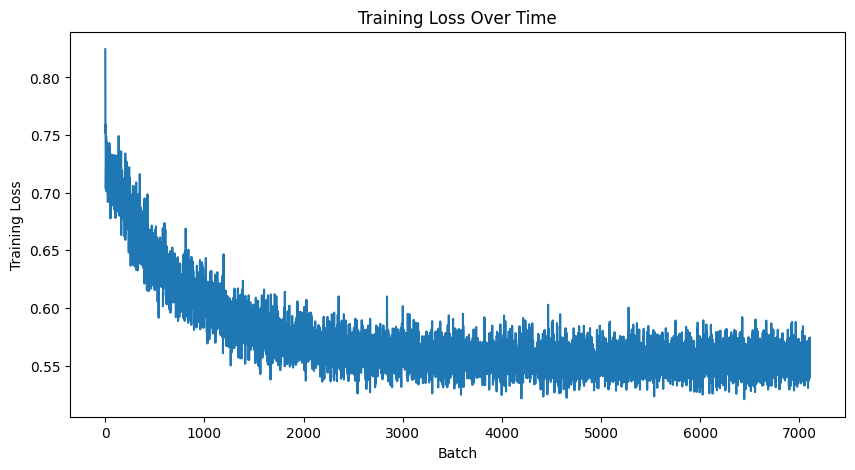

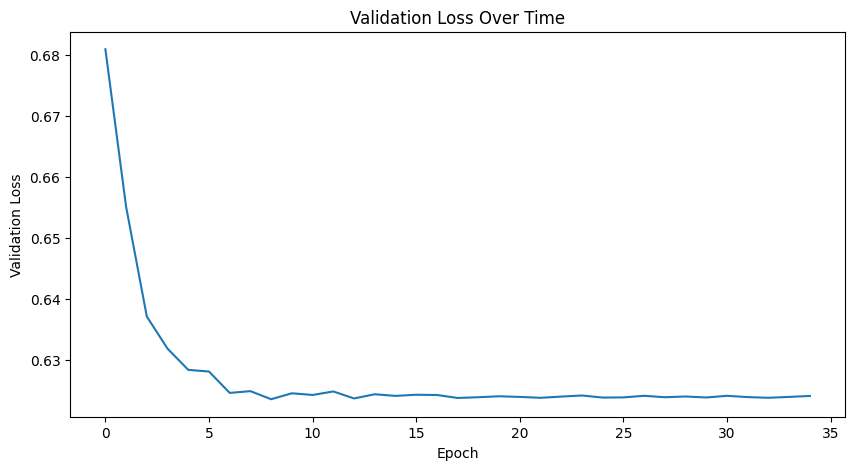

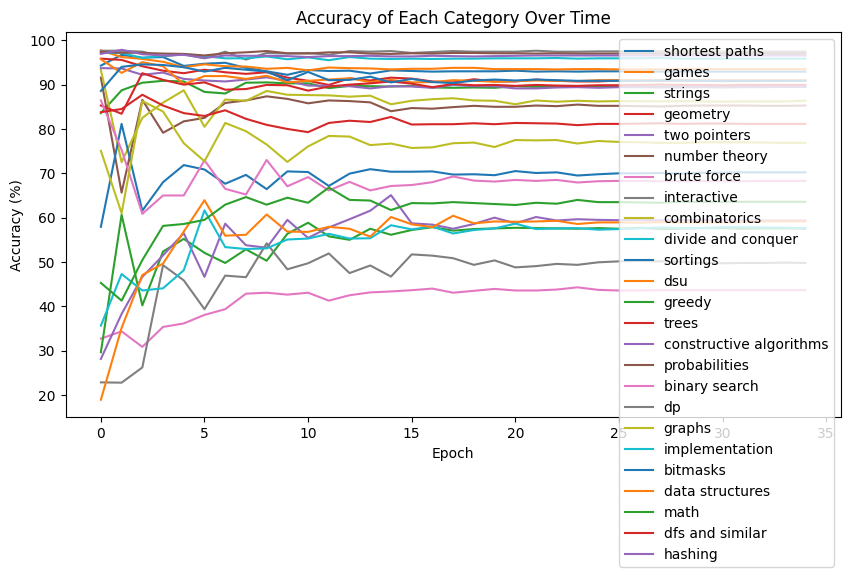

Average Accuracy for Epoch 1: 73.00%
Average Accuracy for Epoch 2: 74.03%
Average Accuracy for Epoch 3: 75.55%
Average Accuracy for Epoch 4: 77.67%
Average Accuracy for Epoch 5: 77.96%
Average Accuracy for Epoch 6: 77.83%
Average Accuracy for Epoch 7: 78.45%
Average Accuracy for Epoch 8: 78.40%
Average Accuracy for Epoch 9: 78.97%
Average Accuracy for Epoch 10: 78.57%
Average Accuracy for Epoch 11: 78.68%
Average Accuracy for Epoch 12: 78.73%
Average Accuracy for Epoch 13: 78.83%
Average Accuracy for Epoch 14: 78.81%
Average Accuracy for Epoch 15: 78.97%
Average Accuracy for Epoch 16: 78.87%
Average Accuracy for Epoch 17: 78.82%
Average Accuracy for Epoch 18: 78.90%
Average Accuracy for Epoch 19: 78.86%
Average Accuracy for Epoch 20: 78.90%
Average Accuracy for Epoch 21: 78.89%
Average Accuracy for Epoch 22: 78.98%
Average Accuracy for Epoch 23: 78.95%
Average Accuracy for Epoch 24: 78.89%
Average Accuracy for Epoch 25: 78.92%
Average Accuracy for Epoch 26: 78.94%
Average Accuracy for 

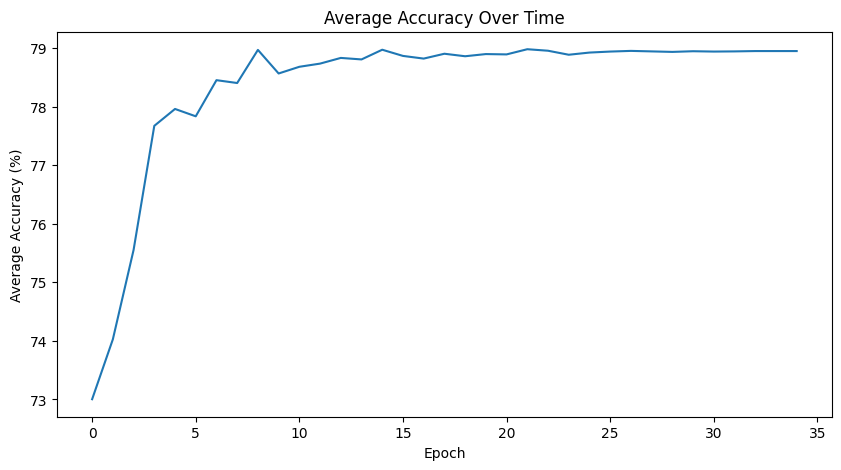

In [14]:
# prompt: make 3 charts, one the training loss over time, one the validation loss for each epoch and another with the accuracy rates of each category over each epoch label the categories by their true names found in index_to_tag

# Plot training loss over time
plt.figure(figsize=(10, 5))
plt.plot(total_losses)
plt.xlabel('Batch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Time')
plt.show()

# Plot validation loss for each epoch
plt.figure(figsize=(10, 5))
plt.plot(val_losses)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Over Time')
plt.show()

# Plot accuracy rates of each category over epochs
plt.figure(figsize=(10, 5))
for i in range(n):
  accuracies = [epoch_accuracies[i] for epoch_accuracies in val_acc]
  plt.plot(accuracies, label=index_to_tag[i])

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of Each Category Over Time')
plt.legend()
plt.show()
# prompt: now make a new char just for the average accuracy

# Calculate and print the average accuracy across all tags for each epoch
for epoch in range(EPOCHS):
    avg_epoch_accuracy = sum(val_acc[epoch]) / len(val_acc[epoch])
    print(f"Average Accuracy for Epoch {epoch + 1}: {avg_epoch_accuracy:.2f}%")

# Plot the average accuracy over epochs
plt.figure(figsize=(10, 5))
avg_accuracies = [sum(epoch_accuracies) / len(epoch_accuracies) for epoch_accuracies in val_acc]
plt.plot(avg_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy (%)')
plt.title('Average Accuracy Over Time')
plt.show()